In [1]:
#下面这行代码，是为了把自己编写的代码文件当作一共模块导入，这里是把Utilities文件夹中的plotting.py文件当作python的模块导入，对应的是下面的from plotting import newfig, savefig。路径要随着不同设备的系统做相应的修改
import sys #导入sys模块。sys模块提供了一些变量和函数，用于与 Python解释器进行交互和访问。例如，sys.path 是一个 Python 在导入模块时会查找的路径列表，sys.argv 是一个包含命令行参数的列表，sys.exit() 函数可以用于退出 Python 程序。导入 sys 模块后，你就可以在你的程序中使用这些变量和函数了。
sys.path.insert(0, '../../Utilities/') #在 Python的sys.path列表中插入一个新的路径。sys.path是一个 Python 在导入模块时会查找的路径列表。新的路径'../../Utilities/'相对于当前脚本的路径。当你尝试导入一个模块时，Python 会在 sys.path 列表中的路径下查找这个模块。通过在列表开始位置插入一个路径，你可以让 Python 优先在这个路径下查找模块。这在你需要导入自定义模块或者不在 Python 标准库中的模块时非常有用。

import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。

import random

import skopt #用于优化问题的库，特别是机器学习中的超参数优化
from distutils.version import LooseVersion #distutils是Python的一个标准库，用于构建和安装Python包。LooseVersion是一个类，用于比较版本号


from plotting_torch import newfig, savefig #从自定义的plotting_torch.py文件中导入了newfig和savefig函数。这两个函数用于创建和保存图形。这两个函数的定义在plotting_torch.py文件中

from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
import time #一个内置模块，用于处理时间相关的操作。


from tqdm import tqdm #一个快速，可扩展的python进度条库，可以在python长循环中添加一个进度提示信息，用户只需要封装任意的迭代器tqdm(iterator)。



In [2]:
num_gpus = torch.cuda.device_count()
print('Number of available GPUs: ', num_gpus)

for i in range(num_gpus):
    torch.cuda.set_device(i)
    allocated = torch.cuda.memory_allocated()
    reserved = torch.cuda.memory_reserved()
    print('GPU {}: {}, Allocated: {}, Reserved: {}'.format(i, torch.cuda.get_device_name(i), allocated, reserved))

Number of available GPUs:  2
GPU 0: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0
GPU 1: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0


In [3]:
torch.cuda.set_device(1) #设置当前使用的GPU设备。这里设置为1号GPU设备（第二块显卡）。

# CUDA support 

#设置pytorch的设备，代表了在哪里执行张量积算，设备可以是cpu或者cuda（gpu），并将这个做运算的设备对象存储在变量device中，后续张量计算回在这个设备上执行
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
# the deep neural network
class DNN(torch.nn.Module):
    #第一个方法
    def __init__(self, layers):
        super(DNN, self).__init__() #调用父类的__init__方法进行初始化
        
        # parameters
        self.depth = len(layers) - 1 #定义名为depth的属性，表示神经网络的深度，等于层数-1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh #设置激活函数为tanh
         
        layer_list = list() #定义一个空列表layer_list
        for i in range(self.depth - 1):  #循环depth次
            #将每一层（全连接层）添加到layer_list中
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            #将每一层的激活函数添加到layer_list中
            layer_list.append(('activation_%d' % i, self.activation()))

        #循环结束后，将最后一层的线性变换添加到layer_list中（因为没有激活函数了）
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        #然后使用OrderedDict将layer_list中的元素转换为有序字典
        layerDict = OrderedDict(layer_list)
        
        # deploy layers，将layerDict转换为一个神经网络模型，赋值给self.layers
        self.layers = torch.nn.Sequential(layerDict)
    
    #第二个方法，定义了模型的前向传播过程
    def forward(self, x):  #接收输入x
        out = self.layers(x) #将输入x传入神经网络模型self.layers中，得到输出out
        return out #返回输出out
    
    # 新增方法，获取最后一个隐藏层的输出
    def hidden_output(self, x):
        # 遍历每一层，直到最后一个隐藏层
        for i in range(self.depth - 1):
            # 获取当前层的线性变换
            x = self.layers[i*2](x)
            # 获取当前层的激活函数
            x = self.layers[i*2 + 1](x)
        # 返回最后一个隐藏层的输出
        return x

In [5]:
# the physics-guided neural network
class PhysicsInformedNN():
    # Initialize the class
    def __init__(self, X_u, u, X_f, layers, lb, ub, nu, X_star, u_star): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数

        
        # boundary conditions
        #将传入的lb和ub参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.lb和self.ub来访问这些值。
        self.lb = torch.tensor(lb).float().to(device) #创建一个pytorch张量（数据来源于lb），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        #创建四个pytorch张良，将X_u的第一列赋值给self.x_u，将X_u的第二列赋值给self.t_u。转换为浮点类型，移动到指定设备上，并且这几个张量都需要计算梯度
        #初边界点数据
        self.x_u = torch.tensor(X_u[:, 0:1], requires_grad=True).float().to(device)
        self.t_u = torch.tensor(X_u[:, 1:2], requires_grad=True).float().to(device)
        #配位点数据
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        #测试点数据
        self.x_star = torch.tensor(X_star[:, 0:1], requires_grad=True).float().to(device)
        self.t_star = torch.tensor(X_star[:, 1:2], requires_grad=True).float().to(device)

        #初边界点真实数据
        self.u = torch.tensor(u).float().to(device)
        #测试点真实数据
        self.u_star = torch.tensor(u_star).float().to(device)
        
        self.layers = layers
        #loss的一个系数
        self.nu = nu
        
        # deep neural networks
        self.dnn = DNN(layers).to(device) #创建一个DNN类的实例，传入layers参数来实现神经网络的初始化，然后将这个实例移动到指定的设备上
        
        # optimizers: using the same settings
        #创建优化器optimizer，使用LBFGS算法，具体每个参数意义见下方
        self.optimizer_LBFGS = torch.optim.LBFGS(
            self.dnn.parameters(), #要优化的参数，这里返回的是一个生成器，包含了self.dnn中的所有参数（神经网络权重与偏置）
            lr=1.0,  #学习率设置为1
            max_iter=50000,  #最大迭代次数为50000
            max_eval=50000,  #最大评估次数为50000
            history_size=50, #历史大小为50，即用于计算Hessian矩阵近似的最近几步的信息
            # tolerance_grad=1e-10,  #优化的第一个停止条件，当梯度的L2范数小于1e-5时停止优化
            # tolerance_change=1.0 * np.finfo(float).eps, #优化的第二个停止条件，当优化的目标函数值的变化小于1.0 * np.finfo(float).eps时停止优化
            line_search_fn="strong_wolfe"       # 制定了用于一维搜索的方法，这里表示用强Wolfe条件
        )

        #创建第二个优化器，括号内为要优化的参数，使用Adam优化方法
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())

        #创建第三个优化器，括号内为要优化的参数，使用SGD优化方法
        self.optimizer_SGD = torch.optim.SGD(self.dnn.parameters(), lr=0.01, momentum=0.9)

        self.iter = 0 #记录迭代次数 

        self.loss_value = [] #创建一个空列表，用于存储损失值

        self.test_error = [] #创建一个空列表，用于存储测试误差
        self.test_error_mse = [] #创建一个空列表，用于存储测试误差
        self.test_error_mae = [] #创建一个空列表，用于存储测试误差
        
    #定义了一个名为net_u的函数/方法，用于计算神经网络的输出。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回神经网络的输出。     
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))  #（第一个参数将输入的两个参数x和t在第二个维度（列）上进行拼接，形成一个新的张量）调用DNN，根据两个参数权重和偏置，以及新得到的张量，计算神经网络的输出u
        return u
    
    #定义了一个名为net_f的函数/方法，用于计算论文中的f。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回计算得到的f。
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x, t) #调用上面的net_u函数，计算神经网络的输出u
        
        #计算u关于t的梯度，也就是u关于t的导数，这里使用了pytorch的自动求导功能
        u_t = torch.autograd.grad(
            u, t,  #输入的张量，要计算u关于t的导数
            grad_outputs=torch.ones_like(u), #生成一个与u形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_t + u * u_x - self.nu * u_xx #计算f，定义见论文
        return f
    
    def loss_func(self):
        self.optimizer_LBFGS.zero_grad() #清除之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
        
        u_pred = self.net_u(self.x_u, self.t_u) #调用之前定义的函数，传入参数得到神经网络的输出u
        f_pred = self.net_f(self.x_f, self.t_f) #调用之前定义的函数，传入参数计算得到f
        loss_u = torch.mean((self.u - u_pred) ** 2) #计算loss_u，定义见论文
        loss_f = torch.mean(f_pred ** 2) #计算loss_f，定义见论文
        
        loss = loss_u + loss_f #计算总的loss
        
        loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
        self.iter += 1 #每调用一次损失函数，迭代次数加1

        #record the loss value
        self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

        #record the test error
        self.dnn.eval() #将神经网络切换为评估模式
        with torch.no_grad():
            u_real_pred = self.net_u(self.x_star, self.t_star) #调用之前定义的函数，传入参数得到神经网络的输出u

        error_test = torch.norm(self.u_star-u_real_pred,2)/torch.norm(self.u_star,2)

        self.test_error.append(error_test)

        # 计算 MAE
        mae = torch.mean(torch.abs(self.u_star - u_real_pred))
        # 计算 MSE
        mse = torch.mean((self.u_star - u_real_pred) ** 2)
        # 记录 MAE 和 MSE
        self.test_error_mae.append(mae)
        self.test_error_mse.append(mse)

        return loss
      
    
    def train(self, nIter, nIterLBFGS):

        # 初始化一个列表来存储每个epoch的权重矩阵
        self.weights = []   


        # #使用SGD优化器优化nIter次
        # for epoch in tqdm(range(nIter), desc='SGD'):
        #     u_pred = self.net_u(self.x_u, self.t_u)
        #     f_pred = self.net_f(self.x_f, self.t_f)
        #     loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)

        #     # Backward and optimize
        #     self.optimizer_SGD.zero_grad()
        #     loss.backward()
        #     self.optimizer_SGD.step()

        #     #record the loss value
        #     self.loss_value.append(loss)

        #     # record the test error
        #     with torch.no_grad():
        #         u_real_pred = self.net_u(self.x_star, self.t_star) #调用之前定义的函数，传入参数得到神经网络的输出u

        #     error_test = torch.norm(self.u_star-u_real_pred,2)/torch.norm(self.u_star,2)

        #     self.test_error.append(error_test)


        #     # 记录每一层的权重矩阵
        #     epoch_weights = []
        #     for layer in self.dnn.layers:
        #         if isinstance(layer, torch.nn.Linear):  # 检查是否为全连接层
        #             epoch_weights.append(layer.weight.data.clone())  # 使用.clone()来获取权重的副本
        #     self.weights.append(epoch_weights)

        #     W = self.weights



        #使用Adam优化器优化nIter次
        for epoch in tqdm(range(nIter), desc='Adam'):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式
            u_pred = self.net_u(self.x_u, self.t_u) #调用之前定义的函数，传入参数得到神经网络的输出u
            f_pred = self.net_f(self.x_f, self.t_f) #调用之前定义的函数，传入参数计算得到f
            loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2) #计算损失函数
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
            loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
            self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化
            
            #record the loss value
            self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

            # record the test error
            self.dnn.eval() #将神经网络切换为评估模式
            with torch.no_grad():
                u_real_pred = self.net_u(self.x_star, self.t_star) #调用之前定义的函数，传入参数得到神经网络的输出u
            # batch_size = 100  # 设置批次大小
            # n = len(self.x_star)
            # u_real_pred = []
            # for i in range(0, n, batch_size):
            #     x_star_batch = self.x_star[i:i+batch_size]
            #     t_star_batch = self.t_star[i:i+batch_size]
            #     u_real_pred_batch = self.net_u(x_star_batch, t_star_batch)
            #     u_real_pred.append(u_real_pred_batch)
            # u_real_pred = torch.cat(u_real_pred)


            error_test = torch.norm(self.u_star-u_real_pred,2)/torch.norm(self.u_star,2)

            self.test_error.append(error_test)

            # 计算 MAE和MSE
            mae = torch.mean(torch.abs(self.u_star - u_real_pred))
            mse = torch.mean((self.u_star - u_real_pred) ** 2)
            # 记录 MAE 和 MSE
            self.test_error_mae.append(mae)
            self.test_error_mse.append(mse)

            # 记录每一层的权重矩阵
            epoch_weights = []
            for layer in self.dnn.layers:
                if isinstance(layer, torch.nn.Linear):  # 检查是否为全连接层
                    epoch_weights.append(layer.weight.data.clone())  # 使用.clone()来获取权重的副本
            self.weights.append(epoch_weights)

            W = self.weights


    
        
        
        #使用LBFGS优化器进一步，注意这里虽然迭代了500次，但其实使用LBFGS优化器优化的次数不止500次
        for i in tqdm(range(nIterLBFGS), desc='LBFGS'):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式
            self.optimizer_LBFGS.step(self.loss_func) #使用之前的优化器self.optimizer，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化


  


    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval() #将神经网络切换为评估模式
        u = self.net_u(x, t) #调用之前定义的函数得到神经网络的输出u,以及f
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy() #将张量u和f先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        f = f.detach().cpu().numpy()
        return u, f
    

    def hidden_predict(self, x,t):
        x = torch.tensor(x, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        t = torch.tensor(t, requires_grad=True).float().to(device)
        self.dnn.eval()
        hidden_output = self.dnn.hidden_output(torch.cat([x, t], dim=1))
        hidden_output_x = hidden_output[:, 0]
        hidden_output_t = hidden_output[:, 1]
        hidden_output_x = hidden_output_x.detach().cpu().numpy()
        hidden_output_t = hidden_output_t.detach().cpu().numpy()
        return hidden_output_x, hidden_output_t

In [6]:
#定义采样函数，目的是采用sampler方法，生成n_samples个在指定空间内的准随机样本，这里space为二维的，因此每个样本都是一个二维点，即n_samples*2的数据点

#共有6种采样器，分别是LHS、Halton、Hammersley、Sobol、Grid和Random，均为均匀采样方法

def caiyang(n_samples, sampler): #接受两个参数，n_samples是样本数量，sampler是采样器名称，是一个字符串
    space = [(-1.0, 1.0), (0.0, 1.0)] #指定样本生成的空间，一个二维空间，第一个维度是-1到1，第二个维度是0到1

    #根据sampler的不同，选择不同的采样器，返回的sampler是一个采样器对象
    if sampler == "LHS": #如果采样器是LHS（拉丁超采样，每个维度都被均匀划分为等量区间，每个样本都是从每个维度的一个区间中随机选取的）
        sampler = skopt.sampler.Lhs(lhs_type="centered", criterion="maximin", iterations=1000) #第一个参数表示如何从每个区间选取样本，这里表示从每个区间的中心选取样本；第二个参数表示如何划分区间，这里表示尽可能使样本之间的最小距离最大；第三个表示通过优化过程得到样本量的迭代次数（即会尝试1000种不同的样本配置，并最终选择质量最好的那个）
    elif sampler == "Halton": #Halton序列是一种低差异序列，用于在高维空间中生成点
        sampler = skopt.sampler.Halton(min_skip=-1, max_skip=-1)  #两个参数用于控制序列的起始点，Halton序列可以通过跳过序列的前几个点来改变序列的七十点。两个参数分别制定了跳过点的最小和最大数量，这里-1表示不跳过任何点
    elif sampler == "Hammersley": #Hammersley序列是一种低差异序列，用于在高维空间中生成点
        sampler = skopt.sampler.Hammersly(min_skip=-1, max_skip=-1) #两个参数用于控制序列的起始点，Hammersley序列可以通过跳过序列的前几个点来改变序列的七十点。两个参数分别制定了跳过点的最小和最大数量，这里-1表示不跳过任何点
    elif sampler == "Sobol":
        # Remove the first point [0, 0, ...] and the second point [0.5, 0.5, ...], which are too special and may cause some error.
        # Sobol采样器的实现有一个问题，即生成的前两个样本点通常不是随机的而是固定的，Sobol序列的前两个点（[0, 0, ...]和[0.5, 0.5, ...]）在许多情况下都被认为是“特殊”的点，可能会对某些计算产生不利影响。因此设置跳过前两个点，而且skopt库在0.9版本号取消了max/min_skip参数，所以需要根据skopt的版本号来选择不同的参数
        if LooseVersion(skopt.__version__) < LooseVersion("0.9"): #先检查skopt的版本是否大于0.9,若小于
            sampler = skopt.sampler.Sobol(min_skip=2, max_skip=2, randomize=False) #则使用Sobol采样器，min_skip和max_skip表示跳过的点的数量，这里表示跳过前两个点，randomize表示是否随机化
        else: #若skopt的版本大于0.9
            sampler = skopt.sampler.Sobol(skip=0, randomize=False) #则使用Sobol采样器，skip表示跳过的点的数量，这里表示不跳过任何点，randomize表示是否随机化 
            return np.array(sampler.generate(space, n_samples + 2)[2:]) #生成n_samples+2个样本，然后返回除了前两个样本之外的所有样本，也就是返回n_samples个样本，每个样本都是一个二维点，且范围在指定的空间space里面
    elif sampler == "Grid":
        x_min, x_max = space[1]
        t_min, t_max = space[0]
        
        # 计算每个维度的网格大小
        x_grid_size = (x_max - x_min) / (n_samples // int(np.sqrt(n_samples)) - 1) # x维度上（纵轴），每行有10个点
        t_grid_size = (t_max - t_min) / int(np.sqrt(n_samples))  # 
        
        # 生成等距均匀网格采样点
        samples = []
        for i in range(n_samples // int(np.sqrt(n_samples))):
            for j in range(int(np.sqrt(n_samples))):
                # 计算每个网格单元的中心点
                x = x_min + i * x_grid_size
                t = t_min + j * t_grid_size
                samples.append([t, x])
        
        return np.array(samples)
    
    elif sampler == "Random":
        # 从space中提取出x_min, x_max, t_min, t_max
        x_min, x_max = space[1]
        t_min, t_max = space[0]

        # 生成x和t的随机数
        x = np.random.rand(n_samples, 1) * (x_max - x_min) + x_min
        t = np.random.rand(n_samples, 1) * (t_max - t_min) + t_min

        # 将x和t合并为一个(n_samples, 2)的数组
        samples = np.hstack((t, x))
        return samples #生成一个形状为(n_samples, 2)的随机数组



    return np.array(sampler.generate(space, n_samples)) #生成n_samples个样本，每个样本都是一个二维点，且范围在指定的空间space里面（n_samples*2）

In [7]:
#定义设置随机数种子的函数，第一个参数seed表示种子；第二个参数用来设置CUDA的卷积操作是否确定性，默认为False，表示没有确定性
def set_seed(seed):
    # torch.manual_seed(seed) #设置pytorch的CPU随机数生成器的种子
    # torch.cuda.manual_seed_all(seed) #设置putorch的所有GPU随机数生成器的种子
    # np.random.seed(seed) #设置numpy的随机数生成器的种子
    # random.seed(seed) #设置python的内置随机数生成器的种子
    # torch.backends.cudnn.deterministic = deterministic #True会让CUDA的卷积操作变得确定性，即对于相同的输入，每次运行会得到相同的结果，False则相反
    """
    设置PyTorch的随机种子, 用于生成随机数. 通过设置相同的种子, 可以确保每次运行时生成的随机数序列相同
    """
    torch.manual_seed(seed)
 
    """
    设置PyTorch在所有可用的CUDA设备上的随机种子. 如果在使用GPU进行计算, 这个设置可以确保在不同的GPU上生成的随机数序列相同
    """
    torch.cuda.manual_seed_all(seed)
 
    """
    设置PyTorch在当前CUDA设备上的随机种子. 它与上一行代码的作用类似, 但只影响当前设备
    """
    torch.cuda.manual_seed(seed)
 
    """
    设置NumPy的随机种子, 用于生成随机数. 通过设置相同的种子，可以确保在使用NumPy的随机函数时生成的随机数序列相同
    """
    np.random.seed(seed)
    
    """
    设置Python内置的随机函数的种子. Python的random模块提供了许多随机函数, 包括生成随机数、打乱列表等. 通过设置相同的种子, 可以确保使用这些随机函数时生成的随机数序列相同
    """
    random.seed(seed)
    
    """
    设置Python的哈希种子 (哈希函数被广泛用于数据结构 (如字典和集合) 的实现，以及一些内部操作 (如查找和比较)). 通过设置相同的种子, 可以确保在不同的运行中生成的哈希结果相同
    """
    # os.environ["PYTHONHASHSEED"] = str(seed)
    
    """
    该设置确保每次运行代码时, cuDNN的计算结果是确定性的, 即相同的输入会产生相同的输出, 这是通过禁用一些非确定性的算法来实现的, 例如在卷积操作中使用的算法. 这样做可以保证模型的训练和推理在相同的硬件和软件环境下是可复现的, 即每次运行代码时的结果都相同. 但是, 这可能会导致一些性能上的损失, 因为禁用了一些优化的非确定性算法
    """
    torch.backends.cudnn.deterministic = True
    
    """
    该设置禁用了cuDNN的自动优化过程. 当它被设置为False时, PyTorch不会在每次运行时重新寻找最优的算法配置, 而是使用固定的算法配置. 这样做可以确保每次运行代码时的性能是一致的, 但可能会导致一些性能上的损失
    """
    torch.backends.cudnn.benchmark = False



In [8]:
#定义根据模型计算给定输入（点集中的点）的混沌度的函数，这个函数接受三个参数，分别是模型、输入数据和迭代次数
def calculate_chaos(model, X, num_iter):
    """
    计算模型混沌情况的函数。
    参数:
    - model: 用于预测的模型对象，必须有一个名为hidden_predict的方法。模型的hidden_predict为倒数第二层的输出，倒数第二层的维度必须和输入维度相同。
    - X: 输入数据，形状为(N_f_new, 2)，其中第一列为x0，第二列为t0。
    - num_iter: 计算混沌情况的迭代次数。
    返回:
    - distances: 每个采样点（与该采样点加上微扰比较）在最后一次迭代后的欧氏距离数组，形状为(N_f_new,)。
    """
    #对于所有的采样点
    x0 = X[:, 0:1] #取X_f_train_new的第一列，赋值给x0，(N_f_new,1)形状
    t0 = X[:, 1:2] #取X_f_train_new的第二列，赋值给t0
    # 利用x0和t0计算x{t}和t{t}，存储在xs中
    xs = [] #初始化xs
    x,t = model.hidden_predict(x0,t0) #调用predict方法，传入X_f_train_new，得到x和t，这里x和t形状均为(N_f_new,)，因此下一步需要reshape
    x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
    t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
    
    # 迭代预测
    for i in range(num_iter): #循环num_iter次
        x,t = model.hidden_predict(x,t) #每次计算隐藏层输出，得到的x和t形状均为(N_f_new,)，因此下一步需要reshape
        x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
        t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
        xs.append([x,t]) #将x的数据添加到xs中
    #最后得到的xs是一个列表，列表中的每个元素都是一个列表（num_iter个元素），每个列表中有两个元素，分别代表x和t，长度均为N_f_new，对应原始采样点的迭代结果


    # 给所有采样点加上一个很小的扰动
    x1 = x0 + np.random.normal(0, 0.0001) #加上一个很小的扰动，(N_f_new,1)形状
    t1 = t0 + np.random.normal(0, 0.0001)
    # 利用x0{1}和t0{1}计算x{t1}和t{t1}，存储在xs1中
    xs1 = [] #初始化xs1
    x,t = model.hidden_predict(x1,t1) #调用predict方法，传入X_f_train_new，得到x和t，这里x和t形状均为(N_f_new,)，因此下一步需要reshape
    x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
    t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）

    # 迭代预测（扰动后）
    for i in range(num_iter): #循环num_iter次
        x,t = model.hidden_predict(x,t) #每次计算隐藏层输出，得到的x和t形状均为(N_f_new,)，因此下一步需要reshape
        x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)
        t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)
        xs1.append([x,t]) #将x的数据添加到xs1中
    #最后得到的xs1是一个列表，列表中的每个元素都是一个列表（num_iter个元素），每个列表中有两个元素，分别代表x和t，长度均为N_f_new，对应加了扰动后的采样点的迭代结果

    # 计算最后一次迭代的隐藏层输出，即最后一次迭代的x和t
    last_iter_xs = np.array(xs[-1]) #转换为数组，便于之后计算距离
    last_iter_xs1 = np.array(xs1[-1])
    #这两个数组的形状均为(2,N_f_new,1)，第一个代表x和t，第二个代表N_f_new个样本点得到的结果，第三个代表1个数

    # 计算这两个点的欧氏距离
    distances = np.linalg.norm(last_iter_xs - last_iter_xs1, axis=0)
    #得到的是一个形状为（N_f_new,1）的数组，每个元素代表了两个点之间的欧氏距离，这里点在xt平面上

    distances = distances.flatten()

    #对distances进行归一化
    # distances = distances / np.linalg.norm(distances)
    # 对distances进行归一化前，检查分母是否接近零
    # norm = np.linalg.norm(distances)
    # if norm < 1e-10:  # 1e-10是一个非常小的数，用于检测norm是否接近于零
    #     distances = np.zeros_like(distances)  # 如果分母接近0，将distances设置为全零数组，因为范数为0时，distances中的值想对于彼此几乎没有差异，意味着所有点都几乎处于同一混沌度水平
    # else:
    #     distances = distances / norm

    # 现在可以安全地根据distances对点进行排序，即使在所有值都相同的情况下

    return distances

In [9]:
#RAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练10000次
seeds = [0, 1, 12, 33, 123, 321, 1234, 4321, 12345, 54321] #生成10个随机种子
# seeds = [0]

nu = 0.01/np.pi
#设置噪声水平为0
noise = 0.0        

N_u = 100
N_f = 2500
nIter = 50000 #设置迭代次数为10000
nIterLBFGS = 500 #设置LBFGS迭代次数为500


#定义一个列表layers，其中包含了神经网络的层数和每一层的神经元数量
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 2, 1]
#读取名为burgers_shock的Matlab文件，文件中的数据存储在data变量中。这里的路径也要随着设备的情况修改 
data = scipy.io.loadmat('../data/burgers_shock.mat')
#从data字典中取出变量tt和x的值，并转换为一维数组（flatten方法），最后tongg[:,None]将一维数组转换为二维数组
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T #从data数据中取出usol的值，并取实部，最后转置，赋值给Exact
#生成一个二位网络，X和T是输出的二维数组
#这个点结果是X和T均为形状为[len(t),len(x)]的二维数组，X的每一行都是x，一共len(t)行，T的每一列都是t，一共len(x)列
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  #按列堆叠数组，X_star是一个二维数组，其中第一列是X的展平，第二列是T的展平
u_star = Exact.flatten()[:,None]    #对Exact_u使用flatten方法将其转换为一维数组，最后使用[:,None]将其转换为二维数组         

# Doman bounds，分别获得X_star的相应列上的最小值和最大值，赋值给lb和ub,也就是说lb是x和t的最小值，ub是x和t的最大值，即lb和ub分别为[-1,0]和[1,1]
lb = X_star.min(0)
ub = X_star.max(0)    


#生成初值和边界值的训练基础数据
xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T)) #分别取X，T的第一行的转置(分别是x和全0列)，分别构成xx1的第一列和第二列
uu1 = Exact[0:1,:].T #取Exact的第一行的转置，赋值给uu1
xx2 = np.hstack((X[:,0:1], T[:,0:1])) #分别取X，T的第一列(分别是全-1列和t)，分别构成xx2的第一列和第二列
uu2 = Exact[:,0:1] #取Exact的第一列，赋值给uu2
xx3 = np.hstack((X[:,-1:], T[:,-1:])) #分别取X，T的最后一列(分别是全1列和t)，分别构成xx3的第一列和第二列
uu3 = Exact[:,-1:] #取Exact的最后一列，赋值给uu3

X_u_train_all = np.vstack([xx1, xx2, xx3]) #X_u_train=(xx1;xx2;xx3)

u_train_all = np.vstack([uu1, uu2, uu3]) #u_train=(uu1;uu2;uu3)
    

#1.生成初值边界值训练数据，以及测试数据

#从所有的初值边界值训练基础数据中选取N_u=100个点
idx = np.linspace(0, X_u_train_all.shape[0] - 1, N_u, dtype=int) #生成一个等差数列，从0到X_u_train的行数，间隔为1，赋值给idx
# idx = np.random.choice(X_u_train_all.shape[0], N_u, replace=False) #从0~数组X_u_train的行数 中随机选择N_u个数，replace=False表示不允许重复选择，最后将这N_u个数赋值给idx
X_u_train = X_u_train_all[idx, :] #从X_u_train中选取idx对应的的N_u行，赋值给X_u_train
u_train = u_train_all[idx,:] #从u_train中选取idx对应的的N_u行，赋值给u_train


error_u = [] #创建一个空列表，用于存储误差值
error_mae = [] #创建一个空列表，用于存储MAE值
error_mse = [] #创建一个空列表，用于存储MSE值


i = 0 #初始化i为0

for seed in seeds:
    set_seed(seed) #设置随机数种子


    #2.生成配位点并进行训练

    num_iter = 100 #chaos迭代次数

    #先训练500次
    #采样配位点10个
    N_f_1 = N_f//100 #N_f_1=50
    X_f_train = caiyang(N_f_1, "LHS") #生成50个样本点，每个样本点都是一个二维点，即50*2的数据点

    #创建PINN模型并输入各种参数     
    model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, nu, X_star, u_star)

    #获取当前时间并赋值给start_time  
    start_time = time.time()   
    #开始训练模型            
    model.train(nIter//100,0)


    #训练结束后，每500次迭代重采样一次100个点，并选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练50000次
    for iter in range(nIter//100+1, nIter+1, nIter//100): #每500次迭代
        N_f_new = N_f_1 * 10 #重新采样100个点
        # 生成新的X_f_train数据
        X_f_train_new = caiyang(N_f_new, "LHS") #生成500个样本点，每个样本点都是一个二维点，即500*2的数据点


        #计算混沌度
        distances = calculate_chaos(model, X_f_train_new, num_iter)

        #计算残差
        _, residual = model.predict(X_f_train_new)
        # 计算残差的绝对值
        abs_residual = np.abs(residual)
        #将二维数组转换为一维数组
        abs_residual = abs_residual.flatten()


        # 对distances进行归一化
        epsilon = 1e-5
        norm_distances = np.linalg.norm(distances)
        if norm_distances > epsilon:
            distances = distances / norm_distances
        else:
            distances = np.zeros_like(distances)

        #对abs_residual进行归一化
        abs_residual = abs_residual / np.linalg.norm(abs_residual)

        xinxi = 0.7*distances + 0.3*abs_residual #将三个归一化后的数组相加，得到新的数组xinxi

        # 找出绝对值最大的10个值的索引
        topk_indices = np.argpartition(xinxi, -N_f_1)[-N_f_1:] #该函数会对数组进行排序，使得指定的k个最大值出现在数组的最后k给位置上，并获取最后1000个元素

        # 使用这些索引来提取对应的数据
        X_f_train_topk = X_f_train_new[topk_indices]

        X_f_train = np.vstack((X_f_train, X_f_train_topk)) #与之前的训练数据合并

        # 更新模型中的X_f_train数据
        model.x_f = torch.tensor(X_f_train[:, 0:1], requires_grad=True).float().to(device)
        model.t_f = torch.tensor(X_f_train[:, 1:2], requires_grad=True).float().to(device)

        # 在更新数据后的模型上进行训练500次
        model.train(nIter//100,0)



    model.train(0,nIterLBFGS) #使用LBFGS训练500次
    #所有训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
    elapsed = time.time() - start_time
    #打印训练所花时间                
    print('Training time: %.4f' % (elapsed))

    # 训练结束后，再次使用模型进行预测，并计算误差
    u_pred, f_pred = model.predict(X_star)
    error_u.append(np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)) #计算误差，然后将误差添加到error_u列表中
    # 计算 MAE 和 MSE
    mae = np.mean(np.abs(u_star - u_pred))
    mse = np.mean((u_star - u_pred) ** 2)
    # 记录 MAE 和 MSE
    error_mae.append(mae)
    error_mse.append(mse)

    i+=1 #i加1
    print(f'当前为第{i}次循环，种子为{seed}')
    print('Error u : %e' % (np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2))) #打印误差  
    print('MAE: %e' % mae) #打印MAE
    print('MSE: %e' % mse) #打印MSE
    


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 1/500 [00:00<00:50,  9.92it/s]

Adam:   4%|▍         | 21/500 [00:00<00:04, 119.09it/s]

Adam:   9%|▊         | 43/500 [00:00<00:02, 161.51it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 177.42it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 202.99it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:01, 211.90it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:01, 221.76it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 209.91it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 207.71it/s]

Adam:  41%|████      | 203/500 [00:01<00:01, 202.81it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 184.61it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 184.28it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 182.78it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:01, 178.86it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 182.03it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:00, 180.88it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 188.17it/s]

Adam:  72%|███████▏  | 361/500 [00:01<00:00, 190.29it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 193.06it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 194.98it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 198.40it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 197.03it/s]

Adam:  92%|█████████▏| 462/500 [00:02<00:00, 194.43it/s]

Adam:  97%|█████████▋| 483/500 [00:02<00:00, 196.68it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 189.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.36it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.52it/s]

Adam:  11%|█         | 53/500 [00:00<00:02, 178.59it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 209.56it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 206.89it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:01, 204.11it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:01, 200.51it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:01, 201.40it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 201.82it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 194.92it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 195.86it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 194.72it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 198.44it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 201.10it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:00, 202.90it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:00, 195.35it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 195.82it/s]

Adam:  74%|███████▍  | 370/500 [00:01<00:00, 196.69it/s]

Adam:  78%|███████▊  | 390/500 [00:01<00:00, 195.54it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 195.95it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 194.55it/s]

Adam:  90%|█████████ | 450/500 [00:02<00:00, 183.11it/s]

Adam:  94%|█████████▍| 470/500 [00:02<00:00, 187.65it/s]

Adam:  98%|█████████▊| 490/500 [00:02<00:00, 191.01it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 193.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 263.75it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 242.48it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 213.39it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 210.35it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 206.97it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:01, 205.84it/s]

Adam:  33%|███▎      | 165/500 [00:00<00:01, 203.98it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 175.53it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 174.87it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 181.41it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 183.29it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 189.95it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 186.96it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 185.26it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:00, 186.37it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 189.30it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 193.89it/s]

Adam:  77%|███████▋  | 384/500 [00:01<00:00, 184.89it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 185.39it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 181.55it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 182.36it/s]

Adam:  92%|█████████▏| 462/500 [00:02<00:00, 189.49it/s]

Adam:  96%|█████████▋| 482/500 [00:02<00:00, 190.75it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 191.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 257.55it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 250.02it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 236.60it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 220.08it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 203.42it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:01, 194.95it/s]

Adam:  33%|███▎      | 166/500 [00:00<00:01, 182.89it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 184.16it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 182.87it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 182.85it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 185.47it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 190.93it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 189.09it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 179.08it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:00, 186.54it/s]

Adam:  69%|██████▉   | 346/500 [00:01<00:00, 192.00it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 192.53it/s]

Adam:  77%|███████▋  | 386/500 [00:01<00:00, 193.86it/s]

Adam:  81%|████████▏ | 407/500 [00:02<00:00, 196.68it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 197.41it/s]

Adam:  91%|█████████ | 454/500 [00:02<00:00, 216.97it/s]

Adam:  95%|█████████▌| 477/500 [00:02<00:00, 219.77it/s]

Adam: 100%|█████████▉| 499/500 [00:02<00:00, 212.41it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 199.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 235.36it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 244.41it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 237.71it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 220.94it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:01, 207.02it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:01, 201.07it/s]

Adam:  33%|███▎      | 164/500 [00:00<00:01, 197.04it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 196.40it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 199.48it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:01, 200.31it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 200.98it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 199.37it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 192.75it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:01, 184.10it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:00, 184.47it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 186.31it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 186.26it/s]

Adam:  77%|███████▋  | 385/500 [00:01<00:00, 175.87it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 181.68it/s]

Adam:  85%|████████▍ | 424/500 [00:02<00:00, 178.81it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 177.55it/s]

Adam:  93%|█████████▎| 463/500 [00:02<00:00, 185.00it/s]

Adam:  97%|█████████▋| 484/500 [00:02<00:00, 190.33it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 194.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.37it/s]

Adam:   7%|▋         | 33/500 [00:00<00:02, 161.85it/s]

Adam:  11%|█         | 53/500 [00:00<00:02, 176.00it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:02, 181.94it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 178.19it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 177.02it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 176.58it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 186.54it/s]

Adam:  34%|███▍      | 169/500 [00:00<00:01, 188.31it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:01, 184.74it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 182.00it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 186.64it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 193.40it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 188.15it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:01, 192.24it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:01, 185.31it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:00, 189.27it/s]

Adam:  70%|██████▉   | 349/500 [00:01<00:00, 190.91it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 190.85it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 186.81it/s]

Adam:  82%|████████▏ | 409/500 [00:02<00:00, 190.00it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 185.72it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 184.76it/s]

Adam:  93%|█████████▎| 467/500 [00:02<00:00, 184.03it/s]

Adam:  97%|█████████▋| 486/500 [00:02<00:00, 182.85it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 184.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 222.83it/s]

Adam:   9%|▉         | 47/500 [00:00<00:01, 230.09it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:02, 210.01it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 191.52it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 191.96it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 194.87it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 191.73it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 189.09it/s]

Adam:  39%|███▉      | 194/500 [00:00<00:01, 190.90it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:01, 183.77it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 175.66it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 173.43it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 173.04it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:01, 180.50it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:01, 183.13it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:00, 183.76it/s]

Adam:  69%|██████▉   | 346/500 [00:01<00:00, 178.87it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 181.91it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 186.58it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 189.82it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 190.04it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 188.56it/s]

Adam:  93%|█████████▎| 465/500 [00:02<00:00, 191.28it/s]

Adam:  97%|█████████▋| 485/500 [00:02<00:00, 187.50it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 187.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 223.26it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 222.29it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:02, 207.90it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:01, 206.28it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:01, 203.41it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 196.00it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 197.37it/s]

Adam:  35%|███▍      | 173/500 [00:00<00:01, 197.57it/s]

Adam:  39%|███▉      | 194/500 [00:00<00:01, 199.26it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:01, 200.30it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 197.01it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 197.57it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 195.77it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:01, 196.85it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 197.34it/s]

Adam:  67%|██████▋   | 336/500 [00:01<00:00, 191.36it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 195.15it/s]

Adam:  75%|███████▌  | 377/500 [00:01<00:00, 190.52it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 193.16it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 189.20it/s]

Adam:  87%|████████▋ | 437/500 [00:02<00:00, 192.12it/s]

Adam:  91%|█████████▏| 457/500 [00:02<00:00, 188.94it/s]

Adam:  95%|█████████▌| 477/500 [00:02<00:00, 189.50it/s]

Adam:  99%|█████████▉| 496/500 [00:02<00:00, 188.05it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 195.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 248.47it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 249.89it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 230.36it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 209.99it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:01, 205.26it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:01, 198.69it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:01, 195.36it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 191.51it/s]

Adam:  41%|████      | 203/500 [00:01<00:01, 188.33it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 190.30it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 195.42it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 193.78it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 195.49it/s]

Adam:  61%|██████    | 305/500 [00:01<00:00, 198.85it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:00, 198.82it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 196.86it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 191.67it/s]

Adam:  77%|███████▋  | 385/500 [00:01<00:00, 193.57it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 189.42it/s]

Adam:  85%|████████▍ | 424/500 [00:02<00:00, 182.15it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 181.55it/s]

Adam:  92%|█████████▏| 462/500 [00:02<00:00, 183.57it/s]

Adam:  96%|█████████▋| 482/500 [00:02<00:00, 186.70it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 195.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 259.77it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 255.30it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 249.69it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 214.38it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 202.47it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:01, 197.47it/s]

Adam:  34%|███▎      | 168/500 [00:00<00:01, 196.35it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 196.14it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 194.86it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 193.03it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 188.83it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 186.08it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 192.39it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:00, 193.62it/s]

Adam:  66%|██████▌   | 328/500 [00:01<00:00, 194.34it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 194.22it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 197.94it/s]

Adam:  78%|███████▊  | 390/500 [00:01<00:00, 199.25it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 199.45it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 194.65it/s]

Adam:  90%|█████████ | 450/500 [00:02<00:00, 194.64it/s]

Adam:  94%|█████████▍| 470/500 [00:02<00:00, 182.86it/s]

Adam:  98%|█████████▊| 489/500 [00:02<00:00, 184.42it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 197.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 260.82it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 225.76it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 220.53it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 198.49it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:01, 191.83it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:01, 191.49it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 190.41it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 186.72it/s]

Adam:  40%|████      | 201/500 [00:01<00:01, 189.53it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 191.82it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 189.07it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 186.62it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:01, 192.47it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 197.05it/s]

Adam:  64%|██████▍   | 322/500 [00:01<00:00, 189.19it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 185.72it/s]

Adam:  72%|███████▏  | 361/500 [00:01<00:00, 184.61it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 189.03it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 191.35it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 194.45it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 194.33it/s]

Adam:  93%|█████████▎| 463/500 [00:02<00:00, 194.96it/s]

Adam:  97%|█████████▋| 483/500 [00:02<00:00, 188.19it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 191.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 256.90it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 250.29it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 216.87it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 202.46it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:01, 189.70it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:01, 184.72it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:01, 186.50it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 189.66it/s]

Adam:  40%|████      | 202/500 [00:01<00:01, 190.21it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 191.95it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 189.37it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 181.93it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:01, 185.86it/s]

Adam:  60%|██████    | 300/500 [00:01<00:01, 184.58it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 184.00it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 182.34it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 179.88it/s]

Adam:  75%|███████▌  | 376/500 [00:01<00:00, 182.51it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 186.02it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 177.80it/s]

Adam:  87%|████████▋ | 434/500 [00:02<00:00, 180.30it/s]

Adam:  91%|█████████ | 454/500 [00:02<00:00, 183.75it/s]

Adam:  95%|█████████▍| 474/500 [00:02<00:00, 187.55it/s]

Adam:  99%|█████████▊| 493/500 [00:02<00:00, 184.03it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 188.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 249.62it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 247.83it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 214.44it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:02, 193.94it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:01, 192.52it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:01, 192.10it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 192.76it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 193.98it/s]

Adam:  40%|███▉      | 198/500 [00:00<00:01, 189.95it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 182.61it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 185.15it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 187.75it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:01, 189.75it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:01, 189.94it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 194.20it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 182.37it/s]

Adam:  72%|███████▏  | 359/500 [00:01<00:00, 185.89it/s]

Adam:  76%|███████▌  | 378/500 [00:01<00:00, 184.45it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 182.02it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 181.59it/s]

Adam:  87%|████████▋ | 436/500 [00:02<00:00, 185.77it/s]

Adam:  91%|█████████ | 456/500 [00:02<00:00, 188.87it/s]

Adam:  95%|█████████▌| 475/500 [00:02<00:00, 184.18it/s]

Adam:  99%|█████████▉| 496/500 [00:02<00:00, 190.15it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 190.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 267.70it/s]

Adam:  11%|█         | 54/500 [00:00<00:02, 208.17it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 206.00it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:02, 199.00it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:01, 198.20it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:01, 199.56it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 190.71it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 191.58it/s]

Adam:  40%|████      | 201/500 [00:01<00:01, 187.44it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 189.04it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 191.05it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 190.40it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:01, 191.76it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 192.68it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:00, 186.29it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 189.19it/s]

Adam:  72%|███████▏  | 360/500 [00:01<00:00, 182.81it/s]

Adam:  76%|███████▌  | 379/500 [00:01<00:00, 184.81it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 183.67it/s]

Adam:  84%|████████▍ | 419/500 [00:02<00:00, 188.28it/s]

Adam:  88%|████████▊ | 438/500 [00:02<00:00, 183.90it/s]

Adam:  91%|█████████▏| 457/500 [00:02<00:00, 184.66it/s]

Adam:  95%|█████████▌| 476/500 [00:02<00:00, 182.71it/s]

Adam:  99%|█████████▉| 495/500 [00:02<00:00, 182.09it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 190.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 209.28it/s]

Adam:   9%|▉         | 47/500 [00:00<00:01, 233.87it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:01, 226.70it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:01, 206.83it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 188.67it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:02, 180.15it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 182.93it/s]

Adam:  35%|███▍      | 173/500 [00:00<00:01, 184.58it/s]

Adam:  38%|███▊      | 192/500 [00:00<00:01, 186.11it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:01, 186.91it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:01, 192.44it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 192.65it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 193.20it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:01, 193.99it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 190.56it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 190.59it/s]

Adam:  70%|███████   | 352/500 [00:01<00:00, 190.78it/s]

Adam:  74%|███████▍  | 372/500 [00:01<00:00, 185.66it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 183.47it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 186.16it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 187.09it/s]

Adam:  90%|█████████ | 450/500 [00:02<00:00, 188.53it/s]

Adam:  94%|█████████▍| 470/500 [00:02<00:00, 191.39it/s]

Adam:  98%|█████████▊| 490/500 [00:02<00:00, 191.82it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 191.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 262.52it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 249.36it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 238.10it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 216.22it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 205.91it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:01, 196.70it/s]

Adam:  33%|███▎      | 166/500 [00:00<00:01, 191.13it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 192.34it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 179.03it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:01, 182.27it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 178.30it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 182.28it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 188.18it/s]

Adam:  61%|██████    | 305/500 [00:01<00:01, 184.83it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:00, 183.84it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 187.75it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 189.53it/s]

Adam:  77%|███████▋  | 384/500 [00:01<00:00, 189.92it/s]

Adam:  81%|████████  | 404/500 [00:02<00:00, 182.18it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 177.90it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 181.13it/s]

Adam:  92%|█████████▏| 461/500 [00:02<00:00, 176.21it/s]

Adam:  96%|█████████▌| 479/500 [00:02<00:00, 169.51it/s]

Adam:  99%|█████████▉| 497/500 [00:02<00:00, 172.04it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 187.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   6%|▌         | 28/500 [00:00<00:01, 272.60it/s]

Adam:  11%|█         | 56/500 [00:00<00:01, 224.67it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 207.94it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 201.57it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:01, 199.53it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:01, 189.38it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:01, 187.32it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 178.33it/s]

Adam:  40%|████      | 200/500 [00:01<00:01, 177.57it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 178.86it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 181.74it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 183.79it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 187.01it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:01, 187.17it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 187.61it/s]

Adam:  67%|██████▋   | 335/500 [00:01<00:00, 188.54it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 186.87it/s]

Adam:  75%|███████▍  | 373/500 [00:01<00:00, 179.49it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 181.35it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 184.78it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 184.48it/s]

Adam:  90%|█████████ | 451/500 [00:02<00:00, 186.57it/s]

Adam:  94%|█████████▍| 470/500 [00:02<00:00, 187.31it/s]

Adam:  98%|█████████▊| 489/500 [00:02<00:00, 182.83it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 188.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   6%|▌         | 28/500 [00:00<00:01, 268.00it/s]

Adam:  11%|█         | 55/500 [00:00<00:01, 249.59it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 217.58it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 205.24it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 197.92it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:01, 189.64it/s]

Adam:  33%|███▎      | 165/500 [00:00<00:01, 184.42it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 178.76it/s]

Adam:  40%|████      | 202/500 [00:01<00:01, 175.95it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 181.18it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 183.85it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 172.51it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:01, 178.62it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 183.06it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:00, 186.96it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 184.61it/s]

Adam:  72%|███████▏  | 360/500 [00:01<00:00, 186.52it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 185.89it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 185.24it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 185.05it/s]

Adam:  87%|████████▋ | 436/500 [00:02<00:00, 179.59it/s]

Adam:  91%|█████████ | 455/500 [00:02<00:00, 179.10it/s]

Adam:  95%|█████████▍| 474/500 [00:02<00:00, 179.67it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 177.72it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 186.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 266.25it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 234.60it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 216.04it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 205.94it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:01, 193.14it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 175.13it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 177.40it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 172.03it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:01, 174.10it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:01, 177.02it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 172.50it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 174.10it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 175.80it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 177.28it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:01, 178.22it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:00, 178.65it/s]

Adam:  69%|██████▉   | 346/500 [00:01<00:00, 186.81it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 183.30it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 184.58it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 182.97it/s]

Adam:  85%|████████▍ | 424/500 [00:02<00:00, 189.85it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 191.92it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 190.79it/s]

Adam:  97%|█████████▋| 484/500 [00:02<00:00, 186.74it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 184.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 203.89it/s]

Adam:   9%|▉         | 46/500 [00:00<00:01, 230.36it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:01, 231.55it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:01, 209.69it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:01, 202.10it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:01, 197.57it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 189.36it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 182.11it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:01, 178.22it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:01, 179.29it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 183.31it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 177.22it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 178.78it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:01, 181.96it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:01, 185.37it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 182.79it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 184.04it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 185.60it/s]

Adam:  78%|███████▊  | 388/500 [00:02<00:00, 186.56it/s]

Adam:  81%|████████▏ | 407/500 [00:02<00:00, 182.05it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 182.78it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 181.62it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 177.32it/s]

Adam:  97%|█████████▋| 483/500 [00:02<00:00, 179.74it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 186.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 240.39it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 225.83it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:02, 200.45it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 177.04it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 178.23it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:02, 178.02it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 185.04it/s]

Adam:  34%|███▍      | 172/500 [00:00<00:01, 186.03it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 186.27it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:01, 173.88it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 164.65it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 159.68it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 154.14it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:01, 153.73it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:01, 164.07it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:01, 164.99it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:00, 170.27it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 167.82it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 170.55it/s]

Adam:  78%|███████▊  | 388/500 [00:02<00:00, 171.69it/s]

Adam:  81%|████████  | 406/500 [00:02<00:00, 172.50it/s]

Adam:  85%|████████▍ | 424/500 [00:02<00:00, 167.40it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 161.02it/s]

Adam:  92%|█████████▏| 458/500 [00:02<00:00, 141.61it/s]

Adam:  95%|█████████▍| 473/500 [00:02<00:00, 140.74it/s]

Adam:  98%|█████████▊| 488/500 [00:02<00:00, 137.45it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 164.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 199.35it/s]

Adam:   8%|▊         | 40/500 [00:00<00:02, 187.70it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:02, 187.41it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 179.55it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:02, 161.70it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 151.54it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 147.76it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:02, 143.47it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 140.76it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 136.50it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 132.92it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 132.69it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 133.16it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 133.87it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 139.00it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 140.03it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 141.19it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 139.10it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 135.28it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 135.06it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 133.94it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 133.36it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 145.97it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 145.06it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 149.63it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 148.18it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 148.80it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 152.28it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 146.88it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 142.45it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 137.20it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 144.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 198.02it/s]

Adam:   8%|▊         | 40/500 [00:00<00:02, 192.17it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:02, 186.85it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 189.04it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 183.00it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 172.26it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:02, 160.00it/s]

Adam:  31%|███       | 153/500 [00:00<00:02, 145.14it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 138.85it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 137.91it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 135.61it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 137.20it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:01, 137.19it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 132.63it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 133.98it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 135.97it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 134.84it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 135.07it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 130.89it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 132.35it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 139.82it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 138.09it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 159.49it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 160.52it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 156.93it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 160.41it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 161.53it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 163.49it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 153.68it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 147.93it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 128.83it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 172.48it/s]

Adam:  11%|█         | 54/500 [00:00<00:02, 182.10it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:02, 184.61it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 176.88it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 151.77it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 147.01it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 143.22it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 139.99it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 139.82it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 134.85it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 133.04it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 135.95it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 137.08it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 136.20it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 134.86it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 132.12it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 135.45it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 135.65it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 127.96it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 128.01it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 126.66it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 126.66it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:01, 128.94it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 129.23it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 127.19it/s]

Adam:  82%|████████▏ | 409/500 [00:02<00:00, 130.76it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 141.47it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 146.14it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 153.15it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 153.63it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 151.75it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 141.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 191.05it/s]

Adam:   8%|▊         | 40/500 [00:00<00:02, 178.90it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:02, 187.74it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 179.30it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:02, 160.28it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 152.51it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:02, 142.54it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:02, 139.69it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 135.68it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 137.14it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 140.52it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 137.23it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 135.20it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 135.09it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 133.69it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 134.68it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:01, 136.52it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 128.94it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 129.31it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 130.87it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 136.17it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 135.25it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:01, 135.42it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 136.39it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 136.00it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 134.98it/s]

Adam:  84%|████████▍ | 420/500 [00:02<00:00, 137.98it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 149.82it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 155.54it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 154.01it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 151.14it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 143.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 189.34it/s]

Adam:   8%|▊         | 39/500 [00:00<00:02, 185.83it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:02, 169.94it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 176.23it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 176.20it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 157.85it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:02, 153.18it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:02, 149.07it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 144.91it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 141.92it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 135.98it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 132.93it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 133.61it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:02, 132.09it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 133.27it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 131.71it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 122.36it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 125.17it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 126.25it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 125.74it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 127.64it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 129.06it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 125.88it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 129.18it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 128.69it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 128.67it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 128.29it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 127.52it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 136.01it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 144.82it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 148.18it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 150.52it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 140.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 159.58it/s]

Adam:   7%|▋         | 36/500 [00:00<00:02, 178.54it/s]

Adam:  11%|█         | 55/500 [00:00<00:02, 182.78it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:02, 184.36it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 181.80it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 171.66it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 152.92it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:02, 143.43it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 139.07it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 141.00it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 138.13it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 136.10it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 138.15it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 132.76it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 127.17it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 127.83it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 127.18it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 121.39it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 123.27it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 117.14it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 123.30it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 128.17it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 126.95it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:01, 129.21it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 133.84it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 135.31it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 142.11it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 141.30it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 140.37it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 150.02it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 150.38it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.14it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 142.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 216.34it/s]

Adam:   9%|▉         | 45/500 [00:00<00:02, 199.55it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 196.37it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:02, 199.46it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 199.96it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 171.59it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:02, 148.03it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:02, 142.50it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 139.12it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 136.02it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 137.16it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 132.19it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:02, 131.04it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 128.09it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 127.80it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 126.04it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:01, 128.52it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 125.30it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 130.61it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 130.02it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 128.40it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:01, 130.34it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 131.51it/s]

Adam:  78%|███████▊  | 388/500 [00:02<00:00, 132.74it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 132.77it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 137.19it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 146.10it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 147.20it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 153.39it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 154.68it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 154.14it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 144.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 133.71it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 127.97it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.04it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:02, 169.00it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:02, 172.24it/s]

Adam:  21%|██        | 104/500 [00:00<00:02, 175.29it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 173.37it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 164.96it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:02, 153.85it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 147.69it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 140.06it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 137.83it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 135.02it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 131.44it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 128.89it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 129.88it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 129.53it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 131.48it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 133.24it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 131.65it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 136.26it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 133.48it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 129.49it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 129.86it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 128.98it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 128.33it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 125.91it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 132.66it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 148.56it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 150.34it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 147.60it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 153.70it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 142.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 121.48it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 121.76it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 119.53it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 132.38it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 134.17it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:02, 145.87it/s]

Adam:  21%|██        | 105/500 [00:00<00:02, 158.94it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 169.53it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 170.94it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 166.04it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 155.15it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 143.57it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 138.67it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 139.20it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 136.93it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 137.03it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 132.17it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:01, 125.10it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 118.90it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 118.23it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 122.97it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 123.33it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 127.64it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:01, 128.50it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 127.25it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 125.92it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 126.77it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 128.52it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 131.66it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 142.20it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 150.25it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 150.77it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 149.52it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 138.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 131.98it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 125.65it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 131.48it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 125.02it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 121.05it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:02, 141.02it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 157.76it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 164.48it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 164.15it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 168.43it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 156.87it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 148.69it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 142.11it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 137.14it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 133.86it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 132.15it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 131.07it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 126.73it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 127.05it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 127.02it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 125.19it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 124.37it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 125.19it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:01, 126.50it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:01, 126.14it/s]

Adam:  78%|███████▊  | 388/500 [00:02<00:00, 130.31it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 132.48it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 131.05it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 137.95it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 146.71it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 152.07it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 154.35it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 158.16it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 139.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 123.13it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 113.13it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 115.63it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 112.75it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 114.53it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 116.13it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 135.41it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 145.92it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 151.48it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:02, 160.94it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 153.27it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 144.72it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 140.32it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 136.35it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 139.49it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:02, 130.31it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 126.03it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:01, 128.35it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 130.20it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 126.85it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 126.13it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 125.34it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 129.41it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 130.67it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:01, 129.32it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 125.85it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 125.18it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 124.68it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 127.45it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 137.54it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 139.01it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 138.00it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 139.30it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 140.05it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 133.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 131.54it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 134.60it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 131.69it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 132.00it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 125.27it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 145.62it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 161.01it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 160.68it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 160.28it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:01, 171.26it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:01, 160.81it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 145.53it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 134.95it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 127.63it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:02, 126.63it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 124.18it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 121.90it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 121.06it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 122.93it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 120.62it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 121.41it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 122.99it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 127.66it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 127.45it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:01, 125.30it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 126.25it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 129.49it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 139.22it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 145.19it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 143.55it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 142.97it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 149.24it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 149.34it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 137.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 128.10it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 117.06it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 121.24it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 125.44it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 129.13it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:02, 151.33it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 132.05it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 150.03it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 151.69it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 142.66it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 139.88it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 133.72it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 132.64it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 130.07it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 131.93it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 131.75it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 131.80it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:01, 128.97it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 125.60it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 123.87it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 127.48it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 123.69it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 123.99it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 129.93it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:01, 126.57it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 125.53it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 124.90it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 133.69it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 143.98it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 137.92it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 140.25it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 143.54it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 141.36it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 136.01it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 133.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 146.55it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 138.29it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 136.11it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 135.79it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 149.42it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 158.18it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 169.12it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:02, 174.43it/s]

Adam:  30%|███       | 152/500 [00:00<00:02, 173.79it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 156.11it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 148.23it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 140.33it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 136.73it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 136.43it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 132.47it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 124.59it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 126.03it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 130.54it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 129.27it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 127.74it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 127.44it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 129.77it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 125.01it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:01, 127.07it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 128.69it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 126.18it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 127.06it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 132.97it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 135.85it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 139.33it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 136.98it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 135.32it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 132.71it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 137.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 140.05it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 141.85it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 130.11it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 120.48it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 131.14it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.48it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:02, 168.57it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 177.05it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 179.65it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:01, 175.80it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:01, 159.07it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 138.28it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 133.02it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 132.47it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 129.50it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 126.77it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:01, 126.35it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 122.63it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 122.91it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 126.61it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 125.09it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 124.07it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:01, 122.30it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:01, 119.29it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 117.78it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 133.28it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 142.70it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 153.42it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 157.13it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 155.30it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 142.24it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 139.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 128.96it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 125.95it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 126.52it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 127.80it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 126.96it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 120.05it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 122.66it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 138.41it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 141.43it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:02, 139.99it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 150.18it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 146.96it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 142.69it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 138.46it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 136.21it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 129.65it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:02, 125.12it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 124.10it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:01, 123.07it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 124.20it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 124.03it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 124.53it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 125.65it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 125.74it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 125.76it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:01, 125.97it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 126.94it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 143.83it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 142.26it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 146.59it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 156.66it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 158.62it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 152.32it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 144.25it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 135.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 125.14it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 123.06it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 120.67it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 115.52it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 114.58it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 123.33it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 133.98it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 146.96it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 146.09it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 148.96it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 159.14it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 156.07it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 142.43it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 136.54it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 130.09it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:02, 125.45it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 127.78it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 128.28it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 125.15it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 121.29it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 123.24it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 123.91it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 122.76it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 123.48it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 121.95it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:01, 120.06it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 118.24it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 121.86it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 126.56it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 133.16it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 132.09it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 142.18it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 139.90it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 127.83it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 129.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 123.96it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 120.85it/s]

Adam:   8%|▊         | 39/500 [00:00<00:04, 115.14it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 119.70it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 125.17it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 126.04it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:02, 145.40it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 144.66it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:02, 153.53it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 152.00it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 156.22it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 144.85it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 140.31it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 135.18it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 133.38it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:02, 129.80it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 127.30it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 122.99it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 123.80it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 118.17it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 116.48it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 121.48it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 120.50it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 124.88it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 123.79it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:01, 128.19it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 124.63it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 128.75it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 131.94it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 138.86it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 144.59it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 137.81it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 131.27it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 130.73it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 131.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 127.21it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 128.84it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 125.74it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 123.10it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 122.68it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 125.41it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 132.51it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 142.04it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 141.70it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:02, 149.30it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 157.74it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 158.55it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:01, 153.07it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:01, 150.73it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 154.45it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 162.45it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 165.39it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 170.05it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 174.14it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 169.41it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:00, 172.41it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:00, 174.49it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 175.51it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 183.96it/s]

Adam:  84%|████████▍ | 420/500 [00:02<00:00, 195.06it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 200.20it/s]

Adam:  93%|█████████▎| 463/500 [00:02<00:00, 199.35it/s]

Adam:  97%|█████████▋| 486/500 [00:02<00:00, 206.48it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 165.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 176.17it/s]

Adam:   7%|▋         | 37/500 [00:00<00:02, 182.48it/s]

Adam:  11%|█         | 56/500 [00:00<00:02, 162.33it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:02, 161.50it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 160.13it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 161.98it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 169.31it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 167.30it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:02, 168.63it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:01, 169.91it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:01, 171.99it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:01, 166.14it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 167.23it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 168.51it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 174.03it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:01, 178.02it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:01, 178.81it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:01, 160.93it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 149.65it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:00, 151.33it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 153.24it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 161.20it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 172.91it/s]

Adam:  87%|████████▋ | 437/500 [00:02<00:00, 185.62it/s]

Adam:  91%|█████████ | 456/500 [00:02<00:00, 185.72it/s]

Adam:  95%|█████████▌| 476/500 [00:02<00:00, 188.98it/s]

Adam:  99%|█████████▉| 495/500 [00:02<00:00, 182.24it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 170.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 143.03it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 152.26it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 136.17it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 143.18it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 141.73it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 142.59it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 149.82it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 150.94it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 158.63it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 158.14it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 151.02it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.47it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:01, 157.13it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:01, 159.95it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 166.02it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 163.56it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:01, 169.83it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:01, 166.28it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 170.76it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:00, 167.55it/s]

Adam:  71%|███████   | 354/500 [00:02<00:00, 169.60it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 170.19it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 173.39it/s]

Adam:  82%|████████▏ | 409/500 [00:02<00:00, 167.50it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 162.76it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 177.90it/s]

Adam:  94%|█████████▎| 468/500 [00:02<00:00, 181.18it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 170.18it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 161.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 144.34it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.60it/s]

Adam:  10%|▉         | 49/500 [00:00<00:02, 160.11it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:02, 170.84it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:02, 168.12it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 176.35it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 178.92it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 178.30it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 170.75it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:01, 161.01it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:01, 164.28it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:01, 164.49it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:01, 164.15it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 174.26it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 172.52it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 169.52it/s]

Adam:  61%|██████    | 306/500 [00:01<00:01, 170.47it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:01, 171.22it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:00, 167.56it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:00, 170.85it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 162.44it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 162.68it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 167.18it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 164.39it/s]

Adam:  90%|█████████ | 450/500 [00:02<00:00, 174.14it/s]

Adam:  94%|█████████▍| 471/500 [00:02<00:00, 182.45it/s]

Adam:  98%|█████████▊| 491/500 [00:02<00:00, 184.28it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 170.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 178.63it/s]

Adam:   7%|▋         | 36/500 [00:00<00:02, 172.73it/s]

Adam:  11%|█         | 54/500 [00:00<00:02, 166.38it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:02, 172.24it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 170.03it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 171.97it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 170.57it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:02, 164.28it/s]

Adam:  33%|███▎      | 164/500 [00:00<00:02, 167.11it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:01, 176.44it/s]

Adam:  41%|████      | 203/500 [00:01<00:01, 177.49it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 167.97it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 167.39it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 173.02it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 174.83it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:01, 167.09it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:01, 166.84it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:01, 170.54it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:00, 171.88it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 162.60it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 165.64it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 167.97it/s]

Adam:  84%|████████▎ | 418/500 [00:02<00:00, 165.84it/s]

Adam:  87%|████████▋ | 435/500 [00:02<00:00, 164.04it/s]

Adam:  91%|█████████ | 454/500 [00:02<00:00, 170.41it/s]

Adam:  95%|█████████▍| 474/500 [00:02<00:00, 176.97it/s]

Adam:  99%|█████████▉| 495/500 [00:02<00:00, 185.52it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 171.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 165.73it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 159.35it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 158.64it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:02, 165.61it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:02, 163.17it/s]

Adam:  20%|██        | 102/500 [00:00<00:02, 152.10it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 152.02it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:02, 155.72it/s]

Adam:  30%|███       | 152/500 [00:00<00:02, 159.30it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 163.50it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:01, 169.78it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 166.28it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 162.91it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 164.54it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 168.08it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 166.20it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:01, 161.44it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:01, 157.22it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 152.55it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 156.31it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:00, 162.02it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 164.22it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 166.93it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 165.34it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 167.97it/s]

Adam:  90%|████████▉ | 449/500 [00:02<00:00, 168.18it/s]

Adam:  93%|█████████▎| 467/500 [00:02<00:00, 168.11it/s]

Adam:  97%|█████████▋| 484/500 [00:02<00:00, 168.49it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 164.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 167.02it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 162.43it/s]

Adam:  10%|█         | 51/500 [00:00<00:02, 149.79it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:02, 153.14it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:02, 157.95it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 157.37it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 162.06it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:02, 160.99it/s]

Adam:  31%|███       | 153/500 [00:00<00:02, 164.28it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:01, 168.22it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:01, 165.01it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 157.59it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 155.48it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 154.88it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 161.74it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 165.65it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:01, 172.06it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:01, 174.37it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:00, 176.79it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:00, 175.35it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 168.97it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 167.24it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 171.40it/s]

Adam:  84%|████████▍ | 419/500 [00:02<00:00, 171.51it/s]

Adam:  88%|████████▊ | 438/500 [00:02<00:00, 175.29it/s]

Adam:  92%|█████████▏| 459/500 [00:02<00:00, 183.32it/s]

Adam:  96%|█████████▌| 478/500 [00:02<00:00, 176.22it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 187.55it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 168.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 195.11it/s]

Adam:   8%|▊         | 40/500 [00:00<00:02, 178.66it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:02, 162.94it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 154.92it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 150.19it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 152.91it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 161.73it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 154.77it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 158.90it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 161.39it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:01, 165.50it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:01, 156.81it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 156.40it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 161.30it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 155.97it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:01, 159.75it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:01, 156.64it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:01, 159.86it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 165.07it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 161.36it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 163.28it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 160.41it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.93it/s]

Adam:  84%|████████▎ | 418/500 [00:02<00:00, 160.43it/s]

Adam:  87%|████████▋ | 435/500 [00:02<00:00, 158.66it/s]

Adam:  90%|█████████ | 452/500 [00:02<00:00, 160.33it/s]

Adam:  94%|█████████▍| 470/500 [00:02<00:00, 165.20it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 165.92it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 160.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 172.92it/s]

Adam:   7%|▋         | 36/500 [00:00<00:02, 165.00it/s]

Adam:  11%|█         | 53/500 [00:00<00:02, 157.31it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:02, 162.15it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:02, 145.18it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 153.38it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 160.19it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 167.77it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 159.32it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 156.15it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:01, 156.39it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:01, 155.17it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 160.11it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 159.93it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 159.53it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 159.25it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:01, 163.83it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:01, 170.05it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:00, 172.53it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 168.45it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 170.71it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 172.52it/s]

Adam:  81%|████████  | 404/500 [00:02<00:00, 168.89it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 169.60it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 186.64it/s]

Adam:  94%|█████████▎| 468/500 [00:02<00:00, 198.38it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 208.43it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 170.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 172.11it/s]

Adam:   7%|▋         | 36/500 [00:00<00:02, 162.75it/s]

Adam:  11%|█         | 53/500 [00:00<00:02, 165.20it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:02, 172.58it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 178.47it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 179.33it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 168.12it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:02, 162.24it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:02, 158.97it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 139.63it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 144.03it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:01, 150.60it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 156.96it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 159.87it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 164.21it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:01, 160.15it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:01, 162.74it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:01, 152.25it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 155.69it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:00, 154.88it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 157.72it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 160.30it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 154.81it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 160.88it/s]

Adam:  87%|████████▋ | 435/500 [00:02<00:00, 164.79it/s]

Adam:  90%|█████████ | 452/500 [00:02<00:00, 160.63it/s]

Adam:  94%|█████████▍| 472/500 [00:02<00:00, 170.46it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 172.22it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 162.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 181.20it/s]

Adam:   8%|▊         | 38/500 [00:00<00:02, 176.27it/s]

Adam:  11%|█         | 56/500 [00:00<00:02, 173.97it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:02, 173.36it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 174.36it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 167.65it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 172.19it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:02, 170.66it/s]

Adam:  33%|███▎      | 165/500 [00:00<00:02, 166.63it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:01, 161.04it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:01, 161.30it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:01, 164.20it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 167.76it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 168.15it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 162.22it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 157.24it/s]

Adam:  61%|██████    | 305/500 [00:01<00:01, 161.96it/s]

Adam:  64%|██████▍   | 322/500 [00:01<00:01, 159.07it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 159.70it/s]

Adam:  71%|███████   | 356/500 [00:02<00:00, 159.72it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 163.95it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 167.26it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 171.37it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 166.18it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 164.31it/s]

Adam:  93%|█████████▎| 465/500 [00:02<00:00, 171.28it/s]

Adam:  97%|█████████▋| 486/500 [00:02<00:00, 180.55it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 169.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 164.26it/s]

Adam:   7%|▋         | 35/500 [00:00<00:02, 171.72it/s]

Adam:  11%|█         | 53/500 [00:00<00:02, 171.84it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:02, 160.09it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 165.62it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 166.90it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 165.92it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 167.71it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 172.66it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:01, 174.88it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:01, 176.66it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:01, 175.32it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 174.84it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 177.59it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 172.04it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:01, 175.67it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:01, 175.77it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:01, 167.47it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:00, 164.38it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:00, 163.58it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 167.20it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 162.02it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 159.72it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 157.16it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 162.99it/s]

Adam:  93%|█████████▎| 467/500 [00:02<00:00, 167.79it/s]

Adam:  97%|█████████▋| 484/500 [00:02<00:00, 159.37it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 168.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 159.37it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.92it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.85it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 157.90it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:02, 152.97it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:02, 153.47it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 148.70it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 154.03it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:02, 154.50it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 154.57it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:01, 160.79it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:01, 157.79it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:01, 160.74it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 157.43it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 161.89it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 157.61it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 160.96it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 166.39it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 164.83it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 161.23it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 150.34it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 166.31it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 171.81it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 171.07it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 170.82it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 173.40it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 170.74it/s]

Adam:  96%|█████████▋| 482/500 [00:02<00:00, 170.48it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 170.71it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 162.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 192.21it/s]

Adam:   8%|▊         | 40/500 [00:00<00:02, 190.39it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:02, 175.15it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 168.00it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 158.67it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 163.44it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 159.55it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:02, 154.08it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 157.82it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:01, 163.40it/s]

Adam:  40%|████      | 200/500 [00:01<00:01, 167.86it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:01, 167.97it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 164.20it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 167.56it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 171.28it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:01, 170.69it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:01, 162.63it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:01, 168.91it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:00, 167.31it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:00, 165.80it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 162.70it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 166.96it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 160.85it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 158.90it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 166.31it/s]

Adam:  93%|█████████▎| 465/500 [00:02<00:00, 162.02it/s]

Adam:  96%|█████████▋| 482/500 [00:02<00:00, 155.55it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 157.42it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 164.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 165.05it/s]

Adam:   7%|▋         | 37/500 [00:00<00:02, 180.79it/s]

Adam:  11%|█         | 56/500 [00:00<00:02, 178.13it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:02, 170.33it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 161.49it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 155.90it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 157.93it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:02, 164.55it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 148.74it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 151.35it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:01, 156.40it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:01, 153.96it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 149.34it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 149.77it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 152.19it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 154.00it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:01, 150.45it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:01, 154.86it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 155.66it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 154.62it/s]

Adam:  71%|███████   | 356/500 [00:02<00:00, 155.05it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 160.40it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 161.59it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 162.45it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 163.78it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 163.72it/s]

Adam:  92%|█████████▏| 459/500 [00:02<00:00, 164.94it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 160.77it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 164.54it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 159.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 164.03it/s]

Adam:   8%|▊         | 39/500 [00:00<00:02, 192.37it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:02, 189.54it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 183.66it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:02, 173.31it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 172.30it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:02, 163.50it/s]

Adam:  30%|███       | 150/500 [00:00<00:02, 162.50it/s]

Adam:  33%|███▎      | 167/500 [00:00<00:02, 157.32it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:01, 159.99it/s]

Adam:  40%|████      | 201/500 [00:01<00:01, 160.04it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 163.21it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 161.98it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 166.78it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 168.20it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:01, 167.65it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:01, 162.51it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:01, 154.95it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 148.40it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:00, 153.14it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 157.79it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 166.30it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 160.08it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 158.65it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 159.76it/s]

Adam:  92%|█████████▏| 461/500 [00:02<00:00, 153.98it/s]

Adam:  96%|█████████▌| 480/500 [00:02<00:00, 162.02it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 161.71it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 163.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 208.61it/s]

Adam:   9%|▊         | 43/500 [00:00<00:02, 210.35it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 192.96it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:02, 192.48it/s]

Adam:  21%|██        | 105/500 [00:00<00:02, 185.78it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 178.93it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 173.19it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:02, 161.32it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 153.73it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 147.26it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:01, 151.27it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 154.17it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 155.54it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 157.16it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:01, 159.77it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:01, 155.13it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:01, 155.38it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:01, 155.33it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 152.86it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:00, 154.11it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 161.09it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 166.24it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 166.30it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 167.38it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 159.27it/s]

Adam:  93%|█████████▎| 463/500 [00:02<00:00, 158.83it/s]

Adam:  96%|█████████▌| 479/500 [00:02<00:00, 156.70it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 159.16it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 162.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 163.39it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 160.00it/s]

Adam:  10%|█         | 51/500 [00:00<00:02, 159.32it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:02, 181.72it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 179.64it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 168.00it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 160.67it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:02, 154.03it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:02, 156.82it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 157.59it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:01, 157.45it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:01, 159.38it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 157.82it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 159.49it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 157.73it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 161.13it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:01, 157.34it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:01, 162.93it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 162.43it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:00, 158.76it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 156.44it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 157.81it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 159.40it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 163.15it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 161.07it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 163.54it/s]

Adam:  93%|█████████▎| 465/500 [00:02<00:00, 163.23it/s]

Adam:  97%|█████████▋| 483/500 [00:02<00:00, 167.23it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 162.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 123.90it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 173.12it/s]

Adam:  11%|█         | 53/500 [00:00<00:02, 179.39it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 194.11it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 163.63it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 163.70it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 161.05it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:02, 163.56it/s]

Adam:  33%|███▎      | 164/500 [00:00<00:02, 160.26it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:01, 159.83it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:01, 163.28it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:01, 165.08it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 161.11it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 161.82it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 154.79it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 156.96it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 159.70it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:01, 163.05it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 157.67it/s]

Adam:  71%|███████   | 353/500 [00:02<00:00, 159.34it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 160.21it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 158.39it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 158.36it/s]

Adam:  84%|████████▍ | 419/500 [00:02<00:00, 146.91it/s]

Adam:  87%|████████▋ | 434/500 [00:02<00:00, 147.48it/s]

Adam:  90%|█████████ | 450/500 [00:02<00:00, 150.68it/s]

Adam:  94%|█████████▎| 468/500 [00:02<00:00, 156.73it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 160.05it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 159.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 165.40it/s]

Adam:   7%|▋         | 34/500 [00:00<00:03, 152.37it/s]

Adam:  11%|█         | 55/500 [00:00<00:02, 175.15it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 190.47it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 203.05it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 210.81it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:01, 206.98it/s]

Adam:  33%|███▎      | 166/500 [00:00<00:01, 192.66it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 178.10it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 167.30it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 165.08it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 169.08it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 159.25it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 154.88it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:01, 152.47it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:01, 150.66it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:01, 157.23it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:00, 159.90it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:00, 163.36it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 162.45it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 151.29it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 155.01it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 157.66it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 153.39it/s]

Adam:  92%|█████████▏| 462/500 [00:02<00:00, 156.74it/s]

Adam:  96%|█████████▌| 478/500 [00:02<00:00, 156.42it/s]

Adam:  99%|█████████▉| 495/500 [00:02<00:00, 157.82it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 166.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 150.15it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 148.24it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 146.95it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 160.02it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:02, 165.11it/s]

Adam:  21%|██        | 104/500 [00:00<00:02, 174.65it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 186.91it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:01, 187.64it/s]

Adam:  33%|███▎      | 164/500 [00:00<00:01, 173.77it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:01, 168.19it/s]

Adam:  40%|████      | 200/500 [00:01<00:01, 169.52it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 162.73it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 155.70it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 155.83it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 157.95it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 160.56it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 158.77it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:01, 154.71it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 154.43it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 156.46it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 157.26it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 159.83it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 156.02it/s]

Adam:  84%|████████▎ | 418/500 [00:02<00:00, 151.77it/s]

Adam:  87%|████████▋ | 434/500 [00:02<00:00, 153.60it/s]

Adam:  90%|█████████ | 452/500 [00:02<00:00, 158.51it/s]

Adam:  94%|█████████▎| 468/500 [00:02<00:00, 156.15it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 165.21it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 161.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.38it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.10it/s]

Adam:  10%|▉         | 49/500 [00:00<00:02, 160.61it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:02, 187.25it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 193.66it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:01, 206.41it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:01, 214.52it/s]

Adam:  33%|███▎      | 164/500 [00:00<00:01, 216.92it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 203.67it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 191.36it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 180.31it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 176.96it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 171.96it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 166.64it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:01, 159.94it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:01, 157.01it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:01, 144.83it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 135.95it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:01, 137.83it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 142.18it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 140.54it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 136.13it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 143.69it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 150.25it/s]

Adam:  92%|█████████▏| 459/500 [00:02<00:00, 155.45it/s]

Adam:  95%|█████████▌| 476/500 [00:02<00:00, 157.26it/s]

Adam:  99%|█████████▉| 494/500 [00:02<00:00, 162.43it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 165.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 165.71it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 165.27it/s]

Adam:  10%|█         | 51/500 [00:00<00:02, 162.26it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:02, 155.10it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:02, 150.05it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 149.55it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 147.44it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:02, 157.02it/s]

Adam:  30%|███       | 150/500 [00:00<00:02, 160.23it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 162.65it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 153.71it/s]

Adam:  40%|████      | 200/500 [00:01<00:01, 151.68it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:01, 154.17it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 155.53it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 154.73it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 154.64it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 159.53it/s]

Adam:  60%|██████    | 300/500 [00:01<00:01, 158.84it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 156.87it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 155.41it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:00, 156.72it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 159.32it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 158.36it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 160.71it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 162.36it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 157.77it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 158.13it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.59it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 151.06it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 147.37it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 137.31it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 150.00it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 148.77it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:02, 147.81it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 145.57it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 148.69it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 158.43it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:02, 172.82it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 188.43it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:01, 185.49it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 175.65it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:01, 175.87it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 165.40it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 157.61it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 157.89it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 157.64it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:01, 154.05it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:01, 156.86it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 159.80it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:00, 161.53it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 166.03it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 167.64it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 168.57it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 171.58it/s]

Adam:  87%|████████▋ | 434/500 [00:02<00:00, 161.72it/s]

Adam:  90%|█████████ | 451/500 [00:02<00:00, 161.54it/s]

Adam:  94%|█████████▎| 468/500 [00:02<00:00, 162.12it/s]

Adam:  97%|█████████▋| 485/500 [00:02<00:00, 154.87it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 161.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 216.58it/s]

Adam:   9%|▉         | 45/500 [00:00<00:02, 180.65it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 173.44it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:02, 170.25it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 165.78it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:02, 161.27it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:02, 163.20it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 180.01it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:01, 179.80it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:01, 187.80it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:01, 188.03it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 171.01it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 160.88it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 151.51it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 154.55it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 151.43it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:01, 146.36it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 137.78it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 138.00it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 139.70it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 144.38it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 140.96it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 142.13it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 143.88it/s]

Adam:  88%|████████▊ | 439/500 [00:02<00:00, 147.58it/s]

Adam:  91%|█████████▏| 457/500 [00:02<00:00, 154.97it/s]

Adam:  95%|█████████▍| 474/500 [00:02<00:00, 157.55it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 159.13it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 158.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 137.98it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 143.02it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.72it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.17it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.32it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.88it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.77it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 156.29it/s]

Adam:  30%|███       | 150/500 [00:00<00:02, 170.55it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:01, 176.79it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:01, 183.63it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:01, 190.15it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 180.63it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 179.11it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 178.14it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 164.27it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 158.16it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:01, 158.25it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 158.35it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 159.87it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 163.70it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 168.59it/s]

Adam:  81%|████████  | 406/500 [00:02<00:00, 127.20it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 133.30it/s]

Adam:  88%|████████▊ | 438/500 [00:02<00:00, 139.45it/s]

Adam:  91%|█████████ | 455/500 [00:02<00:00, 146.26it/s]

Adam:  94%|█████████▍| 471/500 [00:02<00:00, 144.83it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 148.94it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 158.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.23it/s]

Adam:   7%|▋         | 33/500 [00:00<00:02, 157.88it/s]

Adam:  10%|▉         | 49/500 [00:00<00:02, 158.63it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 161.32it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:02, 161.50it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 159.33it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:02, 160.72it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 174.29it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 187.99it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:01, 186.51it/s]

Adam:  40%|████      | 201/500 [00:01<00:01, 195.38it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 203.48it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 190.21it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 178.98it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 171.83it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 166.49it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:01, 166.60it/s]

Adam:  67%|██████▋   | 336/500 [00:01<00:01, 158.70it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.93it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 143.00it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 146.51it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 154.16it/s]

Adam:  84%|████████▍ | 419/500 [00:02<00:00, 156.66it/s]

Adam:  87%|████████▋ | 435/500 [00:02<00:00, 154.10it/s]

Adam:  90%|█████████ | 452/500 [00:02<00:00, 157.58it/s]

Adam:  94%|█████████▎| 468/500 [00:02<00:00, 151.45it/s]

Adam:  97%|█████████▋| 487/500 [00:02<00:00, 157.86it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 163.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.68it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 147.94it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 146.37it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 136.46it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 147.50it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 143.88it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 149.96it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 148.68it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 150.94it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:01, 172.51it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:01, 178.66it/s]

Adam:  41%|████      | 204/500 [00:01<00:01, 172.52it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 187.81it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 185.42it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 178.67it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 172.53it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 167.12it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:01, 167.43it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 157.34it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 159.70it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 155.31it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 159.81it/s]

Adam:  81%|████████  | 404/500 [00:02<00:00, 156.42it/s]

Adam:  84%|████████▍ | 420/500 [00:02<00:00, 156.39it/s]

Adam:  87%|████████▋ | 437/500 [00:02<00:00, 157.71it/s]

Adam:  91%|█████████ | 454/500 [00:02<00:00, 159.36it/s]

Adam:  94%|█████████▍| 470/500 [00:02<00:00, 154.33it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 153.41it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 159.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 133.48it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 141.72it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 136.99it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 139.28it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 140.26it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 139.55it/s]

Adam:  21%|██        | 104/500 [00:00<00:02, 142.60it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 141.96it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:02, 146.26it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 152.72it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:01, 170.38it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 164.68it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:01, 167.32it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 172.13it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 159.51it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 155.40it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:01, 154.57it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:01, 156.74it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 150.52it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 157.12it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 162.98it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 156.83it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 145.91it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 145.39it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 142.47it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 143.59it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 141.45it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 146.87it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 146.44it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 149.55it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.29it/s]

Adam:   7%|▋         | 33/500 [00:00<00:02, 162.91it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 164.02it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:02, 166.90it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:02, 151.60it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 146.28it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 145.62it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:02, 146.72it/s]

Adam:  30%|███       | 151/500 [00:00<00:02, 161.84it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 164.56it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:01, 163.02it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 173.21it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 163.24it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 155.52it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 150.14it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 146.17it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:01, 134.03it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 140.69it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 141.34it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 145.99it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 144.19it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 144.72it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 148.18it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 143.08it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 139.68it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 136.49it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 143.58it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 147.96it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 145.65it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 146.67it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:03, 160.67it/s]

Adam:   7%|▋         | 34/500 [00:00<00:03, 144.55it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 141.36it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 145.25it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:02, 150.06it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:02, 153.26it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 152.70it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 154.89it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:02, 161.17it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 165.16it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:01, 170.49it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 180.82it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 181.36it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 175.89it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 173.59it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:01, 164.53it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:01, 164.64it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:01, 160.28it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 158.21it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:00, 161.27it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 160.98it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 161.59it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 146.79it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 143.56it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 143.56it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 142.74it/s]

Adam:  92%|█████████▏| 461/500 [00:02<00:00, 149.79it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 150.71it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 154.50it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 157.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:03, 159.27it/s]

Adam:   7%|▋         | 33/500 [00:00<00:03, 145.01it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 146.53it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 144.10it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 145.13it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 141.92it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 147.50it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 144.92it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 141.50it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 143.78it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:01, 164.45it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:01, 162.74it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:01, 155.57it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 149.41it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 146.89it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 138.88it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 143.88it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:01, 142.49it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 138.04it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 146.05it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 152.18it/s]

Adam:  71%|███████   | 354/500 [00:02<00:00, 152.64it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 139.93it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 139.32it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 141.10it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 143.42it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 144.79it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 149.49it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 151.49it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 139.39it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 142.59it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 145.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.65it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 140.28it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 143.69it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 140.96it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 143.74it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 145.13it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 151.37it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:02, 175.32it/s]

Adam:  30%|███       | 150/500 [00:00<00:02, 173.09it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:01, 173.39it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:01, 169.52it/s]

Adam:  41%|████      | 203/500 [00:01<00:01, 165.26it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 164.48it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 145.70it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 150.45it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 143.68it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 144.44it/s]

Adam:  60%|██████    | 300/500 [00:01<00:01, 141.10it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 136.09it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 139.15it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 132.14it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 140.53it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 138.08it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 137.83it/s]

Adam:  81%|████████▏ | 407/500 [00:02<00:00, 132.86it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 138.28it/s]

Adam:  88%|████████▊ | 439/500 [00:02<00:00, 143.28it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 145.52it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 146.80it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 152.00it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 140.72it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 143.25it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 139.81it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 144.64it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 148.78it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 161.49it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 171.68it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:02, 174.25it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 183.89it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:01, 170.90it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 163.03it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:01, 156.64it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 155.44it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 154.52it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 155.90it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 156.61it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:01, 158.40it/s]

Adam:  61%|██████    | 306/500 [00:01<00:01, 150.29it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 149.91it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 148.49it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 146.24it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 149.26it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 145.17it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 148.14it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 145.22it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 145.80it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 148.00it/s]

Adam:  92%|█████████▏| 461/500 [00:02<00:00, 148.45it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 149.19it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 155.77it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 132.54it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 131.63it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 131.22it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 131.07it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 133.61it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:02, 144.56it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 173.10it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 188.24it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 196.55it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:01, 205.41it/s]

Adam:  40%|████      | 200/500 [00:01<00:01, 206.73it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 191.57it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 173.63it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 156.30it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 152.88it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:01, 146.30it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:01, 150.75it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 152.14it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 150.88it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:00, 152.22it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 147.82it/s]

Adam:  78%|███████▊  | 388/500 [00:02<00:00, 146.33it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 149.93it/s]

Adam:  84%|████████▍ | 421/500 [00:02<00:00, 144.76it/s]

Adam:  87%|████████▋ | 436/500 [00:02<00:00, 141.50it/s]

Adam:  90%|█████████ | 452/500 [00:02<00:00, 144.92it/s]

Adam:  93%|█████████▎| 467/500 [00:02<00:00, 142.02it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 143.46it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 147.95it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 163.67it/s]

Adam:   7%|▋         | 34/500 [00:00<00:03, 149.41it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 147.78it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 141.19it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 139.96it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:02, 145.33it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 166.51it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:01, 182.33it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 183.24it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:01, 160.79it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:01, 154.03it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:01, 148.55it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 148.30it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 143.65it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 140.78it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 140.85it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:01, 143.16it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 139.65it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 130.20it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 133.73it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 137.04it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 141.16it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 141.23it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 139.38it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 142.15it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 137.86it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 142.31it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 136.64it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 135.53it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 141.89it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 145.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 135.14it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 143.35it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 136.24it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 142.72it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 150.23it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 170.85it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:02, 171.91it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:02, 165.87it/s]

Adam:  30%|███       | 152/500 [00:00<00:02, 161.38it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 156.68it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 149.04it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 147.79it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:01, 146.44it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 146.24it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 150.68it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 141.76it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:01, 146.38it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:01, 145.79it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 138.40it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 138.02it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 143.96it/s]

Adam:  71%|███████   | 355/500 [00:02<00:00, 146.05it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 148.62it/s]

Adam:  78%|███████▊  | 388/500 [00:02<00:00, 152.42it/s]

Adam:  81%|████████  | 404/500 [00:02<00:00, 153.12it/s]

Adam:  84%|████████▍ | 420/500 [00:02<00:00, 152.71it/s]

Adam:  87%|████████▋ | 437/500 [00:02<00:00, 153.85it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 148.07it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 146.00it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 141.23it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 136.30it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 147.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 119.05it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 136.95it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 141.97it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:02, 156.40it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 159.59it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 167.93it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 171.22it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:02, 158.01it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:02, 157.38it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 150.94it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 151.76it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 148.63it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 142.05it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 136.91it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 140.20it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 137.39it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 132.82it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 130.43it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 139.98it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 141.89it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 141.35it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 141.66it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 139.57it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 141.25it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 146.06it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 144.26it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 144.27it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 151.11it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 158.86it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 152.66it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 149.17it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 146.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 163.30it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 159.28it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 149.01it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:02, 157.24it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 174.40it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 164.56it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 180.38it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:02, 170.14it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 162.95it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:01, 158.94it/s]

Adam:  40%|████      | 200/500 [00:01<00:01, 152.17it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:01, 152.79it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:01, 150.95it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 156.76it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 156.56it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 150.36it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:01, 149.02it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:01, 146.50it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 143.78it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 138.31it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 132.83it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 132.06it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 134.09it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 139.63it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 140.48it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 144.33it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 143.13it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 133.60it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 138.38it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 138.00it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 176.36it/s]

Adam:   7%|▋         | 36/500 [00:00<00:03, 154.65it/s]

Adam:  10%|█         | 52/500 [00:00<00:02, 149.79it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:02, 160.20it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 169.83it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 168.85it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 180.48it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:01, 185.60it/s]

Adam:  33%|███▎      | 167/500 [00:00<00:01, 174.49it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:01, 173.81it/s]

Adam:  41%|████      | 203/500 [00:01<00:01, 169.55it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 157.78it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 155.21it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 150.42it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 153.79it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 151.50it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 146.89it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 136.86it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 136.68it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 142.90it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 150.51it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 157.50it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 157.40it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 151.88it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 152.86it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 151.32it/s]

Adam:  92%|█████████▏| 462/500 [00:02<00:00, 149.61it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 149.01it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 146.20it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 141.99it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 138.44it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 143.87it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 147.46it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 147.21it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 169.96it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 185.76it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:01, 193.11it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:01, 193.21it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:01, 171.94it/s]

Adam:  40%|████      | 201/500 [00:01<00:01, 154.06it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:01, 151.93it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 148.70it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 143.82it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 145.18it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:01, 142.93it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:01, 143.58it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 141.08it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 142.82it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 142.82it/s]

Adam:  71%|███████   | 356/500 [00:02<00:00, 144.45it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 143.81it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 142.90it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 132.71it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 132.20it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 138.64it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 143.55it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 150.55it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 150.45it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 150.22it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 144.69it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 149.35it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 144.47it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 140.80it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:02, 156.22it/s]

Adam:  20%|██        | 102/500 [00:00<00:02, 172.64it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 179.34it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 168.03it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:02, 165.59it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 157.50it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 151.77it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 151.06it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 151.99it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 152.45it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 157.00it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 151.11it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 149.98it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 150.53it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 146.64it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 145.35it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 145.67it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 142.88it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 139.13it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 135.25it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 140.97it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 142.21it/s]

Adam:  88%|████████▊ | 440/500 [00:02<00:00, 132.64it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 139.60it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 142.71it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 140.69it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 134.90it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 131.08it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 139.19it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 144.27it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 141.52it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 153.10it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 167.35it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:02, 175.84it/s]

Adam:  30%|███       | 151/500 [00:00<00:01, 178.47it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:01, 165.69it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:01, 159.04it/s]

Adam:  41%|████      | 203/500 [00:01<00:01, 155.18it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 154.27it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 148.71it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 138.35it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 138.43it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:01, 138.81it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:01, 136.06it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 137.06it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 136.16it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 135.77it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 136.98it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 136.87it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 135.70it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 134.65it/s]

Adam:  81%|████████▏ | 407/500 [00:02<00:00, 138.15it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 143.26it/s]

Adam:  88%|████████▊ | 439/500 [00:02<00:00, 147.84it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 147.07it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 147.42it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 149.89it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 147.66it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 146.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 139.26it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 127.87it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 124.97it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 133.54it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 141.20it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 152.08it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 160.61it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 164.06it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 156.78it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 139.86it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 148.23it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 143.56it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 144.07it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 147.62it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 146.16it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 140.48it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 136.55it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 127.73it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 130.63it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 134.44it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 135.25it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 137.72it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:00, 142.24it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 138.86it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 138.13it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 131.79it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 128.70it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 131.80it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 138.79it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 138.91it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 141.44it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 146.81it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 140.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 132.95it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 130.60it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 131.55it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 140.75it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 166.46it/s]

Adam:  20%|██        | 102/500 [00:00<00:02, 183.06it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 190.65it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 172.42it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:02, 166.22it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:01, 162.65it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:01, 159.39it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:01, 156.71it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 152.74it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 153.15it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 152.90it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 153.37it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:01, 149.76it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:01, 150.63it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 147.90it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 147.07it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 141.48it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 143.04it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 141.55it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 140.81it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 146.56it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 141.13it/s]

Adam:  90%|█████████ | 452/500 [00:02<00:00, 155.89it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 165.05it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 165.30it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 109.81it/s]

Adam:   5%|▍         | 24/500 [00:00<00:03, 120.92it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 127.69it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 131.16it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 134.27it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 137.62it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 163.19it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 160.75it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 174.42it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:01, 174.46it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 155.53it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 152.64it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:01, 150.60it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:01, 144.91it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 139.81it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 144.73it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 146.00it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 146.94it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 146.54it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 147.10it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 145.10it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 140.86it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 141.18it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 139.11it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 138.82it/s]

Adam:  81%|████████  | 406/500 [00:02<00:00, 137.58it/s]

Adam:  84%|████████▍ | 421/500 [00:02<00:00, 140.92it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 138.50it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 143.17it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 150.55it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 149.27it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 146.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 142.52it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 141.80it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 136.06it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 138.39it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 150.15it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 168.85it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 182.93it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:01, 194.74it/s]

Adam:  33%|███▎      | 167/500 [00:00<00:01, 202.78it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:01, 182.45it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 170.02it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 162.76it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 152.60it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 148.57it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 143.99it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:01, 148.76it/s]

Adam:  61%|██████    | 306/500 [00:01<00:01, 146.08it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 136.54it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 134.79it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 138.59it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:01, 134.84it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 135.48it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 137.47it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 136.19it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 136.63it/s]

Adam:  87%|████████▋ | 436/500 [00:02<00:00, 132.49it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 128.72it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 131.60it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 130.05it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 132.69it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 147.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 141.80it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 143.45it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 136.90it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 136.40it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 137.82it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 139.19it/s]

Adam:  21%|██        | 104/500 [00:00<00:02, 141.44it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 149.37it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 150.23it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 160.85it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 163.43it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:01, 159.78it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 154.37it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 143.29it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 141.08it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 141.58it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 143.06it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 140.67it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 141.35it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 141.96it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 140.87it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 145.22it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:00, 142.69it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 145.97it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 146.94it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 146.57it/s]

Adam:  84%|████████▍ | 421/500 [00:02<00:00, 149.86it/s]

Adam:  87%|████████▋ | 437/500 [00:02<00:00, 151.26it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 141.17it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 139.50it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 133.38it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 132.55it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 143.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 144.56it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 145.65it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 142.76it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:02, 146.39it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 139.60it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 145.64it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 151.70it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 162.90it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:02, 168.97it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 161.31it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 153.74it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:01, 154.33it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:01, 155.19it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 142.11it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 139.89it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 133.28it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 132.47it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:01, 138.21it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 131.90it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 100.95it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 111.06it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 125.19it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:01, 133.74it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 140.00it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 142.44it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 138.54it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 140.19it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 142.44it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 141.03it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 144.00it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 139.82it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 139.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 135.66it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 145.67it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 138.15it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 152.72it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:02, 163.48it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 170.28it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 174.09it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 176.88it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:02, 164.91it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 159.16it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 154.48it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 155.69it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 147.47it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 145.01it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 141.23it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 140.08it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 141.31it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:01, 142.23it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 141.21it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 140.37it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 139.27it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 135.27it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 140.82it/s]

Adam:  78%|███████▊  | 388/500 [00:02<00:00, 136.92it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 135.59it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 133.08it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 129.82it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 126.53it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 126.55it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 123.28it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 123.28it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 128.71it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 142.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 117.88it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 132.62it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 149.17it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 161.03it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 158.25it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:02, 166.47it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 167.46it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:02, 152.67it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:02, 152.25it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 150.20it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 146.42it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 143.44it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 139.59it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:01, 140.89it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 141.95it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 136.05it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 131.41it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 125.52it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 130.49it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 134.74it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 133.52it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 129.45it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 128.15it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 132.96it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 138.95it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 140.51it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 138.82it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 135.23it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 135.06it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 139.09it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 134.66it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 135.48it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 140.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 179.45it/s]

Adam:   7%|▋         | 36/500 [00:00<00:02, 175.14it/s]

Adam:  11%|█         | 56/500 [00:00<00:02, 183.49it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 175.90it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 161.55it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 152.64it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 152.77it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 145.13it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 139.93it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 135.23it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 134.89it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 127.28it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 130.47it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 130.24it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 138.31it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 139.07it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 133.29it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 128.95it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 129.57it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 130.40it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 133.57it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 134.95it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:01, 137.99it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 139.80it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 138.48it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 133.67it/s]

Adam:  84%|████████▎ | 418/500 [00:02<00:00, 138.00it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 134.48it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 132.20it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 135.11it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 133.70it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 130.55it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 139.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 169.34it/s]

Adam:   7%|▋         | 34/500 [00:00<00:03, 148.75it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 151.46it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 150.55it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:02, 144.33it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:02, 134.68it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 137.18it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 136.34it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 139.18it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 137.44it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 133.98it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 136.64it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 136.72it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 133.06it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 129.09it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:02, 127.70it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 130.12it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 134.83it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 138.64it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 140.33it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 135.95it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 139.87it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 141.03it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 140.87it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 141.27it/s]

Adam:  78%|███████▊  | 388/500 [00:02<00:00, 142.25it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 142.47it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 137.73it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 133.53it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 131.16it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 132.32it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 131.04it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 132.46it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 137.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 173.16it/s]

Adam:   7%|▋         | 36/500 [00:00<00:02, 156.09it/s]

Adam:  10%|█         | 52/500 [00:00<00:02, 155.53it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:02, 148.36it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:02, 142.36it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:02, 134.27it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 129.00it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 126.18it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:02, 124.96it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 126.56it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 124.70it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 131.27it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 133.51it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 134.03it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 132.25it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 132.67it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 138.28it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 138.76it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 137.85it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 139.23it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 137.38it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 140.40it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 131.97it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 132.07it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 133.15it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 131.66it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 131.34it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 128.60it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 131.10it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 130.67it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 129.12it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 129.20it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 124.18it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 127.97it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 133.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 181.87it/s]

Adam:   8%|▊         | 38/500 [00:00<00:02, 182.93it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:02, 169.09it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 163.72it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 136.30it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 139.39it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 138.95it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 133.91it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 131.11it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 132.33it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 132.54it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 132.10it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 127.83it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 127.65it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:02, 122.32it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:02, 126.28it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 127.84it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 129.73it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 134.58it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 132.44it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 129.03it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 128.49it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 125.55it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 128.63it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:01, 126.39it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 125.76it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 126.62it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 129.22it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 132.72it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 133.05it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 133.12it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 135.74it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 133.92it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 130.63it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 133.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 143.69it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 158.65it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 149.36it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 138.13it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 130.96it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 128.79it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 128.06it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:03, 126.03it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:02, 129.28it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:02, 132.04it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 130.67it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 126.74it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 129.14it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 130.93it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 133.21it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 131.07it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 128.17it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 134.22it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 135.66it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 132.56it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 130.13it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 132.76it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 135.40it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 135.73it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 132.74it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 130.17it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 127.27it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 125.81it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 128.36it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 128.54it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 132.95it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 131.64it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 132.54it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 131.16it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 131.40it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 131.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 165.60it/s]

Adam:   7%|▋         | 35/500 [00:00<00:02, 167.39it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 143.41it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 133.53it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 133.21it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 127.73it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 125.10it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 127.75it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:02, 131.81it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 133.53it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 132.26it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 132.96it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 128.38it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 123.97it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 125.59it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 131.01it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 135.94it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 140.75it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 137.64it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 136.15it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 136.42it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 133.11it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 133.13it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 131.22it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:01, 132.70it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 132.05it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 124.61it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 124.43it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 126.39it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 128.72it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 129.76it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 129.98it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 131.58it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 133.38it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 132.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 162.10it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 159.88it/s]

Adam:  10%|█         | 51/500 [00:00<00:02, 161.56it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:02, 153.56it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:02, 142.27it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 135.36it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 134.56it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 136.63it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:02, 138.13it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 135.75it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 130.09it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 126.15it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 128.45it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 132.29it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 130.57it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 133.21it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 131.34it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 123.48it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 125.06it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 124.72it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 122.92it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 125.31it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 129.90it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 131.53it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:01, 133.72it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 136.05it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 138.69it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 138.36it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 136.72it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 133.14it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 133.00it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 125.57it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 126.59it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 131.38it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 133.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.75it/s]

Adam:   7%|▋         | 33/500 [00:00<00:02, 162.41it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 163.99it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:02, 152.99it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:02, 145.94it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:02, 141.28it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 133.51it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 134.82it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 134.38it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 125.45it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 123.78it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 124.26it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 129.96it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 132.52it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 133.51it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 135.35it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 137.89it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 141.10it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 134.65it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 135.40it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 131.64it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 136.49it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 132.70it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 136.52it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 133.70it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 135.64it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 131.40it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 132.11it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 136.14it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 136.14it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 135.02it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 133.84it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 131.83it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 131.94it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 135.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 141.55it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 146.21it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 165.55it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:02, 162.41it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:02, 155.50it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 153.42it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 146.76it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:02, 141.81it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:02, 142.51it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 140.74it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 137.16it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 137.36it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 134.60it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 134.95it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:02, 128.32it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:02, 120.70it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 125.53it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 124.09it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 127.36it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 127.32it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 128.14it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 127.71it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 130.05it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 131.43it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:01, 130.70it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 130.26it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 132.64it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 128.96it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 124.44it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 121.80it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 123.58it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 122.47it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 123.85it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 125.44it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 132.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 174.18it/s]

Adam:   7%|▋         | 36/500 [00:00<00:02, 167.91it/s]

Adam:  11%|█         | 56/500 [00:00<00:02, 178.95it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 184.70it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 164.56it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.43it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 147.41it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 144.46it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 133.26it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 126.50it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 124.43it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 123.52it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 120.70it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 124.99it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:02, 128.35it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 132.26it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 132.68it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 135.42it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 131.36it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 131.94it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 127.68it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 130.02it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 130.15it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:01, 130.75it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 130.32it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 126.91it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 126.32it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 127.32it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 124.14it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 129.52it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 126.78it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 131.33it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 129.97it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 134.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [01:37<13:28:34, 97.22s/it]

LBFGS:   0%|          | 2/500 [01:58<7:13:43, 52.26s/it] 

LBFGS:   1%|          | 3/500 [02:00<4:05:11, 29.60s/it]

LBFGS:   1%|          | 4/500 [02:04<2:41:32, 19.54s/it]

LBFGS:   1%|          | 5/500 [02:16<2:17:53, 16.71s/it]

LBFGS:   1%|▏         | 7/500 [02:16<1:08:41,  8.36s/it]

LBFGS:   2%|▏         | 10/500 [02:17<32:52,  4.03s/it] 

LBFGS:   3%|▎         | 13/500 [02:17<18:53,  2.33s/it]

LBFGS:   3%|▎         | 16/500 [02:17<11:47,  1.46s/it]

LBFGS:   4%|▍         | 19/500 [02:17<07:43,  1.04it/s]

LBFGS:   4%|▍         | 22/500 [02:17<05:13,  1.52it/s]

LBFGS:   5%|▌         | 25/500 [02:17<03:37,  2.19it/s]

LBFGS:   6%|▌         | 28/500 [02:17<02:34,  3.06it/s]

LBFGS:   6%|▌         | 31/500 [02:17<01:51,  4.20it/s]

LBFGS:   7%|▋         | 34/500 [02:18<01:23,  5.58it/s]

LBFGS:   7%|▋         | 37/500 [02:18<01:04,  7.21it/s]

LBFGS:   8%|▊         | 40/500 [02:18<00:50,  9.13it/s]

LBFGS:   9%|▊         | 43/500 [02:18<00:40, 11.15it/s]

LBFGS:   9%|▉         | 46/500 [02:18<00:33, 13.37it/s]

LBFGS:  10%|▉         | 49/500 [02:18<00:29, 15.45it/s]

LBFGS:  10%|█         | 52/500 [02:18<00:26, 16.99it/s]

LBFGS:  11%|█         | 55/500 [02:19<00:23, 18.70it/s]

LBFGS:  12%|█▏        | 60/500 [02:19<00:17, 24.72it/s]

LBFGS:  13%|█▎        | 64/500 [02:19<00:15, 27.28it/s]

LBFGS:  14%|█▎        | 68/500 [02:19<00:15, 28.53it/s]

LBFGS:  14%|█▍        | 72/500 [02:19<00:16, 26.04it/s]

LBFGS:  15%|█▌        | 75/500 [02:19<00:16, 26.15it/s]

LBFGS:  16%|█▌        | 78/500 [02:19<00:15, 26.39it/s]

LBFGS:  16%|█▌        | 81/500 [02:19<00:16, 25.79it/s]

LBFGS:  17%|█▋        | 84/500 [02:20<00:16, 25.26it/s]

LBFGS:  17%|█▋        | 87/500 [02:20<00:16, 24.47it/s]

LBFGS:  18%|█▊        | 90/500 [02:20<00:17, 23.75it/s]

LBFGS:  19%|█▊        | 93/500 [02:20<00:17, 23.82it/s]

LBFGS:  19%|█▉        | 96/500 [02:20<00:17, 23.52it/s]

LBFGS:  20%|█▉        | 99/500 [02:20<00:17, 23.21it/s]

LBFGS:  20%|██        | 102/500 [02:20<00:17, 23.33it/s]

LBFGS:  21%|██        | 105/500 [02:20<00:16, 23.61it/s]

LBFGS:  22%|██▏       | 108/500 [02:21<00:16, 23.81it/s]

LBFGS:  22%|██▏       | 111/500 [02:21<00:16, 23.33it/s]

LBFGS:  23%|██▎       | 114/500 [02:21<00:16, 23.62it/s]

LBFGS:  23%|██▎       | 117/500 [02:21<00:16, 23.85it/s]

LBFGS:  24%|██▍       | 120/500 [02:21<00:16, 23.01it/s]

LBFGS:  25%|██▍       | 123/500 [02:21<00:16, 22.95it/s]

LBFGS:  25%|██▌       | 126/500 [02:21<00:16, 22.83it/s]

LBFGS:  26%|██▌       | 129/500 [02:21<00:15, 23.33it/s]

LBFGS:  26%|██▋       | 132/500 [02:22<00:15, 23.70it/s]

LBFGS:  27%|██▋       | 137/500 [02:22<00:12, 29.80it/s]

LBFGS:  28%|██▊       | 141/500 [02:22<00:11, 30.96it/s]

LBFGS:  29%|██▉       | 145/500 [02:22<00:11, 30.49it/s]

LBFGS:  30%|██▉       | 149/500 [02:22<00:12, 28.20it/s]

LBFGS:  30%|███       | 152/500 [02:22<00:13, 26.75it/s]

LBFGS:  31%|███       | 155/500 [02:22<00:13, 25.99it/s]

LBFGS:  32%|███▏      | 158/500 [02:22<00:13, 25.71it/s]

LBFGS:  32%|███▏      | 161/500 [02:23<00:13, 25.86it/s]

LBFGS:  33%|███▎      | 164/500 [02:23<00:12, 26.46it/s]

LBFGS:  33%|███▎      | 167/500 [02:23<00:12, 26.37it/s]

LBFGS:  34%|███▍      | 170/500 [02:23<00:12, 25.62it/s]

LBFGS:  35%|███▍      | 173/500 [02:23<00:12, 25.80it/s]

LBFGS:  35%|███▌      | 176/500 [02:23<00:12, 25.57it/s]

LBFGS:  36%|███▌      | 179/500 [02:23<00:13, 24.11it/s]

LBFGS:  36%|███▋      | 182/500 [02:23<00:13, 23.69it/s]

LBFGS:  37%|███▋      | 185/500 [02:24<00:13, 23.60it/s]

LBFGS:  38%|███▊      | 188/500 [02:24<00:13, 23.84it/s]

LBFGS:  38%|███▊      | 191/500 [02:24<00:12, 23.77it/s]

LBFGS:  39%|███▉      | 194/500 [02:24<00:12, 24.11it/s]

LBFGS:  39%|███▉      | 197/500 [02:24<00:12, 23.89it/s]

LBFGS:  40%|████      | 200/500 [02:24<00:12, 23.60it/s]

LBFGS:  41%|████      | 203/500 [02:24<00:12, 23.31it/s]

LBFGS:  41%|████      | 206/500 [02:24<00:12, 22.93it/s]

LBFGS:  42%|████▏     | 209/500 [02:25<00:12, 23.39it/s]

LBFGS:  42%|████▏     | 212/500 [02:25<00:12, 23.28it/s]

LBFGS:  43%|████▎     | 217/500 [02:25<00:09, 28.56it/s]

LBFGS:  44%|████▍     | 221/500 [02:25<00:09, 29.65it/s]

LBFGS:  45%|████▌     | 225/500 [02:25<00:08, 30.87it/s]

LBFGS:  46%|████▌     | 229/500 [02:25<00:09, 28.57it/s]

LBFGS:  46%|████▋     | 232/500 [02:25<00:09, 27.45it/s]

LBFGS:  47%|████▋     | 235/500 [02:26<00:09, 27.27it/s]

LBFGS:  48%|████▊     | 238/500 [02:26<00:09, 26.56it/s]

LBFGS:  48%|████▊     | 241/500 [02:26<00:10, 24.84it/s]

LBFGS:  49%|████▉     | 244/500 [02:26<00:10, 24.46it/s]

LBFGS:  49%|████▉     | 247/500 [02:26<00:10, 23.59it/s]

LBFGS:  50%|█████     | 250/500 [02:26<00:10, 23.12it/s]

LBFGS:  51%|█████     | 253/500 [02:26<00:10, 22.63it/s]

LBFGS:  51%|█████     | 256/500 [02:26<00:10, 22.97it/s]

LBFGS:  52%|█████▏    | 259/500 [02:27<00:10, 22.69it/s]

LBFGS:  52%|█████▏    | 262/500 [02:27<00:10, 22.78it/s]

LBFGS:  53%|█████▎    | 265/500 [02:27<00:10, 22.72it/s]

LBFGS:  54%|█████▎    | 268/500 [02:27<00:10, 22.51it/s]

LBFGS:  54%|█████▍    | 271/500 [02:27<00:09, 23.07it/s]

LBFGS:  55%|█████▍    | 274/500 [02:27<00:09, 23.12it/s]

LBFGS:  55%|█████▌    | 277/500 [02:27<00:09, 23.36it/s]

LBFGS:  56%|█████▌    | 280/500 [02:27<00:09, 23.84it/s]

LBFGS:  57%|█████▋    | 283/500 [02:28<00:09, 23.55it/s]

LBFGS:  57%|█████▋    | 286/500 [02:28<00:09, 23.48it/s]

LBFGS:  58%|█████▊    | 289/500 [02:28<00:08, 23.68it/s]

LBFGS:  59%|█████▉    | 294/500 [02:28<00:06, 30.30it/s]

LBFGS:  60%|█████▉    | 298/500 [02:28<00:06, 31.83it/s]

LBFGS:  60%|██████    | 302/500 [02:28<00:06, 32.24it/s]

LBFGS:  61%|██████    | 306/500 [02:28<00:06, 29.02it/s]

LBFGS:  62%|██████▏   | 310/500 [02:29<00:07, 26.87it/s]

LBFGS:  63%|██████▎   | 313/500 [02:29<00:07, 26.08it/s]

LBFGS:  63%|██████▎   | 316/500 [02:29<00:07, 24.89it/s]

LBFGS:  64%|██████▍   | 319/500 [02:29<00:07, 25.23it/s]

LBFGS:  64%|██████▍   | 322/500 [02:29<00:07, 24.27it/s]

LBFGS:  65%|██████▌   | 325/500 [02:29<00:07, 23.39it/s]

LBFGS:  66%|██████▌   | 328/500 [02:29<00:07, 23.47it/s]

LBFGS:  66%|██████▌   | 331/500 [02:29<00:07, 23.36it/s]

LBFGS:  67%|██████▋   | 334/500 [02:30<00:07, 23.11it/s]

LBFGS:  67%|██████▋   | 337/500 [02:30<00:06, 23.56it/s]

LBFGS:  68%|██████▊   | 340/500 [02:30<00:06, 23.86it/s]

LBFGS:  69%|██████▊   | 343/500 [02:30<00:06, 23.45it/s]

LBFGS:  69%|██████▉   | 346/500 [02:30<00:06, 22.55it/s]

LBFGS:  70%|██████▉   | 349/500 [02:30<00:06, 22.57it/s]

LBFGS:  70%|███████   | 352/500 [02:30<00:06, 23.09it/s]

LBFGS:  71%|███████   | 355/500 [02:30<00:06, 22.84it/s]

LBFGS:  72%|███████▏  | 358/500 [02:31<00:06, 22.79it/s]

LBFGS:  72%|███████▏  | 361/500 [02:31<00:06, 23.06it/s]

LBFGS:  73%|███████▎  | 364/500 [02:31<00:05, 23.38it/s]

LBFGS:  74%|███████▎  | 368/500 [02:31<00:04, 27.07it/s]

LBFGS:  75%|███████▍  | 373/500 [02:31<00:04, 30.79it/s]

LBFGS:  75%|███████▌  | 377/500 [02:31<00:03, 31.35it/s]

LBFGS:  76%|███████▌  | 381/500 [02:31<00:04, 29.24it/s]

LBFGS:  77%|███████▋  | 384/500 [02:32<00:04, 27.23it/s]

LBFGS:  77%|███████▋  | 387/500 [02:32<00:04, 26.54it/s]

LBFGS:  78%|███████▊  | 390/500 [02:32<00:04, 26.78it/s]

LBFGS:  79%|███████▊  | 393/500 [02:32<00:04, 25.75it/s]

LBFGS:  79%|███████▉  | 396/500 [02:32<00:04, 25.11it/s]

LBFGS:  80%|███████▉  | 399/500 [02:32<00:04, 25.01it/s]

LBFGS:  80%|████████  | 402/500 [02:32<00:03, 24.69it/s]

LBFGS:  81%|████████  | 405/500 [02:32<00:04, 23.41it/s]

LBFGS:  82%|████████▏ | 408/500 [02:33<00:04, 22.61it/s]

LBFGS:  82%|████████▏ | 411/500 [02:33<00:03, 23.11it/s]

LBFGS:  83%|████████▎ | 414/500 [02:33<00:03, 23.04it/s]

LBFGS:  83%|████████▎ | 417/500 [02:33<00:03, 23.16it/s]

LBFGS:  84%|████████▍ | 420/500 [02:33<00:03, 22.77it/s]

LBFGS:  85%|████████▍ | 423/500 [02:33<00:03, 23.24it/s]

LBFGS:  85%|████████▌ | 426/500 [02:33<00:03, 23.93it/s]

LBFGS:  86%|████████▌ | 429/500 [02:33<00:02, 24.20it/s]

LBFGS:  86%|████████▋ | 432/500 [02:34<00:02, 24.00it/s]

LBFGS:  87%|████████▋ | 435/500 [02:34<00:02, 24.10it/s]

LBFGS:  88%|████████▊ | 438/500 [02:34<00:02, 23.41it/s]

LBFGS:  88%|████████▊ | 441/500 [02:34<00:02, 23.24it/s]

LBFGS:  89%|████████▉ | 445/500 [02:34<00:02, 26.96it/s]

LBFGS:  90%|████████▉ | 448/500 [02:34<00:01, 27.33it/s]

LBFGS:  91%|█████████ | 453/500 [02:34<00:01, 31.99it/s]

LBFGS:  91%|█████████▏| 457/500 [02:34<00:01, 32.70it/s]

LBFGS:  92%|█████████▏| 461/500 [02:34<00:01, 32.63it/s]

LBFGS:  93%|█████████▎| 465/500 [02:35<00:01, 28.84it/s]

LBFGS:  94%|█████████▎| 468/500 [02:35<00:01, 27.85it/s]

LBFGS:  94%|█████████▍| 471/500 [02:35<00:01, 26.80it/s]

LBFGS:  95%|█████████▍| 474/500 [02:35<00:00, 26.64it/s]

LBFGS:  95%|█████████▌| 477/500 [02:35<00:00, 26.15it/s]

LBFGS:  96%|█████████▌| 480/500 [02:35<00:00, 26.12it/s]

LBFGS:  97%|█████████▋| 483/500 [02:35<00:00, 25.53it/s]

LBFGS:  97%|█████████▋| 486/500 [02:36<00:00, 25.21it/s]

LBFGS:  98%|█████████▊| 489/500 [02:36<00:00, 24.44it/s]

LBFGS:  98%|█████████▊| 492/500 [02:36<00:00, 23.38it/s]

LBFGS:  99%|█████████▉| 495/500 [02:36<00:00, 23.61it/s]

LBFGS: 100%|█████████▉| 498/500 [02:36<00:00, 22.92it/s]

LBFGS: 100%|██████████| 500/500 [02:36<00:00,  3.19it/s]

Training time: 517.8104
当前为第1次循环，种子为0
Error u : 1.572426e-03
MAE: 3.994028e-04
MSE: 9.331565e-07


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 173.01it/s]

Adam:   7%|▋         | 36/500 [00:00<00:02, 168.90it/s]

Adam:  11%|█         | 55/500 [00:00<00:02, 176.22it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:02, 169.85it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 154.02it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 153.37it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 160.31it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 165.30it/s]

Adam:  33%|███▎      | 164/500 [00:00<00:01, 176.90it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:01, 180.53it/s]

Adam:  40%|████      | 202/500 [00:01<00:01, 168.47it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 170.54it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 172.78it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 171.10it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 175.49it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:01, 177.19it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:01, 170.17it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 174.91it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 174.74it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 177.54it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 166.35it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 160.93it/s]

Adam:  84%|████████▍ | 420/500 [00:02<00:00, 157.00it/s]

Adam:  87%|████████▋ | 437/500 [00:02<00:00, 158.29it/s]

Adam:  91%|█████████ | 454/500 [00:02<00:00, 160.64it/s]

Adam:  94%|█████████▍| 471/500 [00:02<00:00, 158.25it/s]

Adam:  97%|█████████▋| 487/500 [00:02<00:00, 158.36it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 166.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 164.03it/s]

Adam:   7%|▋         | 36/500 [00:00<00:02, 175.21it/s]

Adam:  11%|█         | 54/500 [00:00<00:02, 154.64it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:02, 164.59it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 171.22it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 175.04it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 170.88it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:02, 162.53it/s]

Adam:  33%|███▎      | 165/500 [00:00<00:02, 165.90it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:01, 168.28it/s]

Adam:  40%|████      | 200/500 [00:01<00:01, 168.44it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:01, 160.67it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 168.66it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 164.06it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 163.75it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 165.92it/s]

Adam:  61%|██████    | 306/500 [00:01<00:01, 167.25it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:01, 160.37it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 152.77it/s]

Adam:  71%|███████   | 356/500 [00:02<00:00, 153.35it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 156.07it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 157.17it/s]

Adam:  81%|████████  | 406/500 [00:02<00:00, 159.34it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 161.13it/s]

Adam:  88%|████████▊ | 440/500 [00:02<00:00, 163.14it/s]

Adam:  92%|█████████▏| 458/500 [00:02<00:00, 166.11it/s]

Adam:  95%|█████████▌| 476/500 [00:02<00:00, 168.48it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 173.92it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 164.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 164.68it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 156.21it/s]

Adam:  10%|█         | 52/500 [00:00<00:02, 164.09it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:02, 172.31it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 164.74it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 166.42it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 167.31it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 164.25it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:02, 154.97it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 161.79it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 161.62it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:01, 161.15it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:01, 162.20it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 160.87it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 156.93it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 158.94it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:01, 168.47it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:01, 166.43it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 166.39it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 158.47it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 156.92it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 155.81it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 161.66it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 159.61it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.47it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 150.84it/s]

Adam:  93%|█████████▎| 465/500 [00:02<00:00, 154.68it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 151.22it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 152.98it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 159.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.37it/s]

Adam:   7%|▋         | 35/500 [00:00<00:02, 171.12it/s]

Adam:  11%|█         | 53/500 [00:00<00:02, 154.54it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 175.93it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 175.58it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 173.30it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 172.97it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:02, 168.46it/s]

Adam:  33%|███▎      | 164/500 [00:00<00:01, 168.35it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:01, 170.45it/s]

Adam:  40%|████      | 200/500 [00:01<00:01, 166.82it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 169.11it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 156.97it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 157.46it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 157.51it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 159.24it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 160.46it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:01, 160.36it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:00, 168.05it/s]

Adam:  71%|███████   | 354/500 [00:02<00:00, 160.06it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 159.79it/s]

Adam:  78%|███████▊  | 388/500 [00:02<00:00, 159.86it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 171.22it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 175.06it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 164.73it/s]

Adam:  93%|█████████▎| 463/500 [00:02<00:00, 167.92it/s]

Adam:  96%|█████████▌| 480/500 [00:02<00:00, 161.99it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 158.15it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 163.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 169.68it/s]

Adam:   8%|▊         | 40/500 [00:00<00:02, 203.94it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:02, 199.09it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:02, 200.58it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 176.93it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 169.09it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 158.97it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:02, 152.59it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 153.04it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 154.63it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 158.14it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 167.06it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 157.62it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 166.15it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:01, 161.99it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:01, 155.68it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:01, 155.28it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:01, 161.17it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:00, 166.47it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 165.23it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 163.82it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 166.28it/s]

Adam:  84%|████████▎ | 418/500 [00:02<00:00, 169.82it/s]

Adam:  87%|████████▋ | 436/500 [00:02<00:00, 164.87it/s]

Adam:  91%|█████████ | 453/500 [00:02<00:00, 159.13it/s]

Adam:  94%|█████████▍| 471/500 [00:02<00:00, 163.17it/s]

Adam:  98%|█████████▊| 488/500 [00:02<00:00, 164.26it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 165.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 141.41it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 142.57it/s]

Adam:  10%|▉         | 49/500 [00:00<00:02, 160.60it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 154.54it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:02, 154.11it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 156.96it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 157.89it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:02, 157.65it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:02, 157.15it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 165.69it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:01, 164.24it/s]

Adam:  40%|████      | 201/500 [00:01<00:01, 160.08it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 159.96it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 153.82it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 153.96it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 151.09it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 155.05it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 159.16it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 161.86it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 160.83it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 158.19it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 158.89it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 159.49it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 153.33it/s]

Adam:  84%|████████▍ | 419/500 [00:02<00:00, 157.28it/s]

Adam:  88%|████████▊ | 439/500 [00:02<00:00, 168.04it/s]

Adam:  92%|█████████▏| 459/500 [00:02<00:00, 175.70it/s]

Adam:  96%|█████████▌| 478/500 [00:02<00:00, 177.14it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 173.82it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 160.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 165.50it/s]

Adam:   7%|▋         | 35/500 [00:00<00:02, 164.48it/s]

Adam:  10%|█         | 52/500 [00:00<00:02, 158.30it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:02, 160.64it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:02, 155.77it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 158.87it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 162.29it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 171.76it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:02, 166.05it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 161.87it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:01, 164.35it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:01, 158.06it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:01, 158.09it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 155.07it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 155.64it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 157.85it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:01, 167.22it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:01, 165.44it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 157.45it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 150.69it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:00, 151.56it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 153.29it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 160.05it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 166.57it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 160.54it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 157.88it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 157.05it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 149.75it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 159.29it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 159.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 190.83it/s]

Adam:   8%|▊         | 40/500 [00:00<00:02, 184.73it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:02, 165.06it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 162.37it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 166.72it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 156.77it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 163.29it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:02, 159.84it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:02, 158.88it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 156.19it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:01, 155.86it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:01, 154.52it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 146.92it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 150.45it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 154.79it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 153.01it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:01, 166.15it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:01, 164.06it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 163.68it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 165.86it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 168.69it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 172.65it/s]

Adam:  81%|████████  | 404/500 [00:02<00:00, 171.78it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 167.04it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 170.29it/s]

Adam:  92%|█████████▏| 459/500 [00:02<00:00, 168.78it/s]

Adam:  95%|█████████▌| 476/500 [00:02<00:00, 168.76it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 167.58it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 163.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 188.93it/s]

Adam:   8%|▊         | 42/500 [00:00<00:02, 209.45it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 201.07it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:02, 182.60it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 177.10it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 178.51it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:01, 179.57it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 181.90it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 179.26it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:01, 166.05it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:01, 163.31it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 158.05it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 152.28it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 152.32it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:01, 147.96it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:01, 146.45it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:01, 148.81it/s]

Adam:  66%|██████▌   | 328/500 [00:01<00:01, 154.29it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 152.84it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:00, 154.63it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 155.48it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 154.51it/s]

Adam:  82%|████████▏ | 409/500 [00:02<00:00, 155.34it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 149.46it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 152.17it/s]

Adam:  91%|█████████▏| 457/500 [00:02<00:00, 147.23it/s]

Adam:  95%|█████████▍| 474/500 [00:02<00:00, 153.43it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 154.20it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 160.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 225.31it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 223.68it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:02, 187.53it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 174.20it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 175.72it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 171.43it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 166.69it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:01, 171.02it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:01, 171.50it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:01, 167.04it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:01, 160.59it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 169.01it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 172.34it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 173.40it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:01, 162.40it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:01, 167.95it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:01, 161.59it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 151.73it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:00, 156.14it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 158.69it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 159.26it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 161.68it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 160.03it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 155.74it/s]

Adam:  92%|█████████▏| 461/500 [00:02<00:00, 146.43it/s]

Adam:  96%|█████████▌| 478/500 [00:02<00:00, 149.41it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 147.95it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 163.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 171.35it/s]

Adam:   7%|▋         | 36/500 [00:00<00:02, 171.32it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:02, 188.12it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 175.79it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 171.23it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 163.55it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 157.92it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:02, 155.80it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 148.15it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 152.65it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 151.17it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:01, 155.39it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 154.56it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 157.25it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 154.01it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 150.69it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:01, 147.31it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:01, 143.32it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 143.10it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 145.72it/s]

Adam:  71%|███████   | 356/500 [00:02<00:00, 151.26it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 151.14it/s]

Adam:  78%|███████▊  | 388/500 [00:02<00:00, 142.67it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 149.21it/s]

Adam:  84%|████████▍ | 421/500 [00:02<00:00, 150.65it/s]

Adam:  88%|████████▊ | 438/500 [00:02<00:00, 153.75it/s]

Adam:  91%|█████████ | 456/500 [00:02<00:00, 158.43it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 151.44it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 152.04it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 211.92it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 194.63it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 178.95it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:02, 158.20it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 161.40it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:02, 156.60it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:02, 157.73it/s]

Adam:  30%|███       | 150/500 [00:00<00:02, 155.59it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 159.60it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:01, 162.42it/s]

Adam:  40%|████      | 202/500 [00:01<00:01, 160.85it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 160.91it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 152.75it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 149.81it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 154.85it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 159.14it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 161.37it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:01, 165.23it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 159.15it/s]

Adam:  71%|███████   | 354/500 [00:02<00:00, 157.96it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 157.16it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 159.04it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 157.86it/s]

Adam:  84%|████████▍ | 421/500 [00:02<00:00, 161.93it/s]

Adam:  88%|████████▊ | 438/500 [00:02<00:00, 158.26it/s]

Adam:  91%|█████████ | 454/500 [00:02<00:00, 151.86it/s]

Adam:  94%|█████████▍| 470/500 [00:02<00:00, 153.73it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 160.04it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 159.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 184.15it/s]

Adam:   8%|▊         | 39/500 [00:00<00:02, 185.07it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:02, 167.76it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 169.04it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 171.13it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 169.60it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 163.27it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:02, 161.12it/s]

Adam:  33%|███▎      | 164/500 [00:00<00:02, 159.16it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:01, 162.22it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:01, 164.11it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:01, 160.02it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:01, 156.89it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 159.06it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 157.87it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:01, 155.56it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:01, 160.62it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 125.50it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 130.15it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 140.14it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 138.47it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 146.51it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 154.57it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 158.85it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 160.21it/s]

Adam:  90%|████████▉ | 449/500 [00:02<00:00, 159.84it/s]

Adam:  93%|█████████▎| 466/500 [00:02<00:00, 158.23it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 153.27it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 154.87it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 164.52it/s]

Adam:   7%|▋         | 35/500 [00:00<00:02, 166.87it/s]

Adam:  10%|█         | 52/500 [00:00<00:02, 163.58it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:02, 152.73it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:02, 151.88it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 151.44it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 158.10it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:02, 148.33it/s]

Adam:  30%|███       | 151/500 [00:00<00:02, 149.89it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 145.37it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 149.20it/s]

Adam:  40%|████      | 202/500 [00:01<00:01, 157.80it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 152.75it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 150.51it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 152.87it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 155.22it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 158.91it/s]

Adam:  60%|██████    | 300/500 [00:01<00:01, 157.62it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 157.80it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 160.91it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 162.78it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 156.52it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 156.78it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 152.34it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 149.88it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 152.89it/s]

Adam:  90%|█████████ | 451/500 [00:02<00:00, 159.27it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 157.45it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 161.66it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 146.54it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 146.46it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 143.27it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 151.12it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 158.59it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:02, 161.97it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 164.04it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:02, 148.13it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:02, 144.06it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 147.26it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 147.80it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:01, 156.46it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:01, 157.17it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 162.85it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 158.43it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 157.50it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:01, 151.65it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:01, 161.54it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 154.90it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 151.83it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:00, 153.09it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 149.02it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 158.79it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 166.60it/s]

Adam:  84%|████████▍ | 419/500 [00:02<00:00, 159.06it/s]

Adam:  87%|████████▋ | 436/500 [00:02<00:00, 162.09it/s]

Adam:  91%|█████████ | 453/500 [00:02<00:00, 154.35it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 153.78it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 147.38it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.55it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.12it/s]

Adam:  10%|▉         | 49/500 [00:00<00:02, 159.15it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 152.44it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:02, 152.80it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 162.29it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:02, 161.44it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:02, 155.51it/s]

Adam:  30%|███       | 150/500 [00:00<00:02, 154.02it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 162.02it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:01, 159.42it/s]

Adam:  40%|████      | 202/500 [00:01<00:01, 157.60it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 164.26it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 163.14it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 163.09it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 163.04it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:01, 164.75it/s]

Adam:  61%|██████    | 306/500 [00:01<00:01, 160.78it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 164.77it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 152.27it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:00, 149.85it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 149.96it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 142.79it/s]

Adam:  81%|████████  | 406/500 [00:02<00:00, 149.96it/s]

Adam:  85%|████████▍ | 424/500 [00:02<00:00, 157.86it/s]

Adam:  88%|████████▊ | 440/500 [00:02<00:00, 158.07it/s]

Adam:  91%|█████████ | 456/500 [00:02<00:00, 157.80it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 159.84it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 160.62it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 157.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.77it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.23it/s]

Adam:  10%|▉         | 49/500 [00:00<00:02, 158.35it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 158.68it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:02, 152.39it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:02, 152.22it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 151.30it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 148.50it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 146.61it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 142.30it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 148.99it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 152.77it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:01, 148.00it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 151.33it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 150.46it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 136.87it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 140.28it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 145.28it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 152.74it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 147.63it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 140.49it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 139.94it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 148.17it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 145.45it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 146.91it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 149.55it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 150.87it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 157.64it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 160.35it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 152.96it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 177.90it/s]

Adam:   7%|▋         | 36/500 [00:00<00:02, 158.75it/s]

Adam:  11%|█         | 53/500 [00:00<00:02, 162.13it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:02, 164.95it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:02, 163.09it/s]

Adam:  21%|██        | 105/500 [00:00<00:02, 157.99it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 159.08it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 157.82it/s]

Adam:  31%|███       | 154/500 [00:00<00:02, 157.88it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 154.65it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 151.26it/s]

Adam:  41%|████      | 203/500 [00:01<00:01, 153.86it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 157.08it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 155.99it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 151.59it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 156.69it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 152.76it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 145.82it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 147.04it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 145.06it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 147.84it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 143.58it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 147.00it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 154.21it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 150.15it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 142.62it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 146.65it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 140.71it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 141.99it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 157.34it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.33it/s]

Adam:   7%|▋         | 33/500 [00:00<00:02, 158.42it/s]

Adam:  10%|▉         | 49/500 [00:00<00:02, 154.11it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 147.57it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:02, 163.33it/s]

Adam:  20%|██        | 102/500 [00:00<00:02, 162.73it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 163.13it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:02, 163.41it/s]

Adam:  31%|███       | 153/500 [00:00<00:02, 164.52it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 159.89it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:01, 161.28it/s]

Adam:  41%|████      | 204/500 [00:01<00:01, 160.27it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 164.78it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 155.20it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 158.30it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 161.46it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:01, 162.16it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:01, 165.85it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 169.08it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 154.55it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:00, 151.69it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 152.46it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 151.01it/s]

Adam:  81%|████████▏ | 407/500 [00:02<00:00, 150.01it/s]

Adam:  85%|████████▍ | 424/500 [00:02<00:00, 153.19it/s]

Adam:  88%|████████▊ | 440/500 [00:02<00:00, 153.57it/s]

Adam:  92%|█████████▏| 460/500 [00:02<00:00, 166.66it/s]

Adam:  96%|█████████▋| 482/500 [00:02<00:00, 180.35it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 162.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 121.31it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 125.61it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 136.25it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 142.89it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:02, 147.37it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:02, 144.60it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 142.08it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 146.56it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:02, 145.93it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 149.60it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 150.25it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 149.45it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 146.55it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:01, 150.31it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 150.59it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 142.13it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 139.28it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 133.37it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 145.50it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 145.57it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 146.10it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 146.86it/s]

Adam:  71%|███████   | 356/500 [00:02<00:00, 153.36it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 155.89it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 154.67it/s]

Adam:  81%|████████  | 406/500 [00:02<00:00, 156.85it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 162.07it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 175.57it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 190.37it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 193.99it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 145.19it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.90it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 142.71it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 149.34it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:02, 150.11it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:02, 152.36it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 148.25it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 147.28it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 150.29it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 150.22it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 154.99it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:01, 156.46it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:01, 155.30it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:01, 151.90it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 147.07it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 149.49it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 150.95it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:01, 143.46it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 148.88it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 151.94it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 153.22it/s]

Adam:  71%|███████   | 356/500 [00:02<00:00, 157.05it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 155.85it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 156.41it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 173.04it/s]

Adam:  87%|████████▋ | 435/500 [00:02<00:00, 191.16it/s]

Adam:  91%|█████████ | 455/500 [00:02<00:00, 188.14it/s]

Adam:  95%|█████████▍| 474/500 [00:02<00:00, 187.40it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 180.82it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 158.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 166.10it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 163.36it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 148.63it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:02, 151.44it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:02, 149.45it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 148.25it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 144.70it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:02, 148.17it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:02, 145.55it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 151.11it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 149.25it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 147.30it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:01, 149.77it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 147.94it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 146.19it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 141.34it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 142.63it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 143.70it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 148.98it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 143.32it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 136.72it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 146.92it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 152.05it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 159.65it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 170.63it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 171.38it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 161.83it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 158.15it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 147.61it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 155.41it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 163.37it/s]

Adam:   7%|▋         | 34/500 [00:00<00:03, 149.30it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 146.14it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 150.05it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:02, 149.53it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:02, 145.96it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 148.43it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 148.50it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 146.25it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 148.95it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 147.80it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 150.55it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 140.43it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 139.64it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 142.16it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 144.01it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 140.56it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 138.14it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 143.91it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 146.27it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 145.01it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:00, 157.55it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 170.25it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 181.00it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 194.00it/s]

Adam:  87%|████████▋ | 433/500 [00:02<00:00, 194.82it/s]

Adam:  91%|█████████ | 453/500 [00:02<00:00, 187.11it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 178.84it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 163.11it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.23it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 143.39it/s]

Adam:  10%|▉         | 49/500 [00:00<00:02, 153.01it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 156.65it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:02, 144.81it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 150.32it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 150.70it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:02, 154.66it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:02, 155.27it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 148.80it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 147.96it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 147.80it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:01, 150.39it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 150.27it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 149.75it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 147.76it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 150.19it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:01, 146.37it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 144.49it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 155.99it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:00, 169.30it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 154.57it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 159.49it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 159.32it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 159.03it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 150.33it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 147.29it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 154.99it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 148.47it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 148.01it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 135.17it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 147.00it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 158.69it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 158.43it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 148.86it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 140.18it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 145.15it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 148.56it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 146.21it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 140.73it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 141.90it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 143.28it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 145.41it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 145.56it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 147.76it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 147.62it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 157.47it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 161.62it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 167.96it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:00, 182.97it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 193.51it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 198.26it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 201.05it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 181.71it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 173.42it/s]

Adam:  90%|█████████ | 450/500 [00:02<00:00, 162.60it/s]

Adam:  93%|█████████▎| 467/500 [00:02<00:00, 160.21it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 158.73it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 159.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 174.36it/s]

Adam:   7%|▋         | 36/500 [00:00<00:02, 160.45it/s]

Adam:  11%|█         | 53/500 [00:00<00:02, 154.83it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:02, 162.32it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:02, 161.79it/s]

Adam:  21%|██        | 105/500 [00:00<00:02, 158.54it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 155.40it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 152.59it/s]

Adam:  31%|███       | 153/500 [00:00<00:02, 146.06it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 144.27it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 143.02it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 144.13it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 140.29it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 145.44it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 139.59it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 141.01it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 142.51it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:01, 145.23it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 148.36it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 153.79it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 155.17it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:00, 161.41it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 165.92it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 165.05it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 156.49it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 161.76it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 158.49it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 154.98it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 143.32it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 142.44it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 137.46it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 149.76it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 148.39it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 157.09it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:02, 157.51it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 158.69it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 151.99it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:02, 139.54it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:02, 140.56it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 141.93it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 143.62it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 142.32it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 146.48it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 145.16it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.58it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 157.21it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 153.50it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:01, 166.40it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 166.74it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 170.81it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 176.74it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 172.22it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 167.32it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 159.08it/s]

Adam:  84%|████████▎ | 418/500 [00:02<00:00, 152.36it/s]

Adam:  87%|████████▋ | 434/500 [00:02<00:00, 151.19it/s]

Adam:  90%|█████████ | 450/500 [00:02<00:00, 143.67it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 143.00it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 149.36it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 150.38it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 126.82it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 142.42it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 148.87it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:02, 148.16it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 152.25it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 149.88it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 148.42it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 145.09it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 139.27it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 137.41it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 142.79it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 144.54it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 141.70it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 135.83it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:01, 146.49it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 149.29it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 167.76it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:01, 175.09it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 167.42it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 163.84it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:00, 160.17it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:00, 159.41it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 155.18it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 149.66it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 154.63it/s]

Adam:  85%|████████▍ | 424/500 [00:02<00:00, 148.22it/s]

Adam:  88%|████████▊ | 439/500 [00:02<00:00, 148.17it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 145.58it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 148.12it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 147.31it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 144.07it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 141.38it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 139.61it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:02, 147.27it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 145.32it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 135.87it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 130.50it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 131.98it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:02, 138.87it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 138.21it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 146.19it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 144.76it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 146.15it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:01, 160.16it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 161.47it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 175.69it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 183.83it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:01, 168.29it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 163.51it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 160.11it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:00, 159.50it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 153.48it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 156.19it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 155.07it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 152.69it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 148.29it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 146.42it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 149.58it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 136.60it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 138.49it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 148.10it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 150.47it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 149.53it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.27it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.35it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 149.56it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 146.10it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 149.60it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 151.42it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 158.17it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 156.41it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:01, 158.94it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:01, 176.13it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 176.87it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 175.43it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 180.69it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:01, 164.54it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:01, 154.18it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 144.08it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 145.19it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 144.70it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 142.20it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 140.82it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 140.30it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 143.36it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 144.13it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 140.37it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 136.20it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 139.27it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 141.31it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 147.00it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 145.11it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 145.74it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:02, 146.82it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 147.77it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 144.22it/s]

Adam:  21%|██        | 105/500 [00:00<00:02, 142.65it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 149.37it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 142.29it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 141.17it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 143.64it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 146.26it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 149.32it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 170.88it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 176.03it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 183.48it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:01, 174.09it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:01, 169.05it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 162.10it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 154.37it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 155.87it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 150.57it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 152.63it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 149.11it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 151.22it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 149.04it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 147.60it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 142.72it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 140.60it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 142.85it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 135.77it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 129.83it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 125.31it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 129.37it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 132.49it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 131.30it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 135.91it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 142.64it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:02, 146.82it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 148.29it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 153.84it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:01, 166.36it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 177.94it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 184.54it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 175.38it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 165.31it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 161.23it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:01, 157.18it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 152.98it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 153.37it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 150.27it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 146.98it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 147.09it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 150.72it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 152.38it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 153.32it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 149.12it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 153.46it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 152.31it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 152.73it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 128.32it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 137.75it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 141.02it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 142.44it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:02, 142.76it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 140.61it/s]

Adam:  21%|██        | 104/500 [00:00<00:02, 141.86it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 142.09it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:02, 143.71it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 138.69it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 146.90it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:01, 158.72it/s]

Adam:  40%|████      | 202/500 [00:01<00:01, 159.96it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 176.27it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 180.18it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 169.83it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:01, 161.29it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:01, 151.60it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 149.31it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 150.73it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 148.21it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 153.13it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 144.55it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 143.26it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 141.51it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 141.23it/s]

Adam:  88%|████████▊ | 438/500 [00:02<00:00, 140.29it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 144.30it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 144.85it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 144.08it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 146.91it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 113.88it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 128.06it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 141.80it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 139.83it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:02, 143.57it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 149.17it/s]

Adam:  21%|██        | 105/500 [00:00<00:02, 148.96it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 141.68it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:02, 141.17it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 140.25it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 153.64it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:01, 160.10it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 159.58it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 156.45it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 150.55it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 152.47it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 146.53it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 148.58it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 147.21it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 143.43it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 144.21it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 144.84it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:00, 141.43it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 147.59it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 146.33it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 148.44it/s]

Adam:  85%|████████▍ | 424/500 [00:02<00:00, 150.67it/s]

Adam:  88%|████████▊ | 440/500 [00:02<00:00, 148.07it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 144.55it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 144.24it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 144.50it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 146.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 136.01it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 134.32it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 140.79it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 143.19it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 140.53it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 144.46it/s]

Adam:  21%|██        | 104/500 [00:00<00:02, 139.98it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 144.70it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 159.33it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 168.34it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:01, 174.54it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:01, 181.13it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 167.25it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:02, 129.41it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 132.32it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 135.48it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 143.78it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 148.94it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 143.28it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 141.74it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 146.30it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:00, 142.99it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 144.18it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 145.07it/s]

Adam:  81%|████████▏ | 407/500 [00:02<00:00, 143.13it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 140.17it/s]

Adam:  87%|████████▋ | 437/500 [00:02<00:00, 139.04it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 139.75it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 140.33it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 141.23it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 145.78it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 145.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.17it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 148.27it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 141.82it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 140.53it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 148.93it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 149.05it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 159.72it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:02, 174.07it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 185.95it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:01, 178.85it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:01, 161.64it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:01, 148.73it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 142.20it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 145.36it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 145.03it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 138.80it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 141.17it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 141.93it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 140.92it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 138.65it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 141.32it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 145.47it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 151.57it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 149.38it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 143.63it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 142.99it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 140.63it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 137.17it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 142.42it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 158.04it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 145.18it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 140.64it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 135.12it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 143.52it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 142.00it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 148.08it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 144.98it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 146.49it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 156.02it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 153.80it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 150.15it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 150.19it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 143.03it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 138.84it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 140.76it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 143.12it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 140.46it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:01, 138.46it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 132.00it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 131.08it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 132.70it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 138.22it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 141.44it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 146.08it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 146.72it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 144.40it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 145.71it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 146.35it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 143.61it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 139.65it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 134.74it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 136.86it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 141.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 138.67it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 147.51it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.72it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 145.51it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 137.66it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 138.25it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 136.89it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 132.95it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 145.12it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 148.03it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 156.75it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 154.11it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 145.26it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 137.67it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 135.29it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 130.30it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 132.67it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:01, 136.74it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 141.77it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 140.50it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 144.53it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 148.53it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:00, 146.50it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 142.53it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 141.28it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 141.27it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 139.88it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 137.31it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 139.93it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 143.09it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 140.04it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 137.88it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 141.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 132.15it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 138.78it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 135.46it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 140.74it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 138.70it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 133.92it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 136.63it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 142.44it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:02, 136.66it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 150.39it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 154.33it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 151.48it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 147.03it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 140.67it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 139.40it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 137.35it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 131.16it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 129.17it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 134.72it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 137.24it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 142.99it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 142.91it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 140.17it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 140.93it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 140.69it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 140.96it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 141.33it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 136.85it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 140.91it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 132.91it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 133.94it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 137.12it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 136.75it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 139.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 114.00it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 120.16it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 121.47it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 123.52it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 130.98it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 138.27it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 160.62it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 164.65it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 164.61it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 157.54it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 153.38it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 153.67it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 141.19it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 137.57it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:02, 131.67it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 132.54it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 135.10it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 138.04it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 140.64it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 143.21it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 143.45it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 139.49it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 146.45it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 138.47it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 136.46it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 139.11it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 138.63it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 129.34it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 132.96it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 132.81it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 132.26it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 132.71it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 133.60it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 139.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 126.28it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 124.61it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 132.73it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 134.51it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 129.42it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 150.16it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 158.27it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 166.72it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:02, 175.68it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 160.22it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 153.63it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 143.27it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 137.78it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 145.37it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 144.01it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 143.17it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 143.55it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:01, 146.82it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 141.16it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 134.20it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 136.22it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 135.00it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 137.84it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 142.42it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 134.78it/s]

Adam:  82%|████████▏ | 409/500 [00:02<00:00, 130.90it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 126.98it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 124.49it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 133.10it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 139.36it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 135.80it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 128.26it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 139.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 132.21it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 136.20it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 126.25it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 130.96it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:02, 146.79it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 168.69it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:02, 179.49it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:01, 184.21it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:02, 169.29it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:01, 162.83it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 157.50it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 147.41it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 144.95it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 143.92it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 140.72it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 141.44it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 131.52it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 132.14it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 131.72it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 128.64it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 128.54it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 132.14it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 133.69it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 133.95it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 130.13it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 136.25it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 131.36it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 132.20it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 131.51it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 131.66it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 133.58it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 137.41it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 141.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 145.14it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 129.84it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 124.20it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 124.05it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 132.27it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 142.76it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 151.00it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 151.08it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 142.81it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 140.80it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 135.12it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 133.24it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 137.14it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 135.83it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 134.03it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 139.88it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 134.63it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 135.11it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 136.26it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 138.15it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 138.31it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 127.14it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 127.83it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 126.95it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:01, 125.18it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 124.15it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 129.69it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 129.34it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 127.00it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 128.19it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 127.97it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 134.17it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 129.84it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 131.18it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 133.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 123.95it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 126.34it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 118.72it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 140.67it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 150.75it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 161.71it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 161.47it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 160.50it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:02, 151.15it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 142.92it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 137.38it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 131.99it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 131.07it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 134.11it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:02, 127.43it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 127.07it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 128.81it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 131.06it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 130.56it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 128.78it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 131.87it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 136.20it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 137.39it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:01, 129.25it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 135.41it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 132.84it/s]

Adam:  81%|████████  | 404/500 [00:02<00:00, 132.27it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 134.16it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 133.55it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 133.95it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 135.23it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 135.45it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 133.48it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 135.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 117.54it/s]

Adam:   5%|▌         | 25/500 [00:00<00:04, 112.97it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 115.83it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 126.51it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 135.55it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:02, 140.58it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 155.56it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 150.96it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:02, 147.09it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 144.71it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 141.13it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 133.64it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 137.39it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 131.15it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 126.86it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:02, 123.38it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:02, 122.71it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 125.21it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 125.82it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 127.51it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 131.92it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 129.67it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 131.07it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 128.53it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:01, 132.19it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 129.15it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 130.44it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 128.49it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 131.46it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 123.58it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 124.39it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 126.31it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 129.35it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 132.69it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 131.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 205.36it/s]

Adam:   8%|▊         | 42/500 [00:00<00:02, 186.65it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 187.97it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:02, 186.92it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 172.82it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 161.23it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:02, 158.31it/s]

Adam:  30%|███       | 151/500 [00:00<00:02, 154.27it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 146.57it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 143.97it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 137.69it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 137.02it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:01, 139.74it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 137.10it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 130.12it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 131.60it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 131.04it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 130.26it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 132.92it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 132.96it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 133.34it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 136.79it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 133.31it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 134.53it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 140.53it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 141.94it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 137.54it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 137.61it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 142.68it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 141.29it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 135.85it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 142.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 133.34it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 147.84it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 151.35it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 148.30it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.53it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 151.14it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 138.56it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 137.92it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 137.14it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 137.58it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 136.60it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 137.33it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 133.97it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 133.40it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 132.31it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 135.92it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 131.90it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 124.39it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 125.04it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 128.66it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 132.45it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 132.80it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 132.78it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 139.24it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 135.73it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 141.17it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 138.06it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 139.77it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 135.28it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 133.60it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 131.65it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 129.70it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 134.62it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 133.67it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 135.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 165.60it/s]

Adam:   7%|▋         | 37/500 [00:00<00:02, 182.26it/s]

Adam:  11%|█         | 56/500 [00:00<00:02, 162.26it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 170.21it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 153.05it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 140.20it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 140.09it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 141.56it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 139.88it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 136.90it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 133.85it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 137.48it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 132.13it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 131.00it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 130.65it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 133.12it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 135.67it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 135.97it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 136.36it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 134.56it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 129.84it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 135.07it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 133.01it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 131.06it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 127.76it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 131.97it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 140.29it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 140.14it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 139.39it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 140.30it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 137.29it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 138.64it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 138.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 169.36it/s]

Adam:   7%|▋         | 36/500 [00:00<00:02, 173.51it/s]

Adam:  11%|█         | 54/500 [00:00<00:02, 174.51it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:02, 169.63it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 171.38it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 153.46it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 149.25it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 144.14it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 137.33it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 134.21it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 132.75it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 131.45it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 128.53it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 127.67it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:02, 124.42it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 126.85it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 132.16it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:01, 130.55it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 132.79it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 133.33it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 133.16it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 132.01it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 130.51it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 137.94it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 139.47it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 137.29it/s]

Adam:  82%|████████▏ | 409/500 [00:02<00:00, 127.19it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 128.93it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 124.82it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 127.70it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 124.82it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 129.92it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 132.61it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 136.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 172.62it/s]

Adam:   8%|▊         | 38/500 [00:00<00:02, 185.20it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:02, 188.24it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 197.82it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 183.02it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 167.04it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:02, 149.94it/s]

Adam:  30%|███       | 152/500 [00:00<00:02, 141.90it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 133.26it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 128.56it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 127.15it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 130.75it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 130.77it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 132.96it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 131.52it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 128.39it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:01, 131.92it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 133.31it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 131.43it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 130.57it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 134.77it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 137.67it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 139.11it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 137.44it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 131.44it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 132.72it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 120.04it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 123.35it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 125.15it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 126.87it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 127.41it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 126.68it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 137.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.12it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 150.46it/s]

Adam:  10%|▉         | 49/500 [00:00<00:02, 158.49it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 162.58it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:02, 157.02it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 135.85it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 136.00it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 131.29it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 129.37it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 125.76it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 126.18it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 128.28it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 127.95it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 127.70it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 130.91it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:02, 129.91it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 126.03it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 120.83it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 125.47it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 131.66it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 134.71it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 137.72it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 138.66it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 136.25it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 137.21it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 136.91it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 130.80it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 128.24it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 128.60it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 129.71it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 129.65it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 131.94it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 136.32it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 135.28it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 133.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 184.55it/s]

Adam:   8%|▊         | 38/500 [00:00<00:02, 184.02it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:02, 192.87it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 174.87it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:02, 153.26it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 145.58it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 142.17it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 139.90it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 141.05it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 136.73it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 137.61it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 137.50it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 135.59it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 134.37it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:02, 127.23it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 130.08it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 131.83it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 127.75it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 130.80it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 137.84it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 140.20it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 138.41it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:01, 130.13it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 128.27it/s]

Adam:  78%|███████▊  | 388/500 [00:02<00:00, 128.81it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 130.65it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 132.55it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 130.29it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 129.41it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 131.11it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 124.79it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 126.21it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 126.72it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 136.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 198.28it/s]

Adam:   8%|▊         | 41/500 [00:00<00:02, 204.98it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 199.09it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:02, 187.54it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 170.98it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 162.75it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:02, 147.79it/s]

Adam:  30%|███       | 152/500 [00:00<00:02, 143.28it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 139.16it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 135.08it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 136.20it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 134.99it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 131.77it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 139.65it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 136.83it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 132.63it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 130.98it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 130.09it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 127.22it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 127.09it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 127.82it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 131.03it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:01, 131.16it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 130.94it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 129.61it/s]

Adam:  82%|████████▏ | 409/500 [00:02<00:00, 133.47it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 129.94it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 128.40it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 129.91it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 130.66it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 128.54it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 126.32it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 138.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 192.23it/s]

Adam:   8%|▊         | 42/500 [00:00<00:02, 204.43it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 203.87it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:01, 210.57it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 196.75it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 174.67it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:02, 158.10it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:02, 150.24it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 146.44it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 147.40it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 139.41it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 134.86it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 135.76it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 136.15it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 135.71it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 133.79it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:01, 127.30it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 128.01it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 130.08it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 129.68it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 126.54it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:01, 126.43it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 132.91it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 124.95it/s]

Adam:  81%|████████▏ | 407/500 [00:02<00:00, 127.35it/s]

Adam:  84%|████████▍ | 421/500 [00:02<00:00, 128.80it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 131.46it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 132.33it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 126.17it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 128.69it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 128.79it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 141.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 138.13it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 131.14it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 141.37it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:02, 150.09it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 163.97it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:02, 162.07it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 156.01it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 156.75it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:02, 149.82it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 158.42it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:01, 166.48it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 179.86it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 170.25it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 164.65it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 166.75it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 163.41it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:01, 165.58it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:01, 168.58it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 168.88it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 174.92it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 162.59it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 157.73it/s]

Adam:  81%|████████  | 406/500 [00:02<00:00, 171.79it/s]

Adam:  85%|████████▍ | 424/500 [00:02<00:00, 169.99it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 169.83it/s]

Adam:  92%|█████████▏| 460/500 [00:02<00:00, 168.87it/s]

Adam:  96%|█████████▌| 478/500 [00:02<00:00, 169.10it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 175.78it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 164.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.64it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 169.89it/s]

Adam:  10%|█         | 51/500 [00:00<00:02, 166.03it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:02, 156.72it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:02, 155.28it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 157.58it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 162.68it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 169.73it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 177.66it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:01, 176.88it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:01, 180.69it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:01, 175.57it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 181.43it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 168.50it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 163.37it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:01, 171.41it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:01, 176.23it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 179.37it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 176.17it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 179.67it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 185.92it/s]

Adam:  82%|████████▏ | 409/500 [00:02<00:00, 183.73it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 180.78it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 182.52it/s]

Adam:  94%|█████████▎| 468/500 [00:02<00:00, 190.07it/s]

Adam:  98%|█████████▊| 490/500 [00:02<00:00, 198.12it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 177.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 193.31it/s]

Adam:   8%|▊         | 40/500 [00:00<00:02, 164.43it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:02, 178.18it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 172.64it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:02, 175.95it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:02, 179.81it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:02, 180.55it/s]

Adam:  31%|███       | 155/500 [00:00<00:02, 169.61it/s]

Adam:  35%|███▌      | 175/500 [00:00<00:01, 176.62it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:01, 183.25it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:01, 189.86it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 183.90it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 190.01it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:01, 199.70it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 188.72it/s]

Adam:  64%|██████▍   | 322/500 [00:01<00:00, 185.85it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 176.66it/s]

Adam:  72%|███████▏  | 359/500 [00:01<00:00, 172.66it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 173.28it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 170.97it/s]

Adam:  84%|████████▎ | 418/500 [00:02<00:00, 185.44it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 194.50it/s]

Adam:  92%|█████████▏| 461/500 [00:02<00:00, 194.80it/s]

Adam:  97%|█████████▋| 483/500 [00:02<00:00, 201.83it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 184.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.71it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.10it/s]

Adam:  10%|▉         | 49/500 [00:00<00:02, 159.73it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 162.85it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:02, 149.39it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 146.25it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 156.75it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:02, 162.59it/s]

Adam:  31%|███       | 153/500 [00:00<00:02, 159.24it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 151.09it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 155.48it/s]

Adam:  41%|████      | 204/500 [00:01<00:01, 158.00it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 160.38it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 162.78it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 163.53it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 163.63it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:01, 158.08it/s]

Adam:  61%|██████    | 305/500 [00:01<00:01, 157.84it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 151.58it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 156.25it/s]

Adam:  71%|███████   | 356/500 [00:02<00:00, 162.18it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 164.20it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 156.85it/s]

Adam:  81%|████████  | 406/500 [00:02<00:00, 150.43it/s]

Adam:  85%|████████▍ | 424/500 [00:02<00:00, 157.57it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 177.24it/s]

Adam:  94%|█████████▍| 470/500 [00:02<00:00, 189.78it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 199.73it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 164.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 149.48it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 159.61it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.50it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 162.87it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:02, 172.01it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 165.89it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 171.80it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 167.71it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:02, 167.45it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:01, 171.96it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:01, 176.82it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:01, 172.15it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 171.20it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 169.29it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 168.71it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 171.65it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 165.71it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:01, 165.45it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:00, 166.35it/s]

Adam:  71%|███████   | 353/500 [00:02<00:00, 165.60it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 164.98it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 170.04it/s]

Adam:  81%|████████▏ | 407/500 [00:02<00:00, 169.73it/s]

Adam:  85%|████████▍ | 424/500 [00:02<00:00, 162.10it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 157.02it/s]

Adam:  92%|█████████▏| 460/500 [00:02<00:00, 163.93it/s]

Adam:  96%|█████████▋| 482/500 [00:02<00:00, 178.36it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 169.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 176.09it/s]

Adam:   7%|▋         | 36/500 [00:00<00:03, 147.74it/s]

Adam:  11%|█         | 53/500 [00:00<00:02, 153.70it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:02, 159.50it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:02, 165.63it/s]

Adam:  21%|██        | 105/500 [00:00<00:02, 166.51it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 164.44it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 159.81it/s]

Adam:  31%|███       | 156/500 [00:00<00:02, 161.64it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:01, 163.62it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:01, 158.09it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 158.14it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:01, 165.02it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 164.29it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 168.63it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:01, 169.32it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:01, 172.30it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:01, 180.63it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:00, 173.24it/s]

Adam:  71%|███████   | 356/500 [00:02<00:00, 172.74it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 173.57it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 171.37it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 170.98it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 173.29it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 175.63it/s]

Adam:  93%|█████████▎| 465/500 [00:02<00:00, 171.47it/s]

Adam:  97%|█████████▋| 483/500 [00:02<00:00, 171.14it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 168.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 165.43it/s]

Adam:   7%|▋         | 36/500 [00:00<00:02, 177.02it/s]

Adam:  11%|█         | 54/500 [00:00<00:02, 160.07it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:02, 162.22it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:02, 154.00it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 161.59it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 166.83it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 163.24it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:02, 160.68it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:01, 164.39it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 151.35it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:01, 150.67it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 153.92it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 147.90it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 146.76it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 156.20it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:01, 158.26it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:01, 156.50it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 159.22it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:00, 160.90it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:00, 156.76it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 158.62it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 148.39it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 154.17it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 162.97it/s]

Adam:  91%|█████████ | 454/500 [00:02<00:00, 178.45it/s]

Adam:  95%|█████████▌| 476/500 [00:02<00:00, 188.19it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 200.10it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 164.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.62it/s]

Adam:   7%|▋         | 33/500 [00:00<00:02, 163.21it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 161.26it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:02, 168.10it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:02, 169.53it/s]

Adam:  21%|██        | 104/500 [00:00<00:02, 172.75it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 171.28it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 169.78it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:02, 168.87it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:01, 169.01it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 164.48it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 161.10it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 155.20it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 156.09it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 162.20it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 162.33it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:01, 155.45it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:01, 151.36it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 160.52it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:00, 157.57it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 160.75it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 163.02it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 168.85it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.87it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.11it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.46it/s]

Adam:  93%|█████████▎| 465/500 [00:02<00:00, 158.79it/s]

Adam:  97%|█████████▋| 485/500 [00:02<00:00, 169.09it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 162.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 181.17it/s]

Adam:   8%|▊         | 38/500 [00:00<00:02, 161.73it/s]

Adam:  11%|█         | 55/500 [00:00<00:02, 162.82it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:02, 164.88it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 162.65it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 163.12it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 159.05it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 160.81it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:02, 156.83it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:01, 164.31it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:01, 159.79it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:01, 158.91it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 160.67it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 165.34it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 165.68it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:01, 166.55it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:01, 153.58it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:01, 159.04it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 160.39it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 159.57it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 158.91it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 161.10it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 161.96it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 162.05it/s]

Adam:  87%|████████▋ | 434/500 [00:02<00:00, 156.86it/s]

Adam:  91%|█████████ | 453/500 [00:02<00:00, 162.42it/s]

Adam:  94%|█████████▍| 470/500 [00:02<00:00, 164.34it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 162.76it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 162.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 145.28it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.84it/s]

Adam:  10%|▉         | 49/500 [00:00<00:02, 160.18it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 162.29it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:02, 153.91it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 152.01it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 144.46it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:02, 150.63it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:02, 152.70it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 149.09it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 156.99it/s]

Adam:  40%|████      | 200/500 [00:01<00:01, 157.14it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:01, 154.61it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 159.40it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 154.32it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 160.21it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 167.20it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 165.94it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 158.02it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 151.37it/s]

Adam:  71%|███████   | 355/500 [00:02<00:00, 157.37it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 161.91it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 170.99it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 169.77it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 165.55it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 171.10it/s]

Adam:  94%|█████████▍| 471/500 [00:02<00:00, 186.11it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 187.97it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 163.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 175.15it/s]

Adam:   7%|▋         | 36/500 [00:00<00:02, 170.43it/s]

Adam:  11%|█         | 54/500 [00:00<00:02, 160.41it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:02, 157.71it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:02, 153.51it/s]

Adam:  21%|██        | 104/500 [00:00<00:02, 156.42it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 150.23it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 161.26it/s]

Adam:  31%|███       | 156/500 [00:00<00:02, 163.16it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 160.34it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 150.53it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 152.31it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 153.91it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 158.04it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 164.07it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 167.93it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:01, 163.74it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:01, 154.12it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 154.96it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 155.85it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:00, 151.08it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 148.39it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 145.18it/s]

Adam:  81%|████████  | 404/500 [00:02<00:00, 145.08it/s]

Adam:  84%|████████▍ | 419/500 [00:02<00:00, 145.12it/s]

Adam:  87%|████████▋ | 435/500 [00:02<00:00, 149.12it/s]

Adam:  91%|█████████▏| 457/500 [00:02<00:00, 167.70it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 182.40it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 187.38it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 160.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 161.12it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 162.60it/s]

Adam:  10%|█         | 51/500 [00:00<00:02, 163.57it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:02, 165.63it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:02, 171.52it/s]

Adam:  21%|██        | 105/500 [00:00<00:02, 161.32it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 156.87it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 157.32it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:02, 164.84it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:01, 164.29it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 159.13it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 150.71it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.94it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 158.74it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 152.99it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 156.34it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:01, 159.09it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:01, 158.96it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 161.70it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 153.34it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:00, 154.72it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 162.34it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 160.36it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 154.35it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 157.88it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 163.97it/s]

Adam:  94%|█████████▎| 468/500 [00:02<00:00, 179.98it/s]

Adam:  98%|█████████▊| 490/500 [00:02<00:00, 190.72it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 163.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 148.17it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 150.21it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 154.22it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 161.44it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:02, 166.49it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 158.02it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:02, 160.48it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:02, 152.00it/s]

Adam:  30%|███       | 150/500 [00:00<00:02, 152.92it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 154.00it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 151.12it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 147.62it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:01, 150.91it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 155.86it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 158.10it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 153.79it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:01, 148.68it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:01, 149.53it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 148.03it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 147.73it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 152.49it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:00, 156.27it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 158.65it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 152.69it/s]

Adam:  82%|████████▏ | 409/500 [00:02<00:00, 154.02it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 151.65it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 166.31it/s]

Adam:  93%|█████████▎| 466/500 [00:02<00:00, 175.39it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 176.25it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 157.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 166.03it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 166.53it/s]

Adam:  10%|█         | 51/500 [00:00<00:02, 153.30it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:02, 161.02it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:02, 166.24it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 172.13it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 166.19it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 155.09it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:02, 158.69it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:01, 164.48it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:01, 168.93it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:01, 164.86it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 167.79it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 165.36it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 163.76it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 168.40it/s]

Adam:  60%|██████    | 300/500 [00:01<00:01, 164.56it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:01, 165.03it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:00, 168.31it/s]

Adam:  71%|███████   | 353/500 [00:02<00:00, 168.20it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 163.56it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 159.93it/s]

Adam:  81%|████████  | 404/500 [00:02<00:00, 159.37it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 163.30it/s]

Adam:  88%|████████▊ | 439/500 [00:02<00:00, 164.31it/s]

Adam:  91%|█████████ | 456/500 [00:02<00:00, 160.78it/s]

Adam:  95%|█████████▍| 473/500 [00:02<00:00, 161.61it/s]

Adam:  99%|█████████▊| 493/500 [00:02<00:00, 170.00it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 165.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 183.95it/s]

Adam:   8%|▊         | 38/500 [00:00<00:02, 166.75it/s]

Adam:  11%|█         | 55/500 [00:00<00:02, 161.42it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:02, 157.01it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:02, 149.18it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 148.16it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 146.10it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:02, 137.81it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:02, 143.98it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 145.36it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 148.89it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:01, 152.26it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:01, 153.38it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 160.38it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 163.59it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 165.59it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 162.34it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 163.03it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 162.41it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 158.07it/s]

Adam:  71%|███████   | 354/500 [00:02<00:00, 166.85it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 164.51it/s]

Adam:  78%|███████▊  | 388/500 [00:02<00:00, 161.46it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 155.74it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 159.28it/s]

Adam:  88%|████████▊ | 440/500 [00:02<00:00, 164.33it/s]

Adam:  91%|█████████▏| 457/500 [00:02<00:00, 155.33it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 160.83it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 162.00it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 157.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.58it/s]

Adam:   7%|▋         | 35/500 [00:00<00:02, 171.55it/s]

Adam:  11%|█         | 53/500 [00:00<00:02, 166.82it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:02, 166.57it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:02, 160.49it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 169.87it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 162.46it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 154.03it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:02, 158.30it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 160.73it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.66it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.37it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 156.08it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 157.67it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 154.81it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 154.36it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:01, 158.10it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:01, 160.63it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 161.78it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 154.49it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:00, 153.61it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 156.35it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 159.57it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 163.00it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 162.43it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 167.21it/s]

Adam:  93%|█████████▎| 463/500 [00:02<00:00, 170.48it/s]

Adam:  96%|█████████▌| 481/500 [00:02<00:00, 167.70it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 161.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 166.10it/s]

Adam:   7%|▋         | 34/500 [00:00<00:03, 148.96it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 152.87it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:02, 165.31it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:02, 165.39it/s]

Adam:  21%|██        | 104/500 [00:00<00:02, 166.72it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 163.62it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 165.96it/s]

Adam:  31%|███       | 156/500 [00:00<00:02, 156.66it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 159.11it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 155.04it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 159.27it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 161.57it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 158.27it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.94it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 154.83it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:01, 150.23it/s]

Adam:  61%|██████    | 305/500 [00:01<00:01, 150.07it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 152.23it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 146.09it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 144.76it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 153.77it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 157.14it/s]

Adam:  81%|████████  | 404/500 [00:02<00:00, 160.00it/s]

Adam:  84%|████████▍ | 421/500 [00:02<00:00, 160.09it/s]

Adam:  88%|████████▊ | 438/500 [00:02<00:00, 159.90it/s]

Adam:  91%|█████████ | 455/500 [00:02<00:00, 147.39it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 152.59it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 169.67it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 158.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.89it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 144.28it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 147.17it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 153.29it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:02, 161.79it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 160.61it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:02, 159.84it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:02, 152.78it/s]

Adam:  30%|███       | 151/500 [00:00<00:02, 157.03it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 162.72it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:01, 167.21it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 170.33it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 174.84it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 175.79it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 175.24it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:01, 165.22it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:01, 170.76it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:01, 163.95it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 154.43it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 158.05it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 159.93it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 159.15it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.92it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 159.97it/s]

Adam:  87%|████████▋ | 435/500 [00:02<00:00, 164.40it/s]

Adam:  90%|█████████ | 452/500 [00:02<00:00, 161.88it/s]

Adam:  94%|█████████▍| 469/500 [00:02<00:00, 160.43it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 159.18it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 162.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 150.60it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 163.03it/s]

Adam:  10%|█         | 52/500 [00:00<00:02, 166.80it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:02, 159.07it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:02, 150.96it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 109.68it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:03, 111.58it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:03, 122.16it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 135.84it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 144.95it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 151.62it/s]

Adam:  40%|████      | 200/500 [00:01<00:01, 156.41it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:01, 158.49it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 158.12it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 160.18it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 163.53it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 156.36it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 157.99it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 160.62it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:00, 165.70it/s]

Adam:  71%|███████   | 356/500 [00:02<00:00, 168.46it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 173.01it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 172.66it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 171.94it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 173.13it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 171.79it/s]

Adam:  93%|█████████▎| 465/500 [00:02<00:00, 164.35it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 175.23it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 157.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 123.99it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 151.54it/s]

Adam:  10%|▉         | 49/500 [00:00<00:02, 161.52it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:02, 165.90it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:02, 163.11it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 163.30it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 158.08it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:02, 158.54it/s]

Adam:  30%|███       | 152/500 [00:00<00:02, 162.68it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 161.65it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:01, 160.89it/s]

Adam:  41%|████      | 203/500 [00:01<00:01, 156.09it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 151.44it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 149.82it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 153.71it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 155.76it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 157.83it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 154.03it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 153.83it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 146.12it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 145.52it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 147.79it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 146.01it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 157.02it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 154.62it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 153.38it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 148.01it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 152.45it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 162.36it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 168.80it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 159.98it/s]

Adam:  10%|█         | 51/500 [00:00<00:02, 156.06it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:02, 153.60it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:02, 158.22it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 146.00it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 152.89it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:02, 153.11it/s]

Adam:  30%|███       | 152/500 [00:00<00:02, 156.66it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 159.73it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:01, 159.13it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 166.01it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 165.21it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 153.35it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 157.35it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 164.47it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:01, 164.26it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:01, 167.76it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 161.84it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 155.89it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:00, 159.72it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 157.75it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 153.61it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 155.34it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 156.82it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 155.48it/s]

Adam:  92%|█████████▏| 460/500 [00:02<00:00, 159.00it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 160.15it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 164.13it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 159.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 124.77it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 145.94it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 154.01it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 136.02it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 146.31it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:02, 153.58it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 154.03it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 155.83it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:02, 145.52it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 149.59it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 155.84it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:01, 163.62it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:01, 162.70it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:01, 158.65it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 156.81it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 155.32it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:01, 153.12it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:01, 155.76it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 159.71it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 161.85it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:00, 157.86it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 162.52it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 161.39it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 161.77it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 161.07it/s]

Adam:  87%|████████▋ | 434/500 [00:02<00:00, 161.69it/s]

Adam:  90%|█████████ | 451/500 [00:02<00:00, 157.07it/s]

Adam:  93%|█████████▎| 467/500 [00:02<00:00, 156.26it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 160.26it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 157.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 145.76it/s]

Adam:   7%|▋         | 33/500 [00:00<00:02, 164.29it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 163.02it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:02, 162.56it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:02, 149.17it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 145.24it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 144.51it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:02, 149.67it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:02, 145.88it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 152.45it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:01, 160.21it/s]

Adam:  40%|████      | 200/500 [00:01<00:01, 161.95it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:01, 162.59it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 160.15it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 160.92it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 156.30it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 145.39it/s]

Adam:  60%|██████    | 300/500 [00:01<00:01, 146.47it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 148.31it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 151.97it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 146.58it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 141.80it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 138.22it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 142.92it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 151.49it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 159.47it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 158.47it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 153.76it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 158.54it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 182.09it/s]

Adam:   8%|▊         | 38/500 [00:00<00:02, 166.07it/s]

Adam:  11%|█         | 55/500 [00:00<00:02, 161.05it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:02, 160.16it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 160.09it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 157.09it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 155.23it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 152.16it/s]

Adam:  31%|███       | 156/500 [00:00<00:02, 157.62it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 156.15it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 153.13it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 157.61it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 156.82it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 163.46it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 170.81it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 154.06it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:01, 159.40it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:01, 159.56it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 158.72it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:00, 161.29it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 163.27it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 163.31it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 156.28it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 146.91it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 146.93it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 149.82it/s]

Adam:  92%|█████████▏| 459/500 [00:02<00:00, 139.14it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 141.06it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 153.95it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.22it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.26it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 148.44it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 134.91it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 140.56it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 147.29it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 154.99it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:02, 157.17it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:02, 153.69it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 155.37it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 158.56it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:01, 156.04it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:01, 150.22it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 152.16it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 152.98it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 150.51it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 149.23it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:01, 154.49it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 155.09it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 153.67it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 153.95it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:00, 153.42it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 161.06it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 157.41it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 153.88it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 157.18it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 159.69it/s]

Adam:  92%|█████████▏| 459/500 [00:02<00:00, 153.21it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 150.48it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 158.27it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 144.79it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 145.22it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 150.92it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 155.89it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:02, 164.26it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:02, 160.01it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 160.42it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:02, 151.36it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:02, 153.61it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 153.99it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:01, 160.04it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:01, 153.27it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:01, 150.48it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 152.29it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 157.77it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 158.23it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 159.80it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:01, 148.18it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 155.28it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 148.61it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 145.19it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 148.86it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 154.40it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 155.26it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 154.52it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 153.12it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 151.98it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 152.66it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 154.74it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 151.55it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 143.34it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 132.34it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 145.28it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 150.35it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.33it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.37it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.29it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 146.67it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 148.83it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 150.92it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 146.96it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 139.22it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 140.03it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 146.69it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 154.94it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 160.47it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 153.12it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:01, 153.98it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 154.17it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 155.01it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 151.62it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:00, 153.64it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 147.78it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 146.47it/s]

Adam:  81%|████████  | 404/500 [00:02<00:00, 145.75it/s]

Adam:  84%|████████▍ | 420/500 [00:02<00:00, 148.13it/s]

Adam:  87%|████████▋ | 436/500 [00:02<00:00, 148.11it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 153.26it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 152.78it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 156.30it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.87it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.85it/s]

Adam:  10%|▉         | 49/500 [00:00<00:02, 158.99it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 151.23it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:02, 147.73it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 145.16it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 139.31it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 135.70it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 139.01it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 141.24it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 140.70it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 142.81it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 147.23it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 152.20it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 153.71it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 153.85it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 156.22it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 155.30it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 154.29it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 153.49it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 151.04it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 152.81it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 143.12it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 143.43it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 148.66it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 148.47it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 147.47it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 155.15it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 150.73it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 158.41it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 169.02it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 129.92it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 149.50it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 153.52it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 155.29it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 156.32it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 145.79it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 147.70it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 150.60it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 147.79it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.17it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.27it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.92it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:01, 162.06it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 155.62it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 153.15it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 149.83it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 154.41it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:01, 154.42it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 147.74it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 148.25it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 154.08it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:00, 156.00it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 156.46it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 153.03it/s]

Adam:  81%|████████  | 406/500 [00:02<00:00, 147.79it/s]

Adam:  84%|████████▍ | 421/500 [00:02<00:00, 147.41it/s]

Adam:  87%|████████▋ | 436/500 [00:02<00:00, 138.48it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 141.49it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 143.62it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 152.31it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 149.06it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 150.45it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 135.09it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 143.05it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 147.07it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 138.29it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 144.07it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 151.70it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 152.11it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 152.64it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 149.17it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 147.98it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 148.34it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 149.14it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 148.00it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 142.48it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 150.92it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.34it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 159.62it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 162.57it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 160.46it/s]

Adam:  71%|███████   | 356/500 [00:02<00:00, 154.63it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 157.10it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 156.93it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 154.07it/s]

Adam:  84%|████████▍ | 421/500 [00:02<00:00, 150.17it/s]

Adam:  87%|████████▋ | 437/500 [00:02<00:00, 149.90it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 157.32it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 172.92it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 172.67it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 125.46it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 148.84it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 148.72it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 145.31it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 137.24it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 136.53it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 143.65it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 146.64it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 148.72it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 147.72it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 154.59it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 153.82it/s]

Adam:  41%|████      | 203/500 [00:01<00:01, 153.45it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 143.19it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 145.96it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 143.08it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 149.49it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 140.01it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 137.94it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 143.87it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 144.89it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 142.11it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:01, 135.15it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 143.20it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 147.49it/s]

Adam:  81%|████████▏ | 407/500 [00:02<00:00, 144.04it/s]

Adam:  85%|████████▍ | 424/500 [00:02<00:00, 150.55it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 161.27it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 174.85it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 183.31it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 139.32it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.14it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 147.53it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 147.10it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 150.81it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 146.95it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 143.98it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 144.45it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 148.44it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 137.89it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 139.00it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 142.90it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 144.46it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 148.39it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 148.58it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 150.77it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 149.50it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:01, 146.39it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 150.70it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 147.94it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 150.00it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 149.64it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 151.53it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 153.03it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 156.58it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 158.10it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 156.22it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 161.47it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 162.02it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 167.18it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 167.94it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 132.88it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 135.65it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 142.37it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 143.46it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 139.52it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:02, 137.56it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 139.39it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 142.51it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:02, 142.38it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 141.97it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 142.92it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 143.08it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 146.50it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:01, 149.38it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:01, 150.36it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 151.53it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 145.14it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 143.62it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 144.27it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 141.23it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 145.12it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 142.16it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 142.32it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 144.85it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 147.42it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 152.94it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 154.89it/s]

Adam:  87%|████████▋ | 433/500 [00:02<00:00, 163.72it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 170.38it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 177.94it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 181.04it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 143.93it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 148.59it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 150.76it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 154.02it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 155.10it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.85it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 149.78it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 148.57it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 137.79it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 139.59it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 141.55it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 140.42it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 140.85it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 141.71it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 144.46it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 144.40it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 140.69it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:01, 137.62it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 141.58it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 137.70it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 137.81it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 140.18it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 140.35it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 139.21it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 133.70it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 136.40it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 140.11it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 151.50it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 169.62it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 171.99it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 175.89it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.21it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 151.86it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 139.35it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 148.23it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:02, 149.38it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:02, 148.05it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 152.04it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 153.37it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:02, 153.82it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 146.59it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 144.96it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 147.58it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 137.53it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 137.60it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 139.06it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 144.50it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 147.11it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 141.92it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 133.40it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 136.07it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 130.92it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 128.22it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 134.12it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 136.40it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 140.23it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 141.97it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 137.55it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 146.59it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 153.99it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 163.35it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 164.15it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 145.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 139.53it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 154.21it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 158.15it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 158.68it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.92it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 149.79it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 141.05it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 138.89it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 141.35it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 141.80it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 143.70it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 145.08it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 141.02it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 136.10it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:01, 138.27it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 140.31it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 146.70it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:01, 151.67it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 150.75it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 145.25it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 142.34it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 141.08it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:00, 144.78it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 135.63it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 137.10it/s]

Adam:  81%|████████  | 406/500 [00:02<00:00, 144.05it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 156.19it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 170.99it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 177.99it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 187.19it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.18it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 130.93it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 133.63it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 137.84it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 139.29it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 145.35it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 145.13it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 138.23it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 139.36it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 141.78it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 137.75it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 136.65it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 134.25it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 134.56it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 137.30it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 135.77it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 135.01it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 138.25it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 140.70it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 140.37it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 144.15it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 142.06it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 146.03it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:00, 150.66it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 148.88it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 146.72it/s]

Adam:  81%|████████▏ | 407/500 [00:02<00:00, 146.95it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 145.88it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 153.86it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 170.03it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 179.96it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 147.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 147.11it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 140.89it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 142.42it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 134.30it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 141.32it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 140.33it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 140.70it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 143.07it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 142.86it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 140.53it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 130.93it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 138.25it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 136.44it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 136.97it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 131.25it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:02, 123.91it/s]

Adam:  50%|█████     | 252/500 [00:01<00:02, 123.67it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 129.09it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 133.82it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 136.18it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 139.52it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 138.14it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 133.80it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 139.08it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 144.42it/s]

Adam:  78%|███████▊  | 388/500 [00:02<00:00, 138.86it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 139.17it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 140.63it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 151.90it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 152.68it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 150.16it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 151.54it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 146.23it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 139.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 145.88it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 133.25it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 132.32it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 139.66it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 139.90it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 138.64it/s]

Adam:  21%|██        | 104/500 [00:00<00:02, 136.25it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 136.59it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:02, 140.25it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 146.06it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 146.67it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 149.26it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 148.74it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:01, 147.91it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:01, 143.87it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 135.66it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 140.13it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 138.69it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 141.48it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 139.38it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 140.91it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 142.13it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 142.15it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:01, 133.61it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 137.99it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 140.22it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 141.90it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 145.70it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 144.57it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 152.58it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 153.70it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 143.12it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 141.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 127.11it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 131.27it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 131.72it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 130.74it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 132.41it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 132.66it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 125.16it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 126.16it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 132.10it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:02, 135.36it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 138.85it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 136.78it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 135.38it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 143.49it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:01, 147.77it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 146.69it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 148.39it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 145.28it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 145.42it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 142.92it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 144.15it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 145.33it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 147.25it/s]

Adam:  71%|███████   | 354/500 [00:02<00:00, 150.69it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 150.48it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 145.41it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 144.19it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 145.51it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 150.63it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 160.44it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 173.12it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 168.30it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 145.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 142.09it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 126.40it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 130.79it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 129.56it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 133.42it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 132.59it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 133.65it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 144.49it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:02, 147.67it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 147.56it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 148.52it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 146.81it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 145.72it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:01, 145.75it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 145.30it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 147.85it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 144.47it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 144.92it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 142.44it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 140.95it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 141.86it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 139.87it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 142.30it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 145.32it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 146.66it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 140.18it/s]

Adam:  81%|████████▏ | 407/500 [00:02<00:00, 135.85it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 139.41it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 146.35it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 157.52it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 161.98it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 159.74it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 144.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 129.30it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 124.98it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 131.19it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 140.20it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 140.82it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:02, 146.14it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 144.98it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 144.31it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:02, 143.73it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 146.81it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 143.25it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 146.70it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 138.72it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 139.51it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 141.33it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 138.95it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 133.22it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 127.84it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 133.93it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 136.81it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 139.98it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 140.29it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 143.02it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:01, 137.79it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 134.99it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 128.83it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 133.85it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 136.76it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 145.96it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 156.92it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 166.39it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 158.48it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 142.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.45it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 143.80it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 132.01it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 139.35it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 139.86it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 140.82it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 144.21it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 140.65it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 140.73it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 138.98it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 138.68it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 138.32it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 141.02it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 140.21it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 139.80it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 137.11it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 138.85it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 146.49it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 146.38it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 144.93it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 145.20it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 138.98it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 138.41it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:01, 138.58it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 137.55it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 133.95it/s]

Adam:  81%|████████  | 404/500 [00:02<00:00, 137.41it/s]

Adam:  84%|████████▍ | 421/500 [00:02<00:00, 145.96it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 151.38it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 150.69it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 151.32it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 149.75it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 142.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 133.75it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 133.27it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 127.68it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 125.53it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 132.70it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 137.48it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 141.04it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 144.86it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:02, 137.64it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 134.63it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 136.49it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 141.46it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 142.93it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 144.11it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 145.80it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 142.07it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 140.01it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 138.80it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 139.18it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 138.78it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 140.70it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 140.01it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 144.18it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:00, 147.37it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 146.05it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 144.12it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 138.31it/s]

Adam:  84%|████████▍ | 419/500 [00:02<00:00, 146.92it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 159.61it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 168.47it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 175.96it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 181.07it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 146.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 123.09it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 131.90it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 125.70it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 132.37it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 134.31it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 129.88it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 128.14it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 131.77it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 133.51it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 136.69it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 135.17it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 140.61it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 137.20it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 132.00it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 135.43it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 136.68it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 135.67it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 137.22it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 139.60it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 137.29it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 135.86it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 134.20it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 130.45it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 125.56it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 128.44it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 130.12it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 131.58it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 136.25it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 139.87it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 145.06it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 147.98it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 158.26it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 159.68it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.58it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 137.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 143.17it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 142.29it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 141.97it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 143.92it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 143.64it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 144.56it/s]

Adam:  21%|██        | 105/500 [00:00<00:02, 138.21it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 136.83it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:02, 139.32it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 139.90it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 135.30it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 132.20it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 137.84it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 136.17it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 139.58it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 139.41it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 136.86it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 134.23it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 137.46it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 133.32it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 134.39it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 134.34it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 133.95it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 136.76it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 136.59it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 125.45it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 130.19it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 142.30it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 152.89it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 161.58it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 171.06it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 172.21it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 142.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [01:33<12:59:21, 93.71s/it]

LBFGS:   0%|          | 2/500 [01:35<5:29:52, 39.74s/it] 

LBFGS:   1%|          | 3/500 [01:39<3:14:06, 23.43s/it]

LBFGS:   1%|          | 4/500 [01:51<2:35:54, 18.86s/it]

LBFGS:   1%|          | 5/500 [01:52<1:43:29, 12.55s/it]

LBFGS:   1%|          | 6/500 [01:55<1:15:40,  9.19s/it]

LBFGS:   1%|▏         | 7/500 [02:02<1:10:19,  8.56s/it]

LBFGS:   2%|▏         | 8/500 [02:04<51:31,  6.28s/it]  

LBFGS:   2%|▏         | 9/500 [02:04<35:50,  4.38s/it]

LBFGS:   2%|▏         | 10/500 [02:05<27:26,  3.36s/it]

LBFGS:   2%|▏         | 12/500 [02:05<15:18,  1.88s/it]

LBFGS:   3%|▎         | 14/500 [02:08<13:10,  1.63s/it]

LBFGS:   3%|▎         | 15/500 [02:12<17:29,  2.16s/it]

LBFGS:   3%|▎         | 16/500 [02:15<18:14,  2.26s/it]

LBFGS:   3%|▎         | 17/500 [02:16<16:10,  2.01s/it]

LBFGS:   4%|▎         | 18/500 [02:18<15:42,  1.95s/it]

LBFGS:   4%|▍         | 19/500 [02:19<13:22,  1.67s/it]

LBFGS:   4%|▍         | 20/500 [02:19<11:06,  1.39s/it]

LBFGS:   4%|▍         | 21/500 [02:20<09:30,  1.19s/it]

LBFGS:   4%|▍         | 22/500 [02:25<17:35,  2.21s/it]

LBFGS:   5%|▍         | 23/500 [02:26<15:06,  1.90s/it]

LBFGS:   5%|▍         | 24/500 [02:28<15:42,  1.98s/it]

LBFGS:   5%|▌         | 25/500 [02:28<11:40,  1.47s/it]

LBFGS:   5%|▌         | 26/500 [02:29<08:53,  1.13s/it]

LBFGS:   5%|▌         | 27/500 [02:29<06:59,  1.13it/s]

LBFGS:   6%|▌         | 28/500 [02:29<05:44,  1.37it/s]

LBFGS:   6%|▌         | 29/500 [02:31<07:13,  1.09it/s]

LBFGS:   6%|▌         | 30/500 [02:31<06:00,  1.31it/s]

LBFGS:   6%|▌         | 31/500 [02:31<04:31,  1.73it/s]

LBFGS:   7%|▋         | 33/500 [02:32<04:06,  1.89it/s]

LBFGS:   7%|▋         | 36/500 [02:32<02:12,  3.50it/s]

LBFGS:   8%|▊         | 39/500 [02:32<01:25,  5.38it/s]

LBFGS:   8%|▊         | 41/500 [02:32<01:08,  6.70it/s]

LBFGS:   9%|▊         | 43/500 [02:33<00:56,  8.10it/s]

LBFGS:   9%|▉         | 45/500 [02:33<00:46,  9.74it/s]

LBFGS:   9%|▉         | 47/500 [02:33<00:40, 11.27it/s]

LBFGS:  10%|▉         | 49/500 [02:33<00:36, 12.35it/s]

LBFGS:  10%|█         | 51/500 [02:33<00:33, 13.60it/s]

LBFGS:  11%|█         | 53/500 [02:33<00:31, 14.23it/s]

LBFGS:  11%|█         | 55/500 [02:33<00:29, 15.26it/s]

LBFGS:  11%|█▏        | 57/500 [02:33<00:29, 15.20it/s]

LBFGS:  12%|█▏        | 59/500 [02:33<00:27, 16.20it/s]

LBFGS:  12%|█▏        | 61/500 [02:34<00:25, 16.99it/s]

LBFGS:  13%|█▎        | 63/500 [02:34<00:25, 17.23it/s]

LBFGS:  13%|█▎        | 65/500 [02:34<00:25, 17.11it/s]

LBFGS:  13%|█▎        | 67/500 [02:34<00:24, 17.46it/s]

LBFGS:  14%|█▍        | 69/500 [02:34<00:26, 16.55it/s]

LBFGS:  14%|█▍        | 71/500 [02:34<00:26, 16.00it/s]

LBFGS:  15%|█▍        | 73/500 [02:34<00:25, 16.44it/s]

LBFGS:  15%|█▌        | 75/500 [02:34<00:25, 16.57it/s]

LBFGS:  15%|█▌        | 77/500 [02:35<00:25, 16.61it/s]

LBFGS:  16%|█▌        | 79/500 [02:35<00:25, 16.49it/s]

LBFGS:  16%|█▌        | 81/500 [02:35<00:26, 15.91it/s]

LBFGS:  17%|█▋        | 85/500 [02:35<00:19, 21.48it/s]

LBFGS:  18%|█▊        | 88/500 [02:35<00:18, 22.66it/s]

LBFGS:  18%|█▊        | 91/500 [02:35<00:18, 21.89it/s]

LBFGS:  19%|█▉        | 94/500 [02:35<00:18, 21.43it/s]

LBFGS:  19%|█▉        | 97/500 [02:35<00:20, 19.66it/s]

LBFGS:  20%|██        | 100/500 [02:36<00:21, 18.50it/s]

LBFGS:  21%|██        | 104/500 [02:36<00:17, 22.63it/s]

LBFGS:  22%|██▏       | 108/500 [02:36<00:15, 24.54it/s]

LBFGS:  22%|██▏       | 111/500 [02:36<00:15, 24.99it/s]

LBFGS:  23%|██▎       | 114/500 [02:36<00:16, 23.70it/s]

LBFGS:  23%|██▎       | 117/500 [02:36<00:18, 20.99it/s]

LBFGS:  24%|██▍       | 120/500 [02:37<00:20, 18.85it/s]

LBFGS:  24%|██▍       | 122/500 [02:37<00:20, 18.33it/s]

LBFGS:  25%|██▍       | 124/500 [02:37<00:21, 17.33it/s]

LBFGS:  25%|██▌       | 126/500 [02:37<00:21, 17.61it/s]

LBFGS:  26%|██▌       | 128/500 [02:37<00:22, 16.36it/s]

LBFGS:  26%|██▌       | 130/500 [02:37<00:23, 15.54it/s]

LBFGS:  26%|██▋       | 132/500 [02:37<00:24, 14.84it/s]

LBFGS:  27%|██▋       | 134/500 [02:37<00:24, 15.13it/s]

LBFGS:  27%|██▋       | 136/500 [02:38<00:24, 14.96it/s]

LBFGS:  28%|██▊       | 138/500 [02:38<00:23, 15.45it/s]

LBFGS:  28%|██▊       | 140/500 [02:38<00:23, 15.49it/s]

LBFGS:  28%|██▊       | 142/500 [02:38<00:23, 15.34it/s]

LBFGS:  29%|██▉       | 144/500 [02:38<00:21, 16.21it/s]

LBFGS:  29%|██▉       | 146/500 [02:38<00:21, 16.20it/s]

LBFGS:  30%|██▉       | 148/500 [02:38<00:20, 16.91it/s]

LBFGS:  30%|███       | 150/500 [02:38<00:21, 16.29it/s]

LBFGS:  31%|███       | 154/500 [02:39<00:15, 21.67it/s]

LBFGS:  32%|███▏      | 158/500 [02:39<00:14, 24.04it/s]

LBFGS:  32%|███▏      | 161/500 [02:39<00:14, 22.74it/s]

LBFGS:  33%|███▎      | 164/500 [02:39<00:16, 20.94it/s]

LBFGS:  33%|███▎      | 167/500 [02:39<00:17, 18.95it/s]

LBFGS:  34%|███▍      | 170/500 [02:39<00:17, 19.35it/s]

LBFGS:  34%|███▍      | 172/500 [02:39<00:16, 19.43it/s]

LBFGS:  35%|███▌      | 177/500 [02:40<00:12, 26.03it/s]

LBFGS:  36%|███▌      | 180/500 [02:40<00:12, 26.11it/s]

LBFGS:  37%|███▋      | 183/500 [02:40<00:11, 27.01it/s]

LBFGS:  37%|███▋      | 186/500 [02:40<00:13, 23.24it/s]

LBFGS:  38%|███▊      | 189/500 [02:40<00:15, 20.72it/s]

LBFGS:  38%|███▊      | 192/500 [02:40<00:16, 18.81it/s]

LBFGS:  39%|███▉      | 195/500 [02:41<00:17, 17.83it/s]

LBFGS:  39%|███▉      | 197/500 [02:41<00:17, 17.19it/s]

LBFGS:  40%|███▉      | 199/500 [02:41<00:17, 16.94it/s]

LBFGS:  40%|████      | 201/500 [02:41<00:18, 16.53it/s]

LBFGS:  41%|████      | 203/500 [02:41<00:18, 16.30it/s]

LBFGS:  41%|████      | 205/500 [02:41<00:17, 17.03it/s]

LBFGS:  41%|████▏     | 207/500 [02:41<00:17, 16.83it/s]

LBFGS:  42%|████▏     | 209/500 [02:41<00:17, 17.01it/s]

LBFGS:  42%|████▏     | 211/500 [02:42<00:17, 16.40it/s]

LBFGS:  43%|████▎     | 213/500 [02:42<00:17, 16.05it/s]

LBFGS:  43%|████▎     | 215/500 [02:42<00:19, 14.85it/s]

LBFGS:  43%|████▎     | 217/500 [02:42<00:18, 15.59it/s]

LBFGS:  44%|████▍     | 219/500 [02:42<00:18, 15.57it/s]

LBFGS:  44%|████▍     | 221/500 [02:42<00:17, 16.28it/s]

LBFGS:  45%|████▍     | 223/500 [02:42<00:17, 15.61it/s]

LBFGS:  45%|████▌     | 227/500 [02:42<00:13, 20.31it/s]

LBFGS:  46%|████▌     | 230/500 [02:43<00:13, 20.26it/s]

LBFGS:  47%|████▋     | 233/500 [02:43<00:13, 19.58it/s]

LBFGS:  47%|████▋     | 236/500 [02:43<00:13, 20.11it/s]

LBFGS:  48%|████▊     | 239/500 [02:43<00:12, 20.20it/s]

LBFGS:  48%|████▊     | 242/500 [02:43<00:11, 21.65it/s]

LBFGS:  49%|████▉     | 246/500 [02:43<00:09, 25.46it/s]

LBFGS:  50%|████▉     | 249/500 [02:43<00:10, 25.06it/s]

LBFGS:  50%|█████     | 252/500 [02:44<00:09, 25.87it/s]

LBFGS:  51%|█████     | 255/500 [02:44<00:10, 24.15it/s]

LBFGS:  52%|█████▏    | 258/500 [02:44<00:11, 21.08it/s]

LBFGS:  52%|█████▏    | 261/500 [02:44<00:12, 19.36it/s]

LBFGS:  53%|█████▎    | 264/500 [02:44<00:12, 19.27it/s]

LBFGS:  53%|█████▎    | 266/500 [02:44<00:12, 18.68it/s]

LBFGS:  54%|█████▎    | 268/500 [02:44<00:12, 18.18it/s]

LBFGS:  54%|█████▍    | 270/500 [02:45<00:13, 17.58it/s]

LBFGS:  54%|█████▍    | 272/500 [02:45<00:12, 18.16it/s]

LBFGS:  55%|█████▍    | 274/500 [02:45<00:12, 17.80it/s]

LBFGS:  55%|█████▌    | 277/500 [02:45<00:12, 18.01it/s]

LBFGS:  56%|█████▌    | 279/500 [02:45<00:12, 17.94it/s]

LBFGS:  56%|█████▌    | 281/500 [02:45<00:12, 17.09it/s]

LBFGS:  57%|█████▋    | 283/500 [02:45<00:12, 16.99it/s]

LBFGS:  57%|█████▋    | 285/500 [02:45<00:13, 16.34it/s]

LBFGS:  57%|█████▋    | 287/500 [02:46<00:13, 15.87it/s]

LBFGS:  58%|█████▊    | 289/500 [02:46<00:13, 15.65it/s]

LBFGS:  58%|█████▊    | 291/500 [02:46<00:13, 15.09it/s]

LBFGS:  59%|█████▊    | 293/500 [02:46<00:13, 14.96it/s]

LBFGS:  59%|█████▉    | 295/500 [02:46<00:13, 15.09it/s]

LBFGS:  60%|█████▉    | 299/500 [02:46<00:09, 20.80it/s]

LBFGS:  60%|██████    | 302/500 [02:46<00:09, 21.98it/s]

LBFGS:  61%|██████    | 305/500 [02:46<00:08, 22.66it/s]

LBFGS:  62%|██████▏   | 308/500 [02:47<00:08, 21.81it/s]

LBFGS:  62%|██████▏   | 311/500 [02:47<00:09, 19.12it/s]

LBFGS:  63%|██████▎   | 314/500 [02:47<00:10, 18.20it/s]

LBFGS:  64%|██████▍   | 319/500 [02:47<00:07, 23.73it/s]

LBFGS:  64%|██████▍   | 322/500 [02:47<00:07, 24.58it/s]

LBFGS:  65%|██████▌   | 325/500 [02:47<00:06, 25.04it/s]

LBFGS:  66%|██████▌   | 328/500 [02:48<00:07, 21.50it/s]

LBFGS:  66%|██████▌   | 331/500 [02:48<00:08, 20.38it/s]

LBFGS:  67%|██████▋   | 334/500 [02:48<00:09, 18.23it/s]

LBFGS:  67%|██████▋   | 336/500 [02:48<00:09, 17.02it/s]

LBFGS:  68%|██████▊   | 338/500 [02:48<00:09, 16.36it/s]

LBFGS:  68%|██████▊   | 340/500 [02:48<00:09, 16.19it/s]

LBFGS:  68%|██████▊   | 342/500 [02:48<00:09, 16.15it/s]

LBFGS:  69%|██████▉   | 344/500 [02:49<00:10, 15.14it/s]

LBFGS:  69%|██████▉   | 346/500 [02:49<00:09, 16.22it/s]

LBFGS:  70%|██████▉   | 348/500 [02:49<00:09, 15.63it/s]

LBFGS:  70%|███████   | 350/500 [02:49<00:09, 15.41it/s]

LBFGS:  70%|███████   | 352/500 [02:49<00:10, 14.77it/s]

LBFGS:  71%|███████   | 354/500 [02:49<00:09, 14.81it/s]

LBFGS:  71%|███████   | 356/500 [02:49<00:09, 15.80it/s]

LBFGS:  72%|███████▏  | 358/500 [02:49<00:09, 15.55it/s]

LBFGS:  72%|███████▏  | 360/500 [02:50<00:08, 15.79it/s]

LBFGS:  72%|███████▏  | 362/500 [02:50<00:08, 15.63it/s]

LBFGS:  73%|███████▎  | 364/500 [02:50<00:08, 16.49it/s]

LBFGS:  74%|███████▎  | 368/500 [02:50<00:06, 21.78it/s]

LBFGS:  74%|███████▍  | 371/500 [02:50<00:05, 22.28it/s]

LBFGS:  75%|███████▍  | 374/500 [02:50<00:05, 21.68it/s]

LBFGS:  75%|███████▌  | 377/500 [02:50<00:05, 21.03it/s]

LBFGS:  76%|███████▌  | 380/500 [02:51<00:06, 18.79it/s]

LBFGS:  76%|███████▋  | 382/500 [02:51<00:06, 18.52it/s]

LBFGS:  77%|███████▋  | 387/500 [02:51<00:04, 23.98it/s]

LBFGS:  78%|███████▊  | 390/500 [02:51<00:04, 24.62it/s]

LBFGS:  79%|███████▊  | 393/500 [02:51<00:04, 25.36it/s]

LBFGS:  79%|███████▉  | 396/500 [02:51<00:04, 22.38it/s]

LBFGS:  80%|███████▉  | 399/500 [02:51<00:04, 20.96it/s]

LBFGS:  80%|████████  | 402/500 [02:52<00:05, 19.35it/s]

LBFGS:  81%|████████  | 405/500 [02:52<00:05, 18.43it/s]

LBFGS:  81%|████████▏ | 407/500 [02:52<00:05, 17.78it/s]

LBFGS:  82%|████████▏ | 409/500 [02:52<00:05, 16.60it/s]

LBFGS:  82%|████████▏ | 411/500 [02:52<00:05, 16.27it/s]

LBFGS:  83%|████████▎ | 413/500 [02:52<00:05, 15.77it/s]

LBFGS:  83%|████████▎ | 415/500 [02:52<00:05, 14.61it/s]

LBFGS:  83%|████████▎ | 417/500 [02:53<00:05, 14.67it/s]

LBFGS:  84%|████████▍ | 419/500 [02:53<00:05, 15.41it/s]

LBFGS:  84%|████████▍ | 421/500 [02:53<00:05, 15.72it/s]

LBFGS:  85%|████████▍ | 423/500 [02:53<00:04, 15.61it/s]

LBFGS:  85%|████████▌ | 425/500 [02:53<00:04, 15.37it/s]

LBFGS:  85%|████████▌ | 427/500 [02:53<00:04, 15.81it/s]

LBFGS:  86%|████████▌ | 429/500 [02:53<00:04, 15.53it/s]

LBFGS:  86%|████████▌ | 431/500 [02:53<00:04, 15.13it/s]

LBFGS:  87%|████████▋ | 434/500 [02:54<00:03, 17.49it/s]

LBFGS:  88%|████████▊ | 438/500 [02:54<00:02, 20.69it/s]

LBFGS:  88%|████████▊ | 441/500 [02:54<00:02, 20.36it/s]

LBFGS:  89%|████████▉ | 444/500 [02:54<00:02, 18.91it/s]

LBFGS:  89%|████████▉ | 446/500 [02:54<00:03, 17.87it/s]

LBFGS:  90%|████████▉ | 448/500 [02:54<00:03, 16.98it/s]

LBFGS:  91%|█████████ | 453/500 [02:54<00:01, 24.02it/s]

LBFGS:  91%|█████████ | 456/500 [02:55<00:01, 24.32it/s]

LBFGS:  92%|█████████▏| 459/500 [02:55<00:01, 24.22it/s]

LBFGS:  92%|█████████▏| 462/500 [02:55<00:01, 22.08it/s]

LBFGS:  93%|█████████▎| 465/500 [02:55<00:01, 20.77it/s]

LBFGS:  94%|█████████▎| 468/500 [02:55<00:01, 18.94it/s]

LBFGS:  94%|█████████▍| 470/500 [02:55<00:01, 18.74it/s]

LBFGS:  94%|█████████▍| 472/500 [02:55<00:01, 18.21it/s]

LBFGS:  95%|█████████▍| 474/500 [02:56<00:01, 17.73it/s]

LBFGS:  95%|█████████▌| 476/500 [02:56<00:01, 17.68it/s]

LBFGS:  96%|█████████▌| 478/500 [02:56<00:01, 17.22it/s]

LBFGS:  96%|█████████▌| 480/500 [02:56<00:01, 16.92it/s]

LBFGS:  96%|█████████▋| 482/500 [02:56<00:01, 17.36it/s]

LBFGS:  97%|█████████▋| 484/500 [02:56<00:00, 16.80it/s]

LBFGS:  97%|█████████▋| 486/500 [02:56<00:00, 16.20it/s]

LBFGS:  98%|█████████▊| 488/500 [02:56<00:00, 15.83it/s]

LBFGS:  98%|█████████▊| 490/500 [02:57<00:00, 16.66it/s]

LBFGS:  98%|█████████▊| 492/500 [02:57<00:00, 17.21it/s]

LBFGS:  99%|█████████▉| 494/500 [02:57<00:00, 16.22it/s]

LBFGS:  99%|█████████▉| 496/500 [02:57<00:00, 16.70it/s]

LBFGS: 100%|█████████▉| 498/500 [02:57<00:00, 16.73it/s]

LBFGS: 100%|██████████| 500/500 [02:57<00:00, 15.74it/s]

LBFGS: 100%|██████████| 500/500 [02:57<00:00,  2.81it/s]

Training time: 547.6880
当前为第2次循环，种子为1
Error u : 1.815958e-03
MAE: 3.600477e-04
MSE: 1.244588e-06


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 140.36it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 151.44it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 166.20it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:02, 173.52it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 185.32it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 167.53it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 147.71it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 143.41it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 134.88it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 129.12it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 130.20it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 125.27it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 127.25it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 127.36it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:02, 127.22it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 131.75it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 133.28it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 136.72it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 134.29it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 135.25it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 133.38it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 133.27it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 132.53it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:01, 126.93it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 124.94it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 124.76it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 127.70it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 128.52it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 130.19it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 132.27it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 139.53it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 145.29it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 145.87it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 137.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 139.19it/s]

Adam:   7%|▋         | 35/500 [00:00<00:02, 176.39it/s]

Adam:  11%|█         | 55/500 [00:00<00:02, 184.55it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:02, 182.30it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 181.36it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 185.16it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:02, 165.43it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:02, 156.63it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 146.58it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 143.60it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 138.31it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 134.34it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 133.03it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:02, 128.65it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 129.02it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 130.64it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:01, 132.11it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:01, 133.52it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 135.36it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 133.60it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 134.85it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 131.03it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:01, 129.83it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 130.41it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 132.75it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 127.52it/s]

Adam:  84%|████████▎ | 418/500 [00:02<00:00, 122.51it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 123.93it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 127.89it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 140.30it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 142.54it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 144.69it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 141.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 126.76it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 132.45it/s]

Adam:   9%|▉         | 45/500 [00:00<00:02, 151.75it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:02, 176.62it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:02, 174.21it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 174.66it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 182.65it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 169.12it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:02, 158.38it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 150.03it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 144.45it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:01, 147.84it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 141.71it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 137.24it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 134.30it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 133.75it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 137.00it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 127.16it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 123.69it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 127.21it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 123.58it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 126.95it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:01, 122.78it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:01, 123.20it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 123.22it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 122.17it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 125.78it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 125.51it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 126.96it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 129.87it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 143.09it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 151.25it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 140.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 143.89it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 145.88it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 140.53it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 141.41it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 126.11it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 128.23it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 137.52it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 144.88it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 146.15it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 146.87it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 152.28it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 151.60it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 160.17it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 167.37it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 170.10it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 165.47it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:01, 173.70it/s]

Adam:  60%|██████    | 300/500 [00:01<00:01, 177.00it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 177.70it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:00, 175.69it/s]

Adam:  71%|███████   | 355/500 [00:02<00:00, 173.67it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 161.11it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 148.90it/s]

Adam:  81%|████████▏ | 407/500 [00:02<00:00, 154.28it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 159.05it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 160.12it/s]

Adam:  92%|█████████▏| 459/500 [00:02<00:00, 158.63it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 173.90it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 159.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 163.63it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 157.46it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 147.57it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 150.60it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:02, 142.82it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:02, 137.23it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 151.07it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:02, 157.52it/s]

Adam:  30%|███       | 150/500 [00:00<00:02, 157.49it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:01, 169.01it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:01, 171.90it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 176.90it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 174.77it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 162.80it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 167.04it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:01, 167.68it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:01, 165.70it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:01, 164.07it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:00, 169.54it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 171.58it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 169.23it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.51it/s]

Adam:  81%|████████  | 404/500 [00:02<00:00, 166.63it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 179.40it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 161.54it/s]

Adam:  93%|█████████▎| 463/500 [00:02<00:00, 165.72it/s]

Adam:  96%|█████████▋| 482/500 [00:02<00:00, 169.88it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 171.40it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 164.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 196.01it/s]

Adam:   8%|▊         | 41/500 [00:00<00:02, 196.16it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:02, 172.70it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 170.60it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 179.90it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 176.07it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 163.99it/s]

Adam:  31%|███       | 155/500 [00:00<00:02, 167.09it/s]

Adam:  34%|███▍      | 172/500 [00:00<00:01, 167.24it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 174.62it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:01, 173.78it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 169.01it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 162.01it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 157.71it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:01, 157.15it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:01, 163.39it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:01, 163.75it/s]

Adam:  66%|██████▌   | 330/500 [00:01<00:01, 158.38it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:00, 154.93it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 162.68it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 172.55it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 172.21it/s]

Adam:  85%|████████▍ | 424/500 [00:02<00:00, 179.22it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 172.56it/s]

Adam:  92%|█████████▏| 460/500 [00:02<00:00, 174.36it/s]

Adam:  96%|█████████▋| 482/500 [00:02<00:00, 185.09it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 170.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 169.61it/s]

Adam:   7%|▋         | 35/500 [00:00<00:03, 153.19it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 142.39it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 145.08it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:02, 158.76it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 164.00it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 156.79it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:02, 157.41it/s]

Adam:  31%|███       | 156/500 [00:00<00:02, 169.31it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:01, 176.44it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:01, 160.54it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:01, 166.84it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:01, 171.69it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 168.29it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 171.55it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 170.46it/s]

Adam:  61%|██████    | 305/500 [00:01<00:01, 169.09it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:01, 174.03it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:00, 175.00it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:00, 168.85it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 172.60it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 181.87it/s]

Adam:  84%|████████▍ | 421/500 [00:02<00:00, 189.06it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 202.02it/s]

Adam:  93%|█████████▎| 466/500 [00:02<00:00, 180.62it/s]

Adam:  97%|█████████▋| 485/500 [00:02<00:00, 170.58it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 169.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 181.58it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 152.65it/s]

Adam:  11%|█         | 55/500 [00:00<00:02, 156.19it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:02, 159.35it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 158.60it/s]

Adam:  21%|██        | 105/500 [00:00<00:02, 152.44it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 149.00it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 159.12it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:02, 160.10it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 162.53it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 156.42it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 158.38it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 158.52it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 163.13it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 167.48it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 167.19it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:01, 163.46it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:01, 155.89it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 161.42it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:00, 155.00it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 165.16it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 160.00it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 175.16it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 171.47it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 166.97it/s]

Adam:  92%|█████████▏| 458/500 [00:02<00:00, 164.28it/s]

Adam:  95%|█████████▌| 475/500 [00:02<00:00, 161.80it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 164.93it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 161.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 174.93it/s]

Adam:   7%|▋         | 36/500 [00:00<00:02, 177.57it/s]

Adam:  11%|█         | 54/500 [00:00<00:02, 154.50it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:02, 165.74it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 162.36it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 164.28it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 170.82it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 162.80it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:02, 165.09it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:01, 168.99it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:01, 168.10it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:01, 163.21it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 172.49it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 173.63it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 170.15it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:01, 173.15it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:01, 174.73it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:01, 170.04it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:00, 169.13it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:00, 161.76it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 164.97it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 180.31it/s]

Adam:  84%|████████▍ | 419/500 [00:02<00:00, 171.88it/s]

Adam:  87%|████████▋ | 437/500 [00:02<00:00, 172.47it/s]

Adam:  91%|█████████ | 455/500 [00:02<00:00, 171.32it/s]

Adam:  95%|█████████▍| 474/500 [00:02<00:00, 175.03it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 170.21it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 169.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 146.01it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 136.09it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.62it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 162.07it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:02, 155.77it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 150.26it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 155.30it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:02, 159.22it/s]

Adam:  30%|███       | 152/500 [00:00<00:02, 166.33it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:01, 169.34it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:01, 173.00it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 166.38it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 161.12it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 165.86it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 167.92it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:01, 176.94it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:01, 178.74it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:01, 180.05it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:00, 173.25it/s]

Adam:  71%|███████   | 356/500 [00:02<00:00, 177.51it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 183.64it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 193.50it/s]

Adam:  84%|████████▍ | 421/500 [00:02<00:00, 202.98it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 203.92it/s]

Adam:  93%|█████████▎| 463/500 [00:02<00:00, 192.55it/s]

Adam:  97%|█████████▋| 483/500 [00:02<00:00, 172.22it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 171.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 125.89it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 146.82it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 159.71it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 164.97it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:02, 164.26it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 161.48it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 167.20it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:02, 168.76it/s]

Adam:  31%|███       | 153/500 [00:00<00:02, 159.96it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 150.94it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 148.65it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 157.95it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 168.56it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 170.22it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 169.07it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:01, 174.30it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:01, 162.62it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:01, 169.25it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:00, 169.63it/s]

Adam:  71%|███████   | 356/500 [00:02<00:00, 180.49it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 192.73it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 197.51it/s]

Adam:  84%|████████▍ | 420/500 [00:02<00:00, 194.69it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 201.99it/s]

Adam:  93%|█████████▎| 463/500 [00:02<00:00, 193.86it/s]

Adam:  97%|█████████▋| 483/500 [00:02<00:00, 189.15it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 172.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 192.25it/s]

Adam:   8%|▊         | 40/500 [00:00<00:02, 164.89it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:02, 159.04it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 167.83it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 176.67it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 170.92it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:02, 162.07it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:02, 154.29it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 157.47it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:01, 158.90it/s]

Adam:  40%|████      | 200/500 [00:01<00:01, 160.85it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:01, 162.78it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 165.83it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 166.16it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 162.31it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 156.82it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:01, 167.08it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:01, 162.85it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:00, 164.75it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:00, 170.07it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 160.97it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 168.49it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 176.58it/s]

Adam:  87%|████████▋ | 436/500 [00:02<00:00, 178.47it/s]

Adam:  91%|█████████ | 455/500 [00:02<00:00, 179.10it/s]

Adam:  95%|█████████▍| 474/500 [00:02<00:00, 181.97it/s]

Adam:  99%|█████████▊| 493/500 [00:02<00:00, 170.87it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 166.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 167.03it/s]

Adam:   7%|▋         | 34/500 [00:00<00:03, 142.83it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 145.37it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:02, 157.66it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:02, 164.11it/s]

Adam:  21%|██        | 105/500 [00:00<00:02, 172.20it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 182.45it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:02, 172.97it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:01, 171.13it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:01, 166.90it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:01, 166.05it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:01, 168.71it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 166.01it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 158.51it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 161.76it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 171.78it/s]

Adam:  61%|██████    | 306/500 [00:01<00:01, 167.42it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:01, 163.01it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:00, 160.08it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:00, 161.36it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 169.31it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 164.14it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 168.25it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 167.57it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 165.91it/s]

Adam:  93%|█████████▎| 463/500 [00:02<00:00, 165.53it/s]

Adam:  96%|█████████▌| 480/500 [00:02<00:00, 149.94it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 153.58it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 162.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 127.62it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 154.23it/s]

Adam:  10%|▉         | 49/500 [00:00<00:02, 165.00it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 164.55it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:02, 166.31it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 159.85it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:02, 158.01it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:02, 156.31it/s]

Adam:  31%|███       | 153/500 [00:00<00:02, 168.29it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:01, 165.39it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:01, 171.87it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 172.86it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:01, 175.08it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 163.40it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 157.00it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:01, 164.59it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:01, 165.51it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:01, 163.87it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:00, 181.10it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:00, 191.97it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 183.02it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 183.08it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 183.46it/s]

Adam:  87%|████████▋ | 436/500 [00:02<00:00, 176.19it/s]

Adam:  91%|█████████ | 454/500 [00:02<00:00, 174.34it/s]

Adam:  94%|█████████▍| 472/500 [00:02<00:00, 170.68it/s]

Adam:  98%|█████████▊| 490/500 [00:02<00:00, 169.33it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 169.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.72it/s]

Adam:   7%|▋         | 35/500 [00:00<00:02, 174.01it/s]

Adam:  11%|█         | 53/500 [00:00<00:02, 163.32it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:02, 162.82it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:02, 167.45it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 171.47it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 170.74it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 170.35it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 169.64it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:01, 170.71it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:01, 173.92it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:01, 173.24it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 162.93it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 164.65it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 168.65it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 167.93it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 159.43it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:01, 154.60it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:00, 166.12it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 177.46it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 181.02it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 177.54it/s]

Adam:  84%|████████▍ | 419/500 [00:02<00:00, 173.62it/s]

Adam:  87%|████████▋ | 437/500 [00:02<00:00, 170.83it/s]

Adam:  91%|█████████ | 455/500 [00:02<00:00, 165.68it/s]

Adam:  94%|█████████▍| 472/500 [00:02<00:00, 164.65it/s]

Adam:  98%|█████████▊| 491/500 [00:02<00:00, 171.47it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 169.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 191.23it/s]

Adam:   8%|▊         | 40/500 [00:00<00:02, 157.57it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:02, 167.33it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 166.77it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 163.74it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 162.96it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 159.22it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:02, 163.76it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 160.17it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 155.90it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 151.43it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 142.12it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 148.06it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 152.65it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 157.46it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 162.87it/s]

Adam:  60%|██████    | 300/500 [00:01<00:01, 167.35it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:01, 170.91it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:00, 175.60it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:00, 180.75it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 194.40it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 202.81it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 196.88it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 179.98it/s]

Adam:  93%|█████████▎| 465/500 [00:02<00:00, 173.38it/s]

Adam:  97%|█████████▋| 483/500 [00:02<00:00, 171.00it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 168.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.83it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 149.37it/s]

Adam:  10%|█         | 52/500 [00:00<00:02, 170.11it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:02, 170.13it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:02, 163.53it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 168.75it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 164.80it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 159.39it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:02, 164.13it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 159.92it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.22it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.91it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 150.67it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 157.97it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 160.83it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 154.32it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:01, 151.06it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:01, 155.06it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:00, 173.49it/s]

Adam:  71%|███████   | 354/500 [00:02<00:00, 184.70it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 174.74it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 161.48it/s]

Adam:  82%|████████▏ | 409/500 [00:02<00:00, 166.01it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 162.49it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 163.67it/s]

Adam:  92%|█████████▏| 460/500 [00:02<00:00, 157.86it/s]

Adam:  95%|█████████▌| 477/500 [00:02<00:00, 159.12it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 150.22it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 160.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 189.78it/s]

Adam:   8%|▊         | 38/500 [00:00<00:02, 175.86it/s]

Adam:  11%|█         | 56/500 [00:00<00:02, 163.19it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:02, 157.36it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 154.63it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 159.91it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 150.87it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 155.66it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:02, 160.92it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:01, 166.00it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:01, 164.84it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:01, 163.78it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 154.77it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 154.36it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 161.12it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 174.54it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 172.16it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:00, 181.75it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:00, 186.81it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 178.41it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 175.95it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 172.97it/s]

Adam:  84%|████████▎ | 418/500 [00:02<00:00, 171.05it/s]

Adam:  87%|████████▋ | 436/500 [00:02<00:00, 164.88it/s]

Adam:  91%|█████████ | 453/500 [00:02<00:00, 161.52it/s]

Adam:  94%|█████████▍| 470/500 [00:02<00:00, 160.66it/s]

Adam:  97%|█████████▋| 487/500 [00:02<00:00, 158.72it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 164.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 146.32it/s]

Adam:   7%|▋         | 33/500 [00:00<00:02, 157.17it/s]

Adam:  10%|▉         | 49/500 [00:00<00:02, 153.16it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 155.54it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:02, 156.31it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 167.36it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 169.18it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:02, 166.79it/s]

Adam:  30%|███       | 152/500 [00:00<00:02, 163.75it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 154.30it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 152.13it/s]

Adam:  40%|████      | 201/500 [00:01<00:01, 153.33it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 160.15it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 166.70it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 168.09it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 179.30it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:01, 183.16it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:01, 181.99it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:00, 180.30it/s]

Adam:  71%|███████   | 354/500 [00:02<00:00, 175.31it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 176.76it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 180.20it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 147.89it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 153.79it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 158.43it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 158.22it/s]

Adam:  96%|█████████▌| 481/500 [00:02<00:00, 157.62it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 151.38it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 162.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 179.78it/s]

Adam:   7%|▋         | 37/500 [00:00<00:02, 180.64it/s]

Adam:  11%|█         | 56/500 [00:00<00:02, 172.31it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:02, 174.33it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 171.53it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 169.36it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 173.38it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:02, 171.62it/s]

Adam:  33%|███▎      | 165/500 [00:00<00:01, 169.65it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:01, 169.58it/s]

Adam:  40%|████      | 200/500 [00:01<00:01, 171.71it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 168.63it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 173.10it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 161.75it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.11it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:01, 173.37it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:01, 170.12it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:01, 163.11it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:00, 162.61it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 167.14it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 167.53it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 168.56it/s]

Adam:  84%|████████▎ | 418/500 [00:02<00:00, 162.54it/s]

Adam:  87%|████████▋ | 435/500 [00:02<00:00, 164.30it/s]

Adam:  90%|█████████ | 452/500 [00:02<00:00, 160.90it/s]

Adam:  94%|█████████▍| 470/500 [00:02<00:00, 163.84it/s]

Adam:  97%|█████████▋| 487/500 [00:02<00:00, 157.47it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 166.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.59it/s]

Adam:   7%|▋         | 33/500 [00:00<00:02, 161.55it/s]

Adam:  10%|█         | 52/500 [00:00<00:02, 170.63it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:02, 166.98it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:02, 164.52it/s]

Adam:  21%|██        | 105/500 [00:00<00:02, 166.89it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 155.72it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 155.59it/s]

Adam:  31%|███       | 155/500 [00:00<00:02, 157.70it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 158.49it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:01, 161.26it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 158.57it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 164.29it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 176.05it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 185.82it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 182.46it/s]

Adam:  61%|██████    | 306/500 [00:01<00:01, 189.27it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:00, 180.76it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:00, 171.97it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 170.76it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 169.21it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 171.56it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.64it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 144.22it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 144.41it/s]

Adam:  92%|█████████▏| 462/500 [00:02<00:00, 138.17it/s]

Adam:  96%|█████████▌| 479/500 [00:02<00:00, 146.02it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 159.67it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 163.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 135.98it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 148.26it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 154.10it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 158.53it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:02, 161.10it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 164.02it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:02, 166.04it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:02, 166.60it/s]

Adam:  30%|███       | 152/500 [00:00<00:02, 169.52it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 162.06it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:01, 168.50it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 168.38it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 167.58it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 165.11it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 170.40it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:01, 184.56it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 194.23it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:00, 189.70it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:00, 182.76it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 176.78it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 166.56it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 163.24it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 158.19it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 160.26it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 152.69it/s]

Adam:  93%|█████████▎| 465/500 [00:02<00:00, 156.98it/s]

Adam:  97%|█████████▋| 483/500 [00:02<00:00, 161.64it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 166.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 169.07it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 159.58it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 148.59it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:02, 158.45it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:02, 153.13it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 149.99it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 151.38it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:02, 155.46it/s]

Adam:  30%|███       | 150/500 [00:00<00:02, 158.15it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 165.06it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:01, 163.79it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 168.92it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 169.87it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 180.05it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 177.42it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 185.08it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 187.57it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:00, 179.93it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:00, 171.79it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:00, 172.97it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 172.62it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 161.06it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 157.96it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 160.78it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 161.60it/s]

Adam:  93%|█████████▎| 465/500 [00:02<00:00, 150.76it/s]

Adam:  96%|█████████▌| 481/500 [00:02<00:00, 153.00it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 157.04it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 163.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 175.63it/s]

Adam:   7%|▋         | 36/500 [00:00<00:02, 158.98it/s]

Adam:  11%|█         | 53/500 [00:00<00:02, 160.03it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:02, 154.28it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:02, 158.35it/s]

Adam:  21%|██        | 105/500 [00:00<00:02, 162.40it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 169.16it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 173.80it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 169.90it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:01, 168.34it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:01, 163.16it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:01, 158.97it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 164.50it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 172.68it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 172.94it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:01, 188.69it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:01, 188.18it/s]

Adam:  66%|██████▌   | 330/500 [00:01<00:00, 186.46it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 184.02it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 171.54it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 171.98it/s]

Adam:  81%|████████  | 406/500 [00:02<00:00, 178.08it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 181.28it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 182.60it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 173.80it/s]

Adam:  96%|█████████▋| 482/500 [00:02<00:00, 171.75it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 160.25it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 170.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.62it/s]

Adam:   7%|▋         | 33/500 [00:00<00:02, 162.96it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 158.91it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:02, 161.95it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:02, 169.54it/s]

Adam:  21%|██        | 104/500 [00:00<00:02, 172.00it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 153.60it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 152.00it/s]

Adam:  31%|███       | 156/500 [00:00<00:02, 157.60it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 162.54it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 164.97it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:01, 168.80it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 166.75it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 171.78it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 184.73it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 188.94it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:01, 188.04it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:00, 185.73it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:00, 175.69it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 164.39it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 159.43it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 155.48it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 154.51it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 157.38it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 154.01it/s]

Adam:  92%|█████████▏| 462/500 [00:02<00:00, 151.21it/s]

Adam:  96%|█████████▌| 478/500 [00:02<00:00, 146.57it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 149.76it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 162.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 169.26it/s]

Adam:   7%|▋         | 34/500 [00:00<00:03, 151.70it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 125.79it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 139.77it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:02, 145.49it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:02, 138.70it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 132.76it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 142.48it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 144.62it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 144.31it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 155.59it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 152.44it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:01, 163.36it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 175.74it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 186.60it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:01, 189.07it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:01, 181.84it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:01, 172.16it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:00, 168.37it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 151.84it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.50it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 162.29it/s]

Adam:  81%|████████  | 404/500 [00:02<00:00, 157.77it/s]

Adam:  84%|████████▍ | 420/500 [00:02<00:00, 154.17it/s]

Adam:  87%|████████▋ | 436/500 [00:02<00:00, 153.58it/s]

Adam:  90%|█████████ | 452/500 [00:02<00:00, 151.69it/s]

Adam:  94%|█████████▍| 470/500 [00:02<00:00, 158.75it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 156.04it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 157.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 149.71it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 151.89it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 146.13it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 156.51it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:02, 159.26it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 165.26it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 168.08it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 170.37it/s]

Adam:  31%|███       | 155/500 [00:00<00:02, 165.71it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 159.04it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 155.36it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 162.14it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 166.64it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 166.62it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 163.31it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 163.54it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:01, 153.48it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:01, 153.42it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 141.08it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 134.14it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 129.02it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:01, 129.64it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 134.54it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 135.65it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 141.48it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 146.45it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 158.52it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 164.69it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 165.13it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 154.88it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 148.06it/s]

Adam:   7%|▋         | 33/500 [00:00<00:02, 161.87it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 165.00it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:02, 164.90it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:02, 163.74it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 162.90it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 166.90it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:02, 161.94it/s]

Adam:  31%|███       | 153/500 [00:00<00:02, 158.90it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 162.07it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:01, 171.17it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:01, 182.36it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 186.78it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 178.09it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 166.26it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 168.16it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 163.36it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:01, 160.18it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 155.10it/s]

Adam:  71%|███████   | 353/500 [00:02<00:00, 151.16it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 157.26it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 157.55it/s]

Adam:  81%|████████  | 406/500 [00:02<00:00, 164.41it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 161.06it/s]

Adam:  88%|████████▊ | 440/500 [00:02<00:00, 153.30it/s]

Adam:  91%|█████████▏| 457/500 [00:02<00:00, 155.84it/s]

Adam:  95%|█████████▍| 474/500 [00:02<00:00, 159.47it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 158.45it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 162.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 166.30it/s]

Adam:   7%|▋         | 34/500 [00:00<00:03, 132.34it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 138.74it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 145.84it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:02, 151.41it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 154.32it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:02, 159.12it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:02, 149.04it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 156.55it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 154.28it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:01, 165.54it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 166.28it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 148.48it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 149.78it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 150.50it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.52it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:01, 155.54it/s]

Adam:  61%|██████    | 305/500 [00:01<00:01, 155.18it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 154.97it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 159.75it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:00, 166.56it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 163.53it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 167.98it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 169.62it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 165.41it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 170.19it/s]

Adam:  93%|█████████▎| 465/500 [00:02<00:00, 171.91it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 173.19it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 159.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.23it/s]

Adam:   7%|▋         | 33/500 [00:00<00:02, 161.54it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 164.01it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:02, 168.28it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:02, 163.38it/s]

Adam:  20%|██        | 102/500 [00:00<00:02, 159.79it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 159.64it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:02, 144.03it/s]

Adam:  31%|███       | 155/500 [00:00<00:02, 159.52it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:01, 178.05it/s]

Adam:  40%|████      | 200/500 [00:01<00:01, 188.59it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 181.91it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 176.93it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 174.42it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 171.48it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:01, 169.08it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:01, 167.88it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:01, 162.37it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:00, 161.67it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 170.20it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 164.69it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 170.51it/s]

Adam:  84%|████████▍ | 419/500 [00:02<00:00, 168.88it/s]

Adam:  87%|████████▋ | 436/500 [00:02<00:00, 163.80it/s]

Adam:  91%|█████████ | 453/500 [00:02<00:00, 164.16it/s]

Adam:  94%|█████████▍| 470/500 [00:02<00:00, 165.20it/s]

Adam:  97%|█████████▋| 487/500 [00:02<00:00, 160.91it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 166.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.03it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 165.19it/s]

Adam:  10%|█         | 51/500 [00:00<00:02, 155.32it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:02, 150.69it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:02, 149.63it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:02, 146.68it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 150.32it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 151.13it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:02, 155.47it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 155.80it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:01, 162.34it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:01, 162.34it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 168.60it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 169.91it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 166.62it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 159.42it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 159.11it/s]

Adam:  61%|██████    | 305/500 [00:01<00:01, 159.25it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 163.41it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 155.98it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 143.91it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 143.81it/s]

Adam:  78%|███████▊  | 388/500 [00:02<00:00, 150.17it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 153.96it/s]

Adam:  84%|████████▍ | 421/500 [00:02<00:00, 152.91it/s]

Adam:  88%|████████▊ | 439/500 [00:02<00:00, 157.99it/s]

Adam:  91%|█████████ | 455/500 [00:02<00:00, 157.51it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 152.72it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 154.72it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 146.75it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.18it/s]

Adam:  10%|█         | 51/500 [00:00<00:02, 169.04it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:02, 178.70it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 161.29it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 160.69it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 154.96it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 157.13it/s]

Adam:  31%|███       | 156/500 [00:00<00:02, 156.52it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 157.25it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:01, 160.24it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:01, 177.20it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 175.00it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 168.49it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 162.16it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:01, 153.38it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:01, 151.77it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:01, 151.58it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 154.99it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:00, 157.94it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 153.82it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 150.75it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 147.53it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 149.15it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 153.95it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 162.04it/s]

Adam:  93%|█████████▎| 466/500 [00:02<00:00, 165.61it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 164.07it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.96it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 158.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 123.03it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 134.25it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 139.41it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:02, 147.30it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 150.99it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 151.54it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 157.44it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 157.45it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 154.80it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 165.02it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:01, 173.33it/s]

Adam:  40%|████      | 202/500 [00:01<00:01, 188.83it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 197.72it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 194.37it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 176.23it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 162.33it/s]

Adam:  60%|██████    | 300/500 [00:01<00:01, 162.76it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:01, 160.06it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 157.88it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 151.28it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 149.43it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 153.60it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 145.78it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 153.93it/s]

Adam:  87%|████████▋ | 433/500 [00:02<00:00, 145.08it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 137.57it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 140.98it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 138.10it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 147.23it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 163.32it/s]

Adam:   7%|▋         | 35/500 [00:00<00:02, 169.01it/s]

Adam:  11%|█         | 54/500 [00:00<00:02, 174.04it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:02, 162.26it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 159.98it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 163.59it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 160.01it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 161.05it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:02, 169.29it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:01, 179.73it/s]

Adam:  40%|████      | 200/500 [00:01<00:01, 175.71it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 162.82it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 162.13it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 165.79it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 165.99it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 162.85it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 160.17it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:01, 155.33it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 151.93it/s]

Adam:  71%|███████   | 353/500 [00:02<00:00, 152.76it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 150.21it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 149.29it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 153.84it/s]

Adam:  84%|████████▍ | 419/500 [00:02<00:00, 157.67it/s]

Adam:  87%|████████▋ | 436/500 [00:02<00:00, 159.11it/s]

Adam:  90%|█████████ | 452/500 [00:02<00:00, 153.82it/s]

Adam:  94%|█████████▎| 468/500 [00:02<00:00, 151.50it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 149.76it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.12it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 158.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 172.61it/s]

Adam:   7%|▋         | 36/500 [00:00<00:02, 163.26it/s]

Adam:  11%|█         | 53/500 [00:00<00:02, 155.13it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:02, 156.21it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:02, 159.71it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 159.29it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 174.45it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:01, 186.29it/s]

Adam:  33%|███▎      | 165/500 [00:00<00:01, 184.49it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:01, 187.90it/s]

Adam:  41%|████      | 204/500 [00:01<00:01, 186.48it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 174.57it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 168.15it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 167.20it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 163.46it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:01, 165.61it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:01, 165.07it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:01, 164.12it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:00, 163.23it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:00, 160.24it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 159.28it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 163.22it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 156.57it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 158.36it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 156.89it/s]

Adam:  92%|█████████▏| 462/500 [00:02<00:00, 152.04it/s]

Adam:  96%|█████████▌| 478/500 [00:02<00:00, 148.33it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 139.42it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 162.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 150.36it/s]

Adam:   7%|▋         | 33/500 [00:00<00:02, 157.84it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 147.98it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 150.56it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:02, 142.00it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 142.19it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 159.24it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:02, 166.62it/s]

Adam:  31%|███       | 153/500 [00:00<00:02, 168.81it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:01, 183.90it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:01, 178.65it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:01, 171.96it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 161.40it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 163.79it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 164.53it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 162.46it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:01, 156.02it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:01, 159.23it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 159.64it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 153.75it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 148.07it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 153.66it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.99it/s]

Adam:  84%|████████▎ | 418/500 [00:02<00:00, 161.23it/s]

Adam:  87%|████████▋ | 435/500 [00:02<00:00, 162.64it/s]

Adam:  90%|█████████ | 452/500 [00:02<00:00, 154.41it/s]

Adam:  94%|█████████▎| 468/500 [00:02<00:00, 140.95it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 142.05it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.63it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 157.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 149.64it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 155.26it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 149.32it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 147.06it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 142.51it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 147.13it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 147.19it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 162.31it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:02, 172.44it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:01, 169.21it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:01, 161.69it/s]

Adam:  40%|████      | 200/500 [00:01<00:01, 151.84it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:01, 149.82it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:01, 149.87it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 152.62it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 151.46it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:01, 156.30it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:01, 151.64it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 123.24it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 136.56it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 138.93it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 146.13it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 147.35it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 152.71it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 150.33it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 150.32it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 149.90it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 149.28it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 148.01it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 148.29it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 145.61it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.59it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 163.38it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:02, 177.14it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 192.66it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:01, 193.03it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 197.06it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 198.41it/s]

Adam:  35%|███▌      | 176/500 [00:00<00:01, 174.25it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:01, 170.04it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:01, 163.15it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 160.06it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 146.40it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 149.89it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:01, 149.84it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:01, 151.05it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:01, 143.71it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 149.15it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 152.73it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:00, 151.14it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 144.38it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 151.00it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 153.66it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 154.01it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 153.29it/s]

Adam:  92%|█████████▏| 461/500 [00:02<00:00, 162.37it/s]

Adam:  96%|█████████▌| 478/500 [00:02<00:00, 162.83it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 163.58it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 161.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 163.82it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 162.36it/s]

Adam:  10%|█         | 51/500 [00:00<00:02, 154.95it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:02, 150.68it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:02, 169.84it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 168.39it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 172.84it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 163.22it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:02, 162.49it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 157.18it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:01, 160.70it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:01, 157.36it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 150.90it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 146.80it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 144.85it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 142.31it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 140.35it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 133.75it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 141.85it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 145.66it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 141.72it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 143.28it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 142.19it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 143.06it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 152.05it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.64it/s]

Adam:  90%|█████████ | 450/500 [00:02<00:00, 161.01it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 160.10it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 156.20it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.69it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 145.04it/s]

Adam:   7%|▋         | 33/500 [00:00<00:02, 157.97it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 162.56it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:02, 163.58it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 180.94it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 176.26it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 173.70it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 175.40it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:02, 167.18it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:01, 162.85it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 147.91it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 140.07it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 139.65it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 140.23it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 146.65it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 145.23it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:01, 147.43it/s]

Adam:  61%|██████    | 305/500 [00:01<00:01, 146.01it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 131.69it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 126.67it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 133.61it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 136.31it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 138.51it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 142.40it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 146.95it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 154.22it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 160.61it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 156.22it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 154.05it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 154.32it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 173.05it/s]

Adam:   7%|▋         | 36/500 [00:00<00:02, 167.78it/s]

Adam:  11%|█         | 55/500 [00:00<00:02, 176.79it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:02, 165.51it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 158.96it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 150.12it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 148.75it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 147.38it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 138.48it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 135.89it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 132.20it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 140.42it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 141.49it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 142.27it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 142.43it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 145.42it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 147.16it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:01, 150.59it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 148.40it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 141.49it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 150.71it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:00, 152.82it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 153.11it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 149.17it/s]

Adam:  81%|████████  | 404/500 [00:02<00:00, 148.72it/s]

Adam:  84%|████████▍ | 421/500 [00:02<00:00, 150.25it/s]

Adam:  87%|████████▋ | 437/500 [00:02<00:00, 148.31it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 154.84it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 153.24it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 152.86it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 198.57it/s]

Adam:   8%|▊         | 40/500 [00:00<00:02, 180.71it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:02, 166.68it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 160.32it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 159.11it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 155.26it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 156.91it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 152.83it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:02, 158.29it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 158.58it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.76it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.02it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 150.76it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 153.93it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 152.66it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 151.21it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:01, 153.30it/s]

Adam:  61%|██████    | 305/500 [00:01<00:01, 151.15it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 150.42it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 141.16it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 140.64it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 145.88it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 146.51it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 146.03it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 143.50it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 146.63it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 152.83it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 149.92it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 144.27it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 148.65it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 209.53it/s]

Adam:   9%|▊         | 43/500 [00:00<00:02, 199.34it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 202.87it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:02, 182.04it/s]

Adam:  21%|██        | 104/500 [00:00<00:02, 175.13it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 171.37it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 166.65it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:02, 150.39it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 144.48it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 146.94it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 149.97it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 148.96it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 147.44it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 148.38it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 148.83it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 148.16it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:01, 150.83it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:01, 155.79it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 162.05it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 160.52it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 163.96it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 155.01it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 155.63it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 156.58it/s]

Adam:  87%|████████▋ | 436/500 [00:02<00:00, 164.02it/s]

Adam:  91%|█████████ | 453/500 [00:02<00:00, 160.16it/s]

Adam:  94%|█████████▍| 471/500 [00:02<00:00, 163.83it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 163.36it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 158.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 208.49it/s]

Adam:   8%|▊         | 42/500 [00:00<00:02, 184.94it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:02, 184.93it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 173.48it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:02, 167.09it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 163.98it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:02, 153.28it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:02, 153.71it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 155.28it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 155.96it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:01, 155.50it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:01, 146.20it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 145.30it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 151.66it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 148.11it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 148.55it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:01, 148.93it/s]

Adam:  61%|██████    | 306/500 [00:01<00:01, 143.71it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 146.78it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 149.41it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 140.15it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 143.69it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 144.54it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 143.83it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 146.24it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 140.35it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 142.59it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 142.98it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 143.23it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 145.88it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 177.34it/s]

Adam:   7%|▋         | 36/500 [00:00<00:02, 161.64it/s]

Adam:  11%|█         | 56/500 [00:00<00:02, 177.93it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:02, 161.59it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 161.36it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 157.57it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 156.96it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 158.57it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:02, 160.88it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 160.25it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 160.42it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:01, 162.70it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 152.90it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 150.70it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 149.92it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 152.09it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:01, 151.21it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:01, 153.17it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 150.23it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 144.35it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 141.22it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 138.73it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 139.96it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 141.86it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 142.79it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 140.43it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 141.54it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 139.37it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 136.39it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 141.91it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 167.99it/s]

Adam:   7%|▋         | 36/500 [00:00<00:02, 176.97it/s]

Adam:  11%|█         | 56/500 [00:00<00:02, 186.25it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 165.68it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 151.69it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 147.38it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 149.75it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 144.69it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 145.21it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 148.68it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:01, 155.72it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 154.38it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 156.60it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 155.46it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 149.39it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 143.98it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 149.33it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 146.31it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 145.57it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 142.07it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 141.50it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 145.25it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 148.51it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 150.44it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 151.10it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 144.01it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 144.86it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 145.19it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 146.27it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 149.01it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 198.68it/s]

Adam:   8%|▊         | 41/500 [00:00<00:02, 198.37it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:02, 189.92it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:02, 174.21it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 161.41it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 154.31it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:02, 153.75it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:02, 153.28it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 147.71it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 146.39it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 149.32it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:01, 152.85it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 156.78it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 156.08it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 155.82it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:01, 159.77it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:01, 158.37it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:01, 150.18it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 149.80it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 148.32it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:00, 150.87it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 145.51it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 150.95it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 151.06it/s]

Adam:  85%|████████▍ | 424/500 [00:02<00:00, 144.97it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 153.08it/s]

Adam:  92%|█████████▏| 458/500 [00:02<00:00, 149.63it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 152.98it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 152.21it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 175.95it/s]

Adam:   8%|▊         | 38/500 [00:00<00:02, 187.22it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:02, 186.39it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 171.90it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 166.67it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 155.23it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 152.37it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 154.18it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:02, 152.23it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 147.68it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 149.18it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 136.98it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 140.83it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 148.30it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 142.75it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 139.99it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 137.73it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:01, 136.95it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 146.78it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 145.15it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 143.66it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 147.18it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 147.22it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 150.41it/s]

Adam:  82%|████████▏ | 409/500 [00:02<00:00, 149.15it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 153.58it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 153.67it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 150.97it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 149.28it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 151.28it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 206.37it/s]

Adam:   9%|▉         | 45/500 [00:00<00:02, 207.93it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:02, 213.12it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 191.96it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 176.33it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 164.81it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 162.94it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:02, 160.51it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 159.38it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:01, 158.18it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:01, 155.35it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:01, 155.65it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 152.83it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 143.40it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 145.81it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:01, 148.39it/s]

Adam:  61%|██████    | 305/500 [00:01<00:01, 146.69it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:01, 146.46it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 142.75it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 148.11it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 149.49it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 146.88it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 146.82it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 149.05it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.09it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.31it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 150.36it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 155.64it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 152.62it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 201.85it/s]

Adam:   8%|▊         | 42/500 [00:00<00:02, 186.65it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 197.76it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:02, 205.48it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 179.57it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 168.16it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 163.41it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:02, 159.76it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 157.33it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:01, 156.01it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:01, 157.28it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 153.18it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 152.79it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 142.96it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 140.08it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:01, 136.82it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 139.27it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 139.40it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 140.33it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 142.01it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 143.72it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 141.12it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 144.95it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 145.01it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 141.14it/s]

Adam:  88%|████████▊ | 440/500 [00:02<00:00, 141.69it/s]

Adam:  91%|█████████ | 456/500 [00:02<00:00, 145.45it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 144.95it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 148.70it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 167.13it/s]

Adam:   7%|▋         | 36/500 [00:00<00:02, 179.67it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:02, 193.17it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 200.32it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 175.87it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 167.51it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 163.55it/s]

Adam:  31%|███       | 155/500 [00:00<00:02, 163.43it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 160.26it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 149.76it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 147.92it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 144.24it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 141.85it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 137.06it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 135.21it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:01, 138.39it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:01, 138.80it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 143.16it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 143.01it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 147.48it/s]

Adam:  71%|███████   | 356/500 [00:02<00:00, 144.42it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 149.47it/s]

Adam:  78%|███████▊  | 388/500 [00:02<00:00, 148.36it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 146.00it/s]

Adam:  84%|████████▎ | 418/500 [00:02<00:00, 140.78it/s]

Adam:  87%|████████▋ | 435/500 [00:02<00:00, 147.78it/s]

Adam:  90%|█████████ | 450/500 [00:02<00:00, 145.92it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 145.08it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 137.34it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 139.70it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 188.12it/s]

Adam:   8%|▊         | 41/500 [00:00<00:02, 201.22it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 210.38it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:01, 213.43it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 186.71it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 174.40it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:02, 159.96it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:02, 159.17it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 158.49it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:01, 152.13it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:01, 150.30it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 151.04it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 149.81it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 151.59it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 143.75it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:01, 134.44it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:01, 139.67it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 143.22it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 144.99it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 143.57it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 148.52it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 148.21it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 148.21it/s]

Adam:  84%|████████▍ | 420/500 [00:02<00:00, 157.70it/s]

Adam:  88%|████████▊ | 438/500 [00:02<00:00, 162.79it/s]

Adam:  91%|█████████ | 455/500 [00:02<00:00, 158.09it/s]

Adam:  94%|█████████▍| 471/500 [00:02<00:00, 154.58it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 152.23it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 148.52it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 145.42it/s]

Adam:  10%|▉         | 49/500 [00:00<00:02, 161.58it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 159.85it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:02, 175.70it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 189.39it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 175.76it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:02, 161.31it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:02, 156.35it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 155.04it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:01, 155.53it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:01, 155.65it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 151.79it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 149.81it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 148.34it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 141.38it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:01, 140.53it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 141.60it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 146.36it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 144.19it/s]

Adam:  71%|███████   | 353/500 [00:02<00:00, 151.19it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 148.34it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 148.99it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 148.07it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 145.62it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 143.75it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 139.23it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 145.88it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 149.88it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 152.32it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 137.63it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 131.63it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 151.64it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 161.01it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:02, 167.87it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 155.24it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 152.01it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:02, 149.70it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:02, 144.26it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 144.17it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 155.47it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:01, 152.48it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:01, 153.23it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 150.99it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 144.11it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 141.55it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 139.74it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:01, 138.50it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 139.96it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 140.30it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 140.36it/s]

Adam:  71%|███████   | 353/500 [00:02<00:00, 148.22it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 148.12it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 149.02it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 149.25it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 147.09it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 146.16it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 148.06it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 151.25it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 150.16it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 148.00it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 147.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 195.50it/s]

Adam:   8%|▊         | 40/500 [00:00<00:02, 178.37it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:02, 177.70it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 175.17it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 159.68it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 151.58it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 142.27it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 136.94it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 140.34it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 145.25it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 148.61it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 150.60it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 149.47it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 148.37it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 147.14it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 147.87it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 138.25it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 135.73it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 139.65it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 142.11it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 147.39it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:01, 138.93it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 140.04it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 133.05it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 134.81it/s]

Adam:  84%|████████▍ | 421/500 [00:02<00:00, 140.19it/s]

Adam:  87%|████████▋ | 437/500 [00:02<00:00, 143.25it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 137.66it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 136.74it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 140.25it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 146.20it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 145.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 161.54it/s]

Adam:   7%|▋         | 34/500 [00:00<00:03, 154.25it/s]

Adam:  10%|█         | 51/500 [00:00<00:02, 158.40it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:02, 154.94it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:02, 155.17it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 151.38it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 148.90it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 144.15it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:02, 141.65it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 145.50it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 142.22it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 146.73it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 140.82it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 142.21it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 142.70it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 143.24it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 141.17it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 144.83it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 146.14it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 146.86it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 147.72it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 147.99it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:00, 150.01it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 147.57it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 146.09it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 140.31it/s]

Adam:  84%|████████▍ | 420/500 [00:02<00:00, 140.97it/s]

Adam:  87%|████████▋ | 436/500 [00:02<00:00, 143.88it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 139.05it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 142.03it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 139.33it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 142.66it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 145.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 178.89it/s]

Adam:   8%|▊         | 40/500 [00:00<00:02, 198.54it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:02, 185.54it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 167.88it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:02, 157.96it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 152.45it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 148.83it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 147.74it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 147.92it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 151.06it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 149.34it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 150.40it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 144.32it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 140.97it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 138.77it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 147.16it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 150.36it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 147.51it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 146.48it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 146.28it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 146.99it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 146.66it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 149.75it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 146.58it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 140.70it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 139.41it/s]

Adam:  87%|████████▋ | 437/500 [00:02<00:00, 137.04it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 133.50it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 136.42it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 140.98it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 142.42it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 147.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 199.26it/s]

Adam:   8%|▊         | 41/500 [00:00<00:02, 203.63it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 199.80it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:02, 196.35it/s]

Adam:  20%|██        | 102/500 [00:00<00:02, 173.95it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 155.99it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 154.08it/s]

Adam:  31%|███       | 153/500 [00:00<00:02, 143.69it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 146.95it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 141.54it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 144.71it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 139.87it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 144.29it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 147.16it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 147.82it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 138.15it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:01, 142.18it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 142.36it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 139.87it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 142.30it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 142.17it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 142.86it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 138.55it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 135.95it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 138.30it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 136.81it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 140.54it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 143.16it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 144.36it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 148.32it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 204.35it/s]

Adam:   8%|▊         | 42/500 [00:00<00:02, 186.19it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 197.37it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:02, 187.56it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 174.30it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 163.20it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 156.84it/s]

Adam:  31%|███       | 154/500 [00:00<00:02, 143.32it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 141.14it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 143.30it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 147.12it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:01, 145.35it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 144.63it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 143.78it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 146.87it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 148.65it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:01, 148.28it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:01, 150.53it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 148.99it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 147.61it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 142.91it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 143.81it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 145.10it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 144.59it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 145.21it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 142.18it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 142.95it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 145.43it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 147.50it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 149.54it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 145.51it/s]

Adam:   7%|▋         | 35/500 [00:00<00:02, 171.87it/s]

Adam:  11%|█         | 53/500 [00:00<00:02, 161.81it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:02, 157.55it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:02, 158.13it/s]

Adam:  20%|██        | 102/500 [00:00<00:02, 157.51it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 154.83it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:02, 145.91it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:02, 145.59it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 146.73it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 146.20it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 146.84it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:01, 149.51it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 140.81it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 143.51it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 140.18it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 139.11it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 138.61it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 137.73it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 139.32it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 138.71it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 137.95it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 135.90it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 134.89it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 133.11it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 133.25it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 140.78it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 147.00it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 149.63it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 144.26it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 146.36it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 143.76it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 144.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 192.96it/s]

Adam:   8%|▊         | 40/500 [00:00<00:02, 165.30it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 184.67it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:02, 168.28it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 152.21it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 146.88it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 147.40it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:02, 145.93it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 144.70it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 141.87it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 143.53it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 142.96it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 141.47it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 145.01it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 141.95it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 138.84it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:01, 138.43it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:01, 138.53it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 137.86it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 135.64it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 137.67it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 137.79it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 139.24it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 142.85it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 139.14it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 140.61it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 143.85it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 144.86it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 145.78it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 146.57it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 146.42it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 145.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 164.16it/s]

Adam:   8%|▊         | 39/500 [00:00<00:02, 194.59it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:02, 196.33it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 190.57it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 171.68it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:02, 170.68it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:02, 161.90it/s]

Adam:  30%|███       | 152/500 [00:00<00:02, 155.32it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 154.66it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 149.30it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 145.23it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 141.55it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 106.73it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:02, 112.78it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:02, 119.97it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 128.82it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 129.79it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 129.10it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 131.06it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 132.79it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 133.21it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:01, 139.18it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 141.07it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 143.84it/s]

Adam:  81%|████████  | 406/500 [00:02<00:00, 143.27it/s]

Adam:  84%|████████▍ | 421/500 [00:02<00:00, 143.71it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 139.80it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 142.33it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 142.74it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 143.75it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 144.43it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 143.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.25it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 150.49it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 145.24it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 140.21it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 133.53it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 131.93it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 129.81it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 129.63it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:02, 135.31it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 133.90it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 136.31it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 138.07it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 141.47it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 141.54it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 137.95it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 137.61it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 137.23it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 136.93it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 135.28it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 133.91it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 134.99it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 136.42it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 133.58it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 139.81it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 136.06it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 137.49it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 140.90it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 135.37it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 133.94it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 138.19it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 138.28it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 143.01it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 141.44it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 137.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 199.75it/s]

Adam:   9%|▊         | 43/500 [00:00<00:02, 212.65it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 193.55it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:02, 175.93it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 164.96it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 154.54it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:02, 153.60it/s]

Adam:  30%|███       | 152/500 [00:00<00:02, 154.71it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 152.49it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 151.18it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 147.26it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:01, 147.05it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 147.45it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 144.55it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 140.74it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 139.23it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:01, 133.52it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 135.99it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 130.19it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 134.64it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 135.18it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 138.14it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 141.04it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 146.19it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 147.11it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 141.66it/s]

Adam:  88%|████████▊ | 440/500 [00:02<00:00, 141.54it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 134.29it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 132.92it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 137.66it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 137.86it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 146.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 184.30it/s]

Adam:   8%|▊         | 40/500 [00:00<00:02, 195.60it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 204.01it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:01, 212.22it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 195.36it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 179.30it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:02, 168.83it/s]

Adam:  33%|███▎      | 164/500 [00:00<00:02, 159.94it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 156.75it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:01, 152.46it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:01, 146.13it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 141.18it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 140.43it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 141.60it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 143.77it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 143.75it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 144.61it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 150.77it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 151.54it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 148.97it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 141.76it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 141.48it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 135.41it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 133.71it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 138.77it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 140.27it/s]

Adam:  92%|█████████▏| 458/500 [00:02<00:00, 143.77it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 143.07it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 141.37it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 150.62it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 149.74it/s]

Adam:  10%|▉         | 49/500 [00:00<00:02, 156.19it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:02, 163.23it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:02, 163.71it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 151.86it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:02, 145.67it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:02, 143.08it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:02, 140.39it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 135.08it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 136.05it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 139.27it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 143.84it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 142.39it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 149.03it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 146.56it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 148.53it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 148.18it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 147.77it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 152.94it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 149.08it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 147.88it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 138.93it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 140.48it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 142.17it/s]

Adam:  82%|████████▏ | 409/500 [00:02<00:00, 142.61it/s]

Adam:  85%|████████▍ | 424/500 [00:02<00:00, 137.39it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 140.51it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 138.96it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 142.70it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 145.34it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 145.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 117.76it/s]

Adam:   7%|▋         | 33/500 [00:00<00:02, 168.50it/s]

Adam:  10%|█         | 52/500 [00:00<00:02, 177.47it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 195.53it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 196.62it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 166.45it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:02, 151.20it/s]

Adam:  30%|███       | 150/500 [00:00<00:02, 149.20it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 140.63it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 142.45it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 140.61it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 131.46it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 132.53it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:02, 129.64it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 132.47it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 134.01it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 137.18it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 137.13it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 138.10it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 140.89it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 137.17it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 138.65it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 139.26it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 140.40it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 138.39it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 136.86it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 138.53it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 138.41it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 137.21it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 140.21it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 142.46it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 143.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 169.67it/s]

Adam:   8%|▊         | 40/500 [00:00<00:02, 194.12it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:02, 198.14it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:02, 197.37it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 181.95it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 169.89it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 156.32it/s]

Adam:  31%|███       | 154/500 [00:00<00:02, 144.73it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 143.63it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 142.46it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 141.86it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 140.51it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 143.28it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 142.58it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 142.62it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 135.27it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:01, 132.69it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 137.36it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 131.91it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 130.95it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 132.19it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:01, 130.41it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 134.77it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 132.87it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 132.96it/s]

Adam:  84%|████████▎ | 418/500 [00:02<00:00, 134.27it/s]

Adam:  87%|████████▋ | 433/500 [00:02<00:00, 136.59it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 139.26it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 138.92it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 139.53it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 137.37it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 143.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.83it/s]

Adam:   7%|▋         | 37/500 [00:00<00:02, 184.80it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:02, 195.46it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 202.38it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 179.53it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 159.54it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 154.58it/s]

Adam:  31%|███       | 153/500 [00:00<00:02, 150.30it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 144.81it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 146.95it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 146.27it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:01, 145.88it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 145.97it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 141.92it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 141.32it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 139.66it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:01, 142.77it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 133.84it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 135.03it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 135.89it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 138.00it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 139.12it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 139.78it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 143.15it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 141.31it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 140.48it/s]

Adam:  88%|████████▊ | 440/500 [00:02<00:00, 141.93it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 143.56it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 142.22it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 144.09it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 147.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 163.17it/s]

Adam:   8%|▊         | 39/500 [00:00<00:02, 191.12it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:02, 191.47it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 186.53it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 193.63it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 183.79it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 171.77it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:02, 158.04it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 153.11it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 148.12it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 144.48it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 144.72it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 145.36it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 142.67it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 140.18it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:01, 141.66it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:01, 138.62it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 138.03it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 132.27it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 132.81it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 134.39it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:01, 134.25it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 139.54it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 139.18it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 141.70it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 140.00it/s]

Adam:  88%|████████▊ | 440/500 [00:02<00:00, 136.60it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 139.11it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 137.97it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 135.85it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 132.44it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 146.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 127.29it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 130.34it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 151.59it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 171.48it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:02, 176.44it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 176.74it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 165.03it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 153.51it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 142.83it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 138.63it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 136.13it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 132.15it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 134.20it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 133.89it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 134.73it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 132.99it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 133.41it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 133.26it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 135.21it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 127.69it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 129.84it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 140.02it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 136.01it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 135.64it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 135.15it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 134.91it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 136.79it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 136.59it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 136.01it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 134.75it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 136.11it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 133.08it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 133.89it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 139.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 145.92it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 146.37it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 145.63it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:02, 171.11it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 188.94it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 170.11it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.69it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 151.51it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 150.96it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 148.40it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 144.09it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 138.99it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 139.11it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 138.74it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 140.16it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 137.19it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:01, 134.45it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 130.89it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 135.09it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 136.21it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 136.11it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 137.10it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:01, 134.66it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 138.52it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 140.59it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 140.17it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 136.93it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 133.40it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 134.03it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 138.10it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 139.60it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 137.03it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 142.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 137.83it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 154.81it/s]

Adam:  11%|█         | 54/500 [00:00<00:02, 185.29it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 197.31it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:02, 201.50it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:01, 198.63it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 166.26it/s]

Adam:  31%|███       | 156/500 [00:00<00:02, 158.75it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 150.08it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 143.23it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 136.31it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 134.01it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 138.86it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 141.58it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 136.76it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:01, 135.67it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:01, 140.55it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 139.21it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 138.46it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 137.93it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 135.44it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 138.28it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 139.23it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 136.16it/s]

Adam:  82%|████████▏ | 409/500 [00:02<00:00, 133.48it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 134.27it/s]

Adam:  88%|████████▊ | 438/500 [00:02<00:00, 138.08it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 140.05it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 135.81it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 131.08it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 135.76it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 145.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 133.54it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 131.45it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 146.00it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 144.78it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 161.95it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 169.34it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 153.95it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:02, 144.68it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:02, 144.57it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 141.94it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 137.75it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 140.83it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 134.11it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 137.12it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 139.71it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 137.54it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 142.43it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 139.31it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 133.69it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 136.57it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 140.82it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 140.02it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:00, 146.56it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 141.08it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 139.55it/s]

Adam:  81%|████████  | 404/500 [00:02<00:00, 135.15it/s]

Adam:  84%|████████▎ | 418/500 [00:02<00:00, 127.49it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 128.01it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 130.43it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 133.34it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 134.09it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 137.03it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 139.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 112.90it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 126.44it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 131.18it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 144.68it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 166.34it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:02, 172.43it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 176.70it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:02, 176.73it/s]

Adam:  30%|███       | 152/500 [00:00<00:02, 157.38it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 146.47it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 146.21it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 141.38it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 139.13it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 138.10it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 136.17it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 132.63it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 131.45it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 129.77it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 128.34it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 130.01it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 132.00it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 130.97it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 135.11it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:01, 129.52it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 131.45it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 124.97it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 126.95it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 125.97it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 129.18it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 127.13it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 128.79it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 125.86it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 125.43it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 136.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 129.47it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 132.21it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 133.80it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 138.88it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:02, 145.25it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 143.61it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 168.33it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:02, 179.09it/s]

Adam:  30%|███       | 151/500 [00:00<00:02, 165.61it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 153.22it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 150.56it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 142.25it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:01, 147.10it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:01, 141.14it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 134.40it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 132.00it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 127.35it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 126.36it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 128.26it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 130.23it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 131.31it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 132.74it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:01, 138.14it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 139.76it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 136.20it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 135.34it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 136.65it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 135.28it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 132.89it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 133.24it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 132.21it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 126.37it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 138.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 120.01it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 123.05it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 125.89it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 125.04it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 125.88it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:02, 140.13it/s]

Adam:  21%|██        | 105/500 [00:00<00:02, 169.01it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 191.30it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 178.63it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:01, 173.41it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:01, 168.35it/s]

Adam:  41%|████      | 203/500 [00:01<00:01, 159.25it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 155.32it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 151.25it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 149.84it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 149.66it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 147.00it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:01, 144.37it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 146.13it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 149.51it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 143.58it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:00, 146.84it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 142.69it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 146.31it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 148.87it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 144.99it/s]

Adam:  88%|████████▊ | 438/500 [00:02<00:00, 144.70it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 146.14it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 146.25it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 144.53it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 144.88it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 119.24it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 129.87it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 128.13it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 126.68it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 127.08it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:02, 150.11it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 171.76it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 187.45it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 187.61it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:01, 181.52it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:01, 161.14it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 145.26it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 138.53it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 132.99it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 125.05it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 123.70it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 120.97it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 118.71it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 119.26it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 120.18it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 120.79it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 116.80it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 115.59it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:01, 118.95it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:01, 118.56it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 118.54it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 121.15it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 119.81it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 118.58it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 114.21it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 113.89it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 117.12it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 121.76it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 117.21it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 129.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 111.92it/s]

Adam:   5%|▌         | 25/500 [00:00<00:04, 118.39it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 116.27it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 121.13it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 128.51it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:02, 140.50it/s]

Adam:  21%|██        | 105/500 [00:00<00:02, 167.52it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 174.88it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 176.18it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:01, 172.15it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:01, 170.66it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:01, 157.24it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:01, 144.52it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 132.88it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 132.93it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 130.26it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 128.24it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 124.27it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 125.22it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 122.49it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 118.50it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 116.00it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 116.49it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 116.09it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:01, 119.60it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 121.41it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 120.47it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 121.50it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 126.31it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 121.35it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 120.10it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 112.99it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 115.58it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 115.77it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 116.40it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 130.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 117.95it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 120.11it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 120.62it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 119.56it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 123.99it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 122.67it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 122.29it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 141.93it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:02, 160.50it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 162.34it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 166.52it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:01, 171.25it/s]

Adam:  41%|████      | 203/500 [00:01<00:01, 168.77it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 153.22it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 144.40it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 135.07it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 127.57it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 124.55it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 121.88it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 122.15it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 119.63it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 120.86it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 119.93it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 117.40it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:01, 116.14it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:01, 114.62it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 118.65it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 118.31it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 115.89it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 117.66it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 116.76it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 114.93it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 113.35it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 115.66it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 118.62it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 128.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 118.69it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 116.39it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 119.88it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 119.57it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 117.60it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 120.86it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 114.87it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 121.65it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:03, 119.56it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:02, 130.79it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:02, 139.14it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 152.10it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:01, 162.44it/s]

Adam:  40%|████      | 202/500 [00:01<00:01, 165.62it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 165.61it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 151.63it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 139.33it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 132.45it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 128.95it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 118.60it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 118.37it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 115.66it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 117.18it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 119.05it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 117.55it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:01, 116.34it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 117.52it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 117.06it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 115.95it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 116.46it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 116.99it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 120.67it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 134.51it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 132.52it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 125.68it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 127.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 102.05it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 113.13it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 115.00it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 126.60it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 118.86it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 121.82it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 128.66it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 128.56it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 129.11it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 122.56it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 119.88it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 119.65it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 132.76it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 132.15it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 142.12it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 148.87it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 151.76it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 143.14it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 136.93it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 133.67it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 125.61it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 118.70it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 117.71it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 114.51it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 113.60it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:01, 110.04it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:01, 114.29it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:01, 115.87it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 116.01it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 116.72it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 114.32it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 114.97it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 113.07it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 112.79it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 107.75it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 108.72it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 109.71it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 137.40it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 125.60it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 135.30it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 134.57it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 131.98it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 132.60it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 127.60it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 127.17it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 126.16it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:02, 125.46it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 128.52it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 138.57it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 146.65it/s]

Adam:  40%|████      | 202/500 [00:01<00:01, 149.99it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 155.30it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 156.08it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 145.67it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 134.92it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 128.36it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 126.96it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 126.62it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 120.35it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 119.76it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 120.41it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:01, 117.20it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:01, 116.65it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 121.44it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 116.56it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 118.21it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 115.39it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 110.12it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 110.80it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 106.77it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 107.57it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 109.57it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 110.40it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 113.56it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 122.82it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 125.09it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 128.96it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 133.64it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 132.28it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 135.25it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 139.55it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 128.55it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:02, 124.17it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 118.37it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 133.53it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 134.94it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 139.72it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:01, 148.08it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 150.48it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 144.61it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 133.62it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 128.83it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 126.77it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 124.28it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 122.31it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 119.49it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 119.17it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 117.06it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:01, 114.95it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:01, 115.67it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 115.78it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 119.01it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 120.53it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 117.58it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 113.14it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 114.81it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 113.74it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 114.29it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 113.08it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 117.92it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 116.68it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 125.69it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 126.98it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 129.39it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 120.71it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 123.79it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 124.02it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:03, 121.30it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 115.86it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 116.82it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 119.50it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 123.92it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 119.37it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 117.68it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 125.17it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 128.45it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 131.00it/s]

Adam:  51%|█████     | 255/500 [00:02<00:01, 138.04it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:01, 142.58it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 148.52it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 147.80it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 137.99it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 139.60it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 145.74it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 148.15it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 142.78it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 137.90it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 130.43it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 140.17it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 144.78it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 149.34it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 140.77it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 144.18it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 133.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 136.97it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 166.43it/s]

Adam:  10%|█         | 51/500 [00:00<00:02, 162.84it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:02, 163.86it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 175.93it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 180.23it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 174.97it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:02, 166.14it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:02, 161.95it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:01, 163.36it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:01, 166.26it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 178.84it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 179.55it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 190.97it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:01, 182.72it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:01, 174.34it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:01, 162.37it/s]

Adam:  67%|██████▋   | 333/500 [00:01<00:01, 154.41it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 161.67it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 161.67it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 173.82it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 174.44it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 180.76it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 178.26it/s]

Adam:  93%|█████████▎| 465/500 [00:02<00:00, 174.67it/s]

Adam:  97%|█████████▋| 483/500 [00:02<00:00, 171.54it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 169.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 133.80it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 151.97it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 154.63it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 153.51it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 149.54it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.31it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 148.42it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 152.75it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:02, 151.59it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 146.64it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 148.79it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 150.62it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 142.05it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 146.60it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 145.91it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 143.56it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 148.00it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 151.24it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 152.57it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 159.62it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:00, 164.54it/s]

Adam:  71%|███████   | 356/500 [00:02<00:00, 162.26it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 174.13it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 176.64it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 169.50it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 165.66it/s]

Adam:  90%|████████▉ | 449/500 [00:02<00:00, 160.28it/s]

Adam:  93%|█████████▎| 467/500 [00:02<00:00, 162.90it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 158.56it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.42it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 133.50it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 118.53it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 129.90it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 134.36it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 138.06it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 145.07it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 149.33it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 151.96it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 153.91it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 149.57it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 147.22it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 150.84it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 145.83it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:01, 144.30it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:01, 145.24it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 145.45it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 143.62it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:01, 147.37it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 149.90it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 154.80it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 160.24it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 171.67it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 183.85it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 191.26it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 197.31it/s]

Adam:  87%|████████▋ | 434/500 [00:02<00:00, 193.51it/s]

Adam:  91%|█████████ | 454/500 [00:02<00:00, 181.29it/s]

Adam:  95%|█████████▍| 473/500 [00:02<00:00, 172.53it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 170.02it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 158.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.17it/s]

Adam:   7%|▋         | 33/500 [00:00<00:02, 163.09it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 158.12it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:02, 163.02it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:02, 164.86it/s]

Adam:  20%|██        | 102/500 [00:00<00:02, 159.21it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 161.54it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:02, 161.10it/s]

Adam:  31%|███       | 155/500 [00:00<00:02, 167.69it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:01, 169.84it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 160.76it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.27it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.61it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 147.03it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 149.47it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.30it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 151.19it/s]

Adam:  61%|██████    | 305/500 [00:01<00:01, 154.23it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 150.17it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 147.97it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 143.70it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 142.89it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 147.56it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 139.99it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 145.10it/s]

Adam:  87%|████████▋ | 435/500 [00:02<00:00, 161.14it/s]

Adam:  90%|█████████ | 452/500 [00:02<00:00, 155.40it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 156.57it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 152.41it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.20it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 170.87it/s]

Adam:   7%|▋         | 36/500 [00:00<00:02, 158.96it/s]

Adam:  11%|█         | 53/500 [00:00<00:02, 159.75it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:02, 150.99it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:02, 154.55it/s]

Adam:  21%|██        | 104/500 [00:00<00:02, 159.21it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 159.26it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:02, 156.84it/s]

Adam:  31%|███       | 153/500 [00:00<00:02, 157.53it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 154.77it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 156.13it/s]

Adam:  40%|████      | 202/500 [00:01<00:01, 159.77it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 153.00it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 154.99it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 152.58it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 153.58it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 157.07it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:01, 156.43it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 159.43it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 151.30it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 146.38it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 143.18it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 146.25it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 149.89it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 157.80it/s]

Adam:  87%|████████▋ | 433/500 [00:02<00:00, 167.81it/s]

Adam:  91%|█████████ | 454/500 [00:02<00:00, 179.13it/s]

Adam:  95%|█████████▌| 475/500 [00:02<00:00, 187.52it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 187.55it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 160.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 145.80it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 148.62it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 152.07it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 154.59it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 150.67it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.11it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.31it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.03it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:02, 157.65it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 150.82it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 148.14it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 142.43it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 146.06it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 143.03it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 136.75it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 135.10it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 133.89it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:01, 136.25it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 142.84it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 144.22it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 145.15it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 148.41it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 141.38it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 146.07it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 152.41it/s]

Adam:  81%|████████▏ | 407/500 [00:02<00:00, 152.98it/s]

Adam:  85%|████████▍ | 424/500 [00:02<00:00, 156.15it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 167.10it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 169.41it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 173.53it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 176.07it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 139.23it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 131.64it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 136.14it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 145.08it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 148.24it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 148.62it/s]

Adam:  21%|██        | 105/500 [00:00<00:02, 144.11it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 148.06it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 146.28it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 142.97it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 144.29it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 142.69it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 145.83it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:01, 148.98it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 145.91it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 152.30it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 152.29it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:01, 148.33it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 144.18it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 148.06it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 145.83it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 150.13it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:00, 151.48it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 146.21it/s]

Adam:  78%|███████▊  | 388/500 [00:02<00:00, 146.30it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 145.64it/s]

Adam:  84%|████████▎ | 418/500 [00:02<00:00, 146.84it/s]

Adam:  87%|████████▋ | 433/500 [00:02<00:00, 147.61it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 158.00it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 157.71it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 165.77it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 146.68it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 136.41it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 131.50it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 129.71it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 140.59it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 145.38it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 148.74it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 144.37it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 147.47it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 142.55it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 150.47it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 155.76it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 146.78it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 148.12it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 149.29it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 149.79it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 156.54it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 157.02it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 158.04it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 153.29it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 153.64it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 149.86it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.88it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.15it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 155.38it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 150.67it/s]

Adam:  87%|████████▋ | 433/500 [00:02<00:00, 145.37it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 150.19it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 159.97it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 158.31it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 148.69it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 146.15it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 142.57it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 141.61it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 145.44it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 148.60it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 150.14it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 149.73it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 143.14it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 143.29it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 146.14it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 145.45it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 142.43it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:01, 143.78it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 142.94it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 142.67it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 140.70it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 142.08it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 139.35it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 138.90it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 142.31it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 146.19it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 144.28it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 144.67it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 146.71it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 142.00it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 141.85it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 143.78it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 147.90it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 158.58it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 166.78it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 158.67it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 146.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 159.43it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 159.19it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.12it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 148.41it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 142.02it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 145.15it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 144.81it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 142.26it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 145.35it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 145.89it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 141.79it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 139.76it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 139.64it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:01, 143.12it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 148.39it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 150.12it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 151.09it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 149.93it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 149.41it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 149.26it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 144.50it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 146.41it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:00, 147.27it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 147.77it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 151.84it/s]

Adam:  81%|████████▏ | 407/500 [00:02<00:00, 150.04it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 151.71it/s]

Adam:  88%|████████▊ | 439/500 [00:02<00:00, 145.16it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 140.19it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 154.02it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 153.72it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 147.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 144.05it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 136.98it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 144.02it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 146.38it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 147.42it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 144.45it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 148.74it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 147.15it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 148.98it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 150.79it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 149.75it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 143.99it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 145.17it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:01, 148.36it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 150.22it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 147.99it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 145.08it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:01, 145.51it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 149.91it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 151.05it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 141.54it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 143.77it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 141.55it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 140.77it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 143.61it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 146.13it/s]

Adam:  84%|████████▍ | 421/500 [00:02<00:00, 149.35it/s]

Adam:  87%|████████▋ | 436/500 [00:02<00:00, 143.47it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 146.64it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 149.87it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 146.97it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.58it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 146.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 128.64it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 126.05it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 124.54it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 135.56it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 139.36it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:02, 143.30it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 142.04it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 144.36it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:02, 138.56it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 134.55it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 136.80it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 134.84it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 137.65it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 133.45it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 133.94it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:01, 137.68it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 136.21it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 139.01it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 142.55it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 144.28it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 140.44it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 140.02it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 141.34it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 142.79it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 141.26it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 144.56it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 145.15it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 145.68it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 156.28it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 154.64it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 162.80it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 166.30it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 144.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 149.67it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 142.66it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 143.48it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 143.75it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 142.92it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 135.52it/s]

Adam:  21%|██        | 104/500 [00:00<00:02, 134.99it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 133.35it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:02, 134.76it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 138.04it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 141.19it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 145.93it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 140.87it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 140.96it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 139.75it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 142.57it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 146.17it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 145.92it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 150.49it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 148.19it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 148.48it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 151.67it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 151.21it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 139.14it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 142.52it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 139.92it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 141.13it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 147.34it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 148.04it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 148.32it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 146.29it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 147.79it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 143.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 128.29it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 140.23it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 139.24it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 138.02it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 139.73it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 137.67it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 137.46it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 141.74it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:02, 141.61it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:02, 134.33it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 135.22it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 136.29it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 136.78it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 131.52it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 131.36it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 131.19it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 136.32it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 140.63it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 135.89it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 137.39it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 138.81it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 141.62it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 146.44it/s]

Adam:  71%|███████   | 353/500 [00:02<00:00, 150.28it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 149.57it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 147.64it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 149.41it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 152.11it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 161.86it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 167.34it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 162.34it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 158.12it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 143.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 134.50it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 128.46it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 138.75it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 146.19it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 139.89it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 134.98it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 131.22it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 133.17it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:02, 138.25it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 133.82it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 133.98it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 133.82it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 132.71it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 136.95it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 131.98it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 136.81it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 134.70it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 139.73it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 142.15it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 145.81it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 149.54it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 149.36it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 137.23it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 142.72it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 142.01it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 135.78it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 140.06it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 145.25it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 159.64it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 158.62it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 154.20it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 150.83it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 141.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:56<7:50:58, 56.63s/it]

LBFGS:   0%|          | 2/500 [01:16<4:51:09, 35.08s/it]

LBFGS:   1%|          | 3/500 [01:19<2:48:16, 20.31s/it]

LBFGS:   1%|          | 4/500 [01:20<1:44:56, 12.69s/it]

LBFGS:   1%|          | 5/500 [01:22<1:13:50,  8.95s/it]

LBFGS:   1%|          | 6/500 [01:27<1:01:21,  7.45s/it]

LBFGS:   1%|▏         | 7/500 [01:29<46:27,  5.65s/it]  

LBFGS:   2%|▏         | 8/500 [01:31<37:49,  4.61s/it]

LBFGS:   2%|▏         | 9/500 [01:36<38:14,  4.67s/it]

LBFGS:   2%|▏         | 10/500 [01:36<27:02,  3.31s/it]

LBFGS:   2%|▏         | 11/500 [01:36<19:19,  2.37s/it]

LBFGS:   2%|▏         | 12/500 [01:37<14:19,  1.76s/it]

LBFGS:   3%|▎         | 13/500 [01:39<16:06,  1.98s/it]

LBFGS:   3%|▎         | 14/500 [01:40<13:51,  1.71s/it]

LBFGS:   3%|▎         | 15/500 [01:41<11:24,  1.41s/it]

LBFGS:   3%|▎         | 16/500 [01:42<09:45,  1.21s/it]

LBFGS:   3%|▎         | 17/500 [01:42<07:29,  1.07it/s]

LBFGS:   4%|▎         | 18/500 [01:42<05:32,  1.45it/s]

LBFGS:   4%|▍         | 19/500 [01:43<05:50,  1.37it/s]

LBFGS:   4%|▍         | 20/500 [01:45<07:53,  1.01it/s]

LBFGS:   4%|▍         | 21/500 [01:45<06:26,  1.24it/s]

LBFGS:   4%|▍         | 22/500 [01:46<06:47,  1.17it/s]

LBFGS:   5%|▍         | 24/500 [01:46<04:24,  1.80it/s]

LBFGS:   5%|▌         | 25/500 [01:47<04:05,  1.94it/s]

LBFGS:   5%|▌         | 26/500 [01:50<09:08,  1.16s/it]

LBFGS:   5%|▌         | 27/500 [01:51<08:38,  1.10s/it]

LBFGS:   6%|▌         | 28/500 [01:51<06:32,  1.20it/s]

LBFGS:   6%|▌         | 29/500 [01:51<05:11,  1.51it/s]

LBFGS:   6%|▌         | 30/500 [01:52<05:37,  1.39it/s]

LBFGS:   6%|▌         | 31/500 [01:52<04:22,  1.79it/s]

LBFGS:   6%|▋         | 32/500 [01:53<04:37,  1.69it/s]

LBFGS:   7%|▋         | 34/500 [01:53<02:41,  2.88it/s]

LBFGS:   7%|▋         | 36/500 [01:53<01:48,  4.26it/s]

LBFGS:   8%|▊         | 39/500 [01:53<01:06,  6.94it/s]

LBFGS:   9%|▊         | 43/500 [01:53<00:43, 10.58it/s]

LBFGS:   9%|▉         | 46/500 [01:53<00:35, 12.71it/s]

LBFGS:  10%|▉         | 49/500 [01:54<00:30, 14.63it/s]

LBFGS:  10%|█         | 51/500 [01:54<00:29, 15.17it/s]

LBFGS:  11%|█         | 53/500 [01:54<00:28, 15.70it/s]

LBFGS:  11%|█         | 56/500 [01:54<00:24, 18.04it/s]

LBFGS:  12%|█▏        | 61/500 [01:54<00:18, 24.14it/s]

LBFGS:  13%|█▎        | 64/500 [01:54<00:17, 24.59it/s]

LBFGS:  13%|█▎        | 67/500 [01:54<00:17, 25.05it/s]

LBFGS:  14%|█▍        | 70/500 [01:54<00:18, 22.79it/s]

LBFGS:  15%|█▍        | 73/500 [01:55<00:20, 21.28it/s]

LBFGS:  15%|█▌        | 76/500 [01:55<00:21, 19.37it/s]

LBFGS:  16%|█▌        | 79/500 [01:55<00:22, 18.42it/s]

LBFGS:  16%|█▌        | 81/500 [01:55<00:23, 17.81it/s]

LBFGS:  17%|█▋        | 83/500 [01:55<00:23, 17.40it/s]

LBFGS:  17%|█▋        | 85/500 [01:55<00:24, 16.73it/s]

LBFGS:  17%|█▋        | 87/500 [01:55<00:25, 16.43it/s]

LBFGS:  18%|█▊        | 89/500 [01:56<00:25, 16.23it/s]

LBFGS:  18%|█▊        | 91/500 [01:56<00:24, 16.59it/s]

LBFGS:  19%|█▊        | 93/500 [01:56<00:23, 17.04it/s]

LBFGS:  19%|█▉        | 95/500 [01:56<00:23, 17.30it/s]

LBFGS:  19%|█▉        | 97/500 [01:56<00:22, 17.63it/s]

LBFGS:  20%|█▉        | 99/500 [01:56<00:23, 17.23it/s]

LBFGS:  20%|██        | 101/500 [01:56<00:24, 16.18it/s]

LBFGS:  21%|██        | 103/500 [01:56<00:24, 15.90it/s]

LBFGS:  21%|██        | 105/500 [01:57<00:23, 16.48it/s]

LBFGS:  21%|██▏       | 107/500 [01:57<00:24, 16.23it/s]

LBFGS:  22%|██▏       | 111/500 [01:57<00:18, 21.20it/s]

LBFGS:  23%|██▎       | 114/500 [01:57<00:17, 22.04it/s]

LBFGS:  23%|██▎       | 117/500 [01:57<00:17, 22.19it/s]

LBFGS:  24%|██▍       | 120/500 [01:57<00:17, 22.32it/s]

LBFGS:  25%|██▌       | 125/500 [01:57<00:13, 27.96it/s]

LBFGS:  26%|██▌       | 128/500 [01:57<00:13, 27.77it/s]

LBFGS:  26%|██▌       | 131/500 [01:57<00:13, 27.58it/s]

LBFGS:  27%|██▋       | 134/500 [01:58<00:13, 26.29it/s]

LBFGS:  27%|██▋       | 137/500 [01:58<00:16, 21.90it/s]

LBFGS:  28%|██▊       | 140/500 [01:58<00:17, 20.58it/s]

LBFGS:  29%|██▊       | 143/500 [01:58<00:18, 19.15it/s]

LBFGS:  29%|██▉       | 146/500 [01:58<00:18, 18.63it/s]

LBFGS:  30%|██▉       | 148/500 [01:58<00:18, 18.53it/s]

LBFGS:  30%|███       | 150/500 [01:59<00:19, 17.66it/s]

LBFGS:  30%|███       | 152/500 [01:59<00:20, 17.26it/s]

LBFGS:  31%|███       | 154/500 [01:59<00:19, 17.81it/s]

LBFGS:  31%|███▏      | 157/500 [01:59<00:19, 17.71it/s]

LBFGS:  32%|███▏      | 159/500 [01:59<00:18, 18.13it/s]

LBFGS:  32%|███▏      | 161/500 [01:59<00:18, 18.52it/s]

LBFGS:  33%|███▎      | 163/500 [01:59<00:19, 17.32it/s]

LBFGS:  33%|███▎      | 165/500 [01:59<00:19, 17.03it/s]

LBFGS:  33%|███▎      | 167/500 [02:00<00:19, 17.27it/s]

LBFGS:  34%|███▍      | 169/500 [02:00<00:19, 16.60it/s]

LBFGS:  34%|███▍      | 171/500 [02:00<00:19, 17.07it/s]

LBFGS:  35%|███▍      | 173/500 [02:00<00:18, 17.31it/s]

LBFGS:  35%|███▌      | 175/500 [02:00<00:18, 17.40it/s]

LBFGS:  35%|███▌      | 177/500 [02:00<00:19, 16.73it/s]

LBFGS:  36%|███▌      | 179/500 [02:00<00:19, 16.49it/s]

LBFGS:  37%|███▋      | 183/500 [02:00<00:14, 21.31it/s]

LBFGS:  37%|███▋      | 186/500 [02:01<00:14, 22.21it/s]

LBFGS:  38%|███▊      | 190/500 [02:01<00:12, 25.63it/s]

LBFGS:  39%|███▉      | 195/500 [02:01<00:09, 30.92it/s]

LBFGS:  40%|███▉      | 199/500 [02:01<00:10, 29.93it/s]

LBFGS:  41%|████      | 203/500 [02:01<00:11, 26.62it/s]

LBFGS:  41%|████      | 206/500 [02:01<00:12, 22.81it/s]

LBFGS:  42%|████▏     | 209/500 [02:01<00:13, 20.98it/s]

LBFGS:  42%|████▏     | 212/500 [02:02<00:15, 19.10it/s]

LBFGS:  43%|████▎     | 215/500 [02:02<00:15, 18.95it/s]

LBFGS:  43%|████▎     | 217/500 [02:02<00:16, 17.41it/s]

LBFGS:  44%|████▍     | 219/500 [02:02<00:16, 17.18it/s]

LBFGS:  44%|████▍     | 221/500 [02:02<00:17, 16.41it/s]

LBFGS:  45%|████▍     | 223/500 [02:02<00:16, 16.59it/s]

LBFGS:  45%|████▌     | 226/500 [02:02<00:15, 17.93it/s]

LBFGS:  46%|████▌     | 228/500 [02:03<00:15, 18.04it/s]

LBFGS:  46%|████▌     | 230/500 [02:03<00:14, 18.02it/s]

LBFGS:  46%|████▋     | 232/500 [02:03<00:14, 18.05it/s]

LBFGS:  47%|████▋     | 234/500 [02:03<00:15, 17.31it/s]

LBFGS:  47%|████▋     | 236/500 [02:03<00:15, 17.43it/s]

LBFGS:  48%|████▊     | 238/500 [02:03<00:15, 16.93it/s]

LBFGS:  48%|████▊     | 240/500 [02:03<00:15, 17.06it/s]

LBFGS:  49%|████▊     | 243/500 [02:03<00:14, 17.91it/s]

LBFGS:  49%|████▉     | 245/500 [02:04<00:14, 17.20it/s]

LBFGS:  49%|████▉     | 247/500 [02:04<00:14, 17.65it/s]

LBFGS:  50%|████▉     | 249/500 [02:04<00:14, 17.26it/s]

LBFGS:  50%|█████     | 252/500 [02:04<00:12, 19.82it/s]

LBFGS:  51%|█████     | 256/500 [02:04<00:10, 23.23it/s]

LBFGS:  52%|█████▏    | 260/500 [02:04<00:08, 27.30it/s]

LBFGS:  53%|█████▎    | 265/500 [02:04<00:07, 32.24it/s]

LBFGS:  54%|█████▍    | 269/500 [02:04<00:07, 30.16it/s]

LBFGS:  55%|█████▍    | 273/500 [02:05<00:08, 25.84it/s]

LBFGS:  55%|█████▌    | 276/500 [02:05<00:09, 22.78it/s]

LBFGS:  56%|█████▌    | 279/500 [02:05<00:10, 20.81it/s]

LBFGS:  56%|█████▋    | 282/500 [02:05<00:11, 19.26it/s]

LBFGS:  57%|█████▋    | 285/500 [02:05<00:11, 18.48it/s]

LBFGS:  57%|█████▋    | 287/500 [02:05<00:12, 17.67it/s]

LBFGS:  58%|█████▊    | 289/500 [02:06<00:12, 17.21it/s]

LBFGS:  58%|█████▊    | 291/500 [02:06<00:12, 16.73it/s]

LBFGS:  59%|█████▊    | 293/500 [02:06<00:13, 15.76it/s]

LBFGS:  59%|█████▉    | 295/500 [02:06<00:12, 16.39it/s]

LBFGS:  59%|█████▉    | 297/500 [02:06<00:12, 16.29it/s]

LBFGS:  60%|█████▉    | 299/500 [02:06<00:12, 15.95it/s]

LBFGS:  60%|██████    | 301/500 [02:06<00:12, 16.42it/s]

LBFGS:  61%|██████    | 303/500 [02:06<00:11, 16.66it/s]

LBFGS:  61%|██████    | 305/500 [02:07<00:11, 16.39it/s]

LBFGS:  61%|██████▏   | 307/500 [02:07<00:11, 16.78it/s]

LBFGS:  62%|██████▏   | 309/500 [02:07<00:11, 17.07it/s]

LBFGS:  62%|██████▏   | 311/500 [02:07<00:10, 17.48it/s]

LBFGS:  63%|██████▎   | 313/500 [02:07<00:11, 16.95it/s]

LBFGS:  63%|██████▎   | 315/500 [02:07<00:11, 15.47it/s]

LBFGS:  63%|██████▎   | 317/500 [02:07<00:11, 16.06it/s]

LBFGS:  64%|██████▍   | 321/500 [02:07<00:08, 20.34it/s]

LBFGS:  65%|██████▌   | 326/500 [02:08<00:06, 26.98it/s]

LBFGS:  66%|██████▌   | 329/500 [02:08<00:06, 27.67it/s]

LBFGS:  66%|██████▋   | 332/500 [02:08<00:06, 27.67it/s]

LBFGS:  67%|██████▋   | 335/500 [02:08<00:06, 25.15it/s]

LBFGS:  68%|██████▊   | 338/500 [02:08<00:06, 23.35it/s]

LBFGS:  68%|██████▊   | 341/500 [02:08<00:07, 20.13it/s]

LBFGS:  69%|██████▉   | 344/500 [02:08<00:08, 18.85it/s]

LBFGS:  69%|██████▉   | 346/500 [02:09<00:08, 18.43it/s]

LBFGS:  70%|██████▉   | 348/500 [02:09<00:08, 18.20it/s]

LBFGS:  70%|███████   | 350/500 [02:09<00:08, 17.65it/s]

LBFGS:  70%|███████   | 352/500 [02:09<00:08, 17.36it/s]

LBFGS:  71%|███████   | 354/500 [02:09<00:08, 16.84it/s]

LBFGS:  71%|███████   | 356/500 [02:09<00:08, 16.38it/s]

LBFGS:  72%|███████▏  | 358/500 [02:09<00:08, 16.06it/s]

LBFGS:  72%|███████▏  | 360/500 [02:09<00:08, 16.67it/s]

LBFGS:  72%|███████▏  | 362/500 [02:10<00:08, 16.74it/s]

LBFGS:  73%|███████▎  | 364/500 [02:10<00:07, 17.00it/s]

LBFGS:  73%|███████▎  | 366/500 [02:10<00:07, 17.30it/s]

LBFGS:  74%|███████▎  | 368/500 [02:10<00:07, 16.64it/s]

LBFGS:  74%|███████▍  | 370/500 [02:10<00:07, 16.54it/s]

LBFGS:  74%|███████▍  | 372/500 [02:10<00:07, 16.07it/s]

LBFGS:  75%|███████▍  | 374/500 [02:10<00:07, 16.49it/s]

LBFGS:  75%|███████▌  | 376/500 [02:10<00:07, 16.70it/s]

LBFGS:  76%|███████▌  | 378/500 [02:10<00:07, 16.71it/s]

LBFGS:  76%|███████▌  | 380/500 [02:11<00:07, 15.98it/s]

LBFGS:  76%|███████▋  | 382/500 [02:11<00:07, 15.52it/s]

LBFGS:  77%|███████▋  | 384/500 [02:11<00:06, 16.62it/s]

LBFGS:  79%|███████▉  | 395/500 [02:11<00:02, 40.41it/s]

LBFGS:  80%|████████  | 400/500 [02:11<00:02, 39.77it/s]

LBFGS:  81%|████████  | 405/500 [02:11<00:02, 35.38it/s]

LBFGS:  82%|████████▏ | 409/500 [02:11<00:03, 29.73it/s]

LBFGS:  83%|████████▎ | 413/500 [02:12<00:03, 24.68it/s]

LBFGS:  83%|████████▎ | 416/500 [02:12<00:03, 22.82it/s]

LBFGS:  84%|████████▍ | 419/500 [02:12<00:04, 19.98it/s]

LBFGS:  84%|████████▍ | 422/500 [02:12<00:04, 18.13it/s]

LBFGS:  85%|████████▍ | 424/500 [02:12<00:04, 18.33it/s]

LBFGS:  85%|████████▌ | 427/500 [02:13<00:03, 18.97it/s]

LBFGS:  86%|████████▌ | 429/500 [02:13<00:03, 18.47it/s]

LBFGS:  86%|████████▌ | 431/500 [02:13<00:03, 18.18it/s]

LBFGS:  87%|████████▋ | 433/500 [02:13<00:03, 17.84it/s]

LBFGS:  87%|████████▋ | 435/500 [02:13<00:03, 18.19it/s]

LBFGS:  87%|████████▋ | 437/500 [02:13<00:03, 17.38it/s]

LBFGS:  88%|████████▊ | 439/500 [02:13<00:03, 17.41it/s]

LBFGS:  88%|████████▊ | 441/500 [02:13<00:03, 16.67it/s]

LBFGS:  89%|████████▊ | 443/500 [02:14<00:03, 16.56it/s]

LBFGS:  89%|████████▉ | 445/500 [02:14<00:03, 16.59it/s]

LBFGS:  89%|████████▉ | 447/500 [02:14<00:03, 15.60it/s]

LBFGS:  90%|█████████ | 450/500 [02:14<00:02, 17.01it/s]

LBFGS:  90%|█████████ | 452/500 [02:14<00:02, 17.57it/s]

LBFGS:  91%|█████████ | 454/500 [02:14<00:02, 17.66it/s]

LBFGS:  91%|█████████ | 456/500 [02:14<00:02, 18.11it/s]

LBFGS:  92%|█████████▏| 458/500 [02:14<00:02, 18.38it/s]

LBFGS:  92%|█████████▏| 461/500 [02:14<00:01, 21.30it/s]

LBFGS:  95%|█████████▌| 476/500 [02:15<00:00, 53.78it/s]

LBFGS:  96%|█████████▋| 482/500 [02:15<00:00, 47.56it/s]

LBFGS:  97%|█████████▋| 487/500 [02:15<00:00, 32.75it/s]

LBFGS:  98%|█████████▊| 491/500 [02:15<00:00, 26.83it/s]

LBFGS:  99%|█████████▉| 495/500 [02:15<00:00, 23.76it/s]

LBFGS: 100%|█████████▉| 498/500 [02:16<00:00, 20.61it/s]

LBFGS: 100%|██████████| 500/500 [02:16<00:00,  3.67it/s]

Training time: 510.0928
当前为第3次循环，种子为12
Error u : 2.402240e-03
MAE: 4.304696e-04
MSE: 2.177944e-06


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:24, 20.53it/s]

Adam:   1%|          | 6/500 [00:00<00:24, 20.42it/s]

Adam:   2%|▏         | 9/500 [00:00<00:24, 20.30it/s]

Adam:   2%|▏         | 12/500 [00:00<00:23, 21.09it/s]

Adam:   5%|▌         | 26/500 [00:00<00:08, 54.13it/s]

Adam:   8%|▊         | 39/500 [00:00<00:06, 73.53it/s]

Adam:  11%|█         | 54/500 [00:00<00:04, 94.76it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:04, 103.91it/s]

Adam:  16%|█▋        | 82/500 [00:01<00:03, 114.83it/s]

Adam:  19%|█▉        | 94/500 [00:01<00:03, 116.00it/s]

Adam:  21%|██▏       | 107/500 [00:01<00:03, 119.43it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:03, 123.60it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:02, 130.17it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 134.72it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 134.62it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 134.97it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 134.43it/s]

Adam:  42%|████▏     | 208/500 [00:02<00:02, 137.00it/s]

Adam:  45%|████▍     | 223/500 [00:02<00:01, 140.37it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:01, 162.95it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:01, 167.96it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 185.60it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 186.96it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 167.51it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 150.90it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:00, 145.53it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:00, 141.27it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 135.80it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 132.52it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 136.12it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 134.62it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 134.37it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 134.97it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 136.13it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 135.74it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 132.25it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 144.58it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 142.30it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:02, 148.99it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 146.03it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 145.47it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 143.54it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 144.33it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:02, 141.38it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 138.69it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 138.01it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 142.77it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 146.04it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:01, 146.29it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 147.98it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 166.48it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 177.41it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:01, 169.05it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 162.63it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 153.92it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 152.94it/s]

Adam:  71%|███████   | 355/500 [00:02<00:00, 148.30it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 145.79it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 144.51it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 141.84it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 143.07it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 143.95it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 141.47it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 143.36it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 146.15it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 148.36it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 132.16it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 129.13it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 148.23it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:02, 147.59it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 149.01it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 147.94it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 143.46it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 136.77it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 137.71it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 133.89it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 134.90it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 135.72it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 138.63it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:01, 145.56it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 170.10it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 177.26it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 179.41it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:01, 184.01it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 159.81it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 150.98it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 145.09it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:01, 137.33it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 136.68it/s]

Adam:  78%|███████▊  | 388/500 [00:02<00:00, 137.51it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 143.74it/s]

Adam:  84%|████████▍ | 420/500 [00:02<00:00, 138.95it/s]

Adam:  87%|████████▋ | 434/500 [00:02<00:00, 133.48it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 136.28it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 135.18it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 133.53it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 134.32it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 144.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 145.84it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 151.35it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 151.08it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 149.77it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 134.31it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 137.09it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 140.27it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 140.27it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 137.10it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 135.31it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 137.74it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 137.67it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 135.29it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 132.85it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 140.22it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 147.44it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 157.84it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 157.50it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 154.81it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 145.43it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 140.48it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 136.58it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 137.32it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:01, 131.77it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 137.77it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 137.83it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 135.41it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 137.57it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 138.17it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 139.37it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 139.31it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 137.87it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 135.07it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 140.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 172.81it/s]

Adam:   7%|▋         | 36/500 [00:00<00:03, 135.25it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 138.21it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 139.38it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 138.60it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 137.90it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 136.28it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 134.22it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:02, 131.86it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 132.75it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 144.55it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 152.95it/s]

Adam:  41%|████      | 204/500 [00:01<00:01, 157.36it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 161.47it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 166.16it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 166.99it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 159.20it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:01, 163.30it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 148.82it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 141.13it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 140.76it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 132.68it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:01, 130.68it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 134.30it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 137.30it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 139.29it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 142.16it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 141.67it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 141.00it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 138.36it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 134.30it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 142.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 144.82it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 140.34it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 139.66it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 132.29it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 133.63it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 134.01it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 134.34it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 130.38it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:02, 137.98it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:02, 141.23it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 152.30it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 154.87it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:01, 152.57it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 175.86it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 171.22it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 171.50it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 174.40it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:01, 163.90it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 155.58it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 149.04it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 146.55it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 137.58it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 137.02it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 136.49it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 138.09it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 135.85it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 136.96it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 139.69it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 138.56it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 137.51it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 138.48it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 145.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 138.24it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 137.33it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 136.05it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 135.77it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 135.30it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 133.64it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 131.44it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 130.82it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 132.54it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:02, 135.51it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 137.71it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 141.27it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 147.56it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 156.96it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:01, 167.20it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 173.75it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 178.20it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 183.71it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 155.23it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 149.86it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 146.37it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 143.07it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 138.95it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 139.92it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 134.58it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 132.46it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 135.04it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 131.70it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 133.48it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 130.60it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 140.44it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 136.53it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 142.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 124.34it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 129.48it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 133.70it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 131.85it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 135.16it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:02, 138.71it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 137.02it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 140.93it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:02, 149.39it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 157.03it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 164.89it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:01, 167.01it/s]

Adam:  41%|████      | 203/500 [00:01<00:01, 165.90it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 169.16it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 168.15it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 164.78it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 162.56it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:01, 167.46it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 149.70it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 146.63it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 142.28it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 141.13it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 137.29it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 134.00it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 135.25it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 135.31it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 133.01it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 131.91it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 131.21it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 131.30it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 130.82it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 128.30it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 143.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 1/500 [00:00<07:29,  1.11it/s]

Adam:   1%|          | 6/500 [00:01<01:03,  7.72it/s]

Adam:   4%|▍         | 20/500 [00:01<00:16, 29.06it/s]

Adam:   7%|▋         | 35/500 [00:01<00:09, 51.15it/s]

Adam:   9%|▉         | 46/500 [00:01<00:07, 61.11it/s]

Adam:  11%|█         | 56/500 [00:01<00:06, 69.28it/s]

Adam:  13%|█▎        | 66/500 [00:01<00:08, 48.96it/s]

Adam:  16%|█▌        | 80/500 [00:01<00:06, 64.58it/s]

Adam:  19%|█▊        | 93/500 [00:01<00:05, 77.46it/s]

Adam:  21%|██        | 106/500 [00:02<00:04, 88.75it/s]

Adam:  24%|██▍       | 119/500 [00:02<00:03, 98.19it/s]

Adam:  26%|██▋       | 132/500 [00:02<00:03, 105.94it/s]

Adam:  29%|██▉       | 147/500 [00:02<00:03, 116.46it/s]

Adam:  32%|███▏      | 160/500 [00:02<00:02, 117.51it/s]

Adam:  35%|███▍      | 174/500 [00:02<00:02, 121.83it/s]

Adam:  38%|███▊      | 188/500 [00:02<00:02, 124.66it/s]

Adam:  40%|████      | 201/500 [00:02<00:02, 124.99it/s]

Adam:  43%|████▎     | 215/500 [00:02<00:02, 127.14it/s]

Adam:  46%|████▌     | 228/500 [00:03<00:02, 127.56it/s]

Adam:  48%|████▊     | 241/500 [00:03<00:02, 127.35it/s]

Adam:  51%|█████     | 254/500 [00:03<00:01, 127.35it/s]

Adam:  54%|█████▎    | 268/500 [00:03<00:01, 129.08it/s]

Adam:  56%|█████▋    | 282/500 [00:03<00:01, 132.21it/s]

Adam:  59%|█████▉    | 296/500 [00:03<00:01, 132.56it/s]

Adam:  62%|██████▏   | 310/500 [00:03<00:01, 133.05it/s]

Adam:  65%|██████▍   | 324/500 [00:03<00:01, 134.50it/s]

Adam:  68%|██████▊   | 339/500 [00:03<00:01, 138.44it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 136.32it/s]

Adam:  73%|███████▎  | 367/500 [00:04<00:01, 129.75it/s]

Adam:  76%|███████▌  | 381/500 [00:04<00:00, 131.26it/s]

Adam:  79%|███████▉  | 395/500 [00:04<00:00, 132.70it/s]

Adam:  82%|████████▏ | 409/500 [00:04<00:00, 127.06it/s]

Adam:  85%|████████▍ | 423/500 [00:04<00:00, 128.66it/s]

Adam:  87%|████████▋ | 437/500 [00:04<00:00, 128.63it/s]

Adam:  91%|█████████ | 453/500 [00:04<00:00, 135.78it/s]

Adam:  94%|█████████▎| 468/500 [00:04<00:00, 138.93it/s]

Adam:  96%|█████████▋| 482/500 [00:04<00:00, 138.50it/s]

Adam: 100%|█████████▉| 499/500 [00:05<00:00, 146.53it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 99.39it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 137.92it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 139.11it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 137.30it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 136.22it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 136.18it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 136.16it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 135.82it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 140.36it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 133.85it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:02, 132.11it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 131.03it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 125.10it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 123.91it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 115.09it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 120.54it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 119.79it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:02, 122.17it/s]

Adam:  50%|█████     | 252/500 [00:01<00:02, 122.13it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 122.73it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 125.68it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 129.84it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 127.15it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 131.86it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 136.69it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 139.72it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 137.24it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 138.37it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 137.03it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 134.90it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 140.28it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 152.80it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 151.45it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.84it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 150.73it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 134.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.79it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 133.29it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 135.57it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 131.05it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 132.28it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 133.56it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 133.29it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:02, 135.26it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:02, 137.50it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:02, 133.04it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 128.35it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 136.33it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 141.05it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 139.04it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 131.79it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:02, 131.97it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 129.01it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 127.79it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 130.55it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 132.25it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 127.75it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 123.85it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 124.47it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 123.89it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 116.40it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:01, 120.85it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 125.35it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 128.75it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 131.02it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 131.95it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 144.18it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 155.52it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 158.37it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.95it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 135.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 136.71it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 136.08it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 132.22it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 136.06it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 129.89it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 122.75it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 127.96it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:03, 126.73it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 131.24it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 133.63it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 133.94it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 131.42it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 127.43it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 128.60it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 125.81it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 128.75it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 133.29it/s]

Adam:  51%|█████     | 254/500 [00:01<00:02, 120.66it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:01, 117.73it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 124.31it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 122.90it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 127.37it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 122.45it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 125.14it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 128.84it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:01, 129.56it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 130.17it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 134.02it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 133.55it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 135.70it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 136.20it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 145.85it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 153.21it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 159.47it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 134.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 145.73it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 131.91it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 132.96it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 135.45it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 132.49it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 129.11it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 128.25it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 128.31it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:03, 123.54it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:02, 126.80it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 123.41it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 127.39it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 126.33it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 122.23it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 125.16it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 124.38it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:02, 122.27it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:02, 123.93it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:01, 122.91it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:01, 122.63it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 124.36it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 122.86it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 121.14it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 122.06it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 121.74it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 128.11it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:01, 125.42it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:00, 129.81it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 131.25it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 132.39it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 144.81it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 141.47it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 151.86it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 155.21it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 165.11it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 132.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 132.33it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 135.72it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 132.51it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 127.94it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 129.35it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 131.71it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 131.41it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 136.11it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 137.98it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 135.84it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 137.86it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 134.09it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 135.05it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 128.44it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 127.98it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 127.13it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:02, 130.05it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 129.26it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:01, 132.02it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 127.31it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 121.86it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 122.56it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 121.52it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 124.42it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 121.35it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:01, 123.04it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 129.19it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 140.16it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 152.69it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 154.02it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 172.92it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 174.99it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 163.86it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 138.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 139.35it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 139.28it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 131.81it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 132.42it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 130.08it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 128.21it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 129.38it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 129.73it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 132.44it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 128.07it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 126.86it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 129.96it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 127.90it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 121.10it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 124.96it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 123.08it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:02, 123.78it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:02, 120.95it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:01, 124.04it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 126.67it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 129.60it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 127.21it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 129.19it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 127.58it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 126.89it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:01, 132.09it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 142.99it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 151.78it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 156.68it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 159.91it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 169.88it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 173.97it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 176.70it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 139.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 133.21it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 126.99it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 125.88it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 126.99it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 126.57it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 127.98it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 126.34it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 125.37it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 129.26it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:02, 126.32it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 127.82it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 129.19it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 128.74it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 127.22it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 129.26it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 127.29it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 128.08it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:02, 123.88it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 113.40it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 116.24it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 123.05it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 126.95it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 124.91it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 123.53it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 124.98it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 125.67it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 136.88it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 145.89it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 147.90it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 145.79it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 140.40it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 151.32it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 159.37it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 167.87it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 134.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 138.63it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 126.90it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 128.63it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 125.91it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 127.68it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 128.34it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 129.97it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 131.94it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 131.95it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:02, 125.34it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 124.82it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 127.75it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 126.89it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 129.15it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 126.94it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 128.56it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:02, 122.03it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:02, 121.77it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 114.94it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 119.85it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 124.16it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 126.04it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 127.56it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 129.89it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 139.92it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:00, 145.38it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 151.73it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 153.79it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 158.87it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 168.66it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 178.50it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 175.32it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 175.99it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 138.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 126.87it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 130.07it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 129.28it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 130.92it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 128.95it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 130.54it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 126.14it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 124.35it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:03, 125.01it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:02, 128.21it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 127.86it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 129.46it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 125.19it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 123.71it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 123.78it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 122.00it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 115.74it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:02, 115.14it/s]

Adam:  51%|█████     | 256/500 [00:02<00:01, 122.43it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:01, 124.41it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 125.39it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 128.58it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 126.57it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 131.08it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 132.81it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 133.22it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 139.55it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 144.78it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 151.55it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 165.86it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 161.87it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 156.46it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 164.49it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 162.91it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 135.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 127.00it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 129.67it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 128.75it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 127.53it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 127.14it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 125.42it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 128.62it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 130.45it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:03, 122.67it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:02, 123.41it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 124.94it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 120.90it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 120.08it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 123.27it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 124.31it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 124.66it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 125.48it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:02, 127.20it/s]

Adam:  51%|█████     | 253/500 [00:02<00:01, 125.02it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 121.92it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 121.39it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 119.70it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 116.78it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 121.87it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 139.29it/s]

Adam:  71%|███████   | 354/500 [00:02<00:00, 146.35it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 153.66it/s]

Adam:  78%|███████▊  | 388/500 [00:02<00:00, 150.49it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 155.04it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 166.14it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 171.09it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 179.09it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 174.10it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 174.78it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 138.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 115.43it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 123.46it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 117.58it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 119.64it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 121.67it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 124.94it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 124.35it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 123.17it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:03, 124.02it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 120.16it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:02, 121.05it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 117.13it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 116.05it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 118.63it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 121.80it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 122.17it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 120.97it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:02, 123.47it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 124.47it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 117.75it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:01, 116.45it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 118.71it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 119.68it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 121.02it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 122.47it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 132.25it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:00, 145.87it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 149.45it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 149.22it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 157.05it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 162.18it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 165.73it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 164.70it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 170.08it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 153.38it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 132.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 109.88it/s]

Adam:   5%|▍         | 24/500 [00:00<00:03, 120.52it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 124.78it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 131.98it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 131.16it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 131.17it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 132.61it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 130.29it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 130.09it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:02, 129.16it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 127.51it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 127.41it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 127.78it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 125.97it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 125.31it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 126.15it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 125.61it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:02, 117.94it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 117.36it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:02, 117.45it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 121.83it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 123.20it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 123.27it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 127.58it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 139.04it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 145.10it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 147.89it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 153.43it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 166.27it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 171.83it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 176.02it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 171.83it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 166.75it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 160.29it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 137.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 134.79it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 127.99it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 122.53it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 118.85it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 133.72it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 135.12it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 131.51it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:03, 126.51it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:03, 123.81it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:02, 124.50it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 121.51it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 118.43it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 118.21it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 118.40it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 117.32it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 117.91it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 120.53it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:02, 121.34it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 123.22it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:01, 120.54it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 121.38it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 120.53it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 113.60it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 120.45it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 132.59it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 144.88it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 144.64it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 152.80it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 167.21it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 168.15it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 164.67it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 169.04it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 174.78it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 172.17it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 136.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 124.92it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 122.87it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 125.24it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 127.81it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 128.45it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 129.82it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 128.63it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 121.81it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:03, 120.60it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 122.33it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 122.84it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 124.60it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 118.09it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 121.35it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 124.50it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 122.50it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 126.21it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:02, 125.92it/s]

Adam:  50%|█████     | 252/500 [00:02<00:01, 127.67it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:01, 125.28it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 124.75it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 122.28it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 122.43it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 124.48it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 131.58it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 132.54it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:01, 137.26it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 142.11it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 155.80it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 156.93it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 166.40it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 172.69it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 165.35it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 167.36it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 135.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 114.98it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 107.94it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 110.00it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 119.99it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 124.85it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 130.20it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 126.13it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 128.61it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 128.21it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 120.83it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:02, 119.17it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 120.70it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 122.75it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 118.57it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 113.40it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 114.65it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 115.33it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:02, 121.80it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 121.64it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:02, 119.26it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 119.46it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 119.15it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 118.14it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 125.70it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 134.90it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 134.92it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 129.85it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:00, 141.02it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 150.29it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 155.28it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 158.45it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 162.60it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 155.21it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 147.86it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 135.37it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 129.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 116.02it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 119.49it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 120.81it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 112.98it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 113.39it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 115.43it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 118.29it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 118.50it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 110.47it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 114.20it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:02, 120.69it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 123.25it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 119.43it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 120.59it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 124.06it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 123.59it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 122.26it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 117.86it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 119.12it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 114.04it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:02, 115.49it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 122.15it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 135.17it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 139.70it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 143.66it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 139.08it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 143.60it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:00, 129.73it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 127.53it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 139.83it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 140.77it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 147.10it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 152.56it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 157.02it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 144.38it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 128.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 119.57it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 116.07it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 119.33it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 115.82it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:04, 108.40it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 112.07it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 113.98it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 116.46it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 119.51it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:03, 116.40it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:03, 120.26it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 121.18it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 126.41it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 123.09it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 123.82it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 122.32it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 117.79it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 119.40it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 121.09it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 120.25it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 116.11it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 114.33it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 123.06it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 126.97it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 128.89it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 133.59it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 138.82it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:00, 134.99it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:00, 122.33it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 136.09it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 150.55it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 151.03it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 156.23it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 162.31it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 158.47it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 129.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 124.62it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 121.38it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 123.32it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 122.05it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 116.37it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 116.42it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 116.44it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 117.20it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:03, 115.81it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 116.59it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 118.24it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 119.18it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 113.69it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 116.57it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 118.24it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 123.07it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 123.64it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 123.90it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 123.97it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 121.94it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 119.69it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 121.56it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 131.45it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 130.52it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 143.34it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 145.56it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 150.54it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:00, 141.30it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 134.97it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 140.52it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 153.75it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 156.45it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 162.25it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 162.42it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 153.07it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 131.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 106.98it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 105.80it/s]

Adam:   7%|▋         | 34/500 [00:00<00:04, 110.93it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 114.48it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 117.58it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 120.92it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 121.22it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 119.36it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 118.88it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:03, 117.96it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 119.09it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 118.01it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 114.57it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 110.15it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 112.08it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 112.24it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 119.35it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 111.16it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:02, 113.62it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 114.45it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 114.73it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 126.70it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 134.48it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 139.13it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 151.04it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 155.30it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:00, 149.27it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:00, 134.01it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 128.28it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 127.34it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 126.95it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 140.81it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 148.65it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 150.47it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 158.69it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 129.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 122.07it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 129.58it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 125.98it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 121.99it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 121.27it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 121.29it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 123.63it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 121.66it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:03, 118.73it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 118.61it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:02, 120.34it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 120.83it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 119.28it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 118.07it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 118.25it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 119.81it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 116.23it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 115.32it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 110.61it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 113.14it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 126.99it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 135.98it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 142.33it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 145.28it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 144.26it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 142.46it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:01, 134.23it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:00, 130.80it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 121.67it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 127.99it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 132.30it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 138.62it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 148.36it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 158.49it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 160.62it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 130.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 120.58it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 121.98it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 121.65it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 116.14it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 114.98it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 114.57it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 118.52it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 120.77it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:03, 121.59it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 119.54it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 118.46it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 117.68it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 118.25it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 122.31it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 122.02it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 120.79it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 119.70it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 118.76it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 117.19it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 117.36it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:01, 116.75it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 130.36it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 139.06it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 141.55it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 143.99it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 141.37it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:01, 135.18it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:00, 129.19it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 125.56it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 123.98it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 122.48it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 134.31it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 145.84it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 146.42it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 154.59it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 155.56it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 129.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 124.96it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 117.62it/s]

Adam:   8%|▊         | 38/500 [00:00<00:04, 112.46it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 118.03it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 117.90it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 112.21it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 107.75it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 112.71it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 111.19it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 113.98it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 117.09it/s]

Adam:  30%|███       | 150/500 [00:01<00:03, 114.46it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 118.48it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 120.50it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 122.23it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 124.03it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 127.29it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 122.69it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 118.98it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 118.11it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 118.44it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 128.71it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 137.29it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 136.00it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 137.40it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 145.09it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:00, 143.32it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:00, 134.84it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 130.31it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 130.10it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 129.17it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 126.43it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 129.46it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 144.79it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 148.77it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 146.93it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 127.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 111.84it/s]

Adam:   5%|▌         | 25/500 [00:00<00:04, 115.36it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 117.95it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 122.06it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 123.90it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 121.64it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 122.46it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 125.84it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:03, 112.85it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 113.88it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 111.58it/s]

Adam:  31%|███       | 153/500 [00:01<00:03, 110.11it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:03, 109.36it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 109.47it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 116.01it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 118.79it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 119.65it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 119.58it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 119.22it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 119.13it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 121.60it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 132.73it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 137.42it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 144.63it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 142.49it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 140.49it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:01, 136.24it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 126.66it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:00, 123.00it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 117.77it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 125.52it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 134.54it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 146.71it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 150.00it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 155.15it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 154.92it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 128.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 113.98it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 113.37it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 104.33it/s]

Adam:  10%|▉         | 48/500 [00:00<00:04, 109.81it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 113.11it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 117.12it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 116.69it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 119.88it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 121.06it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:03, 119.68it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:03, 118.78it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 115.88it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 116.66it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 116.36it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 120.34it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 120.63it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 116.61it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 113.86it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 114.43it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 111.49it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:02, 110.67it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 117.31it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 131.32it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 137.31it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 140.07it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 138.64it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 138.25it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:00, 133.89it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:00, 127.25it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 123.36it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 122.23it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 120.15it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 135.22it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 145.67it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 151.07it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 147.15it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 113.56it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 116.06it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 117.86it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 118.33it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 109.99it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 111.24it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 112.50it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 114.57it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 114.45it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:03, 109.60it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 114.18it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:03, 111.04it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:03, 111.11it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 114.83it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 117.92it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 109.07it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 109.03it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 111.31it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:02, 114.61it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 119.66it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:01, 127.58it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 130.10it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 138.37it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 144.36it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 142.68it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 140.99it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 131.43it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 126.36it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:00, 121.82it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 117.14it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 119.01it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 123.12it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 126.70it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 124.66it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 134.34it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 141.41it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 144.37it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 123.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 128.93it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 133.89it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 137.15it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 143.88it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 152.81it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 148.86it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 149.12it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 157.16it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 160.73it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 157.20it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.16it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 151.28it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 151.34it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:01, 157.93it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 151.57it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 154.41it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 152.25it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:01, 154.15it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 171.97it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:00, 181.83it/s]

Adam:  71%|███████   | 353/500 [00:02<00:00, 166.38it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 161.78it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 158.90it/s]

Adam:  81%|████████  | 404/500 [00:02<00:00, 160.40it/s]

Adam:  84%|████████▍ | 421/500 [00:02<00:00, 158.31it/s]

Adam:  87%|████████▋ | 437/500 [00:02<00:00, 146.41it/s]

Adam:  90%|█████████ | 452/500 [00:02<00:00, 145.33it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 153.47it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 154.72it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 168.66it/s]

Adam:   7%|▋         | 36/500 [00:00<00:02, 165.10it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 146.80it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:02, 156.86it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:02, 159.87it/s]

Adam:  21%|██        | 105/500 [00:00<00:02, 155.86it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 152.70it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 156.09it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:02, 163.36it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:01, 166.32it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 158.58it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 157.70it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.65it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.69it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.77it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 169.35it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:01, 174.21it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 183.53it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:00, 182.66it/s]

Adam:  71%|███████   | 355/500 [00:02<00:00, 172.51it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 168.17it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 161.11it/s]

Adam:  81%|████████▏ | 407/500 [00:02<00:00, 150.74it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 151.02it/s]

Adam:  88%|████████▊ | 440/500 [00:02<00:00, 155.91it/s]

Adam:  91%|█████████ | 456/500 [00:02<00:00, 146.87it/s]

Adam:  94%|█████████▍| 472/500 [00:02<00:00, 147.27it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 150.36it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 158.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.21it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 141.36it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 147.29it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 146.24it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 149.96it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 147.61it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 142.29it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 142.92it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 141.97it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 150.39it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 150.95it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 151.15it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 158.25it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 161.65it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 163.98it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 168.09it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:01, 167.89it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:01, 168.46it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 166.77it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 163.54it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:00, 155.85it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 158.70it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 163.63it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 166.17it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 167.09it/s]

Adam:  87%|████████▋ | 434/500 [00:02<00:00, 167.15it/s]

Adam:  90%|█████████ | 451/500 [00:02<00:00, 165.69it/s]

Adam:  94%|█████████▎| 468/500 [00:02<00:00, 163.01it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 154.57it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 132.79it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 134.78it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 144.33it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 143.93it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 151.32it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 144.20it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 147.87it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 149.24it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 151.39it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 156.39it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 157.17it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 130.06it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:01, 149.96it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 170.23it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 163.13it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 163.07it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 159.40it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 154.21it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 155.58it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 159.25it/s]

Adam:  71%|███████   | 353/500 [00:02<00:00, 159.92it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 154.32it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 148.74it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 152.35it/s]

Adam:  84%|████████▍ | 419/500 [00:02<00:00, 153.25it/s]

Adam:  87%|████████▋ | 435/500 [00:02<00:00, 151.91it/s]

Adam:  90%|█████████ | 451/500 [00:02<00:00, 153.63it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 154.69it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 154.45it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.85it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 147.75it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.43it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 144.45it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 155.06it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:02, 140.35it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:02, 135.05it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 138.82it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 146.06it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 146.44it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 150.82it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:01, 168.45it/s]

Adam:  40%|████      | 201/500 [00:01<00:01, 156.82it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 176.39it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 169.97it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 160.03it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 157.37it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:01, 153.18it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 149.71it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 151.99it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 152.77it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:00, 156.23it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 156.81it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 152.17it/s]

Adam:  81%|████████  | 406/500 [00:02<00:00, 153.86it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 144.04it/s]

Adam:  87%|████████▋ | 437/500 [00:02<00:00, 143.57it/s]

Adam:  90%|█████████ | 452/500 [00:02<00:00, 143.50it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 143.20it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 143.18it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 148.69it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 159.49it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 147.81it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.79it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 157.44it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:02, 152.14it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:02, 143.33it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 140.91it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 146.82it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:02, 152.85it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 159.06it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:01, 173.23it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 179.59it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 176.78it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 168.96it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 166.53it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 155.45it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:01, 148.07it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:01, 148.55it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 147.76it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 150.14it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 144.69it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 147.23it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 149.19it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 147.79it/s]

Adam:  84%|████████▎ | 418/500 [00:02<00:00, 153.88it/s]

Adam:  87%|████████▋ | 434/500 [00:02<00:00, 155.05it/s]

Adam:  90%|█████████ | 450/500 [00:02<00:00, 151.66it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 153.97it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 154.50it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 154.36it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 147.47it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 144.67it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 143.17it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 143.34it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 138.28it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 137.18it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 156.21it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 169.64it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 177.82it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:01, 176.83it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:01, 182.22it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 176.11it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 169.47it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 160.98it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 159.32it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 155.32it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:01, 155.80it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:01, 158.82it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 151.64it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 148.89it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:00, 150.29it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 152.82it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 153.54it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 152.18it/s]

Adam:  84%|████████▍ | 421/500 [00:02<00:00, 153.63it/s]

Adam:  87%|████████▋ | 437/500 [00:02<00:00, 154.46it/s]

Adam:  91%|█████████ | 453/500 [00:02<00:00, 152.20it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 145.75it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 147.77it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 166.31it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 166.87it/s]

Adam:  10%|█         | 51/500 [00:00<00:02, 152.45it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:02, 147.08it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:02, 150.11it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 151.18it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 154.68it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 170.50it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 178.92it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:01, 185.10it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:01, 169.32it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:01, 170.13it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 166.31it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 162.56it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 154.61it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 146.21it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:01, 146.10it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:01, 149.31it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 153.25it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 144.31it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 146.89it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 147.72it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 151.39it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 148.85it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 148.77it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 148.78it/s]

Adam:  92%|█████████▏| 458/500 [00:02<00:00, 153.46it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 150.30it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 151.53it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.94it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 145.69it/s]

Adam:  10%|▉         | 49/500 [00:00<00:02, 152.73it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 152.54it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:02, 151.24it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 159.59it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 172.07it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 172.98it/s]

Adam:  31%|███       | 155/500 [00:00<00:02, 172.25it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:01, 168.27it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 145.86it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 151.99it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.62it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.63it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 149.37it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 149.42it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 147.17it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 141.48it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 150.58it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 152.99it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 143.72it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 142.97it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 142.09it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 147.50it/s]

Adam:  84%|████████▎ | 418/500 [00:02<00:00, 152.20it/s]

Adam:  87%|████████▋ | 434/500 [00:02<00:00, 152.34it/s]

Adam:  90%|█████████ | 450/500 [00:02<00:00, 142.09it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 141.33it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 147.37it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 148.32it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 134.41it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 147.74it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 144.25it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 164.52it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:02, 169.15it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 177.66it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 185.32it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 174.23it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:02, 167.40it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 157.42it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:01, 153.79it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:01, 151.74it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:01, 151.36it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 152.82it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 151.21it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 151.18it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:01, 153.23it/s]

Adam:  61%|██████    | 306/500 [00:01<00:01, 153.09it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 145.33it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 144.82it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 142.70it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 147.52it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 145.65it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 145.40it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 144.76it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 148.04it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 144.97it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 148.42it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 142.74it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 148.84it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 149.59it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 148.28it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 152.68it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 154.79it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:02, 161.34it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 173.97it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 175.75it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 165.00it/s]

Adam:  31%|███       | 155/500 [00:00<00:02, 154.49it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 150.63it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 149.95it/s]

Adam:  41%|████      | 204/500 [00:01<00:01, 152.77it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 153.95it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 152.73it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 143.51it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 141.78it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 141.17it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:01, 147.42it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 152.17it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 150.92it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 148.94it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 149.20it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 145.43it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 151.01it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 153.92it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 158.00it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 159.80it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 161.01it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 158.55it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 160.85it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.91it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.40it/s]

Adam:  10%|█         | 52/500 [00:00<00:02, 171.87it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:02, 190.26it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:01, 201.81it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:01, 192.11it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 180.51it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:02, 168.48it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:01, 165.24it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 163.70it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:01, 158.36it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 150.34it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 146.97it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 148.87it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 141.55it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 138.29it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 133.21it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 137.30it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 141.75it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 146.23it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 151.78it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 147.21it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 150.81it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 151.68it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 152.27it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 153.00it/s]

Adam:  92%|█████████▏| 461/500 [00:02<00:00, 150.90it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 154.41it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 155.74it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 128.45it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 140.25it/s]

Adam:   9%|▉         | 45/500 [00:00<00:02, 152.15it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 164.31it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:02, 172.38it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 155.11it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 165.29it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 154.11it/s]

Adam:  31%|███       | 153/500 [00:00<00:02, 147.57it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 152.70it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 153.13it/s]

Adam:  41%|████      | 203/500 [00:01<00:01, 156.29it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 156.88it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 154.45it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 154.96it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 153.50it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 148.82it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:01, 150.48it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 150.68it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 157.12it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 154.72it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 153.81it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 155.08it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 159.26it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 163.47it/s]

Adam:  87%|████████▋ | 433/500 [00:02<00:00, 163.75it/s]

Adam:  90%|█████████ | 450/500 [00:02<00:00, 155.85it/s]

Adam:  93%|█████████▎| 466/500 [00:02<00:00, 155.66it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 155.50it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 154.83it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 144.16it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.49it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 166.58it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:02, 165.05it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:02, 173.34it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 184.51it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 176.01it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 167.94it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:02, 162.95it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 157.29it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 150.32it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:01, 145.61it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 136.60it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 130.92it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 132.74it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 137.10it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 141.91it/s]

Adam:  60%|██████    | 300/500 [00:01<00:01, 144.74it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 149.54it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 148.23it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 145.31it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 147.51it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 152.51it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 150.90it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 153.88it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 156.06it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 151.73it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 153.99it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 151.08it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 150.23it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 148.70it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 154.35it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 168.50it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:02, 165.89it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:02, 167.74it/s]

Adam:  20%|██        | 102/500 [00:00<00:02, 161.50it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 156.54it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:02, 151.12it/s]

Adam:  30%|███       | 151/500 [00:00<00:02, 148.45it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 151.73it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 148.99it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 147.74it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:01, 145.39it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 152.74it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 152.59it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 153.89it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 158.64it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 166.93it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 173.72it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:00, 167.57it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:00, 152.78it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 153.98it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 155.74it/s]

Adam:  81%|████████  | 406/500 [00:02<00:00, 153.27it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 151.12it/s]

Adam:  88%|████████▊ | 438/500 [00:02<00:00, 145.86it/s]

Adam:  91%|█████████ | 455/500 [00:02<00:00, 150.49it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 150.92it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 151.33it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 161.11it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 163.60it/s]

Adam:  10%|█         | 51/500 [00:00<00:02, 164.76it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:02, 161.03it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:02, 149.57it/s]

Adam:  21%|██        | 104/500 [00:00<00:02, 160.39it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 164.38it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 174.12it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 152.22it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 152.84it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 148.67it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:01, 150.85it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:01, 149.76it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 149.88it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 154.68it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 154.83it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:01, 155.69it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:01, 150.57it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 152.88it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 153.22it/s]

Adam:  71%|███████   | 356/500 [00:02<00:00, 147.58it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 141.77it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 139.70it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 140.10it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 143.78it/s]

Adam:  87%|████████▋ | 434/500 [00:02<00:00, 149.17it/s]

Adam:  90%|█████████ | 451/500 [00:02<00:00, 152.91it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 146.25it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 152.48it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.12it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:03, 160.53it/s]

Adam:   7%|▋         | 34/500 [00:00<00:03, 145.22it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 140.03it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 140.84it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 142.93it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 161.56it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 166.75it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 175.09it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:02, 169.59it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 159.73it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:01, 158.25it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:01, 158.60it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 155.76it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 147.16it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 144.96it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 146.23it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 144.74it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 148.40it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 149.05it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 149.49it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 150.93it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 152.69it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 158.55it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 160.95it/s]

Adam:  84%|████████▎ | 418/500 [00:02<00:00, 157.49it/s]

Adam:  87%|████████▋ | 434/500 [00:02<00:00, 146.68it/s]

Adam:  90%|█████████ | 450/500 [00:02<00:00, 146.59it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 133.38it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 137.63it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 136.50it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 116.55it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 134.95it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 144.83it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:02, 147.86it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 157.81it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:02, 172.98it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 187.79it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:01, 184.09it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 179.39it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:01, 171.60it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:01, 165.59it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:01, 162.26it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 156.35it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 154.59it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 157.38it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:01, 151.08it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:01, 151.95it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:01, 150.44it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 152.17it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 153.08it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:00, 151.90it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 152.02it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 153.88it/s]

Adam:  81%|████████  | 406/500 [00:02<00:00, 155.43it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 156.72it/s]

Adam:  88%|████████▊ | 438/500 [00:02<00:00, 151.36it/s]

Adam:  91%|█████████ | 454/500 [00:02<00:00, 148.31it/s]

Adam:  94%|█████████▍| 470/500 [00:02<00:00, 149.42it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 142.04it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 143.94it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 148.89it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 138.27it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 133.83it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 132.34it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 143.47it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 164.93it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 183.46it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:01, 196.02it/s]

Adam:  33%|███▎      | 165/500 [00:00<00:01, 203.86it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:01, 191.32it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 180.64it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 169.22it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 167.04it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 166.43it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 162.76it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:01, 153.75it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:01, 149.46it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:01, 150.57it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 146.47it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:00, 148.24it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 142.83it/s]

Adam:  78%|███████▊  | 388/500 [00:02<00:00, 143.44it/s]

Adam:  81%|████████  | 404/500 [00:02<00:00, 147.43it/s]

Adam:  84%|████████▍ | 419/500 [00:02<00:00, 148.11it/s]

Adam:  87%|████████▋ | 434/500 [00:02<00:00, 143.62it/s]

Adam:  90%|████████▉ | 449/500 [00:02<00:00, 142.74it/s]

Adam:  93%|█████████▎| 465/500 [00:02<00:00, 145.18it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 142.34it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 143.04it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.83it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 146.52it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.34it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 146.00it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 147.08it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.50it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 157.39it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:02, 163.44it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:02, 164.08it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 157.37it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 155.09it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 149.35it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:01, 146.70it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 148.45it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 149.38it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 146.89it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 152.93it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:01, 155.62it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 156.45it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 155.67it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:00, 159.61it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:00, 155.67it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 152.59it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 147.13it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 148.09it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 142.60it/s]

Adam:  88%|████████▊ | 438/500 [00:02<00:00, 142.25it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 143.81it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 148.08it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 139.66it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 133.52it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 147.64it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 140.72it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 144.41it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 144.09it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:02, 168.56it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 170.72it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 177.76it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 172.07it/s]

Adam:  31%|███       | 156/500 [00:00<00:02, 161.42it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 152.00it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 147.43it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 146.44it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 149.54it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 150.86it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 151.07it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 150.59it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 151.15it/s]

Adam:  60%|██████    | 300/500 [00:01<00:01, 151.26it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 151.96it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 148.91it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 136.91it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 142.29it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 137.01it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 140.96it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 143.37it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 136.96it/s]

Adam:  88%|████████▊ | 439/500 [00:02<00:00, 137.60it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 138.02it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 139.34it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 141.12it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 141.69it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 127.44it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 150.96it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 171.76it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:02, 153.33it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 170.27it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 162.44it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 150.93it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 153.36it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 143.65it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 141.86it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 141.26it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 144.31it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 147.80it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 148.40it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 142.86it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 143.40it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:01, 144.05it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:01, 145.50it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 143.66it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 145.70it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 152.25it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:00, 143.15it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 143.62it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 140.68it/s]

Adam:  81%|████████  | 404/500 [00:02<00:00, 135.67it/s]

Adam:  84%|████████▎ | 418/500 [00:02<00:00, 129.41it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 131.37it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 136.04it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 139.22it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 138.86it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 140.43it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 144.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 168.82it/s]

Adam:   8%|▊         | 39/500 [00:00<00:02, 191.62it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:02, 192.77it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 185.96it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:02, 164.63it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 152.31it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:02, 139.68it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:02, 141.54it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 137.77it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 141.28it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 144.88it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:01, 150.11it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:01, 148.93it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 148.75it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 142.99it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 147.60it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 144.81it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 143.37it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 147.29it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 150.88it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 150.05it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 150.02it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 149.22it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 149.01it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 151.43it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 146.99it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 148.36it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 145.19it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 143.35it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 133.47it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 178.80it/s]

Adam:   8%|▊         | 38/500 [00:00<00:02, 190.48it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:02, 181.41it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 188.91it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:02, 175.16it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 163.76it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:02, 144.19it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:02, 139.84it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 136.70it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 131.46it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 131.48it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 135.38it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 131.16it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 133.87it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 136.22it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 141.81it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 145.41it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 143.63it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 140.01it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 142.09it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 145.68it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:00, 148.78it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 142.57it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 143.38it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 143.68it/s]

Adam:  84%|████████▍ | 420/500 [00:02<00:00, 144.01it/s]

Adam:  87%|████████▋ | 437/500 [00:02<00:00, 149.48it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 149.86it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 148.47it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 149.16it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 147.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 165.24it/s]

Adam:   7%|▋         | 37/500 [00:00<00:02, 183.22it/s]

Adam:  11%|█         | 56/500 [00:00<00:02, 171.94it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:02, 158.01it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 148.16it/s]

Adam:  21%|██        | 105/500 [00:00<00:02, 140.06it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 142.69it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:02, 140.68it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 136.43it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 135.21it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 137.49it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 142.40it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 135.11it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 138.12it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 142.82it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 139.61it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 135.08it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 137.78it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 144.80it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 140.35it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 139.35it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 133.99it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:01, 134.99it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 137.95it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 137.21it/s]

Adam:  81%|████████  | 406/500 [00:02<00:00, 141.21it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 145.80it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 147.61it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 147.37it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 145.92it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 149.76it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 144.24it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 142.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 211.42it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 199.59it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 182.98it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:02, 171.59it/s]

Adam:  20%|██        | 102/500 [00:00<00:02, 162.99it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 156.97it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:02, 154.21it/s]

Adam:  30%|███       | 151/500 [00:00<00:02, 149.58it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 148.50it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 147.81it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 147.38it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:01, 147.51it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 146.56it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 147.07it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 140.75it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 142.50it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 141.65it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 142.28it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 144.80it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 148.13it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 150.35it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 148.78it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 149.33it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 145.37it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 144.23it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 147.69it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 153.60it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 152.03it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 141.01it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 137.91it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 169.41it/s]

Adam:   7%|▋         | 35/500 [00:00<00:02, 166.29it/s]

Adam:  10%|█         | 52/500 [00:00<00:02, 165.12it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:02, 168.97it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:02, 152.01it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 149.77it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 146.48it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:02, 146.66it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:02, 139.56it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 137.08it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 142.01it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 141.69it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:01, 145.22it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:01, 140.29it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 139.37it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 138.81it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 142.78it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 144.51it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 137.01it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 131.72it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 139.43it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 143.66it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 146.74it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 145.71it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 151.86it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 143.00it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 141.55it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 144.10it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 144.17it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 147.51it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 144.83it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 145.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 169.29it/s]

Adam:   7%|▋         | 36/500 [00:00<00:02, 171.19it/s]

Adam:  11%|█         | 56/500 [00:00<00:02, 181.83it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 197.70it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 184.06it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 170.69it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:02, 158.18it/s]

Adam:  31%|███       | 153/500 [00:00<00:02, 155.66it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 147.64it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 143.11it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 142.36it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 128.87it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 133.29it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 139.45it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 142.52it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 143.04it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:01, 140.09it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 133.70it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 134.49it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 131.52it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 124.48it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:01, 128.56it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 130.59it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 132.24it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 126.28it/s]

Adam:  84%|████████▎ | 418/500 [00:02<00:00, 125.09it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 125.39it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 130.41it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 142.96it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 137.52it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 139.12it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 142.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 197.57it/s]

Adam:   8%|▊         | 42/500 [00:00<00:02, 209.76it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 209.46it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:02, 178.24it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 167.22it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 159.85it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 158.58it/s]

Adam:  31%|███       | 155/500 [00:00<00:02, 151.53it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 147.95it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 137.07it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 140.24it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 138.11it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 137.61it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 134.28it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 131.91it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 132.01it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 129.34it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 130.80it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 130.35it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 134.69it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 136.09it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 130.31it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 129.82it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 133.79it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 141.07it/s]

Adam:  84%|████████▍ | 419/500 [00:02<00:00, 143.57it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 146.45it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 141.14it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 139.15it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 137.74it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 142.29it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 144.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 136.92it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 150.17it/s]

Adam:  10%|█         | 51/500 [00:00<00:02, 173.68it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:02, 169.01it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:02, 145.07it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 142.64it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 138.51it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:02, 135.46it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 131.65it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 136.85it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 133.21it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 129.74it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 133.65it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 135.15it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:02, 129.37it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 133.97it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 137.44it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 131.42it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 134.22it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 131.10it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 126.90it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 129.11it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 131.16it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:01, 130.71it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 128.98it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 131.81it/s]

Adam:  81%|████████  | 404/500 [00:02<00:00, 128.54it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 130.49it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 134.43it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 138.39it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 135.99it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 131.69it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 135.12it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 135.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 185.24it/s]

Adam:   8%|▊         | 38/500 [00:00<00:02, 185.57it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:02, 172.93it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 155.34it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 148.80it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 146.79it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 155.67it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 153.56it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 147.92it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 145.73it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 138.83it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 134.93it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 137.87it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 136.79it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 139.96it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 141.26it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 144.22it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:01, 135.97it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 136.83it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 140.02it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 139.38it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 138.25it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 144.14it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 140.27it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 138.09it/s]

Adam:  82%|████████▏ | 409/500 [00:02<00:00, 137.06it/s]

Adam:  85%|████████▍ | 424/500 [00:02<00:00, 140.06it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 139.71it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 136.43it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 138.10it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 138.39it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 140.98it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 143.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 149.74it/s]

Adam:   7%|▋         | 33/500 [00:00<00:02, 163.72it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 151.94it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 151.65it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:02, 162.50it/s]

Adam:  20%|██        | 102/500 [00:00<00:02, 151.77it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 148.58it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:02, 146.25it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 139.01it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 137.02it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 136.77it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 135.78it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 126.72it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 136.81it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 138.64it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 139.92it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 139.27it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 143.14it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 140.48it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 141.35it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 141.52it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 137.39it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 138.15it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 138.13it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 141.33it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 143.75it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 142.17it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 141.88it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 141.26it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 143.51it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 144.24it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 141.87it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 141.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 183.43it/s]

Adam:   8%|▊         | 39/500 [00:00<00:02, 189.11it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:02, 187.23it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 188.23it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:02, 175.25it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 165.60it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:02, 161.12it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:02, 152.77it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 150.50it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 143.70it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 143.89it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:01, 146.79it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 147.00it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 146.37it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 145.34it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 135.81it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 133.07it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 130.25it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 132.41it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 133.09it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 134.04it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 134.10it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 138.18it/s]

Adam:  78%|███████▊  | 388/500 [00:02<00:00, 141.92it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 142.47it/s]

Adam:  84%|████████▎ | 418/500 [00:02<00:00, 143.91it/s]

Adam:  87%|████████▋ | 433/500 [00:02<00:00, 140.03it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 141.02it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 139.12it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 138.34it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 136.17it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 144.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 159.03it/s]

Adam:   7%|▋         | 35/500 [00:00<00:02, 169.56it/s]

Adam:  11%|█         | 53/500 [00:00<00:02, 170.97it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:02, 177.60it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 192.15it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 181.08it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:02, 159.76it/s]

Adam:  30%|███       | 150/500 [00:00<00:02, 150.70it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 155.36it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 153.73it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 148.96it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:01, 148.26it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 150.84it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 147.10it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 137.15it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 136.47it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:01, 135.27it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 136.87it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 140.03it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 145.13it/s]

Adam:  71%|███████   | 353/500 [00:02<00:00, 148.98it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 142.36it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 142.12it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 146.89it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 145.03it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 144.59it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 143.37it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 141.92it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 141.12it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 137.75it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 141.79it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 132.59it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 146.00it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:02, 171.14it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 187.79it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 188.50it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 177.81it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:02, 162.59it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 155.87it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 156.24it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:01, 152.34it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:01, 151.16it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 144.83it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 141.49it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 137.73it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 127.25it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 132.47it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 122.58it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 123.48it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 128.55it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 133.94it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:01, 131.11it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 130.97it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 130.16it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 134.32it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 131.69it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 136.07it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 141.04it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 136.30it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 138.74it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 139.19it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 142.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 135.03it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 146.06it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 142.22it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 166.86it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:02, 177.71it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 183.57it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 164.96it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 152.40it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 142.50it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 133.29it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 137.46it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 138.60it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 139.50it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 140.56it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 138.98it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 138.59it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 138.69it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:01, 137.30it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 137.50it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 138.62it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 140.83it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 142.51it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 146.16it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 148.44it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 144.34it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 143.75it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 145.47it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 145.91it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 146.40it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 145.13it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 140.22it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 145.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 146.58it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 136.56it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 129.61it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 127.72it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 142.79it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 149.85it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 152.74it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 151.88it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 140.06it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 142.51it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 138.93it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 137.94it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 133.37it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 131.96it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 135.21it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 132.47it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 130.51it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 126.80it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 129.38it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 129.44it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 132.22it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 131.13it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 130.68it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 132.50it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 135.94it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 141.51it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 143.82it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 142.32it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 143.07it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 140.42it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 134.51it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 138.40it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 137.61it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 137.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 123.15it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 125.83it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 125.17it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 137.99it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 164.21it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:02, 178.48it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 187.94it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:01, 197.26it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:01, 173.32it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 152.71it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 142.92it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 140.31it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 132.26it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 130.09it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 132.40it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 135.91it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 137.14it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 132.57it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 132.58it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 135.28it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 137.88it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 140.75it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 137.27it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 138.12it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 132.75it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 130.52it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 131.29it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 132.14it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 133.94it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 135.22it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 134.76it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 134.30it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 141.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 125.76it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 123.08it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 133.51it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 139.15it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 140.86it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 148.74it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 150.99it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 161.21it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 166.32it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 166.86it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 149.47it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 141.17it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 140.21it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 139.03it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 138.33it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 141.92it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 139.09it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 138.32it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 134.61it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 135.61it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 135.23it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 135.63it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 135.70it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 136.18it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 133.92it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 133.53it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 132.92it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 132.74it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 135.88it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 136.77it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 135.09it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 136.81it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 138.92it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 140.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 122.64it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 131.54it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 138.93it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 141.47it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 140.36it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 156.10it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 172.05it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 170.64it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 178.15it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:01, 188.84it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 171.68it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:01, 157.92it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:01, 146.18it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 139.64it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 134.02it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 129.18it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 129.25it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 130.90it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 132.43it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 133.73it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 139.66it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 140.87it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 135.85it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 132.16it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 126.10it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 128.22it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 130.44it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 128.37it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 129.20it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 129.69it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 123.01it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 127.10it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 140.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 146.98it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 132.96it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 132.83it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 132.21it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 129.56it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 125.40it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 141.47it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 161.29it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:01, 177.21it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 167.35it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 157.65it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 147.51it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 140.27it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 128.59it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 131.04it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 129.86it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 127.85it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 125.27it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 124.04it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 127.89it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 134.10it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 133.95it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 134.18it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 134.10it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 131.76it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 128.72it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 130.67it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 132.57it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 127.95it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 123.74it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 121.99it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 128.17it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 130.48it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 134.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.97it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 127.01it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 125.34it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 128.62it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 119.76it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 122.76it/s]

Adam:  20%|██        | 100/500 [00:00<00:04, 95.16it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 118.55it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:02, 125.84it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 121.48it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 127.24it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 128.87it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 127.18it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 128.38it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 127.51it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 127.88it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 127.32it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:01, 125.95it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 125.87it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 126.13it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 131.90it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 131.69it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 129.90it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 133.59it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 132.40it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 134.53it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:00, 135.97it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 132.01it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 132.85it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 134.87it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 140.55it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 141.01it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 139.06it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 136.63it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 129.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.44it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 135.62it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 138.40it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 141.94it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 150.38it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 164.64it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 171.53it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:01, 186.01it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 192.53it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:01, 164.34it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:01, 154.51it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:01, 155.34it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:01, 148.77it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 147.77it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 140.00it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:01, 132.73it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:01, 132.73it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 133.11it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 131.40it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 130.89it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 133.12it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:01, 133.32it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 134.11it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 134.12it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 136.82it/s]

Adam:  84%|████████▍ | 419/500 [00:02<00:00, 137.61it/s]

Adam:  87%|████████▋ | 433/500 [00:02<00:00, 136.89it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 133.22it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 131.82it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 132.75it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 127.70it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 142.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 135.67it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 136.41it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 134.33it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 136.05it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 129.64it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 124.42it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 123.06it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 141.47it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:02, 154.68it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 155.00it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 159.29it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:01, 165.69it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 152.09it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 143.24it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 135.36it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 133.79it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 132.62it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:01, 131.37it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 129.39it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 133.79it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 136.01it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 132.01it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 131.97it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:01, 134.15it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 130.73it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 129.63it/s]

Adam:  81%|████████▏ | 407/500 [00:02<00:00, 132.36it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 136.67it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 136.61it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 138.83it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 131.71it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 132.31it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 134.09it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 136.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 123.76it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 120.81it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 122.59it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 126.73it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 126.30it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 128.95it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 124.76it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 119.54it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:03, 122.54it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:02, 146.87it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 152.85it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 161.50it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:01, 166.15it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:01, 150.03it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 147.62it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 145.55it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 139.86it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 139.19it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 137.88it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 136.63it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 135.86it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 130.97it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 130.46it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 129.13it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:01, 127.37it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 125.66it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 121.11it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 115.89it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 122.79it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 124.93it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 127.26it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 129.54it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 129.51it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 131.61it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 133.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 127.88it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 129.61it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 127.71it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 138.07it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 137.71it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 133.63it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:02, 134.17it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 132.40it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 138.67it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:02, 143.44it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 159.84it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:01, 169.62it/s]

Adam:  40%|████      | 202/500 [00:01<00:01, 153.60it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 144.39it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 141.17it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 132.50it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 131.79it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 131.82it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 131.88it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 130.52it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 129.65it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 130.28it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 130.97it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:01, 128.60it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:01, 122.86it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 122.84it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 124.38it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 130.63it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 125.25it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 126.16it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 125.08it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 129.83it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 132.47it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 134.88it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 134.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 121.64it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 124.39it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 125.25it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 125.60it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 125.26it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 124.93it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 121.63it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 139.31it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.18it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 162.73it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:01, 177.67it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:01, 178.36it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 156.87it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 144.63it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 142.78it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 141.70it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 140.35it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 134.74it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 140.88it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 140.88it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 139.58it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 133.72it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 132.64it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 138.72it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 133.67it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 137.87it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 131.64it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 130.54it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 132.14it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 132.67it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 129.57it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 128.80it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 124.51it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 137.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 113.97it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 121.62it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 116.51it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 120.10it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 125.31it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 129.67it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 126.79it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 122.26it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:03, 118.87it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:02, 126.77it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 132.77it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 139.38it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 140.83it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 148.81it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 143.33it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 142.28it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 141.58it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 139.77it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 143.22it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 150.35it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 158.30it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 160.94it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:00, 163.00it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:00, 165.00it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 173.76it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 168.78it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 166.87it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.76it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 167.46it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 176.00it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 179.71it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 195.08it/s]

Adam:   8%|▊         | 42/500 [00:00<00:02, 205.10it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 190.48it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:02, 191.03it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 189.49it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 184.05it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:01, 185.46it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:02, 168.80it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:01, 161.52it/s]

Adam:  40%|████      | 200/500 [00:01<00:01, 175.85it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 184.69it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 180.70it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 178.57it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 175.73it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:01, 168.77it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:01, 163.27it/s]

Adam:  67%|██████▋   | 333/500 [00:01<00:00, 175.11it/s]

Adam:  71%|███████   | 355/500 [00:01<00:00, 187.37it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 187.62it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 190.14it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 175.65it/s]

Adam:  87%|████████▋ | 434/500 [00:02<00:00, 180.46it/s]

Adam:  91%|█████████▏| 457/500 [00:02<00:00, 192.70it/s]

Adam:  96%|█████████▌| 479/500 [00:02<00:00, 197.99it/s]

Adam: 100%|█████████▉| 499/500 [00:02<00:00, 197.02it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 183.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 162.44it/s]

Adam:   7%|▋         | 35/500 [00:00<00:02, 169.15it/s]

Adam:  10%|█         | 52/500 [00:00<00:02, 167.36it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:02, 176.05it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 172.30it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 175.91it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 180.49it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:02, 175.90it/s]

Adam:  33%|███▎      | 167/500 [00:00<00:01, 182.30it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:01, 185.97it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 179.77it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:01, 184.91it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 189.85it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 181.73it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 169.58it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 160.98it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:01, 156.28it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:01, 157.08it/s]

Adam:  71%|███████   | 353/500 [00:02<00:00, 151.06it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 153.38it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 146.34it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 149.18it/s]

Adam:  84%|████████▍ | 419/500 [00:02<00:00, 155.27it/s]

Adam:  87%|████████▋ | 435/500 [00:02<00:00, 154.77it/s]

Adam:  91%|█████████ | 453/500 [00:02<00:00, 160.31it/s]

Adam:  94%|█████████▍| 470/500 [00:02<00:00, 158.78it/s]

Adam:  97%|█████████▋| 486/500 [00:02<00:00, 156.56it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 165.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.90it/s]

Adam:   7%|▋         | 33/500 [00:00<00:02, 159.79it/s]

Adam:  10%|▉         | 49/500 [00:00<00:02, 155.01it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 156.54it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:02, 154.27it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:02, 157.23it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 157.35it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 153.19it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:02, 154.77it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 151.67it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:01, 161.77it/s]

Adam:  41%|████      | 204/500 [00:01<00:01, 176.95it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 186.60it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 189.93it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 185.48it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 174.25it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 163.58it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:01, 158.88it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 158.17it/s]

Adam:  71%|███████   | 353/500 [00:02<00:00, 153.41it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 153.17it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 159.60it/s]

Adam:  81%|████████  | 404/500 [00:02<00:00, 162.25it/s]

Adam:  84%|████████▍ | 421/500 [00:02<00:00, 162.23it/s]

Adam:  88%|████████▊ | 438/500 [00:02<00:00, 163.89it/s]

Adam:  91%|█████████ | 455/500 [00:02<00:00, 160.10it/s]

Adam:  94%|█████████▍| 472/500 [00:02<00:00, 155.35it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 161.17it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 162.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 166.44it/s]

Adam:   7%|▋         | 34/500 [00:00<00:03, 152.51it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 151.58it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 151.17it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:02, 151.37it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:02, 153.97it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 152.16it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 148.48it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:02, 153.58it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 151.03it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 146.70it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 147.60it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:01, 157.93it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 157.62it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 162.03it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 165.75it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 164.54it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:01, 151.49it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 145.96it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 150.40it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:00, 153.03it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 160.53it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 158.01it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 155.86it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 156.95it/s]

Adam:  87%|████████▋ | 433/500 [00:02<00:00, 162.02it/s]

Adam:  90%|█████████ | 450/500 [00:02<00:00, 157.11it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 161.98it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 160.49it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.60it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 147.90it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 147.17it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 152.01it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 151.71it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 152.45it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 147.60it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 150.21it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.55it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 150.06it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 151.01it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:01, 157.46it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:01, 166.24it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:01, 171.08it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 174.86it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 162.12it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 159.95it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 152.45it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 151.26it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 151.09it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 151.89it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.08it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.83it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.16it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 152.73it/s]

Adam:  87%|████████▋ | 433/500 [00:02<00:00, 156.55it/s]

Adam:  90%|████████▉ | 449/500 [00:02<00:00, 154.93it/s]

Adam:  93%|█████████▎| 466/500 [00:02<00:00, 158.42it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 162.43it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 125.19it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 141.55it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 153.25it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 148.69it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 144.47it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 149.38it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 139.52it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 145.00it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 145.07it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 147.48it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 148.65it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 147.91it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 155.71it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:01, 170.65it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 176.74it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 185.18it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 188.11it/s]

Adam:  61%|██████    | 306/500 [00:01<00:01, 172.39it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 169.87it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:00, 169.88it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:00, 175.28it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 175.90it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 173.27it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 170.01it/s]

Adam:  87%|████████▋ | 433/500 [00:02<00:00, 161.30it/s]

Adam:  90%|█████████ | 450/500 [00:02<00:00, 155.37it/s]

Adam:  93%|█████████▎| 466/500 [00:02<00:00, 150.51it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 153.58it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 155.03it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 159.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 143.58it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 153.01it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 154.63it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 155.39it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 154.37it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 148.59it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 146.35it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 148.68it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 147.81it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 151.62it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 156.50it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 153.40it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 152.26it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 149.93it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 144.47it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 159.08it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 160.77it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:01, 162.73it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 166.93it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 162.77it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:00, 164.74it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 154.51it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 158.59it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 157.09it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 153.54it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 150.52it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 153.60it/s]

Adam:  92%|█████████▏| 462/500 [00:02<00:00, 157.21it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 156.11it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 154.51it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 149.72it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 145.49it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.59it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 144.18it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:02, 149.17it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:02, 150.48it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 152.81it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 148.98it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:02, 152.78it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 155.74it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 150.01it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 151.01it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:01, 152.18it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 148.96it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 150.97it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 163.01it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:01, 163.99it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:01, 165.60it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 171.25it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:00, 172.27it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 168.01it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 166.65it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 159.53it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 152.66it/s]

Adam:  84%|████████▍ | 419/500 [00:02<00:00, 154.05it/s]

Adam:  87%|████████▋ | 436/500 [00:02<00:00, 157.18it/s]

Adam:  90%|█████████ | 452/500 [00:02<00:00, 155.39it/s]

Adam:  94%|█████████▎| 468/500 [00:02<00:00, 154.11it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 153.50it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 144.97it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.66it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 132.33it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 140.74it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 139.01it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 142.26it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 142.32it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 145.82it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 150.88it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 152.68it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 153.71it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 145.39it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 147.88it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 148.12it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 149.85it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 154.36it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 167.26it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 173.19it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:01, 181.91it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 177.29it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:00, 175.97it/s]

Adam:  71%|███████   | 353/500 [00:02<00:00, 169.92it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 165.26it/s]

Adam:  78%|███████▊  | 388/500 [00:02<00:00, 159.50it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 153.61it/s]

Adam:  84%|████████▍ | 421/500 [00:02<00:00, 149.10it/s]

Adam:  87%|████████▋ | 436/500 [00:02<00:00, 148.42it/s]

Adam:  90%|█████████ | 451/500 [00:02<00:00, 148.76it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 148.16it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 144.27it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 146.61it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.34it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.59it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.51it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 147.84it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 147.63it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 147.20it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 146.88it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 141.16it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 136.00it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 146.92it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 148.54it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 146.07it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 143.11it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 139.98it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 141.33it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 148.11it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 150.06it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 163.50it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 172.55it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 171.89it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:00, 169.68it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:00, 156.58it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 154.39it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 147.03it/s]

Adam:  81%|████████  | 406/500 [00:02<00:00, 146.56it/s]

Adam:  84%|████████▍ | 421/500 [00:02<00:00, 147.13it/s]

Adam:  87%|████████▋ | 437/500 [00:02<00:00, 149.43it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 144.99it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 143.06it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 144.40it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 145.96it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.05it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.47it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 148.74it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.76it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 145.25it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 142.93it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 135.47it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 135.06it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 143.41it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 148.00it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 150.39it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 145.16it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 146.86it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 145.61it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 144.37it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 159.03it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 170.05it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:01, 175.64it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 164.84it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 163.11it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:00, 162.78it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 158.50it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 152.69it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 150.47it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 150.01it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 149.52it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 146.28it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 147.35it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 147.57it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 149.09it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 133.10it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 149.50it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 141.47it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 145.69it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 144.69it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 140.64it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 145.14it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 145.96it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 142.95it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 146.12it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 144.41it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 148.26it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 146.79it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:01, 149.15it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:01, 151.15it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 145.72it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 148.43it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:01, 150.58it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 155.34it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 158.54it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 152.99it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 148.50it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:00, 141.14it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 141.97it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 140.85it/s]

Adam:  81%|████████  | 406/500 [00:02<00:00, 134.77it/s]

Adam:  84%|████████▍ | 420/500 [00:02<00:00, 135.97it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 137.94it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 142.13it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 140.35it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 143.39it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 142.94it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 145.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 133.02it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 124.68it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 134.41it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 135.58it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 134.39it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:02, 143.67it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 142.93it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 146.02it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:02, 151.67it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 149.83it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 143.95it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 147.57it/s]

Adam:  40%|████      | 200/500 [00:01<00:01, 151.33it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:01, 153.13it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 156.60it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 166.16it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 168.34it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:01, 173.23it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 160.63it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 154.61it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 150.29it/s]

Adam:  71%|███████   | 356/500 [00:02<00:00, 144.01it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 151.81it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 152.31it/s]

Adam:  81%|████████  | 406/500 [00:02<00:00, 152.05it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 151.76it/s]

Adam:  88%|████████▊ | 438/500 [00:02<00:00, 150.54it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 146.68it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 145.78it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 148.32it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.59it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 138.88it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 137.33it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 138.20it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 136.19it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 131.96it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 133.37it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 136.21it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 135.37it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 140.79it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:02, 146.50it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 146.64it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 149.42it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 150.34it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:01, 148.55it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 141.79it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 141.85it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 148.37it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 160.25it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:01, 167.84it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 173.47it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:00, 175.79it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 168.57it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 157.76it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 154.44it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 157.45it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.99it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.87it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.45it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 151.90it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 146.35it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 142.45it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 129.83it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 145.35it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 142.77it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 140.49it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:02, 143.42it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 135.82it/s]

Adam:  21%|██        | 104/500 [00:00<00:02, 138.47it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 143.85it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 148.97it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 145.91it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 139.60it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 144.65it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 141.12it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 138.83it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 136.05it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 141.03it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 154.45it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:01, 154.54it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 153.77it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 158.94it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 155.29it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 153.89it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:00, 145.77it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 144.06it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 141.91it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 140.32it/s]

Adam:  84%|████████▍ | 420/500 [00:02<00:00, 139.66it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 141.96it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 134.68it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 141.46it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 146.29it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 147.88it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 144.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:03, 159.08it/s]

Adam:   7%|▋         | 33/500 [00:00<00:03, 143.01it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 142.92it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 146.26it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 146.23it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 142.78it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 139.58it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 142.11it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 137.99it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 137.49it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 137.53it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 146.00it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 147.65it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:01, 150.63it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 147.84it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 154.98it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 161.07it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 155.64it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 158.32it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 157.00it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 143.45it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 139.45it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 140.03it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 140.63it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 141.42it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 145.30it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 143.43it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 142.57it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 141.56it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 137.16it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 131.14it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 144.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 159.72it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.73it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 144.88it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 145.79it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 147.88it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 146.12it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 145.28it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 146.72it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 146.82it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 148.57it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 142.10it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 147.07it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 144.75it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 158.35it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 157.97it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 156.27it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 159.45it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 155.58it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 148.52it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 144.73it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 143.87it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 146.00it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 147.00it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 145.62it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 139.10it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 139.19it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 141.03it/s]

Adam:  88%|████████▊ | 440/500 [00:02<00:00, 146.47it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 148.03it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 140.22it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 140.34it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 145.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.58it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 144.22it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 146.94it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 144.95it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 140.38it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 139.28it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 141.04it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 140.17it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 139.80it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 140.73it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 144.78it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 142.05it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 140.72it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:01, 142.93it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 144.51it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 150.89it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 150.77it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:01, 156.18it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 155.00it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 150.76it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 148.12it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 143.74it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:00, 147.03it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 147.09it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 141.45it/s]

Adam:  81%|████████  | 404/500 [00:02<00:00, 143.44it/s]

Adam:  84%|████████▍ | 420/500 [00:02<00:00, 146.29it/s]

Adam:  87%|████████▋ | 435/500 [00:02<00:00, 146.44it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 149.74it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 147.45it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 144.11it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 141.52it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 145.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [03:32<29:28:30, 212.65s/it]

LBFGS:   0%|          | 2/500 [03:51<13:40:53, 98.90s/it] 

LBFGS:   1%|          | 3/500 [04:03<8:07:34, 58.86s/it] 

LBFGS:   1%|          | 4/500 [04:09<5:15:06, 38.12s/it]

LBFGS:   1%|          | 5/500 [04:14<3:35:15, 26.09s/it]

LBFGS:   1%|          | 6/500 [04:17<2:29:49, 18.20s/it]

LBFGS:   1%|▏         | 7/500 [04:18<1:43:52, 12.64s/it]

LBFGS:   2%|▏         | 8/500 [04:25<1:28:37, 10.81s/it]

LBFGS:   2%|▏         | 9/500 [04:25<1:02:46,  7.67s/it]

LBFGS:   2%|▏         | 11/500 [04:29<39:21,  4.83s/it] 

LBFGS:   2%|▏         | 12/500 [04:38<47:50,  5.88s/it]

LBFGS:   3%|▎         | 13/500 [04:38<35:54,  4.42s/it]

LBFGS:   3%|▎         | 14/500 [04:39<26:57,  3.33s/it]

LBFGS:   3%|▎         | 15/500 [04:40<22:27,  2.78s/it]

LBFGS:   3%|▎         | 16/500 [04:41<17:31,  2.17s/it]

LBFGS:   3%|▎         | 17/500 [04:45<21:32,  2.68s/it]

LBFGS:   4%|▎         | 18/500 [04:45<15:29,  1.93s/it]

LBFGS:   4%|▍         | 19/500 [04:45<12:09,  1.52s/it]

LBFGS:   4%|▍         | 20/500 [04:47<13:53,  1.74s/it]

LBFGS:   4%|▍         | 21/500 [04:53<22:00,  2.76s/it]

LBFGS:   4%|▍         | 22/500 [04:59<30:32,  3.83s/it]

LBFGS:   5%|▍         | 23/500 [05:05<35:35,  4.48s/it]

LBFGS:   5%|▍         | 24/500 [05:06<28:25,  3.58s/it]

LBFGS:   5%|▌         | 25/500 [05:07<22:06,  2.79s/it]

LBFGS:   5%|▌         | 27/500 [05:08<13:14,  1.68s/it]

LBFGS:   6%|▌         | 28/500 [05:10<13:02,  1.66s/it]

LBFGS:   6%|▌         | 29/500 [05:12<13:33,  1.73s/it]

LBFGS:   6%|▌         | 30/500 [05:12<11:26,  1.46s/it]

LBFGS:   6%|▋         | 32/500 [05:14<08:37,  1.11s/it]

LBFGS:   7%|▋         | 33/500 [05:14<07:43,  1.01it/s]

LBFGS:   7%|▋         | 34/500 [05:17<10:05,  1.30s/it]

LBFGS:   7%|▋         | 35/500 [05:17<09:09,  1.18s/it]

LBFGS:   7%|▋         | 36/500 [05:19<10:20,  1.34s/it]

LBFGS:   7%|▋         | 37/500 [05:19<07:47,  1.01s/it]

LBFGS:   8%|▊         | 39/500 [05:21<06:23,  1.20it/s]

LBFGS:   8%|▊         | 40/500 [05:21<05:04,  1.51it/s]

LBFGS:   8%|▊         | 41/500 [05:23<08:23,  1.10s/it]

LBFGS:   8%|▊         | 42/500 [05:24<07:26,  1.03it/s]

LBFGS:   9%|▊         | 43/500 [05:25<08:11,  1.08s/it]

LBFGS:   9%|▉         | 44/500 [05:26<07:26,  1.02it/s]

LBFGS:   9%|▉         | 45/500 [05:27<07:08,  1.06it/s]

LBFGS:   9%|▉         | 47/500 [05:27<04:08,  1.82it/s]

LBFGS:  10%|▉         | 48/500 [05:28<04:46,  1.58it/s]

LBFGS:  10%|▉         | 49/500 [05:28<04:18,  1.75it/s]

LBFGS:  10%|█         | 50/500 [05:28<03:39,  2.05it/s]

LBFGS:  10%|█         | 51/500 [05:29<03:28,  2.15it/s]

LBFGS:  10%|█         | 52/500 [05:29<02:51,  2.61it/s]

LBFGS:  11%|█         | 53/500 [05:32<09:18,  1.25s/it]

LBFGS:  11%|█         | 54/500 [05:32<07:04,  1.05it/s]

LBFGS:  11%|█         | 55/500 [05:34<08:55,  1.20s/it]

LBFGS:  11%|█         | 56/500 [05:35<06:46,  1.09it/s]

LBFGS:  11%|█▏        | 57/500 [05:35<05:05,  1.45it/s]

LBFGS:  12%|█▏        | 58/500 [05:35<04:24,  1.67it/s]

LBFGS:  12%|█▏        | 59/500 [05:35<03:37,  2.03it/s]

LBFGS:  12%|█▏        | 62/500 [05:35<01:44,  4.19it/s]

LBFGS:  13%|█▎        | 65/500 [05:36<01:05,  6.60it/s]

LBFGS:  14%|█▎        | 68/500 [05:36<00:47,  9.11it/s]

LBFGS:  14%|█▍        | 71/500 [05:36<00:36, 11.62it/s]

LBFGS:  15%|█▍        | 74/500 [05:36<00:29, 14.30it/s]

LBFGS:  15%|█▌        | 77/500 [05:36<00:25, 16.30it/s]

LBFGS:  16%|█▌        | 80/500 [05:36<00:23, 17.71it/s]

LBFGS:  17%|█▋        | 83/500 [05:36<00:21, 19.76it/s]

LBFGS:  17%|█▋        | 86/500 [05:36<00:19, 21.45it/s]

LBFGS:  18%|█▊        | 89/500 [05:37<00:19, 21.43it/s]

LBFGS:  18%|█▊        | 92/500 [05:37<00:19, 21.45it/s]

LBFGS:  19%|█▉        | 95/500 [05:37<00:18, 21.96it/s]

LBFGS:  20%|█▉        | 98/500 [05:37<00:17, 22.35it/s]

LBFGS:  20%|██        | 101/500 [05:37<00:16, 23.48it/s]

LBFGS:  21%|██        | 104/500 [05:37<00:17, 23.19it/s]

LBFGS:  21%|██▏       | 107/500 [05:37<00:16, 24.16it/s]

LBFGS:  22%|██▏       | 110/500 [05:37<00:16, 24.16it/s]

LBFGS:  23%|██▎       | 115/500 [05:38<00:12, 29.80it/s]

LBFGS:  24%|██▍       | 119/500 [05:38<00:12, 31.01it/s]

LBFGS:  25%|██▍       | 123/500 [05:38<00:11, 32.26it/s]

LBFGS:  25%|██▌       | 127/500 [05:38<00:12, 29.06it/s]

LBFGS:  26%|██▌       | 130/500 [05:38<00:13, 27.81it/s]

LBFGS:  27%|██▋       | 133/500 [05:38<00:13, 26.49it/s]

LBFGS:  27%|██▋       | 136/500 [05:38<00:14, 25.04it/s]

LBFGS:  28%|██▊       | 139/500 [05:38<00:14, 25.35it/s]

LBFGS:  28%|██▊       | 142/500 [05:39<00:14, 25.18it/s]

LBFGS:  29%|██▉       | 145/500 [05:39<00:14, 24.98it/s]

LBFGS:  30%|██▉       | 148/500 [05:39<00:14, 24.34it/s]

LBFGS:  30%|███       | 151/500 [05:39<00:14, 24.65it/s]

LBFGS:  31%|███       | 154/500 [05:39<00:14, 24.60it/s]

LBFGS:  31%|███▏      | 157/500 [05:39<00:14, 23.99it/s]

LBFGS:  32%|███▏      | 160/500 [05:39<00:13, 24.70it/s]

LBFGS:  33%|███▎      | 163/500 [05:39<00:13, 24.42it/s]

LBFGS:  33%|███▎      | 166/500 [05:40<00:13, 24.46it/s]

LBFGS:  34%|███▍      | 169/500 [05:40<00:13, 23.97it/s]

LBFGS:  34%|███▍      | 172/500 [05:40<00:13, 24.29it/s]

LBFGS:  35%|███▌      | 175/500 [05:40<00:13, 24.62it/s]

LBFGS:  36%|███▌      | 178/500 [05:40<00:13, 24.53it/s]

LBFGS:  36%|███▌      | 181/500 [05:40<00:12, 24.90it/s]

LBFGS:  37%|███▋      | 184/500 [05:40<00:12, 25.04it/s]

LBFGS:  37%|███▋      | 187/500 [05:40<00:12, 25.21it/s]

LBFGS:  38%|███▊      | 190/500 [05:41<00:12, 25.57it/s]

LBFGS:  39%|███▊      | 193/500 [05:41<00:12, 24.87it/s]

LBFGS:  39%|███▉      | 196/500 [05:41<00:12, 24.99it/s]

LBFGS:  40%|████      | 201/500 [05:41<00:09, 30.85it/s]

LBFGS:  41%|████      | 205/500 [05:41<00:09, 31.62it/s]

LBFGS:  42%|████▏     | 209/500 [05:41<00:09, 31.68it/s]

LBFGS:  43%|████▎     | 213/500 [05:41<00:10, 28.21it/s]

LBFGS:  43%|████▎     | 216/500 [05:41<00:10, 26.95it/s]

LBFGS:  44%|████▍     | 219/500 [05:42<00:11, 25.20it/s]

LBFGS:  44%|████▍     | 222/500 [05:42<00:11, 24.63it/s]

LBFGS:  45%|████▌     | 225/500 [05:42<00:11, 24.41it/s]

LBFGS:  46%|████▌     | 228/500 [05:42<00:11, 23.90it/s]

LBFGS:  46%|████▌     | 231/500 [05:42<00:11, 23.96it/s]

LBFGS:  47%|████▋     | 234/500 [05:42<00:11, 23.74it/s]

LBFGS:  47%|████▋     | 237/500 [05:42<00:11, 23.35it/s]

LBFGS:  48%|████▊     | 240/500 [05:42<00:10, 23.83it/s]

LBFGS:  49%|████▊     | 243/500 [05:43<00:10, 24.45it/s]

LBFGS:  49%|████▉     | 246/500 [05:43<00:10, 24.69it/s]

LBFGS:  50%|████▉     | 249/500 [05:43<00:10, 23.91it/s]

LBFGS:  50%|█████     | 252/500 [05:43<00:10, 23.41it/s]

LBFGS:  51%|█████     | 255/500 [05:43<00:10, 23.74it/s]

LBFGS:  52%|█████▏    | 258/500 [05:43<00:10, 23.64it/s]

LBFGS:  52%|█████▏    | 261/500 [05:43<00:10, 23.85it/s]

LBFGS:  53%|█████▎    | 264/500 [05:43<00:09, 23.95it/s]

LBFGS:  53%|█████▎    | 267/500 [05:44<00:09, 24.09it/s]

LBFGS:  54%|█████▍    | 270/500 [05:44<00:09, 24.37it/s]

LBFGS:  55%|█████▍    | 273/500 [05:44<00:09, 23.84it/s]

LBFGS:  55%|█████▌    | 277/500 [05:44<00:08, 27.60it/s]

LBFGS:  56%|█████▌    | 281/500 [05:44<00:07, 29.89it/s]

LBFGS:  57%|█████▋    | 285/500 [05:44<00:06, 31.04it/s]

LBFGS:  58%|█████▊    | 289/500 [05:44<00:07, 27.91it/s]

LBFGS:  58%|█████▊    | 292/500 [05:44<00:07, 26.65it/s]

LBFGS:  59%|█████▉    | 295/500 [05:45<00:07, 25.71it/s]

LBFGS:  60%|█████▉    | 298/500 [05:45<00:07, 25.75it/s]

LBFGS:  60%|██████    | 301/500 [05:45<00:07, 25.26it/s]

LBFGS:  61%|██████    | 304/500 [05:45<00:07, 26.21it/s]

LBFGS:  61%|██████▏   | 307/500 [05:45<00:07, 25.52it/s]

LBFGS:  62%|██████▏   | 310/500 [05:45<00:07, 24.81it/s]

LBFGS:  63%|██████▎   | 313/500 [05:45<00:07, 24.39it/s]

LBFGS:  63%|██████▎   | 316/500 [05:45<00:07, 23.34it/s]

LBFGS:  64%|██████▍   | 319/500 [05:46<00:07, 22.86it/s]

LBFGS:  64%|██████▍   | 322/500 [05:46<00:07, 22.27it/s]

LBFGS:  65%|██████▌   | 325/500 [05:46<00:07, 22.94it/s]

LBFGS:  66%|██████▌   | 328/500 [05:46<00:07, 23.04it/s]

LBFGS:  66%|██████▌   | 331/500 [05:46<00:07, 23.31it/s]

LBFGS:  67%|██████▋   | 334/500 [05:46<00:07, 22.85it/s]

LBFGS:  67%|██████▋   | 337/500 [05:46<00:06, 23.33it/s]

LBFGS:  68%|██████▊   | 340/500 [05:47<00:06, 22.87it/s]

LBFGS:  69%|██████▊   | 343/500 [05:47<00:06, 22.53it/s]

LBFGS:  69%|██████▉   | 346/500 [05:47<00:06, 22.76it/s]

LBFGS:  70%|██████▉   | 349/500 [05:47<00:06, 23.01it/s]

LBFGS:  70%|███████   | 352/500 [05:47<00:06, 24.64it/s]

LBFGS:  71%|███████▏  | 357/500 [05:47<00:04, 30.10it/s]

LBFGS:  72%|███████▏  | 361/500 [05:47<00:04, 31.10it/s]

LBFGS:  73%|███████▎  | 365/500 [05:47<00:04, 31.15it/s]

LBFGS:  74%|███████▍  | 369/500 [05:48<00:04, 29.27it/s]

LBFGS:  74%|███████▍  | 372/500 [05:48<00:04, 27.54it/s]

LBFGS:  75%|███████▌  | 375/500 [05:48<00:04, 26.57it/s]

LBFGS:  76%|███████▌  | 378/500 [05:48<00:04, 26.07it/s]

LBFGS:  76%|███████▌  | 381/500 [05:48<00:04, 23.97it/s]

LBFGS:  77%|███████▋  | 384/500 [05:48<00:04, 23.22it/s]

LBFGS:  77%|███████▋  | 387/500 [05:48<00:04, 23.13it/s]

LBFGS:  78%|███████▊  | 390/500 [05:48<00:04, 23.74it/s]

LBFGS:  79%|███████▊  | 393/500 [05:49<00:04, 23.63it/s]

LBFGS:  79%|███████▉  | 396/500 [05:49<00:04, 23.35it/s]

LBFGS:  80%|███████▉  | 399/500 [05:49<00:04, 24.11it/s]

LBFGS:  80%|████████  | 402/500 [05:49<00:04, 24.33it/s]

LBFGS:  81%|████████  | 405/500 [05:49<00:04, 23.62it/s]

LBFGS:  82%|████████▏ | 408/500 [05:49<00:04, 22.61it/s]

LBFGS:  82%|████████▏ | 411/500 [05:49<00:03, 22.41it/s]

LBFGS:  83%|████████▎ | 414/500 [05:49<00:03, 22.67it/s]

LBFGS:  83%|████████▎ | 417/500 [05:50<00:03, 22.82it/s]

LBFGS:  84%|████████▍ | 420/500 [05:50<00:03, 23.55it/s]

LBFGS:  85%|████████▍ | 423/500 [05:50<00:03, 23.55it/s]

LBFGS:  85%|████████▌ | 426/500 [05:50<00:03, 22.90it/s]

LBFGS:  86%|████████▌ | 430/500 [05:50<00:02, 25.89it/s]

LBFGS:  87%|████████▋ | 435/500 [05:50<00:02, 29.95it/s]

LBFGS:  88%|████████▊ | 439/500 [05:50<00:01, 30.73it/s]

LBFGS:  89%|████████▊ | 443/500 [05:51<00:02, 28.40it/s]

LBFGS:  89%|████████▉ | 446/500 [05:51<00:01, 27.14it/s]

LBFGS:  90%|████████▉ | 449/500 [05:51<00:01, 25.72it/s]

LBFGS:  90%|█████████ | 452/500 [05:51<00:01, 24.53it/s]

LBFGS:  91%|█████████ | 455/500 [05:51<00:01, 24.22it/s]

LBFGS:  92%|█████████▏| 458/500 [05:51<00:01, 23.86it/s]

LBFGS:  92%|█████████▏| 461/500 [05:51<00:01, 23.98it/s]

LBFGS:  93%|█████████▎| 464/500 [05:51<00:01, 23.93it/s]

LBFGS:  93%|█████████▎| 467/500 [05:52<00:01, 23.82it/s]

LBFGS:  94%|█████████▍| 470/500 [05:52<00:01, 23.52it/s]

LBFGS:  95%|█████████▍| 473/500 [05:52<00:01, 23.50it/s]

LBFGS:  95%|█████████▌| 476/500 [05:52<00:01, 23.60it/s]

LBFGS:  96%|█████████▌| 479/500 [05:52<00:00, 23.12it/s]

LBFGS:  96%|█████████▋| 482/500 [05:52<00:00, 24.14it/s]

LBFGS:  97%|█████████▋| 485/500 [05:52<00:00, 23.75it/s]

LBFGS:  98%|█████████▊| 488/500 [05:52<00:00, 24.05it/s]

LBFGS:  98%|█████████▊| 491/500 [05:53<00:00, 23.62it/s]

LBFGS:  99%|█████████▉| 494/500 [05:53<00:00, 23.98it/s]

LBFGS:  99%|█████████▉| 497/500 [05:53<00:00, 24.07it/s]

LBFGS: 100%|██████████| 500/500 [05:53<00:00, 24.26it/s]

LBFGS: 100%|██████████| 500/500 [05:53<00:00,  1.41it/s]

Training time: 751.8698
当前为第4次循环，种子为33
Error u : 1.711602e-02
MAE: 1.604855e-03
MSE: 1.105656e-04


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.10it/s]

Adam:   7%|▋         | 33/500 [00:00<00:02, 159.96it/s]

Adam:  10%|█         | 51/500 [00:00<00:02, 162.96it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:02, 164.92it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:02, 166.46it/s]

Adam:  20%|██        | 102/500 [00:00<00:02, 160.06it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 161.04it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:02, 152.25it/s]

Adam:  30%|███       | 152/500 [00:00<00:02, 139.49it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 139.41it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 147.58it/s]

Adam:  40%|████      | 201/500 [00:01<00:01, 153.37it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 165.63it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 167.90it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 179.65it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:01, 165.33it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:01, 161.76it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:01, 157.42it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 156.57it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 153.55it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:00, 149.30it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 148.74it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 154.65it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 155.66it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 158.75it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 156.08it/s]

Adam:  92%|█████████▏| 460/500 [00:02<00:00, 159.68it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 165.44it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 163.43it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 158.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 172.75it/s]

Adam:   7%|▋         | 36/500 [00:00<00:02, 167.00it/s]

Adam:  11%|█         | 53/500 [00:00<00:02, 168.19it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:02, 163.31it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:02, 164.47it/s]

Adam:  21%|██        | 104/500 [00:00<00:02, 161.78it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 157.26it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 156.83it/s]

Adam:  31%|███       | 154/500 [00:00<00:02, 159.13it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:01, 173.08it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:01, 185.88it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 198.88it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 201.62it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 198.97it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 185.86it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 173.99it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:01, 175.85it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 170.25it/s]

Adam:  71%|███████   | 356/500 [00:02<00:00, 166.29it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 168.22it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 159.48it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 156.89it/s]

Adam:  85%|████████▍ | 424/500 [00:02<00:00, 151.93it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 154.18it/s]

Adam:  92%|█████████▏| 459/500 [00:02<00:00, 161.12it/s]

Adam:  95%|█████████▌| 476/500 [00:02<00:00, 160.14it/s]

Adam:  99%|█████████▉| 494/500 [00:02<00:00, 165.13it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 169.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.17it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 164.30it/s]

Adam:  10%|█         | 51/500 [00:00<00:02, 157.94it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:02, 156.58it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:02, 165.86it/s]

Adam:  21%|██        | 104/500 [00:00<00:02, 167.95it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 158.84it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 160.26it/s]

Adam:  31%|███       | 155/500 [00:00<00:02, 153.16it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 156.77it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:01, 174.49it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:01, 177.48it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 189.77it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 173.35it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 168.11it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:01, 177.56it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:01, 172.29it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:01, 166.33it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 171.32it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 168.28it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 159.97it/s]

Adam:  81%|████████  | 404/500 [00:02<00:00, 166.68it/s]

Adam:  85%|████████▍ | 424/500 [00:02<00:00, 174.59it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 178.89it/s]

Adam:  92%|█████████▏| 462/500 [00:02<00:00, 170.72it/s]

Adam:  96%|█████████▌| 480/500 [00:02<00:00, 160.41it/s]

Adam:  99%|█████████▉| 497/500 [00:02<00:00, 160.97it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 166.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 183.40it/s]

Adam:   8%|▊         | 38/500 [00:00<00:02, 180.98it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:02, 183.06it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 178.77it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 166.63it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 158.09it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 160.46it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:02, 161.58it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:02, 159.25it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:01, 166.87it/s]

Adam:  41%|████      | 203/500 [00:01<00:01, 178.39it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 176.12it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 175.13it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 161.62it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 156.99it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:01, 163.96it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:01, 167.94it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 174.02it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 169.18it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 161.36it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 157.98it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 164.82it/s]

Adam:  84%|████████▍ | 420/500 [00:02<00:00, 161.07it/s]

Adam:  88%|████████▊ | 438/500 [00:02<00:00, 164.73it/s]

Adam:  91%|█████████ | 455/500 [00:02<00:00, 159.67it/s]

Adam:  95%|█████████▍| 474/500 [00:02<00:00, 165.74it/s]

Adam:  98%|█████████▊| 491/500 [00:02<00:00, 156.29it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 164.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 174.85it/s]

Adam:   7%|▋         | 36/500 [00:00<00:02, 164.56it/s]

Adam:  11%|█         | 53/500 [00:00<00:02, 156.76it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:02, 158.51it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:02, 160.42it/s]

Adam:  21%|██        | 104/500 [00:00<00:02, 163.14it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 162.97it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 166.28it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:02, 168.77it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:01, 182.89it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:01, 182.10it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 191.29it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 193.33it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 184.84it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:01, 174.05it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:01, 163.32it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:01, 154.86it/s]

Adam:  66%|██████▌   | 330/500 [00:01<00:01, 150.30it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 160.86it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 158.83it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 154.71it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 151.51it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 152.65it/s]

Adam:  87%|████████▋ | 433/500 [00:02<00:00, 159.59it/s]

Adam:  90%|█████████ | 450/500 [00:02<00:00, 160.65it/s]

Adam:  93%|█████████▎| 467/500 [00:02<00:00, 157.80it/s]

Adam:  97%|█████████▋| 485/500 [00:02<00:00, 162.53it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 164.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 138.10it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 159.65it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 165.81it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:02, 166.11it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:02, 170.17it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 162.40it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 152.73it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 161.06it/s]

Adam:  31%|███       | 156/500 [00:00<00:02, 162.31it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:01, 166.03it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:01, 177.03it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:01, 170.72it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 169.02it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 169.59it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 161.45it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 159.98it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 156.35it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:01, 158.07it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 156.95it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 157.50it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 162.84it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 157.78it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 159.12it/s]

Adam:  84%|████████▎ | 418/500 [00:02<00:00, 158.72it/s]

Adam:  87%|████████▋ | 435/500 [00:02<00:00, 159.81it/s]

Adam:  90%|█████████ | 452/500 [00:02<00:00, 157.04it/s]

Adam:  94%|█████████▍| 469/500 [00:02<00:00, 158.03it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 159.93it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 160.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 135.39it/s]

Adam:   7%|▋         | 33/500 [00:00<00:02, 164.25it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 164.04it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:02, 170.33it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:02, 162.57it/s]

Adam:  21%|██        | 104/500 [00:00<00:02, 151.27it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 168.57it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:02, 176.51it/s]

Adam:  33%|███▎      | 165/500 [00:00<00:01, 181.07it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:01, 176.46it/s]

Adam:  40%|████      | 202/500 [00:01<00:01, 170.74it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 161.36it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 162.41it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 166.96it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 169.61it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:01, 171.76it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:01, 161.90it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:01, 156.30it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 152.37it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 161.90it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 163.82it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 160.19it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 156.74it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 158.21it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 159.74it/s]

Adam:  93%|█████████▎| 467/500 [00:02<00:00, 165.82it/s]

Adam:  97%|█████████▋| 484/500 [00:02<00:00, 158.48it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 163.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 150.08it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 150.38it/s]

Adam:  10%|▉         | 49/500 [00:00<00:02, 154.24it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 152.69it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:02, 146.94it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 155.59it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 165.56it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:02, 160.16it/s]

Adam:  31%|███       | 155/500 [00:00<00:02, 169.62it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:01, 176.20it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:01, 178.04it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:01, 176.79it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 172.01it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 167.78it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 163.72it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 161.86it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:01, 158.86it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:01, 166.19it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:00, 173.80it/s]

Adam:  71%|███████   | 356/500 [00:02<00:00, 159.66it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 153.41it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 159.23it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 158.99it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 155.63it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 159.44it/s]

Adam:  92%|█████████▏| 460/500 [00:02<00:00, 159.77it/s]

Adam:  96%|█████████▌| 478/500 [00:02<00:00, 164.87it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 163.64it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 162.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.81it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 158.15it/s]

Adam:  10%|█         | 51/500 [00:00<00:02, 170.73it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:02, 165.80it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:02, 164.12it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 183.49it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 193.71it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 203.92it/s]

Adam:  35%|███▌      | 175/500 [00:00<00:01, 199.71it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:01, 180.88it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:01, 173.70it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 174.62it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 168.32it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 161.15it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 162.56it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 159.73it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:01, 153.54it/s]

Adam:  67%|██████▋   | 335/500 [00:01<00:01, 153.13it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 152.78it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 153.93it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 151.28it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 149.70it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 156.91it/s]

Adam:  87%|████████▋ | 433/500 [00:02<00:00, 155.42it/s]

Adam:  90%|████████▉ | 449/500 [00:02<00:00, 150.01it/s]

Adam:  93%|█████████▎| 466/500 [00:02<00:00, 152.75it/s]

Adam:  96%|█████████▋| 482/500 [00:02<00:00, 151.86it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 145.95it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 162.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 124.74it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 131.13it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 146.72it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:02, 148.13it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:02, 168.30it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 174.03it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 166.15it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 168.58it/s]

Adam:  31%|███       | 155/500 [00:00<00:02, 170.15it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:01, 168.98it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:01, 162.92it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 164.59it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 158.38it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 151.96it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 158.82it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 160.54it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:01, 165.12it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:01, 168.77it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:00, 170.68it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:00, 172.71it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 166.26it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 162.65it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.52it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 157.49it/s]

Adam:  87%|████████▋ | 433/500 [00:02<00:00, 152.56it/s]

Adam:  90%|█████████ | 450/500 [00:02<00:00, 155.97it/s]

Adam:  93%|█████████▎| 466/500 [00:02<00:00, 152.43it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 153.44it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 158.85it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 160.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.71it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.03it/s]

Adam:  10%|▉         | 49/500 [00:00<00:02, 160.38it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 158.29it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:02, 171.19it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 181.96it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 185.97it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:02, 165.27it/s]

Adam:  33%|███▎      | 164/500 [00:00<00:01, 169.05it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:01, 165.07it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:01, 158.74it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:01, 145.82it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 127.99it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 139.71it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 146.47it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 152.73it/s]

Adam:  60%|██████    | 300/500 [00:01<00:01, 155.22it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 156.24it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 161.87it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 158.75it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 162.70it/s]

Adam:  78%|███████▊  | 388/500 [00:02<00:00, 168.89it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 166.13it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 157.15it/s]

Adam:  88%|████████▊ | 438/500 [00:02<00:00, 154.86it/s]

Adam:  91%|█████████ | 456/500 [00:02<00:00, 160.66it/s]

Adam:  95%|█████████▍| 474/500 [00:02<00:00, 164.61it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 165.80it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 159.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 161.36it/s]

Adam:   7%|▋         | 34/500 [00:00<00:03, 145.04it/s]

Adam:  10%|█         | 51/500 [00:00<00:02, 150.80it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:02, 179.33it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 181.27it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 187.13it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:02, 177.80it/s]

Adam:  30%|███       | 150/500 [00:00<00:02, 168.29it/s]

Adam:  34%|███▎      | 168/500 [00:00<00:01, 171.18it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:01, 161.22it/s]

Adam:  41%|████      | 203/500 [00:01<00:01, 158.12it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 153.95it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 146.64it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 148.06it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 155.16it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 148.78it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 154.18it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:01, 160.17it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 155.47it/s]

Adam:  71%|███████   | 353/500 [00:02<00:00, 147.24it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 145.97it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 147.05it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 149.83it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.04it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 144.17it/s]

Adam:  90%|█████████ | 450/500 [00:02<00:00, 154.04it/s]

Adam:  94%|█████████▍| 469/500 [00:02<00:00, 162.96it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 158.78it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 157.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 183.05it/s]

Adam:   8%|▊         | 38/500 [00:00<00:02, 177.80it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:02, 181.68it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 163.30it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 158.17it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 152.04it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 155.90it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 156.98it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:02, 155.99it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:01, 162.80it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:01, 161.65it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:01, 159.17it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:01, 154.02it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 144.90it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 144.94it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 148.19it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:01, 154.12it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:01, 156.92it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 153.95it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:00, 159.39it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:00, 157.52it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 151.47it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 158.69it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 161.66it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 163.87it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 165.08it/s]

Adam:  92%|█████████▏| 460/500 [00:02<00:00, 168.81it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 161.97it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 162.01it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 159.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 207.11it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 216.88it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 188.19it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:02, 177.40it/s]

Adam:  21%|██        | 105/500 [00:00<00:02, 163.26it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 152.39it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 147.77it/s]

Adam:  31%|███       | 154/500 [00:00<00:02, 148.79it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 158.82it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 167.63it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:01, 170.34it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 169.72it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 166.58it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 160.10it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:01, 156.60it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:01, 149.16it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:01, 149.84it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 158.38it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:00, 153.91it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 157.50it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 151.92it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 152.08it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 151.46it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 151.08it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 155.94it/s]

Adam:  92%|█████████▏| 462/500 [00:02<00:00, 154.14it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 156.51it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 155.52it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 159.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 138.35it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 173.23it/s]

Adam:  10%|█         | 52/500 [00:00<00:02, 165.33it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:02, 160.36it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:02, 156.07it/s]

Adam:  20%|██        | 102/500 [00:00<00:02, 154.23it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 158.08it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:02, 160.40it/s]

Adam:  31%|███       | 154/500 [00:00<00:02, 165.38it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 159.47it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 151.87it/s]

Adam:  41%|████      | 204/500 [00:01<00:01, 152.31it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 143.09it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 143.78it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 149.79it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 155.05it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 161.37it/s]

Adam:  61%|██████    | 306/500 [00:01<00:01, 167.75it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 165.52it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:00, 162.60it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:00, 152.50it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 155.53it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 158.79it/s]

Adam:  81%|████████▏ | 407/500 [00:02<00:00, 157.80it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 151.14it/s]

Adam:  88%|████████▊ | 439/500 [00:02<00:00, 150.94it/s]

Adam:  91%|█████████▏| 457/500 [00:02<00:00, 157.74it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 159.28it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 160.09it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 183.89it/s]

Adam:   8%|▊         | 38/500 [00:00<00:02, 174.23it/s]

Adam:  11%|█         | 56/500 [00:00<00:02, 166.08it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:02, 167.79it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 152.45it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 157.52it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 158.70it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 162.89it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 147.92it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 144.85it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 147.13it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 143.97it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 147.53it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 146.80it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 147.30it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 155.31it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:01, 160.12it/s]

Adam:  61%|██████    | 306/500 [00:01<00:01, 161.24it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 153.97it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:00, 162.77it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:00, 162.97it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 162.05it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 159.76it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 162.22it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 162.20it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 153.92it/s]

Adam:  92%|█████████▏| 460/500 [00:02<00:00, 150.83it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 155.78it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 140.19it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 165.87it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 157.22it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 157.71it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 157.70it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:02, 157.51it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:02, 154.91it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 146.27it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 143.74it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 142.65it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 146.99it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 147.02it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 148.62it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:01, 156.79it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:01, 158.16it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 156.41it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 161.30it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:01, 164.10it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:01, 165.12it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:01, 173.23it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:00, 170.78it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 165.74it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 169.49it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 168.58it/s]

Adam:  81%|████████  | 404/500 [00:02<00:00, 159.06it/s]

Adam:  84%|████████▍ | 421/500 [00:02<00:00, 150.53it/s]

Adam:  87%|████████▋ | 437/500 [00:02<00:00, 151.74it/s]

Adam:  91%|█████████ | 453/500 [00:02<00:00, 147.43it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 146.96it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 145.56it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.38it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 134.45it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 135.71it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 145.71it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 153.03it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 139.16it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 137.54it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 142.77it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 153.16it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 154.77it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 163.53it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:01, 164.35it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 150.15it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:01, 158.12it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 154.15it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 149.61it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 151.97it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 161.07it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:01, 159.10it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 154.19it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 154.61it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:00, 157.38it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 159.62it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 154.11it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 155.37it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 155.29it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 156.97it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 152.00it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 159.18it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.68it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 157.82it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 138.59it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 155.55it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 160.50it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 161.71it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:02, 161.89it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 155.81it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 157.26it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:02, 160.62it/s]

Adam:  30%|███       | 150/500 [00:00<00:02, 143.22it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 148.95it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 152.01it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 149.33it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:01, 146.02it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 143.81it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 143.03it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 142.99it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 146.69it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:01, 144.00it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 152.31it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 156.44it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 152.97it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:00, 156.53it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 152.27it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 156.88it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 160.63it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 150.27it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 146.84it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 158.01it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 156.21it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 160.50it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 116.24it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 138.41it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 130.04it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 146.34it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 146.78it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 144.18it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 153.90it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 153.46it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 158.22it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 159.70it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 154.86it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:01, 162.73it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:01, 162.20it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 160.61it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 164.40it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 168.11it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:01, 168.22it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:01, 170.72it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 166.14it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 165.49it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 160.76it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 147.69it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 151.79it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 150.73it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 151.85it/s]

Adam:  87%|████████▋ | 433/500 [00:02<00:00, 151.53it/s]

Adam:  90%|████████▉ | 449/500 [00:02<00:00, 147.65it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 166.78it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 175.59it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 158.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 166.44it/s]

Adam:   7%|▋         | 34/500 [00:00<00:03, 154.98it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 149.84it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 151.14it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:02, 156.50it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 152.44it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 147.56it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:02, 150.10it/s]

Adam:  30%|███       | 150/500 [00:00<00:02, 157.88it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 156.86it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 158.02it/s]

Adam:  40%|████      | 200/500 [00:01<00:01, 159.96it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:01, 161.39it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 159.27it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 152.07it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 158.13it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 156.10it/s]

Adam:  60%|██████    | 300/500 [00:01<00:01, 154.51it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 155.65it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 148.21it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 152.99it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 154.02it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 154.98it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 150.58it/s]

Adam:  84%|████████▍ | 419/500 [00:02<00:00, 166.15it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 178.50it/s]

Adam:  92%|█████████▏| 460/500 [00:02<00:00, 180.52it/s]

Adam:  96%|█████████▌| 479/500 [00:02<00:00, 179.49it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 170.59it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 159.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 142.77it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 145.19it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 155.32it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 145.94it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 144.82it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 152.20it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 148.44it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 142.16it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 143.18it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 144.70it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 143.05it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 149.74it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 144.38it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 149.78it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 142.34it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 143.60it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 149.63it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 139.56it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 146.12it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 151.09it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.20it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 152.89it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 147.49it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 153.86it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 153.57it/s]

Adam:  84%|████████▍ | 420/500 [00:02<00:00, 160.15it/s]

Adam:  88%|████████▊ | 439/500 [00:02<00:00, 168.26it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 181.64it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 194.93it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 149.59it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 126.85it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 126.48it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 125.54it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 133.54it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 146.59it/s]

Adam:  21%|██        | 104/500 [00:00<00:02, 147.08it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 141.01it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:02, 148.14it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 145.47it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 152.26it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:01, 159.82it/s]

Adam:  41%|████      | 203/500 [00:01<00:01, 157.32it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 160.06it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 153.20it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 156.88it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 152.47it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 152.04it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 156.85it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 154.21it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 153.29it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 153.97it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 161.19it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 154.74it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 151.76it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 164.52it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 179.40it/s]

Adam:  93%|█████████▎| 463/500 [00:02<00:00, 178.27it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 180.86it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 129.51it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 138.48it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 133.33it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 139.47it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:02, 144.54it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 150.46it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 148.25it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 146.24it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 141.06it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 134.06it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 139.83it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 139.30it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 137.08it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:01, 147.59it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 148.19it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 147.27it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 149.42it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:01, 151.49it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 157.56it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 161.78it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 162.66it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 162.90it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 162.25it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 166.63it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 170.22it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 177.81it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 186.83it/s]

Adam:  93%|█████████▎| 465/500 [00:02<00:00, 191.62it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 181.75it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 188.27it/s]

Adam:   8%|▊         | 38/500 [00:00<00:02, 172.15it/s]

Adam:  11%|█         | 56/500 [00:00<00:02, 163.26it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:02, 163.95it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 161.76it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 158.82it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 158.14it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 154.82it/s]

Adam:  31%|███       | 155/500 [00:00<00:02, 146.03it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 147.06it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 149.07it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 145.82it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 141.83it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 143.17it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 147.81it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 147.46it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:01, 151.45it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:01, 148.16it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 146.95it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 136.27it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 141.96it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 142.38it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 144.74it/s]

Adam:  78%|███████▊  | 388/500 [00:02<00:00, 145.53it/s]

Adam:  81%|████████  | 404/500 [00:02<00:00, 146.58it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 166.42it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 179.86it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 189.57it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 182.53it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 117.59it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 143.85it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 149.80it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 156.31it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 150.67it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 155.31it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 155.92it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 146.21it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 144.35it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 145.06it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 147.28it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 151.71it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 152.58it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 148.31it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 150.02it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 149.23it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 150.63it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 141.54it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 137.74it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 135.08it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 143.05it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 148.49it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 152.53it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 151.57it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 153.22it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 154.09it/s]

Adam:  87%|████████▋ | 433/500 [00:02<00:00, 162.75it/s]

Adam:  91%|█████████ | 453/500 [00:02<00:00, 173.05it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 176.67it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 168.03it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.80it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.48it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 145.45it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 147.20it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:02, 153.67it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:02, 151.86it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 152.21it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 151.85it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:02, 148.13it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 147.04it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 148.37it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:01, 153.59it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:01, 158.35it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:01, 157.94it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 155.37it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 160.43it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 162.51it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:01, 163.95it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:01, 163.16it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 158.53it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:00, 159.91it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 150.35it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 150.41it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 164.11it/s]

Adam:  84%|████████▎ | 418/500 [00:02<00:00, 173.80it/s]

Adam:  87%|████████▋ | 436/500 [00:02<00:00, 175.55it/s]

Adam:  91%|█████████ | 454/500 [00:02<00:00, 174.80it/s]

Adam:  94%|█████████▍| 472/500 [00:02<00:00, 169.22it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 154.47it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.22it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 132.17it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 141.56it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 138.71it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 147.07it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:02, 152.37it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 154.72it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 151.44it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:02, 151.42it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 157.18it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 152.70it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:01, 153.35it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:01, 150.39it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 149.16it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 154.84it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 155.05it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 156.61it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:01, 156.95it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 164.78it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 156.29it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:00, 156.84it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:00, 153.74it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 153.69it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 167.58it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 170.25it/s]

Adam:  88%|████████▊ | 439/500 [00:02<00:00, 184.92it/s]

Adam:  92%|█████████▏| 460/500 [00:02<00:00, 190.40it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 172.51it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 170.31it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 158.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 167.08it/s]

Adam:   7%|▋         | 34/500 [00:00<00:03, 148.48it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 144.31it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 152.65it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:02, 155.14it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 156.40it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 156.89it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:02, 159.42it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:02, 158.26it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 156.47it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 154.84it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:01, 153.00it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:01, 157.43it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 156.91it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 155.68it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 155.91it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:01, 156.10it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:01, 150.21it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 150.71it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 143.59it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 146.91it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:00, 144.02it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 141.52it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 156.00it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 166.71it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 170.35it/s]

Adam:  90%|█████████ | 451/500 [00:02<00:00, 179.74it/s]

Adam:  94%|█████████▍| 470/500 [00:02<00:00, 170.38it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 160.39it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 145.81it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 145.22it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 138.79it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 145.35it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 150.19it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 148.46it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 150.61it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 148.83it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 143.54it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 138.35it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 144.64it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 145.22it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 139.60it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:01, 142.03it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 146.85it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 152.17it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 147.52it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 155.74it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 151.85it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 153.30it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 153.00it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 152.90it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 152.66it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 153.07it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 166.44it/s]

Adam:  84%|████████▎ | 418/500 [00:02<00:00, 158.50it/s]

Adam:  87%|████████▋ | 437/500 [00:02<00:00, 165.92it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 158.32it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 147.03it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 149.37it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 149.92it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 134.12it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 136.65it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 137.88it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 134.75it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 138.56it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 147.97it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 143.52it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 151.68it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 145.34it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 144.55it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 144.82it/s]

Adam:  40%|████      | 202/500 [00:01<00:01, 150.44it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 150.32it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 155.63it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 154.43it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 149.79it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 151.68it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 146.09it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 154.00it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 158.43it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:00, 179.82it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 190.78it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 187.08it/s]

Adam:  84%|████████▍ | 419/500 [00:02<00:00, 163.15it/s]

Adam:  87%|████████▋ | 436/500 [00:02<00:00, 154.42it/s]

Adam:  90%|█████████ | 452/500 [00:02<00:00, 152.90it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 157.94it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 157.15it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 115.48it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 127.57it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 123.15it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 127.18it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 121.53it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 126.12it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 128.13it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 127.05it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 135.52it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:02, 136.77it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 142.44it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 141.59it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 136.43it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 137.02it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 139.09it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 140.12it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 140.83it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 141.65it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 143.76it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 147.62it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 134.77it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 140.10it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 156.06it/s]

Adam:  71%|███████   | 356/500 [00:02<00:00, 155.07it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 149.92it/s]

Adam:  78%|███████▊  | 388/500 [00:02<00:00, 150.21it/s]

Adam:  81%|████████  | 404/500 [00:02<00:00, 148.33it/s]

Adam:  84%|████████▍ | 419/500 [00:02<00:00, 147.33it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 147.86it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 152.45it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 149.06it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 142.37it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 141.70it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 140.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 120.95it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 125.20it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 128.99it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 132.99it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 138.59it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:02, 141.70it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 143.33it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 142.05it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:02, 143.64it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:02, 145.06it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 140.39it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 142.14it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 140.03it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 140.55it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 136.13it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 139.00it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 144.53it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 142.02it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 141.25it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 141.85it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 151.55it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 156.42it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 162.88it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 160.74it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 145.79it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 143.58it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 140.76it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 141.32it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 140.93it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 138.12it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 136.57it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 131.60it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 142.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 137.92it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 146.28it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 145.43it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 139.61it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 144.13it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 129.69it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 127.79it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:03, 125.60it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:02, 124.86it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 127.37it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 130.62it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 127.30it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 127.90it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 135.66it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 139.44it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:01, 138.54it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 133.10it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 143.34it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 158.94it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 158.34it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 167.99it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:00, 168.46it/s]

Adam:  71%|███████   | 354/500 [00:02<00:00, 161.18it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 153.86it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 150.98it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 152.15it/s]

Adam:  84%|████████▍ | 419/500 [00:02<00:00, 144.78it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 140.06it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 141.85it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 137.52it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 146.20it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 145.56it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 142.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 126.37it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 132.28it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 136.24it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 136.51it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 132.54it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 134.78it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 140.68it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 141.13it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 143.66it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 138.33it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 135.73it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 138.52it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 136.07it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 136.17it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 142.57it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 141.59it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 138.46it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 140.61it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 153.62it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 165.67it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 169.07it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:00, 167.66it/s]

Adam:  71%|███████   | 354/500 [00:02<00:00, 155.41it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 153.13it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 146.56it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 144.27it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 139.90it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 139.93it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 136.13it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 137.16it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 137.39it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 136.37it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 142.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 141.07it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 136.66it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 150.23it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 139.23it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 137.41it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 128.32it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 131.93it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 137.02it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:02, 137.84it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 136.56it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 135.80it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 133.55it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 132.01it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 131.06it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 134.48it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 134.54it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 132.05it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 151.15it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 168.37it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 181.93it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:00, 186.84it/s]

Adam:  71%|███████   | 353/500 [00:02<00:00, 180.27it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 166.23it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 160.67it/s]

Adam:  81%|████████  | 406/500 [00:02<00:00, 154.01it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 150.51it/s]

Adam:  88%|████████▊ | 438/500 [00:02<00:00, 150.33it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 145.88it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 148.34it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 142.07it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 135.26it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 145.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 168.46it/s]

Adam:   7%|▋         | 34/500 [00:00<00:03, 155.21it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 147.49it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 147.67it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 144.94it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 143.86it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 143.27it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 141.94it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 143.16it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 137.78it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 128.16it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 132.27it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 134.04it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 135.28it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 136.03it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 141.40it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 138.70it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 144.74it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 160.48it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 167.76it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:00, 172.31it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 160.09it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 155.10it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 153.06it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 146.92it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 146.36it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 143.68it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 141.61it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 142.12it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 143.65it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 146.45it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 146.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 147.60it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 142.73it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 142.84it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 143.13it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 150.42it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 138.05it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 130.35it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 137.30it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 133.84it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 137.70it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 139.51it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 134.14it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 129.42it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 132.22it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 133.18it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 137.81it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 144.07it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 154.19it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 159.79it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 164.25it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 167.30it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:00, 172.03it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 179.30it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 171.07it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 158.23it/s]

Adam:  84%|████████▍ | 419/500 [00:02<00:00, 157.78it/s]

Adam:  87%|████████▋ | 435/500 [00:02<00:00, 155.13it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 151.59it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 149.73it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 149.95it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 142.29it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 147.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 138.13it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 144.41it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 139.19it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 137.90it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 140.39it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:02, 142.41it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 142.94it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 144.24it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:02, 141.35it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 139.83it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 138.41it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 140.95it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 138.10it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 133.14it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 137.09it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 136.28it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 138.56it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 134.93it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 133.14it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 138.38it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 150.45it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 154.53it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:00, 158.70it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 165.71it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 155.76it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 156.43it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 146.66it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 145.34it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 138.49it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 140.90it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 141.02it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 140.81it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 142.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 128.71it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 123.49it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 120.05it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 122.29it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 133.01it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 136.63it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:02, 134.58it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 141.73it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 141.75it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 138.38it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 141.09it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 137.67it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 142.11it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 141.01it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 136.84it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 137.26it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 136.18it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 139.65it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 138.17it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 137.69it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 138.50it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 145.39it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 154.61it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 172.49it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 176.66it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 164.83it/s]

Adam:  84%|████████▎ | 418/500 [00:02<00:00, 157.24it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 156.49it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 157.65it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 153.19it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 152.00it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.09it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 145.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 135.20it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 138.40it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 140.29it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 143.20it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:02, 142.30it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 144.79it/s]

Adam:  21%|██        | 105/500 [00:00<00:02, 141.80it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 140.39it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:02, 138.26it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 127.73it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 127.39it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 136.04it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 135.65it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 131.85it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 135.63it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 141.11it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 139.76it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 142.80it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 141.80it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 150.20it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 148.86it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 149.88it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 157.94it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 172.03it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 175.74it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 186.77it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 180.48it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 159.83it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 150.42it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 146.08it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 140.31it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 146.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 137.93it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 130.80it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 136.91it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 134.16it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 125.85it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 128.29it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 133.19it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 137.09it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 137.74it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:02, 137.48it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 139.23it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 138.12it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 137.80it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 138.20it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 138.99it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 137.53it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 131.00it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 133.09it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 132.40it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 138.53it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 144.13it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 149.71it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 141.67it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:00, 156.07it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 162.59it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 155.10it/s]

Adam:  82%|████████▏ | 409/500 [00:02<00:00, 147.54it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 149.80it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 145.36it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 146.46it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 143.40it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 137.99it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 140.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:03, 160.11it/s]

Adam:   7%|▋         | 34/500 [00:00<00:03, 136.52it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 134.26it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 135.04it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 141.68it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 142.76it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 139.78it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 142.27it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 143.59it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 140.79it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 143.94it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 140.50it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 139.74it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 137.74it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 133.53it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 136.17it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 136.08it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 135.63it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 137.65it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 137.42it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 140.44it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 138.68it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 156.77it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 169.09it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 182.63it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 188.82it/s]

Adam:  87%|████████▋ | 433/500 [00:02<00:00, 164.78it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 154.26it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 150.06it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 151.42it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 148.99it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 146.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 123.05it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 124.04it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 131.29it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 127.32it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 133.24it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:02, 138.15it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 103.52it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:03, 114.91it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 120.63it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 121.53it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 120.07it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 127.88it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 133.46it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 138.13it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 135.01it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 136.04it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 132.67it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:01, 132.69it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:01, 133.82it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 132.95it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 136.15it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 132.81it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 137.61it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 146.11it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 154.26it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 165.99it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 165.15it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 160.29it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 152.61it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 145.37it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 140.03it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 138.21it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 130.83it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 135.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 119.90it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 130.77it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 131.87it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 134.73it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 135.16it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 133.64it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 130.91it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 130.20it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 130.21it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:02, 130.99it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 132.10it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 133.14it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 137.44it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 137.52it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 135.70it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 135.79it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 139.12it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 132.85it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 131.20it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 133.83it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 131.56it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 132.72it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 140.24it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 146.58it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 166.52it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 166.33it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 172.79it/s]

Adam:  84%|████████▎ | 418/500 [00:02<00:00, 153.08it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 148.70it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 146.80it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 141.41it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 137.74it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 136.76it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 138.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 124.46it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 131.88it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 133.37it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 128.98it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 121.68it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 127.10it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 133.75it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 136.82it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 136.99it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:02, 136.58it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 139.49it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 133.57it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 134.36it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 131.26it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 129.04it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 134.73it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 140.71it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 139.99it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 136.64it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 133.50it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 128.66it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 127.79it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 136.28it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 147.42it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 161.25it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 161.51it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 149.16it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 148.39it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 150.38it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 143.96it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 140.48it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 139.99it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 139.43it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 138.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 128.93it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 120.30it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 132.64it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 137.81it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 141.91it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 137.97it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 138.54it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 135.68it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 134.60it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 132.94it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 130.01it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 130.54it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 130.79it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 131.52it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 128.24it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 126.90it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:02, 126.59it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 132.26it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:01, 131.84it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 131.40it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 127.12it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 122.67it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 125.19it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 134.22it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 139.57it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 149.35it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 161.74it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 170.32it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 164.80it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 155.94it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 150.83it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 142.20it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 137.18it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 137.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 135.80it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 134.12it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 139.43it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 138.04it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 140.72it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 148.91it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 153.05it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 146.40it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 143.39it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 139.73it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 143.51it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 138.55it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 138.63it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 135.22it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:01, 139.14it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 139.06it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 138.47it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 141.50it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 138.64it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 139.50it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 140.08it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 143.69it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 139.67it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:01, 139.27it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 138.05it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 131.16it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 133.08it/s]

Adam:  84%|████████▎ | 418/500 [00:02<00:00, 143.06it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 151.53it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 149.05it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 146.38it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 141.24it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 135.88it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 140.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 112.92it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 119.74it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 123.42it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 125.25it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 129.23it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 131.49it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 132.47it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 128.07it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 127.19it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:02, 126.29it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 134.34it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 135.62it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 128.80it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 127.75it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 132.39it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 137.40it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 139.71it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 140.79it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:01, 131.36it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 136.68it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 136.04it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 133.20it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 131.50it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 136.65it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 135.73it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 136.22it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 135.57it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 138.38it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 150.12it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 163.77it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 171.26it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 157.48it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 151.56it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 137.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 123.58it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 125.13it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 129.76it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 126.62it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 127.59it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 127.11it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 123.56it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 125.23it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 128.25it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:02, 126.48it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 122.29it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 125.44it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 131.75it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 136.22it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 137.29it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 134.40it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 131.02it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 131.68it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:01, 132.20it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 131.68it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 132.26it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 133.19it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 131.01it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 133.15it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 131.62it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 132.03it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 136.97it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 138.77it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 143.14it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 155.13it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 149.71it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 160.19it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 149.14it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 148.38it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 135.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 133.21it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 127.39it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 125.14it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 131.12it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 128.67it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 128.55it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 130.09it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 129.08it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 127.57it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:02, 131.61it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 131.68it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 127.83it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 128.39it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 128.14it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 132.94it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 131.10it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 134.24it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 129.43it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:01, 127.15it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 127.27it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 132.52it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 132.29it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 134.28it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 127.72it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 130.43it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:01, 130.36it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 132.14it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 145.77it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 148.59it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 154.84it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 160.37it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 150.94it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 142.38it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 138.45it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 134.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 121.53it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 124.26it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 129.55it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 126.84it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 130.95it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 136.22it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:02, 134.54it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 133.25it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 136.22it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:02, 131.99it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 133.70it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 134.98it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 136.60it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 134.37it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 133.94it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 134.12it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 135.98it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 130.02it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 127.97it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 124.67it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 131.35it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 133.41it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 134.03it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 132.67it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 133.28it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:01, 133.82it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 133.59it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 138.09it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 145.90it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 157.01it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 152.42it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 142.36it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 134.67it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 130.59it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 134.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 134.67it/s]

Adam:   6%|▌         | 28/500 [00:00<00:04, 117.79it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 117.91it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 124.69it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 126.50it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 129.67it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 128.26it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 124.06it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:03, 123.88it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:02, 125.16it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 128.47it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 129.83it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 135.17it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 133.55it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 133.94it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 135.19it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 134.94it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 136.21it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:01, 139.05it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 135.48it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 139.65it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 134.44it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 136.40it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 137.00it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 140.06it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 139.77it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 139.75it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 151.25it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 150.21it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 157.04it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 167.54it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 163.85it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 148.99it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 137.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 124.21it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 119.04it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 118.28it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 124.87it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 124.03it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 125.95it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 121.09it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 121.31it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:03, 119.27it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 119.89it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:02, 123.68it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 125.29it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 128.25it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 130.07it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 127.94it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 126.37it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 128.07it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:02, 127.06it/s]

Adam:  51%|█████     | 254/500 [00:02<00:01, 128.53it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:01, 124.38it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 121.75it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 125.45it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 127.24it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 126.93it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 131.81it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 134.38it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:01, 131.82it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 152.28it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 168.25it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 178.74it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 169.32it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 158.77it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 151.05it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 154.05it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 135.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 123.90it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 122.45it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 133.35it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 136.23it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 141.62it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:02, 140.03it/s]

Adam:  20%|██        | 102/500 [00:00<00:02, 141.97it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:02, 143.51it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:02, 144.22it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 148.02it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 142.48it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 143.52it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 143.72it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 144.87it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 144.07it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 142.42it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 141.28it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 140.26it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 142.68it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 146.44it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 145.45it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 146.49it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 142.20it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:00, 145.36it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 163.02it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 175.91it/s]

Adam:  84%|████████▍ | 421/500 [00:02<00:00, 173.45it/s]

Adam:  88%|████████▊ | 439/500 [00:02<00:00, 164.49it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 165.84it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 176.35it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 172.21it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 173.44it/s]

Adam:   7%|▋         | 36/500 [00:00<00:02, 161.52it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 146.98it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:02, 155.42it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 162.32it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 167.84it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 162.83it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 168.50it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:02, 168.79it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:01, 172.74it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:01, 173.94it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:01, 178.62it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 165.90it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 158.88it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 154.53it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 158.33it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 159.85it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:01, 161.66it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:00, 163.58it/s]

Adam:  71%|███████   | 356/500 [00:02<00:00, 168.59it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 167.06it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 162.70it/s]

Adam:  81%|████████▏ | 407/500 [00:02<00:00, 161.49it/s]

Adam:  85%|████████▍ | 424/500 [00:02<00:00, 162.81it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 149.49it/s]

Adam:  92%|█████████▏| 459/500 [00:02<00:00, 156.05it/s]

Adam:  95%|█████████▌| 477/500 [00:02<00:00, 162.08it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 163.68it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 163.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.55it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 165.72it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 147.04it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:02, 155.74it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:02, 157.72it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 161.45it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 161.77it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 159.72it/s]

Adam:  31%|███       | 154/500 [00:00<00:02, 157.50it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:01, 165.81it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:01, 156.66it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 149.67it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 153.66it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 149.10it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 149.25it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 150.04it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 158.01it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.53it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 158.05it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 157.01it/s]

Adam:  71%|███████   | 353/500 [00:02<00:00, 157.12it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 150.21it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 158.13it/s]

Adam:  81%|████████  | 406/500 [00:02<00:00, 165.60it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 172.46it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 173.86it/s]

Adam:  92%|█████████▏| 461/500 [00:02<00:00, 172.97it/s]

Adam:  96%|█████████▌| 481/500 [00:02<00:00, 179.96it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 168.85it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 160.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 186.15it/s]

Adam:   8%|▊         | 38/500 [00:00<00:02, 168.64it/s]

Adam:  11%|█         | 55/500 [00:00<00:02, 162.79it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:02, 163.89it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 164.20it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 157.47it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 159.43it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 158.81it/s]

Adam:  31%|███       | 155/500 [00:00<00:02, 157.34it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:01, 165.64it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:01, 172.31it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:01, 175.44it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 166.87it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 162.28it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 159.15it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:01, 153.78it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:01, 153.80it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:01, 158.32it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 156.89it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:00, 161.25it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 166.60it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 165.78it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 166.94it/s]

Adam:  84%|████████▎ | 418/500 [00:02<00:00, 170.74it/s]

Adam:  87%|████████▋ | 437/500 [00:02<00:00, 174.18it/s]

Adam:  91%|█████████ | 456/500 [00:02<00:00, 178.11it/s]

Adam:  95%|█████████▍| 474/500 [00:02<00:00, 173.84it/s]

Adam:  99%|█████████▉| 496/500 [00:02<00:00, 183.90it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 167.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 161.21it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 158.18it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 155.67it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 148.29it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:02, 145.34it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:02, 151.23it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 155.08it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:02, 162.53it/s]

Adam:  30%|███       | 151/500 [00:00<00:02, 166.71it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:01, 170.54it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:01, 167.86it/s]

Adam:  41%|████      | 204/500 [00:01<00:01, 166.22it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 166.45it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 169.57it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 169.21it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 173.75it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:01, 165.85it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:01, 167.68it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 164.59it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:00, 166.59it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 175.05it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 174.22it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 170.53it/s]

Adam:  84%|████████▍ | 421/500 [00:02<00:00, 173.99it/s]

Adam:  88%|████████▊ | 439/500 [00:02<00:00, 168.53it/s]

Adam:  91%|█████████ | 456/500 [00:02<00:00, 166.97it/s]

Adam:  95%|█████████▍| 473/500 [00:02<00:00, 163.69it/s]

Adam:  98%|█████████▊| 491/500 [00:02<00:00, 166.90it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 166.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 129.13it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 147.75it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 147.72it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 154.39it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 157.53it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 152.48it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 163.73it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:02, 161.15it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:02, 165.83it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:01, 173.86it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:01, 171.40it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 169.64it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 162.35it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 157.11it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.87it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 158.93it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:01, 166.44it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:01, 160.86it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 160.97it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:00, 162.18it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:00, 161.08it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 156.69it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 154.93it/s]

Adam:  82%|████████▏ | 409/500 [00:02<00:00, 149.39it/s]

Adam:  85%|████████▍ | 424/500 [00:02<00:00, 144.52it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 154.06it/s]

Adam:  92%|█████████▏| 458/500 [00:02<00:00, 153.57it/s]

Adam:  95%|█████████▍| 474/500 [00:02<00:00, 155.26it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 165.01it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 159.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 185.45it/s]

Adam:   8%|▊         | 38/500 [00:00<00:02, 173.50it/s]

Adam:  11%|█         | 56/500 [00:00<00:02, 169.05it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:02, 158.16it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 159.50it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 160.38it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 157.69it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 161.33it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:02, 160.34it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 156.73it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 155.22it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 159.19it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 160.54it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 164.46it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 165.92it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:01, 167.78it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:01, 164.96it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:01, 169.44it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 163.82it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 167.75it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 168.44it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 170.73it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 165.28it/s]

Adam:  84%|████████▍ | 420/500 [00:02<00:00, 157.30it/s]

Adam:  88%|████████▊ | 439/500 [00:02<00:00, 165.27it/s]

Adam:  92%|█████████▏| 458/500 [00:02<00:00, 169.93it/s]

Adam:  95%|█████████▌| 476/500 [00:02<00:00, 153.93it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 150.66it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 162.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 179.87it/s]

Adam:   7%|▋         | 36/500 [00:00<00:02, 166.61it/s]

Adam:  11%|█         | 53/500 [00:00<00:02, 156.08it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:02, 156.22it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:02, 163.32it/s]

Adam:  21%|██        | 104/500 [00:00<00:02, 163.03it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 160.94it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 161.74it/s]

Adam:  31%|███       | 155/500 [00:00<00:02, 157.34it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 156.49it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:01, 159.61it/s]

Adam:  41%|████      | 204/500 [00:01<00:01, 157.85it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 165.32it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 168.65it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 156.75it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 153.61it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:01, 156.29it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:01, 159.81it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 167.15it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:00, 165.56it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:00, 157.66it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 159.77it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 155.71it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 153.23it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 161.48it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 163.87it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 163.84it/s]

Adam:  96%|█████████▌| 481/500 [00:02<00:00, 161.27it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 156.70it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 160.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 159.00it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 146.18it/s]

Adam:  10%|▉         | 49/500 [00:00<00:02, 155.27it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 157.66it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:02, 156.09it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:02, 152.31it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 150.09it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 152.54it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:02, 148.58it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 148.19it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 149.51it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 148.22it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:01, 153.14it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 160.39it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 155.67it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 159.22it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:01, 159.94it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:01, 159.62it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 158.40it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 159.92it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:00, 157.61it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 164.28it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 152.68it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 150.15it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 151.53it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 147.43it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 147.13it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 148.52it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 161.77it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 146.34it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 150.42it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 163.47it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:02, 157.80it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:02, 152.91it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 156.44it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:02, 158.86it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:02, 165.06it/s]

Adam:  30%|███       | 152/500 [00:00<00:02, 165.83it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:01, 165.74it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:01, 157.63it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 148.23it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 152.39it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 149.25it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 157.36it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 153.95it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 156.80it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 158.02it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 159.89it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 158.47it/s]

Adam:  71%|███████   | 354/500 [00:02<00:00, 155.25it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 148.84it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 150.30it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 155.40it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 162.75it/s]

Adam:  88%|████████▊ | 439/500 [00:02<00:00, 164.45it/s]

Adam:  91%|█████████ | 456/500 [00:02<00:00, 161.67it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 169.75it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 180.40it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 160.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 166.41it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 164.66it/s]

Adam:  10%|█         | 52/500 [00:00<00:02, 167.83it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:02, 167.53it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 173.70it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 158.94it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 156.22it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 154.75it/s]

Adam:  31%|███       | 156/500 [00:00<00:02, 146.41it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 150.04it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 153.04it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 153.94it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 151.07it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 156.18it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 158.24it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 147.00it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 145.30it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 151.15it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 151.98it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 160.85it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:00, 164.77it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 166.25it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 162.32it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 159.92it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 154.74it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 158.82it/s]

Adam:  92%|█████████▏| 458/500 [00:02<00:00, 155.89it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 151.14it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 150.65it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 150.21it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 162.87it/s]

Adam:  10%|█         | 51/500 [00:00<00:02, 162.94it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:02, 172.47it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:02, 172.33it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 161.82it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 153.87it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 151.78it/s]

Adam:  31%|███       | 155/500 [00:00<00:02, 152.29it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 144.50it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 145.61it/s]

Adam:  40%|████      | 202/500 [00:01<00:01, 149.63it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 151.33it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 148.79it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 151.02it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 153.12it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 156.59it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 162.45it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 161.82it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 157.08it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 153.13it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 156.08it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 158.89it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 161.70it/s]

Adam:  84%|████████▍ | 419/500 [00:02<00:00, 163.93it/s]

Adam:  87%|████████▋ | 436/500 [00:02<00:00, 161.64it/s]

Adam:  91%|█████████▏| 457/500 [00:02<00:00, 174.83it/s]

Adam:  95%|█████████▌| 477/500 [00:02<00:00, 179.08it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 182.44it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 160.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 139.40it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 138.29it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 142.59it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 142.56it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 155.21it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 157.85it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 151.22it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 156.87it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 151.61it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 153.10it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 156.96it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 155.08it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 153.38it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 157.57it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 161.57it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 152.86it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 152.81it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:01, 147.61it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 150.32it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 157.59it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:00, 160.76it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:00, 154.63it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 153.89it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 157.98it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 157.48it/s]

Adam:  85%|████████▍ | 424/500 [00:02<00:00, 156.42it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 164.34it/s]

Adam:  93%|█████████▎| 463/500 [00:02<00:00, 173.07it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 182.37it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 159.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 175.69it/s]

Adam:   8%|▊         | 38/500 [00:00<00:02, 185.53it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:02, 175.20it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 174.60it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 162.57it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 157.38it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 151.70it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 153.26it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:02, 154.79it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 160.60it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:01, 170.97it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:01, 167.06it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 161.04it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 159.83it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 156.83it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:01, 153.44it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:01, 149.34it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:01, 137.68it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 151.66it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:00, 154.41it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 142.37it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 147.77it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 153.76it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 155.06it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 140.78it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 144.24it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 152.98it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 172.95it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 158.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 179.33it/s]

Adam:   7%|▋         | 37/500 [00:00<00:02, 181.54it/s]

Adam:  11%|█         | 56/500 [00:00<00:02, 169.67it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:02, 162.03it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 159.75it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 161.18it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 158.31it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 161.42it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:02, 161.78it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 161.53it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:01, 166.11it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:01, 162.54it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 156.33it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 159.72it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 160.13it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:01, 158.62it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:01, 158.81it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:01, 158.94it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 152.32it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 150.94it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:00, 151.19it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 148.05it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 145.76it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 150.95it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 156.82it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 158.25it/s]

Adam:  92%|█████████▏| 459/500 [00:02<00:00, 154.64it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 162.27it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 167.88it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 159.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 139.63it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 137.53it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 143.40it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:02, 146.93it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 150.21it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 156.32it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 156.99it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 152.00it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 145.39it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 143.35it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 149.31it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 152.97it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 145.85it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 146.82it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 152.91it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 151.92it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 142.37it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 149.83it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 146.89it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 150.19it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 156.06it/s]

Adam:  71%|███████   | 353/500 [00:02<00:00, 152.47it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 154.64it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 157.62it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 162.46it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 158.17it/s]

Adam:  88%|████████▊ | 439/500 [00:02<00:00, 159.29it/s]

Adam:  91%|█████████ | 455/500 [00:02<00:00, 159.24it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 167.31it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 175.03it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 142.96it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 135.84it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 137.41it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 133.76it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 137.77it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 139.87it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 147.69it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 143.93it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 139.89it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 144.64it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 147.04it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 142.85it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 144.71it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:01, 147.21it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 142.32it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 140.25it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 142.23it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 135.94it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 142.07it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 151.27it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 160.26it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:00, 164.43it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 158.45it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 149.45it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 146.37it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 143.24it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 144.75it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 140.61it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 144.40it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 149.33it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 154.02it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 146.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.94it/s]

Adam:   7%|▋         | 33/500 [00:00<00:02, 158.42it/s]

Adam:  10%|▉         | 49/500 [00:00<00:02, 156.30it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 154.66it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:02, 159.49it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 149.77it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 148.59it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 148.60it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:02, 152.75it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 149.06it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 147.44it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 143.76it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 133.51it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 134.16it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 139.92it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 141.86it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 148.21it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 149.39it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 156.92it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 159.59it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 160.93it/s]

Adam:  71%|███████   | 355/500 [00:02<00:00, 158.67it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 152.78it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 158.04it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 151.92it/s]

Adam:  84%|████████▍ | 421/500 [00:02<00:00, 151.68it/s]

Adam:  87%|████████▋ | 437/500 [00:02<00:00, 147.57it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 160.58it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 170.70it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 181.73it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 171.83it/s]

Adam:   7%|▋         | 36/500 [00:00<00:02, 158.30it/s]

Adam:  10%|█         | 52/500 [00:00<00:02, 156.54it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:02, 152.15it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:02, 152.17it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 139.69it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 137.82it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:02, 146.30it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:02, 153.02it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 148.12it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 149.82it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:01, 152.20it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:01, 154.85it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:01, 159.95it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 164.24it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 165.77it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 153.09it/s]

Adam:  60%|██████    | 300/500 [00:01<00:01, 152.56it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 156.08it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 151.56it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 148.62it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 145.47it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 143.78it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 142.04it/s]

Adam:  82%|████████▏ | 409/500 [00:02<00:00, 142.93it/s]

Adam:  85%|████████▍ | 424/500 [00:02<00:00, 142.33it/s]

Adam:  88%|████████▊ | 440/500 [00:02<00:00, 146.09it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 143.54it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 155.89it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 160.11it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 145.74it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 152.45it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 150.49it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 150.56it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 143.14it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 144.80it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 141.49it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 142.31it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 148.96it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 144.60it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 146.95it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 148.00it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 145.74it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 148.92it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 151.83it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 154.12it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 150.08it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 146.79it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 149.75it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 153.28it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 154.70it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 152.15it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 156.72it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 160.40it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 162.34it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 160.38it/s]

Adam:  87%|████████▋ | 434/500 [00:02<00:00, 153.96it/s]

Adam:  90%|█████████ | 450/500 [00:02<00:00, 148.99it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 150.42it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 157.76it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 138.25it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 154.07it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 142.51it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 134.39it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 129.60it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 132.28it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 139.85it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 147.72it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 147.63it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 147.30it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 148.25it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 149.21it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 143.76it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:01, 143.54it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 143.94it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 149.35it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 159.22it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 154.69it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 144.05it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 144.61it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 139.79it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 139.29it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 138.86it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 143.35it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 146.71it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 144.29it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 152.55it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 152.28it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 151.46it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 152.40it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 158.76it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 147.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 130.79it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 145.70it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 146.51it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:02, 147.66it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 146.60it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 150.48it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 146.28it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 149.28it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 143.29it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 144.69it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 150.44it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 152.21it/s]

Adam:  40%|████      | 202/500 [00:01<00:01, 153.84it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 153.97it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 145.57it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 138.85it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 140.07it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:01, 140.73it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 145.18it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 146.53it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 146.36it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 149.70it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:00, 156.52it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 155.29it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 150.42it/s]

Adam:  81%|████████▏ | 407/500 [00:02<00:00, 107.84it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 118.92it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 129.69it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 133.68it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 155.02it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 166.46it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 146.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 148.36it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 134.65it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 128.38it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 124.95it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 136.21it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 143.75it/s]

Adam:  21%|██        | 105/500 [00:00<00:02, 146.31it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 148.27it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:02, 144.03it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 140.51it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 142.10it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 141.92it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 139.03it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 136.88it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:01, 141.06it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 147.64it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 141.01it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 139.60it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 145.16it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 148.37it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 149.76it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 151.20it/s]

Adam:  71%|███████   | 353/500 [00:02<00:00, 150.30it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 148.33it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 152.57it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 154.61it/s]

Adam:  84%|████████▍ | 419/500 [00:02<00:00, 149.20it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 157.76it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 168.35it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 177.51it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 185.41it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 135.98it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 140.33it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 145.06it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 144.24it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 144.33it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 147.40it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 146.87it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 153.80it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 156.85it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 154.31it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 146.50it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 152.46it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 150.03it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 147.95it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 142.51it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 142.69it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 150.29it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 149.05it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 147.53it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 150.00it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 146.87it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 149.15it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 154.88it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 149.01it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 148.94it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 146.92it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 151.24it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 147.72it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 152.58it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 150.91it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 148.06it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 143.19it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 142.28it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 149.63it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 145.39it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 145.51it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 142.96it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 139.46it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 139.21it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:02, 144.39it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 147.00it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 150.70it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 152.02it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 147.46it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:01, 145.09it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 146.21it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 146.54it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 143.24it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 143.66it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:01, 151.24it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 143.63it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 143.92it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 147.86it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 143.79it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 141.93it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 142.42it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 141.62it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 144.01it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 142.40it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 150.66it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 148.53it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 150.54it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 158.87it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 146.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 143.72it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 143.30it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 145.22it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 144.21it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 144.31it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 142.34it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 147.56it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 149.50it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 156.41it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 151.34it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 141.64it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 142.51it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 142.31it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 144.01it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 146.23it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 152.16it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 151.33it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 150.38it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 152.29it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 146.85it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 148.42it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:00, 152.41it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 154.88it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 149.75it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 149.35it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 145.59it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 149.62it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 152.49it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 149.01it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 145.05it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 148.66it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 127.67it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 140.10it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 140.87it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 134.68it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 135.99it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 132.86it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 137.75it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 139.13it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:02, 141.92it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:02, 139.64it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 139.37it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 142.10it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 144.07it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 144.38it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 137.32it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 137.40it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 138.72it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 136.07it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 130.43it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 132.35it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 131.91it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 135.13it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 139.28it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 142.82it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 143.95it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 137.21it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 141.10it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 152.47it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 155.33it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 152.27it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 146.57it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 142.34it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 154.01it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 141.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 143.48it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 126.39it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 129.35it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 132.14it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 134.89it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 140.57it/s]

Adam:  21%|██        | 104/500 [00:00<00:02, 140.93it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 143.67it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:02, 138.70it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 141.60it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 143.74it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 146.41it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 141.08it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 139.38it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:01, 144.21it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 146.39it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 139.39it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 141.13it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 133.85it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 132.83it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 133.90it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 134.98it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 140.80it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:00, 141.03it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 141.51it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 141.08it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 132.87it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 134.39it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 139.85it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 155.58it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 155.88it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 156.92it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 141.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 148.63it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 140.06it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 133.92it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 139.34it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 133.94it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 141.49it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 134.22it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 137.88it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:02, 138.93it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 139.58it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 134.35it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 137.50it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 140.69it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:01, 145.28it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 145.03it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 136.36it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 138.92it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 137.80it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 137.89it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 132.55it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 139.40it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 143.69it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 146.22it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 150.88it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 150.31it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 148.44it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 149.86it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 156.96it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 161.55it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 167.51it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 163.97it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 146.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 126.29it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 143.55it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 153.24it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 146.28it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 150.05it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 150.59it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 142.67it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 140.08it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 139.57it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 139.99it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 138.26it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 132.47it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 130.30it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 132.57it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 138.13it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 138.39it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 139.87it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 140.66it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 138.10it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 140.03it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 139.33it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 139.92it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 141.64it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 145.99it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 152.51it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 152.65it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 142.16it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 138.79it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 148.07it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 158.21it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 162.70it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 160.42it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 144.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 106.53it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 123.23it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 131.80it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 129.18it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 131.58it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 134.61it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 139.34it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 139.50it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 144.22it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:02, 142.16it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 144.28it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 135.43it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 136.41it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 136.27it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 139.61it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 142.26it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 142.44it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 143.43it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 141.66it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 145.79it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 146.18it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 148.96it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 145.26it/s]

Adam:  71%|███████   | 356/500 [00:02<00:00, 144.65it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 152.59it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 153.13it/s]

Adam:  81%|████████  | 406/500 [00:02<00:00, 147.64it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 147.79it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 146.61it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 146.70it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 158.89it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 167.95it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 145.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 144.81it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 130.26it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 127.12it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 126.77it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 131.05it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 132.76it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 136.63it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 139.92it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 141.30it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 133.56it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 139.47it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 140.21it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 136.44it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 134.13it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 135.79it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 138.97it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 140.15it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 138.19it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 141.39it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 146.34it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 144.42it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 142.62it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 140.15it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 137.77it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 131.85it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 133.75it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 132.82it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 137.00it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 136.82it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 144.16it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 144.14it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 145.35it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 158.65it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 140.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 131.31it/s]

Adam:   6%|▌         | 28/500 [00:00<00:04, 116.49it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 128.82it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 131.04it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 140.13it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:02, 137.82it/s]

Adam:  20%|██        | 102/500 [00:00<00:02, 135.31it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 136.47it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:02, 138.15it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 136.87it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 128.75it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 131.51it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 137.14it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 136.67it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 137.71it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:01, 137.55it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 137.56it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 140.50it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 139.93it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 142.29it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 139.14it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 143.05it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 144.17it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 141.60it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 139.06it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 138.60it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 140.45it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 143.59it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 149.56it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 155.97it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 154.07it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 146.08it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 145.00it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 140.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 135.56it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 129.20it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 135.86it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 140.71it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 135.71it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 135.44it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 141.21it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 148.35it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:02, 142.78it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 139.57it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 138.05it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 139.45it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 139.66it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 133.74it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 133.95it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 141.87it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 146.41it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 153.48it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 156.20it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 158.71it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 156.59it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 153.49it/s]

Adam:  71%|███████   | 356/500 [00:02<00:00, 145.83it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 140.53it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 144.11it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 168.02it/s]

Adam:  87%|████████▋ | 435/500 [00:02<00:00, 189.28it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 202.52it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 206.31it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 125.89it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 138.42it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 142.81it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 155.49it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 160.00it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 162.50it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 157.47it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 156.09it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:02, 155.40it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 156.26it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 153.26it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:01, 156.18it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:01, 160.63it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 164.14it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 164.16it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 162.18it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:01, 148.95it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:01, 151.19it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 150.26it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 150.61it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:00, 156.00it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 159.01it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 168.27it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 164.77it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 165.94it/s]

Adam:  87%|████████▋ | 437/500 [00:02<00:00, 174.30it/s]

Adam:  91%|█████████▏| 457/500 [00:02<00:00, 179.20it/s]

Adam:  96%|█████████▌| 478/500 [00:02<00:00, 187.02it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 177.64it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 161.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 138.37it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 129.45it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 129.28it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 127.16it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 124.83it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 128.75it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 126.58it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 128.09it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 130.12it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:02, 128.18it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 129.57it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 125.19it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 127.86it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 126.85it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 125.18it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 124.42it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 125.98it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:02, 125.73it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:01, 127.46it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 132.91it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 129.49it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 128.92it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 128.65it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 126.99it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 126.59it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 127.36it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:01, 132.06it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 131.86it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 131.36it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 138.48it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 144.02it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 153.01it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 165.41it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 180.02it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 136.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 125.43it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 130.37it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 124.85it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 123.34it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 121.40it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 123.88it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 122.33it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 120.38it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:03, 118.77it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:02, 123.09it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 126.41it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 127.54it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 129.19it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 129.14it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 127.54it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 127.05it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 127.58it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:02, 128.06it/s]

Adam:  51%|█████     | 253/500 [00:02<00:01, 127.18it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 126.88it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 128.04it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 129.93it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 129.83it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 124.81it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 126.13it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 128.74it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:01, 128.93it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 128.20it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 127.06it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 130.81it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 142.03it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 148.20it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 157.49it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 171.44it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 166.27it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 133.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 129.25it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 124.29it/s]

Adam:   8%|▊         | 40/500 [00:00<00:04, 112.42it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 114.79it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 119.84it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 119.66it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 122.32it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 123.27it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:03, 125.88it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:02, 128.02it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 128.36it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 124.27it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 125.02it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 125.69it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 124.84it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 118.34it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 118.60it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:02, 119.44it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 119.40it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 117.72it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 121.24it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 124.08it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 121.95it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 126.60it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 128.31it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 126.84it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 125.41it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:01, 128.39it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:00, 126.36it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 134.94it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 163.84it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 172.75it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 170.09it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 180.16it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 154.26it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 131.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 126.75it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 124.93it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 126.83it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 127.79it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 124.97it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 124.93it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 125.70it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 126.96it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:03, 122.24it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 121.85it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:02, 125.83it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 126.98it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 126.79it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 127.39it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 126.56it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 125.57it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 120.59it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:02, 123.98it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:02, 123.14it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:01, 123.85it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 124.33it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 126.69it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 124.89it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 125.36it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 120.22it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 118.53it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 123.86it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:01, 126.99it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:00, 129.67it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 139.46it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 150.20it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 158.90it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 154.46it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 150.45it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 145.80it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 138.98it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 130.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 114.02it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 120.32it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 117.26it/s]

Adam:  10%|█         | 50/500 [00:00<00:04, 112.05it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 117.05it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 124.45it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 125.59it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 123.04it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:03, 125.19it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 120.28it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 118.28it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 121.92it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 122.75it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 122.96it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 124.82it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 126.61it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 122.81it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:02, 122.43it/s]

Adam:  50%|█████     | 250/500 [00:02<00:01, 125.55it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:01, 124.54it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 122.72it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 124.67it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 123.60it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 119.67it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 119.89it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 132.00it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:01, 136.79it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:00, 141.44it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 140.68it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 143.01it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 144.14it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 147.67it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 150.27it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 145.69it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 137.74it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 135.49it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 128.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 112.11it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 115.57it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 122.59it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 128.77it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 128.80it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 129.64it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 127.20it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 129.80it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 129.87it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:02, 128.30it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:02, 122.75it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 123.63it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 126.94it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 126.67it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 127.25it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 125.18it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 125.68it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:02, 125.54it/s]

Adam:  50%|█████     | 251/500 [00:01<00:02, 123.51it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:01, 122.02it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 124.30it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 122.29it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 122.63it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 126.04it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 120.13it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 130.57it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:01, 134.87it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 141.62it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 148.62it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 154.00it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 153.10it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 152.95it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 145.14it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 143.34it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 135.46it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 130.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 129.75it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 130.41it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 129.96it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 127.98it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 128.40it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 123.14it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 123.29it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 126.87it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:03, 124.56it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 118.92it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:02, 120.37it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 123.04it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 123.83it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 121.30it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 123.55it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 122.04it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 124.10it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:02, 124.92it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 123.73it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:01, 123.71it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 123.92it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 119.50it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 121.72it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 126.74it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 132.21it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 139.22it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:00, 139.05it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 144.32it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 164.95it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 165.37it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 159.72it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 158.64it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 154.27it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 149.33it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 143.95it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 133.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 135.58it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 125.88it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 124.79it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 124.48it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 119.83it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 119.76it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 122.90it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 120.25it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:03, 121.38it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 121.90it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:02, 124.57it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 121.97it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 123.57it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 124.95it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 124.88it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 124.89it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 127.27it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:02, 125.50it/s]

Adam:  50%|█████     | 252/500 [00:02<00:01, 127.48it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:01, 126.10it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 123.08it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 126.57it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 125.45it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 126.72it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 123.94it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 133.23it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 140.24it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 147.09it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 149.17it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 152.99it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 154.96it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 152.89it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 151.80it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 148.60it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 141.08it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 132.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 127.14it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 129.27it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 122.60it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 123.16it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 121.96it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 121.66it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 121.77it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 123.19it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:03, 124.44it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:02, 125.29it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:02, 125.12it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 120.65it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 118.37it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 118.07it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 122.10it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 122.56it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 122.78it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:02, 123.58it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 119.14it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:01, 120.33it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 124.35it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 125.29it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 126.33it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 121.48it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 118.28it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 125.83it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 132.05it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 132.10it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:00, 132.29it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 129.48it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 133.25it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 135.84it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 132.00it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 132.48it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 134.54it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 136.90it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 127.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 122.34it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 121.65it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 117.34it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 115.55it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 118.52it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 119.11it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 116.42it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 119.74it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:03, 122.23it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 118.09it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 122.27it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 121.67it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 118.25it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 118.93it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 118.46it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 122.42it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 125.89it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 126.69it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 124.18it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 119.71it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 119.07it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 117.22it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 118.40it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 120.57it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 134.09it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 140.67it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:00, 141.74it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:00, 136.15it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 132.54it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 129.76it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 132.56it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 129.56it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 130.75it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 133.33it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 133.60it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 133.44it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 121.30it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 116.61it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 121.12it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 123.54it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 123.84it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 124.42it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 122.33it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 122.33it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:03, 122.45it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:02, 123.53it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:02, 124.88it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 125.73it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 122.73it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 117.20it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 120.01it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 121.39it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 122.28it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 122.08it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 118.60it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 119.13it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 116.46it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 119.22it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 128.06it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:02, 89.91it/s] 

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 99.59it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 101.91it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 107.67it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 122.69it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:00, 124.88it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 126.26it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 128.25it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 136.24it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 126.46it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 126.33it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 126.35it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 127.36it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 128.21it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 120.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [02:30<20:49:43, 150.27s/it]

LBFGS:   0%|          | 2/500 [02:40<9:21:07, 67.61s/it]  

LBFGS:   1%|          | 3/500 [02:42<5:14:15, 37.94s/it]

LBFGS:   1%|          | 4/500 [02:47<3:26:17, 24.96s/it]

LBFGS:   1%|          | 5/500 [02:48<2:13:25, 16.17s/it]

LBFGS:   1%|          | 6/500 [02:48<1:28:30, 10.75s/it]

LBFGS:   1%|▏         | 7/500 [02:48<59:56,  7.30s/it]  

LBFGS:   2%|▏         | 8/500 [02:48<41:09,  5.02s/it]

LBFGS:   2%|▏         | 10/500 [02:49<21:54,  2.68s/it]

LBFGS:   2%|▏         | 11/500 [02:49<16:48,  2.06s/it]

LBFGS:   2%|▏         | 12/500 [02:49<12:40,  1.56s/it]

LBFGS:   3%|▎         | 14/500 [02:49<07:37,  1.06it/s]

LBFGS:   3%|▎         | 15/500 [02:49<06:06,  1.32it/s]

LBFGS:   3%|▎         | 16/500 [02:50<04:57,  1.63it/s]

LBFGS:   3%|▎         | 17/500 [02:50<04:04,  1.97it/s]

LBFGS:   4%|▎         | 18/500 [02:50<03:29,  2.30it/s]

LBFGS:   4%|▍         | 19/500 [02:50<03:01,  2.65it/s]

LBFGS:   4%|▍         | 20/500 [02:50<02:39,  3.01it/s]

LBFGS:   4%|▍         | 21/500 [02:51<02:25,  3.30it/s]

LBFGS:   4%|▍         | 22/500 [02:51<02:13,  3.58it/s]

LBFGS:   5%|▍         | 23/500 [02:51<02:04,  3.83it/s]

LBFGS:   5%|▍         | 24/500 [02:51<01:55,  4.13it/s]

LBFGS:   5%|▌         | 25/500 [02:52<01:56,  4.08it/s]

LBFGS:   5%|▌         | 26/500 [02:52<01:54,  4.14it/s]

LBFGS:   5%|▌         | 27/500 [02:52<01:50,  4.27it/s]

LBFGS:   6%|▌         | 28/500 [02:52<01:36,  4.89it/s]

LBFGS:   6%|▌         | 29/500 [02:52<01:28,  5.34it/s]

LBFGS:   6%|▌         | 30/500 [02:53<01:24,  5.57it/s]

LBFGS:   6%|▌         | 31/500 [02:53<01:19,  5.93it/s]

LBFGS:   6%|▋         | 32/500 [02:53<01:27,  5.37it/s]

LBFGS:   7%|▋         | 33/500 [02:53<01:33,  5.00it/s]

LBFGS:   7%|▋         | 34/500 [02:53<01:20,  5.77it/s]

LBFGS:   7%|▋         | 35/500 [02:53<01:16,  6.08it/s]

LBFGS:   7%|▋         | 36/500 [02:54<01:16,  6.07it/s]

LBFGS:   7%|▋         | 37/500 [02:54<01:13,  6.27it/s]

LBFGS:   8%|▊         | 38/500 [02:54<01:19,  5.85it/s]

LBFGS:   8%|▊         | 39/500 [02:54<01:29,  5.17it/s]

LBFGS:   8%|▊         | 40/500 [02:54<01:40,  4.56it/s]

LBFGS:   8%|▊         | 41/500 [02:55<01:41,  4.52it/s]

LBFGS:   8%|▊         | 42/500 [02:55<01:40,  4.57it/s]

LBFGS:   9%|▊         | 43/500 [02:55<01:41,  4.51it/s]

LBFGS:   9%|▉         | 44/500 [02:55<01:48,  4.20it/s]

LBFGS:   9%|▉         | 45/500 [02:56<01:48,  4.21it/s]

LBFGS:   9%|▉         | 46/500 [02:56<01:45,  4.32it/s]

LBFGS:   9%|▉         | 47/500 [02:56<01:42,  4.40it/s]

LBFGS:  10%|▉         | 48/500 [02:56<01:40,  4.52it/s]

LBFGS:  10%|▉         | 49/500 [02:56<01:28,  5.12it/s]

LBFGS:  10%|█         | 50/500 [02:57<01:22,  5.47it/s]

LBFGS:  10%|█         | 51/500 [02:57<01:18,  5.75it/s]

LBFGS:  10%|█         | 52/500 [02:57<01:25,  5.25it/s]

LBFGS:  11%|█         | 53/500 [02:57<01:25,  5.20it/s]

LBFGS:  11%|█         | 54/500 [02:57<01:27,  5.11it/s]

LBFGS:  11%|█         | 55/500 [02:57<01:22,  5.42it/s]

LBFGS:  11%|█         | 56/500 [02:58<01:14,  5.99it/s]

LBFGS:  11%|█▏        | 57/500 [02:58<01:14,  5.93it/s]

LBFGS:  12%|█▏        | 58/500 [02:58<01:12,  6.06it/s]

LBFGS:  12%|█▏        | 59/500 [02:58<01:24,  5.24it/s]

LBFGS:  12%|█▏        | 60/500 [02:58<01:26,  5.09it/s]

LBFGS:  12%|█▏        | 61/500 [02:59<01:28,  4.94it/s]

LBFGS:  12%|█▏        | 62/500 [02:59<01:28,  4.95it/s]

LBFGS:  13%|█▎        | 63/500 [02:59<01:34,  4.60it/s]

LBFGS:  13%|█▎        | 64/500 [02:59<01:40,  4.35it/s]

LBFGS:  13%|█▎        | 65/500 [03:00<01:41,  4.30it/s]

LBFGS:  13%|█▎        | 66/500 [03:00<01:39,  4.36it/s]

LBFGS:  13%|█▎        | 67/500 [03:00<01:38,  4.41it/s]

LBFGS:  14%|█▎        | 68/500 [03:00<01:37,  4.43it/s]

LBFGS:  14%|█▍        | 69/500 [03:00<01:25,  5.03it/s]

LBFGS:  14%|█▍        | 70/500 [03:00<01:19,  5.38it/s]

LBFGS:  14%|█▍        | 71/500 [03:01<01:15,  5.67it/s]

LBFGS:  14%|█▍        | 72/500 [03:01<01:17,  5.54it/s]

LBFGS:  15%|█▍        | 73/500 [03:01<01:20,  5.29it/s]

LBFGS:  15%|█▍        | 74/500 [03:01<01:24,  5.03it/s]

LBFGS:  15%|█▌        | 75/500 [03:01<01:25,  4.99it/s]

LBFGS:  15%|█▌        | 76/500 [03:02<01:29,  4.72it/s]

LBFGS:  15%|█▌        | 77/500 [03:02<01:17,  5.47it/s]

LBFGS:  16%|█▌        | 78/500 [03:02<01:12,  5.80it/s]

LBFGS:  16%|█▌        | 79/500 [03:02<01:11,  5.90it/s]

LBFGS:  16%|█▌        | 80/500 [03:02<01:16,  5.47it/s]

LBFGS:  16%|█▌        | 81/500 [03:03<01:19,  5.27it/s]

LBFGS:  16%|█▋        | 82/500 [03:03<01:21,  5.11it/s]

LBFGS:  17%|█▋        | 83/500 [03:03<01:25,  4.87it/s]

LBFGS:  17%|█▋        | 84/500 [03:03<01:26,  4.79it/s]

LBFGS:  17%|█▋        | 85/500 [03:03<01:27,  4.74it/s]

LBFGS:  17%|█▋        | 86/500 [03:04<01:25,  4.84it/s]

LBFGS:  17%|█▋        | 87/500 [03:04<01:24,  4.88it/s]

LBFGS:  18%|█▊        | 88/500 [03:04<01:28,  4.67it/s]

LBFGS:  18%|█▊        | 89/500 [03:04<01:26,  4.75it/s]

LBFGS:  18%|█▊        | 90/500 [03:04<01:23,  4.93it/s]

LBFGS:  18%|█▊        | 91/500 [03:05<01:12,  5.62it/s]

LBFGS:  18%|█▊        | 92/500 [03:05<01:10,  5.77it/s]

LBFGS:  19%|█▊        | 93/500 [03:05<01:08,  5.94it/s]

LBFGS:  19%|█▉        | 94/500 [03:05<01:14,  5.47it/s]

LBFGS:  19%|█▉        | 95/500 [03:05<01:17,  5.19it/s]

LBFGS:  19%|█▉        | 96/500 [03:06<01:19,  5.09it/s]

LBFGS:  19%|█▉        | 97/500 [03:06<01:22,  4.88it/s]

LBFGS:  20%|█▉        | 98/500 [03:06<01:27,  4.61it/s]

LBFGS:  20%|█▉        | 99/500 [03:06<01:19,  5.05it/s]

LBFGS:  20%|██        | 100/500 [03:06<01:10,  5.65it/s]

LBFGS:  20%|██        | 101/500 [03:06<01:08,  5.80it/s]

LBFGS:  20%|██        | 102/500 [03:07<01:08,  5.78it/s]

LBFGS:  21%|██        | 103/500 [03:07<01:14,  5.34it/s]

LBFGS:  21%|██        | 104/500 [03:07<01:22,  4.81it/s]

LBFGS:  21%|██        | 105/500 [03:07<01:22,  4.77it/s]

LBFGS:  21%|██        | 106/500 [03:08<01:23,  4.69it/s]

LBFGS:  21%|██▏       | 107/500 [03:08<01:24,  4.62it/s]

LBFGS:  22%|██▏       | 108/500 [03:08<01:28,  4.41it/s]

LBFGS:  22%|██▏       | 109/500 [03:08<01:31,  4.30it/s]

LBFGS:  22%|██▏       | 110/500 [03:08<01:32,  4.23it/s]

LBFGS:  22%|██▏       | 111/500 [03:09<01:19,  4.91it/s]

LBFGS:  22%|██▏       | 112/500 [03:09<01:13,  5.25it/s]

LBFGS:  23%|██▎       | 113/500 [03:09<01:08,  5.64it/s]

LBFGS:  23%|██▎       | 114/500 [03:09<01:11,  5.41it/s]

LBFGS:  23%|██▎       | 115/500 [03:09<01:15,  5.08it/s]

LBFGS:  23%|██▎       | 116/500 [03:10<01:20,  4.77it/s]

LBFGS:  23%|██▎       | 117/500 [03:10<01:20,  4.77it/s]

LBFGS:  24%|██▎       | 118/500 [03:10<01:21,  4.70it/s]

LBFGS:  24%|██▍       | 119/500 [03:10<01:22,  4.64it/s]

LBFGS:  24%|██▍       | 120/500 [03:10<01:18,  4.84it/s]

LBFGS:  24%|██▍       | 122/500 [03:11<01:02,  6.07it/s]

LBFGS:  25%|██▍       | 123/500 [03:11<00:59,  6.29it/s]

LBFGS:  25%|██▍       | 124/500 [03:11<01:03,  5.88it/s]

LBFGS:  25%|██▌       | 125/500 [03:11<01:07,  5.58it/s]

LBFGS:  25%|██▌       | 126/500 [03:11<01:10,  5.27it/s]

LBFGS:  25%|██▌       | 127/500 [03:12<01:17,  4.83it/s]

LBFGS:  26%|██▌       | 128/500 [03:12<01:21,  4.55it/s]

LBFGS:  26%|██▌       | 129/500 [03:12<01:19,  4.64it/s]

LBFGS:  26%|██▌       | 130/500 [03:12<01:20,  4.60it/s]

LBFGS:  26%|██▌       | 131/500 [03:13<01:21,  4.51it/s]

LBFGS:  26%|██▋       | 132/500 [03:13<01:19,  4.64it/s]

LBFGS:  27%|██▋       | 133/500 [03:13<01:06,  5.50it/s]

LBFGS:  27%|██▋       | 134/500 [03:13<01:04,  5.68it/s]

LBFGS:  27%|██▋       | 135/500 [03:13<01:05,  5.60it/s]

LBFGS:  27%|██▋       | 136/500 [03:13<01:06,  5.49it/s]

LBFGS:  27%|██▋       | 137/500 [03:14<01:12,  4.97it/s]

LBFGS:  28%|██▊       | 138/500 [03:14<01:15,  4.79it/s]

LBFGS:  28%|██▊       | 139/500 [03:14<01:17,  4.67it/s]

LBFGS:  28%|██▊       | 140/500 [03:14<01:20,  4.47it/s]

LBFGS:  28%|██▊       | 141/500 [03:15<01:23,  4.32it/s]

LBFGS:  29%|██▊       | 143/500 [03:15<00:54,  6.58it/s]

LBFGS:  29%|██▉       | 144/500 [03:15<00:52,  6.75it/s]

LBFGS:  29%|██▉       | 145/500 [03:15<00:52,  6.70it/s]

LBFGS:  29%|██▉       | 146/500 [03:15<00:57,  6.14it/s]

LBFGS:  29%|██▉       | 147/500 [03:15<01:05,  5.39it/s]

LBFGS:  30%|██▉       | 148/500 [03:16<01:06,  5.32it/s]

LBFGS:  30%|██▉       | 149/500 [03:16<01:09,  5.06it/s]

LBFGS:  30%|███       | 150/500 [03:16<01:12,  4.80it/s]

LBFGS:  30%|███       | 151/500 [03:16<01:13,  4.72it/s]

LBFGS:  30%|███       | 152/500 [03:17<01:17,  4.50it/s]

LBFGS:  31%|███       | 153/500 [03:17<01:19,  4.39it/s]

LBFGS:  31%|███       | 154/500 [03:17<01:18,  4.38it/s]

LBFGS:  31%|███       | 155/500 [03:17<01:11,  4.83it/s]

LBFGS:  31%|███       | 156/500 [03:17<01:06,  5.16it/s]

LBFGS:  31%|███▏      | 157/500 [03:18<01:03,  5.40it/s]

LBFGS:  32%|███▏      | 158/500 [03:18<01:05,  5.23it/s]

LBFGS:  32%|███▏      | 159/500 [03:18<01:08,  4.96it/s]

LBFGS:  32%|███▏      | 160/500 [03:18<01:08,  4.97it/s]

LBFGS:  32%|███▏      | 161/500 [03:18<01:11,  4.76it/s]

LBFGS:  32%|███▏      | 162/500 [03:19<01:12,  4.66it/s]

LBFGS:  33%|███▎      | 163/500 [03:19<01:14,  4.50it/s]

LBFGS:  33%|███▎      | 164/500 [03:19<01:03,  5.27it/s]

LBFGS:  33%|███▎      | 165/500 [03:19<00:56,  5.96it/s]

LBFGS:  33%|███▎      | 166/500 [03:19<00:55,  6.04it/s]

LBFGS:  33%|███▎      | 167/500 [03:19<00:55,  6.00it/s]

LBFGS:  34%|███▎      | 168/500 [03:20<01:03,  5.25it/s]

LBFGS:  34%|███▍      | 169/500 [03:20<01:06,  4.94it/s]

LBFGS:  34%|███▍      | 170/500 [03:20<01:07,  4.90it/s]

LBFGS:  34%|███▍      | 171/500 [03:20<01:08,  4.80it/s]

LBFGS:  34%|███▍      | 172/500 [03:21<01:10,  4.66it/s]

LBFGS:  35%|███▍      | 173/500 [03:21<01:08,  4.76it/s]

LBFGS:  35%|███▍      | 174/500 [03:21<01:11,  4.56it/s]

LBFGS:  35%|███▌      | 175/500 [03:21<01:13,  4.44it/s]

LBFGS:  35%|███▌      | 176/500 [03:21<01:05,  4.94it/s]

LBFGS:  35%|███▌      | 177/500 [03:22<00:57,  5.59it/s]

LBFGS:  36%|███▌      | 178/500 [03:22<00:54,  5.90it/s]

LBFGS:  36%|███▌      | 179/500 [03:22<00:53,  6.01it/s]

LBFGS:  36%|███▌      | 180/500 [03:22<01:01,  5.19it/s]

LBFGS:  36%|███▌      | 181/500 [03:22<01:04,  4.92it/s]

LBFGS:  36%|███▋      | 182/500 [03:23<01:06,  4.82it/s]

LBFGS:  37%|███▋      | 183/500 [03:23<01:06,  4.74it/s]

LBFGS:  37%|███▋      | 184/500 [03:23<01:06,  4.76it/s]

LBFGS:  37%|███▋      | 185/500 [03:23<01:09,  4.55it/s]

LBFGS:  37%|███▋      | 186/500 [03:23<01:08,  4.60it/s]

LBFGS:  37%|███▋      | 187/500 [03:24<01:04,  4.84it/s]

LBFGS:  38%|███▊      | 188/500 [03:24<01:00,  5.17it/s]

LBFGS:  38%|███▊      | 189/500 [03:24<00:58,  5.30it/s]

LBFGS:  38%|███▊      | 190/500 [03:24<00:58,  5.30it/s]

LBFGS:  38%|███▊      | 191/500 [03:24<00:56,  5.45it/s]

LBFGS:  38%|███▊      | 192/500 [03:24<00:53,  5.71it/s]

LBFGS:  39%|███▊      | 193/500 [03:25<00:51,  5.94it/s]

LBFGS:  39%|███▉      | 194/500 [03:25<00:49,  6.15it/s]

LBFGS:  39%|███▉      | 195/500 [03:25<00:49,  6.11it/s]

LBFGS:  39%|███▉      | 196/500 [03:25<00:48,  6.22it/s]

LBFGS:  39%|███▉      | 197/500 [03:25<00:45,  6.73it/s]

LBFGS:  40%|███▉      | 199/500 [03:25<00:37,  8.04it/s]

LBFGS:  40%|████      | 200/500 [03:25<00:35,  8.42it/s]

LBFGS:  40%|████      | 201/500 [03:26<00:35,  8.40it/s]

LBFGS:  40%|████      | 202/500 [03:26<00:37,  7.91it/s]

LBFGS:  41%|████      | 203/500 [03:26<00:41,  7.21it/s]

LBFGS:  41%|████      | 204/500 [03:26<00:43,  6.77it/s]

LBFGS:  41%|████      | 205/500 [03:26<00:44,  6.59it/s]

LBFGS:  41%|████      | 206/500 [03:26<00:46,  6.29it/s]

LBFGS:  41%|████▏     | 207/500 [03:27<00:47,  6.15it/s]

LBFGS:  42%|████▏     | 208/500 [03:27<00:44,  6.53it/s]

LBFGS:  42%|████▏     | 209/500 [03:27<00:43,  6.66it/s]

LBFGS:  42%|████▏     | 210/500 [03:27<00:44,  6.50it/s]

LBFGS:  42%|████▏     | 211/500 [03:27<00:43,  6.63it/s]

LBFGS:  42%|████▏     | 212/500 [03:27<00:43,  6.64it/s]

LBFGS:  43%|████▎     | 213/500 [03:27<00:44,  6.47it/s]

LBFGS:  43%|████▎     | 214/500 [03:28<00:43,  6.59it/s]

LBFGS:  43%|████▎     | 215/500 [03:28<00:42,  6.72it/s]

LBFGS:  43%|████▎     | 216/500 [03:28<00:44,  6.45it/s]

LBFGS:  43%|████▎     | 217/500 [03:28<00:43,  6.53it/s]

LBFGS:  44%|████▎     | 218/500 [03:28<00:44,  6.40it/s]

LBFGS:  44%|████▍     | 219/500 [03:28<00:44,  6.29it/s]

LBFGS:  44%|████▍     | 220/500 [03:29<00:42,  6.64it/s]

LBFGS:  44%|████▍     | 222/500 [03:29<00:33,  8.41it/s]

LBFGS:  45%|████▍     | 224/500 [03:29<00:31,  8.87it/s]

LBFGS:  45%|████▌     | 225/500 [03:29<00:34,  8.06it/s]

LBFGS:  45%|████▌     | 226/500 [03:29<00:35,  7.77it/s]

LBFGS:  45%|████▌     | 227/500 [03:29<00:37,  7.37it/s]

LBFGS:  46%|████▌     | 228/500 [03:30<00:39,  6.94it/s]

LBFGS:  46%|████▌     | 229/500 [03:30<00:41,  6.51it/s]

LBFGS:  46%|████▌     | 230/500 [03:30<00:41,  6.49it/s]

LBFGS:  46%|████▌     | 231/500 [03:30<00:42,  6.36it/s]

LBFGS:  46%|████▋     | 232/500 [03:30<00:43,  6.19it/s]

LBFGS:  47%|████▋     | 233/500 [03:30<00:45,  5.91it/s]

LBFGS:  47%|████▋     | 234/500 [03:31<00:45,  5.85it/s]

LBFGS:  47%|████▋     | 235/500 [03:31<00:44,  5.93it/s]

LBFGS:  47%|████▋     | 236/500 [03:31<00:44,  5.94it/s]

LBFGS:  47%|████▋     | 237/500 [03:31<00:44,  5.95it/s]

LBFGS:  48%|████▊     | 238/500 [03:31<00:42,  6.17it/s]

LBFGS:  48%|████▊     | 239/500 [03:31<00:41,  6.25it/s]

LBFGS:  48%|████▊     | 240/500 [03:32<00:43,  6.02it/s]

LBFGS:  48%|████▊     | 241/500 [03:32<00:40,  6.37it/s]

LBFGS:  49%|████▊     | 243/500 [03:32<00:33,  7.62it/s]

LBFGS:  49%|████▉     | 244/500 [03:32<00:32,  7.97it/s]

LBFGS:  49%|████▉     | 245/500 [03:32<00:35,  7.25it/s]

LBFGS:  49%|████▉     | 246/500 [03:32<00:36,  6.94it/s]

LBFGS:  49%|████▉     | 247/500 [03:33<00:38,  6.54it/s]

LBFGS:  50%|████▉     | 248/500 [03:33<00:39,  6.39it/s]

LBFGS:  50%|████▉     | 249/500 [03:33<00:40,  6.27it/s]

LBFGS:  50%|█████     | 250/500 [03:33<00:38,  6.41it/s]

LBFGS:  50%|█████     | 251/500 [03:33<00:40,  6.14it/s]

LBFGS:  50%|█████     | 252/500 [03:33<00:39,  6.26it/s]

LBFGS:  51%|█████     | 253/500 [03:34<00:40,  6.06it/s]

LBFGS:  51%|█████     | 254/500 [03:34<00:40,  6.08it/s]

LBFGS:  51%|█████     | 255/500 [03:34<00:40,  6.10it/s]

LBFGS:  51%|█████     | 256/500 [03:34<00:40,  6.07it/s]

LBFGS:  51%|█████▏    | 257/500 [03:34<00:39,  6.23it/s]

LBFGS:  52%|█████▏    | 258/500 [03:34<00:37,  6.39it/s]

LBFGS:  52%|█████▏    | 259/500 [03:34<00:39,  6.16it/s]

LBFGS:  52%|█████▏    | 260/500 [03:35<00:37,  6.38it/s]

LBFGS:  52%|█████▏    | 261/500 [03:35<00:37,  6.30it/s]

LBFGS:  52%|█████▏    | 262/500 [03:35<00:36,  6.59it/s]

LBFGS:  53%|█████▎    | 263/500 [03:35<00:32,  7.27it/s]

LBFGS:  53%|█████▎    | 265/500 [03:35<00:28,  8.27it/s]

LBFGS:  53%|█████▎    | 266/500 [03:35<00:28,  8.20it/s]

LBFGS:  53%|█████▎    | 267/500 [03:36<00:30,  7.69it/s]

LBFGS:  54%|█████▎    | 268/500 [03:36<00:30,  7.52it/s]

LBFGS:  54%|█████▍    | 269/500 [03:36<00:31,  7.32it/s]

LBFGS:  54%|█████▍    | 270/500 [03:36<00:32,  6.98it/s]

LBFGS:  54%|█████▍    | 271/500 [03:36<00:32,  7.00it/s]

LBFGS:  54%|█████▍    | 272/500 [03:36<00:34,  6.59it/s]

LBFGS:  55%|█████▍    | 273/500 [03:36<00:35,  6.48it/s]

LBFGS:  55%|█████▍    | 274/500 [03:37<00:35,  6.31it/s]

LBFGS:  55%|█████▌    | 275/500 [03:37<00:35,  6.39it/s]

LBFGS:  55%|█████▌    | 276/500 [03:37<00:34,  6.45it/s]

LBFGS:  55%|█████▌    | 277/500 [03:37<00:34,  6.40it/s]

LBFGS:  56%|█████▌    | 278/500 [03:37<00:35,  6.30it/s]

LBFGS:  56%|█████▌    | 279/500 [03:37<00:35,  6.31it/s]

LBFGS:  56%|█████▌    | 280/500 [03:38<00:34,  6.35it/s]

LBFGS:  56%|█████▌    | 281/500 [03:38<00:34,  6.36it/s]

LBFGS:  56%|█████▋    | 282/500 [03:38<00:34,  6.25it/s]

LBFGS:  57%|█████▋    | 283/500 [03:38<00:33,  6.47it/s]

LBFGS:  57%|█████▋    | 284/500 [03:38<00:32,  6.56it/s]

LBFGS:  57%|█████▋    | 285/500 [03:38<00:33,  6.50it/s]

LBFGS:  57%|█████▋    | 286/500 [03:38<00:30,  7.00it/s]

LBFGS:  58%|█████▊    | 288/500 [03:39<00:25,  8.41it/s]

LBFGS:  58%|█████▊    | 289/500 [03:39<00:24,  8.70it/s]

LBFGS:  58%|█████▊    | 290/500 [03:39<00:24,  8.44it/s]

LBFGS:  58%|█████▊    | 291/500 [03:39<00:27,  7.56it/s]

LBFGS:  58%|█████▊    | 292/500 [03:39<00:29,  7.04it/s]

LBFGS:  59%|█████▊    | 293/500 [03:39<00:29,  6.94it/s]

LBFGS:  59%|█████▉    | 294/500 [03:40<00:31,  6.52it/s]

LBFGS:  59%|█████▉    | 295/500 [03:40<00:31,  6.49it/s]

LBFGS:  59%|█████▉    | 296/500 [03:40<00:32,  6.25it/s]

LBFGS:  59%|█████▉    | 297/500 [03:40<00:33,  6.14it/s]

LBFGS:  60%|█████▉    | 298/500 [03:40<00:32,  6.20it/s]

LBFGS:  60%|█████▉    | 299/500 [03:40<00:33,  6.02it/s]

LBFGS:  60%|██████    | 300/500 [03:41<00:34,  5.87it/s]

LBFGS:  60%|██████    | 301/500 [03:41<00:32,  6.04it/s]

LBFGS:  60%|██████    | 302/500 [03:41<00:32,  6.11it/s]

LBFGS:  61%|██████    | 303/500 [03:41<00:31,  6.22it/s]

LBFGS:  61%|██████    | 304/500 [03:41<00:32,  6.08it/s]

LBFGS:  61%|██████    | 305/500 [03:41<00:32,  6.07it/s]

LBFGS:  61%|██████    | 306/500 [03:41<00:31,  6.07it/s]

LBFGS:  61%|██████▏   | 307/500 [03:42<00:30,  6.36it/s]

LBFGS:  62%|██████▏   | 309/500 [03:42<00:24,  7.85it/s]

LBFGS:  62%|██████▏   | 310/500 [03:42<00:23,  8.20it/s]

LBFGS:  62%|██████▏   | 311/500 [03:42<00:23,  7.96it/s]

LBFGS:  62%|██████▏   | 312/500 [03:42<00:25,  7.24it/s]

LBFGS:  63%|██████▎   | 313/500 [03:42<00:26,  7.04it/s]

LBFGS:  63%|██████▎   | 314/500 [03:43<00:27,  6.87it/s]

LBFGS:  63%|██████▎   | 315/500 [03:43<00:27,  6.68it/s]

LBFGS:  63%|██████▎   | 316/500 [03:43<00:27,  6.60it/s]

LBFGS:  63%|██████▎   | 317/500 [03:43<00:29,  6.12it/s]

LBFGS:  64%|██████▎   | 318/500 [03:43<00:29,  6.18it/s]

LBFGS:  64%|██████▍   | 319/500 [03:43<00:29,  6.14it/s]

LBFGS:  64%|██████▍   | 320/500 [03:43<00:27,  6.47it/s]

LBFGS:  64%|██████▍   | 321/500 [03:44<00:28,  6.30it/s]

LBFGS:  64%|██████▍   | 322/500 [03:44<00:28,  6.26it/s]

LBFGS:  65%|██████▍   | 323/500 [03:44<00:28,  6.23it/s]

LBFGS:  65%|██████▍   | 324/500 [03:44<00:27,  6.47it/s]

LBFGS:  65%|██████▌   | 325/500 [03:44<00:25,  6.76it/s]

LBFGS:  65%|██████▌   | 326/500 [03:44<00:25,  6.80it/s]

LBFGS:  65%|██████▌   | 327/500 [03:45<00:27,  6.34it/s]

LBFGS:  66%|██████▌   | 328/500 [03:45<00:27,  6.37it/s]

LBFGS:  66%|██████▌   | 329/500 [03:45<00:27,  6.14it/s]

LBFGS:  66%|██████▌   | 330/500 [03:45<00:25,  6.74it/s]

LBFGS:  66%|██████▌   | 331/500 [03:45<00:23,  7.19it/s]

LBFGS:  66%|██████▋   | 332/500 [03:45<00:21,  7.84it/s]

LBFGS:  67%|██████▋   | 333/500 [03:45<00:21,  7.78it/s]

LBFGS:  67%|██████▋   | 334/500 [03:46<00:22,  7.27it/s]

LBFGS:  67%|██████▋   | 335/500 [03:46<00:23,  6.98it/s]

LBFGS:  67%|██████▋   | 336/500 [03:46<00:24,  6.68it/s]

LBFGS:  67%|██████▋   | 337/500 [03:46<00:24,  6.62it/s]

LBFGS:  68%|██████▊   | 338/500 [03:46<00:25,  6.32it/s]

LBFGS:  68%|██████▊   | 339/500 [03:46<00:25,  6.44it/s]

LBFGS:  68%|██████▊   | 340/500 [03:46<00:24,  6.59it/s]

LBFGS:  68%|██████▊   | 341/500 [03:47<00:23,  6.79it/s]

LBFGS:  68%|██████▊   | 342/500 [03:47<00:23,  6.62it/s]

LBFGS:  69%|██████▊   | 343/500 [03:47<00:23,  6.72it/s]

LBFGS:  69%|██████▉   | 344/500 [03:47<00:23,  6.54it/s]

LBFGS:  69%|██████▉   | 345/500 [03:47<00:23,  6.54it/s]

LBFGS:  69%|██████▉   | 346/500 [03:47<00:23,  6.60it/s]

LBFGS:  69%|██████▉   | 347/500 [03:48<00:23,  6.54it/s]

LBFGS:  70%|██████▉   | 348/500 [03:48<00:22,  6.63it/s]

LBFGS:  70%|██████▉   | 349/500 [03:48<00:22,  6.75it/s]

LBFGS:  70%|███████   | 350/500 [03:48<00:22,  6.65it/s]

LBFGS:  70%|███████   | 351/500 [03:48<00:22,  6.50it/s]

LBFGS:  70%|███████   | 352/500 [03:48<00:23,  6.36it/s]

LBFGS:  71%|███████   | 353/500 [03:48<00:21,  6.94it/s]

LBFGS:  71%|███████   | 355/500 [03:49<00:17,  8.26it/s]

LBFGS:  71%|███████   | 356/500 [03:49<00:17,  8.40it/s]

LBFGS:  71%|███████▏  | 357/500 [03:49<00:17,  8.16it/s]

LBFGS:  72%|███████▏  | 358/500 [03:49<00:19,  7.35it/s]

LBFGS:  72%|███████▏  | 359/500 [03:49<00:20,  6.92it/s]

LBFGS:  72%|███████▏  | 360/500 [03:49<00:21,  6.37it/s]

LBFGS:  72%|███████▏  | 361/500 [03:50<00:22,  6.16it/s]

LBFGS:  72%|███████▏  | 362/500 [03:50<00:21,  6.28it/s]

LBFGS:  73%|███████▎  | 363/500 [03:50<00:21,  6.30it/s]

LBFGS:  73%|███████▎  | 364/500 [03:50<00:21,  6.44it/s]

LBFGS:  73%|███████▎  | 365/500 [03:50<00:20,  6.43it/s]

LBFGS:  73%|███████▎  | 366/500 [03:50<00:20,  6.47it/s]

LBFGS:  73%|███████▎  | 367/500 [03:51<00:21,  6.16it/s]

LBFGS:  74%|███████▎  | 368/500 [03:51<00:22,  5.82it/s]

LBFGS:  74%|███████▍  | 369/500 [03:51<00:22,  5.79it/s]

LBFGS:  74%|███████▍  | 370/500 [03:51<00:22,  5.81it/s]

LBFGS:  74%|███████▍  | 371/500 [03:51<00:22,  5.78it/s]

LBFGS:  74%|███████▍  | 372/500 [03:51<00:21,  6.00it/s]

LBFGS:  75%|███████▍  | 373/500 [03:52<00:20,  6.33it/s]

LBFGS:  75%|███████▍  | 374/500 [03:52<00:19,  6.42it/s]

LBFGS:  75%|███████▌  | 376/500 [03:52<00:15,  7.93it/s]

LBFGS:  75%|███████▌  | 377/500 [03:52<00:14,  8.30it/s]

LBFGS:  76%|███████▌  | 378/500 [03:52<00:14,  8.24it/s]

LBFGS:  76%|███████▌  | 379/500 [03:52<00:15,  7.90it/s]

LBFGS:  76%|███████▌  | 380/500 [03:52<00:16,  7.38it/s]

LBFGS:  76%|███████▌  | 381/500 [03:53<00:16,  7.04it/s]

LBFGS:  76%|███████▋  | 382/500 [03:53<00:17,  6.85it/s]

LBFGS:  77%|███████▋  | 383/500 [03:53<00:17,  6.72it/s]

LBFGS:  77%|███████▋  | 384/500 [03:53<00:18,  6.31it/s]

LBFGS:  77%|███████▋  | 385/500 [03:53<00:18,  6.35it/s]

LBFGS:  77%|███████▋  | 386/500 [03:53<00:18,  6.30it/s]

LBFGS:  77%|███████▋  | 387/500 [03:54<00:18,  6.24it/s]

LBFGS:  78%|███████▊  | 388/500 [03:54<00:18,  6.06it/s]

LBFGS:  78%|███████▊  | 389/500 [03:54<00:17,  6.33it/s]

LBFGS:  78%|███████▊  | 390/500 [03:54<00:17,  6.46it/s]

LBFGS:  78%|███████▊  | 391/500 [03:54<00:17,  6.35it/s]

LBFGS:  78%|███████▊  | 392/500 [03:54<00:17,  6.20it/s]

LBFGS:  79%|███████▊  | 393/500 [03:54<00:16,  6.37it/s]

LBFGS:  79%|███████▉  | 394/500 [03:55<00:16,  6.34it/s]

LBFGS:  79%|███████▉  | 395/500 [03:55<00:16,  6.34it/s]

LBFGS:  79%|███████▉  | 396/500 [03:55<00:16,  6.13it/s]

LBFGS:  79%|███████▉  | 397/500 [03:55<00:16,  6.17it/s]

LBFGS:  80%|███████▉  | 399/500 [03:55<00:13,  7.68it/s]

LBFGS:  80%|████████  | 400/500 [03:55<00:12,  8.10it/s]

LBFGS:  80%|████████  | 401/500 [03:56<00:12,  8.01it/s]

LBFGS:  80%|████████  | 402/500 [03:56<00:13,  7.40it/s]

LBFGS:  81%|████████  | 403/500 [03:56<00:13,  7.09it/s]

LBFGS:  81%|████████  | 404/500 [03:56<00:14,  6.58it/s]

LBFGS:  81%|████████  | 405/500 [03:56<00:14,  6.43it/s]

LBFGS:  81%|████████  | 406/500 [03:56<00:14,  6.57it/s]

LBFGS:  81%|████████▏ | 407/500 [03:56<00:14,  6.48it/s]

LBFGS:  82%|████████▏ | 408/500 [03:57<00:14,  6.35it/s]

LBFGS:  82%|████████▏ | 409/500 [03:57<00:14,  6.22it/s]

LBFGS:  82%|████████▏ | 410/500 [03:57<00:14,  6.23it/s]

LBFGS:  82%|████████▏ | 411/500 [03:57<00:13,  6.36it/s]

LBFGS:  82%|████████▏ | 412/500 [03:57<00:14,  6.22it/s]

LBFGS:  83%|████████▎ | 413/500 [03:57<00:13,  6.38it/s]

LBFGS:  83%|████████▎ | 414/500 [03:58<00:13,  6.41it/s]

LBFGS:  83%|████████▎ | 415/500 [03:58<00:12,  6.54it/s]

LBFGS:  83%|████████▎ | 416/500 [03:58<00:12,  6.47it/s]

LBFGS:  83%|████████▎ | 417/500 [03:58<00:12,  6.39it/s]

LBFGS:  84%|████████▎ | 418/500 [03:58<00:12,  6.35it/s]

LBFGS:  84%|████████▍ | 419/500 [03:58<00:12,  6.49it/s]

LBFGS:  84%|████████▍ | 420/500 [03:59<00:12,  6.36it/s]

LBFGS:  84%|████████▍ | 422/500 [03:59<00:10,  7.68it/s]

LBFGS:  85%|████████▍ | 423/500 [03:59<00:09,  8.07it/s]

LBFGS:  85%|████████▍ | 424/500 [03:59<00:09,  7.85it/s]

LBFGS:  85%|████████▌ | 425/500 [03:59<00:10,  7.21it/s]

LBFGS:  85%|████████▌ | 426/500 [03:59<00:10,  6.81it/s]

LBFGS:  85%|████████▌ | 427/500 [03:59<00:11,  6.42it/s]

LBFGS:  86%|████████▌ | 428/500 [04:00<00:11,  6.27it/s]

LBFGS:  86%|████████▌ | 429/500 [04:00<00:11,  6.22it/s]

LBFGS:  86%|████████▌ | 430/500 [04:00<00:11,  5.97it/s]

LBFGS:  86%|████████▌ | 431/500 [04:00<00:12,  5.65it/s]

LBFGS:  86%|████████▋ | 432/500 [04:00<00:11,  5.82it/s]

LBFGS:  87%|████████▋ | 433/500 [04:01<00:11,  5.71it/s]

LBFGS:  87%|████████▋ | 434/500 [04:01<00:10,  6.08it/s]

LBFGS:  87%|████████▋ | 435/500 [04:01<00:10,  6.26it/s]

LBFGS:  87%|████████▋ | 436/500 [04:01<00:10,  6.26it/s]

LBFGS:  87%|████████▋ | 437/500 [04:01<00:09,  6.37it/s]

LBFGS:  88%|████████▊ | 438/500 [04:01<00:09,  6.33it/s]

LBFGS:  88%|████████▊ | 439/500 [04:01<00:09,  6.15it/s]

LBFGS:  88%|████████▊ | 440/500 [04:02<00:09,  6.14it/s]

LBFGS:  88%|████████▊ | 441/500 [04:02<00:08,  6.57it/s]

LBFGS:  89%|████████▊ | 443/500 [04:02<00:07,  8.10it/s]

LBFGS:  89%|████████▉ | 444/500 [04:02<00:06,  8.46it/s]

LBFGS:  89%|████████▉ | 445/500 [04:02<00:06,  8.37it/s]

LBFGS:  89%|████████▉ | 446/500 [04:02<00:07,  7.52it/s]

LBFGS:  89%|████████▉ | 447/500 [04:03<00:07,  6.87it/s]

LBFGS:  90%|████████▉ | 448/500 [04:03<00:07,  6.60it/s]

LBFGS:  90%|████████▉ | 449/500 [04:03<00:08,  6.33it/s]

LBFGS:  90%|█████████ | 450/500 [04:03<00:07,  6.38it/s]

LBFGS:  90%|█████████ | 451/500 [04:03<00:07,  6.39it/s]

LBFGS:  90%|█████████ | 452/500 [04:03<00:07,  6.34it/s]

LBFGS:  91%|█████████ | 453/500 [04:04<00:07,  6.28it/s]

LBFGS:  91%|█████████ | 454/500 [04:04<00:07,  6.17it/s]

LBFGS:  91%|█████████ | 455/500 [04:04<00:07,  6.28it/s]

LBFGS:  91%|█████████ | 456/500 [04:04<00:06,  6.33it/s]

LBFGS:  91%|█████████▏| 457/500 [04:04<00:06,  6.31it/s]

LBFGS:  92%|█████████▏| 458/500 [04:04<00:06,  6.10it/s]

LBFGS:  92%|█████████▏| 459/500 [04:04<00:06,  6.00it/s]

LBFGS:  92%|█████████▏| 460/500 [04:05<00:06,  6.21it/s]

LBFGS:  92%|█████████▏| 461/500 [04:05<00:06,  6.22it/s]

LBFGS:  92%|█████████▏| 462/500 [04:05<00:06,  6.22it/s]

LBFGS:  93%|█████████▎| 463/500 [04:05<00:05,  6.37it/s]

LBFGS:  93%|█████████▎| 465/500 [04:05<00:04,  7.65it/s]

LBFGS:  93%|█████████▎| 466/500 [04:05<00:04,  7.90it/s]

LBFGS:  93%|█████████▎| 467/500 [04:06<00:04,  7.73it/s]

LBFGS:  94%|█████████▎| 468/500 [04:06<00:04,  7.25it/s]

LBFGS:  94%|█████████▍| 470/500 [04:06<00:03,  8.38it/s]

LBFGS:  94%|█████████▍| 471/500 [04:06<00:03,  7.95it/s]

LBFGS:  94%|█████████▍| 472/500 [04:06<00:03,  7.26it/s]

LBFGS:  95%|█████████▍| 473/500 [04:06<00:04,  6.74it/s]

LBFGS:  95%|█████████▍| 474/500 [04:07<00:03,  6.64it/s]

LBFGS:  95%|█████████▌| 475/500 [04:07<00:03,  6.58it/s]

LBFGS:  95%|█████████▌| 476/500 [04:07<00:03,  6.59it/s]

LBFGS:  95%|█████████▌| 477/500 [04:07<00:03,  6.51it/s]

LBFGS:  96%|█████████▌| 478/500 [04:07<00:03,  6.35it/s]

LBFGS:  96%|█████████▌| 479/500 [04:07<00:03,  6.38it/s]

LBFGS:  96%|█████████▌| 480/500 [04:07<00:03,  6.42it/s]

LBFGS:  96%|█████████▌| 481/500 [04:08<00:02,  6.39it/s]

LBFGS:  96%|█████████▋| 482/500 [04:08<00:02,  6.20it/s]

LBFGS:  97%|█████████▋| 483/500 [04:08<00:02,  6.16it/s]

LBFGS:  97%|█████████▋| 484/500 [04:08<00:02,  6.16it/s]

LBFGS:  97%|█████████▋| 485/500 [04:08<00:02,  6.00it/s]

LBFGS:  97%|█████████▋| 486/500 [04:08<00:02,  6.11it/s]

LBFGS:  97%|█████████▋| 487/500 [04:09<00:02,  6.30it/s]

LBFGS:  98%|█████████▊| 489/500 [04:09<00:01,  7.95it/s]

LBFGS:  98%|█████████▊| 490/500 [04:09<00:01,  8.25it/s]

LBFGS:  98%|█████████▊| 491/500 [04:09<00:01,  7.65it/s]

LBFGS:  98%|█████████▊| 492/500 [04:09<00:01,  7.43it/s]

LBFGS:  99%|█████████▊| 493/500 [04:09<00:01,  6.74it/s]

LBFGS:  99%|█████████▉| 494/500 [04:10<00:00,  6.73it/s]

LBFGS:  99%|█████████▉| 495/500 [04:10<00:00,  6.29it/s]

LBFGS:  99%|█████████▉| 496/500 [04:10<00:00,  6.46it/s]

LBFGS:  99%|█████████▉| 497/500 [04:10<00:00,  6.33it/s]

LBFGS: 100%|█████████▉| 498/500 [04:10<00:00,  6.42it/s]

LBFGS: 100%|█████████▉| 499/500 [04:10<00:00,  6.40it/s]

LBFGS: 100%|██████████| 500/500 [04:11<00:00,  6.56it/s]

LBFGS: 100%|██████████| 500/500 [04:11<00:00,  1.99it/s]

Training time: 630.9057
当前为第5次循环，种子为123
Error u : 6.352370e-03
MAE: 9.394790e-04
MSE: 1.522950e-05


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:25, 19.60it/s]

Adam:   1%|          | 4/500 [00:00<00:27, 18.34it/s]

Adam:   1%|          | 6/500 [00:00<00:26, 18.78it/s]

Adam:   2%|▏         | 9/500 [00:00<00:24, 19.65it/s]

Adam:   2%|▏         | 11/500 [00:00<00:24, 19.74it/s]

Adam:   3%|▎         | 17/500 [00:00<00:15, 32.06it/s]

Adam:   7%|▋         | 33/500 [00:00<00:06, 70.78it/s]

Adam:  10%|█         | 50/500 [00:00<00:04, 98.81it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 118.65it/s]

Adam:  17%|█▋        | 84/500 [00:01<00:03, 132.58it/s]

Adam:  20%|██        | 101/500 [00:01<00:02, 142.62it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:02, 161.34it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 171.60it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:01, 175.87it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:01, 170.29it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:01, 165.32it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:01, 145.37it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 146.30it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:01, 149.40it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:01, 150.99it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 147.88it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 144.80it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 143.22it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 149.47it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 149.69it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:00, 153.17it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 151.18it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 154.39it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 156.92it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 164.28it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 165.88it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 158.86it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 158.00it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 149.17it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 133.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 169.06it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 159.82it/s]

Adam:  10%|█         | 51/500 [00:00<00:02, 159.41it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:02, 151.83it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:02, 161.37it/s]

Adam:  21%|██        | 104/500 [00:00<00:02, 169.86it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 164.95it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 160.13it/s]

Adam:  31%|███       | 156/500 [00:00<00:02, 158.86it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 159.49it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 163.23it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.51it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 157.02it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 155.13it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 155.03it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 159.18it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:01, 160.26it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:01, 160.35it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 164.30it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:00, 162.63it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:00, 157.64it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 154.70it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 156.15it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 156.88it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 159.28it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 152.29it/s]

Adam:  91%|█████████▏| 457/500 [00:02<00:00, 147.87it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 146.71it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 145.08it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 142.49it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 143.01it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 151.81it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.09it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:02, 167.71it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 168.70it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 166.31it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:02, 162.73it/s]

Adam:  30%|███       | 152/500 [00:00<00:02, 158.18it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 155.63it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 155.33it/s]

Adam:  40%|████      | 202/500 [00:01<00:01, 162.15it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 162.97it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 160.99it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 160.55it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 155.50it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 153.54it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 149.78it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 149.17it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 152.16it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 155.69it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 153.62it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 154.17it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 157.06it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 151.32it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 149.79it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 151.73it/s]

Adam:  93%|█████████▎| 465/500 [00:02<00:00, 153.76it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 156.44it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 155.59it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.69it/s]

Adam:   7%|▋         | 33/500 [00:00<00:02, 161.24it/s]

Adam:  10%|█         | 52/500 [00:00<00:02, 172.72it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:02, 169.91it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 175.52it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 174.67it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 172.94it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 165.77it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:02, 159.13it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 157.15it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.36it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 150.18it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 147.62it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 150.57it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 142.82it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 145.28it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 142.94it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 148.16it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 153.09it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 156.66it/s]

Adam:  71%|███████   | 354/500 [00:02<00:00, 155.12it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 153.22it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 138.64it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 137.12it/s]

Adam:  84%|████████▎ | 418/500 [00:02<00:00, 143.33it/s]

Adam:  87%|████████▋ | 436/500 [00:02<00:00, 151.31it/s]

Adam:  90%|█████████ | 452/500 [00:02<00:00, 140.76it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 134.64it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 136.05it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 142.23it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 124.45it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 144.09it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.37it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.13it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:02, 159.02it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:02, 151.53it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 155.21it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 153.64it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:02, 149.17it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 150.49it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 152.64it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:01, 154.67it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:01, 159.01it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 159.86it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 155.70it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 153.22it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:01, 156.18it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:01, 151.85it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 158.53it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 153.92it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 155.44it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:00, 158.18it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 147.94it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 146.65it/s]

Adam:  81%|████████▏ | 407/500 [00:02<00:00, 145.33it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 156.06it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 160.65it/s]

Adam:  92%|█████████▏| 461/500 [00:02<00:00, 160.94it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 159.93it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 156.03it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 197.40it/s]

Adam:   8%|▊         | 42/500 [00:00<00:02, 206.19it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 197.55it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:02, 182.59it/s]

Adam:  20%|██        | 102/500 [00:00<00:02, 177.18it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 163.09it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 162.18it/s]

Adam:  31%|███       | 154/500 [00:00<00:02, 160.58it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 160.29it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:01, 160.70it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 159.44it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 150.03it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 149.11it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 147.42it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 148.75it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 143.96it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:01, 143.22it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:01, 145.14it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 146.41it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 139.65it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 132.17it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 136.35it/s]

Adam:  78%|███████▊  | 388/500 [00:02<00:00, 139.81it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 144.84it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 150.29it/s]

Adam:  88%|████████▊ | 438/500 [00:02<00:00, 144.62it/s]

Adam:  91%|█████████ | 453/500 [00:02<00:00, 146.02it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 149.29it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 150.81it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 213.44it/s]

Adam:   9%|▉         | 45/500 [00:00<00:02, 220.52it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:02, 203.59it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 194.12it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 182.52it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 169.43it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:02, 153.58it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:02, 152.26it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 149.50it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 146.49it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:01, 152.33it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 144.70it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 147.10it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 142.32it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 146.96it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:01, 146.27it/s]

Adam:  61%|██████    | 305/500 [00:01<00:01, 141.81it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 138.00it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 139.02it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 141.88it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 145.71it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 148.26it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 148.05it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 151.29it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 146.13it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 148.56it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 147.68it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 139.03it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 130.34it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 162.42it/s]

Adam:   8%|▊         | 38/500 [00:00<00:02, 188.21it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:02, 168.93it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 165.38it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 163.06it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 169.53it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 162.95it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:02, 158.45it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:02, 161.27it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:01, 163.68it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:01, 167.03it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:01, 158.78it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 150.65it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 144.33it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 137.35it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:01, 144.04it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:01, 143.72it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:01, 151.57it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 152.36it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 151.90it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:00, 149.27it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 150.16it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 142.26it/s]

Adam:  81%|████████▏ | 407/500 [00:02<00:00, 142.55it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 147.40it/s]

Adam:  88%|████████▊ | 439/500 [00:02<00:00, 148.89it/s]

Adam:  91%|█████████ | 456/500 [00:02<00:00, 153.05it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 150.76it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 151.15it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 1/500 [00:00<08:00,  1.04it/s]

Adam:   1%|          | 5/500 [00:01<01:21,  6.04it/s]

Adam:   4%|▍         | 20/500 [00:01<00:16, 28.27it/s]

Adam:   7%|▋         | 36/500 [00:01<00:08, 51.56it/s]

Adam:   9%|▉         | 47/500 [00:01<00:07, 62.25it/s]

Adam:  12%|█▏        | 58/500 [00:01<00:06, 70.68it/s]

Adam:  14%|█▍        | 69/500 [00:01<00:06, 66.75it/s]

Adam:  16%|█▌        | 78/500 [00:01<00:08, 52.41it/s]

Adam:  18%|█▊        | 92/500 [00:02<00:06, 67.88it/s]

Adam:  22%|██▏       | 110/500 [00:02<00:04, 90.86it/s]

Adam:  25%|██▌       | 125/500 [00:02<00:03, 103.36it/s]

Adam:  28%|██▊       | 140/500 [00:02<00:03, 113.99it/s]

Adam:  31%|███       | 155/500 [00:02<00:02, 121.10it/s]

Adam:  34%|███▍      | 169/500 [00:02<00:02, 118.78it/s]

Adam:  37%|███▋      | 184/500 [00:02<00:02, 125.56it/s]

Adam:  40%|███▉      | 199/500 [00:02<00:02, 131.07it/s]

Adam:  43%|████▎     | 217/500 [00:02<00:01, 142.34it/s]

Adam:  47%|████▋     | 234/500 [00:03<00:01, 149.27it/s]

Adam:  50%|█████     | 250/500 [00:03<00:01, 149.33it/s]

Adam:  53%|█████▎    | 266/500 [00:03<00:01, 148.87it/s]

Adam:  56%|█████▋    | 282/500 [00:03<00:01, 151.16it/s]

Adam:  61%|██████    | 303/500 [00:03<00:01, 166.15it/s]

Adam:  64%|██████▍   | 321/500 [00:03<00:01, 168.28it/s]

Adam:  68%|██████▊   | 338/500 [00:03<00:00, 168.24it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:00, 175.81it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:00, 173.12it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 162.26it/s]

Adam:  82%|████████▏ | 411/500 [00:04<00:00, 157.51it/s]

Adam:  85%|████████▌ | 427/500 [00:04<00:00, 150.16it/s]

Adam:  89%|████████▊ | 443/500 [00:04<00:00, 150.31it/s]

Adam:  92%|█████████▏| 459/500 [00:04<00:00, 152.55it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 153.56it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 154.29it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 106.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 143.35it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 140.30it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 151.81it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 152.78it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 142.10it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 138.87it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 125.41it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 136.92it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 142.21it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 146.94it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 148.60it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 147.03it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 149.10it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 145.45it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 141.10it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 142.69it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 136.87it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 145.80it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 153.75it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 154.53it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 157.78it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 154.19it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 148.68it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 139.88it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 135.80it/s]

Adam:  82%|████████▏ | 409/500 [00:02<00:00, 132.87it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 141.40it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 144.06it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 146.11it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 146.59it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 150.64it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 144.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 178.68it/s]

Adam:   7%|▋         | 37/500 [00:00<00:02, 185.31it/s]

Adam:  11%|█         | 56/500 [00:00<00:02, 167.88it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:02, 163.30it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 153.39it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 145.83it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 142.99it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:02, 138.02it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 141.37it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 151.64it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 151.74it/s]

Adam:  40%|████      | 201/500 [00:01<00:01, 152.14it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:01, 145.51it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 149.06it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 147.51it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 161.73it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:01, 175.13it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:01, 183.48it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:00, 181.77it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 170.98it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 166.96it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 163.37it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 156.72it/s]

Adam:  84%|████████▍ | 419/500 [00:02<00:00, 161.94it/s]

Adam:  87%|████████▋ | 436/500 [00:02<00:00, 154.86it/s]

Adam:  90%|█████████ | 452/500 [00:02<00:00, 156.10it/s]

Adam:  94%|█████████▎| 468/500 [00:02<00:00, 155.31it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 153.20it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.00it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 150.18it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 145.07it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 147.10it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 149.93it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 142.04it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 140.36it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 141.34it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 135.49it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 138.78it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 149.62it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 150.38it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 152.73it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 154.30it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 157.37it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 157.58it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 149.38it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 165.08it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:01, 173.02it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 178.77it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:00, 174.06it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 169.84it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 162.86it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 157.43it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 150.60it/s]

Adam:  84%|████████▍ | 419/500 [00:02<00:00, 148.33it/s]

Adam:  87%|████████▋ | 434/500 [00:02<00:00, 145.25it/s]

Adam:  90%|████████▉ | 449/500 [00:02<00:00, 145.87it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 139.77it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 144.26it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 144.58it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.59it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 134.74it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 142.41it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 137.05it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 134.60it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 141.91it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 146.13it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 140.80it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 143.27it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 138.41it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 141.30it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 139.15it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 142.02it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 142.00it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 143.72it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 150.76it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 173.73it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:01, 180.15it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 188.21it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:00, 172.80it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:00, 155.79it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 156.68it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 153.55it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 151.19it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 142.58it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 145.72it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 147.13it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 147.60it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 147.85it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 155.65it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 142.91it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.79it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.74it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 157.98it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:02, 155.53it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:02, 152.59it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 147.07it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 147.82it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 149.99it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 151.81it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 148.62it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 140.10it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 142.44it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 148.36it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 148.58it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 154.35it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 153.36it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:01, 161.05it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 168.29it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 164.60it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 153.64it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:00, 154.52it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 154.82it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 150.57it/s]

Adam:  81%|████████▏ | 407/500 [00:02<00:00, 147.11it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 144.62it/s]

Adam:  88%|████████▊ | 438/500 [00:02<00:00, 146.90it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 145.60it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 144.75it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 141.64it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 141.22it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:03, 159.82it/s]

Adam:   7%|▋         | 33/500 [00:00<00:03, 155.54it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 146.75it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 149.75it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:02, 149.67it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:02, 155.11it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 136.03it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 131.83it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 140.72it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 132.43it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 132.29it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 135.85it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 143.91it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 148.77it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 157.50it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 155.38it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:01, 174.67it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 182.95it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:00, 194.37it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:00, 183.64it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 170.03it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 162.98it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 159.61it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 162.60it/s]

Adam:  87%|████████▋ | 434/500 [00:02<00:00, 160.42it/s]

Adam:  90%|█████████ | 451/500 [00:02<00:00, 158.11it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 153.62it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 154.68it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 153.75it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 142.53it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 143.64it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 147.12it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 143.18it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 143.33it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 143.95it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 138.84it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 141.82it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 149.15it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 145.59it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 142.85it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 144.80it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 149.16it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:01, 148.40it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 150.63it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 145.64it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 143.46it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 141.50it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 141.73it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 156.46it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 167.53it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:00, 163.63it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 156.25it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 156.95it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 143.93it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 141.94it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 133.80it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 134.98it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 142.26it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 146.11it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 144.63it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 146.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 150.32it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 138.97it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 139.13it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 137.91it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 135.35it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 138.00it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 142.29it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 143.90it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 143.69it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 143.82it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 146.87it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 150.77it/s]

Adam:  40%|████      | 201/500 [00:01<00:01, 149.97it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 156.43it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 147.44it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 145.75it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 143.01it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:01, 147.43it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 157.30it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 169.22it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 160.93it/s]

Adam:  71%|███████   | 355/500 [00:02<00:00, 160.06it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 158.51it/s]

Adam:  78%|███████▊  | 388/500 [00:02<00:00, 155.43it/s]

Adam:  81%|████████  | 404/500 [00:02<00:00, 152.69it/s]

Adam:  84%|████████▍ | 421/500 [00:02<00:00, 153.32it/s]

Adam:  87%|████████▋ | 437/500 [00:02<00:00, 147.63it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 146.36it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 144.82it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 141.41it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 139.80it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 147.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.31it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.75it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 135.62it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 132.89it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 136.01it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 137.66it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 140.39it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 138.95it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:02, 132.79it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 137.30it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 137.86it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 143.94it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 145.18it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:01, 150.97it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 150.68it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 145.87it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 148.87it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 167.46it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 167.23it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 170.73it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:00, 162.61it/s]

Adam:  71%|███████   | 355/500 [00:02<00:00, 153.13it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 152.04it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 138.69it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 138.55it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 140.62it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 138.64it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 144.35it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 145.02it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 141.19it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 145.83it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 146.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 137.07it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 130.84it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 137.66it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 139.47it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 148.00it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 151.43it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 142.72it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 142.74it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 144.63it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 146.04it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 139.76it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 132.95it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 137.28it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 132.40it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 135.74it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:02, 128.05it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 141.80it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 151.94it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 154.94it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 151.83it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 153.53it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 151.42it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 163.17it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 162.32it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 155.32it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 153.84it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 159.17it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 171.96it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 164.98it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 167.74it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 148.75it/s]

Adam:   7%|▋         | 33/500 [00:00<00:02, 164.48it/s]

Adam:  11%|█         | 53/500 [00:00<00:02, 177.97it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:02, 187.59it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 194.75it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 185.99it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 184.37it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 188.70it/s]

Adam:  35%|███▌      | 175/500 [00:00<00:01, 194.22it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:01, 191.19it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:01, 196.24it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 194.58it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 192.21it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 176.26it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:01, 169.07it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:01, 173.56it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 172.57it/s]

Adam:  70%|███████   | 351/500 [00:01<00:00, 178.13it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 182.34it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 189.31it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 178.37it/s]

Adam:  87%|████████▋ | 433/500 [00:02<00:00, 184.27it/s]

Adam:  91%|█████████ | 453/500 [00:02<00:00, 186.56it/s]

Adam:  95%|█████████▍| 474/500 [00:02<00:00, 190.36it/s]

Adam:  99%|█████████▉| 494/500 [00:02<00:00, 189.54it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 183.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 174.20it/s]

Adam:   7%|▋         | 37/500 [00:00<00:02, 181.50it/s]

Adam:  11%|█         | 56/500 [00:00<00:02, 169.80it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 183.84it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 178.30it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 166.58it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:02, 165.09it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:02, 157.48it/s]

Adam:  34%|███▍      | 169/500 [00:00<00:01, 172.21it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:01, 176.09it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 164.35it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 156.55it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 165.52it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 166.13it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 153.41it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:01, 153.15it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:01, 159.27it/s]

Adam:  66%|██████▌   | 328/500 [00:01<00:01, 163.40it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:00, 167.35it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 168.93it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 173.75it/s]

Adam:  81%|████████  | 404/500 [00:02<00:00, 182.17it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 171.85it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 167.14it/s]

Adam:  92%|█████████▏| 461/500 [00:02<00:00, 175.54it/s]

Adam:  96%|█████████▌| 479/500 [00:02<00:00, 171.93it/s]

Adam:  99%|█████████▉| 497/500 [00:02<00:00, 171.09it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 168.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 189.97it/s]

Adam:   8%|▊         | 39/500 [00:00<00:02, 188.36it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:02, 193.51it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 192.38it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 188.86it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 175.88it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 178.94it/s]

Adam:  31%|███       | 156/500 [00:00<00:02, 161.92it/s]

Adam:  35%|███▍      | 173/500 [00:00<00:02, 162.30it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:01, 163.80it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 165.44it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 177.16it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 184.75it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 182.64it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 178.84it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:01, 183.54it/s]

Adam:  66%|██████▌   | 328/500 [00:01<00:00, 191.10it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 189.48it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 179.71it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 166.91it/s]

Adam:  81%|████████  | 404/500 [00:02<00:00, 158.30it/s]

Adam:  85%|████████▍ | 424/500 [00:02<00:00, 167.16it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 155.71it/s]

Adam:  92%|█████████▏| 460/500 [00:02<00:00, 163.34it/s]

Adam:  96%|█████████▌| 480/500 [00:02<00:00, 171.57it/s]

Adam: 100%|█████████▉| 498/500 [00:02<00:00, 171.01it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 174.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 204.28it/s]

Adam:   8%|▊         | 42/500 [00:00<00:02, 183.69it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 189.43it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:02, 185.45it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 181.38it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 176.33it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:01, 181.61it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 183.93it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 180.84it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:01, 176.25it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:01, 182.54it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 183.92it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 156.92it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 167.79it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:01, 175.64it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:01, 177.20it/s]

Adam:  67%|██████▋   | 333/500 [00:01<00:00, 179.79it/s]

Adam:  71%|███████   | 355/500 [00:01<00:00, 189.61it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 193.28it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 187.32it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 184.34it/s]

Adam:  87%|████████▋ | 437/500 [00:02<00:00, 190.71it/s]

Adam:  91%|█████████▏| 457/500 [00:02<00:00, 188.64it/s]

Adam:  95%|█████████▌| 476/500 [00:02<00:00, 180.33it/s]

Adam:  99%|█████████▉| 495/500 [00:02<00:00, 169.72it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 179.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.32it/s]

Adam:   7%|▋         | 37/500 [00:00<00:02, 186.13it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:02, 192.34it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 199.98it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 193.39it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 185.58it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 174.88it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:02, 166.56it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 165.35it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 166.03it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:01, 177.19it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:01, 183.12it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 176.64it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 179.50it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:01, 174.01it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:01, 179.29it/s]

Adam:  66%|██████▌   | 330/500 [00:01<00:00, 184.44it/s]

Adam:  70%|██████▉   | 349/500 [00:01<00:00, 179.15it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 167.76it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 163.00it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 159.41it/s]

Adam:  84%|████████▎ | 418/500 [00:02<00:00, 159.52it/s]

Adam:  88%|████████▊ | 438/500 [00:02<00:00, 169.92it/s]

Adam:  91%|█████████ | 456/500 [00:02<00:00, 164.84it/s]

Adam:  95%|█████████▌| 475/500 [00:02<00:00, 170.81it/s]

Adam:  99%|█████████▉| 496/500 [00:02<00:00, 180.01it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 175.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 168.31it/s]

Adam:   7%|▋         | 35/500 [00:00<00:02, 170.28it/s]

Adam:  11%|█         | 53/500 [00:00<00:02, 162.36it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:02, 163.23it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 177.57it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 176.20it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 188.91it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 182.16it/s]

Adam:  34%|███▍      | 169/500 [00:00<00:01, 169.59it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:01, 173.98it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 167.72it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 168.25it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 182.91it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 186.91it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 178.21it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 162.41it/s]

Adam:  64%|██████▍   | 322/500 [00:01<00:01, 167.81it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 172.23it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:00, 172.36it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 181.25it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 189.00it/s]

Adam:  85%|████████▍ | 424/500 [00:02<00:00, 199.91it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 194.57it/s]

Adam:  93%|█████████▎| 465/500 [00:02<00:00, 193.88it/s]

Adam:  97%|█████████▋| 485/500 [00:02<00:00, 192.69it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 179.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 200.49it/s]

Adam:   8%|▊         | 42/500 [00:00<00:02, 182.29it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 197.35it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:02, 200.05it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 184.01it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 183.57it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:01, 184.21it/s]

Adam:  33%|███▎      | 167/500 [00:00<00:01, 194.29it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 195.37it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 195.98it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 193.19it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 193.25it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 190.40it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 190.88it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:01, 186.17it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:01, 173.78it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 176.43it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 161.67it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 162.68it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 170.49it/s]

Adam:  84%|████████▎ | 418/500 [00:02<00:00, 166.95it/s]

Adam:  87%|████████▋ | 435/500 [00:02<00:00, 163.58it/s]

Adam:  91%|█████████ | 454/500 [00:02<00:00, 170.71it/s]

Adam:  95%|█████████▍| 474/500 [00:02<00:00, 177.68it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 176.37it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 181.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 196.43it/s]

Adam:   8%|▊         | 40/500 [00:00<00:02, 193.25it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:02, 190.86it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:02, 195.39it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 195.19it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:01, 191.01it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:01, 194.94it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:01, 190.02it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 190.39it/s]

Adam:  40%|████      | 202/500 [00:01<00:01, 190.99it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 181.16it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 181.95it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 183.51it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:01, 169.78it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:01, 169.68it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:01, 180.79it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 185.24it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 181.58it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 182.58it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 188.29it/s]

Adam:  84%|████████▍ | 419/500 [00:02<00:00, 194.58it/s]

Adam:  88%|████████▊ | 439/500 [00:02<00:00, 191.73it/s]

Adam:  92%|█████████▏| 459/500 [00:02<00:00, 188.55it/s]

Adam:  96%|█████████▌| 478/500 [00:02<00:00, 175.51it/s]

Adam:  99%|█████████▉| 497/500 [00:02<00:00, 179.13it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 184.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 180.25it/s]

Adam:   8%|▊         | 38/500 [00:00<00:02, 167.12it/s]

Adam:  11%|█         | 55/500 [00:00<00:02, 156.05it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 172.40it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 170.49it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 177.93it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:02, 177.15it/s]

Adam:  30%|███       | 150/500 [00:00<00:02, 170.69it/s]

Adam:  34%|███▎      | 168/500 [00:00<00:01, 168.14it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:01, 170.76it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 174.23it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 175.66it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 186.62it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 192.50it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 196.68it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:00, 199.00it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:00, 190.04it/s]

Adam:  70%|██████▉   | 349/500 [00:01<00:00, 185.31it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 193.50it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 191.09it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 190.56it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 189.44it/s]

Adam:  90%|█████████ | 450/500 [00:02<00:00, 148.50it/s]

Adam:  93%|█████████▎| 467/500 [00:02<00:00, 153.27it/s]

Adam:  97%|█████████▋| 485/500 [00:02<00:00, 158.84it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 175.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 184.32it/s]

Adam:   8%|▊         | 39/500 [00:00<00:02, 181.56it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:02, 175.54it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 156.49it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 163.67it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 162.50it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 159.10it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:02, 168.40it/s]

Adam:  33%|███▎      | 167/500 [00:00<00:01, 170.59it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:01, 162.92it/s]

Adam:  40%|████      | 202/500 [00:01<00:01, 163.01it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 163.25it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 160.38it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 164.76it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 170.79it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:01, 173.42it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:01, 172.88it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:00, 174.21it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 185.74it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 196.59it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 182.28it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 177.93it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 184.71it/s]

Adam:  91%|█████████ | 453/500 [00:02<00:00, 190.26it/s]

Adam:  95%|█████████▍| 473/500 [00:02<00:00, 185.37it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 172.91it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 173.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 187.09it/s]

Adam:   8%|▊         | 38/500 [00:00<00:02, 160.09it/s]

Adam:  11%|█         | 56/500 [00:00<00:02, 165.72it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:02, 158.89it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 152.69it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 154.56it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 162.23it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:02, 170.39it/s]

Adam:  33%|███▎      | 164/500 [00:00<00:01, 174.96it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:01, 173.52it/s]

Adam:  40%|████      | 200/500 [00:01<00:01, 167.75it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:01, 161.18it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 160.17it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 160.66it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 176.26it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:01, 180.64it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 189.09it/s]

Adam:  67%|██████▋   | 336/500 [00:01<00:00, 195.66it/s]

Adam:  71%|███████   | 356/500 [00:02<00:00, 194.85it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 178.27it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 166.58it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 165.77it/s]

Adam:  87%|████████▋ | 433/500 [00:02<00:00, 175.93it/s]

Adam:  91%|█████████ | 453/500 [00:02<00:00, 181.31it/s]

Adam:  94%|█████████▍| 472/500 [00:02<00:00, 161.65it/s]

Adam:  98%|█████████▊| 490/500 [00:02<00:00, 166.14it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 170.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 167.71it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 155.79it/s]

Adam:  11%|█         | 54/500 [00:00<00:02, 172.79it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:02, 179.70it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 175.40it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 178.67it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:02, 180.33it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 183.44it/s]

Adam:  34%|███▍      | 171/500 [00:00<00:01, 182.30it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:01, 181.77it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:01, 183.56it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 175.35it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 173.17it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 179.32it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 188.39it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:01, 187.66it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:00, 181.53it/s]

Adam:  69%|██████▉   | 346/500 [00:01<00:00, 184.64it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 191.65it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 180.67it/s]

Adam:  81%|████████  | 406/500 [00:02<00:00, 180.10it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 170.89it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 175.27it/s]

Adam:  93%|█████████▎| 465/500 [00:02<00:00, 183.58it/s]

Adam:  97%|█████████▋| 484/500 [00:02<00:00, 173.99it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 178.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 198.88it/s]

Adam:   8%|▊         | 40/500 [00:00<00:02, 186.69it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:02, 185.07it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 173.42it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 168.60it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 181.38it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 173.44it/s]

Adam:  31%|███       | 155/500 [00:00<00:02, 167.50it/s]

Adam:  35%|███▍      | 173/500 [00:00<00:01, 169.25it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:01, 160.82it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 164.38it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:01, 167.92it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 161.52it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 166.32it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:01, 169.99it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:01, 173.30it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:01, 176.42it/s]

Adam:  67%|██████▋   | 336/500 [00:01<00:00, 179.86it/s]

Adam:  71%|███████   | 355/500 [00:02<00:00, 173.47it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 182.33it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 183.81it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 173.72it/s]

Adam:  87%|████████▋ | 435/500 [00:02<00:00, 181.45it/s]

Adam:  91%|█████████ | 454/500 [00:02<00:00, 179.26it/s]

Adam:  95%|█████████▌| 477/500 [00:02<00:00, 193.24it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 201.31it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 177.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 218.98it/s]

Adam:   9%|▉         | 45/500 [00:00<00:02, 223.87it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:02, 215.62it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:01, 211.90it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:01, 210.43it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 190.73it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 200.58it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 187.49it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:01, 185.92it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:01, 184.11it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 182.35it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 191.87it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:01, 176.22it/s]

Adam:  60%|██████    | 300/500 [00:01<00:01, 187.30it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:01, 179.28it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 183.72it/s]

Adam:  72%|███████▏  | 360/500 [00:01<00:00, 187.11it/s]

Adam:  76%|███████▌  | 380/500 [00:01<00:00, 190.39it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 197.25it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 184.62it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 193.26it/s]

Adam:  93%|█████████▎| 467/500 [00:02<00:00, 202.36it/s]

Adam:  98%|█████████▊| 488/500 [00:02<00:00, 203.37it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 194.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 214.91it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 180.85it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 177.84it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:02, 181.99it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 180.61it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 166.35it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 160.68it/s]

Adam:  31%|███       | 156/500 [00:00<00:02, 166.98it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:01, 167.38it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 162.87it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 159.34it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.10it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.22it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 148.01it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 159.48it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:01, 166.46it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:01, 166.90it/s]

Adam:  66%|██████▌   | 328/500 [00:01<00:01, 167.48it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:00, 165.14it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 160.24it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 166.67it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 174.93it/s]

Adam:  84%|████████▍ | 421/500 [00:02<00:00, 179.64it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 184.24it/s]

Adam:  92%|█████████▏| 460/500 [00:02<00:00, 182.65it/s]

Adam:  96%|█████████▌| 479/500 [00:02<00:00, 180.83it/s]

Adam: 100%|█████████▉| 498/500 [00:02<00:00, 178.42it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 169.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 179.04it/s]

Adam:   8%|▊         | 39/500 [00:00<00:02, 197.08it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:02, 175.36it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 164.13it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 154.63it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 162.24it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 152.85it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:02, 158.59it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:01, 169.30it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:01, 172.13it/s]

Adam:  41%|████      | 203/500 [00:01<00:01, 172.98it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 165.76it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 168.99it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 161.33it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 154.00it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:01, 160.85it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:01, 154.34it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:01, 155.83it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:00, 161.77it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:00, 165.37it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 168.19it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 160.42it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 155.42it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 159.32it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 165.10it/s]

Adam:  93%|█████████▎| 465/500 [00:02<00:00, 151.80it/s]

Adam:  96%|█████████▌| 481/500 [00:02<00:00, 152.72it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 159.48it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 161.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 143.47it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 146.01it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 154.78it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 159.04it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:02, 160.36it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 171.42it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 172.23it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 157.50it/s]

Adam:  31%|███       | 153/500 [00:00<00:02, 156.73it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 162.30it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 152.21it/s]

Adam:  41%|████      | 204/500 [00:01<00:01, 148.12it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 151.21it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 156.40it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 159.70it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 158.39it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:01, 169.30it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:01, 155.93it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 162.27it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:00, 163.39it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 165.45it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 169.83it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 171.39it/s]

Adam:  84%|████████▍ | 420/500 [00:02<00:00, 167.30it/s]

Adam:  88%|████████▊ | 439/500 [00:02<00:00, 172.41it/s]

Adam:  91%|█████████▏| 457/500 [00:02<00:00, 171.57it/s]

Adam:  95%|█████████▌| 475/500 [00:02<00:00, 160.39it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 145.60it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 159.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 186.94it/s]

Adam:   8%|▊         | 38/500 [00:00<00:02, 166.42it/s]

Adam:  11%|█         | 55/500 [00:00<00:02, 149.95it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:02, 149.94it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:02, 155.26it/s]

Adam:  21%|██        | 104/500 [00:00<00:02, 156.13it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 159.11it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 159.02it/s]

Adam:  31%|███       | 153/500 [00:00<00:02, 156.26it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:01, 164.01it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:01, 157.91it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 160.15it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 162.55it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 163.98it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 168.35it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:01, 175.48it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:01, 180.76it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:01, 169.17it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:00, 168.44it/s]

Adam:  71%|███████   | 353/500 [00:02<00:00, 168.84it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 168.53it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 162.30it/s]

Adam:  81%|████████  | 404/500 [00:02<00:00, 161.37it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 166.46it/s]

Adam:  88%|████████▊ | 439/500 [00:02<00:00, 163.37it/s]

Adam:  91%|█████████▏| 457/500 [00:02<00:00, 166.41it/s]

Adam:  95%|█████████▍| 474/500 [00:02<00:00, 162.91it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 156.16it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 162.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 186.63it/s]

Adam:   8%|▊         | 38/500 [00:00<00:02, 174.23it/s]

Adam:  11%|█         | 56/500 [00:00<00:02, 164.91it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:02, 159.97it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 158.18it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 152.85it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 163.64it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:02, 172.21it/s]

Adam:  33%|███▎      | 164/500 [00:00<00:01, 176.95it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:01, 184.63it/s]

Adam:  41%|████      | 204/500 [00:01<00:01, 180.57it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 174.17it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 165.30it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 164.81it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 167.26it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:01, 167.74it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:01, 157.79it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:01, 160.63it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:00, 164.21it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 172.95it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 171.54it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 175.08it/s]

Adam:  84%|████████▍ | 420/500 [00:02<00:00, 173.98it/s]

Adam:  88%|████████▊ | 439/500 [00:02<00:00, 177.67it/s]

Adam:  92%|█████████▏| 459/500 [00:02<00:00, 183.28it/s]

Adam:  96%|█████████▌| 478/500 [00:02<00:00, 182.52it/s]

Adam:  99%|█████████▉| 497/500 [00:02<00:00, 176.88it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 170.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 199.54it/s]

Adam:   8%|▊         | 41/500 [00:00<00:02, 200.75it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 205.51it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:01, 211.89it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 206.37it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 187.14it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:01, 181.85it/s]

Adam:  34%|███▎      | 168/500 [00:00<00:01, 186.12it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 186.93it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 178.04it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 180.13it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 179.44it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 165.96it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:01, 163.87it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:01, 165.51it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:01, 166.27it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:00, 170.85it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 152.51it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 158.63it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 169.59it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 168.18it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 167.95it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 169.17it/s]

Adam:  92%|█████████▏| 462/500 [00:02<00:00, 170.25it/s]

Adam:  96%|█████████▌| 480/500 [00:02<00:00, 160.10it/s]

Adam: 100%|█████████▉| 498/500 [00:02<00:00, 163.86it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 173.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.89it/s]

Adam:   7%|▋         | 35/500 [00:00<00:02, 170.77it/s]

Adam:  11%|█         | 55/500 [00:00<00:02, 183.77it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 200.03it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 205.14it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 188.52it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 179.22it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 173.94it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 175.01it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:01, 171.27it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:01, 168.68it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 174.57it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 173.43it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 174.03it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:01, 180.50it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:01, 170.41it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:01, 164.21it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 166.67it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 169.94it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 167.89it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 170.43it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 170.95it/s]

Adam:  87%|████████▋ | 434/500 [00:02<00:00, 167.95it/s]

Adam:  91%|█████████ | 453/500 [00:02<00:00, 173.28it/s]

Adam:  94%|█████████▍| 471/500 [00:02<00:00, 170.63it/s]

Adam:  98%|█████████▊| 489/500 [00:02<00:00, 170.04it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 172.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 142.85it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 150.88it/s]

Adam:  10%|▉         | 49/500 [00:00<00:02, 163.50it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 161.15it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:02, 163.92it/s]

Adam:  21%|██        | 105/500 [00:00<00:02, 180.72it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 191.94it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:01, 194.23it/s]

Adam:  33%|███▎      | 167/500 [00:00<00:01, 187.23it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:01, 185.70it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 177.05it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 167.69it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 166.72it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 165.38it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 163.88it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:01, 166.33it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:01, 166.15it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:01, 160.05it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:00, 167.33it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 178.69it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 180.34it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 184.93it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 188.23it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 187.76it/s]

Adam:  93%|█████████▎| 463/500 [00:02<00:00, 188.22it/s]

Adam:  96%|█████████▋| 482/500 [00:02<00:00, 186.75it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 175.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.44it/s]

Adam:   7%|▋         | 33/500 [00:00<00:02, 164.93it/s]

Adam:  11%|█         | 53/500 [00:00<00:02, 174.94it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:02, 171.52it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 164.16it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 169.40it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 169.88it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 161.62it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:02, 163.32it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:01, 171.65it/s]

Adam:  40%|████      | 201/500 [00:01<00:01, 178.88it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 187.27it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 179.75it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 184.40it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 194.37it/s]

Adam:  61%|██████    | 306/500 [00:01<00:00, 199.58it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:00, 202.44it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 192.91it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 185.15it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 184.50it/s]

Adam:  81%|████████  | 406/500 [00:02<00:00, 175.07it/s]

Adam:  85%|████████▍ | 424/500 [00:02<00:00, 174.48it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 176.26it/s]

Adam:  92%|█████████▏| 461/500 [00:02<00:00, 166.71it/s]

Adam:  96%|█████████▌| 478/500 [00:02<00:00, 164.90it/s]

Adam: 100%|█████████▉| 498/500 [00:02<00:00, 173.64it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 176.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 163.38it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 165.83it/s]

Adam:  10%|█         | 51/500 [00:00<00:02, 162.15it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:02, 164.97it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:02, 153.68it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 154.42it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 157.33it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:02, 159.47it/s]

Adam:  31%|███       | 153/500 [00:00<00:02, 165.14it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:01, 169.41it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:01, 166.08it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 160.31it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 155.75it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 156.82it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 163.30it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 169.37it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:01, 165.13it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:01, 163.42it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 167.24it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:00, 164.06it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:00, 157.58it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 157.72it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 159.90it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 151.73it/s]

Adam:  87%|████████▋ | 433/500 [00:02<00:00, 166.23it/s]

Adam:  90%|█████████ | 451/500 [00:02<00:00, 168.05it/s]

Adam:  94%|█████████▍| 469/500 [00:02<00:00, 168.73it/s]

Adam:  97%|█████████▋| 486/500 [00:02<00:00, 163.50it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 162.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 164.76it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 162.45it/s]

Adam:  10%|█         | 52/500 [00:00<00:02, 166.85it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:02, 166.86it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:02, 151.52it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 155.50it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 162.31it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 170.33it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 177.96it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:01, 181.97it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:01, 183.11it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 178.83it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 179.97it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 176.53it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 173.17it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:01, 175.15it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:01, 173.05it/s]

Adam:  66%|██████▌   | 330/500 [00:01<00:00, 176.62it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:00, 164.40it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 166.09it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 164.57it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 160.76it/s]

Adam:  84%|████████▍ | 421/500 [00:02<00:00, 173.34it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 182.78it/s]

Adam:  92%|█████████▏| 461/500 [00:02<00:00, 184.64it/s]

Adam:  96%|█████████▌| 480/500 [00:02<00:00, 185.46it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 174.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 130.36it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 152.46it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 159.47it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:02, 168.05it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:02, 155.75it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 145.22it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 159.31it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 166.97it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:02, 169.05it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:01, 165.82it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.08it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:01, 165.09it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 157.93it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 159.02it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 163.56it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:01, 159.06it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:01, 166.71it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:01, 163.85it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 159.87it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 163.37it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 167.06it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 149.91it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 155.12it/s]

Adam:  84%|████████▍ | 420/500 [00:02<00:00, 158.82it/s]

Adam:  87%|████████▋ | 437/500 [00:02<00:00, 156.46it/s]

Adam:  91%|█████████ | 453/500 [00:02<00:00, 155.29it/s]

Adam:  94%|█████████▍| 469/500 [00:02<00:00, 149.21it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 158.45it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 159.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 159.47it/s]

Adam:   7%|▋         | 33/500 [00:00<00:02, 159.29it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 150.18it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 144.09it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:02, 155.62it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 154.68it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 157.55it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:02, 159.75it/s]

Adam:  31%|███       | 153/500 [00:00<00:02, 169.66it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:01, 171.82it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:01, 159.08it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 156.99it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 156.41it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 157.12it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 162.40it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 161.61it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:01, 156.83it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:01, 161.34it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 162.02it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:00, 160.05it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:01, 129.84it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 142.65it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 146.19it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 152.43it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 163.79it/s]

Adam:  90%|█████████ | 452/500 [00:02<00:00, 176.18it/s]

Adam:  94%|█████████▍| 471/500 [00:02<00:00, 177.71it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 172.08it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 159.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.62it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.23it/s]

Adam:  10%|▉         | 49/500 [00:00<00:02, 157.75it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 158.01it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:02, 154.90it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:02, 159.76it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 156.61it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:02, 156.90it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:02, 144.75it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 159.59it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:01, 163.88it/s]

Adam:  41%|████      | 203/500 [00:01<00:01, 166.08it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 164.45it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 165.92it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 164.50it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 165.27it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:01, 169.37it/s]

Adam:  61%|██████    | 306/500 [00:01<00:01, 169.33it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 157.69it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:00, 162.52it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:00, 163.92it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 168.88it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 168.44it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 170.51it/s]

Adam:  87%|████████▋ | 434/500 [00:02<00:00, 181.13it/s]

Adam:  91%|█████████ | 453/500 [00:02<00:00, 172.05it/s]

Adam:  94%|█████████▍| 472/500 [00:02<00:00, 175.89it/s]

Adam:  98%|█████████▊| 490/500 [00:02<00:00, 175.88it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 165.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 144.31it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 151.66it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 144.28it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 149.33it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:02, 157.60it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:02, 156.31it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 140.82it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 143.05it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 138.73it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 145.08it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 155.40it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:01, 158.92it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:01, 159.15it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 156.33it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 160.60it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 167.45it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 166.96it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 173.93it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 166.64it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:00, 167.87it/s]

Adam:  71%|███████   | 356/500 [00:02<00:00, 162.38it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 159.41it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 161.98it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 164.62it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 159.12it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 158.76it/s]

Adam:  92%|█████████▏| 459/500 [00:02<00:00, 163.73it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 181.84it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 160.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 159.27it/s]

Adam:   7%|▋         | 33/500 [00:00<00:02, 163.73it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 161.31it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:02, 158.68it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:02, 154.51it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 149.43it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 151.86it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:02, 158.71it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:02, 151.71it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 148.23it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 153.98it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:01, 157.08it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:01, 161.74it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 160.78it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 158.02it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 152.01it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 151.13it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 160.47it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 166.79it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:00, 174.20it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:00, 163.73it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 159.32it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 153.17it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 156.23it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 169.93it/s]

Adam:  90%|█████████ | 452/500 [00:02<00:00, 180.17it/s]

Adam:  95%|█████████▍| 474/500 [00:02<00:00, 189.73it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 200.38it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 165.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 168.67it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 156.70it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 150.84it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:02, 157.85it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:02, 163.51it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 165.82it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 158.79it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:02, 157.76it/s]

Adam:  30%|███       | 152/500 [00:00<00:02, 156.98it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 156.42it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 155.92it/s]

Adam:  40%|████      | 202/500 [00:01<00:01, 160.72it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 162.73it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 158.47it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 159.97it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 159.45it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 158.69it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 152.58it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.68it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 161.58it/s]

Adam:  71%|███████   | 356/500 [00:02<00:00, 165.64it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 169.15it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 163.93it/s]

Adam:  82%|████████▏ | 409/500 [00:02<00:00, 167.91it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 159.24it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 166.03it/s]

Adam:  93%|█████████▎| 467/500 [00:02<00:00, 179.63it/s]

Adam:  97%|█████████▋| 487/500 [00:02<00:00, 184.68it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 164.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 187.19it/s]

Adam:   8%|▊         | 38/500 [00:00<00:02, 164.96it/s]

Adam:  11%|█         | 55/500 [00:00<00:02, 156.25it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:02, 151.16it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:02, 156.98it/s]

Adam:  21%|██        | 104/500 [00:00<00:02, 154.25it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 157.76it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 158.81it/s]

Adam:  31%|███       | 154/500 [00:00<00:02, 154.86it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 156.16it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:01, 162.30it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 165.89it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 166.12it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 159.38it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 156.10it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 159.38it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:01, 157.11it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:01, 153.03it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 154.84it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 154.95it/s]

Adam:  71%|███████   | 356/500 [00:02<00:00, 150.61it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 149.35it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 148.83it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 147.69it/s]

Adam:  84%|████████▍ | 419/500 [00:02<00:00, 152.41it/s]

Adam:  87%|████████▋ | 436/500 [00:02<00:00, 157.49it/s]

Adam:  91%|█████████ | 454/500 [00:02<00:00, 163.73it/s]

Adam:  95%|█████████▍| 474/500 [00:02<00:00, 170.81it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 175.20it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 159.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 176.36it/s]

Adam:   7%|▋         | 36/500 [00:00<00:02, 176.28it/s]

Adam:  11%|█         | 54/500 [00:00<00:02, 165.89it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:02, 157.02it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 162.56it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 152.18it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 143.48it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 146.62it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 154.64it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 152.10it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 161.13it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:01, 166.19it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 166.84it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 161.52it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 154.40it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:01, 156.80it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:01, 156.73it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:01, 152.03it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 146.65it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 151.38it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 159.85it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 163.40it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 155.85it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 147.78it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 144.95it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 151.73it/s]

Adam:  92%|█████████▏| 461/500 [00:02<00:00, 151.96it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 167.98it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 170.36it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 157.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 159.05it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.22it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 163.39it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:02, 169.72it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:02, 174.45it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 169.60it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 165.98it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 163.53it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:02, 160.04it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 149.94it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.70it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:01, 161.29it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 162.29it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 168.12it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 163.72it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:01, 159.55it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:01, 159.46it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:01, 154.73it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 156.07it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:00, 158.09it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 156.29it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 159.27it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 163.41it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 162.87it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 156.29it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 160.12it/s]

Adam:  93%|█████████▎| 466/500 [00:02<00:00, 164.79it/s]

Adam:  97%|█████████▋| 486/500 [00:02<00:00, 174.06it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 163.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 161.16it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 164.31it/s]

Adam:  10%|█         | 51/500 [00:00<00:02, 166.64it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:02, 169.52it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:02, 164.52it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 158.57it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 161.49it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 163.25it/s]

Adam:  31%|███       | 155/500 [00:00<00:02, 164.02it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 162.69it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 155.26it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 158.63it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 156.41it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 155.80it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 160.74it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 161.09it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:01, 157.74it/s]

Adam:  61%|██████    | 306/500 [00:01<00:01, 153.14it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 153.07it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 155.26it/s]

Adam:  71%|███████   | 356/500 [00:02<00:00, 158.95it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 160.77it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 157.70it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 163.55it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 157.01it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 153.43it/s]

Adam:  91%|█████████▏| 457/500 [00:02<00:00, 150.68it/s]

Adam:  95%|█████████▌| 477/500 [00:02<00:00, 163.88it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 162.76it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 159.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 138.01it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 140.33it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 140.98it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 140.76it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:02, 142.54it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 150.65it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 151.28it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 146.95it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 150.90it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 154.89it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 159.69it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 156.92it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 154.64it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 160.59it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 158.62it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 162.01it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 159.72it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:01, 161.93it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 159.54it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 160.77it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:00, 161.07it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 160.98it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 159.98it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 159.84it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 161.70it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 161.86it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 160.98it/s]

Adam:  93%|█████████▎| 467/500 [00:02<00:00, 171.13it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 184.58it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 160.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 139.84it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 151.26it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 158.74it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 164.04it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:02, 166.31it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 159.79it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:02, 154.48it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:02, 158.60it/s]

Adam:  30%|███       | 151/500 [00:00<00:02, 160.85it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 160.29it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 155.10it/s]

Adam:  40%|████      | 202/500 [00:01<00:01, 157.21it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 149.50it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 154.38it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 153.34it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 157.24it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 163.74it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 167.78it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 167.58it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:00, 162.99it/s]

Adam:  71%|███████   | 355/500 [00:02<00:00, 160.14it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 162.19it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 155.81it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 154.80it/s]

Adam:  84%|████████▍ | 421/500 [00:02<00:00, 152.60it/s]

Adam:  87%|████████▋ | 437/500 [00:02<00:00, 149.50it/s]

Adam:  91%|█████████ | 455/500 [00:02<00:00, 157.10it/s]

Adam:  95%|█████████▌| 477/500 [00:02<00:00, 174.80it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 177.46it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 161.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.14it/s]

Adam:   7%|▋         | 33/500 [00:00<00:02, 158.18it/s]

Adam:  10%|▉         | 49/500 [00:00<00:02, 156.78it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 157.05it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:02, 153.53it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:02, 147.75it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 151.98it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 152.68it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:02, 151.81it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 155.04it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 147.66it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 147.26it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:01, 155.83it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 156.87it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 160.28it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 165.63it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 170.21it/s]

Adam:  60%|██████    | 300/500 [00:01<00:01, 171.01it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 168.85it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 161.56it/s]

Adam:  71%|███████   | 353/500 [00:02<00:00, 165.11it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 173.53it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 176.19it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 172.58it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 168.69it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 173.82it/s]

Adam:  93%|█████████▎| 465/500 [00:02<00:00, 168.43it/s]

Adam:  97%|█████████▋| 484/500 [00:02<00:00, 173.94it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 164.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 167.48it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 165.30it/s]

Adam:  10%|█         | 51/500 [00:00<00:02, 164.07it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:02, 155.00it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:02, 155.78it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 164.78it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 162.87it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 159.90it/s]

Adam:  31%|███       | 155/500 [00:00<00:02, 164.81it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 160.72it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:01, 159.63it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 168.34it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 167.54it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 165.80it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 153.01it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 155.21it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:01, 152.78it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:01, 154.08it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 155.56it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 146.97it/s]

Adam:  71%|███████   | 355/500 [00:02<00:00, 145.09it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 151.40it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 154.30it/s]

Adam:  81%|████████  | 406/500 [00:02<00:00, 156.40it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 149.92it/s]

Adam:  88%|████████▊ | 438/500 [00:02<00:00, 152.21it/s]

Adam:  91%|█████████ | 454/500 [00:02<00:00, 151.81it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 149.93it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 147.62it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 186.51it/s]

Adam:   8%|▊         | 38/500 [00:00<00:02, 175.71it/s]

Adam:  11%|█         | 56/500 [00:00<00:02, 163.06it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:02, 163.06it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 171.60it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 174.02it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 173.85it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:02, 169.43it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:01, 168.82it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 157.48it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:01, 160.75it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:01, 160.31it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:01, 155.02it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 160.28it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 157.94it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 146.18it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:01, 147.88it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:01, 147.51it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 140.46it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 146.74it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 149.88it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 146.46it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 151.65it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 154.84it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 157.25it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 161.67it/s]

Adam:  93%|█████████▎| 465/500 [00:02<00:00, 159.10it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 161.34it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 159.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 148.69it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 146.64it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 160.85it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 150.95it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:02, 149.82it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:02, 152.45it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 149.18it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 152.74it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:02, 156.19it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 156.78it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:01, 160.25it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:01, 158.55it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:01, 155.04it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 150.13it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 153.87it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 149.04it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 147.33it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:01, 145.30it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 150.47it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 154.74it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:00, 163.00it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 167.90it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 164.27it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 162.37it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 162.60it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 162.42it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 161.32it/s]

Adam:  93%|█████████▎| 465/500 [00:02<00:00, 161.59it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 163.52it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 157.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 132.48it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 124.89it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 135.62it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 140.71it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 154.17it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 160.38it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.98it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 151.78it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.14it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.73it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 160.76it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:01, 159.46it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:01, 163.21it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 157.95it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 159.82it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 162.14it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 165.94it/s]

Adam:  60%|██████    | 300/500 [00:01<00:01, 167.85it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 159.07it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 154.16it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 157.88it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 157.70it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 162.02it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 161.12it/s]

Adam:  84%|████████▍ | 419/500 [00:02<00:00, 156.11it/s]

Adam:  88%|████████▊ | 438/500 [00:02<00:00, 164.02it/s]

Adam:  91%|█████████ | 456/500 [00:02<00:00, 167.38it/s]

Adam:  95%|█████████▍| 473/500 [00:02<00:00, 167.54it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 173.09it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 160.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 146.31it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 151.89it/s]

Adam:  10%|▉         | 49/500 [00:00<00:02, 160.29it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 154.77it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:02, 152.42it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 156.78it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 159.42it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:02, 158.49it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:02, 144.70it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 150.44it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 155.65it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:01, 159.44it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:01, 163.85it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 162.00it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 163.37it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 163.29it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 162.30it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 159.74it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 155.79it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 152.79it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 151.94it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.60it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 157.48it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 162.10it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 168.93it/s]

Adam:  88%|████████▊ | 439/500 [00:02<00:00, 155.31it/s]

Adam:  91%|█████████ | 455/500 [00:02<00:00, 155.80it/s]

Adam:  94%|█████████▍| 471/500 [00:02<00:00, 155.03it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 150.43it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 157.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 136.38it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 125.58it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 135.89it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 141.64it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 146.53it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 145.41it/s]

Adam:  21%|██        | 105/500 [00:00<00:02, 144.22it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 148.15it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 151.47it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 153.36it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 153.92it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 152.09it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 145.64it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 149.86it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 152.47it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 160.31it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 156.61it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 158.98it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 156.26it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 161.38it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 157.40it/s]

Adam:  71%|███████   | 356/500 [00:02<00:00, 164.83it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 159.19it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 150.25it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 151.91it/s]

Adam:  84%|████████▍ | 421/500 [00:02<00:00, 146.72it/s]

Adam:  87%|████████▋ | 437/500 [00:02<00:00, 148.89it/s]

Adam:  91%|█████████ | 456/500 [00:02<00:00, 159.82it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 169.75it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 174.50it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 123.14it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 139.01it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 143.95it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 142.06it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 142.95it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 139.88it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 148.67it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 147.25it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 143.38it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 145.18it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 151.24it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 151.51it/s]

Adam:  41%|████      | 203/500 [00:01<00:01, 155.31it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 160.76it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 163.77it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.31it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 149.06it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 150.53it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 154.70it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 163.89it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:00, 161.73it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:00, 156.01it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 156.78it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 153.02it/s]

Adam:  81%|████████▏ | 407/500 [00:02<00:00, 146.54it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 149.56it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 156.32it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 162.08it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 169.58it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 161.60it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 185.42it/s]

Adam:   8%|▊         | 38/500 [00:00<00:02, 170.00it/s]

Adam:  11%|█         | 56/500 [00:00<00:02, 169.85it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 174.18it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 173.32it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 169.69it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 165.73it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:02, 160.05it/s]

Adam:  33%|███▎      | 164/500 [00:00<00:02, 166.08it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:01, 160.54it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:01, 163.33it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:01, 165.10it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 164.97it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 165.83it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 167.36it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 170.23it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 164.04it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:01, 161.47it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:00, 168.14it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:00, 173.59it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 174.76it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 176.07it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 175.41it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 173.55it/s]

Adam:  90%|█████████ | 450/500 [00:02<00:00, 177.25it/s]

Adam:  95%|█████████▌| 475/500 [00:02<00:00, 196.89it/s]

Adam:  99%|█████████▉| 495/500 [00:02<00:00, 180.71it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 171.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.13it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.87it/s]

Adam:  10%|▉         | 49/500 [00:00<00:02, 159.03it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:02, 169.76it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:02, 178.00it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 173.28it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 150.94it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 137.89it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 136.39it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 138.86it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 135.67it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 131.26it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 128.49it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 126.20it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:02, 122.47it/s]

Adam:  50%|█████     | 252/500 [00:01<00:02, 122.04it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 124.56it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 127.54it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 129.81it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 124.92it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 125.31it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 128.76it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 128.47it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:01, 128.57it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 131.54it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 128.63it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 129.61it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 128.86it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 136.42it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 147.81it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 155.91it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 157.90it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 139.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 168.63it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 167.82it/s]

Adam:  10%|█         | 51/500 [00:00<00:02, 165.05it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:02, 164.36it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:02, 160.22it/s]

Adam:  20%|██        | 102/500 [00:00<00:02, 154.87it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 145.18it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:02, 146.85it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:02, 143.59it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 141.43it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 136.38it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 137.35it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 135.01it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 135.47it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:02, 130.39it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 133.98it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 131.69it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:01, 132.69it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 133.87it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 135.82it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 138.18it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 136.32it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 135.61it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:01, 135.64it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 138.35it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 132.24it/s]

Adam:  81%|████████▏ | 407/500 [00:02<00:00, 131.37it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 133.24it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 137.63it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 145.90it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 158.01it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 158.36it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 143.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 127.27it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 139.03it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 145.91it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:02, 153.47it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 145.69it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 143.07it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 140.78it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 142.53it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 140.71it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 134.31it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 138.08it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 134.12it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 136.39it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 133.72it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 132.39it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:02, 129.70it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 133.69it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 136.23it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 132.42it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 137.29it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 137.97it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 138.34it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 138.84it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 137.21it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 137.22it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 137.58it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 139.84it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 136.76it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 151.00it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 155.61it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 158.94it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 162.62it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 163.09it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 142.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 128.75it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 148.25it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 153.28it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 160.44it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:02, 162.08it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 164.03it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 164.97it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:02, 151.32it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:02, 144.31it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 136.04it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 136.97it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 138.38it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 138.52it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 133.13it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 133.71it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 132.04it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 133.30it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:02, 98.53it/s] 

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 106.97it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 114.49it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 119.57it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 124.27it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 129.88it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:01, 133.30it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 134.04it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 145.97it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 157.77it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 163.69it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 173.86it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 177.20it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 178.18it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 143.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 128.93it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 132.83it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 145.97it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 155.59it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 159.24it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 155.64it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 161.63it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 163.86it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:02, 154.24it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 146.56it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 139.86it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 129.23it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 128.99it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 132.27it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 138.98it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 138.52it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 136.95it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:01, 136.09it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 135.79it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 135.12it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 136.02it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 134.11it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 137.12it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 136.32it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 133.69it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 131.77it/s]

Adam:  82%|████████▏ | 409/500 [00:02<00:00, 136.24it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 149.48it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 160.56it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 153.13it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 161.84it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.13it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 143.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 123.49it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 123.48it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 126.48it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 122.39it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 139.27it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:02, 145.55it/s]

Adam:  21%|██        | 105/500 [00:00<00:02, 154.13it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 154.84it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 149.07it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 142.23it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 140.70it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 140.60it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 142.03it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 139.33it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 139.62it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 134.91it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 136.30it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 139.66it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 132.36it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 131.62it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 126.50it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 119.72it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 123.27it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 125.72it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:01, 125.21it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 125.61it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 127.45it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 136.10it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 142.93it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 152.09it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 164.32it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 165.83it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 167.52it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 140.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 127.40it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 126.78it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 128.90it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 130.44it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 135.10it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:02, 147.09it/s]

Adam:  20%|██        | 102/500 [00:00<00:02, 146.15it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 151.67it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:02, 150.78it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 151.83it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 144.80it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 141.86it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 136.61it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 130.68it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 129.33it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 130.71it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 133.27it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 131.13it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 130.95it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 135.03it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 132.84it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 130.90it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 131.72it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 130.12it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:01, 128.50it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 125.83it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 128.02it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 129.67it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 146.39it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 149.31it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 159.94it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 165.45it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 171.33it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 141.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 143.77it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 129.57it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 131.95it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 137.11it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 143.15it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 147.75it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 148.37it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 152.96it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 157.64it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 144.09it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 145.31it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 139.82it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 137.74it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 135.74it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 128.31it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:02, 128.24it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 131.51it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 128.99it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 124.96it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 126.30it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 126.58it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 130.87it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 131.86it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 130.94it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:01, 129.99it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 132.50it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 134.21it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 134.49it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 134.38it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 131.11it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 136.17it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 138.74it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 147.17it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 137.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 117.96it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 128.71it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 120.83it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 114.45it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 128.19it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 134.80it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 131.10it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 135.99it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 140.70it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:02, 136.62it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 133.00it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 132.37it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 137.34it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 138.59it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 131.11it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 133.31it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 132.80it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 136.07it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 135.63it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 134.94it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 137.45it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 135.42it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 135.97it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 127.08it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 124.54it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:01, 124.87it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 121.74it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 126.12it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 137.71it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 150.65it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 152.34it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 150.82it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 151.76it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 155.18it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 136.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 122.54it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 128.62it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 130.99it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 126.48it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 129.57it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:02, 142.57it/s]

Adam:  21%|██        | 104/500 [00:00<00:02, 152.23it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 150.42it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:02, 151.19it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 152.17it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 152.21it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 139.97it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 141.39it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 132.44it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 133.53it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 130.88it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 128.70it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 132.60it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 134.31it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 123.88it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 123.71it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 127.85it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 128.57it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 126.68it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:01, 125.15it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 125.45it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 127.89it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 131.20it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 144.57it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 153.61it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 150.54it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 146.54it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 154.48it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 137.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 136.33it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 131.07it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 122.58it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 124.67it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 135.70it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 145.91it/s]

Adam:  21%|██        | 104/500 [00:00<00:02, 142.18it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 143.65it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:02, 148.35it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 148.63it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 142.84it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 144.45it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 142.71it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 137.09it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 135.32it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:02, 127.23it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 127.23it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 127.06it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 120.04it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 122.01it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 125.07it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 124.54it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 118.07it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 122.11it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 124.09it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:01, 125.10it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 123.82it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 124.14it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 134.24it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 142.34it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 140.18it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 144.84it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 154.29it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 156.38it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 135.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 126.06it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 131.61it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 119.25it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 126.10it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 136.86it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:02, 138.51it/s]

Adam:  20%|██        | 102/500 [00:00<00:02, 140.72it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 145.36it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:02, 145.72it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 147.94it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 142.76it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 142.05it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 138.79it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 134.63it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 132.37it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:02, 130.49it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 128.86it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 128.14it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 128.36it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 123.79it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 130.00it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 130.80it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 125.76it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 127.56it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:01, 129.51it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 131.43it/s]

Adam:  78%|███████▊  | 388/500 [00:02<00:00, 129.56it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 135.39it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 140.39it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 149.46it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 147.21it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 156.53it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 149.93it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 136.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 129.64it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 132.32it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 134.62it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 143.37it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:02, 151.05it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 153.84it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 159.36it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 152.98it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 146.76it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 144.53it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 132.55it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 132.15it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 130.26it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 133.56it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 135.96it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 134.90it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 131.74it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 133.77it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 132.61it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 129.78it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 131.02it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 129.42it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 129.13it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 124.67it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:01, 124.17it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:01, 121.44it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 124.45it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 127.36it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 138.81it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 148.89it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 155.21it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 148.16it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 139.90it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 136.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 124.64it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 123.60it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 127.03it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 140.03it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:02, 150.30it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 154.79it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 155.52it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 152.43it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 155.51it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 145.99it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 140.11it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 137.32it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 136.07it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 133.84it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 131.81it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 130.19it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 129.84it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 130.09it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 129.06it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 128.17it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 129.21it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 125.90it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 117.04it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 117.22it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:01, 119.27it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:01, 123.65it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 118.39it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 116.02it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 133.49it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 147.35it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 153.52it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 150.84it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 155.23it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 137.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 121.14it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 125.36it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 121.75it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 128.41it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 132.01it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 138.69it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 147.70it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:02, 153.32it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:02, 156.21it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 156.36it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 149.43it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 140.63it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 136.51it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 133.32it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 132.06it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 132.35it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 133.13it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 133.38it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 131.28it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 128.48it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 128.88it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 127.36it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 130.36it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 125.17it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:01, 128.37it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 127.12it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 121.52it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 120.28it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 139.61it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 148.52it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 153.30it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 148.71it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 153.08it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 138.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 129.80it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 128.51it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 128.89it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 130.72it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 131.72it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 131.20it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 130.54it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 140.54it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 139.71it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:02, 143.98it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 138.80it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 126.33it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 127.66it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 127.97it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 128.52it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 129.01it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 131.12it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 129.38it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 127.34it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 127.36it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 129.26it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 124.54it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 122.18it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 124.35it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 126.82it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:01, 127.49it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 127.28it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 121.39it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 128.67it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 141.83it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 145.45it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 151.48it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 147.19it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 150.62it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 133.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 128.40it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 128.84it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 125.47it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 123.69it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 127.57it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:02, 139.23it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 142.78it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 147.85it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 147.10it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 139.57it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 136.02it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 132.42it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 131.72it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 129.25it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 127.53it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 126.70it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:02, 124.25it/s]

Adam:  51%|█████     | 254/500 [00:01<00:02, 116.72it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 114.35it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 114.27it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 114.07it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 115.53it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 118.79it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 117.60it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 120.43it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 122.54it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:01, 126.44it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 134.78it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 146.35it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 154.84it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 151.01it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 155.94it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 162.27it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 156.96it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 133.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 126.55it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 121.99it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 121.16it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 116.54it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 119.27it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 119.84it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 118.58it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 130.69it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 141.51it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:02, 138.69it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 145.49it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 148.32it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 153.82it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 155.29it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 146.14it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 134.02it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 130.76it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 129.12it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 127.61it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 125.83it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 127.56it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 121.40it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 122.61it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 120.59it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 116.24it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:01, 113.41it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 118.51it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 123.05it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 138.57it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 148.26it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 153.05it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 152.21it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 154.08it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 143.86it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 133.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:04, 98.30it/s]

Adam:   5%|▍         | 24/500 [00:00<00:03, 119.24it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 121.12it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 121.84it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 126.18it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 123.45it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 128.82it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 131.54it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 136.58it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:02, 139.05it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 131.18it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 129.61it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 130.69it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 131.22it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 131.53it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 128.17it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:02, 127.78it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 127.21it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:01, 125.28it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 123.37it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 124.56it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 120.71it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 119.58it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 121.30it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 121.60it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 121.47it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:01, 132.34it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 140.03it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 143.25it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 145.09it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 148.85it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 151.47it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 140.84it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 138.58it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 133.76it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 130.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 94.24it/s]

Adam:   4%|▍         | 20/500 [00:00<00:04, 96.44it/s]

Adam:   6%|▋         | 32/500 [00:00<00:04, 106.64it/s]

Adam:   9%|▉         | 44/500 [00:00<00:04, 108.71it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 114.44it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 122.24it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 133.49it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 141.42it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 149.47it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:02, 145.03it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 148.87it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 146.75it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 138.07it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 130.02it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 128.34it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 125.97it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:02, 119.81it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:02, 122.41it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:01, 124.24it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 125.61it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 122.32it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 123.27it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 116.07it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 115.59it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 114.10it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 121.26it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:01, 124.57it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:00, 138.23it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 139.96it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 142.74it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 149.69it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 155.45it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 141.25it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 137.05it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 134.54it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 130.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 121.14it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 131.39it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 122.44it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 120.49it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 123.01it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 124.33it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 129.61it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 133.74it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 134.20it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:02, 135.10it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 135.99it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 131.61it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 129.44it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 126.77it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 131.07it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 131.36it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:02, 127.89it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:02, 122.03it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:01, 123.49it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 123.12it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 123.72it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 122.69it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 124.44it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 124.66it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 124.79it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 134.74it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 138.09it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 143.65it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 154.83it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 161.22it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 153.04it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 143.93it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 139.04it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 135.58it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 132.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 108.69it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 115.31it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 123.98it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 124.26it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 124.88it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 120.48it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 129.59it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 129.27it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 132.80it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:02, 137.31it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 139.60it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 134.44it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 128.78it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 125.54it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 125.13it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 126.33it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 126.12it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:02, 123.06it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 116.90it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:01, 120.21it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 120.36it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 123.05it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 121.51it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 122.58it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 124.53it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 124.87it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:01, 131.32it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 138.21it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 148.28it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 154.14it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 154.15it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 158.04it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 148.40it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 140.67it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 133.13it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 130.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 119.81it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 123.26it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 119.11it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 121.20it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 122.81it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 127.53it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 127.38it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 141.48it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 146.88it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:02, 146.71it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 144.90it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 135.58it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 132.65it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 131.84it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 131.99it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 125.50it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:02, 120.55it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 123.14it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:01, 122.73it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 120.10it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 123.09it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 121.70it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 123.88it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 125.13it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 124.81it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:01, 136.48it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 145.25it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 147.98it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 149.77it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 140.76it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 139.99it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 135.03it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 129.26it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 121.58it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 119.96it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 130.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 102.16it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 115.10it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 118.75it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 122.41it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 123.63it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 120.35it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 113.24it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 122.23it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 128.78it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:02, 123.97it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 130.93it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 132.76it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 132.33it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 133.32it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 130.02it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 127.05it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 126.16it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 128.72it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:01, 123.35it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:01, 119.65it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 122.10it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 122.55it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 123.31it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 126.45it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 127.76it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 134.50it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 144.14it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 150.46it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 152.28it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 151.56it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 153.72it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 158.08it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 138.09it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 133.70it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 127.55it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 130.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 128.58it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 110.98it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 120.25it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 121.87it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 123.25it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 132.36it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:02, 137.71it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 139.50it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 134.79it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:02, 130.72it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 124.17it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 123.05it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 123.16it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 116.23it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 116.52it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 114.60it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 114.21it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:02, 117.15it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 120.06it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 121.11it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 122.45it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 121.49it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 122.43it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 124.79it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 124.55it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 125.94it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:01, 132.85it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:00, 140.33it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 138.95it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 145.82it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 152.26it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 157.92it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 148.76it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 140.40it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 135.20it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 129.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 131.26it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 130.07it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 127.47it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 121.14it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 126.56it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 133.35it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 140.27it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 139.51it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 141.55it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:02, 144.26it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 142.63it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 139.61it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 134.33it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 132.97it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 123.02it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 120.35it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:02, 120.34it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 121.73it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 122.29it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 124.55it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 122.71it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 119.24it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 118.92it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 121.37it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 119.73it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:01, 116.31it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:01, 118.09it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 129.58it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 137.63it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 140.48it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 141.92it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 141.39it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 131.71it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 128.60it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 126.19it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 129.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 115.78it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 116.17it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 118.64it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 117.04it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 122.60it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 126.56it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 130.72it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 137.80it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 142.26it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:02, 131.31it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 129.59it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 124.18it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 123.79it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 123.13it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 120.19it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 122.60it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:02, 125.27it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:02, 120.02it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 117.63it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:01, 120.21it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 116.12it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 110.70it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 111.02it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 107.21it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 109.90it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 114.63it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:01, 122.82it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:00, 132.55it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 136.36it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 137.37it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 138.92it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 140.04it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 130.19it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 127.42it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 123.80it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 120.13it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 123.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 119.68it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 117.64it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 110.75it/s]

Adam:  10%|▉         | 48/500 [00:00<00:04, 112.69it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 114.83it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 127.35it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 131.08it/s]

Adam:  21%|██        | 105/500 [00:00<00:02, 135.98it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 143.30it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:02, 145.13it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 142.74it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 140.62it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 133.65it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 128.73it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 125.15it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 127.85it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:02, 128.36it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 126.69it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:01, 120.62it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 118.98it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 120.64it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 119.54it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 121.66it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 121.70it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 121.56it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 115.24it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:01, 128.49it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:00, 139.60it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 142.89it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 144.32it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 143.62it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 145.65it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 134.88it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 129.65it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 128.46it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 129.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 116.21it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 112.48it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 116.50it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 114.71it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 116.02it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 118.79it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 126.68it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 129.26it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:02, 131.54it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:02, 132.30it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 134.49it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 131.96it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 120.98it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 120.77it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 120.60it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 121.34it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 120.61it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:02, 116.26it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 116.76it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 118.05it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 113.46it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 111.72it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 115.82it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 118.88it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 118.19it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 120.81it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 123.09it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 126.97it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:00, 137.26it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 139.16it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 140.20it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 139.90it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 142.25it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 133.42it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 125.81it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 121.64it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 123.75it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 103.33it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 111.79it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 111.18it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 121.95it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 134.63it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 138.74it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 142.21it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 144.90it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 143.24it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:02, 136.53it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 125.37it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 121.00it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 121.12it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 120.35it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 120.33it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 120.21it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:02, 118.45it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:02, 120.00it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:01, 120.89it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 121.68it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 121.89it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 122.27it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 127.03it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 119.48it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 120.07it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 127.51it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:01, 126.88it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:00, 130.10it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 136.53it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 140.83it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 136.88it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 129.55it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 124.37it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 117.22it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 119.01it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 121.48it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 121.61it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 123.27it/s]

Adam:   8%|▊         | 39/500 [00:00<00:04, 110.57it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 129.34it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 136.41it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:02, 141.17it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 140.48it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 143.12it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:02, 143.23it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 129.40it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 124.71it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 121.83it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 118.62it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 120.32it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 121.03it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 116.02it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:02, 117.03it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 114.68it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 116.29it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 113.10it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 109.38it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 108.23it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 110.93it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 117.65it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 129.14it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 128.71it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 136.10it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:00, 141.38it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 146.67it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 144.93it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 134.30it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 124.87it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 124.31it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 123.77it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 121.35it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 120.41it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 117.68it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 118.98it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 132.32it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 135.79it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 133.16it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:02, 139.60it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 141.30it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 137.35it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 135.08it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 123.78it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 122.88it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 118.48it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 120.97it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 115.94it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 116.00it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 116.78it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 118.89it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:02, 119.79it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 121.49it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 121.93it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 121.55it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 120.68it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 119.28it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 121.29it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 125.76it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 135.41it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 143.39it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 147.15it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 150.18it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 151.87it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 152.22it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 141.68it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 132.79it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 121.40it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 122.20it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 128.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 118.82it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 121.35it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 118.57it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 121.60it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 124.43it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 119.34it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 130.71it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 136.02it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 132.56it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:02, 129.67it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 123.98it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 117.99it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 112.96it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 114.53it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 114.36it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 115.01it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 114.83it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:02, 112.62it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 115.44it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:02, 115.20it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 115.82it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 117.59it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 117.54it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 112.65it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 104.75it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 115.55it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 126.69it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 130.89it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:00, 136.76it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 136.53it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 138.10it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 132.23it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 126.76it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 124.13it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 121.94it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 118.44it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 117.34it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 123.03it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 128.25it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 135.28it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 138.05it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 140.19it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:02, 140.31it/s]

Adam:  20%|██        | 102/500 [00:00<00:02, 142.31it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:02, 129.14it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:02, 124.92it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:02, 122.79it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 121.42it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 119.45it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 120.52it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 118.91it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 118.99it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 115.58it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:02, 114.69it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:02, 117.14it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 117.01it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:02, 115.13it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 114.46it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 113.91it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 112.81it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 116.33it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 118.71it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 125.40it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:01, 127.91it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 126.35it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 132.96it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 138.77it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 132.15it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 127.59it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 122.48it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 119.12it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 118.30it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 117.00it/s]

Adam:  99%|█████████▉| 494/500 [00:04<00:00, 115.79it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 122.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 137.19it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 128.64it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 132.02it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 137.55it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 138.49it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:02, 139.18it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 138.70it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:03, 127.06it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:03, 118.71it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 116.80it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 117.37it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 117.43it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 118.73it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 120.76it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 118.93it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 117.86it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 112.48it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:02, 111.42it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 109.34it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 110.27it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:02, 110.22it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 112.26it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 109.74it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 109.58it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 124.44it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 132.72it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 141.56it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:00, 146.23it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 145.48it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 134.94it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 126.98it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 120.82it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 114.56it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 111.01it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 113.96it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 115.12it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 114.11it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [02:28<20:39:02, 148.98s/it]

LBFGS:   0%|          | 2/500 [02:59<10:56:18, 79.07s/it] 

LBFGS:   1%|          | 3/500 [02:59<5:57:56, 43.21s/it] 

LBFGS:   1%|          | 4/500 [03:02<3:44:54, 27.21s/it]

LBFGS:   1%|          | 5/500 [03:10<2:46:47, 20.22s/it]

LBFGS:   1%|          | 6/500 [03:10<1:51:35, 13.55s/it]

LBFGS:   1%|▏         | 7/500 [03:12<1:19:10,  9.64s/it]

LBFGS:   2%|▏         | 8/500 [03:12<54:14,  6.61s/it]  

LBFGS:   2%|▏         | 9/500 [03:12<37:36,  4.60s/it]

LBFGS:   2%|▏         | 10/500 [03:14<31:43,  3.88s/it]

LBFGS:   2%|▏         | 11/500 [03:15<23:20,  2.86s/it]

LBFGS:   2%|▏         | 12/500 [03:15<17:21,  2.14s/it]

LBFGS:   3%|▎         | 13/500 [03:16<14:31,  1.79s/it]

LBFGS:   3%|▎         | 14/500 [03:17<10:52,  1.34s/it]

LBFGS:   3%|▎         | 17/500 [03:17<04:55,  1.63it/s]

LBFGS:   4%|▍         | 19/500 [03:17<03:20,  2.40it/s]

LBFGS:   4%|▍         | 22/500 [03:17<02:04,  3.85it/s]

LBFGS:   5%|▌         | 25/500 [03:17<01:25,  5.52it/s]

LBFGS:   5%|▌         | 27/500 [03:17<01:09,  6.81it/s]

LBFGS:   6%|▌         | 29/500 [03:18<00:57,  8.21it/s]

LBFGS:   6%|▌         | 31/500 [03:18<00:47,  9.78it/s]

LBFGS:   7%|▋         | 34/500 [03:18<00:37, 12.30it/s]

LBFGS:   7%|▋         | 37/500 [03:18<00:31, 14.59it/s]

LBFGS:   8%|▊         | 40/500 [03:18<00:28, 16.22it/s]

LBFGS:   9%|▊         | 43/500 [03:18<00:26, 17.05it/s]

LBFGS:   9%|▉         | 46/500 [03:18<00:25, 18.10it/s]

LBFGS:  10%|▉         | 49/500 [03:18<00:22, 19.63it/s]

LBFGS:  10%|█         | 52/500 [03:19<00:22, 19.93it/s]

LBFGS:  11%|█▏        | 57/500 [03:19<00:16, 26.35it/s]

LBFGS:  12%|█▏        | 61/500 [03:19<00:15, 28.57it/s]

LBFGS:  13%|█▎        | 65/500 [03:19<00:14, 30.57it/s]

LBFGS:  14%|█▍        | 69/500 [03:19<00:15, 27.59it/s]

LBFGS:  14%|█▍        | 72/500 [03:19<00:16, 26.03it/s]

LBFGS:  15%|█▌        | 75/500 [03:19<00:16, 25.83it/s]

LBFGS:  16%|█▌        | 78/500 [03:20<00:17, 24.28it/s]

LBFGS:  16%|█▌        | 81/500 [03:20<00:18, 22.96it/s]

LBFGS:  17%|█▋        | 84/500 [03:20<00:18, 22.38it/s]

LBFGS:  17%|█▋        | 87/500 [03:20<00:17, 23.16it/s]

LBFGS:  18%|█▊        | 90/500 [03:20<00:17, 22.96it/s]

LBFGS:  19%|█▊        | 93/500 [03:20<00:17, 23.10it/s]

LBFGS:  19%|█▉        | 96/500 [03:20<00:18, 22.34it/s]

LBFGS:  20%|█▉        | 99/500 [03:20<00:17, 23.11it/s]

LBFGS:  20%|██        | 102/500 [03:21<00:18, 21.86it/s]

LBFGS:  21%|██        | 105/500 [03:21<00:18, 21.13it/s]

LBFGS:  22%|██▏       | 108/500 [03:21<00:18, 21.50it/s]

LBFGS:  22%|██▏       | 111/500 [03:21<00:18, 21.30it/s]

LBFGS:  23%|██▎       | 114/500 [03:21<00:18, 20.88it/s]

LBFGS:  23%|██▎       | 117/500 [03:21<00:18, 20.88it/s]

LBFGS:  24%|██▍       | 120/500 [03:21<00:17, 21.73it/s]

LBFGS:  25%|██▍       | 123/500 [03:22<00:17, 21.87it/s]

LBFGS:  25%|██▌       | 126/500 [03:22<00:16, 22.14it/s]

LBFGS:  26%|██▌       | 129/500 [03:22<00:16, 21.92it/s]

LBFGS:  26%|██▋       | 132/500 [03:22<00:17, 21.54it/s]

LBFGS:  27%|██▋       | 135/500 [03:22<00:16, 21.90it/s]

LBFGS:  28%|██▊       | 138/500 [03:22<00:16, 22.52it/s]

LBFGS:  29%|██▊       | 143/500 [03:22<00:12, 28.80it/s]

LBFGS:  29%|██▉       | 147/500 [03:22<00:11, 30.43it/s]

LBFGS:  30%|███       | 151/500 [03:23<00:11, 31.07it/s]

LBFGS:  31%|███       | 155/500 [03:23<00:13, 26.37it/s]

LBFGS:  32%|███▏      | 158/500 [03:23<00:14, 23.86it/s]

LBFGS:  32%|███▏      | 161/500 [03:23<00:14, 22.83it/s]

LBFGS:  33%|███▎      | 164/500 [03:23<00:15, 22.19it/s]

LBFGS:  33%|███▎      | 167/500 [03:23<00:15, 21.46it/s]

LBFGS:  34%|███▍      | 170/500 [03:24<00:15, 20.71it/s]

LBFGS:  35%|███▍      | 173/500 [03:24<00:15, 21.18it/s]

LBFGS:  35%|███▌      | 176/500 [03:24<00:14, 21.64it/s]

LBFGS:  36%|███▌      | 179/500 [03:24<00:15, 20.76it/s]

LBFGS:  36%|███▋      | 182/500 [03:24<00:15, 20.73it/s]

LBFGS:  37%|███▋      | 185/500 [03:24<00:15, 21.00it/s]

LBFGS:  38%|███▊      | 188/500 [03:24<00:15, 20.22it/s]

LBFGS:  38%|███▊      | 191/500 [03:25<00:15, 20.40it/s]

LBFGS:  39%|███▉      | 194/500 [03:25<00:15, 20.32it/s]

LBFGS:  39%|███▉      | 197/500 [03:25<00:14, 20.61it/s]

LBFGS:  40%|████      | 200/500 [03:25<00:14, 21.32it/s]

LBFGS:  41%|████      | 203/500 [03:25<00:13, 21.22it/s]

LBFGS:  41%|████      | 206/500 [03:25<00:13, 21.01it/s]

LBFGS:  42%|████▏     | 209/500 [03:25<00:13, 21.58it/s]

LBFGS:  42%|████▏     | 212/500 [03:26<00:13, 22.08it/s]

LBFGS:  43%|████▎     | 215/500 [03:26<00:12, 22.19it/s]

LBFGS:  44%|████▍     | 220/500 [03:26<00:09, 28.22it/s]

LBFGS:  45%|████▍     | 224/500 [03:26<00:09, 29.89it/s]

LBFGS:  46%|████▌     | 228/500 [03:26<00:09, 30.08it/s]

LBFGS:  46%|████▋     | 232/500 [03:26<00:10, 26.00it/s]

LBFGS:  47%|████▋     | 235/500 [03:26<00:10, 24.42it/s]

LBFGS:  48%|████▊     | 238/500 [03:27<00:10, 23.87it/s]

LBFGS:  48%|████▊     | 241/500 [03:27<00:11, 22.69it/s]

LBFGS:  49%|████▉     | 244/500 [03:27<00:11, 21.55it/s]

LBFGS:  49%|████▉     | 247/500 [03:27<00:12, 21.08it/s]

LBFGS:  50%|█████     | 250/500 [03:27<00:12, 20.67it/s]

LBFGS:  51%|█████     | 253/500 [03:27<00:11, 20.92it/s]

LBFGS:  51%|█████     | 256/500 [03:27<00:11, 21.17it/s]

LBFGS:  52%|█████▏    | 259/500 [03:28<00:11, 20.88it/s]

LBFGS:  52%|█████▏    | 262/500 [03:28<00:11, 21.02it/s]

LBFGS:  53%|█████▎    | 265/500 [03:28<00:10, 21.65it/s]

LBFGS:  54%|█████▎    | 268/500 [03:28<00:10, 22.24it/s]

LBFGS:  54%|█████▍    | 271/500 [03:28<00:10, 21.38it/s]

LBFGS:  55%|█████▍    | 274/500 [03:28<00:11, 20.49it/s]

LBFGS:  55%|█████▌    | 277/500 [03:28<00:10, 20.93it/s]

LBFGS:  56%|█████▌    | 280/500 [03:29<00:10, 20.60it/s]

LBFGS:  57%|█████▋    | 283/500 [03:29<00:10, 20.80it/s]

LBFGS:  57%|█████▋    | 286/500 [03:29<00:10, 21.36it/s]

LBFGS:  58%|█████▊    | 289/500 [03:29<00:10, 20.80it/s]

LBFGS:  58%|█████▊    | 292/500 [03:29<00:09, 20.98it/s]

LBFGS:  59%|█████▉    | 297/500 [03:29<00:07, 27.23it/s]

LBFGS:  60%|██████    | 301/500 [03:29<00:06, 29.39it/s]

LBFGS:  61%|██████    | 305/500 [03:29<00:06, 29.48it/s]

LBFGS:  62%|██████▏   | 309/500 [03:30<00:07, 25.96it/s]

LBFGS:  62%|██████▏   | 312/500 [03:30<00:07, 24.71it/s]

LBFGS:  63%|██████▎   | 315/500 [03:30<00:07, 23.56it/s]

LBFGS:  64%|██████▎   | 318/500 [03:30<00:07, 23.28it/s]

LBFGS:  64%|██████▍   | 321/500 [03:30<00:08, 22.22it/s]

LBFGS:  65%|██████▍   | 324/500 [03:30<00:08, 21.48it/s]

LBFGS:  65%|██████▌   | 327/500 [03:31<00:08, 20.84it/s]

LBFGS:  66%|██████▌   | 330/500 [03:31<00:08, 20.69it/s]

LBFGS:  67%|██████▋   | 333/500 [03:31<00:08, 20.54it/s]

LBFGS:  67%|██████▋   | 336/500 [03:31<00:07, 20.64it/s]

LBFGS:  68%|██████▊   | 339/500 [03:31<00:07, 20.68it/s]

LBFGS:  68%|██████▊   | 342/500 [03:31<00:07, 20.58it/s]

LBFGS:  69%|██████▉   | 345/500 [03:31<00:07, 20.37it/s]

LBFGS:  70%|██████▉   | 348/500 [03:32<00:07, 20.94it/s]

LBFGS:  70%|███████   | 351/500 [03:32<00:06, 21.29it/s]

LBFGS:  71%|███████   | 354/500 [03:32<00:06, 21.25it/s]

LBFGS:  71%|███████▏  | 357/500 [03:32<00:06, 20.93it/s]

LBFGS:  72%|███████▏  | 360/500 [03:32<00:06, 20.57it/s]

LBFGS:  73%|███████▎  | 363/500 [03:32<00:06, 19.74it/s]

LBFGS:  73%|███████▎  | 365/500 [03:32<00:06, 19.72it/s]

LBFGS:  74%|███████▎  | 368/500 [03:33<00:06, 21.00it/s]

LBFGS:  75%|███████▍  | 373/500 [03:33<00:04, 27.62it/s]

LBFGS:  75%|███████▌  | 377/500 [03:33<00:04, 29.59it/s]

LBFGS:  76%|███████▌  | 381/500 [03:33<00:04, 29.71it/s]

LBFGS:  77%|███████▋  | 385/500 [03:33<00:04, 26.62it/s]

LBFGS:  78%|███████▊  | 388/500 [03:33<00:04, 24.99it/s]

LBFGS:  78%|███████▊  | 391/500 [03:33<00:04, 24.47it/s]

LBFGS:  79%|███████▉  | 394/500 [03:33<00:04, 24.15it/s]

LBFGS:  79%|███████▉  | 397/500 [03:34<00:04, 22.38it/s]

LBFGS:  80%|████████  | 400/500 [03:34<00:04, 22.26it/s]

LBFGS:  81%|████████  | 403/500 [03:34<00:04, 21.81it/s]

LBFGS:  81%|████████  | 406/500 [03:34<00:04, 22.01it/s]

LBFGS:  82%|████████▏ | 409/500 [03:34<00:04, 22.00it/s]

LBFGS:  82%|████████▏ | 412/500 [03:34<00:04, 21.39it/s]

LBFGS:  83%|████████▎ | 415/500 [03:34<00:04, 21.24it/s]

LBFGS:  84%|████████▎ | 418/500 [03:35<00:03, 21.43it/s]

LBFGS:  84%|████████▍ | 421/500 [03:35<00:03, 21.49it/s]

LBFGS:  85%|████████▍ | 424/500 [03:35<00:03, 21.88it/s]

LBFGS:  85%|████████▌ | 427/500 [03:35<00:03, 21.47it/s]

LBFGS:  86%|████████▌ | 430/500 [03:35<00:03, 21.09it/s]

LBFGS:  87%|████████▋ | 433/500 [03:35<00:03, 20.62it/s]

LBFGS:  87%|████████▋ | 436/500 [03:35<00:03, 20.12it/s]

LBFGS:  88%|████████▊ | 439/500 [03:36<00:02, 21.11it/s]

LBFGS:  88%|████████▊ | 442/500 [03:36<00:02, 21.86it/s]

LBFGS:  89%|████████▉ | 445/500 [03:36<00:02, 21.39it/s]

LBFGS:  90%|████████▉ | 448/500 [03:36<00:02, 20.31it/s]

LBFGS:  90%|█████████ | 452/500 [03:36<00:01, 24.59it/s]

LBFGS:  91%|█████████ | 456/500 [03:36<00:01, 27.58it/s]

LBFGS:  92%|█████████▏| 460/500 [03:36<00:01, 29.45it/s]

LBFGS:  93%|█████████▎| 464/500 [03:37<00:01, 25.49it/s]

LBFGS:  93%|█████████▎| 467/500 [03:37<00:01, 24.10it/s]

LBFGS:  94%|█████████▍| 470/500 [03:37<00:01, 22.95it/s]

LBFGS:  95%|█████████▍| 473/500 [03:37<00:01, 22.38it/s]

LBFGS:  95%|█████████▌| 476/500 [03:37<00:01, 21.79it/s]

LBFGS:  96%|█████████▌| 479/500 [03:37<00:00, 21.10it/s]

LBFGS:  96%|█████████▋| 482/500 [03:37<00:00, 20.44it/s]

LBFGS:  97%|█████████▋| 485/500 [03:38<00:00, 19.99it/s]

LBFGS:  98%|█████████▊| 488/500 [03:38<00:00, 20.58it/s]

LBFGS:  98%|█████████▊| 491/500 [03:38<00:00, 20.02it/s]

LBFGS:  99%|█████████▉| 494/500 [03:38<00:00, 20.49it/s]

LBFGS:  99%|█████████▉| 497/500 [03:38<00:00, 20.54it/s]

LBFGS: 100%|██████████| 500/500 [03:38<00:00, 20.38it/s]

LBFGS: 100%|██████████| 500/500 [03:38<00:00,  2.28it/s]

Training time: 596.3373
当前为第6次循环，种子为321
Error u : 1.000283e-02
MAE: 1.149521e-03
MSE: 3.776245e-05


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 150.60it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 162.29it/s]

Adam:  10%|█         | 51/500 [00:00<00:02, 157.23it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:02, 153.03it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:02, 147.10it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:02, 143.08it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 144.08it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 141.86it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 143.57it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 150.94it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.14it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 150.22it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 148.50it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 142.07it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 145.13it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 148.77it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.54it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:01, 153.07it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 145.33it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 145.99it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 149.26it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 148.58it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 150.27it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 148.91it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 146.66it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 150.94it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 145.53it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 156.54it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 164.38it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 176.12it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 147.05it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 137.35it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 141.11it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 141.33it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 139.52it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 147.95it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 152.41it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 152.19it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 152.43it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 152.11it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 151.18it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 147.61it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 143.81it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 142.29it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 146.05it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 145.80it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 142.39it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:01, 142.93it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 139.88it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 140.59it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 140.07it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 146.79it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:00, 147.05it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 147.65it/s]

Adam:  78%|███████▊  | 388/500 [00:02<00:00, 144.02it/s]

Adam:  81%|████████  | 404/500 [00:02<00:00, 147.42it/s]

Adam:  84%|████████▍ | 420/500 [00:02<00:00, 150.60it/s]

Adam:  87%|████████▋ | 436/500 [00:02<00:00, 145.76it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 165.03it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 173.29it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 180.57it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 126.63it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 141.46it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 139.64it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 155.89it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 155.90it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 148.74it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 149.89it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 140.43it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 143.65it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 140.65it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 146.77it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 150.49it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:01, 149.11it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 146.45it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 145.73it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 149.02it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 147.13it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 151.51it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 158.51it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 162.08it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:00, 165.26it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:00, 165.85it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 162.75it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 162.88it/s]

Adam:  82%|████████▏ | 409/500 [00:02<00:00, 151.50it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 146.98it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 150.92it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 156.08it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 161.37it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 159.31it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 199.12it/s]

Adam:   8%|▊         | 40/500 [00:00<00:02, 175.70it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:02, 172.15it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 181.57it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 191.92it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:01, 192.77it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:01, 200.95it/s]

Adam:  33%|███▎      | 164/500 [00:00<00:01, 203.63it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 200.75it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 185.16it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 181.03it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 182.43it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 172.69it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 179.67it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 184.83it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:00, 189.00it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 188.38it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 174.79it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 172.56it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 180.53it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 185.81it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 173.87it/s]

Adam:  92%|█████████▏| 460/500 [00:02<00:00, 170.74it/s]

Adam:  96%|█████████▌| 478/500 [00:02<00:00, 171.03it/s]

Adam: 100%|█████████▉| 498/500 [00:02<00:00, 176.69it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 182.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 132.60it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.20it/s]

Adam:  10%|▉         | 49/500 [00:00<00:02, 161.74it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:02, 170.21it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:02, 176.05it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 179.83it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 181.00it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:01, 179.40it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:01, 178.47it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:01, 187.03it/s]

Adam:  41%|████      | 204/500 [00:01<00:01, 191.59it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:01, 198.40it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 199.05it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 194.01it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 196.41it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:00, 198.94it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 206.53it/s]

Adam:  71%|███████   | 353/500 [00:01<00:00, 189.75it/s]

Adam:  75%|███████▌  | 375/500 [00:01<00:00, 195.85it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 184.12it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 183.02it/s]

Adam:  87%|████████▋ | 435/500 [00:02<00:00, 185.32it/s]

Adam:  91%|█████████ | 455/500 [00:02<00:00, 188.70it/s]

Adam:  95%|█████████▌| 475/500 [00:02<00:00, 191.32it/s]

Adam:  99%|█████████▉| 495/500 [00:02<00:00, 192.50it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 187.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 178.90it/s]

Adam:   7%|▋         | 37/500 [00:00<00:02, 174.36it/s]

Adam:  11%|█         | 55/500 [00:00<00:02, 174.72it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:02, 156.27it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 170.10it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 172.10it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:02, 180.68it/s]

Adam:  30%|███       | 150/500 [00:00<00:02, 167.80it/s]

Adam:  34%|███▍      | 171/500 [00:00<00:01, 177.34it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:01, 172.85it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 174.29it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 165.94it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 164.09it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 174.75it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 181.46it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 182.50it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:01, 176.25it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 184.12it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:00, 177.72it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 173.64it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 183.67it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 192.00it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 185.81it/s]

Adam:  92%|█████████▏| 462/500 [00:02<00:00, 187.12it/s]

Adam:  96%|█████████▌| 481/500 [00:02<00:00, 178.01it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 177.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 178.19it/s]

Adam:   7%|▋         | 36/500 [00:00<00:02, 161.30it/s]

Adam:  11%|█         | 56/500 [00:00<00:02, 170.07it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 179.94it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 186.62it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:01, 192.92it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:01, 187.13it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 190.87it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 183.45it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:01, 171.95it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:01, 167.77it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 167.86it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 174.84it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 180.70it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:01, 180.18it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 191.08it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 171.68it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 167.85it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 166.38it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 176.12it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 183.93it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 185.50it/s]

Adam:  90%|████████▉ | 449/500 [00:02<00:00, 180.21it/s]

Adam:  94%|█████████▎| 468/500 [00:02<00:00, 169.44it/s]

Adam:  98%|█████████▊| 488/500 [00:02<00:00, 175.57it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 178.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 166.38it/s]

Adam:   7%|▋         | 35/500 [00:00<00:02, 173.68it/s]

Adam:  11%|█         | 53/500 [00:00<00:02, 171.62it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:02, 185.33it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 179.99it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 178.14it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 178.65it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:01, 177.41it/s]

Adam:  33%|███▎      | 167/500 [00:00<00:01, 178.99it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:01, 186.58it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 188.94it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 183.11it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 175.35it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 180.57it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 179.58it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:00, 193.60it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:00, 195.65it/s]

Adam:  70%|██████▉   | 349/500 [00:01<00:00, 195.32it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 188.72it/s]

Adam:  78%|███████▊  | 388/500 [00:02<00:00, 181.94it/s]

Adam:  81%|████████▏ | 407/500 [00:02<00:00, 179.80it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 184.80it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 177.27it/s]

Adam:  93%|█████████▎| 465/500 [00:02<00:00, 180.44it/s]

Adam:  97%|█████████▋| 485/500 [00:02<00:00, 184.08it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 182.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 165.67it/s]

Adam:   7%|▋         | 37/500 [00:00<00:02, 180.43it/s]

Adam:  11%|█         | 56/500 [00:00<00:02, 177.86it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 190.93it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 197.00it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:01, 205.53it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:01, 197.19it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:01, 196.34it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 202.80it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 198.01it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 200.75it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 203.04it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 192.73it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:01, 184.34it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:01, 176.51it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:00, 179.15it/s]

Adam:  69%|██████▉   | 346/500 [00:01<00:00, 167.84it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 158.74it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 165.28it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 176.40it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 179.42it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 186.81it/s]

Adam:  92%|█████████▏| 462/500 [00:02<00:00, 186.50it/s]

Adam:  97%|█████████▋| 483/500 [00:02<00:00, 192.38it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 187.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 184.48it/s]

Adam:   8%|▊         | 39/500 [00:00<00:02, 184.89it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:02, 157.45it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 167.27it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:02, 177.62it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:02, 171.31it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:02, 175.16it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 179.02it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 176.44it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:01, 183.99it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:01, 179.79it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 169.32it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 173.98it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 174.57it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 172.04it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:01, 181.56it/s]

Adam:  66%|██████▌   | 328/500 [00:01<00:00, 178.49it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 180.56it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 174.49it/s]

Adam:  78%|███████▊  | 388/500 [00:02<00:00, 181.28it/s]

Adam:  82%|████████▏ | 409/500 [00:02<00:00, 188.36it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 191.54it/s]

Adam:  90%|█████████ | 450/500 [00:02<00:00, 172.75it/s]

Adam:  94%|█████████▍| 471/500 [00:02<00:00, 182.35it/s]

Adam:  98%|█████████▊| 490/500 [00:02<00:00, 183.23it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 178.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 181.99it/s]

Adam:   8%|▊         | 39/500 [00:00<00:02, 188.81it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:02, 187.96it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 179.29it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 179.99it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 175.28it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:02, 176.21it/s]

Adam:  30%|███       | 151/500 [00:00<00:02, 172.77it/s]

Adam:  34%|███▍      | 169/500 [00:00<00:01, 166.97it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:01, 172.36it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 172.23it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 175.51it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 174.71it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 185.84it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 191.65it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:00, 195.35it/s]

Adam:  66%|██████▌   | 330/500 [00:01<00:00, 201.87it/s]

Adam:  70%|███████   | 351/500 [00:01<00:00, 195.18it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 195.98it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 182.28it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 175.22it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 171.14it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 172.68it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 170.37it/s]

Adam:  97%|█████████▋| 485/500 [00:02<00:00, 179.99it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 180.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 174.99it/s]

Adam:   7%|▋         | 36/500 [00:00<00:02, 172.14it/s]

Adam:  11%|█         | 54/500 [00:00<00:02, 161.56it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:02, 163.79it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 171.44it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 179.91it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 184.86it/s]

Adam:  30%|███       | 151/500 [00:00<00:01, 189.67it/s]

Adam:  34%|███▍      | 170/500 [00:00<00:01, 184.73it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:01, 181.64it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 169.61it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:01, 171.40it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 180.79it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 179.94it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 173.79it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 164.84it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:01, 160.63it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 165.40it/s]

Adam:  71%|███████   | 355/500 [00:02<00:00, 160.08it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 162.53it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 173.87it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 174.89it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 171.19it/s]

Adam:  90%|█████████ | 450/500 [00:02<00:00, 170.97it/s]

Adam:  94%|█████████▍| 470/500 [00:02<00:00, 178.65it/s]

Adam:  98%|█████████▊| 488/500 [00:02<00:00, 169.62it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 172.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.62it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 169.00it/s]

Adam:  11%|█         | 54/500 [00:00<00:02, 180.36it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:02, 178.26it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 187.69it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 180.68it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 189.60it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 198.85it/s]

Adam:  35%|███▌      | 176/500 [00:00<00:01, 193.87it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:01, 189.46it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:01, 194.46it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 189.47it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 186.12it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 187.01it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:01, 194.52it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:01, 181.05it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 188.69it/s]

Adam:  72%|███████▏  | 360/500 [00:01<00:00, 194.19it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 197.46it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 190.81it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 180.35it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 184.55it/s]

Adam:  92%|█████████▏| 461/500 [00:02<00:00, 180.88it/s]

Adam:  96%|█████████▌| 481/500 [00:02<00:00, 185.99it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 183.81it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 186.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.77it/s]

Adam:   7%|▋         | 35/500 [00:00<00:02, 172.85it/s]

Adam:  11%|█         | 54/500 [00:00<00:02, 175.70it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:02, 173.11it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 169.27it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 174.79it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 174.38it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:01, 178.09it/s]

Adam:  33%|███▎      | 165/500 [00:00<00:01, 178.15it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:01, 181.68it/s]

Adam:  41%|████      | 203/500 [00:01<00:01, 162.87it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 159.94it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 162.85it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 162.61it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 167.42it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:01, 179.55it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:01, 180.31it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:00, 179.44it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 171.15it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 167.05it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 167.03it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 178.50it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 173.70it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 176.58it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 170.94it/s]

Adam:  97%|█████████▋| 484/500 [00:02<00:00, 177.53it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 173.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.37it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 148.11it/s]

Adam:  10%|█         | 52/500 [00:00<00:02, 169.00it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:02, 172.82it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 178.15it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 171.90it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 174.30it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:01, 178.47it/s]

Adam:  33%|███▎      | 165/500 [00:00<00:01, 183.22it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:01, 187.75it/s]

Adam:  41%|████      | 204/500 [00:01<00:01, 177.29it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 170.38it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 169.18it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 176.43it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:01, 177.95it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:01, 172.78it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:01, 174.35it/s]

Adam:  67%|██████▋   | 333/500 [00:01<00:00, 175.01it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 176.87it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 189.11it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 186.94it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 181.79it/s]

Adam:  87%|████████▋ | 433/500 [00:02<00:00, 185.66it/s]

Adam:  90%|█████████ | 452/500 [00:02<00:00, 179.96it/s]

Adam:  94%|█████████▍| 471/500 [00:02<00:00, 181.62it/s]

Adam:  98%|█████████▊| 490/500 [00:02<00:00, 182.78it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 178.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 209.75it/s]

Adam:   8%|▊         | 42/500 [00:00<00:02, 201.97it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 210.87it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:01, 212.72it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:01, 198.26it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 189.64it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 194.23it/s]

Adam:  34%|███▍      | 171/500 [00:00<00:01, 196.98it/s]

Adam:  38%|███▊      | 191/500 [00:00<00:01, 192.98it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:01, 187.73it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:01, 192.15it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 194.10it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 198.42it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:01, 199.90it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 201.71it/s]

Adam:  67%|██████▋   | 336/500 [00:01<00:00, 195.08it/s]

Adam:  72%|███████▏  | 359/500 [00:01<00:00, 202.11it/s]

Adam:  76%|███████▌  | 380/500 [00:01<00:00, 201.41it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 198.09it/s]

Adam:  84%|████████▍ | 421/500 [00:02<00:00, 193.63it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 193.43it/s]

Adam:  93%|█████████▎| 463/500 [00:02<00:00, 198.33it/s]

Adam:  97%|█████████▋| 483/500 [00:02<00:00, 197.52it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 195.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 163.65it/s]

Adam:   7%|▋         | 36/500 [00:00<00:02, 174.21it/s]

Adam:  11%|█         | 54/500 [00:00<00:02, 172.83it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:02, 177.73it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 172.56it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 189.27it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 191.40it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 191.90it/s]

Adam:  35%|███▌      | 175/500 [00:00<00:01, 197.05it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:01, 178.71it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:01, 174.86it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:01, 175.50it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 180.48it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 183.30it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:01, 184.52it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:01, 182.81it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:00, 180.87it/s]

Adam:  70%|██████▉   | 349/500 [00:01<00:00, 184.80it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 188.75it/s]

Adam:  78%|███████▊  | 388/500 [00:02<00:00, 182.04it/s]

Adam:  81%|████████▏ | 407/500 [00:02<00:00, 163.20it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 174.96it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 167.17it/s]

Adam:  93%|█████████▎| 465/500 [00:02<00:00, 171.58it/s]

Adam:  97%|█████████▋| 484/500 [00:02<00:00, 176.48it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 179.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 184.52it/s]

Adam:   8%|▊         | 40/500 [00:00<00:02, 193.08it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:02, 186.06it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:02, 192.58it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 176.59it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 166.77it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:02, 166.57it/s]

Adam:  31%|███       | 155/500 [00:00<00:02, 170.16it/s]

Adam:  35%|███▍      | 173/500 [00:00<00:01, 169.89it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 165.94it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:01, 166.33it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:01, 164.59it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 165.51it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 170.73it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 184.21it/s]

Adam:  61%|██████    | 305/500 [00:01<00:01, 190.42it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:00, 183.87it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 178.28it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 175.35it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 178.76it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 183.08it/s]

Adam:  84%|████████▍ | 420/500 [00:02<00:00, 180.94it/s]

Adam:  88%|████████▊ | 439/500 [00:02<00:00, 183.43it/s]

Adam:  92%|█████████▏| 459/500 [00:02<00:00, 186.72it/s]

Adam:  96%|█████████▌| 479/500 [00:02<00:00, 188.95it/s]

Adam: 100%|█████████▉| 498/500 [00:02<00:00, 181.60it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 177.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 221.69it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 187.39it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 176.67it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:02, 171.91it/s]

Adam:  20%|██        | 102/500 [00:00<00:02, 170.12it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 180.40it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 178.04it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:02, 164.90it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:01, 170.39it/s]

Adam:  40%|████      | 200/500 [00:01<00:01, 179.85it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 185.12it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 182.54it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 183.43it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 180.28it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:01, 179.19it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:01, 175.47it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:01, 167.54it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 170.37it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 174.69it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 182.64it/s]

Adam:  82%|████████▏ | 409/500 [00:02<00:00, 182.76it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 179.07it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 177.03it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 176.17it/s]

Adam:  96%|█████████▋| 482/500 [00:02<00:00, 176.80it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 178.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 188.80it/s]

Adam:   8%|▊         | 39/500 [00:00<00:02, 186.20it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:02, 182.74it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 191.31it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 197.85it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:01, 197.46it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:01, 187.86it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 186.28it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 181.44it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:01, 188.02it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 190.59it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 185.09it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 179.34it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 177.10it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:01, 177.96it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:01, 181.36it/s]

Adam:  67%|██████▋   | 335/500 [00:01<00:00, 177.61it/s]

Adam:  71%|███████   | 353/500 [00:01<00:00, 160.96it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 167.65it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 169.95it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 172.58it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 172.80it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 172.08it/s]

Adam:  93%|█████████▎| 467/500 [00:02<00:00, 186.88it/s]

Adam:  97%|█████████▋| 486/500 [00:02<00:00, 182.33it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 180.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 207.06it/s]

Adam:   8%|▊         | 42/500 [00:00<00:02, 194.55it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 201.97it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:02, 186.24it/s]

Adam:  21%|██        | 104/500 [00:00<00:02, 184.15it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 190.54it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:01, 182.49it/s]

Adam:  33%|███▎      | 164/500 [00:00<00:01, 182.82it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 184.15it/s]

Adam:  41%|████      | 204/500 [00:01<00:01, 190.62it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 194.67it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 200.84it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 193.87it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 187.40it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:01, 179.51it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:00, 176.49it/s]

Adam:  69%|██████▉   | 346/500 [00:01<00:00, 182.41it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 183.08it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 181.84it/s]

Adam:  81%|████████  | 406/500 [00:02<00:00, 188.90it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 195.19it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 195.12it/s]

Adam:  94%|█████████▍| 470/500 [00:02<00:00, 199.42it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 204.23it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 190.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.57it/s]

Adam:   7%|▋         | 36/500 [00:00<00:02, 181.22it/s]

Adam:  11%|█         | 55/500 [00:00<00:02, 172.71it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:02, 177.32it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 174.84it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 182.79it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:02, 181.58it/s]

Adam:  30%|███       | 151/500 [00:00<00:01, 185.04it/s]

Adam:  34%|███▍      | 170/500 [00:00<00:01, 184.60it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:01, 181.39it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:01, 188.31it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 188.35it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 187.05it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 176.60it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 184.64it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:01, 188.74it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:00, 177.28it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 176.09it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 186.71it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 195.53it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 198.71it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 199.35it/s]

Adam:  90%|█████████ | 452/500 [00:02<00:00, 200.81it/s]

Adam:  95%|█████████▍| 473/500 [00:02<00:00, 195.82it/s]

Adam:  99%|█████████▊| 493/500 [00:02<00:00, 191.31it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 186.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 187.56it/s]

Adam:   8%|▊         | 38/500 [00:00<00:02, 180.52it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:02, 187.91it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:02, 199.17it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 187.28it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 181.29it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 177.37it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:02, 170.38it/s]

Adam:  35%|███▌      | 176/500 [00:00<00:01, 174.77it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:01, 176.10it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:01, 177.77it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:01, 180.55it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 184.60it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 187.25it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:01, 190.28it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:01, 182.26it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 173.42it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 175.35it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 171.28it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 166.36it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 162.92it/s]

Adam:  84%|████████▍ | 420/500 [00:02<00:00, 158.57it/s]

Adam:  88%|████████▊ | 439/500 [00:02<00:00, 166.75it/s]

Adam:  92%|█████████▏| 459/500 [00:02<00:00, 173.42it/s]

Adam:  96%|█████████▌| 478/500 [00:02<00:00, 176.48it/s]

Adam:  99%|█████████▉| 497/500 [00:02<00:00, 177.99it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 177.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.94it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.43it/s]

Adam:  11%|█         | 53/500 [00:00<00:02, 177.50it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:02, 177.81it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 175.59it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 171.59it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 173.64it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:02, 176.07it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:01, 170.74it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:01, 166.88it/s]

Adam:  40%|████      | 201/500 [00:01<00:01, 175.22it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 178.75it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 184.37it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 168.49it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 171.61it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:01, 172.96it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:01, 180.18it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:00, 166.97it/s]

Adam:  71%|███████   | 353/500 [00:02<00:00, 172.12it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 175.58it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 168.80it/s]

Adam:  82%|████████▏ | 409/500 [00:02<00:00, 174.13it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 168.70it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 164.40it/s]

Adam:  92%|█████████▏| 462/500 [00:02<00:00, 164.46it/s]

Adam:  97%|█████████▋| 483/500 [00:02<00:00, 175.46it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 172.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.99it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 151.09it/s]

Adam:  10%|█         | 52/500 [00:00<00:02, 166.66it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:02, 168.65it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 172.46it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 184.42it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 195.32it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 202.98it/s]

Adam:  35%|███▌      | 175/500 [00:00<00:01, 197.25it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:01, 199.24it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 203.21it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 179.14it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 174.14it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:01, 181.08it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:01, 180.35it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:01, 175.18it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:00, 174.05it/s]

Adam:  71%|███████   | 353/500 [00:01<00:00, 177.16it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 184.48it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 170.86it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 175.45it/s]

Adam:  87%|████████▋ | 433/500 [00:02<00:00, 184.09it/s]

Adam:  90%|█████████ | 452/500 [00:02<00:00, 185.16it/s]

Adam:  94%|█████████▍| 472/500 [00:02<00:00, 186.38it/s]

Adam:  99%|█████████▉| 494/500 [00:02<00:00, 194.70it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 183.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 189.87it/s]

Adam:   8%|▊         | 38/500 [00:00<00:02, 186.73it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:02, 158.97it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:02, 159.90it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 171.88it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 177.50it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:02, 167.21it/s]

Adam:  30%|███       | 150/500 [00:00<00:02, 171.85it/s]

Adam:  34%|███▍      | 172/500 [00:00<00:01, 184.11it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 185.45it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:01, 187.87it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 173.88it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 176.66it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 188.25it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:01, 194.68it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 198.83it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 204.82it/s]

Adam:  72%|███████▏  | 359/500 [00:01<00:00, 207.83it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 202.51it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 192.20it/s]

Adam:  84%|████████▍ | 421/500 [00:02<00:00, 178.24it/s]

Adam:  88%|████████▊ | 440/500 [00:02<00:00, 171.32it/s]

Adam:  92%|█████████▏| 460/500 [00:02<00:00, 178.92it/s]

Adam:  96%|█████████▌| 480/500 [00:02<00:00, 183.13it/s]

Adam: 100%|█████████▉| 499/500 [00:02<00:00, 180.67it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 182.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 195.96it/s]

Adam:   8%|▊         | 41/500 [00:00<00:02, 197.89it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 198.91it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:02, 196.96it/s]

Adam:  20%|██        | 102/500 [00:00<00:02, 185.77it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 175.29it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:01, 181.88it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 173.98it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:01, 162.30it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:01, 165.53it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:01, 168.25it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 164.77it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 175.86it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 181.50it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:01, 187.02it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:01, 176.38it/s]

Adam:  66%|██████▌   | 330/500 [00:01<00:00, 175.38it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 179.49it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 181.27it/s]

Adam:  78%|███████▊  | 388/500 [00:02<00:00, 172.57it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 179.92it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 184.36it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 184.45it/s]

Adam:  93%|█████████▎| 466/500 [00:02<00:00, 177.07it/s]

Adam:  97%|█████████▋| 484/500 [00:02<00:00, 176.38it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 177.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 182.25it/s]

Adam:   8%|▊         | 39/500 [00:00<00:02, 192.32it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:02, 197.89it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:02, 201.51it/s]

Adam:  20%|██        | 102/500 [00:00<00:02, 197.52it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:01, 192.62it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:01, 197.28it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:01, 174.64it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 167.09it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:01, 164.82it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:01, 168.09it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 169.63it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 166.72it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 171.58it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:01, 169.05it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:01, 163.91it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:01, 163.05it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 180.58it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 193.41it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 198.32it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 198.58it/s]

Adam:  87%|████████▋ | 433/500 [00:02<00:00, 192.93it/s]

Adam:  91%|█████████ | 454/500 [00:02<00:00, 194.91it/s]

Adam:  95%|█████████▍| 474/500 [00:02<00:00, 189.39it/s]

Adam:  99%|█████████▊| 493/500 [00:02<00:00, 186.42it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 182.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 212.36it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 202.22it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 186.61it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:02, 176.66it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 179.49it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 187.03it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:01, 185.13it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:01, 183.63it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 182.41it/s]

Adam:  40%|████      | 200/500 [00:01<00:01, 183.85it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 182.43it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 183.74it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 187.50it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:01, 190.62it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:01, 182.73it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:01, 178.40it/s]

Adam:  67%|██████▋   | 335/500 [00:01<00:01, 164.68it/s]

Adam:  70%|███████   | 352/500 [00:01<00:00, 162.47it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 156.73it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 171.29it/s]

Adam:  82%|████████▏ | 409/500 [00:02<00:00, 166.30it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 165.81it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 167.75it/s]

Adam:  92%|█████████▏| 462/500 [00:02<00:00, 169.58it/s]

Adam:  97%|█████████▋| 484/500 [00:02<00:00, 183.39it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 178.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 195.92it/s]

Adam:   8%|▊         | 40/500 [00:00<00:02, 190.77it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:02, 191.37it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 187.24it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 180.71it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:01, 190.03it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:01, 191.06it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 186.50it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 177.01it/s]

Adam:  40%|████      | 200/500 [00:01<00:01, 183.70it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 182.60it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 187.21it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 172.45it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 175.92it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:01, 186.85it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:00, 192.91it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 182.61it/s]

Adam:  72%|███████▏  | 360/500 [00:01<00:00, 187.20it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 182.04it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 184.90it/s]

Adam:  84%|████████▍ | 419/500 [00:02<00:00, 179.66it/s]

Adam:  88%|████████▊ | 439/500 [00:02<00:00, 185.22it/s]

Adam:  92%|█████████▏| 458/500 [00:02<00:00, 145.04it/s]

Adam:  95%|█████████▍| 474/500 [00:02<00:00, 146.35it/s]

Adam:  98%|█████████▊| 490/500 [00:02<00:00, 144.52it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 174.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:03, 157.32it/s]

Adam:   7%|▋         | 33/500 [00:00<00:02, 157.16it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 159.04it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:02, 170.45it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:02, 158.87it/s]

Adam:  21%|██        | 104/500 [00:00<00:02, 160.62it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 169.42it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 174.23it/s]

Adam:  33%|███▎      | 164/500 [00:00<00:01, 185.80it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:01, 191.90it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 187.87it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 181.51it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 175.64it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 171.38it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:01, 160.68it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:01, 158.04it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:01, 171.59it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 178.46it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:00, 189.66it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 199.39it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 198.78it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 193.74it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 188.02it/s]

Adam:  92%|█████████▏| 462/500 [00:02<00:00, 185.50it/s]

Adam:  96%|█████████▋| 482/500 [00:02<00:00, 188.28it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 177.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 175.42it/s]

Adam:   7%|▋         | 36/500 [00:00<00:02, 175.99it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:02, 190.29it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 199.25it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 197.90it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 187.01it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:01, 186.08it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 184.47it/s]

Adam:  35%|███▌      | 176/500 [00:00<00:01, 183.77it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:01, 172.47it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:01, 161.96it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 162.71it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 168.49it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 170.65it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 161.06it/s]

Adam:  61%|██████    | 305/500 [00:01<00:01, 169.71it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:01, 174.69it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 177.65it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:00, 178.23it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 187.07it/s]

Adam:  81%|████████  | 404/500 [00:02<00:00, 196.71it/s]

Adam:  85%|████████▍ | 424/500 [00:02<00:00, 193.66it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 185.61it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 188.29it/s]

Adam:  97%|█████████▋| 483/500 [00:02<00:00, 176.40it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 179.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 181.60it/s]

Adam:   8%|▊         | 39/500 [00:00<00:02, 188.24it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:02, 198.81it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:02, 198.66it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 181.92it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 181.00it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 166.59it/s]

Adam:  31%|███       | 156/500 [00:00<00:02, 165.01it/s]

Adam:  35%|███▌      | 175/500 [00:00<00:01, 171.29it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:01, 178.52it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:01, 176.02it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 178.83it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 187.34it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 195.89it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:01, 188.87it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 191.64it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 179.51it/s]

Adam:  71%|███████   | 356/500 [00:01<00:00, 173.60it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 177.13it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 181.60it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 183.35it/s]

Adam:  87%|████████▋ | 434/500 [00:02<00:00, 186.48it/s]

Adam:  91%|█████████ | 454/500 [00:02<00:00, 188.84it/s]

Adam:  95%|█████████▍| 473/500 [00:02<00:00, 183.61it/s]

Adam:  99%|█████████▉| 495/500 [00:02<00:00, 192.60it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 183.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.60it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 168.06it/s]

Adam:  10%|█         | 51/500 [00:00<00:02, 162.71it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:02, 171.04it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:02, 169.25it/s]

Adam:  21%|██        | 105/500 [00:00<00:02, 158.16it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 161.43it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 163.77it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:02, 167.59it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:01, 168.76it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 163.83it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:01, 158.03it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 168.60it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 168.56it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 175.64it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 183.87it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:01, 174.86it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:01, 156.04it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:00, 165.76it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 162.50it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 167.17it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 170.90it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 172.15it/s]

Adam:  87%|████████▋ | 435/500 [00:02<00:00, 174.22it/s]

Adam:  91%|█████████ | 454/500 [00:02<00:00, 177.32it/s]

Adam:  94%|█████████▍| 472/500 [00:02<00:00, 177.95it/s]

Adam:  99%|█████████▉| 494/500 [00:02<00:00, 188.09it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 171.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 184.70it/s]

Adam:   8%|▊         | 38/500 [00:00<00:02, 179.11it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:02, 183.58it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 179.32it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 180.09it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:01, 191.51it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:01, 197.17it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 198.53it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 201.88it/s]

Adam:  40%|████      | 202/500 [00:01<00:01, 201.14it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 192.85it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 191.75it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 186.69it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 178.01it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 183.45it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:01, 178.15it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 180.08it/s]

Adam:  72%|███████▏  | 360/500 [00:01<00:00, 183.84it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 180.21it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 169.84it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 171.97it/s]

Adam:  87%|████████▋ | 435/500 [00:02<00:00, 176.38it/s]

Adam:  91%|█████████▏| 457/500 [00:02<00:00, 188.52it/s]

Adam:  96%|█████████▌| 478/500 [00:02<00:00, 193.40it/s]

Adam: 100%|█████████▉| 498/500 [00:02<00:00, 187.76it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 185.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 186.75it/s]

Adam:   8%|▊         | 39/500 [00:00<00:02, 193.27it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:02, 193.16it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 171.78it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:02, 172.17it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 169.09it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:02, 170.12it/s]

Adam:  30%|███       | 151/500 [00:00<00:02, 156.43it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 148.92it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 156.74it/s]

Adam:  40%|████      | 201/500 [00:01<00:01, 156.13it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 161.46it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 162.06it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 168.71it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 171.20it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:01, 180.92it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 190.17it/s]

Adam:  67%|██████▋   | 336/500 [00:01<00:00, 188.73it/s]

Adam:  71%|███████   | 355/500 [00:02<00:00, 179.31it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 176.06it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 173.57it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 185.77it/s]

Adam:  87%|████████▋ | 436/500 [00:02<00:00, 193.15it/s]

Adam:  92%|█████████▏| 458/500 [00:02<00:00, 198.71it/s]

Adam:  96%|█████████▌| 478/500 [00:02<00:00, 196.35it/s]

Adam: 100%|█████████▉| 499/500 [00:02<00:00, 198.95it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 177.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 176.88it/s]

Adam:   7%|▋         | 37/500 [00:00<00:02, 183.33it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:02, 185.85it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 181.60it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 171.46it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 179.06it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:01, 186.14it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 179.75it/s]

Adam:  35%|███▌      | 175/500 [00:00<00:01, 181.31it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:01, 172.17it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:01, 169.75it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 167.46it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 175.80it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 176.99it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 177.06it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 177.32it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:00, 178.78it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 177.47it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:00, 174.80it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 180.68it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 165.62it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 167.77it/s]

Adam:  87%|████████▋ | 434/500 [00:02<00:00, 168.14it/s]

Adam:  91%|█████████ | 453/500 [00:02<00:00, 173.20it/s]

Adam:  94%|█████████▍| 472/500 [00:02<00:00, 176.49it/s]

Adam:  98%|█████████▊| 490/500 [00:02<00:00, 173.35it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 175.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 119.90it/s]

Adam:   6%|▌         | 31/500 [00:00<00:02, 159.79it/s]

Adam:  10%|█         | 51/500 [00:00<00:02, 175.12it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:02, 159.39it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:02, 157.56it/s]

Adam:  21%|██        | 104/500 [00:00<00:02, 162.72it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 163.47it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 167.20it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:02, 170.88it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:01, 166.15it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 167.10it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:01, 174.97it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 176.30it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 177.16it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 177.32it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 169.80it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 162.58it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:01, 162.18it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:00, 165.60it/s]

Adam:  71%|███████   | 356/500 [00:02<00:00, 167.67it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 162.35it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 175.52it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 175.19it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 180.29it/s]

Adam:  91%|█████████ | 454/500 [00:02<00:00, 190.93it/s]

Adam:  95%|█████████▌| 475/500 [00:02<00:00, 195.55it/s]

Adam:  99%|█████████▉| 495/500 [00:02<00:00, 191.20it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 173.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.71it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 164.82it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 147.40it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:02, 157.79it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:02, 163.78it/s]

Adam:  21%|██        | 104/500 [00:00<00:02, 162.58it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 170.02it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 166.20it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:02, 168.76it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:01, 174.11it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:01, 169.70it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:01, 164.86it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 166.28it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 180.31it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 183.87it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:01, 184.27it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:01, 185.83it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 186.39it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 188.30it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 192.24it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 173.44it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 169.62it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 175.97it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 175.67it/s]

Adam:  93%|█████████▎| 466/500 [00:02<00:00, 163.81it/s]

Adam:  97%|█████████▋| 483/500 [00:02<00:00, 148.67it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 151.95it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 168.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 137.02it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 149.74it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 158.17it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 165.92it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:02, 163.75it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 178.52it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 190.47it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:01, 183.01it/s]

Adam:  33%|███▎      | 164/500 [00:00<00:01, 180.20it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:01, 174.35it/s]

Adam:  41%|████      | 203/500 [00:01<00:01, 180.43it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 186.81it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 185.05it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 179.41it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:01, 171.55it/s]

Adam:  60%|██████    | 300/500 [00:01<00:01, 176.03it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:01, 167.39it/s]

Adam:  67%|██████▋   | 336/500 [00:01<00:00, 168.50it/s]

Adam:  71%|███████   | 356/500 [00:02<00:00, 177.19it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 183.69it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 167.37it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 174.75it/s]

Adam:  87%|████████▋ | 433/500 [00:02<00:00, 168.57it/s]

Adam:  90%|█████████ | 451/500 [00:02<00:00, 167.08it/s]

Adam:  94%|█████████▎| 468/500 [00:02<00:00, 166.12it/s]

Adam:  97%|█████████▋| 485/500 [00:02<00:00, 162.78it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 173.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 147.37it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 152.69it/s]

Adam:  10%|█         | 51/500 [00:00<00:02, 173.12it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:02, 182.77it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 184.97it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 177.16it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 176.57it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:01, 180.93it/s]

Adam:  33%|███▎      | 167/500 [00:00<00:01, 178.12it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:01, 180.44it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 185.82it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 163.33it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 160.28it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 164.75it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:01, 167.61it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:01, 165.17it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:01, 166.65it/s]

Adam:  66%|██████▌   | 330/500 [00:01<00:01, 162.72it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:00, 163.96it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 158.50it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 169.56it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 175.13it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 179.95it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 164.51it/s]

Adam:  92%|█████████▏| 461/500 [00:02<00:00, 170.91it/s]

Adam:  96%|█████████▌| 481/500 [00:02<00:00, 176.75it/s]

Adam: 100%|█████████▉| 499/500 [00:02<00:00, 172.96it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 170.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 188.70it/s]

Adam:   8%|▊         | 38/500 [00:00<00:02, 167.97it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:02, 180.18it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 173.49it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 172.80it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 171.14it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:02, 180.97it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 185.72it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 189.97it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:01, 182.09it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:01, 184.32it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 177.91it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 180.66it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 177.50it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:01, 164.97it/s]

Adam:  61%|██████    | 306/500 [00:01<00:01, 160.33it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:01, 156.97it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:01, 159.79it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:00, 162.12it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 163.83it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 164.76it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 158.33it/s]

Adam:  85%|████████▍ | 424/500 [00:02<00:00, 153.17it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 160.52it/s]

Adam:  92%|█████████▏| 461/500 [00:02<00:00, 166.76it/s]

Adam:  96%|█████████▌| 478/500 [00:02<00:00, 165.48it/s]

Adam:  99%|█████████▉| 496/500 [00:02<00:00, 168.83it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 170.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 139.23it/s]

Adam:   6%|▌         | 31/500 [00:00<00:02, 156.53it/s]

Adam:  10%|▉         | 49/500 [00:00<00:02, 166.32it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:02, 174.67it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:02, 175.21it/s]

Adam:  21%|██        | 105/500 [00:00<00:02, 173.64it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 160.67it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 162.40it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:02, 159.06it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:01, 169.22it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:01, 176.45it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:01, 171.63it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 175.46it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 173.40it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 182.32it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:01, 172.88it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:01, 170.64it/s]

Adam:  66%|██████▌   | 328/500 [00:01<00:01, 165.21it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:00, 162.37it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 158.55it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 166.25it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 158.72it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 147.58it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 150.09it/s]

Adam:  90%|█████████ | 450/500 [00:02<00:00, 163.53it/s]

Adam:  94%|█████████▎| 468/500 [00:02<00:00, 166.32it/s]

Adam:  97%|█████████▋| 485/500 [00:02<00:00, 163.46it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 165.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 117.69it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 144.31it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 161.37it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 145.95it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:02, 158.92it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 168.51it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 177.78it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 158.06it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:02, 169.01it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 156.75it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:01, 165.86it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:01, 163.74it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 164.21it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 168.11it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 174.97it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:01, 159.18it/s]

Adam:  61%|██████    | 306/500 [00:01<00:01, 155.69it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 152.93it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 154.59it/s]

Adam:  71%|███████   | 356/500 [00:02<00:00, 161.43it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 173.43it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 180.06it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 167.17it/s]

Adam:  87%|████████▋ | 435/500 [00:02<00:00, 171.59it/s]

Adam:  91%|█████████ | 453/500 [00:02<00:00, 158.39it/s]

Adam:  94%|█████████▍| 472/500 [00:02<00:00, 164.92it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 168.87it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 162.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 172.99it/s]

Adam:   7%|▋         | 36/500 [00:00<00:03, 149.39it/s]

Adam:  10%|█         | 52/500 [00:00<00:02, 153.25it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:02, 157.68it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:02, 157.95it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 156.63it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 158.13it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:02, 161.73it/s]

Adam:  31%|███       | 153/500 [00:00<00:02, 166.28it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:01, 167.14it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:01, 169.43it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 170.87it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 175.25it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 172.46it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 169.60it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:01, 165.65it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:01, 164.30it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:01, 168.02it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 172.52it/s]

Adam:  71%|███████   | 353/500 [00:02<00:00, 180.92it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 175.19it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 179.48it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 175.67it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 160.04it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 165.23it/s]

Adam:  93%|█████████▎| 465/500 [00:02<00:00, 171.90it/s]

Adam:  97%|█████████▋| 486/500 [00:02<00:00, 182.18it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 169.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 195.08it/s]

Adam:   8%|▊         | 40/500 [00:00<00:02, 159.37it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:02, 173.48it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:02, 186.12it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 185.37it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:01, 191.93it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:01, 187.56it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:01, 192.94it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 185.50it/s]

Adam:  40%|████      | 202/500 [00:01<00:01, 187.09it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 173.62it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 170.33it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 178.99it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 189.10it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 187.79it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:00, 192.10it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 185.68it/s]

Adam:  72%|███████▏  | 362/500 [00:01<00:00, 183.65it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 181.96it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 131.16it/s]

Adam:  84%|████████▎ | 418/500 [00:02<00:00, 141.25it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 161.20it/s]

Adam:  92%|█████████▏| 459/500 [00:02<00:00, 160.87it/s]

Adam:  96%|█████████▌| 478/500 [00:02<00:00, 166.43it/s]

Adam:  99%|█████████▉| 496/500 [00:02<00:00, 165.44it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 173.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 192.39it/s]

Adam:   8%|▊         | 40/500 [00:00<00:02, 193.95it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:02, 196.09it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:02, 201.38it/s]

Adam:  20%|██        | 102/500 [00:00<00:02, 183.89it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 169.33it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 170.96it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:02, 168.41it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 160.53it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 157.32it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 159.36it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:01, 162.95it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 164.51it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 162.64it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 164.33it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:01, 167.76it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:01, 166.13it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:01, 162.61it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 152.61it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 152.64it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 146.36it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 146.07it/s]

Adam:  82%|████████▏ | 409/500 [00:02<00:00, 148.67it/s]

Adam:  85%|████████▍ | 424/500 [00:02<00:00, 136.66it/s]

Adam:  88%|████████▊ | 439/500 [00:02<00:00, 140.01it/s]

Adam:  92%|█████████▏| 458/500 [00:02<00:00, 151.99it/s]

Adam:  95%|█████████▍| 474/500 [00:02<00:00, 149.21it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 147.62it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 159.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 140.62it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 139.56it/s]

Adam:  10%|▉         | 49/500 [00:00<00:02, 159.54it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 156.79it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:02, 157.54it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:02, 152.56it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 154.41it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:02, 157.77it/s]

Adam:  30%|███       | 150/500 [00:00<00:02, 162.57it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 163.47it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:01, 170.02it/s]

Adam:  41%|████      | 204/500 [00:01<00:01, 160.52it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 160.43it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 160.57it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 158.12it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 164.86it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:01, 161.52it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:01, 156.09it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 154.26it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 157.44it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:00, 153.37it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 153.70it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 149.52it/s]

Adam:  81%|████████▏ | 407/500 [00:02<00:00, 156.41it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 156.67it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 165.40it/s]

Adam:  92%|█████████▏| 460/500 [00:02<00:00, 168.58it/s]

Adam:  96%|█████████▌| 479/500 [00:02<00:00, 172.73it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 162.21it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 159.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 142.96it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 127.32it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 134.42it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:02, 163.50it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:02, 169.19it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 177.07it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 176.67it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 169.43it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 158.72it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 148.16it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 150.86it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 144.44it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:01, 146.76it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 143.25it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 142.46it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 136.76it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 135.08it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 140.75it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 148.43it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.89it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 150.71it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 147.77it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 146.52it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 141.26it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 141.72it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 147.36it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 144.44it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 153.63it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 160.19it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 162.14it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 159.99it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 158.20it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 149.01it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 159.63it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:02, 170.03it/s]

Adam:  21%|██        | 105/500 [00:00<00:02, 179.69it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 174.20it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 165.95it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:02, 153.58it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 147.57it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:01, 155.50it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:01, 155.41it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 164.11it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 167.32it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 157.28it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:01, 148.72it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:01, 156.29it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:01, 159.99it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 155.04it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 159.66it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 163.83it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 162.41it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 153.30it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 150.28it/s]

Adam:  87%|████████▋ | 433/500 [00:02<00:00, 143.73it/s]

Adam:  90%|█████████ | 450/500 [00:02<00:00, 150.78it/s]

Adam:  93%|█████████▎| 467/500 [00:02<00:00, 153.63it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 145.41it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 145.14it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 126.79it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 138.69it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 129.12it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 141.80it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 159.90it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:02, 160.10it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 159.57it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:02, 156.86it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:02, 152.15it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 145.39it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 141.77it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 136.78it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 141.99it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 138.45it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 139.85it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 145.53it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 141.68it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 146.49it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 145.15it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 145.87it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 152.33it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 158.64it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 160.06it/s]

Adam:  78%|███████▊  | 388/500 [00:02<00:00, 167.73it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 159.69it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 156.30it/s]

Adam:  88%|████████▊ | 439/500 [00:02<00:00, 159.60it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 159.48it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 161.55it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 165.51it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 166.71it/s]

Adam:   7%|▋         | 34/500 [00:00<00:03, 145.69it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 139.91it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 145.31it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:02, 155.35it/s]

Adam:  20%|██        | 102/500 [00:00<00:02, 166.01it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 176.73it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 167.82it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:02, 168.49it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.24it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 149.11it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 149.49it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 150.85it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 153.23it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 151.01it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 150.24it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:01, 147.76it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 146.60it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 145.21it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 144.59it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 138.63it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 142.37it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 149.84it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 147.03it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 152.23it/s]

Adam:  87%|████████▋ | 433/500 [00:02<00:00, 154.90it/s]

Adam:  90%|████████▉ | 449/500 [00:02<00:00, 153.67it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 157.06it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 156.74it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 146.39it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 137.89it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 127.35it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 135.37it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:02, 146.69it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 148.52it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:02, 166.21it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 179.84it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:01, 187.75it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 172.95it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.95it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:01, 157.10it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:01, 157.71it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 162.47it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 148.48it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 153.16it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:01, 147.95it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:01, 142.83it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 144.70it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 147.94it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 154.93it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:00, 152.49it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 159.84it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 152.73it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 150.33it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 148.37it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 147.00it/s]

Adam:  92%|█████████▏| 458/500 [00:02<00:00, 150.18it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 150.44it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 147.94it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 140.16it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 149.28it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 138.31it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 139.54it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:02, 158.96it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 165.34it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 157.03it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:02, 155.76it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:02, 146.94it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 154.44it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 148.16it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 143.71it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 137.06it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 140.40it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 137.23it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 145.38it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 141.25it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:01, 147.27it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 145.82it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 151.48it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 151.10it/s]

Adam:  71%|███████   | 355/500 [00:02<00:00, 151.45it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 153.41it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 152.62it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 150.33it/s]

Adam:  84%|████████▍ | 419/500 [00:02<00:00, 146.13it/s]

Adam:  87%|████████▋ | 434/500 [00:02<00:00, 145.48it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 147.77it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 147.88it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 149.26it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 145.95it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 147.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 145.81it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 139.79it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 151.01it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:02, 171.15it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:02, 174.99it/s]

Adam:  21%|██        | 105/500 [00:00<00:02, 165.93it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 173.95it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:01, 180.58it/s]

Adam:  33%|███▎      | 167/500 [00:00<00:01, 189.95it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:01, 188.50it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 176.78it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 190.10it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 199.80it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 196.19it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:01, 202.03it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 199.64it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 198.39it/s]

Adam:  72%|███████▏  | 359/500 [00:01<00:00, 202.16it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 187.29it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 172.00it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 165.21it/s]

Adam:  87%|████████▋ | 434/500 [00:02<00:00, 160.58it/s]

Adam:  90%|█████████ | 451/500 [00:02<00:00, 158.01it/s]

Adam:  93%|█████████▎| 467/500 [00:02<00:00, 156.41it/s]

Adam:  97%|█████████▋| 483/500 [00:02<00:00, 153.38it/s]

Adam: 100%|█████████▉| 499/500 [00:02<00:00, 152.67it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 174.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 161.77it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 157.67it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 153.29it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 155.64it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:02, 156.04it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:02, 155.94it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 154.59it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:02, 157.03it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:02, 159.22it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 161.75it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:01, 163.91it/s]

Adam:  40%|████      | 201/500 [00:01<00:01, 164.84it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 165.50it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 164.23it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 168.75it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 166.16it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 165.53it/s]

Adam:  61%|██████    | 305/500 [00:01<00:01, 169.06it/s]

Adam:  64%|██████▍   | 322/500 [00:01<00:01, 160.92it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 149.89it/s]

Adam:  71%|███████   | 356/500 [00:02<00:00, 154.15it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 145.49it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 142.90it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 152.23it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 159.48it/s]

Adam:  88%|████████▊ | 440/500 [00:02<00:00, 159.45it/s]

Adam:  92%|█████████▏| 460/500 [00:02<00:00, 170.69it/s]

Adam:  96%|█████████▌| 478/500 [00:02<00:00, 172.80it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 173.99it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 161.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 146.60it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 158.43it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 165.89it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:02, 163.25it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:02, 157.05it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 150.70it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 149.10it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:02, 150.41it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:02, 153.31it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 149.54it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 147.90it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:01, 152.60it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:01, 149.85it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 142.30it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 141.66it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 141.28it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 134.32it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 133.48it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 137.51it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 135.10it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 138.29it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 148.31it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 151.48it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 153.01it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 150.98it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.16it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.69it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 154.13it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 166.75it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 179.40it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 163.93it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 165.72it/s]

Adam:  10%|█         | 51/500 [00:00<00:02, 164.55it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:02, 155.16it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:02, 153.24it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 140.01it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 151.21it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:02, 157.45it/s]

Adam:  31%|███       | 153/500 [00:00<00:02, 158.53it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 157.46it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 154.99it/s]

Adam:  40%|████      | 201/500 [00:01<00:01, 155.13it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:01, 156.41it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 153.07it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 158.50it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 160.62it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 157.79it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 161.51it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 160.76it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 151.77it/s]

Adam:  71%|███████   | 353/500 [00:02<00:00, 152.55it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 155.34it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 151.76it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 146.29it/s]

Adam:  84%|████████▎ | 418/500 [00:02<00:00, 149.27it/s]

Adam:  87%|████████▋ | 433/500 [00:02<00:00, 148.61it/s]

Adam:  90%|████████▉ | 449/500 [00:02<00:00, 149.44it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 156.04it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 153.51it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 133.21it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 141.22it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 144.63it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:02, 148.75it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 150.80it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 151.05it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 147.59it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 156.95it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 156.45it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 161.61it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 158.10it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:01, 154.27it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:01, 145.81it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 153.29it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 156.63it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 152.46it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 153.24it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:01, 150.48it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 150.39it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 159.48it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:00, 166.37it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 173.15it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 171.39it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 172.25it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 182.78it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 182.50it/s]

Adam:  92%|█████████▏| 461/500 [00:02<00:00, 186.46it/s]

Adam:  96%|█████████▋| 482/500 [00:02<00:00, 192.13it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 163.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.18it/s]

Adam:   7%|▋         | 35/500 [00:00<00:02, 173.41it/s]

Adam:  11%|█         | 53/500 [00:00<00:02, 175.67it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:02, 181.90it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 181.19it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 176.63it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 166.87it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:02, 168.67it/s]

Adam:  33%|███▎      | 165/500 [00:00<00:01, 171.92it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:01, 174.42it/s]

Adam:  40%|████      | 202/500 [00:01<00:01, 162.60it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 161.70it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 166.76it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 173.99it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 179.97it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:01, 182.34it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:01, 184.53it/s]

Adam:  67%|██████▋   | 336/500 [00:01<00:00, 191.10it/s]

Adam:  71%|███████   | 356/500 [00:02<00:00, 193.51it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 197.87it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 178.08it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 178.27it/s]

Adam:  87%|████████▋ | 436/500 [00:02<00:00, 184.05it/s]

Adam:  91%|█████████▏| 457/500 [00:02<00:00, 188.60it/s]

Adam:  95%|█████████▌| 477/500 [00:02<00:00, 191.69it/s]

Adam:  99%|█████████▉| 497/500 [00:02<00:00, 186.94it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 178.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.77it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 150.32it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 140.13it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 144.85it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 141.70it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 140.29it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 139.15it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 136.73it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 134.20it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 137.38it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 134.92it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 130.52it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 131.02it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 135.74it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 139.95it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 135.09it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 130.21it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 133.85it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 137.26it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 136.97it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 135.74it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 137.22it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 133.53it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 133.20it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 134.15it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 128.37it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 133.67it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 135.40it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 135.67it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 139.60it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 145.13it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 160.40it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 157.24it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 139.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.86it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 126.61it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 133.56it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 135.82it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 139.40it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 143.05it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 142.37it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 140.75it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 141.32it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 140.16it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 138.16it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 134.95it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 134.85it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 135.38it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 137.38it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 131.78it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 132.77it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 134.10it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 139.99it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 137.38it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 142.68it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 137.01it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 136.96it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 135.65it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 131.86it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 136.08it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 136.35it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 140.42it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 137.89it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 152.37it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 159.24it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 164.92it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 141.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 124.04it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 125.19it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 135.70it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 137.94it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 137.18it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 137.98it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 134.47it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 131.25it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 132.31it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:02, 133.17it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 135.64it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 134.91it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 138.54it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 141.56it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 138.20it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 140.46it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 137.32it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 135.34it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 135.71it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 136.62it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 140.39it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 143.17it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 134.31it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 139.81it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 144.30it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 144.57it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 140.50it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 141.47it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 139.47it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 139.94it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 140.76it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 153.31it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 152.74it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 140.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 141.78it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 136.48it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 136.95it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 135.97it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 131.12it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 133.43it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 136.84it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 133.49it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 136.97it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 139.17it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 140.14it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 138.43it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 139.70it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 142.07it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 142.15it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 136.44it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 135.31it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 135.51it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 130.76it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 127.67it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 132.11it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 130.23it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 134.10it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 137.29it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:01, 133.11it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 137.14it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 136.27it/s]

Adam:  81%|████████▏ | 407/500 [00:02<00:00, 136.08it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 138.47it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 146.34it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 153.11it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 158.60it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 171.82it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 141.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 148.66it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 141.52it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 153.59it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 147.27it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 143.93it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 143.19it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 143.61it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 137.88it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 135.38it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 135.16it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 138.46it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 141.74it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 136.74it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 136.39it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 137.19it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 139.34it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 139.48it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 136.62it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 133.14it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 135.27it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 135.11it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 138.02it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 136.72it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:00, 143.68it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 140.68it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 140.72it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 141.70it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 136.55it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 138.50it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 143.42it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 147.38it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 150.79it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 154.45it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 141.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.84it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 144.79it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 142.18it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 141.27it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 135.86it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 127.53it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 135.16it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 138.87it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:02, 138.07it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 126.34it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 130.97it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 126.84it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 126.52it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 126.19it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 132.48it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 131.04it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 133.53it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 137.33it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 138.33it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 135.17it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 140.67it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 144.16it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 143.67it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 139.29it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 138.87it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 143.88it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 146.59it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 144.04it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 144.73it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 157.73it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 165.54it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 166.73it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 142.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 163.64it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 160.53it/s]

Adam:  10%|█         | 51/500 [00:00<00:02, 149.75it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:02, 148.61it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:02, 146.60it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:02, 145.74it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 138.11it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 137.31it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 135.80it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 134.60it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 135.45it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 135.96it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 133.33it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 127.39it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 129.41it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 131.28it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 130.76it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 127.90it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 130.84it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 133.30it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 134.95it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 98.88it/s] 

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 109.76it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 116.88it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:01, 124.22it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 124.46it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 125.47it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 124.43it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 125.09it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 127.74it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 136.78it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 146.10it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 152.02it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 134.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 165.40it/s]

Adam:   7%|▋         | 34/500 [00:00<00:03, 155.16it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 142.39it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 135.26it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 133.73it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 135.58it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 135.90it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 134.62it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:02, 132.58it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 128.34it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 127.01it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 127.39it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 127.93it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 132.15it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 133.77it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:02, 127.86it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:02, 126.53it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 124.70it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:01, 125.48it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 128.25it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 129.83it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 126.23it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 128.51it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 131.20it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 134.04it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 136.87it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 136.79it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 138.41it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 141.54it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 142.31it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 147.62it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 153.36it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 163.97it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 138.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 139.79it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 152.93it/s]

Adam:  10%|▉         | 49/500 [00:00<00:02, 162.67it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 142.09it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 139.08it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 138.94it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 137.16it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 133.25it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 137.42it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 140.47it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 138.92it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 136.78it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 135.51it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 135.13it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 134.42it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 139.23it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 141.33it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 138.13it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 131.54it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 131.61it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 138.07it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 136.79it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 139.82it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:00, 140.92it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 138.92it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 136.00it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 130.44it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 132.47it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 136.56it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 136.33it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 136.47it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 142.82it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 141.80it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 138.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.99it/s]

Adam:   7%|▋         | 33/500 [00:00<00:02, 160.77it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 154.83it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:02, 165.21it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:02, 166.43it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 157.27it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 152.44it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:02, 145.73it/s]

Adam:  30%|███       | 150/500 [00:00<00:02, 144.09it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 140.04it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 140.68it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 140.24it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 136.39it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 138.76it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 138.32it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 132.42it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 133.09it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:01, 130.58it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 132.29it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 134.48it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 135.34it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 137.46it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 133.56it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:01, 131.09it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 134.74it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 140.53it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 143.19it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 141.18it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 135.96it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 139.47it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 143.45it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 157.74it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 143.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 167.36it/s]

Adam:   7%|▋         | 35/500 [00:00<00:02, 170.41it/s]

Adam:  11%|█         | 56/500 [00:00<00:02, 185.53it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 171.53it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 165.48it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 152.38it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 149.04it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 143.32it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 137.71it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 131.07it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 132.15it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 126.83it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 129.35it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 132.25it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 133.75it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 135.82it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 134.61it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 135.89it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 137.05it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 134.28it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 134.87it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 131.82it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 133.43it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 131.00it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 132.48it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 128.60it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 131.89it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 131.61it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 147.35it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 153.71it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 153.97it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 158.06it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 142.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 163.68it/s]

Adam:   7%|▋         | 35/500 [00:00<00:02, 171.12it/s]

Adam:  11%|█         | 53/500 [00:00<00:02, 166.87it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:02, 162.29it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:02, 162.26it/s]

Adam:  21%|██        | 104/500 [00:00<00:02, 158.34it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 152.50it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:02, 145.14it/s]

Adam:  30%|███       | 151/500 [00:00<00:02, 140.06it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 139.65it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 140.27it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 142.86it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 142.64it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:01, 138.53it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 137.50it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 136.57it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 136.25it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 136.48it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 131.82it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 134.05it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 135.96it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 137.42it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 138.12it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 138.91it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 137.38it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 137.88it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 137.44it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 140.34it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 143.15it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 149.95it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 157.15it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 156.93it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 145.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 142.88it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 138.37it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 142.60it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 154.02it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.97it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 162.78it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 157.20it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:02, 165.25it/s]

Adam:  30%|███       | 152/500 [00:00<00:02, 154.42it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 148.17it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 136.22it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 134.14it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 129.73it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 133.51it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:02, 129.83it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 132.27it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 133.40it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 124.73it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 129.87it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 135.29it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 134.77it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 131.65it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 128.53it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:01, 128.52it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 125.17it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 129.07it/s]

Adam:  82%|████████▏ | 409/500 [00:02<00:00, 131.86it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 134.41it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 151.52it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 154.33it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 164.79it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 165.41it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 142.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 129.13it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 131.46it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 124.45it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 138.67it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 141.81it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 151.78it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 159.77it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 162.12it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 151.55it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 146.72it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 142.44it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 137.07it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 132.98it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 133.32it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 133.24it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 131.07it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 122.19it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 122.22it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 124.24it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 127.59it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 130.98it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 130.72it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 128.88it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 130.18it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:01, 130.64it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 131.40it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 132.28it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 137.13it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 138.83it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 137.93it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 145.62it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 152.43it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 149.47it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 138.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 107.52it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 118.38it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 132.62it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 129.35it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 137.08it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:02, 143.51it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 142.83it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 139.57it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:02, 141.09it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:02, 141.09it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 138.95it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 131.56it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 129.83it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 130.07it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 128.88it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 130.93it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 132.08it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 134.89it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 131.52it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 128.45it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 125.44it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 120.24it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 118.63it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 122.70it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 128.49it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:01, 128.91it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 130.85it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 131.37it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 134.51it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 139.61it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 145.06it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 146.05it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 144.88it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 147.15it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 134.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 128.99it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 139.91it/s]

Adam:   9%|▉         | 45/500 [00:00<00:02, 152.51it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 156.00it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 157.69it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 154.22it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 136.91it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 136.55it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 137.82it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 133.01it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 130.24it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 127.50it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 129.08it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 128.42it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 129.61it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:02, 130.81it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 133.68it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 132.24it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 129.53it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 130.55it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 135.72it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 135.00it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 135.58it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 134.63it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:01, 133.71it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 130.17it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 130.74it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 140.11it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 147.18it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 144.68it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 144.41it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 152.44it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 149.24it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 137.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 124.21it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 134.91it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 141.58it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 146.83it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 151.07it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 152.23it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 147.63it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 140.04it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 136.06it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 128.47it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 131.30it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 132.90it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 132.08it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 133.08it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 134.40it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:02, 131.32it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 131.69it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 133.90it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 131.11it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 128.80it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 129.50it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 127.24it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 129.51it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 129.89it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:01, 128.38it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 128.07it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 127.52it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 135.18it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 141.85it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 150.45it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 149.71it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 146.46it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 146.27it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 138.02it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 136.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.96it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 144.28it/s]

Adam:  10%|▉         | 49/500 [00:00<00:02, 154.40it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 158.15it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:02, 161.64it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 155.76it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 151.80it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:02, 145.09it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 135.76it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 136.02it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 136.18it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 130.98it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 129.04it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 126.29it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 127.01it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:02, 126.14it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 125.25it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 125.77it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 124.89it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 128.81it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 131.41it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 131.27it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 125.56it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 127.26it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:01, 131.40it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 129.14it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 139.58it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 142.92it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 149.06it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 151.74it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 146.65it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.09it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 143.62it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 138.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 108.83it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 132.91it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 153.57it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:02, 157.13it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 158.88it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 162.49it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 164.01it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 151.87it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:02, 141.15it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 136.52it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 134.72it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 134.30it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 132.34it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 126.94it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 126.09it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 130.70it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 130.26it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 130.26it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 127.31it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 123.95it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 125.10it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 125.00it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 123.37it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 125.53it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:01, 128.89it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 128.51it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 131.61it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 141.62it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 146.19it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 138.40it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 137.68it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 146.32it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 148.59it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 137.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 125.00it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 121.16it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 122.59it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 127.20it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 140.76it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:02, 141.59it/s]

Adam:  20%|██        | 102/500 [00:00<00:02, 148.96it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 155.24it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:02, 156.07it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 147.12it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 142.23it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 133.92it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 133.90it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 135.42it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 134.26it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:02, 130.05it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 128.67it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 125.85it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 126.46it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 122.56it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 122.99it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 122.48it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 124.41it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 125.41it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 126.03it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 130.62it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 131.16it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 127.08it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 138.25it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 144.11it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 149.63it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 152.19it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 152.63it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 158.64it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 137.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 122.25it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 126.22it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 125.92it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 131.35it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 140.71it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:02, 146.17it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 145.94it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 154.00it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:02, 156.50it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 144.28it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 142.34it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 138.32it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 134.61it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 131.54it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 129.43it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:02, 129.36it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 128.71it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 127.04it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 124.22it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 117.21it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 118.78it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 122.25it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 123.88it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 122.87it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 123.13it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:01, 123.64it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 122.34it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 123.41it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 135.16it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 144.11it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 151.99it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 154.24it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 149.04it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 156.24it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 136.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 115.54it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 126.63it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 136.21it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 128.39it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 130.29it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:02, 141.80it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 136.84it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:02, 143.30it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:02, 146.50it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 143.55it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 136.33it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 134.08it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 129.81it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 126.03it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 125.81it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 125.73it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:02, 125.81it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 123.70it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:01, 127.49it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 127.89it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 128.42it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 130.10it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 129.02it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 122.09it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 120.80it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:01, 119.26it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:01, 117.35it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 114.81it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 120.03it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 122.82it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 130.44it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 134.27it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 144.16it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 146.58it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 148.87it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 131.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 124.32it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 125.67it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 136.14it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 143.58it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:02, 143.79it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 151.34it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 156.63it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 153.53it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 138.95it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 128.04it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 123.65it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 124.12it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 123.09it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 124.16it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 127.33it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:02, 126.19it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:02, 122.98it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 123.50it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 120.30it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 121.69it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 123.55it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 121.20it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 122.19it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 118.30it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 121.58it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:01, 122.94it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 124.74it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 125.89it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 133.37it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 142.67it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 143.44it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 144.55it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 144.96it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 147.72it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 148.23it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 132.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 108.49it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 140.16it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 155.08it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 155.17it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:02, 162.08it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:02, 163.96it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 138.40it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 133.57it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:02, 128.60it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 121.66it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 125.58it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 128.02it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 125.69it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 124.57it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 125.82it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:02, 125.77it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 126.57it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 126.70it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 125.71it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 128.26it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 126.64it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 125.25it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 127.17it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 127.71it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 123.23it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:01, 119.92it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 118.82it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 127.02it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 141.19it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 147.44it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 157.57it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 153.31it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 148.08it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 140.03it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 134.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 124.52it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 125.44it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 136.10it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 145.03it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:02, 147.10it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 135.88it/s]

Adam:  20%|██        | 102/500 [00:00<00:02, 133.73it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 131.67it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 129.59it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:02, 127.82it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 123.54it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 126.52it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 132.12it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 129.78it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 127.89it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 128.96it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:02, 128.10it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 126.05it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:01, 122.73it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 124.90it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 122.94it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 124.23it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 120.98it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 123.48it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 123.63it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:01, 123.35it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:01, 124.38it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 123.14it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 123.17it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 123.86it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 129.56it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 138.06it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 141.95it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 141.10it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 145.58it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 130.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 149.87it/s]

Adam:   7%|▋         | 33/500 [00:00<00:02, 157.41it/s]

Adam:  10%|▉         | 49/500 [00:00<00:02, 152.67it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 154.55it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:02, 149.12it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 146.66it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 140.91it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 130.58it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:02, 128.41it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 127.87it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 127.55it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 127.61it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 123.86it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 122.18it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 123.56it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:02, 126.13it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 129.44it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 128.11it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 126.27it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 122.84it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 121.01it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 121.30it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 120.91it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 121.64it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 120.11it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:01, 121.42it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:01, 123.65it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 124.60it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 124.13it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 127.88it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 136.59it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 132.69it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 126.93it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 128.58it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 131.35it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 129.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 141.08it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 147.80it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.45it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 157.32it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:02, 152.82it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:02, 144.50it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 137.84it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 135.49it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 132.48it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 127.45it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 125.30it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 122.31it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 120.43it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 116.96it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 116.59it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 119.29it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:02, 119.82it/s]

Adam:  51%|█████     | 256/500 [00:01<00:02, 119.41it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:02, 112.04it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 116.98it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 119.45it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 124.03it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 123.33it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 123.84it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 120.01it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:01, 120.86it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:01, 122.20it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 126.72it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 138.09it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 141.52it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 146.63it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 145.59it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 150.04it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 150.69it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 140.76it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 131.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.22it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.14it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 158.97it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 155.08it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:02, 156.67it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 146.57it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 138.24it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 133.96it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 125.61it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 121.05it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 123.29it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 121.79it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 118.97it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 120.10it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 123.85it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 118.65it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:02, 123.96it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:01, 122.73it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 123.96it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 123.68it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 118.12it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 120.02it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 122.35it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 122.67it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 123.43it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:01, 124.63it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 122.26it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 119.44it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 118.76it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 127.32it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 135.63it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 137.48it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 139.96it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 142.75it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 134.53it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 129.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 161.78it/s]

Adam:   7%|▋         | 34/500 [00:00<00:03, 143.05it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 140.65it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 149.28it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:02, 153.27it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 141.17it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 137.08it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 132.76it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 129.83it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 126.22it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 124.08it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 126.18it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 121.99it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 121.46it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 121.56it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:02, 121.99it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:02, 123.09it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:01, 122.61it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 123.06it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 118.18it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 129.23it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 123.45it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 123.65it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 123.30it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 123.37it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:01, 118.63it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 114.78it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 114.80it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 118.82it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 133.00it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 140.77it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 146.01it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 142.00it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 143.16it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 129.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 129.29it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 117.00it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 134.23it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 133.07it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:02, 143.48it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 132.98it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 127.37it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:03, 126.37it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 125.24it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:02, 125.48it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 124.72it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 123.37it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 126.17it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 113.86it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 117.55it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 115.09it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 114.29it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:02, 112.51it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 113.33it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 117.73it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 120.65it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 122.77it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 123.66it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 125.27it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 125.04it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 123.17it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:01, 125.15it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:00, 128.16it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 134.37it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 135.13it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 134.08it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 137.76it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 142.12it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 143.65it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 144.87it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 138.27it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 127.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 162.19it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 161.03it/s]

Adam:  10%|█         | 51/500 [00:00<00:02, 153.91it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:02, 149.39it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:02, 148.55it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 129.26it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 126.36it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 126.90it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:02, 126.48it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 122.89it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 118.94it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 121.87it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 121.28it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 119.33it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 118.73it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 118.07it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:02, 116.10it/s]

Adam:  50%|█████     | 251/500 [00:01<00:02, 119.11it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:01, 118.71it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 119.04it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 119.60it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 121.52it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 124.15it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 120.97it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 121.24it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 124.09it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:01, 117.65it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:00, 119.22it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 120.01it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 121.99it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 135.42it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 136.22it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 133.81it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 138.28it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 144.39it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 143.80it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 128.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 124.70it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 143.49it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 143.80it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:02, 149.00it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 140.34it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 133.25it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 127.85it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:03, 121.26it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:03, 122.33it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:02, 121.97it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 122.15it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 119.80it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 122.22it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 123.44it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 123.93it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 124.47it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 124.07it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:02, 121.89it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:01, 121.38it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 117.70it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 118.15it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 121.36it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 122.13it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 120.34it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 111.78it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 115.98it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:01, 119.03it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 119.02it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 115.71it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 130.49it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 139.75it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 138.69it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 135.96it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 138.96it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 146.09it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 141.16it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 127.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.30it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.91it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 145.74it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 140.12it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 141.36it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 128.92it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 120.63it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:03, 119.95it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:02, 122.37it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:02, 123.38it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 123.74it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 123.97it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 122.81it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 124.20it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 125.06it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 122.65it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:02, 119.10it/s]

Adam:  50%|█████     | 250/500 [00:01<00:02, 119.73it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:01, 121.08it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 118.21it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 116.75it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 118.35it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 121.07it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 119.63it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 119.24it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 116.29it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:01, 118.29it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 118.64it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 119.02it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 112.31it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 118.72it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 124.74it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 131.54it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 136.42it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 156.40it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 150.52it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 127.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 142.11it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 142.50it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 145.11it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 143.26it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 139.52it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 134.64it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 131.71it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:02, 127.95it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:03, 121.37it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 113.65it/s]

Adam:  31%|███       | 155/500 [00:01<00:03, 110.53it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 113.42it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 115.22it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 114.93it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 110.03it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 110.68it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 113.46it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:02, 115.39it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 106.24it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 108.34it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:02, 110.64it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 113.48it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 113.42it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 113.54it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 115.53it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 115.98it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 116.09it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 118.80it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:00, 126.03it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 127.66it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 127.46it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 129.61it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 133.13it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 128.51it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 127.48it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 121.14it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 116.89it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 130.93it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 134.44it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 140.78it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 139.18it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 128.09it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 121.95it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 117.33it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 117.26it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:03, 119.43it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:02, 121.81it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 121.09it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 120.74it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 119.80it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 118.50it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 117.77it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 120.15it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:03, 85.25it/s] 

Adam:  48%|████▊     | 238/500 [00:02<00:02, 92.34it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 98.77it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 105.46it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:02, 109.28it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 111.88it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 109.98it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 117.45it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 125.16it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 133.70it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:00, 140.50it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:00, 139.12it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 137.24it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 138.09it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 127.87it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 127.09it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 126.08it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 125.46it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 123.24it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 121.89it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 122.90it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 120.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 138.00it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 137.87it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 139.20it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 144.76it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:02, 143.02it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 136.22it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 132.87it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:02, 128.99it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 125.57it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:02, 123.82it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 122.63it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 120.10it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 121.02it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 118.42it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 118.29it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 118.27it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:02, 120.40it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:02, 120.68it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 119.40it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 119.53it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 118.76it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 114.98it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 115.07it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 117.70it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 118.31it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 115.72it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:01, 126.77it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 135.63it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 140.94it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 149.32it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 152.67it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 156.21it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 150.39it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 139.39it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 132.05it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 128.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 144.52it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 145.18it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 144.56it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 150.84it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 151.26it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 147.08it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 138.78it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 126.38it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 131.40it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 126.63it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 123.97it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 123.92it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 123.10it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 116.29it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 109.14it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 112.57it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:02, 113.83it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 113.38it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 116.41it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 116.67it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 118.67it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 118.09it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 117.02it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 115.90it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 113.25it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 112.86it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:01, 113.68it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 117.12it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 126.18it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 129.25it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 135.97it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 141.60it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 141.10it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 142.35it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 134.44it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 126.84it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.85it/s]

Adam:   7%|▋         | 33/500 [00:00<00:02, 163.95it/s]

Adam:  10%|█         | 51/500 [00:00<00:02, 168.12it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:02, 163.74it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:02, 159.89it/s]

Adam:  20%|██        | 102/500 [00:00<00:02, 156.51it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 142.28it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:02, 134.91it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 130.31it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 127.10it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 124.13it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 120.76it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 121.27it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 122.38it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 122.28it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:02, 122.40it/s]

Adam:  50%|█████     | 252/500 [00:01<00:02, 119.64it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 118.48it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 122.10it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 120.97it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 121.07it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 120.00it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 121.70it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 121.95it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 121.60it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:01, 120.30it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 119.87it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 128.16it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 129.99it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 132.07it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 137.90it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 140.95it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 143.00it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 139.47it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 131.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 118.96it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 116.62it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 129.83it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 133.22it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 139.10it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:02, 141.43it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:02, 139.57it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 138.03it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 131.71it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:02, 126.01it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 123.10it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 121.72it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 118.14it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 115.39it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 111.60it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 113.26it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 114.69it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:02, 114.67it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 113.17it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 114.13it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 116.86it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 116.42it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 115.84it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 115.86it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 116.92it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 117.38it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 114.13it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:01, 115.37it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 117.83it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:01, 113.49it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 114.92it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 122.64it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 127.56it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 134.21it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 132.79it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 135.65it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 123.13it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 120.68it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 122.77it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 138.77it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 138.34it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 141.19it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 140.38it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:02, 140.85it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 131.34it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:03, 122.11it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 117.42it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:03, 117.78it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 116.25it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 117.71it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 118.21it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 116.14it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 116.72it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 117.10it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 116.30it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:02, 118.06it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 116.91it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 115.97it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 114.05it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 114.39it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 114.97it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 111.77it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 112.89it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 112.38it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 115.74it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 116.59it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 114.97it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 121.13it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 122.34it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 126.17it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 131.03it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 137.91it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 138.88it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 141.72it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 136.00it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 123.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [01:49<15:07:11, 109.08s/it]

LBFGS:   0%|          | 2/500 [02:04<7:28:26, 54.03s/it]  

LBFGS:   1%|          | 3/500 [02:16<4:49:00, 34.89s/it]

LBFGS:   1%|          | 4/500 [02:18<3:01:28, 21.95s/it]

LBFGS:   1%|          | 5/500 [02:29<2:27:46, 17.91s/it]

LBFGS:   1%|          | 6/500 [02:33<1:49:44, 13.33s/it]

LBFGS:   1%|▏         | 7/500 [02:47<1:48:44, 13.23s/it]

LBFGS:   2%|▏         | 8/500 [02:49<1:20:05,  9.77s/it]

LBFGS:   2%|▏         | 9/500 [02:49<55:32,  6.79s/it]  

LBFGS:   2%|▏         | 10/500 [02:49<39:06,  4.79s/it]

LBFGS:   2%|▏         | 11/500 [02:50<28:02,  3.44s/it]

LBFGS:   2%|▏         | 12/500 [02:50<20:24,  2.51s/it]

LBFGS:   3%|▎         | 13/500 [02:52<19:36,  2.42s/it]

LBFGS:   3%|▎         | 14/500 [02:53<14:16,  1.76s/it]

LBFGS:   3%|▎         | 15/500 [02:56<18:18,  2.27s/it]

LBFGS:   3%|▎         | 17/500 [03:00<17:28,  2.17s/it]

LBFGS:   4%|▎         | 18/500 [03:01<14:57,  1.86s/it]

LBFGS:   4%|▍         | 19/500 [03:02<12:00,  1.50s/it]

LBFGS:   4%|▍         | 20/500 [03:02<09:39,  1.21s/it]

LBFGS:   4%|▍         | 21/500 [03:03<08:23,  1.05s/it]

LBFGS:   4%|▍         | 22/500 [03:05<11:14,  1.41s/it]

LBFGS:   5%|▍         | 23/500 [03:06<09:24,  1.18s/it]

LBFGS:   5%|▍         | 24/500 [03:06<07:23,  1.07it/s]

LBFGS:   5%|▌         | 26/500 [03:06<04:13,  1.87it/s]

LBFGS:   5%|▌         | 27/500 [03:07<04:27,  1.77it/s]

LBFGS:   6%|▌         | 28/500 [03:07<03:35,  2.19it/s]

LBFGS:   6%|▌         | 29/500 [03:07<02:55,  2.69it/s]

LBFGS:   6%|▌         | 30/500 [03:07<02:24,  3.25it/s]

LBFGS:   6%|▌         | 31/500 [03:07<02:01,  3.86it/s]

LBFGS:   7%|▋         | 33/500 [03:07<01:22,  5.67it/s]

LBFGS:   7%|▋         | 35/500 [03:08<01:07,  6.90it/s]

LBFGS:   7%|▋         | 36/500 [03:08<01:07,  6.87it/s]

LBFGS:   7%|▋         | 37/500 [03:08<01:06,  6.95it/s]

LBFGS:   8%|▊         | 38/500 [03:08<01:07,  6.82it/s]

LBFGS:   8%|▊         | 39/500 [03:08<01:07,  6.81it/s]

LBFGS:   8%|▊         | 40/500 [03:08<01:09,  6.64it/s]

LBFGS:   8%|▊         | 41/500 [03:09<01:06,  6.89it/s]

LBFGS:   8%|▊         | 42/500 [03:09<01:03,  7.20it/s]

LBFGS:   9%|▊         | 43/500 [03:09<01:03,  7.15it/s]

LBFGS:   9%|▉         | 44/500 [03:09<01:02,  7.32it/s]

LBFGS:   9%|▉         | 45/500 [03:09<01:02,  7.31it/s]

LBFGS:   9%|▉         | 46/500 [03:09<01:03,  7.18it/s]

LBFGS:   9%|▉         | 47/500 [03:09<01:04,  7.05it/s]

LBFGS:  10%|▉         | 48/500 [03:09<01:06,  6.77it/s]

LBFGS:  10%|▉         | 49/500 [03:10<01:04,  6.98it/s]

LBFGS:  10%|█         | 50/500 [03:10<01:04,  7.01it/s]

LBFGS:  10%|█         | 51/500 [03:10<01:01,  7.30it/s]

LBFGS:  10%|█         | 52/500 [03:10<01:03,  7.02it/s]

LBFGS:  11%|█         | 53/500 [03:10<01:02,  7.16it/s]

LBFGS:  11%|█         | 54/500 [03:10<01:05,  6.84it/s]

LBFGS:  11%|█         | 55/500 [03:10<01:03,  7.05it/s]

LBFGS:  11%|█         | 56/500 [03:11<01:01,  7.17it/s]

LBFGS:  11%|█▏        | 57/500 [03:11<01:02,  7.09it/s]

LBFGS:  12%|█▏        | 58/500 [03:11<00:59,  7.39it/s]

LBFGS:  12%|█▏        | 60/500 [03:11<00:49,  8.98it/s]

LBFGS:  12%|█▏        | 62/500 [03:11<00:45,  9.72it/s]

LBFGS:  13%|█▎        | 63/500 [03:11<00:48,  9.00it/s]

LBFGS:  13%|█▎        | 64/500 [03:12<00:52,  8.27it/s]

LBFGS:  13%|█▎        | 65/500 [03:12<00:55,  7.90it/s]

LBFGS:  13%|█▎        | 66/500 [03:12<00:57,  7.55it/s]

LBFGS:  13%|█▎        | 67/500 [03:12<00:57,  7.56it/s]

LBFGS:  14%|█▎        | 68/500 [03:12<00:58,  7.43it/s]

LBFGS:  14%|█▍        | 69/500 [03:12<00:57,  7.44it/s]

LBFGS:  14%|█▍        | 70/500 [03:12<00:57,  7.49it/s]

LBFGS:  14%|█▍        | 71/500 [03:12<00:58,  7.33it/s]

LBFGS:  14%|█▍        | 72/500 [03:13<00:57,  7.46it/s]

LBFGS:  15%|█▍        | 73/500 [03:13<01:00,  7.11it/s]

LBFGS:  15%|█▍        | 74/500 [03:13<01:02,  6.85it/s]

LBFGS:  15%|█▌        | 75/500 [03:13<00:59,  7.15it/s]

LBFGS:  15%|█▌        | 76/500 [03:13<00:56,  7.45it/s]

LBFGS:  15%|█▌        | 77/500 [03:13<00:55,  7.64it/s]

LBFGS:  16%|█▌        | 78/500 [03:13<00:56,  7.45it/s]

LBFGS:  16%|█▌        | 79/500 [03:14<00:57,  7.35it/s]

LBFGS:  16%|█▌        | 80/500 [03:14<00:58,  7.18it/s]

LBFGS:  16%|█▌        | 81/500 [03:14<00:59,  7.08it/s]

LBFGS:  16%|█▋        | 82/500 [03:14<00:59,  7.07it/s]

LBFGS:  17%|█▋        | 83/500 [03:14<00:57,  7.26it/s]

LBFGS:  17%|█▋        | 84/500 [03:14<00:59,  7.02it/s]

LBFGS:  17%|█▋        | 85/500 [03:14<00:59,  6.97it/s]

LBFGS:  17%|█▋        | 86/500 [03:15<00:56,  7.36it/s]

LBFGS:  18%|█▊        | 88/500 [03:15<00:45,  9.06it/s]

LBFGS:  18%|█▊        | 90/500 [03:15<00:41,  9.88it/s]

LBFGS:  18%|█▊        | 91/500 [03:15<00:44,  9.22it/s]

LBFGS:  18%|█▊        | 92/500 [03:15<00:47,  8.55it/s]

LBFGS:  19%|█▊        | 93/500 [03:15<00:49,  8.25it/s]

LBFGS:  19%|█▉        | 94/500 [03:15<00:51,  7.88it/s]

LBFGS:  19%|█▉        | 95/500 [03:16<00:51,  7.94it/s]

LBFGS:  19%|█▉        | 96/500 [03:16<00:51,  7.85it/s]

LBFGS:  19%|█▉        | 97/500 [03:16<00:52,  7.75it/s]

LBFGS:  20%|█▉        | 98/500 [03:16<00:53,  7.57it/s]

LBFGS:  20%|█▉        | 99/500 [03:16<00:55,  7.25it/s]

LBFGS:  20%|██        | 100/500 [03:16<00:54,  7.30it/s]

LBFGS:  20%|██        | 101/500 [03:16<00:55,  7.17it/s]

LBFGS:  20%|██        | 102/500 [03:17<00:54,  7.24it/s]

LBFGS:  21%|██        | 103/500 [03:17<00:53,  7.39it/s]

LBFGS:  21%|██        | 104/500 [03:17<00:53,  7.36it/s]

LBFGS:  21%|██        | 105/500 [03:17<00:56,  7.01it/s]

LBFGS:  21%|██        | 106/500 [03:17<00:55,  7.14it/s]

LBFGS:  21%|██▏       | 107/500 [03:17<00:53,  7.41it/s]

LBFGS:  22%|██▏       | 108/500 [03:17<00:53,  7.27it/s]

LBFGS:  22%|██▏       | 109/500 [03:17<00:52,  7.52it/s]

LBFGS:  22%|██▏       | 110/500 [03:18<00:54,  7.12it/s]

LBFGS:  22%|██▏       | 111/500 [03:18<00:53,  7.21it/s]

LBFGS:  22%|██▏       | 112/500 [03:18<00:52,  7.34it/s]

LBFGS:  23%|██▎       | 113/500 [03:18<00:52,  7.42it/s]

LBFGS:  23%|██▎       | 114/500 [03:18<00:52,  7.39it/s]

LBFGS:  23%|██▎       | 115/500 [03:18<00:48,  7.98it/s]

LBFGS:  23%|██▎       | 117/500 [03:18<00:40,  9.55it/s]

LBFGS:  24%|██▍       | 119/500 [03:19<00:39,  9.74it/s]

LBFGS:  24%|██▍       | 120/500 [03:19<00:43,  8.83it/s]

LBFGS:  24%|██▍       | 121/500 [03:19<00:45,  8.37it/s]

LBFGS:  24%|██▍       | 122/500 [03:19<00:47,  7.99it/s]

LBFGS:  25%|██▍       | 123/500 [03:19<00:50,  7.49it/s]

LBFGS:  25%|██▍       | 124/500 [03:19<00:50,  7.50it/s]

LBFGS:  25%|██▌       | 125/500 [03:19<00:50,  7.44it/s]

LBFGS:  25%|██▌       | 126/500 [03:20<00:50,  7.44it/s]

LBFGS:  25%|██▌       | 127/500 [03:20<00:50,  7.42it/s]

LBFGS:  26%|██▌       | 128/500 [03:20<00:50,  7.33it/s]

LBFGS:  26%|██▌       | 129/500 [03:20<00:51,  7.16it/s]

LBFGS:  26%|██▌       | 130/500 [03:20<00:51,  7.22it/s]

LBFGS:  26%|██▌       | 131/500 [03:20<00:52,  7.03it/s]

LBFGS:  26%|██▋       | 132/500 [03:20<00:53,  6.86it/s]

LBFGS:  27%|██▋       | 133/500 [03:21<00:52,  6.94it/s]

LBFGS:  27%|██▋       | 134/500 [03:21<00:51,  7.04it/s]

LBFGS:  27%|██▋       | 135/500 [03:21<00:52,  7.01it/s]

LBFGS:  27%|██▋       | 136/500 [03:21<00:50,  7.23it/s]

LBFGS:  27%|██▋       | 137/500 [03:21<00:49,  7.29it/s]

LBFGS:  28%|██▊       | 138/500 [03:21<00:49,  7.38it/s]

LBFGS:  28%|██▊       | 139/500 [03:21<00:50,  7.11it/s]

LBFGS:  28%|██▊       | 140/500 [03:22<00:50,  7.07it/s]

LBFGS:  28%|██▊       | 141/500 [03:22<00:51,  6.94it/s]

LBFGS:  29%|██▊       | 143/500 [03:22<00:41,  8.67it/s]

LBFGS:  29%|██▉       | 145/500 [03:22<00:37,  9.41it/s]

LBFGS:  29%|██▉       | 146/500 [03:22<00:37,  9.40it/s]

LBFGS:  29%|██▉       | 147/500 [03:22<00:40,  8.64it/s]

LBFGS:  30%|██▉       | 148/500 [03:22<00:42,  8.20it/s]

LBFGS:  30%|██▉       | 149/500 [03:23<00:45,  7.77it/s]

LBFGS:  30%|███       | 150/500 [03:23<00:46,  7.56it/s]

LBFGS:  30%|███       | 151/500 [03:23<00:47,  7.36it/s]

LBFGS:  30%|███       | 152/500 [03:23<00:48,  7.16it/s]

LBFGS:  31%|███       | 153/500 [03:23<00:49,  7.03it/s]

LBFGS:  31%|███       | 154/500 [03:23<00:51,  6.71it/s]

LBFGS:  31%|███       | 155/500 [03:24<00:50,  6.88it/s]

LBFGS:  31%|███       | 156/500 [03:24<00:49,  6.97it/s]

LBFGS:  31%|███▏      | 157/500 [03:24<00:47,  7.24it/s]

LBFGS:  32%|███▏      | 158/500 [03:24<00:48,  7.09it/s]

LBFGS:  32%|███▏      | 159/500 [03:24<00:48,  7.09it/s]

LBFGS:  32%|███▏      | 160/500 [03:24<00:47,  7.10it/s]

LBFGS:  32%|███▏      | 161/500 [03:24<00:46,  7.28it/s]

LBFGS:  32%|███▏      | 162/500 [03:24<00:47,  7.17it/s]

LBFGS:  33%|███▎      | 163/500 [03:25<00:45,  7.37it/s]

LBFGS:  33%|███▎      | 164/500 [03:25<00:47,  7.13it/s]

LBFGS:  33%|███▎      | 165/500 [03:25<00:46,  7.17it/s]

LBFGS:  33%|███▎      | 166/500 [03:25<00:45,  7.35it/s]

LBFGS:  33%|███▎      | 167/500 [03:25<00:45,  7.25it/s]

LBFGS:  34%|███▎      | 168/500 [03:25<00:45,  7.33it/s]

LBFGS:  34%|███▍      | 169/500 [03:25<00:43,  7.60it/s]

LBFGS:  34%|███▍      | 171/500 [03:26<00:34,  9.52it/s]

LBFGS:  35%|███▍      | 173/500 [03:26<00:32, 10.02it/s]

LBFGS:  35%|███▍      | 174/500 [03:26<00:35,  9.19it/s]

LBFGS:  35%|███▌      | 175/500 [03:26<00:38,  8.54it/s]

LBFGS:  35%|███▌      | 176/500 [03:26<00:41,  7.89it/s]

LBFGS:  35%|███▌      | 177/500 [03:26<00:41,  7.70it/s]

LBFGS:  36%|███▌      | 178/500 [03:26<00:43,  7.40it/s]

LBFGS:  36%|███▌      | 179/500 [03:27<00:43,  7.36it/s]

LBFGS:  36%|███▌      | 180/500 [03:27<00:42,  7.47it/s]

LBFGS:  36%|███▌      | 181/500 [03:27<00:43,  7.32it/s]

LBFGS:  36%|███▋      | 182/500 [03:27<00:45,  7.04it/s]

LBFGS:  37%|███▋      | 183/500 [03:27<00:44,  7.16it/s]

LBFGS:  37%|███▋      | 184/500 [03:27<00:43,  7.24it/s]

LBFGS:  37%|███▋      | 185/500 [03:27<00:42,  7.37it/s]

LBFGS:  37%|███▋      | 186/500 [03:28<00:43,  7.18it/s]

LBFGS:  37%|███▋      | 187/500 [03:28<00:41,  7.51it/s]

LBFGS:  38%|███▊      | 188/500 [03:28<00:42,  7.39it/s]

LBFGS:  38%|███▊      | 189/500 [03:28<00:42,  7.27it/s]

LBFGS:  38%|███▊      | 190/500 [03:28<00:44,  6.94it/s]

LBFGS:  38%|███▊      | 191/500 [03:28<00:43,  7.10it/s]

LBFGS:  38%|███▊      | 192/500 [03:28<00:42,  7.17it/s]

LBFGS:  39%|███▊      | 193/500 [03:29<00:42,  7.17it/s]

LBFGS:  39%|███▉      | 194/500 [03:29<00:41,  7.31it/s]

LBFGS:  39%|███▉      | 195/500 [03:29<00:43,  7.04it/s]

LBFGS:  39%|███▉      | 196/500 [03:29<00:44,  6.82it/s]

LBFGS:  39%|███▉      | 197/500 [03:29<00:40,  7.39it/s]

LBFGS:  40%|███▉      | 199/500 [03:29<00:33,  8.99it/s]

LBFGS:  40%|████      | 201/500 [03:30<00:33,  8.87it/s]

LBFGS:  40%|████      | 202/500 [03:30<00:36,  8.19it/s]

LBFGS:  41%|████      | 203/500 [03:30<00:38,  7.75it/s]

LBFGS:  41%|████      | 204/500 [03:30<00:40,  7.28it/s]

LBFGS:  41%|████      | 205/500 [03:30<00:42,  6.98it/s]

LBFGS:  41%|████      | 206/500 [03:30<00:42,  6.86it/s]

LBFGS:  41%|████▏     | 207/500 [03:30<00:42,  6.86it/s]

LBFGS:  42%|████▏     | 208/500 [03:31<00:41,  6.95it/s]

LBFGS:  42%|████▏     | 209/500 [03:31<00:41,  7.03it/s]

LBFGS:  42%|████▏     | 210/500 [03:31<00:40,  7.18it/s]

LBFGS:  42%|████▏     | 211/500 [03:31<00:40,  7.14it/s]

LBFGS:  42%|████▏     | 212/500 [03:31<00:40,  7.11it/s]

LBFGS:  43%|████▎     | 213/500 [03:31<00:41,  6.88it/s]

LBFGS:  43%|████▎     | 214/500 [03:31<00:41,  6.86it/s]

LBFGS:  43%|████▎     | 215/500 [03:32<00:41,  6.86it/s]

LBFGS:  43%|████▎     | 216/500 [03:32<00:39,  7.13it/s]

LBFGS:  43%|████▎     | 217/500 [03:32<00:39,  7.16it/s]

LBFGS:  44%|████▎     | 218/500 [03:32<00:39,  7.11it/s]

LBFGS:  44%|████▍     | 219/500 [03:32<00:40,  6.93it/s]

LBFGS:  44%|████▍     | 220/500 [03:32<00:41,  6.78it/s]

LBFGS:  44%|████▍     | 221/500 [03:32<00:42,  6.64it/s]

LBFGS:  44%|████▍     | 222/500 [03:33<00:38,  7.15it/s]

LBFGS:  45%|████▍     | 224/500 [03:33<00:31,  8.90it/s]

LBFGS:  45%|████▌     | 226/500 [03:33<00:28,  9.60it/s]

LBFGS:  45%|████▌     | 227/500 [03:33<00:31,  8.60it/s]

LBFGS:  46%|████▌     | 228/500 [03:33<00:33,  8.07it/s]

LBFGS:  46%|████▌     | 229/500 [03:33<00:34,  7.76it/s]

LBFGS:  46%|████▌     | 230/500 [03:34<00:35,  7.68it/s]

LBFGS:  46%|████▌     | 231/500 [03:34<00:36,  7.40it/s]

LBFGS:  46%|████▋     | 232/500 [03:34<00:36,  7.26it/s]

LBFGS:  47%|████▋     | 233/500 [03:34<00:36,  7.24it/s]

LBFGS:  47%|████▋     | 234/500 [03:34<00:37,  7.00it/s]

LBFGS:  47%|████▋     | 235/500 [03:34<00:38,  6.86it/s]

LBFGS:  47%|████▋     | 236/500 [03:34<00:38,  6.87it/s]

LBFGS:  47%|████▋     | 237/500 [03:35<00:37,  7.06it/s]

LBFGS:  48%|████▊     | 238/500 [03:35<00:36,  7.26it/s]

LBFGS:  48%|████▊     | 239/500 [03:35<00:34,  7.50it/s]

LBFGS:  48%|████▊     | 240/500 [03:35<00:35,  7.43it/s]

LBFGS:  48%|████▊     | 241/500 [03:35<00:36,  7.07it/s]

LBFGS:  48%|████▊     | 242/500 [03:35<00:36,  7.01it/s]

LBFGS:  49%|████▊     | 243/500 [03:35<00:36,  7.07it/s]

LBFGS:  49%|████▉     | 244/500 [03:36<00:36,  6.95it/s]

LBFGS:  49%|████▉     | 245/500 [03:36<00:35,  7.14it/s]

LBFGS:  49%|████▉     | 246/500 [03:36<00:35,  7.22it/s]

LBFGS:  49%|████▉     | 247/500 [03:36<00:35,  7.16it/s]

LBFGS:  50%|████▉     | 248/500 [03:36<00:34,  7.23it/s]

LBFGS:  50%|████▉     | 249/500 [03:36<00:34,  7.36it/s]

LBFGS:  50%|█████     | 250/500 [03:36<00:33,  7.54it/s]

LBFGS:  50%|█████     | 252/500 [03:36<00:27,  9.16it/s]

LBFGS:  51%|█████     | 254/500 [03:37<00:25,  9.64it/s]

LBFGS:  51%|█████     | 255/500 [03:37<00:27,  8.76it/s]

LBFGS:  51%|█████     | 256/500 [03:37<00:29,  8.23it/s]

LBFGS:  51%|█████▏    | 257/500 [03:37<00:30,  7.93it/s]

LBFGS:  52%|█████▏    | 258/500 [03:37<00:31,  7.77it/s]

LBFGS:  52%|█████▏    | 259/500 [03:37<00:32,  7.52it/s]

LBFGS:  52%|█████▏    | 260/500 [03:38<00:31,  7.63it/s]

LBFGS:  52%|█████▏    | 261/500 [03:38<00:32,  7.44it/s]

LBFGS:  52%|█████▏    | 262/500 [03:38<00:33,  7.18it/s]

LBFGS:  53%|█████▎    | 263/500 [03:38<00:32,  7.29it/s]

LBFGS:  53%|█████▎    | 264/500 [03:38<00:32,  7.16it/s]

LBFGS:  53%|█████▎    | 265/500 [03:38<00:33,  6.92it/s]

LBFGS:  53%|█████▎    | 266/500 [03:38<00:33,  6.89it/s]

LBFGS:  53%|█████▎    | 267/500 [03:39<00:34,  6.78it/s]

LBFGS:  54%|█████▎    | 268/500 [03:39<00:34,  6.80it/s]

LBFGS:  54%|█████▍    | 269/500 [03:39<00:34,  6.77it/s]

LBFGS:  54%|█████▍    | 270/500 [03:39<00:34,  6.76it/s]

LBFGS:  54%|█████▍    | 271/500 [03:39<00:33,  6.87it/s]

LBFGS:  54%|█████▍    | 272/500 [03:39<00:32,  6.93it/s]

LBFGS:  55%|█████▍    | 273/500 [03:39<00:33,  6.85it/s]

LBFGS:  55%|█████▍    | 274/500 [03:40<00:33,  6.79it/s]

LBFGS:  55%|█████▌    | 275/500 [03:40<00:33,  6.74it/s]

LBFGS:  55%|█████▌    | 276/500 [03:40<00:32,  6.88it/s]

LBFGS:  55%|█████▌    | 277/500 [03:40<00:29,  7.54it/s]

LBFGS:  56%|█████▌    | 279/500 [03:40<00:24,  9.11it/s]

LBFGS:  56%|█████▌    | 281/500 [03:40<00:23,  9.36it/s]

LBFGS:  56%|█████▋    | 282/500 [03:40<00:25,  8.44it/s]

LBFGS:  57%|█████▋    | 283/500 [03:41<00:27,  7.91it/s]

LBFGS:  57%|█████▋    | 284/500 [03:41<00:28,  7.53it/s]

LBFGS:  57%|█████▋    | 285/500 [03:41<00:29,  7.22it/s]

LBFGS:  57%|█████▋    | 286/500 [03:41<00:29,  7.17it/s]

LBFGS:  57%|█████▋    | 287/500 [03:41<00:30,  6.91it/s]

LBFGS:  58%|█████▊    | 288/500 [03:41<00:31,  6.81it/s]

LBFGS:  58%|█████▊    | 289/500 [03:42<00:30,  6.99it/s]

LBFGS:  58%|█████▊    | 290/500 [03:42<00:28,  7.24it/s]

LBFGS:  58%|█████▊    | 291/500 [03:42<00:28,  7.35it/s]

LBFGS:  58%|█████▊    | 292/500 [03:42<00:28,  7.30it/s]

LBFGS:  59%|█████▊    | 293/500 [03:42<00:28,  7.18it/s]

LBFGS:  59%|█████▉    | 294/500 [03:42<00:30,  6.86it/s]

LBFGS:  59%|█████▉    | 295/500 [03:42<00:29,  6.91it/s]

LBFGS:  59%|█████▉    | 296/500 [03:43<00:29,  6.89it/s]

LBFGS:  59%|█████▉    | 297/500 [03:43<00:28,  7.00it/s]

LBFGS:  60%|█████▉    | 298/500 [03:43<00:28,  7.09it/s]

LBFGS:  60%|█████▉    | 299/500 [03:43<00:28,  7.13it/s]

LBFGS:  60%|██████    | 300/500 [03:43<00:27,  7.18it/s]

LBFGS:  60%|██████    | 301/500 [03:43<00:27,  7.29it/s]

LBFGS:  60%|██████    | 302/500 [03:43<00:27,  7.12it/s]

LBFGS:  61%|██████    | 303/500 [03:43<00:27,  7.16it/s]

LBFGS:  61%|██████    | 304/500 [03:44<00:25,  7.60it/s]

LBFGS:  61%|██████    | 306/500 [03:44<00:20,  9.44it/s]

LBFGS:  62%|██████▏   | 308/500 [03:44<00:19, 10.03it/s]

LBFGS:  62%|██████▏   | 309/500 [03:44<00:21,  9.06it/s]

LBFGS:  62%|██████▏   | 310/500 [03:44<00:22,  8.34it/s]

LBFGS:  62%|██████▏   | 311/500 [03:44<00:24,  7.84it/s]

LBFGS:  62%|██████▏   | 312/500 [03:45<00:24,  7.67it/s]

LBFGS:  63%|██████▎   | 313/500 [03:45<00:24,  7.62it/s]

LBFGS:  63%|██████▎   | 314/500 [03:45<00:25,  7.31it/s]

LBFGS:  63%|██████▎   | 315/500 [03:45<00:25,  7.12it/s]

LBFGS:  63%|██████▎   | 316/500 [03:45<00:26,  7.00it/s]

LBFGS:  63%|██████▎   | 317/500 [03:45<00:26,  6.98it/s]

LBFGS:  64%|██████▎   | 318/500 [03:45<00:26,  6.81it/s]

LBFGS:  64%|██████▍   | 319/500 [03:46<00:26,  6.75it/s]

LBFGS:  64%|██████▍   | 320/500 [03:46<00:26,  6.75it/s]

LBFGS:  64%|██████▍   | 321/500 [03:46<00:25,  7.03it/s]

LBFGS:  64%|██████▍   | 322/500 [03:46<00:26,  6.82it/s]

LBFGS:  65%|██████▍   | 323/500 [03:46<00:25,  6.90it/s]

LBFGS:  65%|██████▍   | 324/500 [03:46<00:25,  7.01it/s]

LBFGS:  65%|██████▌   | 325/500 [03:46<00:24,  7.15it/s]

LBFGS:  65%|██████▌   | 326/500 [03:47<00:23,  7.36it/s]

LBFGS:  65%|██████▌   | 327/500 [03:47<00:23,  7.33it/s]

LBFGS:  66%|██████▌   | 328/500 [03:47<00:24,  7.16it/s]

LBFGS:  66%|██████▌   | 329/500 [03:47<00:23,  7.25it/s]

LBFGS:  66%|██████▌   | 330/500 [03:47<00:24,  6.97it/s]

LBFGS:  66%|██████▌   | 331/500 [03:47<00:24,  6.91it/s]

LBFGS:  66%|██████▋   | 332/500 [03:47<00:23,  7.20it/s]

LBFGS:  67%|██████▋   | 333/500 [03:47<00:21,  7.82it/s]

LBFGS:  67%|██████▋   | 334/500 [03:48<00:19,  8.32it/s]

LBFGS:  67%|██████▋   | 336/500 [03:48<00:18,  9.03it/s]

LBFGS:  68%|██████▊   | 338/500 [03:48<00:17,  9.42it/s]

LBFGS:  68%|██████▊   | 340/500 [03:48<00:16,  9.65it/s]

LBFGS:  68%|██████▊   | 341/500 [03:48<00:16,  9.47it/s]

LBFGS:  69%|██████▊   | 343/500 [03:48<00:16,  9.54it/s]

LBFGS:  69%|██████▉   | 344/500 [03:49<00:16,  9.58it/s]

LBFGS:  69%|██████▉   | 345/500 [03:49<00:16,  9.63it/s]

LBFGS:  69%|██████▉   | 347/500 [03:49<00:15,  9.94it/s]

LBFGS:  70%|██████▉   | 349/500 [03:49<00:14, 10.13it/s]

LBFGS:  70%|███████   | 351/500 [03:49<00:14, 10.31it/s]

LBFGS:  71%|███████   | 353/500 [03:49<00:14, 10.28it/s]

LBFGS:  71%|███████   | 355/500 [03:50<00:14, 10.24it/s]

LBFGS:  71%|███████▏  | 357/500 [03:50<00:14, 10.07it/s]

LBFGS:  72%|███████▏  | 359/500 [03:50<00:13, 10.21it/s]

LBFGS:  72%|███████▏  | 361/500 [03:50<00:13, 10.33it/s]

LBFGS:  73%|███████▎  | 363/500 [03:50<00:13, 10.23it/s]

LBFGS:  73%|███████▎  | 365/500 [03:51<00:13, 10.03it/s]

LBFGS:  73%|███████▎  | 367/500 [03:51<00:13, 10.08it/s]

LBFGS:  74%|███████▍  | 369/500 [03:51<00:12, 10.10it/s]

LBFGS:  74%|███████▍  | 371/500 [03:51<00:12, 10.28it/s]

LBFGS:  75%|███████▍  | 373/500 [03:51<00:12, 10.11it/s]

LBFGS:  75%|███████▌  | 375/500 [03:52<00:12, 10.03it/s]

LBFGS:  75%|███████▌  | 377/500 [03:52<00:12,  9.97it/s]

LBFGS:  76%|███████▌  | 378/500 [03:52<00:12,  9.86it/s]

LBFGS:  76%|███████▌  | 379/500 [03:52<00:12,  9.68it/s]

LBFGS:  76%|███████▌  | 381/500 [03:52<00:11, 10.00it/s]

LBFGS:  77%|███████▋  | 383/500 [03:52<00:11, 10.17it/s]

LBFGS:  77%|███████▋  | 385/500 [03:53<00:11, 10.24it/s]

LBFGS:  77%|███████▋  | 387/500 [03:53<00:11,  9.96it/s]

LBFGS:  78%|███████▊  | 388/500 [03:53<00:11,  9.84it/s]

LBFGS:  78%|███████▊  | 390/500 [03:53<00:10, 10.09it/s]

LBFGS:  78%|███████▊  | 392/500 [03:53<00:10, 10.25it/s]

LBFGS:  79%|███████▉  | 394/500 [03:54<00:10, 10.35it/s]

LBFGS:  79%|███████▉  | 396/500 [03:54<00:10, 10.21it/s]

LBFGS:  80%|███████▉  | 398/500 [03:54<00:10, 10.16it/s]

LBFGS:  80%|████████  | 400/500 [03:54<00:10, 10.00it/s]

LBFGS:  80%|████████  | 401/500 [03:54<00:09,  9.93it/s]

LBFGS:  80%|████████  | 402/500 [03:54<00:09,  9.90it/s]

LBFGS:  81%|████████  | 403/500 [03:54<00:09,  9.87it/s]

LBFGS:  81%|████████  | 404/500 [03:55<00:09,  9.87it/s]

LBFGS:  81%|████████  | 406/500 [03:55<00:09, 10.17it/s]

LBFGS:  82%|████████▏ | 408/500 [03:55<00:09, 10.09it/s]

LBFGS:  82%|████████▏ | 410/500 [03:55<00:08, 10.17it/s]

LBFGS:  82%|████████▏ | 412/500 [03:55<00:08, 10.17it/s]

LBFGS:  83%|████████▎ | 414/500 [03:56<00:08, 10.03it/s]

LBFGS:  83%|████████▎ | 416/500 [03:56<00:08, 10.05it/s]

LBFGS:  84%|████████▎ | 418/500 [03:56<00:08, 10.14it/s]

LBFGS:  84%|████████▍ | 420/500 [03:56<00:07, 10.24it/s]

LBFGS:  84%|████████▍ | 422/500 [03:56<00:07, 10.38it/s]

LBFGS:  85%|████████▍ | 424/500 [03:56<00:07, 10.31it/s]

LBFGS:  85%|████████▌ | 426/500 [03:57<00:07, 10.22it/s]

LBFGS:  86%|████████▌ | 428/500 [03:57<00:06, 10.37it/s]

LBFGS:  86%|████████▌ | 430/500 [03:57<00:06, 10.47it/s]

LBFGS:  86%|████████▋ | 432/500 [03:57<00:06, 10.49it/s]

LBFGS:  87%|████████▋ | 434/500 [03:57<00:06, 10.51it/s]

LBFGS:  87%|████████▋ | 436/500 [03:58<00:06, 10.08it/s]

LBFGS:  88%|████████▊ | 438/500 [03:58<00:06, 10.10it/s]

LBFGS:  88%|████████▊ | 440/500 [03:58<00:05, 10.28it/s]

LBFGS:  88%|████████▊ | 442/500 [03:58<00:05, 10.38it/s]

LBFGS:  89%|████████▉ | 444/500 [03:58<00:05, 10.46it/s]

LBFGS:  89%|████████▉ | 446/500 [03:59<00:05, 10.36it/s]

LBFGS:  90%|████████▉ | 448/500 [03:59<00:05, 10.37it/s]

LBFGS:  90%|█████████ | 450/500 [03:59<00:04, 10.44it/s]

LBFGS:  90%|█████████ | 452/500 [03:59<00:04, 10.33it/s]

LBFGS:  91%|█████████ | 454/500 [03:59<00:04, 10.36it/s]

LBFGS:  91%|█████████ | 456/500 [04:00<00:04, 10.55it/s]

LBFGS:  92%|█████████▏| 458/500 [04:00<00:04, 10.09it/s]

LBFGS:  92%|█████████▏| 460/500 [04:00<00:04,  9.87it/s]

LBFGS:  92%|█████████▏| 462/500 [04:00<00:03, 10.12it/s]

LBFGS:  93%|█████████▎| 464/500 [04:00<00:03, 10.01it/s]

LBFGS:  93%|█████████▎| 466/500 [04:01<00:03,  9.93it/s]

LBFGS:  94%|█████████▎| 468/500 [04:01<00:03, 10.02it/s]

LBFGS:  94%|█████████▍| 470/500 [04:01<00:03,  9.90it/s]

LBFGS:  94%|█████████▍| 472/500 [04:01<00:02, 10.10it/s]

LBFGS:  95%|█████████▍| 474/500 [04:01<00:02, 10.29it/s]

LBFGS:  95%|█████████▌| 476/500 [04:02<00:02, 10.22it/s]

LBFGS:  96%|█████████▌| 478/500 [04:02<00:02, 10.17it/s]

LBFGS:  96%|█████████▌| 480/500 [04:02<00:01, 10.31it/s]

LBFGS:  96%|█████████▋| 482/500 [04:02<00:01, 10.19it/s]

LBFGS:  97%|█████████▋| 484/500 [04:02<00:01,  9.90it/s]

LBFGS:  97%|█████████▋| 486/500 [04:03<00:01, 10.04it/s]

LBFGS:  98%|█████████▊| 488/500 [04:03<00:01, 10.15it/s]

LBFGS:  98%|█████████▊| 490/500 [04:03<00:00, 10.29it/s]

LBFGS:  98%|█████████▊| 492/500 [04:03<00:00, 10.32it/s]

LBFGS:  99%|█████████▉| 494/500 [04:03<00:00, 10.37it/s]

LBFGS:  99%|█████████▉| 496/500 [04:04<00:00, 10.47it/s]

LBFGS: 100%|█████████▉| 498/500 [04:04<00:00, 10.44it/s]

LBFGS: 100%|██████████| 500/500 [04:04<00:00, 10.43it/s]

LBFGS: 100%|██████████| 500/500 [04:04<00:00,  2.05it/s]

Training time: 609.0927
当前为第7次循环，种子为1234
Error u : 1.568610e-02
MAE: 1.429526e-03
MSE: 9.286325e-05


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 209.96it/s]

Adam:   8%|▊         | 42/500 [00:00<00:02, 200.52it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 195.34it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:02, 203.54it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 176.78it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 183.50it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:01, 189.85it/s]

Adam:  33%|███▎      | 167/500 [00:00<00:01, 188.37it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 187.25it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 183.11it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 191.78it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 192.17it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 189.67it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 192.36it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:00, 196.85it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:00, 188.92it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 187.95it/s]

Adam:  73%|███████▎  | 367/500 [00:01<00:00, 181.08it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 176.09it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 179.01it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 175.09it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 175.55it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 189.08it/s]

Adam:  97%|█████████▋| 485/500 [00:02<00:00, 193.98it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 188.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 125.62it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 142.76it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 142.65it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 171.01it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:02, 182.07it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 189.89it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 192.95it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:01, 190.20it/s]

Adam:  34%|███▎      | 168/500 [00:00<00:01, 181.29it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:01, 183.72it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:01, 192.54it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 194.52it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 200.05it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 193.63it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:01, 200.58it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 194.52it/s]

Adam:  67%|██████▋   | 335/500 [00:01<00:00, 193.34it/s]

Adam:  71%|███████   | 355/500 [00:01<00:00, 181.33it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 185.14it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 192.86it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 180.36it/s]

Adam:  87%|████████▋ | 437/500 [00:02<00:00, 185.22it/s]

Adam:  92%|█████████▏| 459/500 [00:02<00:00, 192.67it/s]

Adam:  96%|█████████▌| 479/500 [00:02<00:00, 188.18it/s]

Adam: 100%|█████████▉| 498/500 [00:02<00:00, 180.89it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 185.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 195.22it/s]

Adam:   8%|▊         | 40/500 [00:00<00:02, 197.90it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:02, 175.47it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 170.35it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:02, 175.74it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:02, 182.54it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:02, 180.37it/s]

Adam:  31%|███       | 155/500 [00:00<00:02, 170.40it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 174.85it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:01, 180.34it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:01, 184.01it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 186.47it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 178.26it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 178.88it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:01, 181.30it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:01, 183.48it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:00, 182.81it/s]

Adam:  70%|███████   | 352/500 [00:01<00:00, 194.94it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 198.41it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 197.43it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 199.82it/s]

Adam:  87%|████████▋ | 435/500 [00:02<00:00, 194.41it/s]

Adam:  91%|█████████ | 455/500 [00:02<00:00, 191.54it/s]

Adam:  95%|█████████▌| 475/500 [00:02<00:00, 181.57it/s]

Adam:  99%|█████████▉| 494/500 [00:02<00:00, 179.83it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 183.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 170.92it/s]

Adam:   7%|▋         | 37/500 [00:00<00:02, 178.68it/s]

Adam:  11%|█         | 56/500 [00:00<00:02, 183.64it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 176.44it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 182.42it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 181.33it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 186.93it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 178.98it/s]

Adam:  34%|███▍      | 172/500 [00:00<00:01, 172.41it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:01, 168.53it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 166.79it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 175.35it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 176.16it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 165.10it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 171.69it/s]

Adam:  60%|██████    | 300/500 [00:01<00:01, 165.77it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:01, 157.85it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:01, 159.84it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 160.86it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 165.25it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 157.52it/s]

Adam:  81%|████████▏ | 407/500 [00:02<00:00, 171.23it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 182.08it/s]

Adam:  90%|█████████ | 450/500 [00:02<00:00, 191.93it/s]

Adam:  94%|█████████▍| 471/500 [00:02<00:00, 196.28it/s]

Adam:  99%|█████████▊| 493/500 [00:02<00:00, 202.00it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 175.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 138.80it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 170.45it/s]

Adam:  10%|█         | 52/500 [00:00<00:02, 160.81it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:02, 170.30it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 173.48it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 176.80it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 177.13it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:02, 172.84it/s]

Adam:  33%|███▎      | 167/500 [00:00<00:01, 182.48it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:01, 186.55it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:01, 194.29it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 190.07it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 190.25it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 195.54it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:01, 193.70it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:01, 186.25it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:00, 177.66it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 178.97it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 184.53it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 192.86it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 196.39it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 196.81it/s]

Adam:  90%|█████████ | 451/500 [00:02<00:00, 197.15it/s]

Adam:  94%|█████████▍| 471/500 [00:02<00:00, 180.20it/s]

Adam:  98%|█████████▊| 490/500 [00:02<00:00, 182.21it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 184.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 195.30it/s]

Adam:   8%|▊         | 40/500 [00:00<00:02, 194.73it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:02, 169.14it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 160.42it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 160.22it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 166.05it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 162.14it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:02, 162.93it/s]

Adam:  33%|███▎      | 164/500 [00:00<00:02, 158.48it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:01, 165.54it/s]

Adam:  40%|████      | 202/500 [00:01<00:01, 171.59it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 163.55it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 169.54it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 168.50it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 175.61it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:01, 185.92it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:01, 179.62it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 186.64it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:00, 181.55it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 174.58it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 185.71it/s]

Adam:  84%|████████▍ | 420/500 [00:02<00:00, 188.53it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 193.64it/s]

Adam:  92%|█████████▏| 461/500 [00:02<00:00, 178.04it/s]

Adam:  97%|█████████▋| 483/500 [00:02<00:00, 189.06it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 177.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 173.54it/s]

Adam:   7%|▋         | 37/500 [00:00<00:02, 178.26it/s]

Adam:  11%|█         | 55/500 [00:00<00:02, 153.67it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:02, 154.83it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 160.86it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 168.57it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 183.87it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 188.43it/s]

Adam:  34%|███▍      | 169/500 [00:00<00:01, 184.80it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:01, 173.39it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 177.29it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 185.51it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 183.88it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 188.18it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 189.54it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:01, 182.70it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:01, 167.22it/s]

Adam:  69%|██████▉   | 346/500 [00:01<00:00, 172.28it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 172.08it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 174.00it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 186.98it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 191.91it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 193.70it/s]

Adam:  93%|█████████▎| 466/500 [00:02<00:00, 184.68it/s]

Adam:  97%|█████████▋| 486/500 [00:02<00:00, 187.07it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 179.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 201.88it/s]

Adam:   8%|▊         | 42/500 [00:00<00:02, 197.28it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 177.25it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 175.47it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 182.80it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:01, 191.42it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:01, 199.06it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:01, 186.00it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 183.84it/s]

Adam:  40%|████      | 202/500 [00:01<00:01, 188.29it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 183.02it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 176.77it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 172.46it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:01, 183.78it/s]

Adam:  60%|██████    | 300/500 [00:01<00:01, 187.37it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:01, 177.53it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 170.30it/s]

Adam:  71%|███████   | 356/500 [00:01<00:00, 175.02it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 175.66it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 169.16it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 169.65it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 173.62it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 178.26it/s]

Adam:  94%|█████████▎| 468/500 [00:02<00:00, 182.08it/s]

Adam:  97%|█████████▋| 487/500 [00:02<00:00, 183.72it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 180.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.80it/s]

Adam:   7%|▋         | 33/500 [00:00<00:02, 159.82it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 162.37it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:02, 179.13it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 181.78it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 171.33it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 168.85it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 161.27it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:02, 165.05it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:01, 163.55it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:01, 171.21it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:01, 164.44it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 175.81it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 187.35it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:01, 184.28it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:01, 181.75it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:01, 176.94it/s]

Adam:  67%|██████▋   | 336/500 [00:01<00:00, 178.69it/s]

Adam:  71%|███████   | 356/500 [00:02<00:00, 182.33it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 168.81it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 168.79it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 176.17it/s]

Adam:  87%|████████▋ | 433/500 [00:02<00:00, 182.45it/s]

Adam:  90%|█████████ | 452/500 [00:02<00:00, 180.86it/s]

Adam:  94%|█████████▍| 471/500 [00:02<00:00, 181.99it/s]

Adam:  98%|█████████▊| 491/500 [00:02<00:00, 184.66it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 174.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 174.99it/s]

Adam:   7%|▋         | 37/500 [00:00<00:02, 176.42it/s]

Adam:  11%|█         | 55/500 [00:00<00:02, 166.85it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:02, 169.30it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 170.05it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 180.86it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 187.02it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 186.95it/s]

Adam:  35%|███▍      | 173/500 [00:00<00:01, 193.11it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:01, 195.75it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:01, 181.21it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 173.46it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 175.07it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 170.97it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 167.39it/s]

Adam:  61%|██████    | 306/500 [00:01<00:01, 170.18it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:00, 175.00it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 176.68it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 166.40it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 166.10it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 165.62it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 159.54it/s]

Adam:  87%|████████▋ | 436/500 [00:02<00:00, 177.62it/s]

Adam:  92%|█████████▏| 458/500 [00:02<00:00, 188.67it/s]

Adam:  96%|█████████▌| 480/500 [00:02<00:00, 197.55it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 191.27it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 178.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 197.84it/s]

Adam:   8%|▊         | 41/500 [00:00<00:02, 197.59it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:02, 183.40it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:02, 190.38it/s]

Adam:  20%|██        | 102/500 [00:00<00:02, 176.35it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 169.75it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 165.43it/s]

Adam:  31%|███       | 155/500 [00:00<00:02, 165.35it/s]

Adam:  35%|███▍      | 173/500 [00:00<00:01, 168.82it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 172.87it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:01, 174.50it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 180.69it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 187.85it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 183.03it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:01, 189.61it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:01, 181.30it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 179.59it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 177.71it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 165.11it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 176.53it/s]

Adam:  81%|████████▏ | 407/500 [00:02<00:00, 172.26it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 167.43it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 170.84it/s]

Adam:  92%|█████████▏| 462/500 [00:02<00:00, 173.02it/s]

Adam:  96%|█████████▌| 480/500 [00:02<00:00, 172.88it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 177.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 148.32it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 154.22it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 114.95it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 135.30it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:02, 151.16it/s]

Adam:  21%|██        | 104/500 [00:00<00:02, 162.64it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 174.81it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 174.63it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:01, 177.60it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:01, 179.65it/s]

Adam:  41%|████      | 203/500 [00:01<00:01, 189.05it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 186.57it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 186.77it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 178.14it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:01, 183.31it/s]

Adam:  60%|██████    | 300/500 [00:01<00:01, 182.99it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:01, 177.45it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 178.16it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:00, 183.69it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 190.83it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 194.92it/s]

Adam:  84%|████████▍ | 419/500 [00:02<00:00, 196.05it/s]

Adam:  88%|████████▊ | 439/500 [00:02<00:00, 183.05it/s]

Adam:  92%|█████████▏| 458/500 [00:02<00:00, 183.51it/s]

Adam:  95%|█████████▌| 477/500 [00:02<00:00, 181.15it/s]

Adam:  99%|█████████▉| 496/500 [00:02<00:00, 170.54it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 175.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 179.11it/s]

Adam:   8%|▊         | 40/500 [00:00<00:02, 198.79it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:02, 191.77it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 173.63it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:02, 159.28it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 169.08it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:02, 172.16it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 176.28it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 179.04it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:01, 182.36it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:01, 178.57it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 167.31it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 180.95it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 176.91it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:01, 165.13it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:01, 168.06it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:01, 167.95it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 169.08it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:00, 153.32it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 161.30it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 170.04it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 182.92it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 174.56it/s]

Adam:  92%|█████████▏| 459/500 [00:02<00:00, 174.70it/s]

Adam:  95%|█████████▌| 477/500 [00:02<00:00, 162.94it/s]

Adam: 100%|█████████▉| 499/500 [00:02<00:00, 178.00it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 172.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 192.52it/s]

Adam:   8%|▊         | 40/500 [00:00<00:02, 181.61it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:02, 189.15it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 187.70it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 196.39it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:01, 198.44it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:01, 200.45it/s]

Adam:  33%|███▎      | 164/500 [00:00<00:01, 194.59it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 190.33it/s]

Adam:  41%|████      | 204/500 [00:01<00:01, 177.81it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 172.30it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 178.80it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 181.92it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:01, 184.78it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 188.89it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:00, 184.60it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 176.64it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 175.99it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 170.87it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 165.05it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 164.14it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 170.65it/s]

Adam:  90%|████████▉ | 449/500 [00:02<00:00, 178.29it/s]

Adam:  94%|█████████▍| 471/500 [00:02<00:00, 189.30it/s]

Adam:  98%|█████████▊| 491/500 [00:02<00:00, 189.37it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 182.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 119.60it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 140.39it/s]

Adam:  10%|▉         | 49/500 [00:00<00:02, 164.89it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 165.78it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:02, 163.77it/s]

Adam:  20%|██        | 102/500 [00:00<00:02, 172.04it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 176.41it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:01, 186.28it/s]

Adam:  33%|███▎      | 164/500 [00:00<00:01, 196.41it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:01, 180.17it/s]

Adam:  41%|████      | 203/500 [00:01<00:01, 166.04it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 163.36it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 172.45it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 163.73it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 164.80it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:01, 179.20it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:01, 181.62it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 188.95it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:00, 187.05it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 191.93it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 186.40it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 179.44it/s]

Adam:  87%|████████▋ | 436/500 [00:02<00:00, 175.77it/s]

Adam:  91%|█████████ | 454/500 [00:02<00:00, 164.05it/s]

Adam:  94%|█████████▍| 471/500 [00:02<00:00, 163.46it/s]

Adam:  99%|█████████▊| 493/500 [00:02<00:00, 178.72it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 174.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 191.58it/s]

Adam:   8%|▊         | 41/500 [00:00<00:02, 196.49it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:02, 174.10it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:02, 186.41it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 192.42it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 191.75it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:01, 193.94it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:01, 194.46it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 195.11it/s]

Adam:  41%|████      | 203/500 [00:01<00:01, 196.23it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:01, 204.57it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 194.82it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 190.84it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 191.43it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:01, 183.31it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:00, 183.67it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 181.79it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 182.74it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 181.44it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 171.01it/s]

Adam:  84%|████████▍ | 420/500 [00:02<00:00, 170.19it/s]

Adam:  88%|████████▊ | 440/500 [00:02<00:00, 176.30it/s]

Adam:  92%|█████████▏| 460/500 [00:02<00:00, 182.39it/s]

Adam:  96%|█████████▌| 480/500 [00:02<00:00, 185.38it/s]

Adam: 100%|█████████▉| 499/500 [00:02<00:00, 181.26it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 185.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.75it/s]

Adam:   7%|▋         | 35/500 [00:00<00:02, 172.98it/s]

Adam:  11%|█         | 53/500 [00:00<00:02, 175.81it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:02, 176.92it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 184.84it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 189.57it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 172.77it/s]

Adam:  30%|███       | 151/500 [00:00<00:01, 182.23it/s]

Adam:  34%|███▍      | 172/500 [00:00<00:01, 188.22it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:01, 194.94it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:01, 193.75it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 193.12it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 192.97it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 185.11it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:01, 182.39it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 189.36it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:00, 182.34it/s]

Adam:  71%|███████   | 353/500 [00:01<00:00, 167.50it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 170.06it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 167.34it/s]

Adam:  81%|████████  | 406/500 [00:02<00:00, 162.86it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 174.60it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 181.42it/s]

Adam:  94%|█████████▍| 469/500 [00:02<00:00, 190.34it/s]

Adam:  98%|█████████▊| 491/500 [00:02<00:00, 198.03it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 183.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 166.25it/s]

Adam:   7%|▋         | 37/500 [00:00<00:02, 179.41it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:02, 187.87it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 176.82it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 173.71it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 183.95it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:02, 170.73it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 184.77it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 193.49it/s]

Adam:  40%|████      | 200/500 [00:01<00:01, 198.70it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 202.32it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 203.42it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 201.40it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 198.98it/s]

Adam:  61%|██████    | 305/500 [00:01<00:01, 186.04it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:01, 172.05it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 176.46it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 184.03it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 187.04it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 185.11it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 171.95it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 177.95it/s]

Adam:  92%|█████████▏| 461/500 [00:02<00:00, 180.22it/s]

Adam:  96%|█████████▌| 481/500 [00:02<00:00, 183.64it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 185.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 173.29it/s]

Adam:   7%|▋         | 36/500 [00:00<00:02, 160.79it/s]

Adam:  11%|█         | 53/500 [00:00<00:02, 158.92it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:02, 157.52it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:02, 156.38it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 173.23it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 176.68it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 167.46it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:01, 173.48it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:01, 174.72it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:01, 169.96it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:01, 174.39it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 184.59it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 190.51it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:01, 188.12it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:01, 171.39it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:01, 167.35it/s]

Adam:  67%|██████▋   | 335/500 [00:01<00:00, 172.26it/s]

Adam:  71%|███████   | 354/500 [00:02<00:00, 177.20it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 174.24it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 173.51it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 175.02it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 164.03it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 160.35it/s]

Adam:  92%|█████████▏| 460/500 [00:02<00:00, 154.75it/s]

Adam:  96%|█████████▌| 478/500 [00:02<00:00, 159.66it/s]

Adam:  99%|█████████▉| 495/500 [00:02<00:00, 158.48it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 169.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 172.32it/s]

Adam:   7%|▋         | 36/500 [00:00<00:02, 154.67it/s]

Adam:  11%|█         | 53/500 [00:00<00:02, 158.26it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:02, 150.78it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:02, 152.92it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 154.99it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 158.82it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:02, 158.19it/s]

Adam:  31%|███       | 153/500 [00:00<00:02, 166.56it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:01, 170.07it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 171.88it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:01, 176.03it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 176.17it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 180.03it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 182.80it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 175.29it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 172.08it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:01, 167.49it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:00, 170.47it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:00, 164.84it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 161.52it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 168.86it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 180.03it/s]

Adam:  87%|████████▋ | 434/500 [00:02<00:00, 184.74it/s]

Adam:  91%|█████████ | 453/500 [00:02<00:00, 185.72it/s]

Adam:  95%|█████████▍| 473/500 [00:02<00:00, 187.78it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 183.72it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 171.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 124.09it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 137.53it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 158.53it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 166.88it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:02, 173.50it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 172.71it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 183.37it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 178.13it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:01, 181.26it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:01, 186.17it/s]

Adam:  40%|████      | 202/500 [00:01<00:01, 190.04it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 178.51it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 172.92it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 165.03it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 168.92it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:01, 168.66it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:01, 164.28it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:01, 161.12it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 152.76it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 159.73it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 171.32it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 177.90it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 174.84it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 168.28it/s]

Adam:  92%|█████████▏| 461/500 [00:02<00:00, 175.28it/s]

Adam:  96%|█████████▌| 479/500 [00:02<00:00, 175.34it/s]

Adam:  99%|█████████▉| 497/500 [00:02<00:00, 168.33it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 170.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 179.41it/s]

Adam:   8%|▊         | 38/500 [00:00<00:02, 185.78it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:02, 189.35it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 193.97it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 191.13it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 188.56it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:01, 188.15it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 187.85it/s]

Adam:  35%|███▌      | 176/500 [00:00<00:01, 185.88it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:01, 175.73it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:01, 173.64it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 170.21it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 170.03it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 176.41it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:01, 182.84it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:01, 183.22it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:00, 185.61it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 184.34it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 177.00it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 170.44it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 163.79it/s]

Adam:  84%|████████▍ | 420/500 [00:02<00:00, 164.24it/s]

Adam:  87%|████████▋ | 437/500 [00:02<00:00, 165.63it/s]

Adam:  91%|█████████ | 454/500 [00:02<00:00, 158.60it/s]

Adam:  94%|█████████▍| 470/500 [00:02<00:00, 158.10it/s]

Adam:  97%|█████████▋| 486/500 [00:02<00:00, 158.18it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 174.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 208.84it/s]

Adam:   8%|▊         | 42/500 [00:00<00:02, 173.01it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:02, 156.85it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 164.56it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:02, 167.17it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 163.24it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:02, 159.73it/s]

Adam:  30%|███       | 150/500 [00:00<00:02, 166.64it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 166.07it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:01, 161.84it/s]

Adam:  40%|████      | 201/500 [00:01<00:01, 163.62it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 170.41it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 174.77it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 173.65it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 176.03it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:01, 169.16it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:01, 173.80it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 173.18it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 178.21it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 176.75it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 171.70it/s]

Adam:  81%|████████  | 406/500 [00:02<00:00, 176.59it/s]

Adam:  85%|████████▍ | 424/500 [00:02<00:00, 175.52it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 160.45it/s]

Adam:  92%|█████████▏| 459/500 [00:02<00:00, 156.52it/s]

Adam:  96%|█████████▌| 478/500 [00:02<00:00, 163.84it/s]

Adam:  99%|█████████▉| 495/500 [00:02<00:00, 163.30it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 168.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 144.10it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 170.61it/s]

Adam:  10%|█         | 52/500 [00:00<00:02, 167.55it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:02, 173.74it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 173.18it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 180.97it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 180.69it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:02, 176.01it/s]

Adam:  33%|███▎      | 166/500 [00:00<00:01, 178.58it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:01, 176.66it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 184.81it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 177.49it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 175.62it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 173.71it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:01, 178.10it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:01, 177.89it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 184.82it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 182.00it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:00, 172.78it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 169.37it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 179.14it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 163.12it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 157.24it/s]

Adam:  90%|█████████ | 450/500 [00:02<00:00, 163.16it/s]

Adam:  94%|█████████▍| 470/500 [00:02<00:00, 169.67it/s]

Adam:  98%|█████████▊| 488/500 [00:02<00:00, 144.11it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 169.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:03, 160.97it/s]

Adam:   7%|▋         | 35/500 [00:00<00:02, 169.68it/s]

Adam:  11%|█         | 54/500 [00:00<00:02, 176.86it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:02, 180.39it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 177.22it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 179.50it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 177.42it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 186.35it/s]

Adam:  34%|███▍      | 169/500 [00:00<00:01, 178.61it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:01, 179.58it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 177.33it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 172.74it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 180.00it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 187.87it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 179.71it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 174.20it/s]

Adam:  64%|██████▍   | 322/500 [00:01<00:01, 173.60it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 175.40it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:00, 181.63it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 175.32it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 170.33it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 167.26it/s]

Adam:  87%|████████▋ | 434/500 [00:02<00:00, 172.54it/s]

Adam:  91%|█████████ | 454/500 [00:02<00:00, 178.22it/s]

Adam:  94%|█████████▍| 472/500 [00:02<00:00, 178.35it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 183.42it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 177.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:03, 158.91it/s]

Adam:   7%|▋         | 36/500 [00:00<00:02, 174.41it/s]

Adam:  11%|█         | 54/500 [00:00<00:02, 161.00it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:02, 167.47it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 178.11it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 183.40it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 188.90it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 176.22it/s]

Adam:  34%|███▍      | 170/500 [00:00<00:01, 165.84it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:01, 161.79it/s]

Adam:  41%|████      | 204/500 [00:01<00:01, 158.43it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 149.89it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 147.53it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 147.38it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 153.21it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 165.68it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:01, 180.34it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:01, 169.94it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:00, 171.43it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 181.54it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 188.66it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 188.45it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 184.98it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 177.74it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 173.29it/s]

Adam:  96%|█████████▋| 482/500 [00:02<00:00, 172.24it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 174.41it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 170.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 133.51it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 121.59it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 135.10it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 136.43it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 151.96it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 156.20it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 155.99it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:02, 167.09it/s]

Adam:  30%|███       | 150/500 [00:00<00:02, 172.98it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:01, 176.05it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:01, 170.60it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 172.91it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 171.23it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 164.87it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 174.59it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 183.00it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 178.02it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:00, 180.05it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:00, 176.41it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:00, 173.63it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 179.20it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 179.02it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 183.30it/s]

Adam:  87%|████████▋ | 434/500 [00:02<00:00, 179.34it/s]

Adam:  90%|█████████ | 452/500 [00:02<00:00, 166.73it/s]

Adam:  94%|█████████▍| 471/500 [00:02<00:00, 169.70it/s]

Adam:  98%|█████████▊| 489/500 [00:02<00:00, 166.30it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 168.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 165.84it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 165.36it/s]

Adam:  11%|█         | 56/500 [00:00<00:02, 187.31it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 187.24it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 164.37it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 165.52it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 164.00it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:02, 159.91it/s]

Adam:  33%|███▎      | 166/500 [00:00<00:01, 167.40it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:01, 159.04it/s]

Adam:  40%|████      | 200/500 [00:01<00:01, 159.78it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 164.25it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 162.70it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 161.58it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 159.28it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 158.40it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 161.04it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:01, 174.46it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:00, 172.83it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:00, 172.17it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 173.38it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 178.36it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 183.94it/s]

Adam:  87%|████████▋ | 436/500 [00:02<00:00, 177.37it/s]

Adam:  91%|█████████ | 454/500 [00:02<00:00, 171.67it/s]

Adam:  95%|█████████▌| 476/500 [00:02<00:00, 183.60it/s]

Adam:  99%|█████████▉| 495/500 [00:02<00:00, 183.31it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 171.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 162.65it/s]

Adam:   7%|▋         | 37/500 [00:00<00:02, 179.33it/s]

Adam:  11%|█         | 56/500 [00:00<00:02, 182.42it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 173.09it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 178.33it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 178.49it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 166.18it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:02, 170.12it/s]

Adam:  34%|███▍      | 169/500 [00:00<00:01, 176.39it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:01, 171.24it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 172.76it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 173.41it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 176.25it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 166.90it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:01, 172.71it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:01, 160.23it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:01, 169.70it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 176.58it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:00, 180.06it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 176.48it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 178.90it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 171.68it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 171.20it/s]

Adam:  90%|████████▉ | 449/500 [00:02<00:00, 170.11it/s]

Adam:  93%|█████████▎| 467/500 [00:02<00:00, 171.49it/s]

Adam:  98%|█████████▊| 488/500 [00:02<00:00, 179.34it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 173.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.69it/s]

Adam:   7%|▋         | 36/500 [00:00<00:02, 181.26it/s]

Adam:  11%|█         | 55/500 [00:00<00:02, 165.54it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:02, 160.69it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 176.21it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 180.29it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:02, 178.84it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:02, 158.57it/s]

Adam:  33%|███▎      | 167/500 [00:00<00:02, 162.91it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:01, 162.99it/s]

Adam:  40%|████      | 202/500 [00:01<00:01, 166.21it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 171.75it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 178.39it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 170.32it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:01, 181.09it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:01, 174.42it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:01, 169.31it/s]

Adam:  67%|██████▋   | 335/500 [00:01<00:01, 164.81it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 165.32it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 166.44it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 166.54it/s]

Adam:  81%|████████  | 404/500 [00:02<00:00, 169.11it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 172.60it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 176.42it/s]

Adam:  92%|█████████▏| 461/500 [00:02<00:00, 180.27it/s]

Adam:  96%|█████████▌| 480/500 [00:02<00:00, 175.82it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 180.89it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 171.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 186.31it/s]

Adam:   8%|▊         | 39/500 [00:00<00:02, 186.91it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:02, 179.31it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 185.96it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:02, 189.42it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:02, 182.35it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:02, 178.61it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 174.58it/s]

Adam:  35%|███▍      | 173/500 [00:00<00:01, 177.61it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 168.93it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:01, 170.39it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 172.62it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 170.45it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 167.50it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:01, 169.86it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:01, 168.72it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:01, 159.80it/s]

Adam:  67%|██████▋   | 333/500 [00:01<00:01, 161.57it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 165.55it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 169.36it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 159.40it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 158.14it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 165.86it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 171.42it/s]

Adam:  92%|█████████▏| 460/500 [00:02<00:00, 174.70it/s]

Adam:  96%|█████████▌| 478/500 [00:02<00:00, 159.96it/s]

Adam:  99%|█████████▉| 497/500 [00:02<00:00, 166.40it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 170.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 167.34it/s]

Adam:   7%|▋         | 36/500 [00:00<00:02, 175.97it/s]

Adam:  11%|█         | 54/500 [00:00<00:02, 175.32it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:02, 171.41it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 171.94it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 165.17it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 157.04it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 157.70it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:02, 154.04it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 151.01it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:01, 161.59it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:01, 161.97it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 156.07it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 150.90it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 148.19it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 156.58it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:01, 170.74it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:01, 176.10it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:00, 177.94it/s]

Adam:  71%|███████   | 354/500 [00:02<00:00, 168.66it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 167.01it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 156.89it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 149.78it/s]

Adam:  84%|████████▍ | 421/500 [00:02<00:00, 145.56it/s]

Adam:  88%|████████▊ | 438/500 [00:02<00:00, 150.09it/s]

Adam:  92%|█████████▏| 459/500 [00:02<00:00, 165.43it/s]

Adam:  95%|█████████▌| 477/500 [00:02<00:00, 167.24it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 167.62it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 161.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 146.82it/s]

Adam:   7%|▋         | 33/500 [00:00<00:02, 161.86it/s]

Adam:  10%|█         | 52/500 [00:00<00:02, 168.74it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:02, 171.94it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 177.56it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 159.86it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 171.75it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:02, 169.47it/s]

Adam:  33%|███▎      | 164/500 [00:00<00:01, 173.22it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:01, 173.86it/s]

Adam:  40%|████      | 200/500 [00:01<00:01, 169.21it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 164.71it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 168.86it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 172.33it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 168.16it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:01, 163.30it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:01, 170.06it/s]

Adam:  66%|██████▌   | 328/500 [00:01<00:01, 170.88it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:00, 168.57it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 164.41it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 175.19it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 184.21it/s]

Adam:  85%|████████▍ | 424/500 [00:02<00:00, 179.45it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 178.66it/s]

Adam:  92%|█████████▏| 461/500 [00:02<00:00, 178.33it/s]

Adam:  96%|█████████▌| 479/500 [00:02<00:00, 173.82it/s]

Adam: 100%|█████████▉| 499/500 [00:02<00:00, 180.34it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 172.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 191.99it/s]

Adam:   8%|▊         | 40/500 [00:00<00:02, 192.16it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:02, 149.39it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 158.42it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 158.98it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 156.93it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 157.12it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:02, 157.96it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 150.42it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 141.22it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 139.32it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 140.83it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 142.33it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 146.76it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 157.81it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 153.37it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:01, 152.59it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 160.01it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 159.01it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:00, 158.61it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:00, 165.10it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 169.51it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 167.12it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 167.35it/s]

Adam:  87%|████████▋ | 433/500 [00:02<00:00, 171.62it/s]

Adam:  90%|█████████ | 451/500 [00:02<00:00, 167.13it/s]

Adam:  94%|█████████▍| 470/500 [00:02<00:00, 173.06it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 182.81it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 161.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 168.22it/s]

Adam:   7%|▋         | 36/500 [00:00<00:02, 170.17it/s]

Adam:  11%|█         | 54/500 [00:00<00:02, 161.34it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:02, 156.46it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:02, 149.16it/s]

Adam:  21%|██        | 105/500 [00:00<00:02, 158.00it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 160.98it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 163.58it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 171.11it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:01, 171.43it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:01, 157.14it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:01, 163.20it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 168.26it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 171.22it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 168.88it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 172.32it/s]

Adam:  61%|██████    | 306/500 [00:01<00:01, 166.10it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:01, 160.00it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 158.51it/s]

Adam:  71%|███████   | 356/500 [00:02<00:00, 158.35it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 170.06it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 168.26it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 176.51it/s]

Adam:  87%|████████▋ | 434/500 [00:02<00:00, 181.66it/s]

Adam:  91%|█████████ | 453/500 [00:02<00:00, 179.75it/s]

Adam:  95%|█████████▍| 473/500 [00:02<00:00, 184.28it/s]

Adam:  99%|█████████▉| 495/500 [00:02<00:00, 192.63it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 170.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.67it/s]

Adam:   7%|▋         | 33/500 [00:00<00:02, 157.84it/s]

Adam:  10%|▉         | 49/500 [00:00<00:02, 157.17it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:02, 164.13it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:02, 167.27it/s]

Adam:  20%|██        | 102/500 [00:00<00:02, 160.53it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 162.28it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 177.96it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 182.30it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:01, 185.96it/s]

Adam:  40%|████      | 201/500 [00:01<00:01, 183.03it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 187.23it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 194.56it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 193.35it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 196.38it/s]

Adam:  61%|██████    | 305/500 [00:01<00:01, 189.99it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:00, 191.52it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 200.93it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 186.75it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 188.22it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 195.85it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 195.65it/s]

Adam:  91%|█████████ | 453/500 [00:02<00:00, 201.64it/s]

Adam:  95%|█████████▌| 475/500 [00:02<00:00, 204.03it/s]

Adam:  99%|█████████▉| 497/500 [00:02<00:00, 208.22it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 187.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 137.87it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 159.95it/s]

Adam:  10%|█         | 52/500 [00:00<00:02, 176.66it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:02, 168.62it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:02, 171.27it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 167.96it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 169.15it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 167.96it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:02, 169.84it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:01, 182.41it/s]

Adam:  41%|████      | 203/500 [00:01<00:01, 193.41it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 197.19it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 198.91it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 205.94it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:01, 198.12it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:01, 185.29it/s]

Adam:  66%|██████▌   | 328/500 [00:01<00:01, 167.08it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 172.85it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 171.78it/s]

Adam:  78%|███████▊  | 388/500 [00:02<00:00, 184.84it/s]

Adam:  81%|████████▏ | 407/500 [00:02<00:00, 176.34it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 171.70it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 168.02it/s]

Adam:  92%|█████████▏| 460/500 [00:02<00:00, 163.85it/s]

Adam:  95%|█████████▌| 477/500 [00:02<00:00, 164.14it/s]

Adam:  99%|█████████▉| 494/500 [00:02<00:00, 160.10it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 175.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 131.08it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 128.88it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 142.64it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:02, 148.88it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 161.38it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 170.69it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 175.28it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 180.18it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:02, 168.90it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:01, 170.23it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:01, 164.82it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:01, 171.49it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 170.12it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 177.55it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 179.70it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 176.74it/s]

Adam:  61%|██████    | 306/500 [00:01<00:01, 171.33it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:01, 170.46it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:00, 179.75it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 185.51it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 188.33it/s]

Adam:  81%|████████  | 406/500 [00:02<00:00, 186.31it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 176.77it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 184.59it/s]

Adam:  93%|█████████▎| 465/500 [00:02<00:00, 173.40it/s]

Adam:  97%|█████████▋| 484/500 [00:02<00:00, 176.79it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 172.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 159.75it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 158.15it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 164.40it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:02, 167.51it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:02, 170.53it/s]

Adam:  21%|██        | 104/500 [00:00<00:02, 168.95it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 172.32it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 163.49it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:02, 159.02it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 157.35it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 163.45it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:01, 166.78it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 171.72it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 171.58it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 173.34it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 168.53it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:01, 164.26it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:01, 161.30it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:00, 168.18it/s]

Adam:  71%|███████   | 354/500 [00:02<00:00, 172.06it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 175.19it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 180.67it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 183.21it/s]

Adam:  87%|████████▋ | 434/500 [00:02<00:00, 193.45it/s]

Adam:  91%|█████████ | 454/500 [00:02<00:00, 188.78it/s]

Adam:  95%|█████████▍| 473/500 [00:02<00:00, 184.96it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 175.96it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 171.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 126.02it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 141.43it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 160.26it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 161.90it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:02, 164.44it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 162.78it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 169.85it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 175.27it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 176.61it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:01, 177.41it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 172.13it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:01, 174.21it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 180.16it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 180.92it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 183.53it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 186.18it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:01, 185.34it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:00, 185.44it/s]

Adam:  69%|██████▉   | 346/500 [00:01<00:00, 189.52it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 190.49it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 190.54it/s]

Adam:  81%|████████  | 406/500 [00:02<00:00, 152.15it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 162.76it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 162.76it/s]

Adam:  92%|█████████▏| 462/500 [00:02<00:00, 165.20it/s]

Adam:  96%|█████████▌| 480/500 [00:02<00:00, 164.34it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 172.05it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 172.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 104.97it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 132.63it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 149.20it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 147.00it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 152.52it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 164.56it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 157.76it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 158.41it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 151.79it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.41it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 155.78it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:01, 153.59it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:01, 159.75it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 154.69it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 155.60it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 161.55it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:01, 163.04it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:01, 153.69it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 156.58it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 158.16it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:00, 153.28it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 157.48it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 167.99it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 172.97it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 184.07it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 175.20it/s]

Adam:  92%|█████████▏| 462/500 [00:02<00:00, 171.38it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 169.37it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 172.40it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 160.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.49it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.40it/s]

Adam:  10%|█         | 52/500 [00:00<00:02, 174.36it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:02, 180.12it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 178.98it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 177.14it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 170.45it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:01, 178.10it/s]

Adam:  33%|███▎      | 164/500 [00:00<00:02, 164.30it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:01, 168.15it/s]

Adam:  40%|████      | 200/500 [00:01<00:01, 170.81it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 170.88it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 171.89it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 160.46it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 162.44it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 157.95it/s]

Adam:  61%|██████    | 305/500 [00:01<00:01, 158.76it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:01, 165.84it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 157.93it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:00, 162.58it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 166.98it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 160.93it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 175.70it/s]

Adam:  88%|████████▊ | 439/500 [00:02<00:00, 187.35it/s]

Adam:  92%|█████████▏| 459/500 [00:02<00:00, 190.19it/s]

Adam:  96%|█████████▌| 479/500 [00:02<00:00, 184.06it/s]

Adam: 100%|█████████▉| 498/500 [00:02<00:00, 169.41it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 169.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 141.36it/s]

Adam:   7%|▋         | 33/500 [00:00<00:02, 160.27it/s]

Adam:  10%|█         | 52/500 [00:00<00:02, 168.97it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:02, 167.21it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:02, 168.82it/s]

Adam:  21%|██        | 104/500 [00:00<00:02, 163.38it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 161.23it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 160.16it/s]

Adam:  31%|███       | 155/500 [00:00<00:02, 159.77it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 152.15it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 150.30it/s]

Adam:  41%|████      | 203/500 [00:01<00:01, 152.20it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 152.07it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 158.89it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 165.47it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 170.57it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:01, 173.21it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:01, 165.38it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 163.06it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 148.89it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:00, 150.51it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 150.39it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 155.91it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 160.94it/s]

Adam:  87%|████████▋ | 433/500 [00:02<00:00, 171.96it/s]

Adam:  90%|█████████ | 452/500 [00:02<00:00, 176.95it/s]

Adam:  95%|█████████▍| 474/500 [00:02<00:00, 187.42it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 178.84it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 163.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 167.53it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 163.18it/s]

Adam:  10%|█         | 52/500 [00:00<00:02, 168.54it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:02, 170.20it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:02, 164.34it/s]

Adam:  21%|██        | 105/500 [00:00<00:02, 155.74it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 155.62it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 162.25it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:02, 166.05it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 162.64it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 162.60it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.28it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 161.12it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 159.68it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 151.45it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 145.87it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:01, 150.40it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:01, 156.32it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 163.95it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:00, 163.56it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 166.11it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 165.48it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 171.34it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 179.07it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 184.85it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 190.90it/s]

Adam:  97%|█████████▋| 486/500 [00:02<00:00, 198.09it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 168.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 188.49it/s]

Adam:   8%|▊         | 38/500 [00:00<00:02, 160.08it/s]

Adam:  11%|█         | 55/500 [00:00<00:02, 156.40it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:02, 160.62it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 166.54it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 174.38it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 162.26it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:02, 168.14it/s]

Adam:  33%|███▎      | 166/500 [00:00<00:01, 171.23it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:01, 174.74it/s]

Adam:  41%|████      | 203/500 [00:01<00:01, 174.16it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 173.33it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 162.23it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 168.41it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 168.28it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:01, 162.09it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:01, 157.77it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:01, 162.40it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:00, 166.70it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 169.04it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 170.20it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 169.38it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 161.71it/s]

Adam:  87%|████████▋ | 436/500 [00:02<00:00, 171.84it/s]

Adam:  91%|█████████ | 455/500 [00:02<00:00, 175.67it/s]

Adam:  95%|█████████▍| 473/500 [00:02<00:00, 161.74it/s]

Adam:  98%|█████████▊| 491/500 [00:02<00:00, 165.54it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 167.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 224.20it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 226.81it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:01, 227.73it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:01, 207.53it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:01, 201.40it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:01, 212.15it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 201.98it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 198.58it/s]

Adam:  40%|████      | 200/500 [00:00<00:01, 198.30it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 184.87it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 174.09it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 171.73it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 163.14it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:01, 157.17it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:01, 158.45it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:01, 162.87it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 166.38it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 174.47it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 170.12it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 166.17it/s]

Adam:  84%|████████▍ | 420/500 [00:02<00:00, 172.35it/s]

Adam:  88%|████████▊ | 438/500 [00:02<00:00, 173.41it/s]

Adam:  91%|█████████▏| 457/500 [00:02<00:00, 176.51it/s]

Adam:  95%|█████████▌| 475/500 [00:02<00:00, 175.10it/s]

Adam:  99%|█████████▊| 493/500 [00:02<00:00, 165.23it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 178.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 147.45it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 149.73it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 152.79it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 158.34it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:02, 167.68it/s]

Adam:  20%|██        | 102/500 [00:00<00:02, 172.55it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 162.24it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 168.54it/s]

Adam:  31%|███       | 156/500 [00:00<00:02, 162.26it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 157.75it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 155.22it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 153.32it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 171.08it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 171.92it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 179.70it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 174.95it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 170.63it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:01, 159.65it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 160.90it/s]

Adam:  71%|███████   | 355/500 [00:02<00:00, 159.45it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 167.07it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 168.18it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 169.06it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 161.34it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 167.97it/s]

Adam:  93%|█████████▎| 463/500 [00:02<00:00, 167.81it/s]

Adam:  96%|█████████▌| 481/500 [00:02<00:00, 170.96it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 170.25it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 165.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 126.11it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 144.90it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 158.34it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 158.16it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 150.36it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 152.82it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 152.00it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 158.78it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:02, 153.41it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 149.04it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 154.05it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:01, 159.70it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:01, 157.55it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 169.47it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 176.15it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 168.16it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:01, 170.77it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:01, 159.52it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 167.40it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:00, 162.21it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:00, 164.32it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 163.68it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 164.28it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 162.56it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 171.67it/s]

Adam:  90%|█████████ | 450/500 [00:02<00:00, 166.55it/s]

Adam:  94%|█████████▎| 468/500 [00:02<00:00, 168.54it/s]

Adam:  97%|█████████▋| 485/500 [00:02<00:00, 166.68it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 161.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 119.06it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 150.18it/s]

Adam:  10%|▉         | 49/500 [00:00<00:02, 166.36it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:02, 178.69it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:02, 182.09it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 173.44it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 172.33it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 162.80it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:02, 166.75it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 159.09it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:01, 157.00it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:01, 154.73it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 161.97it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 154.59it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 156.35it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 170.46it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:01, 186.63it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 197.16it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 199.11it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 191.43it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 184.55it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 179.25it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 177.52it/s]

Adam:  90%|████████▉ | 449/500 [00:02<00:00, 174.50it/s]

Adam:  94%|█████████▎| 468/500 [00:02<00:00, 176.63it/s]

Adam:  97%|█████████▋| 486/500 [00:02<00:00, 164.03it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 171.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.13it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 149.72it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 148.08it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 145.46it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 149.39it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 154.68it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 161.95it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:02, 163.80it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:02, 151.27it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 158.24it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 157.22it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:01, 155.99it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:01, 151.37it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 154.59it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 161.31it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 168.64it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 171.80it/s]

Adam:  61%|██████    | 306/500 [00:01<00:01, 179.82it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:00, 180.19it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:00, 181.41it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 190.58it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 200.50it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 205.89it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 199.80it/s]

Adam:  91%|█████████ | 453/500 [00:02<00:00, 191.65it/s]

Adam:  95%|█████████▍| 473/500 [00:02<00:00, 189.51it/s]

Adam:  99%|█████████▊| 493/500 [00:02<00:00, 177.91it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 170.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 179.84it/s]

Adam:   7%|▋         | 37/500 [00:00<00:02, 165.42it/s]

Adam:  11%|█         | 54/500 [00:00<00:02, 164.71it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:02, 159.07it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:02, 160.51it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 167.76it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 157.95it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 163.65it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:02, 157.41it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 157.29it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:01, 163.39it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:01, 154.40it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 151.35it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 151.24it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 151.84it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 146.73it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:01, 152.49it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:01, 146.92it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 145.73it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 156.97it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:00, 164.78it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 171.46it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 178.14it/s]

Adam:  84%|████████▍ | 420/500 [00:02<00:00, 183.32it/s]

Adam:  88%|████████▊ | 439/500 [00:02<00:00, 181.74it/s]

Adam:  92%|█████████▏| 458/500 [00:02<00:00, 179.38it/s]

Adam:  95%|█████████▌| 476/500 [00:02<00:00, 171.77it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 170.31it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 162.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 136.54it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 160.76it/s]

Adam:  10%|▉         | 49/500 [00:00<00:02, 162.96it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:02, 170.13it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:02, 161.41it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 153.84it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 164.04it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 164.34it/s]

Adam:  31%|███       | 156/500 [00:00<00:02, 156.30it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:01, 163.95it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.15it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:01, 156.66it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 168.69it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 169.36it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 166.76it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 164.55it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 170.11it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:01, 176.78it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:00, 175.65it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:00, 163.36it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 167.81it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 183.48it/s]

Adam:  84%|████████▍ | 420/500 [00:02<00:00, 193.80it/s]

Adam:  88%|████████▊ | 440/500 [00:02<00:00, 193.39it/s]

Adam:  92%|█████████▏| 461/500 [00:02<00:00, 198.10it/s]

Adam:  96%|█████████▌| 481/500 [00:02<00:00, 193.08it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 172.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 186.21it/s]

Adam:   8%|▊         | 38/500 [00:00<00:02, 167.50it/s]

Adam:  11%|█         | 55/500 [00:00<00:02, 160.89it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:02, 160.84it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 166.68it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 172.68it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 176.71it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:02, 164.85it/s]

Adam:  33%|███▎      | 164/500 [00:00<00:02, 164.62it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:01, 164.41it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:01, 162.47it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:01, 164.59it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:01, 163.39it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 167.24it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 164.96it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 149.81it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 157.59it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:01, 161.61it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 155.88it/s]

Adam:  71%|███████   | 353/500 [00:02<00:00, 155.76it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 156.33it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 159.75it/s]

Adam:  81%|████████  | 404/500 [00:02<00:00, 162.42it/s]

Adam:  84%|████████▍ | 421/500 [00:02<00:00, 164.22it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 180.50it/s]

Adam:  93%|█████████▎| 465/500 [00:02<00:00, 190.21it/s]

Adam:  97%|█████████▋| 487/500 [00:02<00:00, 197.50it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 169.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 114.11it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 148.52it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 159.13it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 166.34it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:02, 162.67it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 155.05it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 160.34it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:02, 166.21it/s]

Adam:  31%|███       | 153/500 [00:00<00:02, 162.95it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 155.83it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 150.94it/s]

Adam:  40%|████      | 202/500 [00:01<00:01, 151.77it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 153.79it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 156.91it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 165.26it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 161.67it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 160.45it/s]

Adam:  61%|██████    | 305/500 [00:01<00:01, 159.01it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 164.44it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:00, 168.30it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:00, 161.02it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 162.76it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 157.43it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 157.13it/s]

Adam:  85%|████████▍ | 424/500 [00:02<00:00, 155.53it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 157.76it/s]

Adam:  92%|█████████▏| 459/500 [00:02<00:00, 163.79it/s]

Adam:  96%|█████████▌| 480/500 [00:02<00:00, 176.08it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 181.81it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 162.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.53it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.59it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.53it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 156.45it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:02, 163.22it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 155.34it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 150.20it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:02, 149.81it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:02, 145.43it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 151.78it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 148.77it/s]

Adam:  40%|████      | 200/500 [00:01<00:01, 157.81it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:01, 160.89it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 161.55it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 156.85it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 159.18it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 158.85it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 159.71it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 167.37it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:00, 164.73it/s]

Adam:  71%|███████   | 354/500 [00:02<00:00, 162.81it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 158.55it/s]

Adam:  78%|███████▊  | 388/500 [00:02<00:00, 161.09it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 152.99it/s]

Adam:  84%|████████▍ | 421/500 [00:02<00:00, 153.49it/s]

Adam:  88%|████████▊ | 440/500 [00:02<00:00, 162.86it/s]

Adam:  92%|█████████▏| 460/500 [00:02<00:00, 171.25it/s]

Adam:  96%|█████████▌| 481/500 [00:02<00:00, 181.87it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 176.78it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 160.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 126.29it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 143.04it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 145.14it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:02, 150.81it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 160.13it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:02, 169.24it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 171.56it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:02, 165.50it/s]

Adam:  30%|███       | 151/500 [00:00<00:02, 169.31it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:01, 166.96it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:01, 166.48it/s]

Adam:  41%|████      | 203/500 [00:01<00:01, 168.88it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 169.97it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 172.51it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 167.71it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 164.44it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:01, 162.40it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:01, 154.71it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 154.83it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 142.32it/s]

Adam:  71%|███████   | 356/500 [00:02<00:00, 146.81it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 157.67it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 164.08it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 165.44it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 166.44it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 165.63it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 172.64it/s]

Adam:  96%|█████████▋| 482/500 [00:02<00:00, 171.86it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 163.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 144.57it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 147.41it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 156.32it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 152.71it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 152.44it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.21it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.89it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.03it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:02, 156.48it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 149.35it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 148.95it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 151.90it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.91it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.99it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 156.51it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 161.73it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 158.50it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:01, 159.86it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:01, 158.23it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 156.25it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 152.43it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:00, 156.70it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 152.51it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 156.02it/s]

Adam:  82%|████████▏ | 409/500 [00:02<00:00, 148.31it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 150.23it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 146.76it/s]

Adam:  91%|█████████▏| 457/500 [00:02<00:00, 148.56it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 152.65it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 161.98it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 166.31it/s]

Adam:   7%|▋         | 35/500 [00:00<00:03, 152.21it/s]

Adam:  11%|█         | 53/500 [00:00<00:02, 162.74it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:02, 148.15it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:02, 149.87it/s]

Adam:  20%|██        | 102/500 [00:00<00:02, 142.56it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 145.48it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:02, 140.22it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 142.65it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 149.14it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 148.45it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:01, 154.10it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:01, 157.98it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 157.33it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 149.56it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 150.21it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:01, 152.98it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:01, 149.66it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 154.27it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 160.55it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:00, 161.23it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 165.06it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 163.22it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 157.11it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 157.03it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 148.95it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 144.89it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 151.84it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 166.79it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 133.51it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 136.67it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 130.71it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 139.23it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 147.36it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 153.74it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 149.32it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 150.22it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 153.79it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 144.01it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 148.39it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 148.28it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 142.86it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 146.59it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 140.05it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 147.64it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 150.76it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 145.98it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 146.83it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 131.13it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 138.78it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 135.46it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 145.85it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 147.77it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 146.85it/s]

Adam:  82%|████████▏ | 409/500 [00:02<00:00, 149.00it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 158.43it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 169.16it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 184.75it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 175.13it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 146.20it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 137.38it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 148.93it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.85it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:02, 159.00it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:02, 152.14it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 160.05it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:02, 157.33it/s]

Adam:  30%|███       | 150/500 [00:00<00:02, 161.32it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 152.89it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 154.47it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 150.18it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:01, 150.07it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 147.90it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 148.33it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 144.81it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:01, 150.98it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:01, 156.20it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 117.85it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 128.89it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 129.36it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:01, 135.56it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 141.10it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 149.94it/s]

Adam:  82%|████████▏ | 409/500 [00:02<00:00, 147.11it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 156.97it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 153.15it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 160.12it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 153.01it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 149.04it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 147.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 165.66it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 156.04it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 152.41it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 151.41it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:02, 159.36it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 155.56it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:02, 157.90it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:02, 154.86it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:02, 152.05it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 149.57it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 147.82it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 150.85it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:01, 155.53it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 151.64it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 147.83it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 153.21it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 162.45it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:01, 157.22it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 156.51it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 160.34it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 153.86it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 151.15it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 151.97it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 160.87it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 178.57it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 185.91it/s]

Adam:  93%|█████████▎| 466/500 [00:02<00:00, 193.75it/s]

Adam:  97%|█████████▋| 486/500 [00:02<00:00, 190.45it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 161.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 150.67it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.37it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.56it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.66it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:02, 155.11it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:02, 152.70it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 153.88it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 155.10it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:02, 156.41it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 155.71it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 154.72it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:01, 160.87it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:01, 164.32it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:01, 170.64it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 172.30it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 167.75it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 159.49it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 161.90it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 159.88it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 157.13it/s]

Adam:  71%|███████   | 353/500 [00:02<00:00, 158.07it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 160.69it/s]

Adam:  78%|███████▊  | 388/500 [00:02<00:00, 163.76it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 172.81it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 173.70it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 175.04it/s]

Adam:  93%|█████████▎| 467/500 [00:02<00:00, 191.09it/s]

Adam:  98%|█████████▊| 491/500 [00:02<00:00, 199.83it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 167.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 166.20it/s]

Adam:   7%|▋         | 37/500 [00:00<00:02, 180.16it/s]

Adam:  11%|█         | 55/500 [00:00<00:02, 164.26it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:02, 149.97it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 158.07it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 157.24it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 160.27it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:02, 170.92it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:01, 169.49it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:01, 172.08it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:01, 172.90it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:01, 170.82it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 169.45it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 165.40it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 170.23it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:01, 168.97it/s]

Adam:  61%|██████    | 306/500 [00:01<00:01, 164.16it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:01, 158.63it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:00, 162.28it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:00, 157.66it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 159.42it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 165.62it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 168.00it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 163.99it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 165.21it/s]

Adam:  94%|█████████▍| 469/500 [00:02<00:00, 181.23it/s]

Adam:  98%|█████████▊| 489/500 [00:02<00:00, 185.87it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 167.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 129.77it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 135.67it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 136.13it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 133.83it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 133.39it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 136.62it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:02, 136.29it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 134.28it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 129.83it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:02, 131.80it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 133.01it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 137.11it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 135.45it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 137.03it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 133.30it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 132.09it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 134.46it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 128.11it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 126.30it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 132.04it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 129.92it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 134.38it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 133.83it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 133.07it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 135.61it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 138.03it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 142.05it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 147.01it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 148.36it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 141.45it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 159.40it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 162.14it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 165.46it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 140.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 131.63it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 125.34it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 123.55it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 127.13it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 129.70it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 133.42it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 132.46it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 135.68it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 141.05it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 144.58it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 143.27it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 139.89it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 136.15it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 138.95it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 139.23it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 143.30it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 139.43it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 137.29it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 136.45it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 137.68it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 136.93it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 137.55it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 140.17it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 133.84it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:01, 133.31it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 134.77it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 141.72it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 147.84it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 152.13it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 155.08it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 165.82it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 168.06it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 142.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 133.35it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 137.62it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 138.17it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 137.63it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 130.71it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 133.38it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 128.07it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 130.27it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 134.64it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 135.89it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 137.30it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 138.49it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 138.05it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 140.14it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 133.15it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 129.17it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 135.82it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 137.84it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 140.71it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 142.63it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 142.80it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 146.37it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 143.24it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 140.77it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 136.21it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 141.53it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 141.21it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 148.49it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 155.47it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 170.60it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 170.19it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 163.54it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 143.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 123.35it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 127.85it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 133.05it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 135.63it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 129.75it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 130.79it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 132.25it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 133.46it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 135.27it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:02, 128.66it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 131.22it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 136.15it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 137.44it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 137.91it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 138.04it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 135.87it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 133.74it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 130.92it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:01, 129.41it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 131.51it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 128.84it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 124.77it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 121.83it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 123.91it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 122.97it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:01, 123.38it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 127.32it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 129.42it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 143.67it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 173.59it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 185.03it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 193.14it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 197.78it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 142.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 141.37it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 129.52it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 133.10it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 135.17it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 135.41it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 136.80it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 137.12it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 136.44it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 130.94it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:02, 135.97it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 135.28it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 132.66it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 131.92it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 133.00it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 135.21it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 131.03it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 129.88it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 129.58it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 131.71it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 131.39it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 133.93it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 137.11it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 128.58it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 129.14it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 128.70it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:01, 128.35it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 131.56it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 129.90it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 131.86it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 154.18it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 164.28it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 178.57it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 195.01it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 141.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 131.65it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 132.09it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 135.91it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 129.69it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 135.71it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 135.13it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 135.72it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 133.62it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 130.54it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 132.09it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 130.09it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 131.12it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 129.64it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 125.94it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 129.29it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 130.88it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 131.91it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 124.37it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 124.91it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 124.77it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 126.59it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 128.69it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 131.63it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 126.79it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 129.60it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:01, 130.75it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 127.09it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 128.43it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 132.89it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 160.27it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 179.84it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 190.74it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 190.58it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 140.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 133.21it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 126.71it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 122.07it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 122.58it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 124.96it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 127.62it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 130.43it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 127.89it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 130.44it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:02, 131.50it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 130.00it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 130.61it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 132.20it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 128.77it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 131.40it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 134.50it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 138.62it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 134.46it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:01, 132.89it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 134.47it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 133.17it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 133.75it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 137.25it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 134.00it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 135.63it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 136.34it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 135.45it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 134.61it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 136.72it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 142.08it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 163.18it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 170.13it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 177.19it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 139.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 108.74it/s]

Adam:   5%|▍         | 24/500 [00:00<00:03, 121.13it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 119.55it/s]

Adam:  10%|▉         | 49/500 [00:00<00:04, 112.38it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 117.41it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 120.50it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 124.41it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 128.80it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 129.00it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:02, 131.27it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:02, 131.50it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 133.44it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 130.87it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 126.53it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 128.77it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 134.01it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 132.77it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:02, 125.55it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:01, 128.07it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 127.23it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 126.78it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 127.50it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 130.60it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 129.59it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 128.43it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 130.63it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:01, 130.37it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 131.01it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 129.86it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 135.23it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 160.63it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 179.98it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 189.70it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 200.75it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 139.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 159.45it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.52it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 149.71it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 146.71it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 150.77it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 146.67it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 145.30it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 144.01it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 142.36it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 141.43it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 139.59it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 135.99it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 130.57it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 137.22it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:01, 145.03it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 140.27it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 137.53it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 127.81it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 127.68it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 128.03it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 129.40it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 128.13it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 134.19it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 131.21it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 131.57it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 132.67it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 131.05it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 132.19it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 136.37it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 148.42it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 150.29it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.05it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 161.20it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 140.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 128.79it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 135.53it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 137.51it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 137.78it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 131.54it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 134.65it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 133.66it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 133.02it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 138.88it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 143.87it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 146.80it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 148.51it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:01, 153.90it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:01, 147.91it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 144.49it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 140.12it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 137.58it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 135.09it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 134.58it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 135.02it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 134.27it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 136.45it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 137.83it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 136.94it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 138.54it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 135.85it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 131.83it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 130.81it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 129.40it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 127.28it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 140.09it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 140.87it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 149.17it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 139.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 125.09it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 121.13it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 124.98it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 126.83it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 130.22it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 123.97it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 127.19it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 130.50it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 135.86it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:02, 143.08it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 150.71it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 151.46it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 155.11it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 149.09it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 143.32it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 140.57it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 139.24it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 138.93it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 137.19it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 132.50it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 130.91it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 128.61it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 130.48it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 136.48it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 137.65it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 136.10it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 134.30it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 137.51it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 136.43it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 133.91it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 131.51it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 136.32it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 150.37it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 138.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 138.25it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 132.91it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 128.42it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 128.12it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 130.69it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 129.74it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 125.53it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 125.89it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:03, 120.76it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:02, 121.96it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 131.27it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 136.16it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 139.90it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 138.66it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 143.94it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 146.26it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 142.15it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 137.49it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 132.33it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 134.05it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 135.02it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 134.77it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 131.26it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 131.76it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 134.80it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 134.99it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 132.96it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 130.30it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 128.56it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 127.33it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 127.15it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 126.54it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 137.15it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 132.77it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 133.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 132.59it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 132.91it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 128.66it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 128.90it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 131.60it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 124.21it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 122.09it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 120.49it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:03, 120.43it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:02, 131.06it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 145.09it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 148.41it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 146.87it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 147.57it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:01, 144.69it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:01, 141.17it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 137.84it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 138.34it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 133.39it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 135.32it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 134.17it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 128.86it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 129.37it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 129.09it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:01, 130.03it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:01, 126.41it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 119.72it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 124.78it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 123.05it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 129.46it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 137.87it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 146.22it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 139.82it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 144.49it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 134.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 133.39it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 134.04it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 124.47it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 122.40it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 124.45it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 124.31it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 122.79it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 122.36it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:03, 124.42it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:02, 130.05it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 138.54it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 138.61it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 147.00it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 149.88it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 138.50it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 135.94it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 135.55it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 134.47it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:01, 133.36it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 132.53it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 135.22it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 131.51it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 128.91it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 124.01it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 122.49it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:01, 123.63it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 128.54it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 133.80it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 136.17it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 143.73it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 154.11it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 159.24it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 163.36it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.63it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 136.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 129.64it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 129.70it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 122.94it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 120.81it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 122.91it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 125.49it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 128.01it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 129.38it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 128.81it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:02, 131.97it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 136.39it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 146.01it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 155.41it/s]

Adam:  40%|████      | 201/500 [00:01<00:01, 157.66it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 158.27it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 151.46it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 142.46it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 140.15it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 138.34it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 136.43it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 130.89it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 128.81it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 125.58it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 125.67it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:01, 128.90it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 129.29it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 127.59it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 131.01it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 130.56it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 125.39it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 133.15it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 141.02it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 144.62it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 144.57it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 135.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 144.77it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 135.96it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 128.66it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 130.02it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 124.82it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 125.85it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 123.33it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 124.45it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 126.43it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:02, 133.52it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 136.16it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 139.28it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 142.33it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 141.00it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 138.30it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 134.87it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 135.32it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 134.21it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 132.98it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 132.69it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 131.90it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 130.85it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 123.26it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 121.33it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 122.64it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:01, 124.17it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 124.36it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 125.87it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 127.32it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 126.80it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 125.55it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 130.80it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 139.06it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 155.23it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 134.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 111.86it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 116.17it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 120.36it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 121.89it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 124.38it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 125.09it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 126.34it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 122.23it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:03, 123.23it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 123.59it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:02, 132.56it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 141.28it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 145.13it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 145.93it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:01, 150.67it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 149.84it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 139.76it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 136.29it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 137.49it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 135.31it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 130.41it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 127.51it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 127.91it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 129.43it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 130.32it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:01, 128.81it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 121.49it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 122.66it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 120.37it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 122.14it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 126.83it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 136.09it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 146.29it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 152.33it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 134.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 120.83it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 114.31it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 120.21it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 118.94it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 116.93it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 122.06it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 130.02it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 130.41it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:03, 126.01it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:02, 123.49it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 121.28it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 135.62it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 139.03it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 143.12it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:01, 146.71it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 144.07it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 137.15it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 132.38it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 130.98it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 131.51it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 129.77it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 127.48it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 123.39it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 124.60it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 119.18it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:01, 121.04it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 124.14it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 125.09it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 128.20it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 136.16it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 133.08it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 134.82it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 150.26it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 156.79it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 131.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 116.42it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 125.91it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 126.11it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 131.38it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 131.46it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 128.74it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 129.59it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 125.20it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:03, 125.01it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:02, 128.00it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 118.79it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 124.71it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 133.95it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 137.72it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:01, 146.99it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 154.19it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 153.90it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 143.99it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 143.55it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 138.53it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 128.78it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 125.63it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 123.16it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 121.59it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 123.74it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:01, 127.14it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 127.03it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 127.17it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 123.96it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 129.54it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 142.90it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 146.56it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 154.30it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 156.22it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 135.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 130.49it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 129.73it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 130.85it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 127.54it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 127.10it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 126.93it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 127.48it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 128.12it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 127.09it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:02, 128.00it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 128.88it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 122.31it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 122.40it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 131.20it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 143.94it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 149.28it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 151.33it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 156.66it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 153.47it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 142.90it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 137.93it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 135.08it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 134.91it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 133.89it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:01, 130.47it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 131.75it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 128.19it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 123.85it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 124.29it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 124.89it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 126.28it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 121.76it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 125.76it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 140.35it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 133.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:04, 99.71it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 108.81it/s]

Adam:   7%|▋         | 35/500 [00:00<00:03, 117.27it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 120.77it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 122.06it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 122.15it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 124.03it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 125.00it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:03, 126.40it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 122.14it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 118.14it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 118.28it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 120.22it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 122.87it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 122.64it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 134.43it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 136.61it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 142.02it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 141.71it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 143.11it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 142.42it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 131.98it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 129.53it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 134.51it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 134.80it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 132.02it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:01, 125.30it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 123.75it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 121.95it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 123.57it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 125.01it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 126.52it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 125.04it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 134.63it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 145.86it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 146.31it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 129.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 130.91it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 129.25it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 126.87it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 122.86it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 122.06it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 125.38it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 122.13it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 121.56it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:03, 121.32it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:02, 122.77it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:02, 124.61it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 119.39it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 119.99it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 118.66it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 119.02it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 131.49it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 137.63it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 139.72it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:01, 140.94it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 141.54it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 133.66it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 130.55it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 126.33it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 128.77it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 128.71it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 126.70it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:01, 125.50it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:00, 124.80it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 127.06it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 126.95it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 125.97it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 130.80it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 136.90it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 141.70it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 148.56it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 130.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 132.16it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 129.04it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 124.51it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 131.33it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 120.15it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 113.33it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 118.93it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 120.34it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:03, 118.64it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 116.87it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:03, 115.47it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 117.71it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 120.87it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 121.66it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 123.15it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 126.84it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 133.26it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 139.17it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:01, 143.04it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 144.92it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 143.77it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 136.61it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 132.91it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 125.91it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 122.76it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:01, 123.36it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:01, 124.23it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 123.20it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 124.27it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 120.92it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 116.89it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 128.39it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 134.35it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 139.62it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 144.27it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 128.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 118.72it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 123.03it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 122.67it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 122.71it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 122.65it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 124.37it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 123.38it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 119.91it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:03, 119.14it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 118.83it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:02, 121.25it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 119.69it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 120.88it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 118.47it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 120.33it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 126.83it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 133.75it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 141.88it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:01, 144.67it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 139.95it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 143.62it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 135.69it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 128.01it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 126.81it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 123.86it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 124.88it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:01, 122.26it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:00, 122.34it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 118.85it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 121.35it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 120.53it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 127.23it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 135.95it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 146.79it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 149.65it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 129.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 121.96it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 118.18it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 118.57it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 120.10it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 121.08it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 117.29it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 116.43it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 115.75it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:03, 119.03it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 120.39it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:02, 120.47it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 121.70it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 123.89it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 123.19it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 125.72it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 131.95it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 95.57it/s] 

Adam:  47%|████▋     | 237/500 [00:02<00:02, 104.51it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 111.13it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 114.94it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 119.00it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 118.82it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 118.11it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 118.59it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 119.81it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 120.93it/s]

Adam:  71%|███████   | 356/500 [00:03<00:01, 122.53it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 120.07it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:00, 121.16it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 127.88it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 139.27it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 145.15it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 143.37it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 147.27it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 155.32it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 138.23it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 123.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 124.22it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 116.63it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 116.41it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 114.08it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 113.41it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 114.64it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 116.17it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 120.69it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:03, 120.89it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 120.42it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 119.49it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 130.22it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 131.01it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 132.62it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 137.37it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:01, 144.81it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 147.66it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 133.17it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:01, 126.48it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 125.28it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 123.24it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 122.45it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 125.34it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 124.53it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 116.42it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 118.78it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:01, 120.80it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:00, 127.06it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 131.33it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 131.23it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 132.67it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 135.33it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 126.10it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 122.59it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 123.20it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 125.08it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 135.78it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 126.80it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 117.68it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 118.50it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 120.43it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 122.32it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 123.21it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 123.68it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:03, 122.38it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 120.68it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 122.44it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 125.98it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 131.17it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 128.22it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 133.98it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 135.66it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 142.00it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 138.42it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:01, 128.33it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 122.46it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 119.46it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 119.92it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 114.30it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 115.58it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 118.81it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 119.43it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:01, 130.21it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:00, 137.84it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 145.97it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 151.08it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 153.43it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 151.40it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 141.72it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 135.70it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 132.25it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 129.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 109.45it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 107.55it/s]

Adam:   7%|▋         | 34/500 [00:00<00:04, 112.75it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 114.36it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 117.76it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 116.86it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 116.20it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 116.08it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 116.47it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 120.09it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 120.97it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 130.91it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 137.48it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 142.09it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 139.05it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 135.50it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 130.83it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:02, 127.28it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 122.78it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:01, 121.76it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 122.86it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 120.51it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 121.09it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 120.45it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 120.07it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 119.30it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 121.04it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 137.13it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 137.30it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 140.01it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 143.77it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 144.50it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 139.85it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 132.23it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 127.96it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 126.57it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 126.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 119.64it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 112.93it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 117.13it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 117.70it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 116.17it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 116.88it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 117.44it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 117.47it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 122.73it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:02, 130.77it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:02, 129.06it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 127.82it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 134.10it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 135.42it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 130.52it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 124.80it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 123.12it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:02, 123.63it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 121.39it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:01, 120.84it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 121.16it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 122.20it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 121.74it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 121.08it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 119.92it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 125.06it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 127.42it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 133.78it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 137.26it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 143.63it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 147.92it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 151.14it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 133.51it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 127.61it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 119.54it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 120.41it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 129.83it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 120.77it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 121.60it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 118.65it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 119.71it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 120.71it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 127.71it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 133.40it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 137.29it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:02, 143.33it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 146.04it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 141.98it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 142.45it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 130.61it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 121.93it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 118.35it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:02, 117.42it/s]

Adam:  51%|█████     | 253/500 [00:01<00:02, 118.67it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:01, 117.61it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 117.52it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 120.71it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 118.38it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 119.59it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 117.58it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 117.64it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 119.40it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:01, 124.67it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:00, 129.94it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 138.66it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 144.64it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 137.84it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 130.78it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 125.25it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 124.63it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 122.41it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 122.81it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 126.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 100.55it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 110.24it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 114.58it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 115.75it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 115.57it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 119.12it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 122.56it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 129.52it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 134.87it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:02, 133.36it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:02, 132.60it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 135.69it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 132.13it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 130.36it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 127.92it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 127.20it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 127.24it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:02, 121.65it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 120.35it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 120.05it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 118.59it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 120.75it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 121.51it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 125.57it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 133.10it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 137.37it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 141.54it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 146.67it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 141.41it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 133.82it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 129.27it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 126.91it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 120.41it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 117.31it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 115.60it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 118.66it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 122.64it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 128.58it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 128.15it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 121.82it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 116.76it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 123.00it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 124.19it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 131.42it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 135.11it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:02, 135.68it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 138.42it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 140.50it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 137.72it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 126.63it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 124.14it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 123.11it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:02, 123.20it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:02, 123.01it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:01, 121.67it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 115.69it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 117.53it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 118.19it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 129.35it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 135.64it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 140.30it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 144.02it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 140.49it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 135.47it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 130.61it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 128.10it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 126.93it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 122.84it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 120.24it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 119.99it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 118.60it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 117.39it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 126.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 103.84it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 112.21it/s]

Adam:   7%|▋         | 36/500 [00:00<00:03, 118.06it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 118.97it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 115.89it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 119.53it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 125.70it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 129.67it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 130.66it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:02, 127.07it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:02, 128.48it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 129.10it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 124.06it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 123.55it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 121.30it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 119.34it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 115.87it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 116.34it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 114.92it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 110.97it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:02, 114.45it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 113.84it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 117.51it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 126.34it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 133.55it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 131.49it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 136.30it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 138.25it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 131.95it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 125.22it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 124.34it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 123.02it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 122.71it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 118.52it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 113.64it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 114.91it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 115.21it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 115.34it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 111.90it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 115.71it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 119.08it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 115.39it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 128.12it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 129.72it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 133.13it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 131.48it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 131.69it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:02, 132.17it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 127.35it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 126.30it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 115.32it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 115.25it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 113.95it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 112.02it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 111.75it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:02, 112.25it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 114.52it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:02, 110.13it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:02, 104.69it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:02, 105.56it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 113.93it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 126.64it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 136.15it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 142.77it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:00, 144.14it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:00, 144.63it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 139.47it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 133.72it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 127.13it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 123.12it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 117.36it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 115.82it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 116.08it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 117.26it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 118.71it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 122.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 135.79it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 150.73it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 138.24it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 136.69it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 138.84it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 138.57it/s]

Adam:  21%|██        | 105/500 [00:00<00:02, 140.49it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 133.89it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:02, 130.38it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 123.25it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 118.24it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 119.57it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 114.90it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 115.46it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 115.85it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 117.04it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:02, 115.87it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:02, 114.56it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 112.12it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 115.50it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 117.24it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 122.58it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 129.19it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 137.18it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 144.37it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 147.37it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 149.20it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 149.10it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 139.33it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 129.78it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 122.24it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 122.11it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 119.72it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 118.83it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 119.27it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 126.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 124.93it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 124.44it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 119.74it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 130.32it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 135.54it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 135.57it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 131.82it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 121.34it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:03, 117.44it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 114.92it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:03, 116.00it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 117.38it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 115.43it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 115.23it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 116.22it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 115.65it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 117.72it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 116.03it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 114.25it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 115.53it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:02, 111.40it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 110.85it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 118.85it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 130.09it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 135.28it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 139.19it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 137.89it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 140.78it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:00, 136.32it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 127.26it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 123.26it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 121.72it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 122.19it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 121.08it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 121.48it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 120.26it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 117.76it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 122.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.01it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 144.05it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 143.01it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 142.86it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 140.45it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 144.29it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 135.32it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 126.15it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:02, 124.41it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 124.26it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 119.24it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 113.58it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 114.51it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 113.59it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 114.52it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 112.05it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:02, 113.40it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:02, 115.52it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 116.07it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:02, 114.48it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 117.89it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 130.68it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 136.89it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 145.28it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 144.98it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:01, 136.89it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 137.56it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 131.99it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 126.46it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 123.94it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 121.91it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 121.11it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 120.98it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 121.53it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 122.64it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 124.46it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 126.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [02:11<18:09:30, 131.00s/it]

LBFGS:   0%|          | 2/500 [02:36<9:34:34, 69.23s/it]  

LBFGS:   1%|          | 3/500 [02:43<5:37:20, 40.73s/it]

LBFGS:   1%|          | 4/500 [02:49<3:41:28, 26.79s/it]

LBFGS:   1%|          | 5/500 [02:51<2:28:40, 18.02s/it]

LBFGS:   1%|          | 6/500 [02:56<1:50:55, 13.47s/it]

LBFGS:   1%|▏         | 7/500 [03:01<1:29:07, 10.85s/it]

LBFGS:   2%|▏         | 8/500 [03:03<1:04:35,  7.88s/it]

LBFGS:   2%|▏         | 9/500 [03:06<53:42,  6.56s/it]  

LBFGS:   2%|▏         | 10/500 [03:08<40:40,  4.98s/it]

LBFGS:   2%|▏         | 11/500 [03:09<31:02,  3.81s/it]

LBFGS:   3%|▎         | 14/500 [03:09<13:31,  1.67s/it]

LBFGS:   3%|▎         | 17/500 [03:09<07:35,  1.06it/s]

LBFGS:   4%|▍         | 20/500 [03:09<04:45,  1.68it/s]

LBFGS:   5%|▍         | 23/500 [03:10<03:09,  2.51it/s]

LBFGS:   5%|▌         | 25/500 [03:10<02:27,  3.23it/s]

LBFGS:   5%|▌         | 27/500 [03:10<01:54,  4.14it/s]

LBFGS:   6%|▌         | 29/500 [03:10<01:29,  5.26it/s]

LBFGS:   6%|▌         | 31/500 [03:10<01:10,  6.63it/s]

LBFGS:   7%|▋         | 34/500 [03:10<00:52,  8.92it/s]

LBFGS:   7%|▋         | 36/500 [03:10<00:44, 10.31it/s]

LBFGS:   8%|▊         | 39/500 [03:10<00:37, 12.45it/s]

LBFGS:   8%|▊         | 42/500 [03:11<00:31, 14.57it/s]

LBFGS:   9%|▉         | 44/500 [03:11<00:29, 15.39it/s]

LBFGS:   9%|▉         | 46/500 [03:11<00:27, 16.35it/s]

LBFGS:  10%|▉         | 48/500 [03:11<00:27, 16.68it/s]

LBFGS:  10%|█         | 51/500 [03:11<00:25, 17.75it/s]

LBFGS:  11%|█         | 54/500 [03:11<00:23, 19.28it/s]

LBFGS:  11%|█▏        | 57/500 [03:11<00:22, 19.90it/s]

LBFGS:  12%|█▏        | 60/500 [03:11<00:22, 19.36it/s]

LBFGS:  13%|█▎        | 63/500 [03:12<00:22, 19.63it/s]

LBFGS:  13%|█▎        | 66/500 [03:12<00:21, 20.58it/s]

LBFGS:  14%|█▍        | 69/500 [03:12<00:21, 20.32it/s]

LBFGS:  14%|█▍        | 72/500 [03:12<00:22, 19.14it/s]

LBFGS:  15%|█▌        | 75/500 [03:12<00:20, 20.53it/s]

LBFGS:  16%|█▌        | 80/500 [03:12<00:16, 26.21it/s]

LBFGS:  17%|█▋        | 84/500 [03:12<00:14, 28.31it/s]

LBFGS:  17%|█▋        | 87/500 [03:13<00:14, 28.72it/s]

LBFGS:  18%|█▊        | 90/500 [03:13<00:15, 26.66it/s]

LBFGS:  19%|█▊        | 93/500 [03:13<00:16, 25.04it/s]

LBFGS:  19%|█▉        | 96/500 [03:13<00:17, 23.36it/s]

LBFGS:  20%|█▉        | 99/500 [03:13<00:17, 22.71it/s]

LBFGS:  20%|██        | 102/500 [03:13<00:17, 22.53it/s]

LBFGS:  21%|██        | 105/500 [03:13<00:17, 22.86it/s]

LBFGS:  22%|██▏       | 108/500 [03:14<00:17, 22.39it/s]

LBFGS:  22%|██▏       | 111/500 [03:14<00:17, 22.22it/s]

LBFGS:  23%|██▎       | 114/500 [03:14<00:17, 22.08it/s]

LBFGS:  23%|██▎       | 117/500 [03:14<00:18, 21.08it/s]

LBFGS:  24%|██▍       | 120/500 [03:14<00:18, 20.82it/s]

LBFGS:  25%|██▍       | 123/500 [03:14<00:17, 21.44it/s]

LBFGS:  25%|██▌       | 126/500 [03:14<00:17, 21.60it/s]

LBFGS:  26%|██▌       | 129/500 [03:15<00:17, 20.82it/s]

LBFGS:  26%|██▋       | 132/500 [03:15<00:17, 20.50it/s]

LBFGS:  27%|██▋       | 135/500 [03:15<00:17, 20.64it/s]

LBFGS:  28%|██▊       | 138/500 [03:15<00:17, 20.85it/s]

LBFGS:  28%|██▊       | 141/500 [03:15<00:17, 20.30it/s]

LBFGS:  29%|██▉       | 144/500 [03:15<00:17, 20.20it/s]

LBFGS:  29%|██▉       | 147/500 [03:15<00:17, 20.60it/s]

LBFGS:  30%|███       | 150/500 [03:16<00:16, 21.21it/s]

LBFGS:  31%|███       | 153/500 [03:16<00:16, 21.20it/s]

LBFGS:  32%|███▏      | 158/500 [03:16<00:12, 27.30it/s]

LBFGS:  32%|███▏      | 162/500 [03:16<00:11, 29.13it/s]

LBFGS:  33%|███▎      | 166/500 [03:16<00:10, 30.80it/s]

LBFGS:  34%|███▍      | 170/500 [03:16<00:12, 26.50it/s]

LBFGS:  35%|███▍      | 173/500 [03:16<00:12, 26.02it/s]

LBFGS:  35%|███▌      | 176/500 [03:16<00:13, 24.07it/s]

LBFGS:  36%|███▌      | 179/500 [03:17<00:13, 22.96it/s]

LBFGS:  36%|███▋      | 182/500 [03:17<00:14, 22.63it/s]

LBFGS:  37%|███▋      | 185/500 [03:17<00:13, 22.61it/s]

LBFGS:  38%|███▊      | 188/500 [03:17<00:14, 21.66it/s]

LBFGS:  38%|███▊      | 191/500 [03:17<00:14, 21.06it/s]

LBFGS:  39%|███▉      | 194/500 [03:17<00:15, 20.37it/s]

LBFGS:  39%|███▉      | 197/500 [03:18<00:15, 19.54it/s]

LBFGS:  40%|███▉      | 199/500 [03:18<00:15, 19.59it/s]

LBFGS:  40%|████      | 202/500 [03:18<00:15, 19.86it/s]

LBFGS:  41%|████      | 204/500 [03:18<00:15, 19.64it/s]

LBFGS:  41%|████      | 206/500 [03:18<00:15, 19.38it/s]

LBFGS:  42%|████▏     | 209/500 [03:18<00:14, 20.40it/s]

LBFGS:  42%|████▏     | 212/500 [03:18<00:13, 20.61it/s]

LBFGS:  43%|████▎     | 215/500 [03:18<00:14, 19.97it/s]

LBFGS:  44%|████▎     | 218/500 [03:19<00:14, 19.64it/s]

LBFGS:  44%|████▍     | 221/500 [03:19<00:13, 19.94it/s]

LBFGS:  45%|████▍     | 224/500 [03:19<00:13, 20.12it/s]

LBFGS:  45%|████▌     | 227/500 [03:19<00:13, 20.36it/s]

LBFGS:  46%|████▌     | 231/500 [03:19<00:10, 24.59it/s]

LBFGS:  47%|████▋     | 235/500 [03:19<00:09, 28.00it/s]

LBFGS:  48%|████▊     | 239/500 [03:19<00:08, 29.31it/s]

LBFGS:  49%|████▊     | 243/500 [03:20<00:09, 26.77it/s]

LBFGS:  49%|████▉     | 246/500 [03:20<00:10, 24.27it/s]

LBFGS:  50%|████▉     | 249/500 [03:20<00:10, 24.09it/s]

LBFGS:  50%|█████     | 252/500 [03:20<00:10, 22.67it/s]

LBFGS:  51%|█████     | 255/500 [03:20<00:10, 22.65it/s]

LBFGS:  52%|█████▏    | 258/500 [03:20<00:10, 22.49it/s]

LBFGS:  52%|█████▏    | 261/500 [03:20<00:10, 22.49it/s]

LBFGS:  53%|█████▎    | 264/500 [03:20<00:10, 23.00it/s]

LBFGS:  53%|█████▎    | 267/500 [03:21<00:10, 21.84it/s]

LBFGS:  54%|█████▍    | 270/500 [03:21<00:10, 21.09it/s]

LBFGS:  55%|█████▍    | 273/500 [03:21<00:11, 20.36it/s]

LBFGS:  55%|█████▌    | 276/500 [03:21<00:11, 20.33it/s]

LBFGS:  56%|█████▌    | 279/500 [03:21<00:10, 20.70it/s]

LBFGS:  56%|█████▋    | 282/500 [03:21<00:10, 21.18it/s]

LBFGS:  57%|█████▋    | 285/500 [03:22<00:10, 20.75it/s]

LBFGS:  58%|█████▊    | 288/500 [03:22<00:10, 21.19it/s]

LBFGS:  58%|█████▊    | 291/500 [03:22<00:10, 20.44it/s]

LBFGS:  59%|█████▉    | 294/500 [03:22<00:10, 19.81it/s]

LBFGS:  59%|█████▉    | 297/500 [03:22<00:09, 20.90it/s]

LBFGS:  60%|██████    | 300/500 [03:22<00:09, 21.13it/s]

LBFGS:  61%|██████    | 303/500 [03:22<00:09, 21.16it/s]

LBFGS:  61%|██████    | 306/500 [03:23<00:08, 21.75it/s]

LBFGS:  62%|██████▏   | 311/500 [03:23<00:06, 28.09it/s]

LBFGS:  63%|██████▎   | 315/500 [03:23<00:06, 29.80it/s]

LBFGS:  64%|██████▍   | 319/500 [03:23<00:06, 29.48it/s]

LBFGS:  65%|██████▍   | 323/500 [03:23<00:06, 26.46it/s]

LBFGS:  65%|██████▌   | 326/500 [03:23<00:06, 25.41it/s]

LBFGS:  66%|██████▌   | 329/500 [03:23<00:06, 24.95it/s]

LBFGS:  66%|██████▋   | 332/500 [03:23<00:07, 23.73it/s]

LBFGS:  67%|██████▋   | 335/500 [03:24<00:07, 22.22it/s]

LBFGS:  68%|██████▊   | 338/500 [03:24<00:07, 22.39it/s]

LBFGS:  68%|██████▊   | 341/500 [03:24<00:07, 22.17it/s]

LBFGS:  69%|██████▉   | 344/500 [03:24<00:07, 22.02it/s]

LBFGS:  69%|██████▉   | 347/500 [03:24<00:07, 21.43it/s]

LBFGS:  70%|███████   | 350/500 [03:24<00:07, 20.66it/s]

LBFGS:  71%|███████   | 353/500 [03:24<00:07, 20.27it/s]

LBFGS:  71%|███████   | 356/500 [03:25<00:06, 20.69it/s]

LBFGS:  72%|███████▏  | 359/500 [03:25<00:06, 20.70it/s]

LBFGS:  72%|███████▏  | 362/500 [03:25<00:06, 21.83it/s]

LBFGS:  73%|███████▎  | 365/500 [03:25<00:05, 23.10it/s]

LBFGS:  74%|███████▎  | 368/500 [03:25<00:05, 22.82it/s]

LBFGS:  74%|███████▍  | 371/500 [03:25<00:05, 22.35it/s]

LBFGS:  75%|███████▍  | 374/500 [03:25<00:05, 22.72it/s]

LBFGS:  75%|███████▌  | 377/500 [03:26<00:05, 22.78it/s]

LBFGS:  76%|███████▌  | 380/500 [03:26<00:05, 21.68it/s]

LBFGS:  77%|███████▋  | 383/500 [03:26<00:05, 21.38it/s]

LBFGS:  77%|███████▋  | 386/500 [03:26<00:05, 21.79it/s]

LBFGS:  78%|███████▊  | 389/500 [03:26<00:05, 21.97it/s]

LBFGS:  79%|███████▉  | 394/500 [03:26<00:03, 27.57it/s]

LBFGS:  80%|███████▉  | 398/500 [03:26<00:03, 29.45it/s]

LBFGS:  80%|████████  | 402/500 [03:26<00:03, 28.99it/s]

LBFGS:  81%|████████  | 405/500 [03:27<00:03, 25.56it/s]

LBFGS:  82%|████████▏ | 408/500 [03:27<00:03, 23.55it/s]

LBFGS:  82%|████████▏ | 411/500 [03:27<00:03, 22.30it/s]

LBFGS:  83%|████████▎ | 414/500 [03:27<00:03, 21.69it/s]

LBFGS:  83%|████████▎ | 417/500 [03:27<00:03, 21.95it/s]

LBFGS:  84%|████████▍ | 420/500 [03:27<00:03, 21.62it/s]

LBFGS:  85%|████████▍ | 423/500 [03:28<00:03, 21.67it/s]

LBFGS:  85%|████████▌ | 426/500 [03:28<00:03, 21.68it/s]

LBFGS:  86%|████████▌ | 429/500 [03:28<00:03, 21.72it/s]

LBFGS:  86%|████████▋ | 432/500 [03:28<00:03, 21.01it/s]

LBFGS:  87%|████████▋ | 435/500 [03:28<00:03, 20.69it/s]

LBFGS:  88%|████████▊ | 438/500 [03:28<00:02, 21.21it/s]

LBFGS:  88%|████████▊ | 441/500 [03:28<00:02, 20.65it/s]

LBFGS:  89%|████████▉ | 444/500 [03:29<00:02, 20.07it/s]

LBFGS:  89%|████████▉ | 447/500 [03:29<00:02, 19.43it/s]

LBFGS:  90%|█████████ | 450/500 [03:29<00:02, 20.23it/s]

LBFGS:  91%|█████████ | 453/500 [03:29<00:02, 20.43it/s]

LBFGS:  91%|█████████ | 456/500 [03:29<00:02, 20.42it/s]

LBFGS:  92%|█████████▏| 459/500 [03:29<00:01, 21.22it/s]

LBFGS:  92%|█████████▏| 462/500 [03:29<00:01, 20.62it/s]

LBFGS:  93%|█████████▎| 465/500 [03:30<00:01, 22.10it/s]

LBFGS:  94%|█████████▍| 470/500 [03:30<00:01, 27.33it/s]

LBFGS:  95%|█████████▍| 474/500 [03:30<00:00, 29.26it/s]

LBFGS:  95%|█████████▌| 477/500 [03:30<00:00, 29.31it/s]

LBFGS:  96%|█████████▌| 480/500 [03:30<00:00, 25.11it/s]

LBFGS:  97%|█████████▋| 483/500 [03:30<00:00, 23.79it/s]

LBFGS:  97%|█████████▋| 486/500 [03:30<00:00, 22.31it/s]

LBFGS:  98%|█████████▊| 489/500 [03:30<00:00, 21.27it/s]

LBFGS:  98%|█████████▊| 492/500 [03:31<00:00, 21.00it/s]

LBFGS:  99%|█████████▉| 495/500 [03:31<00:00, 20.47it/s]

LBFGS: 100%|█████████▉| 498/500 [03:31<00:00, 20.84it/s]

LBFGS: 100%|██████████| 500/500 [03:31<00:00,  2.36it/s]

Training time: 577.1935
当前为第8次循环，种子为4321
Error u : 7.467156e-03
MAE: 9.591085e-04
MSE: 2.104382e-05


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:25, 19.91it/s]

Adam:   1%|          | 5/500 [00:00<00:24, 20.34it/s]

Adam:   2%|▏         | 8/500 [00:00<00:24, 19.86it/s]

Adam:   2%|▏         | 11/500 [00:00<00:24, 19.86it/s]

Adam:   4%|▍         | 19/500 [00:00<00:13, 36.66it/s]

Adam:   7%|▋         | 34/500 [00:00<00:06, 68.36it/s]

Adam:  10%|█         | 50/500 [00:00<00:04, 94.35it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 117.97it/s]

Adam:  17%|█▋        | 83/500 [00:01<00:03, 126.46it/s]

Adam:  20%|█▉        | 98/500 [00:01<00:03, 129.68it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:02, 134.26it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:02, 138.56it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:02, 130.33it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 134.59it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 138.26it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 143.13it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 147.40it/s]

Adam:  45%|████▍     | 223/500 [00:02<00:01, 151.40it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:01, 164.27it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:01, 173.34it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 177.18it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 164.14it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 156.05it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 147.32it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 152.58it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 152.89it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:00, 152.05it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 152.84it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 159.06it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 158.75it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 160.13it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 157.12it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 156.42it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 153.74it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 132.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 137.82it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 142.04it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 139.52it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:02, 148.39it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 149.33it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 154.08it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 163.51it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 160.70it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:02, 159.90it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 158.80it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 143.91it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 138.97it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 142.98it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 147.28it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 159.32it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 171.95it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:01, 182.56it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:01, 177.42it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 165.09it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 154.97it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:00, 147.37it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 148.72it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 149.50it/s]

Adam:  82%|████████▏ | 409/500 [00:02<00:00, 153.28it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 154.01it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 152.49it/s]

Adam:  92%|█████████▏| 459/500 [00:02<00:00, 158.00it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 161.25it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 157.02it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.54it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 142.82it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 138.39it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 144.24it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 140.62it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 143.30it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 146.63it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 145.17it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 142.94it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 144.40it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 150.58it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 149.17it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 147.42it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 150.28it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 153.74it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 157.28it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 167.30it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:01, 156.38it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 152.54it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 147.04it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 149.84it/s]

Adam:  71%|███████   | 354/500 [00:02<00:00, 148.56it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 149.83it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 153.21it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 148.64it/s]

Adam:  84%|████████▎ | 418/500 [00:02<00:00, 148.60it/s]

Adam:  87%|████████▋ | 435/500 [00:02<00:00, 152.79it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 153.83it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 150.36it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 160.29it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 136.20it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 144.98it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 139.41it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 144.49it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 143.31it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 147.27it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 149.14it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 148.88it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 149.65it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 149.44it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 149.69it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 146.27it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 146.40it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:01, 146.61it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 156.29it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 176.18it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:01, 190.40it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:01, 190.03it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 177.49it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:00, 164.21it/s]

Adam:  71%|███████   | 354/500 [00:02<00:00, 151.43it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 139.55it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 146.82it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 134.91it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 132.28it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 132.47it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 132.05it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 133.28it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 139.99it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 149.75it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 149.30it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.94it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.89it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 155.77it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:02, 146.58it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:02, 149.26it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 142.74it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 140.27it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 141.09it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 145.20it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 144.79it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 142.91it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 143.13it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 143.78it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 141.09it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 148.86it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 160.66it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 163.28it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 167.09it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 170.23it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:00, 160.11it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:00, 163.50it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 168.02it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 159.31it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 170.31it/s]

Adam:  87%|████████▋ | 436/500 [00:02<00:00, 183.01it/s]

Adam:  92%|█████████▏| 458/500 [00:02<00:00, 192.10it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 181.59it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 178.50it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 159.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.24it/s]

Adam:   7%|▋         | 33/500 [00:00<00:02, 162.60it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 151.42it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:02, 171.26it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 175.66it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 165.69it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 172.65it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:02, 174.73it/s]

Adam:  33%|███▎      | 166/500 [00:00<00:01, 179.03it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:01, 175.40it/s]

Adam:  41%|████      | 203/500 [00:01<00:01, 178.28it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 186.20it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 172.57it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 170.64it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:01, 161.72it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:01, 165.34it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:01, 179.05it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 190.59it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:00, 191.00it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 186.05it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 184.28it/s]

Adam:  84%|████████▍ | 419/500 [00:02<00:00, 181.02it/s]

Adam:  88%|████████▊ | 439/500 [00:02<00:00, 186.16it/s]

Adam:  92%|█████████▏| 458/500 [00:02<00:00, 178.89it/s]

Adam:  96%|█████████▌| 479/500 [00:02<00:00, 184.96it/s]

Adam: 100%|█████████▉| 498/500 [00:02<00:00, 182.23it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 177.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 184.32it/s]

Adam:   8%|▊         | 38/500 [00:00<00:02, 170.02it/s]

Adam:  11%|█         | 56/500 [00:00<00:02, 167.71it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:02, 167.13it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 171.06it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 177.20it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 169.97it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:02, 175.01it/s]

Adam:  34%|███▍      | 170/500 [00:00<00:01, 187.25it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:01, 185.23it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 186.08it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 176.38it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 174.60it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 178.05it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 180.87it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 185.41it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:00, 189.71it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 200.55it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 204.05it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 209.12it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 212.03it/s]

Adam:  87%|████████▋ | 437/500 [00:02<00:00, 204.50it/s]

Adam:  92%|█████████▏| 458/500 [00:02<00:00, 193.70it/s]

Adam:  96%|█████████▌| 478/500 [00:02<00:00, 176.61it/s]

Adam:  99%|█████████▉| 497/500 [00:02<00:00, 179.88it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 184.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 146.48it/s]

Adam:   7%|▋         | 33/500 [00:00<00:02, 165.29it/s]

Adam:  10%|█         | 51/500 [00:00<00:02, 167.79it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:02, 159.28it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:02, 173.07it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 170.81it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 171.06it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:01, 178.74it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:02, 166.00it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:01, 169.09it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:01, 170.16it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 178.36it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 181.96it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 183.17it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 184.64it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:01, 172.04it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:01, 160.45it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:01, 160.83it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:00, 157.40it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 174.18it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 183.04it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 174.74it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 180.51it/s]

Adam:  90%|████████▉ | 449/500 [00:02<00:00, 181.48it/s]

Adam:  94%|█████████▎| 468/500 [00:02<00:00, 179.12it/s]

Adam:  98%|█████████▊| 488/500 [00:02<00:00, 184.52it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 174.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 1/500 [00:00<07:41,  1.08it/s]

Adam:   1%|▏         | 7/500 [00:01<00:55,  8.89it/s]

Adam:   4%|▍         | 22/500 [00:01<00:15, 31.34it/s]

Adam:   7%|▋         | 35/500 [00:01<00:09, 49.35it/s]

Adam:   9%|▉         | 46/500 [00:01<00:07, 60.23it/s]

Adam:  12%|█▏        | 58/500 [00:01<00:06, 72.07it/s]

Adam:  14%|█▍        | 69/500 [00:01<00:05, 72.88it/s]

Adam:  16%|█▌        | 79/500 [00:01<00:07, 55.84it/s]

Adam:  18%|█▊        | 92/500 [00:01<00:05, 69.48it/s]

Adam:  22%|██▏       | 110/500 [00:02<00:04, 92.96it/s]

Adam:  26%|██▌       | 131/500 [00:02<00:03, 118.57it/s]

Adam:  30%|███       | 151/500 [00:02<00:02, 136.85it/s]

Adam:  34%|███▍      | 170/500 [00:02<00:02, 150.38it/s]

Adam:  38%|███▊      | 188/500 [00:02<00:01, 156.88it/s]

Adam:  41%|████▏     | 207/500 [00:02<00:01, 164.48it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:01, 166.70it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:01, 175.43it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 180.85it/s]

Adam:  57%|█████▋    | 285/500 [00:03<00:01, 180.23it/s]

Adam:  61%|██████    | 304/500 [00:03<00:01, 173.83it/s]

Adam:  65%|██████▍   | 323/500 [00:03<00:01, 175.56it/s]

Adam:  69%|██████▉   | 344/500 [00:03<00:00, 184.79it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:00, 179.36it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:00, 180.62it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 188.84it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 191.30it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 185.81it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 169.85it/s]

Adam:  96%|█████████▋| 482/500 [00:04<00:00, 175.08it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 172.30it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 117.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 136.59it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 143.40it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 159.60it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:02, 177.81it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 186.91it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 190.51it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 191.61it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 189.09it/s]

Adam:  34%|███▍      | 169/500 [00:00<00:01, 184.98it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:01, 186.22it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 178.19it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 176.65it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 182.38it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 188.41it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 188.29it/s]

Adam:  61%|██████    | 306/500 [00:01<00:01, 193.88it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:00, 188.85it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 188.76it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 171.91it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 175.30it/s]

Adam:  81%|████████  | 404/500 [00:02<00:00, 182.72it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 189.19it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 191.07it/s]

Adam:  93%|█████████▎| 465/500 [00:02<00:00, 171.49it/s]

Adam:  97%|█████████▋| 483/500 [00:02<00:00, 162.79it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 179.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.13it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 160.00it/s]

Adam:  11%|█         | 55/500 [00:00<00:02, 178.75it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:02, 171.19it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 162.03it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 169.41it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 167.68it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:02, 158.47it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:02, 162.76it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:01, 167.28it/s]

Adam:  40%|████      | 201/500 [00:01<00:01, 172.72it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 166.52it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 171.29it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 174.58it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 168.12it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:01, 179.71it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:01, 179.44it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:00, 181.02it/s]

Adam:  71%|███████   | 353/500 [00:02<00:00, 181.45it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 183.15it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 180.89it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 180.81it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 174.24it/s]

Adam:  90%|████████▉ | 449/500 [00:02<00:00, 180.57it/s]

Adam:  94%|█████████▍| 470/500 [00:02<00:00, 186.74it/s]

Adam:  98%|█████████▊| 489/500 [00:02<00:00, 182.99it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 174.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 144.60it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 169.12it/s]

Adam:  11%|█         | 53/500 [00:00<00:02, 178.41it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:02, 187.97it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 195.88it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:01, 199.63it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:01, 183.96it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 187.32it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 190.47it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:01, 190.48it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:01, 183.87it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 187.96it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 189.72it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 183.81it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:01, 175.00it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:01, 178.96it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 188.31it/s]

Adam:  71%|███████   | 356/500 [00:01<00:00, 183.96it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 172.70it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 174.51it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 180.24it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 181.74it/s]

Adam:  90%|█████████ | 451/500 [00:02<00:00, 183.15it/s]

Adam:  94%|█████████▍| 471/500 [00:02<00:00, 186.08it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 190.63it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 183.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 162.26it/s]

Adam:   7%|▋         | 37/500 [00:00<00:02, 180.00it/s]

Adam:  11%|█         | 56/500 [00:00<00:02, 168.08it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:02, 163.59it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 167.90it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 168.23it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 166.61it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:01, 179.60it/s]

Adam:  33%|███▎      | 165/500 [00:00<00:01, 168.23it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:01, 176.82it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 185.31it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:01, 187.73it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 192.28it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 186.09it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 178.89it/s]

Adam:  61%|██████    | 306/500 [00:01<00:01, 184.44it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:00, 183.65it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 185.38it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 196.87it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 198.78it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 199.24it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 193.05it/s]

Adam:  90%|█████████ | 452/500 [00:02<00:00, 200.43it/s]

Adam:  95%|█████████▍| 473/500 [00:02<00:00, 188.09it/s]

Adam:  99%|█████████▉| 495/500 [00:02<00:00, 196.36it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 184.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.06it/s]

Adam:   8%|▊         | 38/500 [00:00<00:02, 187.02it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:02, 169.12it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 181.14it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:02, 184.30it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:02, 179.68it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:01, 187.18it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 190.77it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 193.02it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:01, 175.52it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 187.55it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 185.27it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 179.37it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:01, 166.91it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:01, 175.16it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:00, 187.40it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 176.31it/s]

Adam:  72%|███████▏  | 362/500 [00:01<00:00, 183.59it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 190.10it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 191.14it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 189.00it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 184.78it/s]

Adam:  93%|█████████▎| 463/500 [00:02<00:00, 187.72it/s]

Adam:  96%|█████████▋| 482/500 [00:02<00:00, 179.11it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 180.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 188.57it/s]

Adam:   8%|▊         | 38/500 [00:00<00:02, 183.98it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:02, 190.64it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 162.25it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 162.69it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 167.65it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:02, 173.37it/s]

Adam:  30%|███       | 150/500 [00:00<00:02, 174.45it/s]

Adam:  34%|███▍      | 170/500 [00:00<00:01, 181.84it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:01, 184.92it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:01, 182.23it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 179.03it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 178.82it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 178.66it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 173.58it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 172.99it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:01, 159.82it/s]

Adam:  67%|██████▋   | 336/500 [00:01<00:01, 151.16it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 147.17it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 152.36it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 159.20it/s]

Adam:  81%|████████▏ | 407/500 [00:02<00:00, 169.18it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 178.35it/s]

Adam:  90%|█████████ | 450/500 [00:02<00:00, 190.10it/s]

Adam:  94%|█████████▍| 472/500 [00:02<00:00, 198.19it/s]

Adam:  99%|█████████▊| 493/500 [00:02<00:00, 201.64it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 176.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 166.41it/s]

Adam:   7%|▋         | 36/500 [00:00<00:02, 173.30it/s]

Adam:  11%|█         | 54/500 [00:00<00:02, 164.51it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:02, 164.12it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:02, 161.52it/s]

Adam:  21%|██        | 105/500 [00:00<00:02, 159.87it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 164.71it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 165.18it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:02, 156.52it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 155.05it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 161.51it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:01, 165.33it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:01, 161.74it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 156.11it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 163.90it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:01, 171.09it/s]

Adam:  60%|██████    | 300/500 [00:01<00:01, 175.61it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:01, 178.12it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:00, 167.98it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:00, 175.64it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 158.58it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 155.74it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 162.14it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 169.75it/s]

Adam:  90%|█████████ | 450/500 [00:02<00:00, 178.65it/s]

Adam:  94%|█████████▍| 469/500 [00:02<00:00, 180.01it/s]

Adam:  98%|█████████▊| 488/500 [00:02<00:00, 177.54it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 166.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.32it/s]

Adam:   7%|▋         | 33/500 [00:00<00:02, 160.20it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 155.73it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 142.73it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:02, 142.08it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 155.69it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 163.41it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 172.78it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 177.73it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:01, 174.04it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:01, 170.06it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:01, 158.10it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 158.54it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 163.73it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 160.53it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 164.40it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 170.91it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:01, 166.80it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 152.09it/s]

Adam:  71%|███████   | 356/500 [00:02<00:00, 163.08it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 172.07it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 181.42it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 178.71it/s]

Adam:  87%|████████▋ | 435/500 [00:02<00:00, 170.68it/s]

Adam:  91%|█████████▏| 457/500 [00:02<00:00, 182.23it/s]

Adam:  95%|█████████▌| 476/500 [00:02<00:00, 177.43it/s]

Adam:  99%|█████████▉| 495/500 [00:02<00:00, 179.79it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 167.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 149.16it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 158.95it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 167.94it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:02, 160.19it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:02, 158.18it/s]

Adam:  20%|██        | 102/500 [00:00<00:02, 160.99it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 160.58it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:02, 145.52it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 138.84it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 127.85it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 133.55it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 137.20it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:01, 148.69it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:01, 157.54it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 171.63it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 176.00it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:01, 170.27it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:01, 174.18it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:00, 176.85it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:00, 171.04it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 168.76it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 161.61it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 163.43it/s]

Adam:  84%|████████▍ | 420/500 [00:02<00:00, 178.67it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 191.42it/s]

Adam:  93%|█████████▎| 463/500 [00:02<00:00, 190.89it/s]

Adam:  97%|█████████▋| 483/500 [00:02<00:00, 174.05it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 162.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 182.31it/s]

Adam:   8%|▊         | 39/500 [00:00<00:02, 191.94it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:02, 175.64it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 178.33it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 168.33it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 165.46it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:02, 168.06it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:02, 165.61it/s]

Adam:  33%|███▎      | 165/500 [00:00<00:02, 165.33it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:01, 168.68it/s]

Adam:  40%|████      | 202/500 [00:01<00:01, 174.08it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 183.05it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 188.24it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 186.42it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 188.56it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 179.13it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:01, 175.17it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 169.08it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:00, 173.08it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 178.05it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 176.81it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 169.76it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 172.19it/s]

Adam:  91%|█████████ | 453/500 [00:02<00:00, 182.29it/s]

Adam:  94%|█████████▍| 472/500 [00:02<00:00, 172.84it/s]

Adam:  98%|█████████▊| 490/500 [00:02<00:00, 168.39it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 174.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 172.03it/s]

Adam:   8%|▊         | 39/500 [00:00<00:02, 183.67it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:02, 179.53it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 182.34it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:02, 181.46it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 178.89it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:02, 176.92it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 180.15it/s]

Adam:  34%|███▍      | 172/500 [00:00<00:01, 171.86it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:01, 163.15it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 165.25it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:01, 168.37it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 174.02it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 175.46it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 177.14it/s]

Adam:  60%|██████    | 300/500 [00:01<00:01, 171.86it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:01, 164.13it/s]

Adam:  67%|██████▋   | 335/500 [00:01<00:01, 163.79it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 162.16it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 168.58it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 184.57it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 196.02it/s]

Adam:  88%|████████▊ | 440/500 [00:02<00:00, 204.56it/s]

Adam:  92%|█████████▏| 462/500 [00:02<00:00, 207.48it/s]

Adam:  97%|█████████▋| 483/500 [00:02<00:00, 194.39it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 177.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.15it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 150.17it/s]

Adam:  10%|▉         | 49/500 [00:00<00:02, 158.05it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:02, 167.41it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:02, 168.52it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 165.35it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 161.46it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 154.76it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:02, 169.00it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:01, 178.89it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:01, 172.14it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:01, 173.14it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 176.19it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 180.24it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 178.74it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:01, 169.23it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:01, 175.48it/s]

Adam:  66%|██████▌   | 330/500 [00:01<00:00, 178.86it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:00, 171.25it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 167.87it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 169.39it/s]

Adam:  81%|████████  | 404/500 [00:02<00:00, 177.56it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 191.09it/s]

Adam:  90%|████████▉ | 449/500 [00:02<00:00, 199.07it/s]

Adam:  94%|█████████▍| 469/500 [00:02<00:00, 189.04it/s]

Adam:  98%|█████████▊| 489/500 [00:02<00:00, 180.17it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 172.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 185.82it/s]

Adam:   8%|▊         | 38/500 [00:00<00:02, 164.21it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:02, 174.80it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 182.34it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 172.66it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 174.80it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:02, 161.17it/s]

Adam:  30%|███       | 150/500 [00:00<00:02, 161.23it/s]

Adam:  34%|███▍      | 169/500 [00:00<00:01, 166.55it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:01, 167.14it/s]

Adam:  41%|████      | 204/500 [00:01<00:01, 168.36it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 163.35it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 161.63it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 161.45it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 161.95it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:01, 165.09it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:01, 173.43it/s]

Adam:  66%|██████▌   | 328/500 [00:01<00:01, 168.05it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:00, 173.98it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 175.43it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 176.26it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 177.82it/s]

Adam:  84%|████████▍ | 420/500 [00:02<00:00, 175.50it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 186.42it/s]

Adam:  93%|█████████▎| 463/500 [00:02<00:00, 190.77it/s]

Adam:  97%|█████████▋| 483/500 [00:02<00:00, 188.15it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 172.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 162.12it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 164.85it/s]

Adam:  10%|█         | 52/500 [00:00<00:02, 169.06it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:02, 167.06it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:02, 165.61it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 165.38it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 169.63it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 174.05it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 173.16it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:01, 172.85it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:01, 165.37it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:01, 163.59it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 164.77it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 166.63it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 166.14it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:01, 164.79it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:01, 161.39it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:01, 158.68it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 159.90it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:00, 161.55it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 164.27it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 163.75it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 170.80it/s]

Adam:  85%|████████▍ | 424/500 [00:02<00:00, 180.57it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 188.89it/s]

Adam:  93%|█████████▎| 466/500 [00:02<00:00, 192.39it/s]

Adam:  97%|█████████▋| 486/500 [00:02<00:00, 185.17it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 171.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 175.05it/s]

Adam:   7%|▋         | 36/500 [00:00<00:02, 175.63it/s]

Adam:  11%|█         | 56/500 [00:00<00:02, 180.78it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 184.18it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 182.15it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 172.48it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:02, 162.19it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:02, 147.61it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 154.13it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 155.69it/s]

Adam:  40%|████      | 201/500 [00:01<00:01, 163.48it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 166.38it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 159.75it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 161.78it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 163.64it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 159.95it/s]

Adam:  61%|██████    | 305/500 [00:01<00:01, 159.06it/s]

Adam:  64%|██████▍   | 322/500 [00:01<00:01, 161.56it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:00, 162.53it/s]

Adam:  71%|███████   | 356/500 [00:02<00:00, 159.19it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 159.27it/s]

Adam:  78%|███████▊  | 388/500 [00:02<00:00, 154.10it/s]

Adam:  81%|████████▏ | 407/500 [00:02<00:00, 163.91it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 172.14it/s]

Adam:  90%|████████▉ | 449/500 [00:02<00:00, 185.05it/s]

Adam:  94%|█████████▎| 468/500 [00:02<00:00, 178.45it/s]

Adam:  98%|█████████▊| 488/500 [00:02<00:00, 183.42it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 168.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 177.11it/s]

Adam:   8%|▊         | 38/500 [00:00<00:02, 184.51it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:02, 180.98it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 176.30it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 173.00it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 167.43it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 163.72it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:02, 168.42it/s]

Adam:  33%|███▎      | 167/500 [00:00<00:01, 176.02it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:01, 168.57it/s]

Adam:  40%|████      | 202/500 [00:01<00:01, 165.26it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 174.45it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 175.99it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 159.97it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:01, 166.00it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:01, 173.90it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:01, 169.39it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:01, 155.31it/s]

Adam:  71%|███████   | 353/500 [00:02<00:00, 162.46it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 155.99it/s]

Adam:  78%|███████▊  | 388/500 [00:02<00:00, 160.12it/s]

Adam:  82%|████████▏ | 409/500 [00:02<00:00, 171.92it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 179.41it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 176.68it/s]

Adam:  94%|█████████▎| 468/500 [00:02<00:00, 182.59it/s]

Adam:  97%|█████████▋| 487/500 [00:02<00:00, 175.96it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 169.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 141.78it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.11it/s]

Adam:  10%|█         | 51/500 [00:00<00:02, 170.38it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:02, 163.05it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:02, 170.81it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 178.81it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 165.11it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 157.10it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:02, 157.00it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:01, 166.96it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:01, 155.74it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:01, 161.28it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 153.51it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 140.25it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 141.42it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 137.25it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:01, 150.75it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 143.70it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 141.57it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 149.21it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:00, 153.89it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 156.49it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 173.45it/s]

Adam:  84%|████████▍ | 419/500 [00:02<00:00, 171.44it/s]

Adam:  88%|████████▊ | 440/500 [00:02<00:00, 180.01it/s]

Adam:  92%|█████████▏| 459/500 [00:02<00:00, 176.99it/s]

Adam:  95%|█████████▌| 477/500 [00:02<00:00, 167.95it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 164.98it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 159.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 168.42it/s]

Adam:   7%|▋         | 36/500 [00:00<00:02, 178.81it/s]

Adam:  11%|█         | 54/500 [00:00<00:02, 172.46it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:02, 170.74it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 172.24it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 172.03it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 171.84it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 170.16it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:02, 163.47it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 159.74it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:01, 168.19it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:01, 169.07it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 168.22it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 169.58it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 174.82it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:01, 173.71it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:01, 173.26it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:01, 170.01it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:00, 174.65it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 171.25it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 178.99it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 182.12it/s]

Adam:  84%|████████▍ | 420/500 [00:02<00:00, 180.68it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 191.17it/s]

Adam:  92%|█████████▏| 462/500 [00:02<00:00, 193.05it/s]

Adam:  96%|█████████▋| 482/500 [00:02<00:00, 182.86it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 174.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 139.35it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 148.77it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 157.62it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 162.23it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:02, 162.42it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 167.52it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 165.25it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:02, 158.58it/s]

Adam:  30%|███       | 152/500 [00:00<00:02, 160.27it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 162.55it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:01, 162.34it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 169.02it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 171.77it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 168.22it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 166.80it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 173.28it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:01, 172.56it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:01, 154.82it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 159.53it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 163.66it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 169.93it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 171.42it/s]

Adam:  81%|████████  | 406/500 [00:02<00:00, 176.95it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 179.73it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 178.84it/s]

Adam:  92%|█████████▏| 462/500 [00:02<00:00, 177.16it/s]

Adam:  97%|█████████▋| 483/500 [00:02<00:00, 186.62it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 169.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 149.30it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 147.36it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 158.87it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 147.27it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:02, 163.86it/s]

Adam:  21%|██        | 104/500 [00:00<00:02, 175.40it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 169.90it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 171.77it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 175.62it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:01, 173.57it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:01, 167.60it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:01, 167.67it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:01, 174.53it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 175.63it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 176.59it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 173.74it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 162.73it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:01, 156.09it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 150.70it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:00, 163.36it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 167.07it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 158.01it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 164.78it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 162.59it/s]

Adam:  90%|█████████ | 451/500 [00:02<00:00, 180.05it/s]

Adam:  94%|█████████▍| 471/500 [00:02<00:00, 185.54it/s]

Adam:  98%|█████████▊| 490/500 [00:02<00:00, 181.14it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 168.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 115.14it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 122.07it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 140.77it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:02, 149.05it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 157.95it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 159.65it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 167.58it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 168.08it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:02, 161.16it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 161.56it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:01, 166.66it/s]

Adam:  40%|████      | 200/500 [00:01<00:01, 170.50it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 171.57it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 171.47it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 167.63it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 158.84it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 156.21it/s]

Adam:  61%|██████    | 306/500 [00:01<00:01, 164.77it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 153.37it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 149.52it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 143.25it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 146.39it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 148.52it/s]

Adam:  81%|████████  | 404/500 [00:02<00:00, 152.88it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 159.20it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 169.58it/s]

Adam:  92%|█████████▏| 460/500 [00:02<00:00, 167.82it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 159.99it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 163.60it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 157.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 183.85it/s]

Adam:   8%|▊         | 39/500 [00:00<00:02, 190.83it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:02, 185.34it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 179.72it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:02, 172.20it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 164.59it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:02, 168.86it/s]

Adam:  30%|███       | 150/500 [00:00<00:02, 166.10it/s]

Adam:  33%|███▎      | 167/500 [00:00<00:02, 164.74it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:01, 166.91it/s]

Adam:  40%|████      | 202/500 [00:01<00:01, 165.44it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 166.81it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 160.05it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 161.71it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 160.80it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:01, 163.58it/s]

Adam:  61%|██████    | 306/500 [00:01<00:01, 165.38it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:01, 165.04it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 159.87it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:00, 158.51it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 158.59it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 160.90it/s]

Adam:  81%|████████▏ | 407/500 [00:02<00:00, 158.68it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 171.66it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 172.46it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 165.97it/s]

Adam:  96%|█████████▌| 481/500 [00:02<00:00, 166.57it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 162.58it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 165.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 176.42it/s]

Adam:   7%|▋         | 37/500 [00:00<00:02, 181.65it/s]

Adam:  11%|█         | 56/500 [00:00<00:02, 174.46it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:02, 170.65it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 135.11it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 146.12it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 149.66it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 148.63it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 151.46it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 159.16it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 153.27it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:01, 147.10it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 144.63it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 143.20it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 139.87it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 147.36it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 150.44it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 152.76it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 149.86it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:00, 168.21it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:00, 172.67it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 182.16it/s]

Adam:  81%|████████  | 404/500 [00:02<00:00, 193.06it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 196.92it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 192.33it/s]

Adam:  93%|█████████▎| 465/500 [00:02<00:00, 190.91it/s]

Adam:  97%|█████████▋| 485/500 [00:02<00:00, 173.11it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 161.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.55it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.10it/s]

Adam:  10%|▉         | 49/500 [00:00<00:02, 157.32it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 144.02it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:02, 152.89it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 149.53it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 150.89it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:02, 151.10it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:02, 150.55it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 158.75it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 157.27it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:01, 160.84it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:01, 160.94it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:01, 155.95it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 159.32it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 166.72it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:01, 177.26it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:01, 180.80it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:00, 178.44it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:00, 183.14it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 171.27it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 170.44it/s]

Adam:  81%|████████  | 404/500 [00:02<00:00, 177.73it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 173.64it/s]

Adam:  88%|████████▊ | 440/500 [00:02<00:00, 173.79it/s]

Adam:  92%|█████████▏| 458/500 [00:02<00:00, 170.62it/s]

Adam:  95%|█████████▌| 476/500 [00:02<00:00, 167.49it/s]

Adam:  99%|█████████▊| 493/500 [00:02<00:00, 167.22it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 164.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 119.97it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 138.49it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 148.52it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 155.37it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 153.85it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 154.57it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 153.87it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 153.34it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.75it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 164.95it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 159.18it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:01, 158.72it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:01, 151.98it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 146.41it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 155.11it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 157.08it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:01, 162.56it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:01, 166.27it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 168.55it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:00, 168.59it/s]

Adam:  71%|███████   | 353/500 [00:02<00:00, 174.72it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 186.48it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 176.69it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 172.57it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 166.61it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 151.42it/s]

Adam:  93%|█████████▎| 466/500 [00:02<00:00, 159.89it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 163.40it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 161.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 169.16it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 157.96it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 150.43it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:02, 156.08it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:02, 163.73it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 165.30it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 163.99it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 166.55it/s]

Adam:  31%|███       | 155/500 [00:00<00:02, 159.90it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 160.34it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:01, 164.63it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 168.96it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 160.27it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 159.54it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 158.39it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 162.26it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:01, 161.58it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:01, 165.47it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:00, 175.00it/s]

Adam:  71%|███████   | 355/500 [00:02<00:00, 189.06it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 184.17it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 183.47it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 173.10it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 166.19it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 163.63it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 157.60it/s]

Adam:  96%|█████████▌| 480/500 [00:02<00:00, 158.04it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 164.17it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 165.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 179.03it/s]

Adam:   7%|▋         | 36/500 [00:00<00:02, 162.83it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 144.86it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:02, 148.70it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:02, 157.80it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 166.99it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 168.33it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 175.27it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:02, 167.28it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:01, 170.85it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:01, 168.92it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:01, 163.53it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:01, 160.34it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 162.67it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 166.26it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 169.44it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 169.01it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:00, 178.54it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:00, 180.55it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 184.51it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 176.43it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 169.05it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 172.10it/s]

Adam:  87%|████████▋ | 436/500 [00:02<00:00, 176.54it/s]

Adam:  91%|█████████ | 454/500 [00:02<00:00, 168.71it/s]

Adam:  94%|█████████▍| 471/500 [00:02<00:00, 168.74it/s]

Adam:  98%|█████████▊| 488/500 [00:02<00:00, 164.96it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 167.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 136.57it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 137.08it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 141.27it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:02, 149.35it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 145.70it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 145.02it/s]

Adam:  21%|██        | 105/500 [00:00<00:02, 143.87it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 139.50it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 150.31it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 144.25it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 145.39it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 145.69it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 141.20it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:01, 145.75it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:01, 148.46it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 155.91it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 170.38it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:01, 183.43it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:00, 191.09it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:00, 194.48it/s]

Adam:  71%|███████   | 355/500 [00:02<00:00, 183.15it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 184.08it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 176.78it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 178.66it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 178.42it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 162.34it/s]

Adam:  93%|█████████▎| 466/500 [00:02<00:00, 166.44it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 168.46it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 161.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 131.45it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 146.62it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 148.46it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 148.28it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 146.31it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 142.82it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 141.85it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 147.25it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 147.73it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 158.33it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 157.76it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:01, 158.01it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 160.78it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 163.99it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 164.35it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 167.08it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 161.00it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:01, 169.80it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:01, 176.43it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:00, 178.46it/s]

Adam:  71%|███████   | 353/500 [00:02<00:00, 173.69it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 160.89it/s]

Adam:  78%|███████▊  | 388/500 [00:02<00:00, 162.72it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 163.43it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 165.76it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 172.65it/s]

Adam:  93%|█████████▎| 463/500 [00:02<00:00, 182.83it/s]

Adam:  96%|█████████▋| 482/500 [00:02<00:00, 183.79it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 163.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 168.16it/s]

Adam:   7%|▋         | 35/500 [00:00<00:02, 170.57it/s]

Adam:  11%|█         | 53/500 [00:00<00:02, 173.96it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:02, 156.99it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 168.01it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 172.58it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 175.12it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 183.54it/s]

Adam:  34%|███▍      | 169/500 [00:00<00:01, 178.53it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:01, 181.73it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 173.58it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:01, 173.20it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 169.61it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 182.50it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 191.01it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 201.83it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 189.27it/s]

Adam:  71%|███████   | 353/500 [00:01<00:00, 193.78it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 194.78it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 191.82it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 183.02it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 180.81it/s]

Adam:  90%|█████████ | 452/500 [00:02<00:00, 183.37it/s]

Adam:  94%|█████████▍| 472/500 [00:02<00:00, 185.62it/s]

Adam:  98%|█████████▊| 491/500 [00:02<00:00, 185.95it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 181.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 141.56it/s]

Adam:   7%|▋         | 33/500 [00:00<00:02, 163.60it/s]

Adam:  11%|█         | 54/500 [00:00<00:02, 180.66it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:02, 176.28it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 165.47it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 155.65it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 153.59it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 154.75it/s]

Adam:  31%|███       | 156/500 [00:00<00:02, 152.64it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 150.26it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 149.30it/s]

Adam:  41%|████      | 204/500 [00:01<00:01, 150.14it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 146.22it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 141.26it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 139.05it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 142.06it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:01, 145.89it/s]

Adam:  60%|██████    | 300/500 [00:01<00:01, 156.12it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 164.77it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:00, 175.36it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:00, 167.62it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 161.49it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 150.91it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 147.84it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 146.15it/s]

Adam:  88%|████████▊ | 438/500 [00:02<00:00, 145.19it/s]

Adam:  91%|█████████ | 454/500 [00:02<00:00, 146.98it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 150.65it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 147.35it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 142.74it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 142.65it/s]

Adam:  10%|▉         | 49/500 [00:00<00:02, 158.80it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 152.76it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:02, 170.51it/s]

Adam:  21%|██        | 104/500 [00:00<00:02, 168.40it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 152.23it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 145.30it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 145.93it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 142.15it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 143.19it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 140.69it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:01, 145.07it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 145.82it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 145.87it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 143.32it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 148.67it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:01, 162.73it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 168.41it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:00, 170.09it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 167.77it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 164.44it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 158.05it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 143.15it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 140.87it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 142.02it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 146.56it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 147.35it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 146.46it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 145.13it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.17it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 142.84it/s]

Adam:  10%|█         | 52/500 [00:00<00:02, 163.99it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:02, 166.98it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:02, 167.63it/s]

Adam:  21%|██        | 104/500 [00:00<00:02, 161.64it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 161.24it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 155.07it/s]

Adam:  31%|███       | 154/500 [00:00<00:02, 155.90it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 155.43it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 153.85it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 141.44it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 135.86it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 133.33it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 133.57it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 145.17it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:01, 153.36it/s]

Adam:  60%|██████    | 300/500 [00:01<00:01, 161.07it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 165.77it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:00, 170.25it/s]

Adam:  71%|███████   | 355/500 [00:02<00:00, 154.37it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 143.49it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 138.31it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 140.67it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 141.25it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 143.34it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 138.96it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 140.97it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 135.71it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 141.41it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 107.51it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 114.42it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 148.43it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:02, 163.51it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 163.42it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 180.55it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 176.01it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 154.76it/s]

Adam:  31%|███       | 153/500 [00:00<00:02, 151.70it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 144.65it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 146.62it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 147.65it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:01, 143.26it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 144.58it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 147.58it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 147.22it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 163.15it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 171.07it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 166.94it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:00, 166.61it/s]

Adam:  71%|███████   | 355/500 [00:02<00:00, 163.80it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 159.71it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 160.85it/s]

Adam:  81%|████████  | 406/500 [00:02<00:00, 160.49it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 160.65it/s]

Adam:  88%|████████▊ | 440/500 [00:02<00:00, 157.08it/s]

Adam:  91%|█████████ | 456/500 [00:02<00:00, 152.94it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 149.55it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 145.80it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 135.83it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 140.61it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 143.09it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 157.12it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:02, 166.01it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 169.15it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:02, 172.41it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:02, 172.93it/s]

Adam:  31%|███       | 153/500 [00:00<00:02, 159.07it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 150.39it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 149.78it/s]

Adam:  40%|████      | 202/500 [00:01<00:01, 150.10it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 144.65it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 140.86it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 140.72it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 140.52it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:01, 140.52it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:01, 145.25it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 153.46it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 152.09it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:00, 162.29it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 172.90it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 165.93it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 153.08it/s]

Adam:  84%|████████▎ | 418/500 [00:02<00:00, 142.18it/s]

Adam:  87%|████████▋ | 433/500 [00:02<00:00, 141.28it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 141.06it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 142.80it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 146.82it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 146.30it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 132.38it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 141.21it/s]

Adam:  10%|▉         | 49/500 [00:00<00:02, 166.31it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 165.89it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:02, 164.83it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 163.31it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:02, 164.56it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:02, 158.75it/s]

Adam:  30%|███       | 150/500 [00:00<00:02, 154.65it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 149.98it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 142.53it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 144.86it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:01, 144.96it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 144.71it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 141.32it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 144.91it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 146.00it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:01, 162.91it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 171.10it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:00, 172.47it/s]

Adam:  71%|███████   | 353/500 [00:02<00:00, 174.78it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 172.33it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 164.65it/s]

Adam:  81%|████████  | 406/500 [00:02<00:00, 156.58it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 153.65it/s]

Adam:  88%|████████▊ | 438/500 [00:02<00:00, 152.44it/s]

Adam:  91%|█████████ | 454/500 [00:02<00:00, 151.27it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 139.65it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 137.57it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 140.78it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 142.63it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 138.76it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 140.85it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 148.75it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 150.95it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 157.15it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 158.80it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 163.01it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:02, 163.77it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 157.69it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 153.91it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 149.44it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:01, 146.51it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:01, 144.41it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 144.73it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 144.15it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 142.56it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 137.05it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 148.40it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 148.69it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 154.04it/s]

Adam:  71%|███████   | 356/500 [00:02<00:00, 160.37it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 158.50it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 152.49it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 150.55it/s]

Adam:  84%|████████▍ | 421/500 [00:02<00:00, 150.02it/s]

Adam:  87%|████████▋ | 437/500 [00:02<00:00, 144.64it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 140.74it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 135.93it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 133.58it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 133.78it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 147.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 146.73it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 144.59it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 141.68it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 143.93it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 147.52it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 155.44it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 146.48it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 146.24it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 148.45it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 147.80it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 140.66it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 136.48it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 136.15it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 141.11it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 139.68it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 141.27it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 140.11it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 140.91it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 142.02it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 150.02it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 159.62it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:00, 160.64it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:00, 158.79it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 159.56it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 150.55it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 147.98it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 148.00it/s]

Adam:  88%|████████▊ | 440/500 [00:02<00:00, 147.54it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 146.39it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 142.56it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 140.59it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 136.85it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 145.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 147.86it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 139.17it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 142.44it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 139.52it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 141.96it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 159.00it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 163.68it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 165.53it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:02, 164.77it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 164.10it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:01, 162.23it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:01, 156.26it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:01, 155.42it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 150.43it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 147.04it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 145.19it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 143.68it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:01, 142.31it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 140.72it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 133.68it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 148.11it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:00, 153.98it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 159.58it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 160.83it/s]

Adam:  82%|████████▏ | 409/500 [00:02<00:00, 158.95it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 153.60it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 146.94it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 141.82it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 138.29it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 137.32it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 137.88it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 129.49it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 130.08it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 133.56it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 138.31it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 137.12it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 135.58it/s]

Adam:  20%|██        | 102/500 [00:00<00:02, 149.53it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:02, 148.96it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:02, 152.34it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 149.13it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 156.09it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:01, 158.17it/s]

Adam:  40%|████      | 200/500 [00:01<00:01, 151.13it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:01, 147.81it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 138.95it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 136.84it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 137.58it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 138.46it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 138.61it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 137.28it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 151.51it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 150.01it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:00, 156.81it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 164.21it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 171.66it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 160.15it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 154.17it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 153.13it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 152.68it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 147.24it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 139.68it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 146.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 125.18it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 122.21it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 131.44it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 132.05it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 125.12it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 128.61it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 124.97it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 136.78it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:02, 147.81it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 158.37it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 157.24it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 150.97it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:01, 154.28it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:01, 149.48it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 143.96it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 139.31it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 134.58it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 135.94it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 136.07it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 152.54it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 159.25it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:00, 165.45it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 163.88it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 170.47it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 160.23it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 151.61it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 149.52it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 144.88it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 141.61it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 143.69it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 142.77it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 144.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.64it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 142.73it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 140.49it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 134.97it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 136.56it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 125.02it/s]

Adam:  21%|██        | 105/500 [00:00<00:02, 132.11it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 135.69it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:02, 138.76it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 143.39it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 151.85it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 155.18it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 148.32it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:01, 145.43it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:01, 141.45it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 127.30it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 130.26it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 131.00it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 140.30it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 138.79it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 151.84it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 152.80it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:00, 150.06it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 145.67it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 135.81it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 132.85it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 131.63it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 130.09it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 131.07it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 132.87it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 135.01it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 136.38it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 138.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 130.98it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 132.58it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 138.65it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 132.86it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 136.15it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 132.50it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 141.54it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 133.90it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:02, 144.03it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 149.59it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 148.79it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 139.75it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 139.16it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 136.09it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 140.92it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 145.58it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 157.11it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 166.09it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 161.17it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 168.84it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 157.99it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 149.05it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 141.98it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 137.11it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 132.82it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 135.05it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 134.33it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 133.57it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 135.15it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 133.89it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 135.60it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 130.61it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 141.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 137.39it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 139.99it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 144.02it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 125.81it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 139.91it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 149.23it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 156.89it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 156.85it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 159.33it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 158.65it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 149.82it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 146.39it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 139.54it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 138.28it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 139.99it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 155.49it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 163.50it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:01, 163.12it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 168.65it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:00, 173.82it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 161.62it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 147.67it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 140.33it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 135.67it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 127.76it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 132.77it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 133.63it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 131.06it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 130.73it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 130.27it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 128.78it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 143.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 114.78it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 120.87it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 128.36it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 134.41it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 142.49it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:02, 143.09it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 149.47it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 154.61it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:02, 152.23it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 152.30it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 150.15it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 142.44it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 133.75it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 131.88it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 128.42it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 135.56it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 144.19it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 150.84it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 151.72it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 155.03it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 146.18it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 143.12it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 132.02it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:01, 129.16it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 131.68it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 129.51it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 126.79it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 125.41it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 123.57it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 126.53it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 127.19it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 130.66it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 133.34it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 137.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 138.14it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 132.47it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 134.08it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 139.06it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 156.21it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 163.77it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.15it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 159.57it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:02, 158.75it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 154.58it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 148.71it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 144.60it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 139.87it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 137.51it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 145.02it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 155.45it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:01, 163.95it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:01, 161.17it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 166.32it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 153.90it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 151.02it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 146.53it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 143.27it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 140.42it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 134.31it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 131.55it/s]

Adam:  87%|████████▋ | 436/500 [00:02<00:00, 131.32it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 134.76it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 133.31it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 136.56it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 137.18it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 145.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 146.57it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 144.04it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 139.20it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 139.14it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 149.00it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 155.14it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 160.65it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 162.94it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:02, 167.32it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 167.55it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:01, 165.83it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:01, 151.61it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:01, 148.82it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 142.59it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 136.70it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 136.43it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 143.53it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:01, 147.50it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 148.05it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 150.98it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 138.92it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 138.39it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 138.03it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 134.82it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 132.66it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 131.00it/s]

Adam:  85%|████████▍ | 424/500 [00:02<00:00, 131.09it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 129.80it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 132.05it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 132.94it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 134.53it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 141.28it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 143.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 102.63it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 117.78it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 112.16it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 120.62it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 131.86it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 132.21it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 148.29it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:02, 156.83it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:02, 162.16it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 160.04it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 162.37it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:01, 161.36it/s]

Adam:  41%|████      | 203/500 [00:01<00:01, 152.59it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 142.90it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 147.33it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 158.84it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 162.16it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:01, 160.50it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 156.74it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 150.76it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 149.74it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 139.83it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 136.10it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 133.91it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 133.48it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 135.24it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 128.14it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 131.82it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 129.57it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 125.97it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 127.76it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 126.39it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 140.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 142.27it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 140.19it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 131.15it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 128.32it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 126.38it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 127.81it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 130.63it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 130.65it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:02, 140.25it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 140.56it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 150.89it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 145.79it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 141.26it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 138.84it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 135.48it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 139.35it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 144.47it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 146.83it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 147.01it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 144.71it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 134.35it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 131.58it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 127.87it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 126.54it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:01, 125.51it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 119.21it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 122.82it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 125.81it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 130.19it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 131.13it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 130.67it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 131.00it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 126.18it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 123.08it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 133.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 123.61it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 127.76it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 128.11it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 130.68it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 131.65it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:02, 146.97it/s]

Adam:  20%|██        | 102/500 [00:00<00:02, 150.95it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 151.72it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:02, 154.54it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 152.34it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 147.09it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 139.67it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 147.72it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:01, 154.05it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 160.76it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 154.61it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 158.25it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 152.01it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 143.70it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 141.35it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 141.27it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 134.17it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:01, 127.82it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:01, 127.29it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 124.34it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 127.38it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 127.78it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 130.87it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 134.11it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 132.10it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 131.80it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 133.35it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 134.14it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 139.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 139.84it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 139.09it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 133.03it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 138.28it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 140.90it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 150.11it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 155.42it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 158.12it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 155.86it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 153.66it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 148.85it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 139.24it/s]

Adam:  41%|████      | 204/500 [00:01<00:01, 149.25it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 156.68it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 154.74it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 158.34it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 167.33it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:01, 164.32it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 142.01it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 142.55it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 138.96it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 132.86it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:01, 126.95it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 132.50it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 126.70it/s]

Adam:  82%|████████▏ | 409/500 [00:02<00:00, 126.97it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 125.32it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 127.94it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 95.76it/s] 

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 100.54it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 107.11it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 114.99it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 135.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 111.83it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 138.36it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 138.58it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 143.02it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 154.45it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 152.52it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 150.03it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 145.46it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 140.97it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 133.40it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 139.10it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 143.23it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 146.97it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:01, 146.43it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 153.13it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 146.59it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 133.34it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:01, 126.05it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 126.88it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 125.95it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 124.61it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 119.72it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 119.59it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 115.74it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:01, 117.82it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 120.05it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 123.64it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 123.81it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 128.88it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 135.17it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 135.98it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 135.55it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 138.14it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 132.94it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 134.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 136.16it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 139.08it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 149.02it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 146.18it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 148.67it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 139.40it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 138.77it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 143.79it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 146.96it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 149.45it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 148.93it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 150.83it/s]

Adam:  41%|████      | 204/500 [00:01<00:01, 158.37it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 145.44it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 141.50it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 139.93it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 136.92it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:01, 130.81it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 126.46it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 122.34it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 125.85it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 126.62it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 125.20it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:01, 126.05it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 131.07it/s]

Adam:  78%|███████▊  | 388/500 [00:02<00:00, 131.02it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 131.88it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 131.33it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 132.14it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 132.19it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 124.43it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 117.59it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 118.79it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 124.08it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 134.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 150.41it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 145.51it/s]

Adam:  10%|▉         | 49/500 [00:00<00:02, 154.66it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 157.55it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:02, 153.95it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 157.35it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 160.91it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:02, 163.26it/s]

Adam:  30%|███       | 152/500 [00:00<00:02, 169.39it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:01, 173.48it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:01, 169.18it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 162.61it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 150.07it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 141.76it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 138.85it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 137.14it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 127.32it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 123.20it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 122.57it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 114.40it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 118.90it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 120.93it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:01, 125.93it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 131.05it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 132.96it/s]

Adam:  81%|████████▏ | 407/500 [00:02<00:00, 136.16it/s]

Adam:  84%|████████▍ | 421/500 [00:02<00:00, 134.09it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 133.67it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 132.94it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 133.48it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 143.27it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 141.88it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 140.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 127.76it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 148.54it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 148.06it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:02, 151.14it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 152.36it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 145.55it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 144.08it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 148.68it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 155.08it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 155.11it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 151.38it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:01, 165.33it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:01, 164.50it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 150.74it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 147.06it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 142.09it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 134.74it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 131.63it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 129.71it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 129.00it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 131.01it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 130.45it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 129.47it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:01, 126.31it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 123.39it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 121.34it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 126.32it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 126.00it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 125.21it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 129.43it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 131.44it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 130.71it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 131.45it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 137.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 127.30it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 142.92it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 155.35it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 153.50it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 154.28it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 149.55it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 156.95it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 153.51it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:02, 152.49it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 164.07it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:01, 164.30it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:01, 165.50it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:01, 158.88it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:01, 151.28it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 138.02it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 136.53it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 133.03it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:01, 132.39it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 131.83it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 134.88it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 131.18it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 129.80it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:01, 131.47it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 132.08it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 126.53it/s]

Adam:  81%|████████  | 404/500 [00:02<00:00, 126.09it/s]

Adam:  84%|████████▎ | 418/500 [00:02<00:00, 127.74it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 128.54it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 132.48it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 122.75it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 120.78it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 122.90it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 138.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 112.53it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 127.64it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 140.98it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:02, 149.29it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 150.28it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 149.22it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 151.22it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 157.31it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 159.98it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 163.59it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 155.82it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:01, 159.74it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:01, 159.05it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 157.82it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 143.21it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 138.42it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 135.88it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 134.26it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 130.09it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 130.02it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 130.74it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 126.39it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 126.53it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:01, 124.27it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 123.84it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 124.76it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 124.81it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 128.23it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 131.28it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 130.73it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 127.61it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 128.47it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 123.19it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 137.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 109.62it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 132.26it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 133.95it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 142.96it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:02, 147.24it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 150.95it/s]

Adam:  21%|██        | 105/500 [00:00<00:02, 149.85it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 148.84it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 159.91it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 162.54it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 156.58it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 162.16it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:01, 165.19it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:01, 148.86it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 142.94it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 133.98it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 130.05it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 131.43it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 128.79it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 128.31it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 128.77it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 132.62it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 129.10it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:01, 128.79it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 131.38it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 129.28it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 126.78it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 125.73it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 118.43it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 120.71it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 123.13it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 124.13it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 128.14it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.19it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 135.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 112.44it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 140.44it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 149.07it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 145.68it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 156.92it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 153.14it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 153.36it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 150.26it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 154.01it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 157.55it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:01, 161.78it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:01, 158.41it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:01, 162.25it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 159.72it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 144.82it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 136.43it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 130.47it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:01, 131.67it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 130.84it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 128.20it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 127.20it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 128.63it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 128.69it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:01, 127.97it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:01, 116.51it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 121.07it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 123.00it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 125.69it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 126.62it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 121.43it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 123.73it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 125.44it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 125.51it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 136.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 129.84it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 140.43it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 141.38it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:02, 151.77it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 147.17it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 139.41it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 143.56it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 144.11it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 150.95it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 156.37it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 154.93it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:01, 159.27it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 160.91it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 149.24it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 144.38it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 143.31it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 137.02it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 133.97it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 125.05it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 119.87it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 120.35it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 122.85it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 124.00it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:01, 126.39it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 124.41it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 122.62it/s]

Adam:  81%|████████  | 404/500 [00:02<00:00, 125.35it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 128.03it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 125.06it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 123.34it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 125.50it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 126.39it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 126.41it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 127.32it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 134.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 128.71it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 129.32it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 129.56it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 136.62it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:02, 143.09it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:02, 145.67it/s]

Adam:  21%|██        | 104/500 [00:00<00:02, 152.23it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 150.93it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 163.55it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 160.48it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 157.68it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 152.83it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 153.20it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 152.41it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 147.76it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 140.69it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 137.70it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 134.96it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 134.07it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 133.67it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 131.81it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 129.19it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 129.31it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:01, 129.46it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 128.98it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 128.55it/s]

Adam:  81%|████████  | 404/500 [00:02<00:00, 126.66it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 126.11it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 123.87it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 118.72it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 115.82it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 120.56it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 124.64it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 126.64it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 136.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 133.53it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 127.44it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 122.68it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 132.43it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 141.59it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:02, 145.89it/s]

Adam:  21%|██        | 105/500 [00:00<00:02, 151.21it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 153.53it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 152.07it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 154.42it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 155.75it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:01, 164.53it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 160.15it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 160.65it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 162.36it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.40it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 139.32it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 130.86it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 124.16it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 126.64it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 126.01it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 127.27it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 129.37it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:01, 126.17it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 124.88it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 123.21it/s]

Adam:  82%|████████▏ | 409/500 [00:02<00:00, 117.66it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 120.48it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 121.54it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 119.23it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 120.21it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 122.52it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 121.21it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 122.38it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 134.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 116.58it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 123.20it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 123.27it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 125.24it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 126.29it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 128.78it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 127.82it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 130.58it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 135.11it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:02, 143.00it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 148.44it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 156.39it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:01, 174.76it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:01, 181.89it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 164.47it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 164.10it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 158.00it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 150.76it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 136.23it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 130.84it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 128.13it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 126.84it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 123.74it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:01, 122.83it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 122.30it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 121.00it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 119.68it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 119.95it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 118.46it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 118.33it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 115.83it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 117.40it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 121.11it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 118.74it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 132.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 121.29it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 118.50it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 118.88it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 120.87it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 123.41it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 125.42it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 125.15it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 133.39it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 139.52it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:02, 140.42it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 141.60it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 135.83it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 134.78it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 137.62it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 141.09it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 147.71it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 153.62it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 151.99it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 131.57it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 125.99it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 124.60it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 123.69it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 123.97it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 122.88it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 122.12it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:01, 122.87it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 122.22it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 115.26it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 118.70it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 120.41it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 119.52it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 120.91it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 122.15it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 122.19it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 116.74it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 116.43it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 127.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 116.55it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 115.78it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 115.37it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 118.72it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 119.88it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 122.75it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 129.73it/s]

Adam:  21%|██        | 105/500 [00:00<00:02, 134.26it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 138.26it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:02, 149.23it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 161.34it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 162.83it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 156.39it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 156.88it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 153.24it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 149.26it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 141.10it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 135.59it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 132.92it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 127.36it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 125.01it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 124.30it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 124.75it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 125.86it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:01, 125.44it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 127.03it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 125.80it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 122.16it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 119.71it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 118.76it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 113.66it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 115.70it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 114.95it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 116.28it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 117.31it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 129.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 138.60it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 125.11it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 118.51it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 119.86it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 124.66it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:02, 140.69it/s]

Adam:  21%|██        | 104/500 [00:00<00:02, 150.79it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 147.94it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:02, 142.58it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 142.56it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 143.41it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 148.54it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 149.09it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:01, 148.47it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 153.86it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 152.42it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 136.96it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 131.34it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 128.31it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 125.56it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 128.37it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 124.97it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 123.22it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 123.59it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:01, 121.51it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 122.81it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 118.17it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 115.36it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 111.51it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 113.22it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 114.58it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 113.63it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 116.15it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 117.19it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 119.33it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 129.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 124.06it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 123.79it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 119.86it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 119.56it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 124.52it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 133.96it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 131.69it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 131.78it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 142.69it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 138.97it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 132.79it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 128.62it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 127.53it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 127.46it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 134.09it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 140.98it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 146.40it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 152.20it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 155.59it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 143.54it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 137.20it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 132.05it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 125.71it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 124.14it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:01, 123.69it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:01, 122.16it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 121.75it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 122.09it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 120.69it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 118.48it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 115.63it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 115.21it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 115.09it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 118.82it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 119.60it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 128.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 118.41it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 114.61it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 125.44it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 136.81it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 135.16it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 134.25it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:02, 139.86it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 149.69it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:02, 149.66it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:02, 142.08it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 130.95it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 128.03it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 129.37it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 139.54it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 152.91it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 150.56it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 154.70it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 157.62it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 155.98it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 143.67it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 136.29it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 132.42it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 127.37it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:01, 126.13it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:01, 122.36it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 121.54it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 116.18it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 118.60it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 117.69it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 119.94it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 122.60it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 117.77it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 118.55it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 118.00it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 131.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 121.53it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 115.95it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 116.33it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 113.76it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 115.87it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 129.93it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 140.59it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 140.80it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 140.86it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 144.68it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 144.33it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 141.43it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 145.63it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 146.63it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 147.40it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 150.44it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 152.48it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 152.46it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 142.24it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 136.73it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 135.15it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 128.91it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 122.70it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 120.69it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:01, 118.40it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:01, 120.90it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 119.54it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 118.80it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 118.21it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 118.12it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 117.11it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 118.12it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 112.34it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 112.09it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 112.30it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 109.00it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 127.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 123.16it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 116.64it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 116.81it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 123.90it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 119.46it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 123.41it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 129.17it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 132.11it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 140.11it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:02, 148.72it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 150.66it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:01, 163.42it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:01, 165.14it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:01, 162.93it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 156.37it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 158.25it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 159.44it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:01, 145.03it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 134.85it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 129.48it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 126.14it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 115.42it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 115.54it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 113.46it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:01, 114.58it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:01, 114.94it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 114.79it/s]

Adam:  81%|████████  | 406/500 [00:03<00:01, 81.95it/s] 

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 90.15it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 96.99it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 102.79it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 104.81it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 106.37it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 110.07it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 113.68it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 122.39it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 121.89it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 116.96it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 124.72it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 133.04it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 133.25it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:02, 139.96it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 134.72it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 138.78it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:02, 141.00it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 147.90it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 154.34it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:01, 155.48it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:01, 156.38it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 157.83it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 157.60it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 148.11it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 138.82it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 134.17it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 128.21it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 125.01it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 120.32it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 120.64it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 119.09it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:01, 118.66it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:01, 116.35it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 117.81it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 116.82it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 117.25it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 116.56it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 117.13it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 118.65it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 119.94it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 115.28it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 115.84it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 129.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 107.64it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 107.45it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 110.94it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 115.54it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 129.98it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 138.51it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 143.70it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 144.66it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 142.47it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 145.94it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 144.99it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 150.52it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 148.45it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 149.82it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 144.68it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 145.92it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 137.74it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 134.03it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 129.24it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 124.92it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 123.82it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 121.84it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 122.57it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 122.50it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 121.83it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:01, 121.16it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 122.30it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 119.42it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 112.15it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 112.94it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 112.13it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 115.16it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 113.93it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 109.74it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 111.92it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 114.89it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 126.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 120.84it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 121.44it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 119.61it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 128.28it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 136.93it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 131.98it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 134.92it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 137.91it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 143.79it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 140.12it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 145.58it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 148.13it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 149.87it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:01, 149.62it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 149.07it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 137.87it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 128.82it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 121.99it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 117.28it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 117.20it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 116.75it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 119.42it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 120.19it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 117.18it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 114.75it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:01, 115.13it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:01, 114.11it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 113.24it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 113.38it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 112.86it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 111.94it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 113.33it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 112.61it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 116.39it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 110.24it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 109.79it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 108.28it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 123.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 119.37it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 117.02it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 131.13it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 136.67it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 141.75it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:02, 145.91it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 146.89it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 137.58it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 134.61it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 143.94it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 145.39it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 148.86it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 145.04it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:01, 150.29it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:01, 148.88it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 137.31it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 128.36it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 124.72it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 123.04it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 119.16it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 119.33it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 115.15it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 115.35it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 115.31it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 116.28it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:01, 114.75it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:01, 113.78it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 112.37it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 114.02it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 113.74it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 117.26it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 119.74it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 118.34it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 117.45it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 117.37it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 116.93it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 126.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 116.96it/s]

Adam:   5%|▌         | 25/500 [00:00<00:04, 108.16it/s]

Adam:   7%|▋         | 37/500 [00:00<00:04, 110.08it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 115.83it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 120.68it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 123.38it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 126.91it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 135.53it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 132.67it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:02, 131.06it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 138.71it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 131.78it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 130.42it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 138.04it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 144.18it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 135.10it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:02, 124.82it/s]

Adam:  51%|█████     | 253/500 [00:01<00:02, 120.16it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 118.03it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 116.98it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 115.75it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 115.80it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 109.99it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 109.13it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 109.63it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 110.72it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:01, 106.97it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 107.53it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:01, 109.89it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 112.04it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 115.07it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 118.21it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 117.28it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 115.03it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 111.89it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 112.29it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 113.23it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 111.01it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 106.14it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 112.92it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 114.83it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 126.15it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 137.10it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 138.84it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 140.37it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 144.03it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:02, 161.39it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 161.09it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 157.17it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 151.47it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 149.01it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:01, 146.39it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 135.69it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:02, 123.49it/s]

Adam:  51%|█████     | 256/500 [00:01<00:02, 121.21it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:02, 115.20it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 114.68it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 115.37it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 115.43it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 117.25it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 116.57it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 115.98it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 112.57it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:01, 113.59it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:01, 110.74it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 110.28it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 111.92it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 109.44it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 111.45it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 112.49it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 110.77it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 112.28it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 114.86it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 113.16it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 116.67it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 123.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 124.11it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 126.10it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 134.47it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 132.13it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 132.83it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 125.56it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 123.09it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 126.88it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 129.21it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:02, 131.38it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 137.55it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 144.61it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 150.99it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 144.42it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 131.64it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 122.84it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:02, 120.70it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 119.11it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 117.69it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 116.17it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 115.33it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 112.07it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 112.01it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 111.66it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 111.90it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 112.62it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:01, 113.09it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 113.47it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 110.98it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 112.45it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 113.44it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 110.49it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 109.79it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 110.94it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 109.41it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 109.61it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 109.63it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 108.61it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 118.15it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 136.60it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 129.02it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 126.06it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 131.36it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:02, 144.64it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 148.82it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 149.51it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:02, 150.99it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 144.44it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 146.26it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 141.47it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 130.96it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 123.14it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 118.67it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:02, 112.43it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:02, 112.42it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 111.13it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 114.73it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 113.20it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 112.85it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 112.96it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 112.16it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 113.27it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 110.49it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 111.94it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:01, 112.91it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 112.58it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 111.29it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 111.56it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 112.94it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 109.72it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 110.98it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 110.30it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 110.74it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 113.71it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 112.96it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 120.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.33it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 143.53it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 147.44it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 147.58it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 146.33it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 143.20it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 146.70it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 143.88it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 146.41it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 148.19it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 150.29it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 148.28it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 136.72it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 125.71it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 122.87it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:02, 116.01it/s]

Adam:  51%|█████     | 255/500 [00:01<00:02, 115.77it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 112.48it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 111.18it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 111.08it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 103.19it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 103.77it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 106.20it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 108.54it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 111.15it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:01, 110.63it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:01, 110.97it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:01, 109.29it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 112.44it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 113.11it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 115.26it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 116.49it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 112.83it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 113.81it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 115.38it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 115.03it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 112.32it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.25it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 149.20it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 142.43it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 137.11it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 135.49it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 135.97it/s]

Adam:  21%|██        | 104/500 [00:00<00:02, 132.17it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 128.79it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:02, 136.38it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 137.34it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 132.70it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 136.97it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 130.44it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 124.29it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 121.52it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 118.72it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:02, 116.54it/s]

Adam:  51%|█████     | 255/500 [00:01<00:02, 116.78it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 116.47it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 114.89it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 114.55it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 114.85it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 113.49it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 114.31it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 112.41it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 112.10it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:01, 113.70it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 113.86it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:01, 110.49it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 109.15it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 109.94it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 108.67it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 110.33it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 107.21it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 106.54it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 107.31it/s]

Adam:  96%|█████████▌| 481/500 [00:04<00:00, 109.13it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 110.28it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 137.76it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 136.06it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 139.56it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 135.88it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:02, 144.21it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:02, 145.21it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 142.74it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 143.58it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:02, 144.74it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 148.20it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 148.47it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 141.47it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 138.34it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 128.54it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 123.10it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 119.31it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:02, 115.88it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:02, 114.81it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 116.25it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 111.83it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 107.46it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 107.32it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 107.92it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 109.88it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 110.90it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 111.42it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:01, 111.40it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:01, 112.07it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:01, 108.96it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 113.15it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 113.93it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 113.83it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 113.69it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 110.93it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 107.40it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 107.08it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 104.24it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 104.46it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 144.02it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 138.45it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 138.78it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 128.55it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 133.65it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 129.93it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 127.23it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 137.04it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:02, 139.86it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 142.09it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 140.51it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 143.12it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 144.49it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 133.71it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 125.61it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:02, 123.74it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:02, 119.04it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:02, 117.27it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 115.57it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 114.21it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 112.36it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 111.19it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 109.25it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 106.20it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 107.27it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 107.91it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:01, 108.29it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 103.88it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:01, 104.60it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 107.27it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 111.61it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 113.00it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 112.82it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 112.46it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 110.42it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 112.03it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 112.12it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 112.88it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 109.18it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 126.47it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 132.18it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 135.35it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 136.23it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 135.24it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:02, 138.00it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 136.71it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 140.75it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 146.45it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 144.99it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 146.22it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 137.33it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 124.44it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 117.89it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 117.07it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:02, 114.04it/s]

Adam:  50%|█████     | 252/500 [00:01<00:02, 116.22it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 113.47it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:02, 110.00it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 108.65it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 108.35it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 108.71it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 108.52it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 108.70it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 108.96it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 108.53it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 108.09it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 107.38it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:01, 106.86it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 107.00it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 109.06it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 110.30it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 109.87it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 109.68it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 108.77it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 105.54it/s]

Adam:  96%|█████████▌| 480/500 [00:04<00:00, 107.22it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 107.43it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 117.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 132.43it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 136.12it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 130.98it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 135.10it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 128.77it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 129.91it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 128.97it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 138.24it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 139.92it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 139.52it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 138.49it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 142.26it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 136.44it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 125.17it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 120.85it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 114.74it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:02, 114.40it/s]

Adam:  51%|█████     | 254/500 [00:01<00:02, 111.77it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 110.16it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:02, 109.99it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 110.48it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 109.44it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 109.99it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 110.40it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 113.05it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 113.29it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:01, 114.26it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 119.52it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 121.33it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 118.89it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 119.01it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 117.02it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 114.47it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 111.87it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 108.66it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 108.94it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 109.83it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 104.42it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 118.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 128.17it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 136.22it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 134.95it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 137.14it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 136.03it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 137.28it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 129.45it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:03, 124.29it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 129.20it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 131.17it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 129.97it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 130.87it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 135.73it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 139.39it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 129.67it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 123.77it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:02, 118.18it/s]

Adam:  51%|█████     | 254/500 [00:01<00:02, 113.71it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 112.80it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 112.59it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 114.06it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 111.52it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 110.43it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 109.91it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 109.96it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 108.71it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:01, 108.38it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 108.79it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:01, 108.85it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 107.73it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 106.52it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 108.16it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 110.33it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 108.78it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 108.29it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 108.60it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 107.87it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 107.44it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 111.46it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 117.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 132.84it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 139.13it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 137.02it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 133.31it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 131.39it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 134.57it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 133.02it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:03, 124.12it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:03, 121.39it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 128.50it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 132.73it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 136.58it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 134.37it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 136.92it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 131.13it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 119.48it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:02, 117.97it/s]

Adam:  51%|█████     | 254/500 [00:01<00:02, 115.88it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 114.53it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 112.54it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 110.37it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 109.56it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 109.03it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 109.60it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 106.58it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 107.52it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 107.17it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 106.51it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 106.62it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 108.38it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 109.56it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 110.59it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 105.72it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 109.21it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 107.50it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 106.58it/s]

Adam:  95%|█████████▍| 473/500 [00:04<00:00, 107.22it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 108.75it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 107.15it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 116.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 129.36it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 134.98it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 130.92it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 132.56it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 136.73it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 136.50it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 128.03it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 121.01it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 128.72it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:02, 130.84it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 130.84it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 133.77it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 136.58it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 133.98it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 126.02it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 120.84it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:02, 116.42it/s]

Adam:  50%|█████     | 250/500 [00:01<00:02, 114.06it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 111.60it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:02, 110.93it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:02, 104.66it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 105.62it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 105.51it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 106.56it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 107.75it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 104.28it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 105.80it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 107.29it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 105.72it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:01, 102.06it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 102.70it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 103.28it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 102.70it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 103.88it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 104.37it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 106.33it/s]

Adam:  93%|█████████▎| 466/500 [00:04<00:00, 108.86it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 110.25it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 111.01it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 124.02it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 134.71it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 136.32it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 144.32it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 128.24it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 125.51it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 120.22it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:03, 117.20it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 119.88it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:02, 127.44it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 131.00it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 124.33it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 131.35it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 133.60it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 132.28it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 125.40it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:02, 119.42it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 114.57it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 112.81it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 114.35it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 113.96it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 109.54it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 105.56it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 104.97it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 102.79it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 103.47it/s]

Adam:  71%|███████   | 356/500 [00:03<00:01, 103.43it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 103.79it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:01, 104.76it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:01, 102.83it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 101.47it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 103.00it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 106.50it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 105.98it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 107.11it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 107.29it/s]

Adam:  94%|█████████▎| 468/500 [00:04<00:00, 108.63it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 108.14it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 107.32it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 114.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 133.05it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 135.02it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 128.36it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 126.22it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 131.45it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 127.44it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 117.15it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 110.51it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:03, 107.31it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 115.91it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 121.74it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 125.47it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 131.94it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 135.31it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 140.64it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 136.10it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:02, 127.58it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 117.25it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 113.91it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 112.90it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 112.85it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 114.80it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 110.36it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 110.30it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 108.11it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 106.23it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 105.17it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 104.33it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 102.29it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:01, 98.11it/s] 

Adam:  80%|████████  | 402/500 [00:03<00:00, 101.81it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 102.88it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 103.61it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 104.60it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 103.13it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 103.02it/s]

Adam:  94%|█████████▎| 468/500 [00:04<00:00, 102.15it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 100.81it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 102.09it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 113.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 119.08it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 128.80it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 128.31it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 138.19it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 130.94it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 115.80it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 109.12it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 106.87it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 112.02it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:02, 122.38it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 123.98it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 121.57it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 120.24it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 119.35it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 113.75it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 112.55it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 108.34it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:02, 107.82it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 107.10it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 107.78it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:02, 109.01it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 111.54it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 108.26it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 107.50it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 108.61it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 107.75it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 104.79it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 106.00it/s]

Adam:  72%|███████▏  | 359/500 [00:03<00:01, 105.93it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 106.16it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:01, 107.83it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 108.44it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 107.80it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 108.11it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 107.59it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 104.63it/s]

Adam:  90%|████████▉ | 448/500 [00:04<00:00, 105.32it/s]

Adam:  92%|█████████▏| 459/500 [00:04<00:00, 106.62it/s]

Adam:  94%|█████████▍| 470/500 [00:04<00:00, 105.06it/s]

Adam:  96%|█████████▌| 481/500 [00:04<00:00, 105.10it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 102.65it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 110.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 138.73it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 137.86it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 134.50it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 131.50it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 128.35it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 116.47it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 109.87it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 108.58it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 119.38it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 120.43it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 118.53it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 126.16it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 129.55it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 125.63it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 121.26it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 114.60it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 112.68it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 109.17it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 108.24it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 107.83it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:02, 107.65it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 107.55it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 107.30it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 107.84it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 108.85it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 105.23it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 107.39it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 105.34it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 105.38it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 99.24it/s] 

Adam:  77%|███████▋  | 386/500 [00:03<00:01, 101.36it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:01, 101.96it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 103.36it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 102.84it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 100.61it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 101.53it/s]

Adam:  90%|█████████ | 452/500 [00:04<00:00, 102.22it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 102.58it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 102.86it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 103.63it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 104.42it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 110.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [01:51<15:25:45, 111.31s/it]

LBFGS:   0%|          | 2/500 [02:01<7:12:05, 52.06s/it]  

LBFGS:   1%|          | 3/500 [02:08<4:17:27, 31.08s/it]

LBFGS:   1%|          | 4/500 [02:08<2:38:34, 19.18s/it]

LBFGS:   1%|          | 5/500 [02:12<1:52:06, 13.59s/it]

LBFGS:   1%|▏         | 7/500 [02:12<55:13,  6.72s/it]  

LBFGS:   2%|▏         | 9/500 [02:12<32:03,  3.92s/it]

LBFGS:   2%|▏         | 11/500 [02:12<20:07,  2.47s/it]

LBFGS:   3%|▎         | 13/500 [02:13<13:11,  1.62s/it]

LBFGS:   3%|▎         | 15/500 [02:13<08:54,  1.10s/it]

LBFGS:   3%|▎         | 17/500 [02:13<06:08,  1.31it/s]

LBFGS:   4%|▍         | 19/500 [02:13<04:19,  1.85it/s]

LBFGS:   4%|▍         | 22/500 [02:13<02:42,  2.94it/s]

LBFGS:   5%|▌         | 25/500 [02:13<01:51,  4.28it/s]

LBFGS:   6%|▌         | 28/500 [02:13<01:19,  5.91it/s]

LBFGS:   6%|▌         | 31/500 [02:13<01:00,  7.78it/s]

LBFGS:   7%|▋         | 34/500 [02:14<00:48,  9.65it/s]

LBFGS:   7%|▋         | 37/500 [02:14<00:40, 11.46it/s]

LBFGS:   8%|▊         | 40/500 [02:14<00:35, 12.87it/s]

LBFGS:   8%|▊         | 42/500 [02:14<00:32, 13.94it/s]

LBFGS:   9%|▉         | 45/500 [02:14<00:29, 15.54it/s]

LBFGS:   9%|▉         | 47/500 [02:14<00:28, 15.67it/s]

LBFGS:  10%|█         | 50/500 [02:14<00:25, 17.56it/s]

LBFGS:  11%|█         | 55/500 [02:15<00:18, 23.94it/s]

LBFGS:  12%|█▏        | 59/500 [02:15<00:16, 26.27it/s]

LBFGS:  13%|█▎        | 63/500 [02:15<00:15, 27.34it/s]

LBFGS:  13%|█▎        | 66/500 [02:15<00:16, 25.54it/s]

LBFGS:  14%|█▍        | 69/500 [02:15<00:17, 25.23it/s]

LBFGS:  14%|█▍        | 72/500 [02:15<00:17, 23.80it/s]

LBFGS:  15%|█▌        | 75/500 [02:15<00:18, 23.51it/s]

LBFGS:  16%|█▌        | 78/500 [02:15<00:19, 21.77it/s]

LBFGS:  16%|█▌        | 81/500 [02:16<00:20, 20.52it/s]

LBFGS:  17%|█▋        | 84/500 [02:16<00:20, 20.09it/s]

LBFGS:  17%|█▋        | 87/500 [02:16<00:19, 21.24it/s]

LBFGS:  18%|█▊        | 90/500 [02:16<00:18, 22.09it/s]

LBFGS:  19%|█▊        | 93/500 [02:16<00:18, 22.04it/s]

LBFGS:  19%|█▉        | 96/500 [02:16<00:18, 21.34it/s]

LBFGS:  20%|█▉        | 99/500 [02:16<00:19, 20.57it/s]

LBFGS:  20%|██        | 102/500 [02:17<00:19, 20.73it/s]

LBFGS:  21%|██        | 105/500 [02:17<00:19, 20.55it/s]

LBFGS:  22%|██▏       | 108/500 [02:17<00:19, 19.66it/s]

LBFGS:  22%|██▏       | 111/500 [02:17<00:19, 20.27it/s]

LBFGS:  23%|██▎       | 114/500 [02:17<00:19, 20.09it/s]

LBFGS:  23%|██▎       | 117/500 [02:17<00:18, 20.31it/s]

LBFGS:  24%|██▍       | 120/500 [02:18<00:18, 20.68it/s]

LBFGS:  25%|██▍       | 123/500 [02:18<00:18, 20.54it/s]

LBFGS:  25%|██▌       | 126/500 [02:18<00:18, 20.26it/s]

LBFGS:  26%|██▌       | 129/500 [02:18<00:18, 20.43it/s]

LBFGS:  26%|██▋       | 132/500 [02:18<00:16, 22.10it/s]

LBFGS:  27%|██▋       | 135/500 [02:18<00:15, 23.57it/s]

LBFGS:  28%|██▊       | 138/500 [02:18<00:14, 24.55it/s]

LBFGS:  28%|██▊       | 141/500 [02:18<00:14, 25.40it/s]

LBFGS:  29%|██▉       | 144/500 [02:19<00:13, 26.18it/s]

LBFGS:  29%|██▉       | 147/500 [02:19<00:13, 26.81it/s]

LBFGS:  30%|███       | 150/500 [02:19<00:12, 27.44it/s]

LBFGS:  31%|███       | 153/500 [02:19<00:12, 27.52it/s]

LBFGS:  31%|███       | 156/500 [02:19<00:12, 27.75it/s]

LBFGS:  32%|███▏      | 159/500 [02:19<00:12, 27.89it/s]

LBFGS:  32%|███▏      | 162/500 [02:19<00:12, 27.43it/s]

LBFGS:  33%|███▎      | 165/500 [02:19<00:12, 26.64it/s]

LBFGS:  34%|███▎      | 168/500 [02:19<00:12, 26.95it/s]

LBFGS:  34%|███▍      | 171/500 [02:19<00:12, 26.87it/s]

LBFGS:  35%|███▍      | 174/500 [02:20<00:12, 26.88it/s]

LBFGS:  35%|███▌      | 177/500 [02:20<00:12, 26.53it/s]

LBFGS:  36%|███▌      | 180/500 [02:20<00:11, 26.69it/s]

LBFGS:  37%|███▋      | 183/500 [02:20<00:11, 26.51it/s]

LBFGS:  37%|███▋      | 186/500 [02:20<00:11, 26.65it/s]

LBFGS:  38%|███▊      | 189/500 [02:20<00:11, 26.59it/s]

LBFGS:  38%|███▊      | 192/500 [02:20<00:11, 26.69it/s]

LBFGS:  39%|███▉      | 195/500 [02:20<00:11, 27.23it/s]

LBFGS:  40%|███▉      | 198/500 [02:20<00:10, 27.90it/s]

LBFGS:  40%|████      | 201/500 [02:21<00:10, 27.63it/s]

LBFGS:  41%|████      | 204/500 [02:21<00:10, 27.39it/s]

LBFGS:  41%|████▏     | 207/500 [02:21<00:10, 27.14it/s]

LBFGS:  42%|████▏     | 210/500 [02:21<00:10, 27.32it/s]

LBFGS:  43%|████▎     | 213/500 [02:21<00:10, 27.62it/s]

LBFGS:  43%|████▎     | 216/500 [02:21<00:10, 27.39it/s]

LBFGS:  44%|████▍     | 219/500 [02:21<00:10, 27.07it/s]

LBFGS:  44%|████▍     | 222/500 [02:21<00:10, 27.20it/s]

LBFGS:  45%|████▌     | 225/500 [02:21<00:10, 27.07it/s]

LBFGS:  46%|████▌     | 228/500 [02:22<00:10, 26.75it/s]

LBFGS:  46%|████▋     | 232/500 [02:22<00:09, 27.66it/s]

LBFGS:  47%|████▋     | 235/500 [02:22<00:09, 27.24it/s]

LBFGS:  48%|████▊     | 238/500 [02:22<00:09, 27.48it/s]

LBFGS:  48%|████▊     | 241/500 [02:22<00:09, 27.32it/s]

LBFGS:  49%|████▉     | 244/500 [02:22<00:09, 27.16it/s]

LBFGS:  49%|████▉     | 247/500 [02:22<00:09, 26.76it/s]

LBFGS:  50%|█████     | 250/500 [02:22<00:09, 26.20it/s]

LBFGS:  51%|█████     | 253/500 [02:23<00:09, 26.64it/s]

LBFGS:  51%|█████     | 256/500 [02:23<00:09, 27.05it/s]

LBFGS:  52%|█████▏    | 259/500 [02:23<00:08, 26.93it/s]

LBFGS:  52%|█████▏    | 262/500 [02:23<00:08, 27.36it/s]

LBFGS:  53%|█████▎    | 265/500 [02:23<00:08, 26.66it/s]

LBFGS:  54%|█████▎    | 268/500 [02:23<00:08, 26.96it/s]

LBFGS:  54%|█████▍    | 271/500 [02:23<00:08, 27.07it/s]

LBFGS:  55%|█████▍    | 274/500 [02:23<00:08, 27.21it/s]

LBFGS:  55%|█████▌    | 277/500 [02:23<00:08, 26.67it/s]

LBFGS:  56%|█████▌    | 280/500 [02:24<00:08, 26.93it/s]

LBFGS:  57%|█████▋    | 283/500 [02:24<00:07, 27.31it/s]

LBFGS:  57%|█████▋    | 286/500 [02:24<00:07, 27.23it/s]

LBFGS:  58%|█████▊    | 289/500 [02:24<00:07, 26.50it/s]

LBFGS:  59%|█████▊    | 293/500 [02:24<00:07, 27.44it/s]

LBFGS:  59%|█████▉    | 296/500 [02:24<00:07, 27.22it/s]

LBFGS:  60%|█████▉    | 299/500 [02:24<00:07, 27.13it/s]

LBFGS:  60%|██████    | 302/500 [02:24<00:07, 26.91it/s]

LBFGS:  61%|██████    | 305/500 [02:24<00:07, 27.56it/s]

LBFGS:  62%|██████▏   | 308/500 [02:25<00:06, 27.52it/s]

LBFGS:  62%|██████▏   | 311/500 [02:25<00:06, 27.75it/s]

LBFGS:  63%|██████▎   | 314/500 [02:25<00:06, 27.37it/s]

LBFGS:  63%|██████▎   | 317/500 [02:25<00:06, 27.43it/s]

LBFGS:  64%|██████▍   | 321/500 [02:25<00:06, 28.27it/s]

LBFGS:  65%|██████▍   | 324/500 [02:25<00:06, 27.33it/s]

LBFGS:  65%|██████▌   | 327/500 [02:25<00:06, 27.01it/s]

LBFGS:  66%|██████▌   | 330/500 [02:25<00:06, 26.88it/s]

LBFGS:  67%|██████▋   | 333/500 [02:25<00:06, 27.34it/s]

LBFGS:  67%|██████▋   | 336/500 [02:26<00:05, 27.57it/s]

LBFGS:  68%|██████▊   | 339/500 [02:26<00:05, 27.03it/s]

LBFGS:  68%|██████▊   | 342/500 [02:26<00:05, 26.78it/s]

LBFGS:  69%|██████▉   | 345/500 [02:26<00:05, 26.73it/s]

LBFGS:  70%|██████▉   | 348/500 [02:26<00:05, 26.73it/s]

LBFGS:  70%|███████   | 351/500 [02:26<00:05, 26.78it/s]

LBFGS:  71%|███████   | 354/500 [02:26<00:05, 26.44it/s]

LBFGS:  71%|███████▏  | 357/500 [02:26<00:05, 26.57it/s]

LBFGS:  72%|███████▏  | 360/500 [02:26<00:05, 26.23it/s]

LBFGS:  73%|███████▎  | 363/500 [02:27<00:05, 26.65it/s]

LBFGS:  73%|███████▎  | 366/500 [02:27<00:04, 27.35it/s]

LBFGS:  74%|███████▍  | 369/500 [02:27<00:04, 27.74it/s]

LBFGS:  74%|███████▍  | 372/500 [02:27<00:04, 27.45it/s]

LBFGS:  75%|███████▌  | 375/500 [02:27<00:04, 26.56it/s]

LBFGS:  76%|███████▌  | 378/500 [02:27<00:04, 27.05it/s]

LBFGS:  76%|███████▌  | 381/500 [02:27<00:04, 27.05it/s]

LBFGS:  77%|███████▋  | 384/500 [02:27<00:04, 27.36it/s]

LBFGS:  77%|███████▋  | 387/500 [02:27<00:04, 27.36it/s]

LBFGS:  78%|███████▊  | 390/500 [02:28<00:04, 27.30it/s]

LBFGS:  79%|███████▊  | 393/500 [02:28<00:04, 26.52it/s]

LBFGS:  79%|███████▉  | 396/500 [02:28<00:03, 26.41it/s]

LBFGS:  80%|███████▉  | 399/500 [02:28<00:03, 26.68it/s]

LBFGS:  80%|████████  | 402/500 [02:28<00:03, 26.72it/s]

LBFGS:  81%|████████  | 405/500 [02:28<00:03, 26.31it/s]

LBFGS:  82%|████████▏ | 408/500 [02:28<00:03, 26.85it/s]

LBFGS:  82%|████████▏ | 411/500 [02:28<00:03, 26.74it/s]

LBFGS:  83%|████████▎ | 414/500 [02:28<00:03, 26.81it/s]

LBFGS:  83%|████████▎ | 417/500 [02:29<00:03, 26.20it/s]

LBFGS:  84%|████████▍ | 420/500 [02:29<00:03, 25.78it/s]

LBFGS:  85%|████████▍ | 423/500 [02:29<00:03, 25.09it/s]

LBFGS:  85%|████████▌ | 426/500 [02:29<00:02, 25.56it/s]

LBFGS:  86%|████████▌ | 429/500 [02:29<00:02, 25.66it/s]

LBFGS:  86%|████████▋ | 432/500 [02:29<00:02, 25.81it/s]

LBFGS:  87%|████████▋ | 435/500 [02:29<00:02, 26.22it/s]

LBFGS:  88%|████████▊ | 438/500 [02:29<00:02, 26.27it/s]

LBFGS:  88%|████████▊ | 441/500 [02:30<00:02, 26.23it/s]

LBFGS:  89%|████████▉ | 444/500 [02:30<00:02, 26.43it/s]

LBFGS:  89%|████████▉ | 447/500 [02:30<00:01, 26.79it/s]

LBFGS:  90%|█████████ | 450/500 [02:30<00:01, 27.17it/s]

LBFGS:  91%|█████████ | 453/500 [02:30<00:01, 27.23it/s]

LBFGS:  91%|█████████ | 456/500 [02:30<00:01, 26.85it/s]

LBFGS:  92%|█████████▏| 459/500 [02:30<00:01, 27.15it/s]

LBFGS:  92%|█████████▏| 462/500 [02:30<00:01, 26.71it/s]

LBFGS:  93%|█████████▎| 465/500 [02:30<00:01, 26.72it/s]

LBFGS:  94%|█████████▎| 468/500 [02:31<00:01, 27.24it/s]

LBFGS:  94%|█████████▍| 471/500 [02:31<00:01, 26.79it/s]

LBFGS:  95%|█████████▍| 474/500 [02:31<00:00, 26.69it/s]

LBFGS:  95%|█████████▌| 477/500 [02:31<00:00, 27.01it/s]

LBFGS:  96%|█████████▌| 480/500 [02:31<00:00, 26.76it/s]

LBFGS:  97%|█████████▋| 483/500 [02:31<00:00, 26.04it/s]

LBFGS:  97%|█████████▋| 486/500 [02:31<00:00, 26.50it/s]

LBFGS:  98%|█████████▊| 489/500 [02:31<00:00, 26.51it/s]

LBFGS:  98%|█████████▊| 492/500 [02:31<00:00, 26.56it/s]

LBFGS:  99%|█████████▉| 495/500 [02:32<00:00, 26.56it/s]

LBFGS: 100%|█████████▉| 498/500 [02:32<00:00, 26.95it/s]

LBFGS: 100%|██████████| 500/500 [02:32<00:00,  3.28it/s]

Training time: 551.3206
当前为第9次循环，种子为12345
Error u : 4.097715e-03
MAE: 6.572839e-04
MSE: 6.337201e-06


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 144.32it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 143.06it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 148.31it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 153.06it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 150.56it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 146.44it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 156.09it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 157.00it/s]

Adam:  30%|███       | 150/500 [00:00<00:02, 167.91it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:01, 167.72it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:01, 158.52it/s]

Adam:  40%|████      | 202/500 [00:01<00:01, 163.24it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 159.54it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 157.63it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 159.93it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 165.03it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:01, 158.27it/s]

Adam:  61%|██████    | 305/500 [00:01<00:01, 158.39it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 167.23it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:00, 167.12it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:00, 163.59it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 170.11it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 170.55it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 166.70it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 167.71it/s]

Adam:  90%|█████████ | 450/500 [00:02<00:00, 173.13it/s]

Adam:  94%|█████████▎| 468/500 [00:02<00:00, 159.13it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 156.04it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 160.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.31it/s]

Adam:   7%|▋         | 35/500 [00:00<00:02, 174.03it/s]

Adam:  11%|█         | 54/500 [00:00<00:02, 181.03it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:02, 177.88it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 166.06it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 173.91it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 165.12it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:02, 163.12it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:02, 162.22it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:01, 165.74it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:01, 169.22it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:01, 166.84it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 164.61it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 168.23it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 172.83it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 165.38it/s]

Adam:  61%|██████    | 305/500 [00:01<00:01, 163.44it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:01, 167.75it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:00, 170.99it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 180.65it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 171.33it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 170.71it/s]

Adam:  84%|████████▍ | 419/500 [00:02<00:00, 177.69it/s]

Adam:  88%|████████▊ | 438/500 [00:02<00:00, 177.48it/s]

Adam:  91%|█████████▏| 457/500 [00:02<00:00, 178.25it/s]

Adam:  95%|█████████▌| 475/500 [00:02<00:00, 178.59it/s]

Adam:  99%|█████████▊| 493/500 [00:02<00:00, 174.50it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 170.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 192.15it/s]

Adam:   8%|▊         | 40/500 [00:00<00:02, 183.20it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:02, 184.09it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 169.10it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 160.13it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 151.85it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:02, 159.24it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:02, 159.93it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 164.58it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:01, 172.75it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 168.00it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 159.22it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 153.80it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 151.19it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 166.88it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:01, 177.56it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:01, 175.93it/s]

Adam:  67%|██████▋   | 333/500 [00:01<00:00, 172.17it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 169.68it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 167.70it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 158.69it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 165.10it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 166.35it/s]

Adam:  88%|████████▊ | 439/500 [00:02<00:00, 165.67it/s]

Adam:  91%|█████████ | 456/500 [00:02<00:00, 163.09it/s]

Adam:  95%|█████████▍| 474/500 [00:02<00:00, 166.20it/s]

Adam:  99%|█████████▉| 494/500 [00:02<00:00, 173.26it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 166.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 179.52it/s]

Adam:   7%|▋         | 36/500 [00:00<00:02, 173.54it/s]

Adam:  11%|█         | 54/500 [00:00<00:02, 161.43it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:02, 155.17it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 164.13it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 164.42it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 155.12it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 167.79it/s]

Adam:  33%|███▎      | 164/500 [00:00<00:01, 173.28it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:01, 184.90it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 173.25it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 162.94it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 173.86it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 179.97it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 167.49it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 172.84it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:00, 184.28it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 195.45it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 194.23it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 194.94it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 196.48it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 193.10it/s]

Adam:  90%|█████████ | 450/500 [00:02<00:00, 198.71it/s]

Adam:  94%|█████████▍| 472/500 [00:02<00:00, 204.87it/s]

Adam:  99%|█████████▊| 493/500 [00:02<00:00, 197.09it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 179.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 205.26it/s]

Adam:   8%|▊         | 42/500 [00:00<00:02, 196.37it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 188.74it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:02, 199.14it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 205.11it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 222.46it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 238.81it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 246.27it/s]

Adam:  43%|████▎     | 215/500 [00:00<00:01, 254.73it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 250.15it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:00, 252.29it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 242.07it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:00, 244.25it/s]

Adam:  69%|██████▉   | 346/500 [00:01<00:00, 253.30it/s]

Adam:  75%|███████▍  | 373/500 [00:01<00:00, 258.06it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 254.28it/s]

Adam:  85%|████████▌ | 425/500 [00:01<00:00, 255.69it/s]

Adam:  91%|█████████ | 453/500 [00:01<00:00, 261.25it/s]

Adam:  96%|█████████▌| 480/500 [00:01<00:00, 250.88it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 241.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 251.31it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 256.86it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 255.05it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 250.67it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 252.71it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 238.18it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 240.22it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 236.00it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 247.53it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 235.90it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:00, 231.46it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:00, 230.85it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 228.51it/s]

Adam:  71%|███████   | 355/500 [00:01<00:00, 212.74it/s]

Adam:  76%|███████▌  | 379/500 [00:01<00:00, 217.41it/s]

Adam:  80%|████████  | 402/500 [00:01<00:00, 219.39it/s]

Adam:  85%|████████▌ | 425/500 [00:01<00:00, 214.76it/s]

Adam:  90%|█████████ | 450/500 [00:01<00:00, 224.23it/s]

Adam:  95%|█████████▌| 476/500 [00:02<00:00, 228.04it/s]

Adam: 100%|█████████▉| 499/500 [00:02<00:00, 223.11it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 231.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 205.13it/s]

Adam:   9%|▊         | 43/500 [00:00<00:02, 190.18it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 185.72it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:02, 169.61it/s]

Adam:  21%|██        | 104/500 [00:00<00:02, 183.42it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 189.47it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:01, 185.20it/s]

Adam:  33%|███▎      | 165/500 [00:00<00:01, 188.84it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 197.23it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 193.48it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 190.20it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 186.56it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 175.78it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 167.67it/s]

Adam:  61%|██████    | 305/500 [00:01<00:01, 177.63it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:00, 189.14it/s]

Adam:  70%|██████▉   | 349/500 [00:01<00:00, 196.92it/s]

Adam:  74%|███████▍  | 372/500 [00:01<00:00, 205.59it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 208.70it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 213.96it/s]

Adam:  88%|████████▊ | 439/500 [00:02<00:00, 203.18it/s]

Adam:  92%|█████████▏| 460/500 [00:02<00:00, 199.92it/s]

Adam:  96%|█████████▋| 482/500 [00:02<00:00, 204.90it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 192.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 179.15it/s]

Adam:   8%|▊         | 39/500 [00:00<00:02, 197.06it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:02, 186.69it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 177.90it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 193.33it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 186.36it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:01, 189.38it/s]

Adam:  33%|███▎      | 164/500 [00:00<00:01, 200.34it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 209.67it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:01, 211.82it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 216.34it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 218.24it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:01, 219.67it/s]

Adam:  60%|██████    | 301/500 [00:01<00:00, 219.21it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:00, 211.17it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 217.89it/s]

Adam:  74%|███████▍  | 370/500 [00:01<00:00, 220.06it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 220.87it/s]

Adam:  83%|████████▎ | 416/500 [00:01<00:00, 217.38it/s]

Adam:  88%|████████▊ | 438/500 [00:02<00:00, 210.18it/s]

Adam:  92%|█████████▏| 462/500 [00:02<00:00, 212.58it/s]

Adam:  97%|█████████▋| 484/500 [00:02<00:00, 212.08it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 209.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 187.56it/s]

Adam:   8%|▊         | 39/500 [00:00<00:02, 190.29it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:02, 195.08it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:02, 202.84it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 213.30it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 217.94it/s]

Adam:  30%|███       | 151/500 [00:00<00:01, 209.27it/s]

Adam:  35%|███▌      | 175/500 [00:00<00:01, 216.78it/s]

Adam:  39%|███▉      | 197/500 [00:00<00:01, 206.15it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 204.31it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 196.63it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 193.18it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:01, 191.96it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:01, 185.91it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 189.72it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 198.63it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 199.89it/s]

Adam:  77%|███████▋  | 384/500 [00:01<00:00, 185.16it/s]

Adam:  81%|████████▏ | 407/500 [00:02<00:00, 195.68it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 187.59it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 186.42it/s]

Adam:  94%|█████████▍| 470/500 [00:02<00:00, 201.22it/s]

Adam:  99%|█████████▉| 495/500 [00:02<00:00, 214.85it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 200.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 228.67it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 211.55it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:02, 207.64it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 191.61it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 176.77it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 186.21it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 197.88it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 200.76it/s]

Adam:  39%|███▉      | 195/500 [00:00<00:01, 196.04it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:01, 188.35it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 182.73it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 192.83it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:01, 202.91it/s]

Adam:  60%|██████    | 301/500 [00:01<00:00, 207.78it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:00, 215.58it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 217.39it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 219.60it/s]

Adam:  79%|███████▉  | 395/500 [00:01<00:00, 222.69it/s]

Adam:  84%|████████▎ | 418/500 [00:02<00:00, 212.65it/s]

Adam:  88%|████████▊ | 440/500 [00:02<00:00, 214.22it/s]

Adam:  92%|█████████▏| 462/500 [00:02<00:00, 199.34it/s]

Adam:  97%|█████████▋| 484/500 [00:02<00:00, 203.40it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 203.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 169.97it/s]

Adam:   8%|▊         | 38/500 [00:00<00:02, 186.01it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:02, 194.68it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:01, 210.90it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 216.24it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 218.11it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 219.48it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 203.90it/s]

Adam:  39%|███▉      | 197/500 [00:00<00:01, 209.46it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 209.83it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 208.45it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 204.69it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 206.02it/s]

Adam:  61%|██████    | 305/500 [00:01<00:00, 209.43it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:00, 207.53it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 214.33it/s]

Adam:  75%|███████▍  | 374/500 [00:01<00:00, 220.17it/s]

Adam:  79%|███████▉  | 397/500 [00:01<00:00, 196.73it/s]

Adam:  84%|████████▎ | 418/500 [00:02<00:00, 182.45it/s]

Adam:  88%|████████▊ | 439/500 [00:02<00:00, 188.94it/s]

Adam:  93%|█████████▎| 465/500 [00:02<00:00, 206.95it/s]

Adam:  97%|█████████▋| 487/500 [00:02<00:00, 208.67it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 205.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 187.20it/s]

Adam:   8%|▊         | 41/500 [00:00<00:02, 203.21it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 211.99it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:02, 198.32it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 193.38it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 195.93it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:01, 199.95it/s]

Adam:  34%|███▍      | 169/500 [00:00<00:01, 181.96it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 183.27it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 185.92it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 198.17it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 205.48it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 212.56it/s]

Adam:  60%|██████    | 300/500 [00:01<00:00, 215.63it/s]

Adam:  64%|██████▍   | 322/500 [00:01<00:00, 213.19it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 212.39it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 211.49it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 215.89it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 216.36it/s]

Adam:  87%|████████▋ | 433/500 [00:02<00:00, 214.98it/s]

Adam:  91%|█████████ | 456/500 [00:02<00:00, 218.98it/s]

Adam:  96%|█████████▌| 480/500 [00:02<00:00, 224.62it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 207.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 211.73it/s]

Adam:   9%|▉         | 45/500 [00:00<00:02, 219.33it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:01, 220.51it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 199.25it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:01, 196.78it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 202.07it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 201.11it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 205.11it/s]

Adam:  40%|███▉      | 199/500 [00:00<00:01, 207.00it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 205.53it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 207.62it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 213.79it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 212.04it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:00, 211.98it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 215.27it/s]

Adam:  71%|███████   | 355/500 [00:01<00:00, 217.61it/s]

Adam:  76%|███████▌  | 378/500 [00:01<00:00, 219.04it/s]

Adam:  80%|████████  | 401/500 [00:01<00:00, 220.75it/s]

Adam:  85%|████████▍ | 424/500 [00:02<00:00, 221.16it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 208.61it/s]

Adam:  94%|█████████▍| 469/500 [00:02<00:00, 198.89it/s]

Adam:  99%|█████████▊| 493/500 [00:02<00:00, 209.35it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 209.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 188.33it/s]

Adam:   8%|▊         | 38/500 [00:00<00:02, 179.60it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:02, 195.80it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:02, 205.73it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 209.02it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 213.42it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 214.11it/s]

Adam:  35%|███▍      | 173/500 [00:00<00:01, 218.31it/s]

Adam:  39%|███▉      | 195/500 [00:00<00:01, 213.58it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 217.72it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 216.62it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 211.70it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 207.39it/s]

Adam:  61%|██████    | 305/500 [00:01<00:00, 198.15it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:00, 195.32it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 202.12it/s]

Adam:  74%|███████▍  | 370/500 [00:01<00:00, 208.96it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 212.40it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 192.69it/s]

Adam:  87%|████████▋ | 435/500 [00:02<00:00, 191.50it/s]

Adam:  91%|█████████ | 455/500 [00:02<00:00, 172.16it/s]

Adam:  96%|█████████▌| 478/500 [00:02<00:00, 185.94it/s]

Adam: 100%|█████████▉| 499/500 [00:02<00:00, 190.62it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 200.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 220.87it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 208.10it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:02, 215.05it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:01, 219.01it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 192.37it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 196.43it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 200.43it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 199.46it/s]

Adam:  40%|███▉      | 198/500 [00:00<00:01, 193.05it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 200.43it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 201.90it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 207.97it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 212.24it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:00, 201.81it/s]

Adam:  66%|██████▌   | 330/500 [00:01<00:00, 195.01it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 195.01it/s]

Adam:  74%|███████▍  | 370/500 [00:01<00:00, 192.76it/s]

Adam:  78%|███████▊  | 391/500 [00:01<00:00, 196.86it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 194.11it/s]

Adam:  87%|████████▋ | 436/500 [00:02<00:00, 208.15it/s]

Adam:  92%|█████████▏| 462/500 [00:02<00:00, 221.20it/s]

Adam:  97%|█████████▋| 485/500 [00:02<00:00, 220.43it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 205.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 192.57it/s]

Adam:   8%|▊         | 41/500 [00:00<00:02, 197.41it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:02, 185.95it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 186.31it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 191.63it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 198.08it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:01, 195.20it/s]

Adam:  33%|███▎      | 165/500 [00:00<00:01, 202.30it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 202.25it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 198.46it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 197.25it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 204.66it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 213.89it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:00, 216.34it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 206.98it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 205.01it/s]

Adam:  72%|███████▏  | 361/500 [00:01<00:00, 204.76it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 201.69it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 201.43it/s]

Adam:  85%|████████▍ | 424/500 [00:02<00:00, 203.30it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 211.01it/s]

Adam:  94%|█████████▍| 471/500 [00:02<00:00, 219.37it/s]

Adam:  99%|█████████▉| 496/500 [00:02<00:00, 228.29it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 206.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 187.70it/s]

Adam:   8%|▊         | 41/500 [00:00<00:02, 203.72it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 202.98it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:01, 210.74it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 203.72it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 195.61it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 201.08it/s]

Adam:  34%|███▍      | 172/500 [00:00<00:01, 206.03it/s]

Adam:  39%|███▊      | 193/500 [00:00<00:01, 192.88it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:01, 184.74it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 193.03it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 198.92it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:01, 187.47it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:01, 191.81it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 187.22it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 177.06it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 180.53it/s]

Adam:  75%|███████▌  | 377/500 [00:01<00:00, 185.78it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 196.08it/s]

Adam:  84%|████████▍ | 421/500 [00:02<00:00, 198.99it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 206.72it/s]

Adam:  93%|█████████▎| 467/500 [00:02<00:00, 211.11it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 220.84it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 198.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 211.82it/s]

Adam:   9%|▉         | 45/500 [00:00<00:02, 217.48it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:02, 216.42it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 201.15it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 194.46it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 201.72it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 207.42it/s]

Adam:  35%|███▌      | 176/500 [00:00<00:01, 204.89it/s]

Adam:  39%|███▉      | 197/500 [00:00<00:01, 202.19it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 205.79it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 211.46it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 212.02it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 213.40it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:00, 216.71it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 219.33it/s]

Adam:  71%|███████   | 356/500 [00:01<00:00, 223.31it/s]

Adam:  76%|███████▌  | 379/500 [00:01<00:00, 216.62it/s]

Adam:  80%|████████  | 401/500 [00:01<00:00, 203.39it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 197.41it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 198.82it/s]

Adam:  93%|█████████▎| 467/500 [00:02<00:00, 209.42it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 219.24it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 210.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 219.54it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 215.41it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:01, 217.22it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:01, 218.88it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:01, 217.90it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 218.65it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 217.67it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 205.26it/s]

Adam:  40%|████      | 200/500 [00:00<00:01, 208.52it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 214.71it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 216.86it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 217.56it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 218.04it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:00, 215.31it/s]

Adam:  67%|██████▋   | 335/500 [00:01<00:00, 215.50it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 208.37it/s]

Adam:  76%|███████▌  | 379/500 [00:01<00:00, 211.43it/s]

Adam:  80%|████████  | 402/500 [00:01<00:00, 215.32it/s]

Adam:  85%|████████▌ | 425/500 [00:01<00:00, 217.49it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 218.32it/s]

Adam:  94%|█████████▍| 470/500 [00:02<00:00, 207.85it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 210.23it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 214.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 205.54it/s]

Adam:   9%|▊         | 43/500 [00:00<00:02, 213.08it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 213.54it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:01, 212.67it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:01, 214.39it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 217.46it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 218.23it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 216.27it/s]

Adam:  40%|███▉      | 199/500 [00:00<00:01, 216.62it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 214.50it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 212.03it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 205.52it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 209.04it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:00, 211.70it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 215.21it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 203.99it/s]

Adam:  75%|███████▌  | 377/500 [00:01<00:00, 210.21it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 198.84it/s]

Adam:  84%|████████▍ | 420/500 [00:02<00:00, 195.81it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 198.32it/s]

Adam:  93%|█████████▎| 463/500 [00:02<00:00, 202.24it/s]

Adam:  97%|█████████▋| 484/500 [00:02<00:00, 195.45it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 206.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 237.71it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 241.56it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 224.57it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:01, 201.68it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:01, 202.84it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:01, 196.58it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 193.97it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 197.06it/s]

Adam:  40%|████      | 200/500 [00:00<00:01, 197.54it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 182.73it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 192.97it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 195.13it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 190.57it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 196.00it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:00, 201.39it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 196.78it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 198.73it/s]

Adam:  78%|███████▊  | 388/500 [00:01<00:00, 194.37it/s]

Adam:  82%|████████▏ | 409/500 [00:02<00:00, 197.16it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 200.39it/s]

Adam:  90%|█████████ | 452/500 [00:02<00:00, 203.57it/s]

Adam:  95%|█████████▍| 473/500 [00:02<00:00, 195.92it/s]

Adam:  99%|█████████▊| 493/500 [00:02<00:00, 194.42it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 198.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 243.03it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 241.08it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 238.47it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 222.95it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:01, 217.26it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:01, 203.55it/s]

Adam:  33%|███▎      | 166/500 [00:00<00:01, 207.18it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 185.83it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:01, 195.14it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 201.77it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 204.74it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 202.24it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:01, 201.42it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 203.42it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 205.17it/s]

Adam:  72%|███████▏  | 359/500 [00:01<00:00, 203.88it/s]

Adam:  76%|███████▌  | 381/500 [00:01<00:00, 206.61it/s]

Adam:  80%|████████  | 402/500 [00:01<00:00, 206.94it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 195.66it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 189.75it/s]

Adam:  93%|█████████▎| 463/500 [00:02<00:00, 192.36it/s]

Adam:  97%|█████████▋| 483/500 [00:02<00:00, 194.40it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 202.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:01, 238.40it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 226.29it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:01, 215.30it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:01, 204.98it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:01, 207.95it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:01, 200.02it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 203.96it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 204.95it/s]

Adam:  40%|████      | 201/500 [00:00<00:01, 207.25it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 207.80it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 197.56it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 199.90it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 199.59it/s]

Adam:  61%|██████    | 306/500 [00:01<00:01, 189.57it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:00, 189.02it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 189.19it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 184.98it/s]

Adam:  77%|███████▋  | 383/500 [00:01<00:00, 185.21it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 184.94it/s]

Adam:  85%|████████▍ | 424/500 [00:02<00:00, 194.06it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 197.64it/s]

Adam:  93%|█████████▎| 465/500 [00:02<00:00, 197.82it/s]

Adam:  97%|█████████▋| 485/500 [00:02<00:00, 190.50it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 196.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 253.26it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 250.91it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 222.07it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 217.95it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 219.14it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:01, 215.94it/s]

Adam:  34%|███▍      | 169/500 [00:00<00:01, 216.92it/s]

Adam:  38%|███▊      | 191/500 [00:00<00:01, 216.05it/s]

Adam:  43%|████▎     | 213/500 [00:00<00:01, 215.40it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 211.23it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 211.22it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:01, 204.49it/s]

Adam:  60%|██████    | 300/500 [00:01<00:01, 197.34it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:00, 199.12it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 194.80it/s]

Adam:  72%|███████▏  | 361/500 [00:01<00:00, 190.05it/s]

Adam:  76%|███████▌  | 381/500 [00:01<00:00, 180.67it/s]

Adam:  81%|████████  | 404/500 [00:01<00:00, 191.32it/s]

Adam:  85%|████████▍ | 424/500 [00:02<00:00, 193.31it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 202.46it/s]

Adam:  94%|█████████▍| 470/500 [00:02<00:00, 209.14it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 203.69it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 206.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 242.50it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 227.90it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 222.97it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 198.03it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:01, 197.04it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:01, 190.07it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 182.92it/s]

Adam:  35%|███▌      | 176/500 [00:00<00:01, 184.67it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:01, 181.98it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:01, 191.66it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 198.09it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 201.16it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 204.67it/s]

Adam:  61%|██████    | 305/500 [00:01<00:00, 209.50it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:00, 206.31it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 210.08it/s]

Adam:  74%|███████▍  | 370/500 [00:01<00:00, 209.35it/s]

Adam:  78%|███████▊  | 391/500 [00:01<00:00, 206.10it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 202.20it/s]

Adam:  87%|████████▋ | 434/500 [00:02<00:00, 206.79it/s]

Adam:  91%|█████████ | 455/500 [00:02<00:00, 190.05it/s]

Adam:  95%|█████████▌| 476/500 [00:02<00:00, 193.93it/s]

Adam:  99%|█████████▉| 496/500 [00:02<00:00, 191.69it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 199.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 196.44it/s]

Adam:   9%|▉         | 46/500 [00:00<00:01, 232.24it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:01, 231.47it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:01, 218.56it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:01, 208.17it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:01, 200.49it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 201.02it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 204.47it/s]

Adam:  40%|████      | 201/500 [00:00<00:01, 202.40it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 206.43it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 204.27it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 204.07it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 200.74it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:00, 199.38it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:00, 188.11it/s]

Adam:  69%|██████▉   | 346/500 [00:01<00:00, 186.53it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 185.63it/s]

Adam:  77%|███████▋  | 386/500 [00:01<00:00, 190.43it/s]

Adam:  81%|████████▏ | 407/500 [00:02<00:00, 195.67it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 196.39it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 197.23it/s]

Adam:  93%|█████████▎| 467/500 [00:02<00:00, 193.52it/s]

Adam:  98%|█████████▊| 488/500 [00:02<00:00, 197.66it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 200.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 249.80it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 226.36it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 216.78it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:01, 207.37it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:01, 201.57it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:01, 203.07it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 207.01it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 194.40it/s]

Adam:  40%|████      | 202/500 [00:00<00:01, 198.36it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 200.81it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 198.58it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 201.93it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 197.01it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:01, 187.96it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:00, 186.22it/s]

Adam:  69%|██████▉   | 346/500 [00:01<00:00, 189.03it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 191.32it/s]

Adam:  77%|███████▋  | 386/500 [00:01<00:00, 191.40it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 198.14it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 202.86it/s]

Adam:  90%|█████████ | 451/500 [00:02<00:00, 196.57it/s]

Adam:  94%|█████████▍| 472/500 [00:02<00:00, 198.60it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 189.44it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 198.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 218.38it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 208.36it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 195.48it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:02, 196.14it/s]

Adam:  21%|██        | 105/500 [00:00<00:02, 190.02it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 176.04it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:01, 181.96it/s]

Adam:  33%|███▎      | 167/500 [00:00<00:01, 190.52it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 195.31it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:01, 200.58it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 202.71it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 198.63it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 193.75it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:01, 194.61it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 192.78it/s]

Adam:  67%|██████▋   | 333/500 [00:01<00:00, 195.51it/s]

Adam:  71%|███████   | 353/500 [00:01<00:00, 195.86it/s]

Adam:  75%|███████▍  | 373/500 [00:01<00:00, 187.75it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 192.81it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 197.53it/s]

Adam:  88%|████████▊ | 438/500 [00:02<00:00, 205.02it/s]

Adam:  92%|█████████▏| 459/500 [00:02<00:00, 205.97it/s]

Adam:  96%|█████████▋| 482/500 [00:02<00:00, 210.15it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 196.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 175.09it/s]

Adam:   9%|▊         | 43/500 [00:00<00:02, 216.99it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 211.03it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:02, 206.22it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 199.57it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 202.82it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 203.95it/s]

Adam:  34%|███▍      | 171/500 [00:00<00:01, 193.30it/s]

Adam:  38%|███▊      | 191/500 [00:00<00:01, 190.97it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:01, 193.87it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:01, 195.62it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 200.88it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 201.89it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:01, 200.89it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 202.09it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 203.15it/s]

Adam:  72%|███████▏  | 361/500 [00:01<00:00, 208.96it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 201.84it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 157.46it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 174.42it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 173.48it/s]

Adam:  93%|█████████▎| 465/500 [00:02<00:00, 178.99it/s]

Adam:  97%|█████████▋| 486/500 [00:02<00:00, 185.58it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 192.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 222.05it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 209.50it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:02, 210.52it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 202.76it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:01, 196.90it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 197.10it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 200.16it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 203.41it/s]

Adam:  39%|███▉      | 195/500 [00:00<00:01, 187.48it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:01, 184.58it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 188.30it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 190.26it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 188.02it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:01, 184.28it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:00, 187.46it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:00, 188.68it/s]

Adam:  71%|███████   | 353/500 [00:01<00:00, 187.86it/s]

Adam:  74%|███████▍  | 372/500 [00:01<00:00, 176.25it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 180.08it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 177.37it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 183.51it/s]

Adam:  90%|█████████ | 450/500 [00:02<00:00, 186.74it/s]

Adam:  94%|█████████▍| 470/500 [00:02<00:00, 190.47it/s]

Adam:  98%|█████████▊| 490/500 [00:02<00:00, 192.25it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 190.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 241.78it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 239.50it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 236.71it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 203.90it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:01, 202.04it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:01, 195.23it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 189.72it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 194.53it/s]

Adam:  40%|████      | 201/500 [00:00<00:01, 195.49it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 191.12it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 198.60it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 193.34it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 198.84it/s]

Adam:  61%|██████    | 306/500 [00:01<00:00, 201.54it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:00, 200.92it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 195.35it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 188.89it/s]

Adam:  77%|███████▋  | 387/500 [00:01<00:00, 189.02it/s]

Adam:  81%|████████  | 406/500 [00:02<00:00, 189.19it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 193.16it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 197.34it/s]

Adam:  94%|█████████▍| 469/500 [00:02<00:00, 200.75it/s]

Adam:  98%|█████████▊| 490/500 [00:02<00:00, 203.31it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 199.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 203.32it/s]

Adam:   9%|▉         | 47/500 [00:00<00:01, 234.51it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 239.15it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:01, 206.11it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 190.77it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:01, 193.76it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 194.33it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 196.90it/s]

Adam:  40%|████      | 201/500 [00:00<00:01, 199.38it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 202.71it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 200.78it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 189.62it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 189.73it/s]

Adam:  61%|██████    | 305/500 [00:01<00:01, 191.95it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:00, 196.15it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 199.70it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 203.47it/s]

Adam:  78%|███████▊  | 390/500 [00:01<00:00, 203.20it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 202.44it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 198.29it/s]

Adam:  90%|█████████ | 452/500 [00:02<00:00, 189.46it/s]

Adam:  94%|█████████▍| 472/500 [00:02<00:00, 185.17it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 188.97it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 197.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 172.84it/s]

Adam:   8%|▊         | 40/500 [00:00<00:02, 199.70it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 216.05it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:01, 218.45it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:01, 199.69it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 193.26it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 187.92it/s]

Adam:  34%|███▍      | 169/500 [00:00<00:01, 184.43it/s]

Adam:  38%|███▊      | 189/500 [00:00<00:01, 187.81it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:01, 191.26it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 173.05it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 178.95it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 179.47it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 181.98it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:01, 186.16it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:00, 185.13it/s]

Adam:  69%|██████▉   | 346/500 [00:01<00:00, 176.34it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 175.04it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 177.10it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 180.33it/s]

Adam:  85%|████████▍ | 424/500 [00:02<00:00, 189.36it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 191.94it/s]

Adam:  93%|█████████▎| 466/500 [00:02<00:00, 197.85it/s]

Adam:  97%|█████████▋| 486/500 [00:02<00:00, 195.79it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 188.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 145.15it/s]

Adam:   8%|▊         | 39/500 [00:00<00:02, 192.78it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 213.63it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:01, 218.35it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 197.72it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 185.43it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:01, 183.14it/s]

Adam:  34%|███▎      | 168/500 [00:00<00:01, 187.25it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 182.91it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:01, 193.20it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 196.93it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 200.46it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 199.11it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:01, 200.05it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 199.88it/s]

Adam:  67%|██████▋   | 335/500 [00:01<00:00, 191.23it/s]

Adam:  71%|███████   | 355/500 [00:01<00:00, 184.23it/s]

Adam:  75%|███████▌  | 377/500 [00:01<00:00, 193.44it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 199.04it/s]

Adam:  84%|████████▍ | 420/500 [00:02<00:00, 178.61it/s]

Adam:  88%|████████▊ | 439/500 [00:02<00:00, 181.59it/s]

Adam:  92%|█████████▏| 460/500 [00:02<00:00, 185.80it/s]

Adam:  96%|█████████▌| 479/500 [00:02<00:00, 179.55it/s]

Adam: 100%|█████████▉| 498/500 [00:02<00:00, 177.71it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 189.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 186.97it/s]

Adam:   9%|▉         | 45/500 [00:00<00:02, 225.80it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:01, 235.15it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:01, 216.81it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:01, 205.08it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:01, 196.85it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 197.37it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 201.59it/s]

Adam:  40%|████      | 200/500 [00:00<00:01, 200.03it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 200.13it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 201.07it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 202.09it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 201.23it/s]

Adam:  61%|██████    | 305/500 [00:01<00:01, 192.31it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:00, 192.65it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 194.44it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 188.94it/s]

Adam:  77%|███████▋  | 384/500 [00:01<00:00, 188.81it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 194.44it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 195.72it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 198.80it/s]

Adam:  94%|█████████▎| 468/500 [00:02<00:00, 203.68it/s]

Adam:  98%|█████████▊| 489/500 [00:02<00:00, 203.84it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 200.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 198.10it/s]

Adam:   8%|▊         | 41/500 [00:00<00:02, 201.67it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 212.89it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:01, 226.77it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:01, 226.80it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:01, 231.34it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 222.53it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 214.17it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 198.96it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 201.98it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 202.60it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 204.67it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:01, 208.55it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 196.69it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 194.16it/s]

Adam:  70%|███████   | 352/500 [00:01<00:00, 192.43it/s]

Adam:  75%|███████▍  | 373/500 [00:01<00:00, 195.24it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 193.31it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 189.20it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 178.12it/s]

Adam:  90%|█████████ | 451/500 [00:02<00:00, 179.76it/s]

Adam:  94%|█████████▍| 471/500 [00:02<00:00, 185.26it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 189.97it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 199.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 204.20it/s]

Adam:   8%|▊         | 42/500 [00:00<00:02, 179.21it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:02, 179.68it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:02, 188.71it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 205.16it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 198.68it/s]

Adam:  30%|███       | 151/500 [00:00<00:01, 206.93it/s]

Adam:  34%|███▍      | 172/500 [00:00<00:01, 198.13it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 184.63it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:01, 185.73it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 188.89it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 193.59it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 196.13it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:01, 190.59it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 194.21it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:00, 180.61it/s]

Adam:  71%|███████   | 353/500 [00:01<00:00, 182.72it/s]

Adam:  75%|███████▍  | 374/500 [00:01<00:00, 188.35it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 189.52it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 192.25it/s]

Adam:  87%|████████▋ | 436/500 [00:02<00:00, 197.52it/s]

Adam:  91%|█████████▏| 457/500 [00:02<00:00, 200.44it/s]

Adam:  96%|█████████▌| 478/500 [00:02<00:00, 202.66it/s]

Adam: 100%|█████████▉| 499/500 [00:02<00:00, 202.93it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 193.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 159.65it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 169.27it/s]

Adam:  11%|█         | 53/500 [00:00<00:02, 176.11it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:02, 179.20it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 184.55it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:01, 207.52it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:01, 194.64it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 200.64it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 190.33it/s]

Adam:  40%|████      | 202/500 [00:01<00:01, 191.81it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 181.91it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 188.35it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 194.95it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 185.96it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 186.05it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:00, 185.11it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 182.13it/s]

Adam:  72%|███████▏  | 361/500 [00:01<00:00, 184.27it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 192.67it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 185.93it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 183.01it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 188.09it/s]

Adam:  93%|█████████▎| 463/500 [00:02<00:00, 190.89it/s]

Adam:  97%|█████████▋| 483/500 [00:02<00:00, 192.09it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 187.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.14it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 170.76it/s]

Adam:  10%|█         | 52/500 [00:00<00:02, 170.10it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:02, 175.17it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 192.41it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:01, 200.56it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:01, 215.08it/s]

Adam:  33%|███▎      | 164/500 [00:00<00:01, 212.79it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 210.22it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 209.36it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 200.05it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 191.28it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 181.28it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:01, 185.22it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:01, 188.17it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:00, 182.52it/s]

Adam:  70%|███████   | 351/500 [00:01<00:00, 190.95it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 192.63it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 190.96it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 191.31it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 191.79it/s]

Adam:  90%|█████████ | 451/500 [00:02<00:00, 194.03it/s]

Adam:  94%|█████████▍| 471/500 [00:02<00:00, 191.74it/s]

Adam:  98%|█████████▊| 491/500 [00:02<00:00, 192.16it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 192.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 181.61it/s]

Adam:   8%|▊         | 38/500 [00:00<00:02, 186.37it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:02, 175.48it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 180.76it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:02, 191.34it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:01, 198.39it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:01, 209.80it/s]

Adam:  33%|███▎      | 166/500 [00:00<00:01, 202.46it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 199.40it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 199.35it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 195.74it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 193.55it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 194.59it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 189.56it/s]

Adam:  61%|██████    | 306/500 [00:01<00:01, 175.14it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:00, 178.66it/s]

Adam:  69%|██████▉   | 346/500 [00:01<00:00, 183.64it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 188.00it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 193.09it/s]

Adam:  81%|████████▏ | 407/500 [00:02<00:00, 193.77it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 194.72it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 190.18it/s]

Adam:  93%|█████████▎| 467/500 [00:02<00:00, 181.14it/s]

Adam:  97%|█████████▋| 486/500 [00:02<00:00, 179.33it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 189.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 195.75it/s]

Adam:   8%|▊         | 40/500 [00:00<00:02, 196.70it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:02, 172.13it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:02, 188.71it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 207.07it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 217.49it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 206.60it/s]

Adam:  35%|███▌      | 175/500 [00:00<00:01, 199.97it/s]

Adam:  39%|███▉      | 196/500 [00:00<00:01, 195.82it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:01, 193.51it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 194.21it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 194.79it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 193.61it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:01, 188.71it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:01, 185.00it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:00, 183.86it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 186.92it/s]

Adam:  75%|███████▍  | 373/500 [00:01<00:00, 184.12it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 190.29it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 175.55it/s]

Adam:  87%|████████▋ | 434/500 [00:02<00:00, 181.10it/s]

Adam:  91%|█████████ | 453/500 [00:02<00:00, 182.69it/s]

Adam:  95%|█████████▍| 473/500 [00:02<00:00, 185.85it/s]

Adam:  99%|█████████▉| 494/500 [00:02<00:00, 190.20it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 190.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 171.22it/s]

Adam:   7%|▋         | 36/500 [00:00<00:02, 174.96it/s]

Adam:  11%|█         | 54/500 [00:00<00:02, 175.67it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 208.35it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 213.26it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 213.02it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:01, 204.20it/s]

Adam:  34%|███▎      | 168/500 [00:00<00:01, 193.22it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 192.95it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 190.92it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 184.18it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 180.33it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 179.45it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 184.22it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:01, 189.16it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:00, 189.72it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 191.48it/s]

Adam:  73%|███████▎  | 367/500 [00:01<00:00, 189.71it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 187.07it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 178.75it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 176.51it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 178.65it/s]

Adam:  92%|█████████▏| 461/500 [00:02<00:00, 180.68it/s]

Adam:  96%|█████████▌| 480/500 [00:02<00:00, 182.81it/s]

Adam: 100%|█████████▉| 499/500 [00:02<00:00, 182.76it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 187.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 167.26it/s]

Adam:   7%|▋         | 37/500 [00:00<00:02, 181.57it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:02, 199.82it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:01, 215.19it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:01, 228.60it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 215.87it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 210.16it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 203.57it/s]

Adam:  40%|███▉      | 198/500 [00:00<00:01, 201.79it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 187.38it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 179.38it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 174.88it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 171.80it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:01, 171.15it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:01, 165.15it/s]

Adam:  66%|██████▌   | 330/500 [00:01<00:01, 169.61it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 170.34it/s]

Adam:  73%|███████▎  | 367/500 [00:01<00:00, 175.47it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 181.93it/s]

Adam:  81%|████████  | 406/500 [00:02<00:00, 175.12it/s]

Adam:  85%|████████▍ | 424/500 [00:02<00:00, 176.46it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 175.51it/s]

Adam:  92%|█████████▏| 460/500 [00:02<00:00, 174.61it/s]

Adam:  96%|█████████▌| 479/500 [00:02<00:00, 178.29it/s]

Adam: 100%|█████████▉| 499/500 [00:02<00:00, 183.77it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 184.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 175.34it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 221.89it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:01, 218.54it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 197.45it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 190.61it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 186.26it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:01, 183.63it/s]

Adam:  34%|███▎      | 168/500 [00:00<00:01, 186.84it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 185.61it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 186.48it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 187.28it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 180.59it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 185.91it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 186.29it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 185.74it/s]

Adam:  64%|██████▍   | 322/500 [00:01<00:00, 187.47it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 191.92it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 189.58it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 186.84it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 186.71it/s]

Adam:  84%|████████▍ | 420/500 [00:02<00:00, 178.82it/s]

Adam:  88%|████████▊ | 438/500 [00:02<00:00, 173.50it/s]

Adam:  91%|█████████ | 456/500 [00:02<00:00, 174.25it/s]

Adam:  95%|█████████▌| 475/500 [00:02<00:00, 177.27it/s]

Adam:  99%|█████████▊| 493/500 [00:02<00:00, 175.33it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 185.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 195.40it/s]

Adam:   9%|▉         | 45/500 [00:00<00:02, 224.86it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:01, 223.13it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 198.09it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 192.75it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 188.75it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 182.84it/s]

Adam:  34%|███▍      | 171/500 [00:00<00:01, 180.52it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:01, 179.84it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:01, 185.03it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 188.69it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 191.15it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 185.24it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:01, 182.04it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:01, 178.10it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:00, 179.04it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 171.46it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 171.31it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 176.80it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 182.33it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 181.80it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 183.21it/s]

Adam:  92%|█████████▏| 460/500 [00:02<00:00, 184.78it/s]

Adam:  96%|█████████▌| 479/500 [00:02<00:00, 180.55it/s]

Adam: 100%|█████████▉| 499/500 [00:02<00:00, 183.48it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 184.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 224.33it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 216.11it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:02, 187.49it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:02, 186.13it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 184.07it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 183.56it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:01, 180.20it/s]

Adam:  33%|███▎      | 164/500 [00:00<00:01, 181.27it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 181.79it/s]

Adam:  40%|████      | 202/500 [00:01<00:01, 182.04it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 184.01it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 182.76it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 172.11it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 170.79it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:01, 172.47it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:01, 172.27it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 173.83it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 176.23it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 176.59it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 171.16it/s]

Adam:  81%|████████  | 404/500 [00:02<00:00, 168.57it/s]

Adam:  85%|████████▍ | 424/500 [00:02<00:00, 175.53it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 178.94it/s]

Adam:  92%|█████████▏| 462/500 [00:02<00:00, 182.08it/s]

Adam:  96%|█████████▌| 481/500 [00:02<00:00, 183.29it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 180.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 249.56it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 246.27it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 243.62it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 212.17it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:01, 203.95it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:01, 197.57it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:01, 193.73it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 197.93it/s]

Adam:  41%|████      | 204/500 [00:01<00:01, 186.27it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 187.24it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 185.12it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 183.10it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:01, 185.03it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:01, 182.88it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:01, 181.60it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 185.56it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 177.60it/s]

Adam:  75%|███████▌  | 376/500 [00:01<00:00, 178.40it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 174.37it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 175.65it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 177.58it/s]

Adam:  90%|█████████ | 451/500 [00:02<00:00, 183.91it/s]

Adam:  94%|█████████▍| 471/500 [00:02<00:00, 185.88it/s]

Adam:  98%|█████████▊| 491/500 [00:02<00:00, 187.21it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 189.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 206.14it/s]

Adam:   9%|▉         | 45/500 [00:00<00:02, 224.85it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:01, 226.10it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 197.01it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:01, 194.22it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 189.73it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 183.65it/s]

Adam:  34%|███▍      | 172/500 [00:00<00:01, 182.17it/s]

Adam:  38%|███▊      | 191/500 [00:00<00:01, 180.91it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:01, 182.78it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 179.70it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 180.41it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 177.84it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 172.95it/s]

Adam:  61%|██████    | 305/500 [00:01<00:01, 179.56it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:01, 140.01it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:01, 150.47it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:00, 157.76it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 159.61it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 166.98it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 171.04it/s]

Adam:  87%|████████▋ | 434/500 [00:02<00:00, 171.54it/s]

Adam:  91%|█████████ | 453/500 [00:02<00:00, 174.85it/s]

Adam:  95%|█████████▍| 473/500 [00:02<00:00, 180.10it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 182.17it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 177.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 194.37it/s]

Adam:   9%|▉         | 45/500 [00:00<00:02, 226.02it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:01, 236.98it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:01, 212.10it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:01, 194.16it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:01, 185.98it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 181.85it/s]

Adam:  35%|███▌      | 175/500 [00:00<00:01, 182.75it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:01, 181.76it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:01, 177.24it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:01, 178.28it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 178.35it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 179.70it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 179.46it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:01, 183.54it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:00, 177.21it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 182.91it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 170.67it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 171.26it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 176.00it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 179.37it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 180.92it/s]

Adam:  92%|█████████▏| 460/500 [00:02<00:00, 177.80it/s]

Adam:  96%|█████████▌| 478/500 [00:02<00:00, 178.24it/s]

Adam:  99%|█████████▉| 496/500 [00:02<00:00, 177.57it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 183.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 254.63it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 250.91it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 249.72it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 226.49it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 210.36it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:01, 205.99it/s]

Adam:  34%|███▍      | 169/500 [00:00<00:01, 199.33it/s]

Adam:  38%|███▊      | 190/500 [00:00<00:01, 195.25it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:01, 187.31it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 184.41it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 182.35it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 185.87it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:01, 204.53it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 194.93it/s]

Adam:  67%|██████▋   | 335/500 [00:01<00:00, 193.55it/s]

Adam:  71%|███████   | 355/500 [00:01<00:00, 190.43it/s]

Adam:  75%|███████▌  | 375/500 [00:01<00:00, 192.09it/s]

Adam:  79%|███████▉  | 395/500 [00:01<00:00, 188.37it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 184.53it/s]

Adam:  87%|████████▋ | 433/500 [00:02<00:00, 185.62it/s]

Adam:  90%|█████████ | 452/500 [00:02<00:00, 183.04it/s]

Adam:  94%|█████████▍| 471/500 [00:02<00:00, 182.44it/s]

Adam:  98%|█████████▊| 490/500 [00:02<00:00, 184.01it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 195.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 185.85it/s]

Adam:   8%|▊         | 38/500 [00:00<00:02, 187.87it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 209.57it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:01, 220.79it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:01, 231.93it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:01, 219.65it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 199.64it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 192.33it/s]

Adam:  40%|████      | 200/500 [00:01<00:01, 185.87it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 183.72it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 183.84it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 184.12it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 179.69it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:01, 175.77it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:01, 178.83it/s]

Adam:  67%|██████▋   | 333/500 [00:01<00:00, 172.19it/s]

Adam:  70%|███████   | 351/500 [00:01<00:00, 164.74it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 161.48it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 166.20it/s]

Adam:  81%|████████  | 404/500 [00:02<00:00, 158.53it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 163.14it/s]

Adam:  88%|████████▊ | 440/500 [00:02<00:00, 166.67it/s]

Adam:  92%|█████████▏| 459/500 [00:02<00:00, 172.04it/s]

Adam:  96%|█████████▌| 478/500 [00:02<00:00, 176.04it/s]

Adam:  99%|█████████▉| 496/500 [00:02<00:00, 171.59it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 180.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 165.51it/s]

Adam:   7%|▋         | 36/500 [00:00<00:02, 174.62it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:02, 187.66it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:02, 207.32it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 213.15it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 206.11it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:01, 192.80it/s]

Adam:  33%|███▎      | 167/500 [00:00<00:01, 187.82it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 182.44it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 173.20it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 168.81it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 172.31it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 180.30it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 174.77it/s]

Adam:  60%|██████    | 300/500 [00:01<00:01, 174.50it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:01, 177.14it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 178.48it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 180.86it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 178.23it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 175.30it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 171.68it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 171.65it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 170.75it/s]

Adam:  93%|█████████▎| 466/500 [00:02<00:00, 169.72it/s]

Adam:  97%|█████████▋| 483/500 [00:02<00:00, 169.38it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 168.49it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 178.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 182.89it/s]

Adam:   8%|▊         | 41/500 [00:00<00:02, 202.30it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:01, 226.40it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:01, 234.39it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:01, 235.20it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:01, 206.11it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:01, 199.94it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 192.95it/s]

Adam:  41%|████      | 203/500 [00:01<00:01, 189.38it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 186.88it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 179.09it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 177.91it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:01, 176.82it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:01, 177.10it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:01, 175.73it/s]

Adam:  67%|██████▋   | 333/500 [00:01<00:00, 174.64it/s]

Adam:  70%|███████   | 351/500 [00:01<00:00, 175.59it/s]

Adam:  74%|███████▍  | 370/500 [00:01<00:00, 178.59it/s]

Adam:  78%|███████▊  | 388/500 [00:02<00:00, 177.15it/s]

Adam:  81%|████████  | 406/500 [00:02<00:00, 174.05it/s]

Adam:  85%|████████▍ | 424/500 [00:02<00:00, 172.40it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 177.27it/s]

Adam:  92%|█████████▏| 462/500 [00:02<00:00, 179.75it/s]

Adam:  96%|█████████▌| 481/500 [00:02<00:00, 180.00it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 181.33it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 186.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 165.23it/s]

Adam:   8%|▊         | 38/500 [00:00<00:02, 191.21it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:02, 202.28it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:01, 220.60it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:01, 228.41it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 212.44it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 203.76it/s]

Adam:  35%|███▌      | 176/500 [00:00<00:01, 194.58it/s]

Adam:  39%|███▉      | 196/500 [00:00<00:01, 190.13it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:01, 189.63it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 185.16it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 183.70it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 183.43it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:01, 186.24it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:01, 182.49it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 180.29it/s]

Adam:  70%|███████   | 351/500 [00:01<00:00, 172.09it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 171.65it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 172.60it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 170.20it/s]

Adam:  85%|████████▍ | 424/500 [00:02<00:00, 173.42it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 175.91it/s]

Adam:  92%|█████████▏| 462/500 [00:02<00:00, 178.66it/s]

Adam:  96%|█████████▌| 481/500 [00:02<00:00, 181.62it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 177.00it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 185.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 175.88it/s]

Adam:   7%|▋         | 36/500 [00:00<00:02, 170.64it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:02, 189.49it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 186.51it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 204.35it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:01, 205.99it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:01, 196.71it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:01, 191.72it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 176.80it/s]

Adam:  40%|████      | 201/500 [00:01<00:01, 172.82it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 170.72it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 177.47it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 177.96it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 177.22it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:01, 180.14it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:01, 176.02it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 175.97it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 176.00it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 171.28it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 174.68it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 173.35it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 179.35it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 181.47it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 183.96it/s]

Adam:  97%|█████████▋| 483/500 [00:02<00:00, 182.68it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 180.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 182.02it/s]

Adam:   8%|▊         | 38/500 [00:00<00:02, 182.10it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:02, 173.39it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:02, 201.10it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 203.88it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 218.40it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 214.29it/s]

Adam:  34%|███▍      | 172/500 [00:00<00:01, 202.69it/s]

Adam:  39%|███▊      | 193/500 [00:00<00:01, 195.23it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:01, 183.84it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:01, 174.54it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 174.54it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 175.76it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 168.09it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 167.02it/s]

Adam:  64%|██████▍   | 322/500 [00:01<00:01, 171.45it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 167.35it/s]

Adam:  72%|███████▏  | 359/500 [00:01<00:00, 172.24it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 177.00it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 176.44it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 176.03it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 167.88it/s]

Adam:  90%|█████████ | 450/500 [00:02<00:00, 171.20it/s]

Adam:  94%|█████████▎| 468/500 [00:02<00:00, 172.40it/s]

Adam:  98%|█████████▊| 488/500 [00:02<00:00, 178.30it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 179.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 164.23it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 166.91it/s]

Adam:  11%|█         | 55/500 [00:00<00:02, 181.17it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 196.97it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 199.61it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 183.68it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 178.41it/s]

Adam:  31%|███       | 156/500 [00:00<00:02, 171.75it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 171.05it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 172.64it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:01, 174.45it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 177.04it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 170.47it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 172.67it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 174.36it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 176.82it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:01, 178.29it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 182.09it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:00, 182.35it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 181.37it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 172.52it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 169.44it/s]

Adam:  87%|████████▋ | 434/500 [00:02<00:00, 170.10it/s]

Adam:  90%|█████████ | 452/500 [00:02<00:00, 170.19it/s]

Adam:  94%|█████████▍| 471/500 [00:02<00:00, 173.84it/s]

Adam:  98%|█████████▊| 489/500 [00:02<00:00, 172.95it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 176.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 205.33it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 240.39it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 215.43it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:01, 220.53it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:01, 208.29it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:01, 198.19it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:01, 194.14it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 188.64it/s]

Adam:  40%|████      | 201/500 [00:01<00:01, 186.38it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 185.85it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 180.77it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 178.31it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 178.05it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:01, 168.82it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:01, 165.66it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:01, 166.74it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 167.97it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 170.60it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 171.73it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 171.19it/s]

Adam:  84%|████████▍ | 419/500 [00:02<00:00, 171.98it/s]

Adam:  88%|████████▊ | 439/500 [00:02<00:00, 177.29it/s]

Adam:  91%|█████████▏| 457/500 [00:02<00:00, 171.92it/s]

Adam:  95%|█████████▌| 475/500 [00:02<00:00, 167.85it/s]

Adam:  99%|█████████▊| 493/500 [00:02<00:00, 169.54it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 180.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 203.86it/s]

Adam:   9%|▉         | 47/500 [00:00<00:01, 234.31it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:01, 236.62it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:01, 238.71it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:01, 217.45it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:01, 201.52it/s]

Adam:  33%|███▎      | 164/500 [00:00<00:01, 187.62it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 181.38it/s]

Adam:  41%|████      | 203/500 [00:01<00:01, 180.63it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 178.55it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 176.35it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 177.34it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 177.89it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:01, 176.40it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:01, 173.34it/s]

Adam:  66%|██████▌   | 330/500 [00:01<00:00, 174.26it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 165.77it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 168.62it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 160.14it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 161.78it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 162.28it/s]

Adam:  87%|████████▋ | 436/500 [00:02<00:00, 168.49it/s]

Adam:  91%|█████████ | 454/500 [00:02<00:00, 171.05it/s]

Adam:  94%|█████████▍| 472/500 [00:02<00:00, 170.91it/s]

Adam:  98%|█████████▊| 490/500 [00:02<00:00, 172.77it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 180.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 223.59it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 240.89it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 238.08it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 223.77it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:01, 208.48it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:01, 200.05it/s]

Adam:  33%|███▎      | 164/500 [00:00<00:01, 192.93it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 187.41it/s]

Adam:  41%|████      | 203/500 [00:01<00:01, 177.84it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 176.39it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 174.54it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 173.57it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 175.29it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:01, 177.98it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:01, 173.54it/s]

Adam:  66%|██████▌   | 330/500 [00:01<00:00, 171.36it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 171.18it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 168.19it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 173.14it/s]

Adam:  81%|████████  | 404/500 [00:02<00:00, 177.91it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 179.89it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 181.80it/s]

Adam:  92%|█████████▏| 461/500 [00:02<00:00, 179.32it/s]

Adam:  96%|█████████▌| 479/500 [00:02<00:00, 177.54it/s]

Adam:  99%|█████████▉| 497/500 [00:02<00:00, 174.96it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 183.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 177.94it/s]

Adam:   7%|▋         | 37/500 [00:00<00:02, 183.57it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 213.49it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:01, 216.52it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 207.47it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 192.41it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:01, 186.21it/s]

Adam:  33%|███▎      | 167/500 [00:00<00:01, 184.24it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 179.42it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 176.20it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 177.93it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 176.83it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 171.75it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:01, 160.23it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:01, 151.79it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:01, 154.72it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:01, 157.06it/s]

Adam:  69%|██████▉   | 346/500 [00:01<00:00, 158.52it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 160.43it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 160.89it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 161.12it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 163.35it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 165.49it/s]

Adam:  90%|█████████ | 450/500 [00:02<00:00, 167.31it/s]

Adam:  93%|█████████▎| 467/500 [00:02<00:00, 165.98it/s]

Adam:  97%|█████████▋| 485/500 [00:02<00:00, 167.29it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 172.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 188.27it/s]

Adam:   8%|▊         | 42/500 [00:00<00:02, 212.08it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:01, 224.46it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:01, 233.46it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:01, 235.74it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:01, 213.69it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 195.68it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 191.03it/s]

Adam:  40%|████      | 202/500 [00:01<00:01, 185.20it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 182.67it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 180.89it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 171.82it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 170.79it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:01, 170.31it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:01, 170.02it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 173.06it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 169.86it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 171.66it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 172.95it/s]

Adam:  81%|████████  | 404/500 [00:02<00:00, 172.06it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 172.23it/s]

Adam:  88%|████████▊ | 440/500 [00:02<00:00, 171.47it/s]

Adam:  92%|█████████▏| 458/500 [00:02<00:00, 173.09it/s]

Adam:  95%|█████████▌| 476/500 [00:02<00:00, 169.69it/s]

Adam:  99%|█████████▊| 493/500 [00:02<00:00, 165.69it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 181.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 144.00it/s]

Adam:   7%|▋         | 35/500 [00:00<00:02, 174.97it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:02, 207.03it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:01, 222.54it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:01, 226.48it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 202.58it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 194.21it/s]

Adam:  35%|███▍      | 173/500 [00:00<00:01, 183.48it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 176.41it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:01, 170.31it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 169.43it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 170.31it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 166.35it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:01, 163.89it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:01, 160.94it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:01, 165.63it/s]

Adam:  67%|██████▋   | 333/500 [00:01<00:01, 160.53it/s]

Adam:  70%|███████   | 351/500 [00:01<00:00, 164.11it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 158.90it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.52it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.97it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 156.91it/s]

Adam:  87%|████████▋ | 433/500 [00:02<00:00, 157.50it/s]

Adam:  90%|█████████ | 451/500 [00:02<00:00, 162.71it/s]

Adam:  94%|█████████▍| 470/500 [00:02<00:00, 170.46it/s]

Adam:  98%|█████████▊| 488/500 [00:02<00:00, 172.94it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 172.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 165.33it/s]

Adam:   7%|▋         | 35/500 [00:00<00:02, 171.40it/s]

Adam:  11%|█         | 53/500 [00:00<00:02, 172.30it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 199.94it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 216.11it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 198.10it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:01, 185.64it/s]

Adam:  33%|███▎      | 165/500 [00:00<00:01, 182.83it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:01, 172.83it/s]

Adam:  40%|████      | 202/500 [00:01<00:01, 164.53it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 164.45it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 165.80it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 167.84it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 169.03it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:01, 169.45it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:01, 164.44it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:01, 165.22it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 164.61it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:00, 163.51it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 166.02it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 165.82it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 162.81it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 158.59it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 160.01it/s]

Adam:  92%|█████████▏| 461/500 [00:02<00:00, 159.03it/s]

Adam:  96%|█████████▌| 478/500 [00:02<00:00, 161.36it/s]

Adam:  99%|█████████▉| 497/500 [00:02<00:00, 167.33it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 170.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 159.84it/s]

Adam:   8%|▊         | 41/500 [00:00<00:02, 211.78it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:01, 227.87it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:01, 217.55it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:01, 206.70it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 187.89it/s]

Adam:  30%|███       | 152/500 [00:00<00:02, 172.56it/s]

Adam:  34%|███▍      | 170/500 [00:00<00:02, 163.00it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:01, 163.24it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 164.48it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 164.91it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 162.14it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 164.15it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 162.73it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:01, 162.61it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:01, 163.36it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:01, 165.26it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 166.47it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:00, 167.51it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 175.85it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 181.79it/s]

Adam:  84%|████████▍ | 419/500 [00:02<00:00, 177.28it/s]

Adam:  88%|████████▊ | 438/500 [00:02<00:00, 179.14it/s]

Adam:  91%|█████████ | 456/500 [00:02<00:00, 172.83it/s]

Adam:  95%|█████████▍| 474/500 [00:02<00:00, 163.41it/s]

Adam:  98%|█████████▊| 491/500 [00:02<00:00, 158.46it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 172.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 226.73it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 244.15it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 245.42it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 243.59it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 211.83it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:01, 196.08it/s]

Adam:  33%|███▎      | 167/500 [00:00<00:01, 173.41it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 172.85it/s]

Adam:  41%|████      | 203/500 [00:01<00:01, 170.00it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 167.80it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 167.03it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 166.28it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 165.49it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:01, 163.22it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:01, 165.86it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:01, 168.82it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 174.04it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 164.07it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 166.12it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 156.40it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 159.52it/s]

Adam:  87%|████████▋ | 433/500 [00:02<00:00, 166.25it/s]

Adam:  90%|█████████ | 451/500 [00:02<00:00, 168.18it/s]

Adam:  94%|█████████▎| 468/500 [00:02<00:00, 157.23it/s]

Adam:  97%|█████████▋| 487/500 [00:02<00:00, 164.93it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 174.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 221.15it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 225.07it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:01, 222.51it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 196.17it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 185.06it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:02, 178.65it/s]

Adam:  30%|███       | 151/500 [00:00<00:02, 174.05it/s]

Adam:  34%|███▍      | 169/500 [00:00<00:01, 168.72it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:01, 169.61it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 167.40it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 157.59it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 157.18it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 156.40it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 160.45it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:01, 163.55it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:01, 163.45it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:01, 165.30it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 168.55it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:00, 170.81it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 168.49it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 168.73it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 171.80it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 172.77it/s]

Adam:  90%|████████▉ | 449/500 [00:02<00:00, 171.16it/s]

Adam:  93%|█████████▎| 467/500 [00:02<00:00, 168.39it/s]

Adam:  97%|█████████▋| 484/500 [00:02<00:00, 167.45it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 171.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:02, 235.44it/s]

Adam:  10%|▉         | 49/500 [00:00<00:02, 212.36it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 225.81it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:01, 209.12it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:01, 191.34it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 180.26it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 179.70it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 174.08it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:01, 174.21it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:01, 175.33it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 170.96it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 169.79it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 165.71it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 170.16it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 166.77it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:01, 166.25it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 166.39it/s]

Adam:  71%|███████   | 356/500 [00:02<00:00, 167.95it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 166.83it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 169.77it/s]

Adam:  82%|████████▏ | 409/500 [00:02<00:00, 171.31it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 167.00it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 160.06it/s]

Adam:  92%|█████████▏| 461/500 [00:02<00:00, 162.17it/s]

Adam:  96%|█████████▌| 479/500 [00:02<00:00, 165.35it/s]

Adam: 100%|█████████▉| 498/500 [00:02<00:00, 171.02it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 174.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 243.28it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 240.66it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 236.84it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 213.11it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:01, 200.31it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:01, 192.19it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:01, 184.28it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 179.43it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:01, 176.56it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:01, 174.69it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 175.85it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 177.86it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 177.04it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:01, 170.84it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:01, 167.98it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:01, 170.26it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 175.00it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 172.94it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 170.88it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 171.43it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 171.94it/s]

Adam:  87%|████████▋ | 435/500 [00:02<00:00, 170.25it/s]

Adam:  91%|█████████ | 453/500 [00:02<00:00, 166.24it/s]

Adam:  94%|█████████▍| 471/500 [00:02<00:00, 168.07it/s]

Adam:  98%|█████████▊| 489/500 [00:02<00:00, 170.51it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 180.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 168.65it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 166.30it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 214.66it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:01, 223.67it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:01, 220.19it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 210.74it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 188.53it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 182.11it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:01, 177.00it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:01, 173.73it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 169.85it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 168.91it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 168.08it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 167.32it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:01, 167.89it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:01, 166.49it/s]

Adam:  67%|██████▋   | 333/500 [00:01<00:01, 166.28it/s]

Adam:  70%|███████   | 352/500 [00:01<00:00, 170.40it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 169.39it/s]

Adam:  78%|███████▊  | 388/500 [00:02<00:00, 171.41it/s]

Adam:  81%|████████  | 406/500 [00:02<00:00, 171.70it/s]

Adam:  85%|████████▍ | 424/500 [00:02<00:00, 173.39it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 165.38it/s]

Adam:  92%|█████████▏| 459/500 [00:02<00:00, 162.54it/s]

Adam:  95%|█████████▌| 476/500 [00:02<00:00, 161.65it/s]

Adam:  99%|█████████▊| 493/500 [00:02<00:00, 158.57it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 174.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 169.43it/s]

Adam:   7%|▋         | 35/500 [00:00<00:02, 173.56it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:02, 211.14it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:01, 224.58it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:01, 223.38it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 226.24it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 204.02it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 195.18it/s]

Adam:  39%|███▉      | 197/500 [00:00<00:01, 181.37it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:01, 179.41it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 174.80it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 173.79it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 172.87it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:01, 167.68it/s]

Adam:  61%|██████    | 306/500 [00:01<00:01, 167.03it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:01, 165.83it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 166.48it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 166.60it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 167.27it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 167.49it/s]

Adam:  82%|████████▏ | 409/500 [00:02<00:00, 163.84it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 161.38it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 161.55it/s]

Adam:  92%|█████████▏| 460/500 [00:02<00:00, 156.08it/s]

Adam:  95%|█████████▌| 477/500 [00:02<00:00, 159.64it/s]

Adam:  99%|█████████▉| 495/500 [00:02<00:00, 163.17it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 175.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 170.54it/s]

Adam:   7%|▋         | 36/500 [00:00<00:02, 164.56it/s]

Adam:  11%|█         | 53/500 [00:00<00:02, 154.07it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:02, 166.45it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:02, 194.03it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:01, 208.05it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:01, 190.22it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:01, 176.72it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:01, 167.51it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:01, 168.68it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:01, 169.55it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 168.04it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 166.50it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 156.69it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 158.23it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 158.37it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:01, 160.96it/s]

Adam:  67%|██████▋   | 336/500 [00:01<00:01, 161.42it/s]

Adam:  71%|███████   | 353/500 [00:02<00:00, 158.83it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 156.28it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 161.15it/s]

Adam:  81%|████████  | 406/500 [00:02<00:00, 167.89it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 168.02it/s]

Adam:  88%|████████▊ | 440/500 [00:02<00:00, 167.66it/s]

Adam:  91%|█████████▏| 457/500 [00:02<00:00, 162.21it/s]

Adam:  95%|█████████▍| 474/500 [00:02<00:00, 162.38it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 164.71it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 167.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 173.87it/s]

Adam:   8%|▊         | 38/500 [00:00<00:02, 188.37it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:02, 187.83it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 180.20it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 182.38it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 175.05it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:02, 173.41it/s]

Adam:  30%|███       | 150/500 [00:00<00:02, 173.08it/s]

Adam:  34%|███▎      | 168/500 [00:00<00:01, 169.81it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:01, 165.85it/s]

Adam:  41%|████      | 203/500 [00:01<00:01, 163.48it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 161.15it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 162.38it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 165.49it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 165.64it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:01, 164.03it/s]

Adam:  61%|██████    | 306/500 [00:01<00:01, 164.37it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:01, 161.43it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:00, 161.56it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:00, 156.83it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 159.35it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 150.51it/s]

Adam:  81%|████████  | 406/500 [00:02<00:00, 151.17it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 154.80it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 158.90it/s]

Adam:  92%|█████████▏| 458/500 [00:02<00:00, 161.66it/s]

Adam:  95%|█████████▌| 475/500 [00:02<00:00, 163.92it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 161.92it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 164.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 194.35it/s]

Adam:   9%|▉         | 45/500 [00:00<00:02, 226.26it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:01, 229.17it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:01, 229.11it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:01, 206.31it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:01, 183.22it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 176.77it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 168.79it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 165.27it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:01, 164.13it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 121.07it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 131.09it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 140.24it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 144.95it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:01, 151.30it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:01, 154.96it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:01, 153.55it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 153.84it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:00, 154.56it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 158.54it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 156.99it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 158.38it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 160.33it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 160.94it/s]

Adam:  92%|█████████▏| 462/500 [00:02<00:00, 163.71it/s]

Adam:  96%|█████████▌| 479/500 [00:02<00:00, 163.34it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 162.72it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 162.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 188.55it/s]

Adam:   8%|▊         | 42/500 [00:00<00:02, 205.25it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 199.95it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:02, 192.35it/s]

Adam:  21%|██        | 104/500 [00:00<00:02, 180.16it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 172.09it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 162.69it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:02, 161.93it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 161.08it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 160.68it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:01, 158.34it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 154.59it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 158.03it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 159.81it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 150.54it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:01, 150.69it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:01, 150.86it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:01, 151.60it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 154.18it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:00, 152.97it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 157.44it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 155.73it/s]

Adam:  81%|████████▏ | 407/500 [00:02<00:00, 157.15it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 157.63it/s]

Adam:  88%|████████▊ | 439/500 [00:02<00:00, 156.70it/s]

Adam:  91%|█████████ | 456/500 [00:02<00:00, 160.53it/s]

Adam:  95%|█████████▍| 473/500 [00:02<00:00, 161.30it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 169.65it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 162.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 199.45it/s]

Adam:   8%|▊         | 40/500 [00:00<00:02, 193.63it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:02, 198.85it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:02, 175.66it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 169.76it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:02, 166.09it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:02, 167.13it/s]

Adam:  30%|███       | 151/500 [00:00<00:02, 166.30it/s]

Adam:  34%|███▎      | 168/500 [00:00<00:01, 166.27it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:01, 167.24it/s]

Adam:  41%|████      | 203/500 [00:01<00:01, 168.51it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 160.89it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 163.36it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 161.19it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 160.91it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 163.19it/s]

Adam:  61%|██████    | 306/500 [00:01<00:01, 165.42it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:01, 164.32it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:00, 160.93it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:00, 157.33it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 155.89it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 156.44it/s]

Adam:  81%|████████  | 406/500 [00:02<00:00, 159.63it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 152.66it/s]

Adam:  88%|████████▊ | 439/500 [00:02<00:00, 156.30it/s]

Adam:  91%|█████████ | 456/500 [00:02<00:00, 159.07it/s]

Adam:  94%|█████████▍| 472/500 [00:02<00:00, 158.32it/s]

Adam:  98%|█████████▊| 488/500 [00:02<00:00, 158.07it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 163.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:03, 158.35it/s]

Adam:   8%|▊         | 40/500 [00:00<00:02, 198.36it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 216.94it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:02, 201.03it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 185.91it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 173.72it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 170.56it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:02, 164.93it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:01, 163.58it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:01, 166.90it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:01, 162.03it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 153.83it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 154.56it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 156.77it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:01, 157.58it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:01, 158.23it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:01, 156.53it/s]

Adam:  66%|██████▌   | 328/500 [00:01<00:01, 157.27it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:00, 159.42it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 160.84it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 160.31it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 161.51it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 159.65it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 159.05it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 159.81it/s]

Adam:  93%|█████████▎| 463/500 [00:02<00:00, 162.08it/s]

Adam:  96%|█████████▌| 480/500 [00:02<00:00, 163.18it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 160.00it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 164.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 211.62it/s]

Adam:   9%|▉         | 45/500 [00:00<00:02, 217.20it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:02, 201.23it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:02, 182.51it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 168.21it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 162.72it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 158.87it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:02, 158.71it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 158.76it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:01, 158.51it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 156.05it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 157.02it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 157.76it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 154.79it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 153.15it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 158.43it/s]

Adam:  61%|██████    | 305/500 [00:01<00:01, 160.94it/s]

Adam:  64%|██████▍   | 322/500 [00:01<00:01, 153.53it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 155.60it/s]

Adam:  71%|███████   | 355/500 [00:02<00:00, 155.82it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 156.08it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 152.73it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 146.36it/s]

Adam:  84%|████████▍ | 419/500 [00:02<00:00, 148.23it/s]

Adam:  87%|████████▋ | 436/500 [00:02<00:00, 151.93it/s]

Adam:  91%|█████████ | 454/500 [00:02<00:00, 157.28it/s]

Adam:  94%|█████████▍| 471/500 [00:02<00:00, 159.99it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 155.16it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 159.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 215.66it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 207.58it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:01, 217.90it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 195.66it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 181.73it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 174.13it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:02, 170.64it/s]

Adam:  33%|███▎      | 165/500 [00:00<00:02, 164.63it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:01, 165.09it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:01, 162.57it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:01, 162.08it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 164.16it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 159.55it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 155.00it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 156.67it/s]

Adam:  60%|██████    | 300/500 [00:01<00:01, 159.84it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:01, 159.10it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:01, 159.84it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 156.30it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 151.37it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 152.30it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 153.01it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 153.90it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 157.22it/s]

Adam:  90%|████████▉ | 449/500 [00:02<00:00, 159.09it/s]

Adam:  93%|█████████▎| 467/500 [00:02<00:00, 163.33it/s]

Adam:  97%|█████████▋| 484/500 [00:02<00:00, 163.11it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 165.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:01, 239.82it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 226.74it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:01, 222.01it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:01, 206.98it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 186.56it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:02, 177.95it/s]

Adam:  30%|███       | 152/500 [00:00<00:02, 169.11it/s]

Adam:  34%|███▍      | 170/500 [00:00<00:01, 169.78it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:01, 165.02it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 162.79it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 159.61it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 158.93it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 163.02it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 162.19it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:01, 155.17it/s]

Adam:  61%|██████    | 306/500 [00:01<00:01, 151.72it/s]

Adam:  64%|██████▍   | 322/500 [00:01<00:01, 147.03it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 151.13it/s]

Adam:  71%|███████   | 355/500 [00:02<00:00, 151.29it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 150.14it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 151.61it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 153.40it/s]

Adam:  84%|████████▍ | 419/500 [00:02<00:00, 150.24it/s]

Adam:  87%|████████▋ | 435/500 [00:02<00:00, 152.82it/s]

Adam:  90%|█████████ | 451/500 [00:02<00:00, 149.09it/s]

Adam:  93%|█████████▎| 467/500 [00:02<00:00, 151.81it/s]

Adam:  97%|█████████▋| 483/500 [00:02<00:00, 153.94it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.53it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 162.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 219.22it/s]

Adam:   9%|▉         | 45/500 [00:00<00:02, 223.95it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:01, 229.57it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:01, 204.86it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 186.12it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:02, 169.77it/s]

Adam:  30%|███       | 151/500 [00:00<00:02, 162.96it/s]

Adam:  34%|███▎      | 168/500 [00:00<00:02, 164.46it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:01, 159.13it/s]

Adam:  40%|████      | 202/500 [00:01<00:01, 153.60it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 154.05it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 149.42it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 149.95it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 147.56it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 151.59it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:01, 153.21it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:01, 156.18it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 149.45it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 143.51it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 144.33it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 145.50it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 139.97it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 140.32it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 141.47it/s]

Adam:  88%|████████▊ | 440/500 [00:02<00:00, 148.05it/s]

Adam:  91%|█████████▏| 457/500 [00:02<00:00, 152.36it/s]

Adam:  95%|█████████▍| 473/500 [00:02<00:00, 153.42it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 154.19it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 157.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 222.48it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 206.08it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:01, 219.74it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 193.92it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 170.98it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:02, 167.15it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:02, 160.62it/s]

Adam:  33%|███▎      | 166/500 [00:00<00:02, 158.50it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 152.74it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 149.87it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:01, 153.27it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 151.88it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 149.61it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 149.14it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:01, 150.00it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:01, 152.73it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:01, 153.25it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 151.89it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 152.86it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:00, 152.86it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 152.42it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 150.25it/s]

Adam:  81%|████████  | 406/500 [00:02<00:00, 149.06it/s]

Adam:  84%|████████▍ | 421/500 [00:02<00:00, 149.03it/s]

Adam:  88%|████████▊ | 438/500 [00:02<00:00, 154.61it/s]

Adam:  91%|█████████ | 454/500 [00:02<00:00, 154.66it/s]

Adam:  94%|█████████▍| 470/500 [00:02<00:00, 154.52it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 155.10it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 158.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 199.63it/s]

Adam:   9%|▊         | 43/500 [00:00<00:02, 209.48it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 215.94it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:02, 195.29it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 180.18it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 171.75it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:02, 167.56it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:02, 161.69it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 158.00it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:01, 155.21it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:01, 152.79it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 150.06it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 146.53it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 148.94it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 154.28it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:01, 154.99it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:01, 157.30it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:01, 156.54it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 155.78it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:00, 156.40it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 157.24it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 156.81it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 157.27it/s]

Adam:  84%|████████▍ | 421/500 [00:02<00:00, 156.99it/s]

Adam:  87%|████████▋ | 437/500 [00:02<00:00, 156.95it/s]

Adam:  91%|█████████ | 453/500 [00:02<00:00, 156.41it/s]

Adam:  94%|█████████▍| 469/500 [00:02<00:00, 155.82it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 156.68it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 161.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 227.63it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 221.36it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:02, 198.33it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 174.46it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 161.80it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 158.08it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 159.01it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:02, 158.65it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 155.25it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 155.30it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 152.30it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 152.98it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 159.20it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 163.51it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 162.61it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:01, 161.34it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:01, 155.10it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 154.06it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 155.51it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:00, 157.39it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 158.73it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 159.49it/s]

Adam:  82%|████████▏ | 409/500 [00:02<00:00, 156.41it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 156.37it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 159.10it/s]

Adam:  92%|█████████▏| 459/500 [00:02<00:00, 158.35it/s]

Adam:  95%|█████████▌| 476/500 [00:02<00:00, 158.91it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 158.06it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 160.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 217.22it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 216.58it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:01, 225.51it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:01, 218.37it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 190.15it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:02, 174.58it/s]

Adam:  30%|███       | 151/500 [00:00<00:02, 165.58it/s]

Adam:  34%|███▎      | 168/500 [00:00<00:02, 161.13it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:01, 158.95it/s]

Adam:  40%|████      | 202/500 [00:01<00:01, 155.98it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 153.10it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 151.47it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 155.43it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 153.53it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 150.90it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:01, 145.29it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:01, 151.04it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 148.65it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 148.37it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 150.94it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 158.76it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 152.17it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 152.09it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 155.65it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 154.07it/s]

Adam:  92%|█████████▏| 462/500 [00:02<00:00, 153.90it/s]

Adam:  96%|█████████▌| 479/500 [00:02<00:00, 158.07it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 157.10it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 161.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 204.34it/s]

Adam:   9%|▉         | 46/500 [00:00<00:01, 227.70it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:01, 225.97it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:01, 230.52it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:01, 212.30it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:01, 186.72it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:02, 160.63it/s]

Adam:  35%|███▌      | 176/500 [00:00<00:02, 154.64it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 148.42it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 148.99it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 149.95it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 146.74it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 144.70it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 147.86it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 148.42it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 144.59it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:01, 148.71it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 147.74it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 144.02it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 144.90it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 148.83it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 150.54it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 140.94it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 143.86it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 144.18it/s]

Adam:  91%|█████████▏| 457/500 [00:02<00:00, 148.10it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 150.94it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 143.97it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 232.33it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 222.92it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:01, 220.62it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 202.71it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 180.56it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:02, 165.04it/s]

Adam:  30%|███       | 151/500 [00:00<00:02, 162.00it/s]

Adam:  34%|███▎      | 168/500 [00:00<00:02, 160.05it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:01, 158.06it/s]

Adam:  40%|████      | 201/500 [00:01<00:01, 156.87it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:01, 147.16it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 148.75it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 142.08it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 144.25it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:01, 143.91it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:01, 146.70it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:01, 145.97it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 147.51it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 148.17it/s]

Adam:  71%|███████   | 356/500 [00:02<00:00, 147.78it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 145.24it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 143.96it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 149.14it/s]

Adam:  84%|████████▍ | 419/500 [00:02<00:00, 149.87it/s]

Adam:  87%|████████▋ | 434/500 [00:02<00:00, 148.40it/s]

Adam:  90%|█████████ | 450/500 [00:02<00:00, 150.07it/s]

Adam:  93%|█████████▎| 466/500 [00:02<00:00, 149.32it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 152.23it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 150.83it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 208.82it/s]

Adam:   8%|▊         | 42/500 [00:00<00:02, 202.83it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 211.49it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:02, 190.29it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 172.60it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 157.83it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 154.92it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:02, 152.09it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 149.63it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 150.32it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 148.22it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 148.15it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 153.95it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 156.74it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 149.71it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 149.87it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 147.89it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 149.10it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 150.86it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 150.32it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 149.06it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 151.62it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 152.90it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.47it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.21it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.45it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 154.90it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.60it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 153.31it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 211.41it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 192.55it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 188.27it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:02, 170.77it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 159.43it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 148.37it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:02, 151.40it/s]

Adam:  30%|███       | 150/500 [00:00<00:02, 148.40it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:01, 173.54it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 158.46it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:01, 150.01it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 150.40it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 149.56it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 145.87it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 150.18it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:01, 146.51it/s]

Adam:  61%|██████    | 306/500 [00:01<00:01, 149.44it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 147.30it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 143.95it/s]

Adam:  71%|███████   | 354/500 [00:02<00:00, 150.24it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 150.04it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 152.24it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 151.43it/s]

Adam:  84%|████████▎ | 418/500 [00:02<00:00, 153.03it/s]

Adam:  87%|████████▋ | 434/500 [00:02<00:00, 153.10it/s]

Adam:  90%|█████████ | 450/500 [00:02<00:00, 149.74it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 143.71it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 141.23it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 137.17it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 228.63it/s]

Adam:   9%|▉         | 46/500 [00:00<00:01, 228.16it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:01, 224.44it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 201.38it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 175.42it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:02, 165.00it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:02, 158.44it/s]

Adam:  33%|███▎      | 166/500 [00:00<00:02, 157.60it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 156.38it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:01, 154.24it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:01, 152.78it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 152.61it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 149.88it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 147.65it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 145.09it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:01, 142.93it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:01, 144.28it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 149.68it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 146.88it/s]

Adam:  71%|███████   | 355/500 [00:02<00:00, 149.27it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 149.17it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 148.68it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 151.18it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 151.15it/s]

Adam:  87%|████████▋ | 433/500 [00:02<00:00, 153.55it/s]

Adam:  90%|████████▉ | 449/500 [00:02<00:00, 153.99it/s]

Adam:  93%|█████████▎| 465/500 [00:02<00:00, 153.72it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 150.74it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 145.17it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 220.39it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 166.02it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 161.52it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:02, 151.22it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:02, 153.64it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 147.15it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 144.08it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 139.88it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 135.14it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 135.77it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 139.84it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 139.08it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 142.54it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 142.91it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 142.05it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 138.01it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:01, 136.11it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 139.32it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 141.93it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 144.15it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 145.78it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 145.16it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 143.59it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 144.92it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 146.06it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 149.24it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 149.35it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 150.89it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 149.35it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 149.85it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 145.72it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 145.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 198.68it/s]

Adam:   8%|▊         | 42/500 [00:00<00:02, 210.76it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 197.35it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:02, 170.59it/s]

Adam:  20%|██        | 102/500 [00:00<00:02, 158.50it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 155.86it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:02, 154.22it/s]

Adam:  30%|███       | 151/500 [00:00<00:02, 150.20it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 147.55it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 147.67it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 149.62it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:01, 149.51it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 148.79it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 146.55it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 145.63it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 146.82it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:01, 146.54it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 144.13it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 138.00it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 142.52it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 141.24it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 140.36it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 139.27it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 140.74it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 143.25it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 143.06it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 146.81it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 148.58it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 148.74it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 147.68it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 182.68it/s]

Adam:   8%|▊         | 40/500 [00:00<00:02, 194.07it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:02, 193.32it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 171.47it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:02, 163.54it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 157.81it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:02, 155.42it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:02, 153.48it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 151.28it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 151.41it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 148.71it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:01, 147.62it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 148.00it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 151.25it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 149.43it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 148.12it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 142.85it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 143.77it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 147.76it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 144.94it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 146.20it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 145.51it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 145.12it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 147.62it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 147.81it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 149.78it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 148.93it/s]

Adam:  91%|█████████ | 456/500 [00:02<00:00, 148.57it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 144.92it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 146.27it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.43it/s]

Adam:   7%|▋         | 36/500 [00:00<00:02, 180.29it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:02, 198.88it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 190.09it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 165.41it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:02, 150.42it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:02, 147.57it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:02, 147.24it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 145.85it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 145.79it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 143.70it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 143.95it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 142.90it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 141.76it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 139.70it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 141.02it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 141.98it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:01, 141.00it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 141.02it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 140.04it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 142.89it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:00, 142.01it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 143.27it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 144.90it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 146.08it/s]

Adam:  84%|████████▍ | 420/500 [00:02<00:00, 146.92it/s]

Adam:  87%|████████▋ | 435/500 [00:02<00:00, 145.41it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 143.72it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 145.68it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 144.67it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 145.16it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 147.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 227.31it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 218.92it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:01, 217.62it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 200.96it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 179.54it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 167.57it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:02, 156.50it/s]

Adam:  33%|███▎      | 164/500 [00:00<00:02, 153.89it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 153.07it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 149.65it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 143.74it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 147.40it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 147.14it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 146.47it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 146.14it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:01, 149.22it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 146.96it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 143.13it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 143.87it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 143.06it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 144.22it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 142.95it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 137.79it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 137.66it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 139.12it/s]

Adam:  88%|████████▊ | 438/500 [00:02<00:00, 140.59it/s]

Adam:  91%|█████████ | 453/500 [00:02<00:00, 141.36it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 141.69it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 142.87it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 146.57it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 224.20it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 215.76it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:01, 218.19it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 202.26it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 174.11it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:02, 160.41it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:02, 153.38it/s]

Adam:  33%|███▎      | 164/500 [00:00<00:02, 148.49it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 145.05it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 144.30it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 143.53it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 137.65it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 135.35it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 133.65it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 137.62it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 139.75it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:01, 140.56it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 145.46it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 145.90it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 144.66it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:00, 145.48it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 148.64it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 148.88it/s]

Adam:  81%|████████  | 404/500 [00:02<00:00, 148.11it/s]

Adam:  84%|████████▍ | 419/500 [00:02<00:00, 145.75it/s]

Adam:  87%|████████▋ | 434/500 [00:02<00:00, 143.50it/s]

Adam:  90%|████████▉ | 449/500 [00:02<00:00, 141.74it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 143.01it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 142.34it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 144.07it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 202.22it/s]

Adam:   9%|▊         | 43/500 [00:00<00:02, 207.71it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 199.32it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:02, 172.25it/s]

Adam:  20%|██        | 102/500 [00:00<00:02, 156.79it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 149.47it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:02, 146.73it/s]

Adam:  30%|███       | 150/500 [00:00<00:02, 145.80it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 140.92it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 142.41it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 144.93it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 143.10it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:01, 142.99it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 141.21it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 138.88it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 138.33it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 136.93it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 140.30it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 142.96it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 135.90it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 138.79it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:01, 140.47it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 140.07it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 144.78it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 144.78it/s]

Adam:  84%|████████▍ | 420/500 [00:02<00:00, 140.52it/s]

Adam:  87%|████████▋ | 435/500 [00:02<00:00, 138.83it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 141.15it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 142.20it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 142.37it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 134.69it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 144.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 205.28it/s]

Adam:   8%|▊         | 42/500 [00:00<00:02, 205.15it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 195.51it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:02, 183.32it/s]

Adam:  20%|██        | 102/500 [00:00<00:02, 166.78it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 154.47it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:02, 152.60it/s]

Adam:  30%|███       | 151/500 [00:00<00:02, 147.44it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 145.69it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 145.24it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 146.10it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 140.64it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:01, 141.50it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 141.21it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 140.16it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 139.63it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 140.02it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 137.46it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 133.70it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 135.45it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 136.70it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 137.59it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 139.79it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 141.36it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 142.37it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 143.89it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 143.64it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 142.10it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 142.47it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 137.00it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 135.45it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 145.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 166.18it/s]

Adam:   8%|▊         | 40/500 [00:00<00:02, 198.16it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:02, 202.16it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:02, 193.45it/s]

Adam:  20%|██        | 102/500 [00:00<00:02, 171.31it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 158.72it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 153.33it/s]

Adam:  31%|███       | 153/500 [00:00<00:02, 146.07it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 145.80it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 142.10it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 142.76it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 135.83it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 132.70it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 133.36it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 135.17it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 139.53it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 139.98it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 138.52it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 138.51it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 140.41it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 137.10it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:01, 138.83it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 139.87it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 138.51it/s]

Adam:  81%|████████  | 404/500 [00:02<00:00, 134.48it/s]

Adam:  84%|████████▎ | 418/500 [00:02<00:00, 134.63it/s]

Adam:  87%|████████▋ | 434/500 [00:02<00:00, 139.35it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 134.46it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 136.89it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 139.30it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 136.95it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 143.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 203.04it/s]

Adam:   8%|▊         | 42/500 [00:00<00:02, 203.14it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 201.78it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:02, 185.17it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 170.81it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 157.19it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 154.35it/s]

Adam:  31%|███       | 153/500 [00:00<00:02, 152.10it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 147.69it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 147.31it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 148.88it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:01, 146.99it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 143.00it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 138.44it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 138.53it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 136.91it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 136.54it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 136.58it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 136.84it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 137.54it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 135.51it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 136.12it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 136.89it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 137.65it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 135.30it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 134.17it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 136.14it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 135.44it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 138.55it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 138.96it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 139.08it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 141.17it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 145.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:41<5:49:07, 41.98s/it]

LBFGS:   0%|          | 2/500 [00:44<2:37:55, 19.03s/it]

LBFGS:   1%|          | 3/500 [00:47<1:33:34, 11.30s/it]

LBFGS:   1%|          | 4/500 [00:48<1:02:44,  7.59s/it]

LBFGS:   1%|          | 5/500 [00:49<41:07,  4.99s/it]  

LBFGS:   1%|          | 6/500 [00:50<29:12,  3.55s/it]

LBFGS:   1%|▏         | 7/500 [00:50<20:22,  2.48s/it]

LBFGS:   2%|▏         | 8/500 [00:52<19:12,  2.34s/it]

LBFGS:   2%|▏         | 9/500 [00:52<14:14,  1.74s/it]

LBFGS:   2%|▏         | 10/500 [00:54<14:39,  1.79s/it]

LBFGS:   2%|▏         | 11/500 [00:54<10:48,  1.33s/it]

LBFGS:   2%|▏         | 12/500 [00:55<07:53,  1.03it/s]

LBFGS:   3%|▎         | 13/500 [00:56<08:31,  1.05s/it]

LBFGS:   3%|▎         | 14/500 [00:56<06:40,  1.21it/s]

LBFGS:   3%|▎         | 15/500 [00:57<06:43,  1.20it/s]

LBFGS:   3%|▎         | 16/500 [00:57<05:20,  1.51it/s]

LBFGS:   4%|▎         | 18/500 [00:58<04:16,  1.88it/s]

LBFGS:   4%|▍         | 19/500 [00:58<03:59,  2.01it/s]

LBFGS:   4%|▍         | 20/500 [00:59<03:15,  2.46it/s]

LBFGS:   4%|▍         | 22/500 [00:59<02:14,  3.56it/s]

LBFGS:   5%|▍         | 23/500 [01:00<04:20,  1.83it/s]

LBFGS:   5%|▍         | 24/500 [01:00<03:40,  2.15it/s]

LBFGS:   6%|▌         | 29/500 [01:01<01:24,  5.56it/s]

LBFGS:   7%|▋         | 34/500 [01:01<00:48,  9.62it/s]

LBFGS:   8%|▊         | 39/500 [01:01<00:32, 14.16it/s]

LBFGS:   9%|▉         | 44/500 [01:01<00:23, 19.02it/s]

LBFGS:  10%|▉         | 49/500 [01:01<00:18, 24.00it/s]

LBFGS:  11%|█         | 54/500 [01:01<00:15, 28.69it/s]

LBFGS:  12%|█▏        | 59/500 [01:01<00:13, 32.56it/s]

LBFGS:  13%|█▎        | 64/500 [01:01<00:12, 35.76it/s]

LBFGS:  14%|█▍        | 69/500 [01:01<00:11, 38.54it/s]

LBFGS:  15%|█▍        | 74/500 [01:02<00:10, 40.86it/s]

LBFGS:  16%|█▌        | 79/500 [01:02<00:10, 41.93it/s]

LBFGS:  17%|█▋        | 84/500 [01:02<00:09, 43.06it/s]

LBFGS:  18%|█▊        | 89/500 [01:02<00:09, 44.24it/s]

LBFGS:  19%|█▉        | 94/500 [01:02<00:09, 43.63it/s]

LBFGS:  20%|█▉        | 99/500 [01:02<00:09, 43.45it/s]

LBFGS:  21%|██        | 104/500 [01:02<00:08, 44.55it/s]

LBFGS:  22%|██▏       | 109/500 [01:02<00:08, 45.14it/s]

LBFGS:  23%|██▎       | 114/500 [01:02<00:08, 44.75it/s]

LBFGS:  24%|██▍       | 119/500 [01:03<00:08, 45.47it/s]

LBFGS:  25%|██▍       | 124/500 [01:03<00:08, 46.01it/s]

LBFGS:  26%|██▌       | 129/500 [01:03<00:07, 46.57it/s]

LBFGS:  27%|██▋       | 134/500 [01:03<00:07, 46.87it/s]

LBFGS:  28%|██▊       | 139/500 [01:03<00:07, 47.01it/s]

LBFGS:  29%|██▉       | 144/500 [01:03<00:07, 46.77it/s]

LBFGS:  30%|██▉       | 149/500 [01:03<00:07, 45.50it/s]

LBFGS:  31%|███       | 154/500 [01:03<00:07, 45.59it/s]

LBFGS:  32%|███▏      | 159/500 [01:03<00:07, 46.71it/s]

LBFGS:  33%|███▎      | 164/500 [01:03<00:07, 46.62it/s]

LBFGS:  34%|███▍      | 169/500 [01:04<00:07, 46.53it/s]

LBFGS:  35%|███▍      | 174/500 [01:04<00:07, 45.80it/s]

LBFGS:  36%|███▌      | 179/500 [01:04<00:07, 45.43it/s]

LBFGS:  37%|███▋      | 184/500 [01:04<00:06, 45.46it/s]

LBFGS:  38%|███▊      | 189/500 [01:04<00:06, 46.02it/s]

LBFGS:  39%|███▉      | 194/500 [01:04<00:06, 46.55it/s]

LBFGS:  40%|███▉      | 199/500 [01:04<00:06, 46.46it/s]

LBFGS:  41%|████      | 204/500 [01:04<00:06, 46.45it/s]

LBFGS:  42%|████▏     | 209/500 [01:04<00:06, 46.69it/s]

LBFGS:  43%|████▎     | 214/500 [01:05<00:06, 46.68it/s]

LBFGS:  44%|████▍     | 219/500 [01:05<00:06, 46.60it/s]

LBFGS:  45%|████▍     | 224/500 [01:05<00:05, 47.02it/s]

LBFGS:  46%|████▌     | 229/500 [01:05<00:05, 47.12it/s]

LBFGS:  47%|████▋     | 234/500 [01:05<00:05, 47.20it/s]

LBFGS:  48%|████▊     | 239/500 [01:05<00:05, 47.19it/s]

LBFGS:  49%|████▉     | 244/500 [01:05<00:05, 47.07it/s]

LBFGS:  50%|████▉     | 249/500 [01:05<00:05, 47.41it/s]

LBFGS:  51%|█████     | 254/500 [01:05<00:05, 47.31it/s]

LBFGS:  52%|█████▏    | 259/500 [01:06<00:05, 47.41it/s]

LBFGS:  53%|█████▎    | 264/500 [01:06<00:04, 48.13it/s]

LBFGS:  54%|█████▍    | 269/500 [01:06<00:04, 47.83it/s]

LBFGS:  55%|█████▍    | 274/500 [01:06<00:04, 47.73it/s]

LBFGS:  56%|█████▌    | 279/500 [01:06<00:04, 47.25it/s]

LBFGS:  57%|█████▋    | 284/500 [01:06<00:04, 47.49it/s]

LBFGS:  58%|█████▊    | 289/500 [01:06<00:04, 47.18it/s]

LBFGS:  59%|█████▉    | 294/500 [01:06<00:04, 47.19it/s]

LBFGS:  60%|█████▉    | 299/500 [01:06<00:04, 46.99it/s]

LBFGS:  61%|██████    | 304/500 [01:06<00:04, 45.39it/s]

LBFGS:  62%|██████▏   | 309/500 [01:07<00:04, 45.55it/s]

LBFGS:  63%|██████▎   | 314/500 [01:07<00:04, 45.96it/s]

LBFGS:  64%|██████▍   | 319/500 [01:07<00:03, 46.38it/s]

LBFGS:  65%|██████▍   | 324/500 [01:07<00:03, 46.61it/s]

LBFGS:  66%|██████▌   | 329/500 [01:07<00:03, 45.93it/s]

LBFGS:  67%|██████▋   | 334/500 [01:07<00:03, 46.53it/s]

LBFGS:  68%|██████▊   | 339/500 [01:07<00:03, 46.72it/s]

LBFGS:  69%|██████▉   | 344/500 [01:07<00:03, 47.38it/s]

LBFGS:  70%|██████▉   | 349/500 [01:07<00:03, 47.37it/s]

LBFGS:  71%|███████   | 354/500 [01:08<00:03, 47.09it/s]

LBFGS:  72%|███████▏  | 359/500 [01:08<00:02, 47.21it/s]

LBFGS:  73%|███████▎  | 364/500 [01:08<00:02, 47.40it/s]

LBFGS:  74%|███████▍  | 369/500 [01:08<00:02, 47.52it/s]

LBFGS:  75%|███████▍  | 374/500 [01:08<00:02, 46.65it/s]

LBFGS:  76%|███████▌  | 379/500 [01:08<00:02, 45.53it/s]

LBFGS:  77%|███████▋  | 384/500 [01:08<00:02, 45.68it/s]

LBFGS:  78%|███████▊  | 389/500 [01:08<00:02, 46.46it/s]

LBFGS:  79%|███████▉  | 394/500 [01:08<00:02, 47.37it/s]

LBFGS:  80%|███████▉  | 399/500 [01:09<00:02, 47.34it/s]

LBFGS:  81%|████████  | 404/500 [01:09<00:02, 47.58it/s]

LBFGS:  82%|████████▏ | 409/500 [01:09<00:01, 47.57it/s]

LBFGS:  83%|████████▎ | 414/500 [01:09<00:01, 48.07it/s]

LBFGS:  84%|████████▍ | 419/500 [01:09<00:01, 47.58it/s]

LBFGS:  85%|████████▍ | 424/500 [01:09<00:01, 46.77it/s]

LBFGS:  86%|████████▌ | 429/500 [01:09<00:01, 46.78it/s]

LBFGS:  87%|████████▋ | 434/500 [01:09<00:01, 47.32it/s]

LBFGS:  88%|████████▊ | 439/500 [01:09<00:01, 47.34it/s]

LBFGS:  89%|████████▉ | 444/500 [01:09<00:01, 47.05it/s]

LBFGS:  90%|████████▉ | 449/500 [01:10<00:01, 47.42it/s]

LBFGS:  91%|█████████ | 454/500 [01:10<00:00, 47.07it/s]

LBFGS:  92%|█████████▏| 459/500 [01:10<00:00, 46.22it/s]

LBFGS:  93%|█████████▎| 464/500 [01:10<00:00, 46.17it/s]

LBFGS:  94%|█████████▍| 469/500 [01:10<00:00, 46.49it/s]

LBFGS:  95%|█████████▍| 474/500 [01:10<00:00, 46.42it/s]

LBFGS:  96%|█████████▌| 479/500 [01:10<00:00, 46.79it/s]

LBFGS:  97%|█████████▋| 484/500 [01:10<00:00, 47.22it/s]

LBFGS:  98%|█████████▊| 489/500 [01:10<00:00, 47.41it/s]

LBFGS:  99%|█████████▉| 494/500 [01:11<00:00, 47.43it/s]

LBFGS: 100%|█████████▉| 499/500 [01:11<00:00, 47.72it/s]

LBFGS: 100%|██████████| 500/500 [01:11<00:00,  7.03it/s]

Training time: 382.8199
当前为第10次循环，种子为54321
Error u : 2.179447e-03
MAE: 5.265135e-04
MSE: 1.792696e-06


In [10]:
print(error_u)

error_of_u = sum(error_u)/len(error_u)

print('Error u of fuhe active learning(LHS sampling): %e' % (error_of_u)) #打印误差

print(error_mae)

error_of_mae = sum(error_mae)/len(error_mae)

print('MAE of fuhe active learning(LHS sampling): %e' % (error_of_mae)) #打印MAE

print(error_mse)

error_of_mse = sum(error_mse)/len(error_mse)

print('MSE of fuhe active learning(LHS sampling): %e' % (error_of_mse)) #打印MSE


[0.0015724259423412284, 0.0018159575342093636, 0.002402239639421364, 0.017116024915319838, 0.006352370084598258, 0.010002833450750042, 0.015686097676511638, 0.007467156223166026, 0.004097714668519466, 0.0021794466848969792]
Error u of fuhe active learning(LHS sampling): 6.869227e-03
[0.0003994028101148771, 0.0003600477445018932, 0.00043046962737154686, 0.0016048553918507006, 0.0009394789907943773, 0.0011495213684487155, 0.0014295258057730928, 0.0009591084990365632, 0.000657283919373581, 0.0005265135475955488]
MAE of fuhe active learning(LHS sampling): 8.456208e-04
[9.331564719820448e-07, 1.244587539665302e-06, 2.1779441053051137e-06, 0.00011056556558696953, 1.522950036110919e-05, 3.776244862120482e-05, 9.286325491049593e-05, 2.104381846870699e-05, 6.33720127070718e-06, 1.7926956753347145e-06]
MSE of fuhe active learning(LHS sampling): 2.899502e-05


mean Error u: 6.869227e-03
Variance Error u: 2.963992e-05


/tmp/ipykernel_2697550/986371750.py:36: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


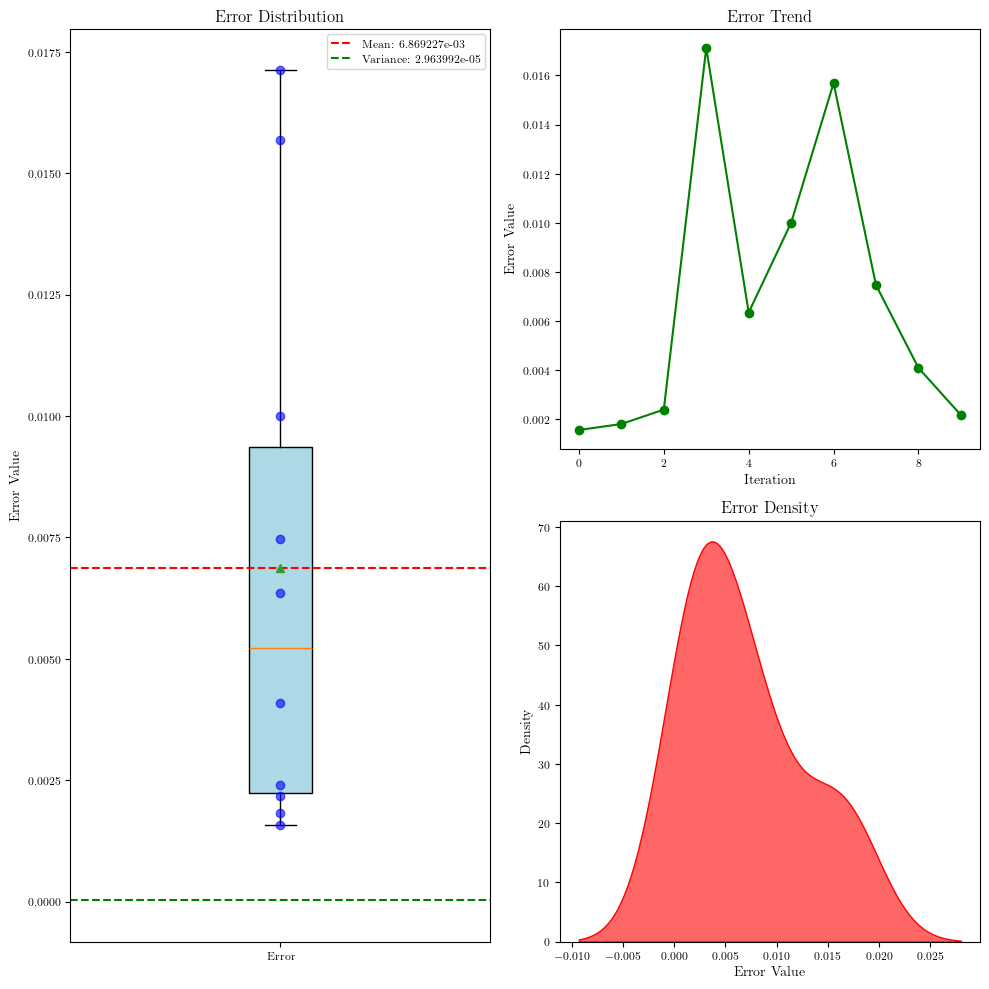

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # 导入seaborn库用于绘制密度图

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_u

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean Error u: %e' % (mean_error)) #打印误差
print('Variance Error u: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('Error Distribution')
plt.ylabel('Error Value')
plt.xticks([1], ['Error'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('Error Trend')
plt.ylabel('Error Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('Error Density')
plt.xlabel('Error Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

mean MAE: 8.456208e-04
Variance MAE: 1.775969e-07


/tmp/ipykernel_2697550/3997509801.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


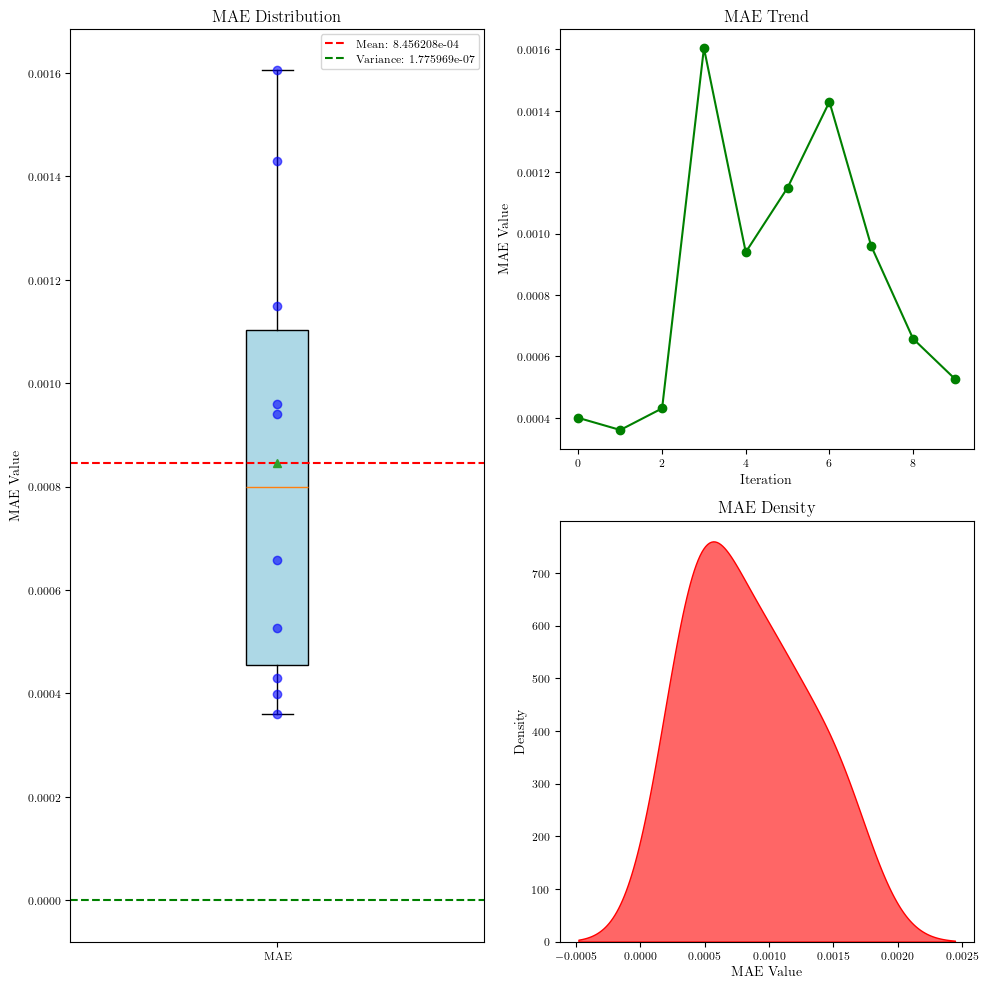

In [12]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mae

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MAE: %e' % (mean_error)) #打印误差
print('Variance MAE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MAE Distribution')
plt.ylabel('MAE Value')
plt.xticks([1], ['MAE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MAE Trend')
plt.ylabel('MAE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MAE Density')
plt.xlabel('MAE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

mean MSE: 2.899502e-05
Variance MSE: 1.459254e-09


/tmp/ipykernel_2697550/2305667704.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


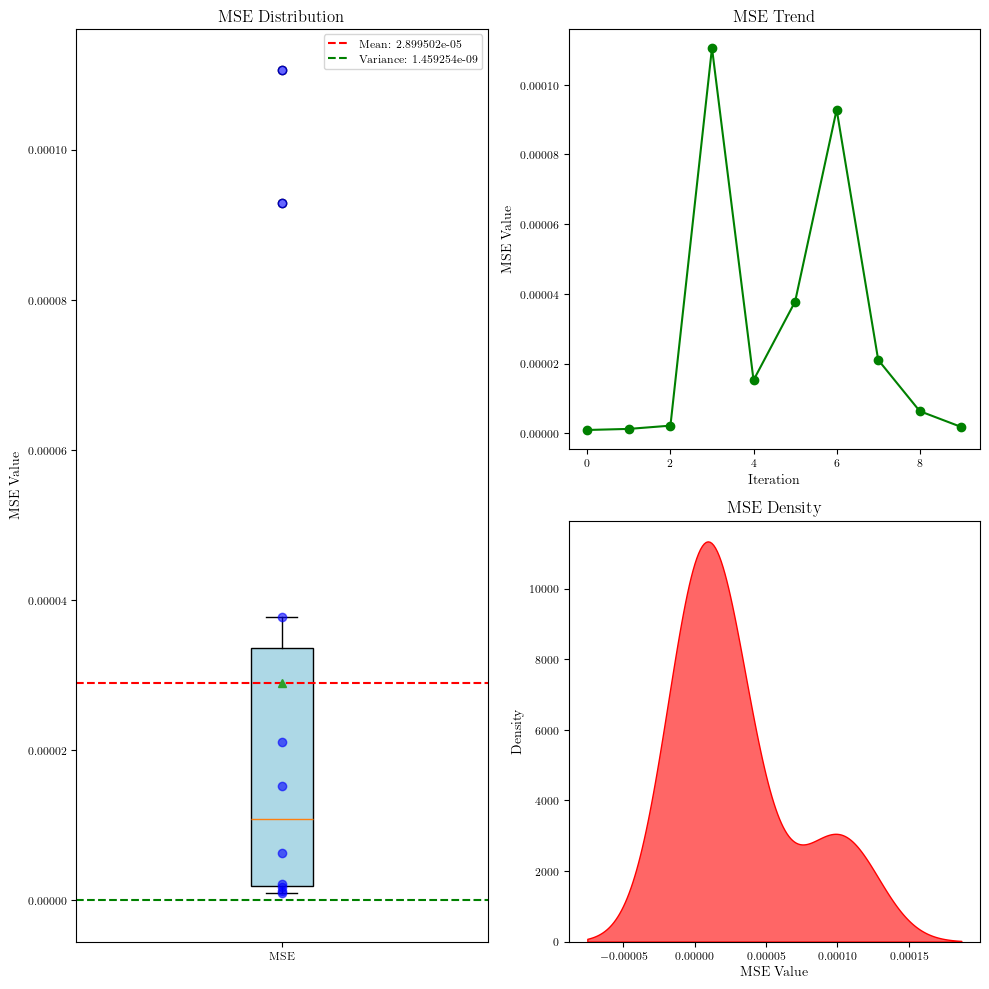

In [13]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mse

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MSE: %e' % (mean_error)) #打印误差
print('Variance MSE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MSE Distribution')
plt.ylabel('MSE Value')
plt.xticks([1], ['MSE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MSE Trend')
plt.ylabel('MSE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MSE Density')
plt.xlabel('MSE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

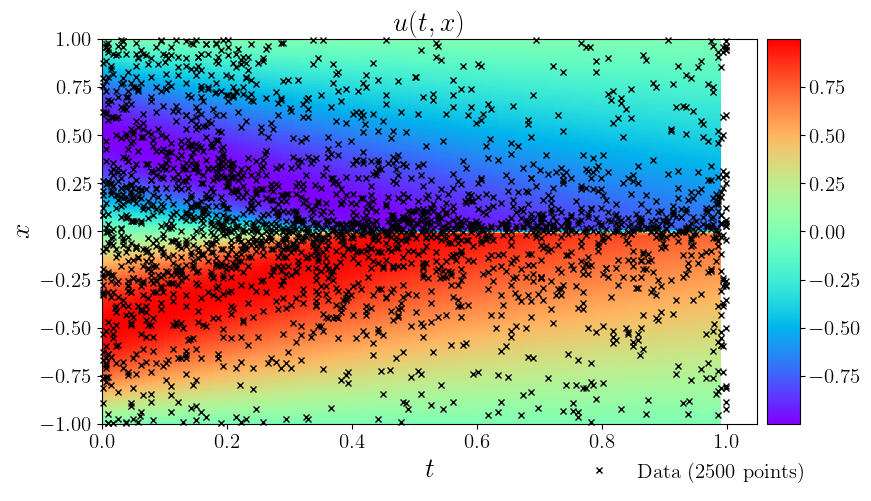

In [14]:
data = scipy.io.loadmat('../data/burgers_shock.mat')
#从data字典中取出变量tt和x的值，并转换为一维数组（flatten方法），最后tongg[:,None]将一维数组转换为二维数组
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T #从data数据中取出usol的值，并取实部，最后转置，赋值给Exact
#生成一个二位网络，X和T是输出的二维数组
#这个点结果是X和T均为形状为[len(t),len(x)]的二维数组，X的每一行都是x，一共len(t)行，T的每一列都是t，一共len(x)列
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  #按列堆叠数组，X_star是一个二维数组，其中第一列是X的展平，第二列是T的展平
u_star = Exact.flatten()[:,None]    #对Exact_u使用flatten方法将其转换为一维数组，最后使用[:,None]将其转换为二维数组   


#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_star = griddata(X_star, u_star.flatten(), (X, T), method='cubic')


###### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5)) #这里figure是一个figure对象，是一个图形窗口，代表整个图形，设置图形大小为宽9英寸高5 英寸
ax = fig.add_subplot(111) #在图形的1*1网格的第一个位置添加一个子图

#绘图的数据来源
h = ax.imshow(U_star.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')   #imshow函数用于显示图像，接受一些参数，第一个参数是图像数据，这里是U_pred的转置；第二个参数是插值方法（用于在像素之间插入新的像素），这里是最邻近插值；
                                                   #第三个参数是颜色映射，这里是用彩虹色图；第四个参数是图像的范围；第五个参数是图像的原点位置，这里表示原点在右下角；第六个参数是图像的纵横比，这里表示调整横纵比以填充整个axes对象
                                                   #最后的结果返回一个axesimage对象，也就是h，可以通过这个对象进一步设置图像的属性


#添加颜色条
divider = make_axes_locatable(ax)  #使用 make_axes_locatable 函数创建了一个 AxesDivider 对象。这个函数接受一个 Axes 对象作为参数，返回一个 AxesDivider 对象。AxesDivider 对象可以用来管理子图的布局，特别是当你需要在一个图的旁边添加另一个图时。
cax = divider.append_axes("right", size="5%", pad=0.10) #使用append_axes方法在原始轴的右侧添加了一个新的轴。append_axes 方法接受三个参数：位置（"right"）、大小（"5%"）和间距（0.10）。在原始轴的右侧添加了一个新的轴，新轴的大小是原始轴的 5%，新轴与原始轴之间的间距是 0.05 英寸
   
cbar = fig.colorbar(h, cax=cax)#使用colorbar方法在新轴上添加了一个颜色条。colorbar 方法接受两个参数：axesimage 对象（h）和新轴（cax）。并记这个颜色条的名字是cbar
cbar.ax.tick_params(labelsize=15) #设置颜色条刻度标签大小，这里bar是之前定义的


#在图上绘制散点图
ax.plot(
    X_f_train[:,1], 
    X_f_train[:,0], 
    'kx', label = 'Data (%d points)' % (X_f_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
) #在ax上绘制散点图，前两个参数是散点的x坐标和y坐标；kx表示黑色的x（散点形状是x），label是散点的标签，clip_on表示散点可以绘制在轴的边界外
  #新加了一个alpha=1.0用来设置标记的透明度，1.0表示完全不透明  




#设置图的标签、图例、标题和刻度标签
#设置ax子图的x轴的标签为t，y轴的标签为x。这里$t$和$x$是latex格式的文本，用于生成数学公式
ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
#设置子图ax的图例，第一个参数用来设置图例的位置，这里表示图例放在上方中央;第二个参数用来设置图例的锚点，接受一个元组，表示x和y坐标，表示把图例的锚点设置在x坐标为0.9，y坐标为-0.05处;frameon=False表示不显示图例的边框;第三个参数设置图例的列数，分为5列；最后一个参数设置图例属性，接受字典，这里表示设置图例字体大小为15；最后返回的leg是一个legend对象，表示图形的图例
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
#设置子图ax的标题为$u(t,x)$，表示latex格式的文本，用于生成数学公式，fontsize=10表示字体大小为20
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled，两倍化子图标题
ax.tick_params(labelsize=15)#用来设置刻度标签的大小。`tick_params`是`Axes`对象的一个方法，可以用来设置刻度线的属性。在这里，`labelsize=15` 是用来设置刻度标签的字体大小的。


#显示图片
plt.show() #显示所有打开的图形的函数

In [15]:
trainloss = torch.stack(model.loss_value).cpu().detach().numpy()

testerror = torch.stack(model.test_error).cpu().detach().numpy()

53230
[6.0001534e-01 5.7925147e-01 5.5952275e-01 ... 6.3756056e-06 6.3756056e-06
 6.3756056e-06]


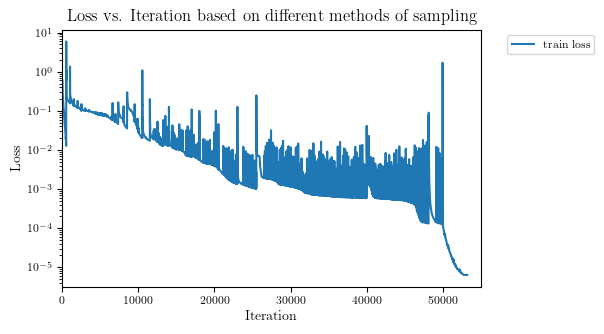

In [16]:
print(len(trainloss))
print(trainloss)
# 定义图例的标签
labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(trainloss, label='train loss')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,55000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()
plt.show()

53230
[1.3411124  1.3215016  1.3025525  ... 0.00217945 0.00217945 0.00217945]


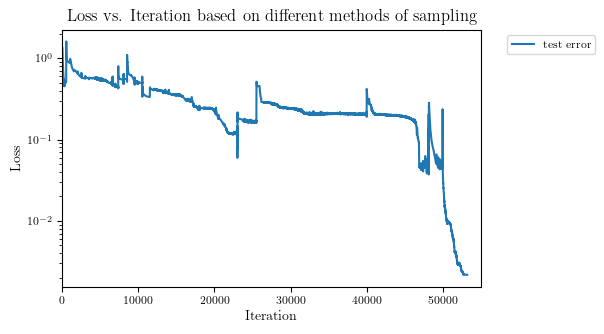

In [17]:
print(len(testerror))
print(testerror)
# 定义图例的标签
# labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(testerror, label='test error')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,55000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


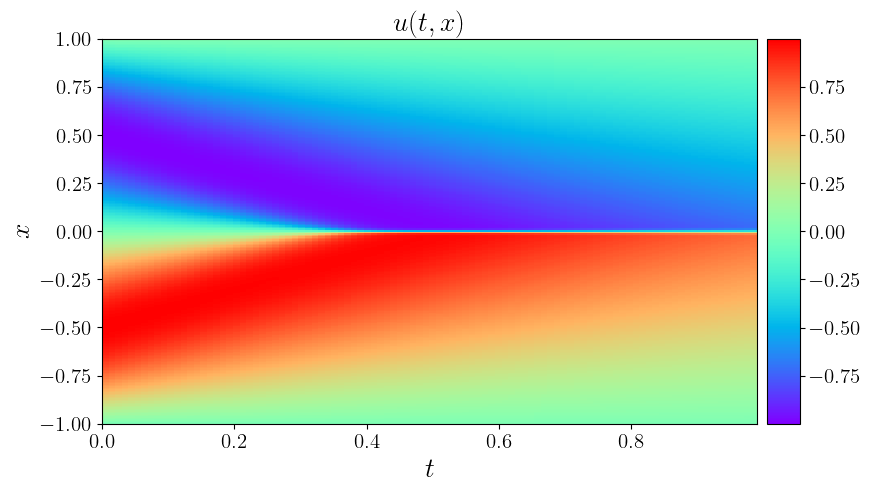

In [18]:
data = scipy.io.loadmat('../data/burgers_shock.mat')
#从data字典中取出变量tt和x的值，并转换为一维数组（flatten方法），最后tongg[:,None]将一维数组转换为二维数组
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T #从data数据中取出usol的值，并取实部，最后转置，赋值给Exact
#生成一个二位网络，X和T是输出的二维数组
#这个点结果是X和T均为形状为[len(t),len(x)]的二维数组，X的每一行都是x，一共len(t)行，T的每一列都是t，一共len(x)列
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  #按列堆叠数组，X_star是一个二维数组，其中第一列是X的展平，第二列是T的展平
u_pred, f_pred = model.predict(X_star)    #对Exact_u使用flatten方法将其转换为一维数组，最后使用[:,None]将其转换为二维数组   


#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')


###### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5)) #这里figure是一个figure对象，是一个图形窗口，代表整个图形，设置图形大小为宽9英寸高5 英寸
ax = fig.add_subplot(111) #在图形的1*1网格的第一个位置添加一个子图

#绘图的数据来源
h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')   #imshow函数用于显示图像，接受一些参数，第一个参数是图像数据，这里是U_pred的转置；第二个参数是插值方法（用于在像素之间插入新的像素），这里是最邻近插值；
                                                   #第三个参数是颜色映射，这里是用彩虹色图；第四个参数是图像的范围；第五个参数是图像的原点位置，这里表示原点在右下角；第六个参数是图像的纵横比，这里表示调整横纵比以填充整个axes对象
                                                   #最后的结果返回一个axesimage对象，也就是h，可以通过这个对象进一步设置图像的属性


#添加颜色条
divider = make_axes_locatable(ax)  #使用 make_axes_locatable 函数创建了一个 AxesDivider 对象。这个函数接受一个 Axes 对象作为参数，返回一个 AxesDivider 对象。AxesDivider 对象可以用来管理子图的布局，特别是当你需要在一个图的旁边添加另一个图时。
cax = divider.append_axes("right", size="5%", pad=0.10) #使用append_axes方法在原始轴的右侧添加了一个新的轴。append_axes 方法接受三个参数：位置（"right"）、大小（"5%"）和间距（0.10）。在原始轴的右侧添加了一个新的轴，新轴的大小是原始轴的 5%，新轴与原始轴之间的间距是 0.05 英寸
   
cbar = fig.colorbar(h, cax=cax)#使用colorbar方法在新轴上添加了一个颜色条。colorbar 方法接受两个参数：axesimage 对象（h）和新轴（cax）。并记这个颜色条的名字是cbar
cbar.ax.tick_params(labelsize=15) #设置颜色条刻度标签大小，这里bar是之前定义的


# #在图上绘制散点图
# ax.plot(
#     X_f_train[:,1], 
#     X_f_train[:,0], 
#     'kx', label = 'Data (%d points)' % (X_f_train.shape[0]), 
#     markersize = 4,  # marker size doubled
#     clip_on = False,
#     alpha=1.0
# ) #在ax上绘制散点图，前两个参数是散点的x坐标和y坐标；kx表示黑色的x（散点形状是x），label是散点的标签，clip_on表示散点可以绘制在轴的边界外
#   #新加了一个alpha=1.0用来设置标记的透明度，1.0表示完全不透明  




#设置图的标签、图例、标题和刻度标签
#设置ax子图的x轴的标签为t，y轴的标签为x。这里$t$和$x$是latex格式的文本，用于生成数学公式
ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
#设置子图ax的图例，第一个参数用来设置图例的位置，这里表示图例放在上方中央;第二个参数用来设置图例的锚点，接受一个元组，表示x和y坐标，表示把图例的锚点设置在x坐标为0.9，y坐标为-0.05处;frameon=False表示不显示图例的边框;第三个参数设置图例的列数，分为5列；最后一个参数设置图例属性，接受字典，这里表示设置图例字体大小为15；最后返回的leg是一个legend对象，表示图形的图例
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
#设置子图ax的标题为$u(t,x)$，表示latex格式的文本，用于生成数学公式，fontsize=10表示字体大小为20
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled，两倍化子图标题
ax.tick_params(labelsize=15)#用来设置刻度标签的大小。`tick_params`是`Axes`对象的一个方法，可以用来设置刻度线的属性。在这里，`labelsize=15` 是用来设置刻度标签的字体大小的。


#显示图片
plt.show() #显示所有打开的图形的函数

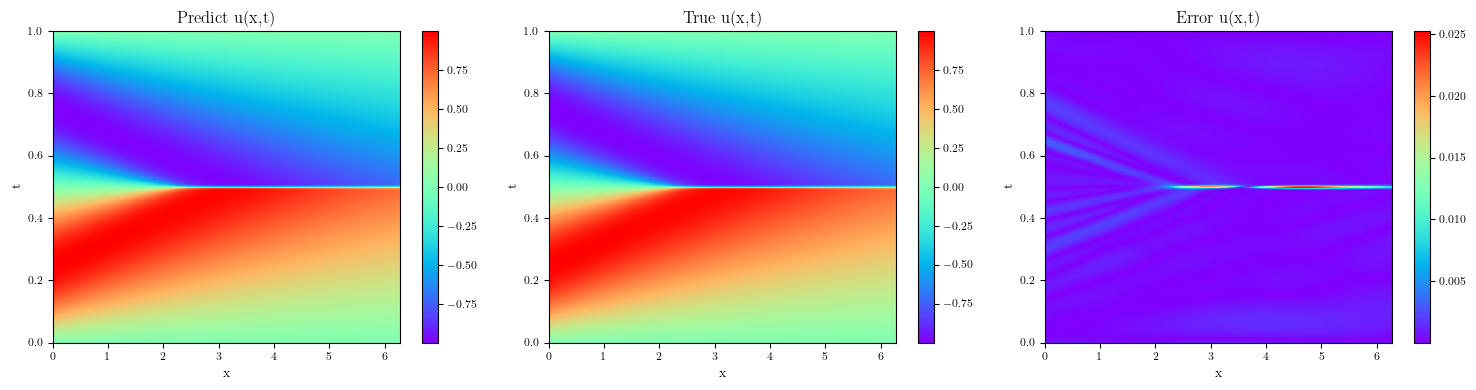

In [19]:

# 创建一个包含三幅子图的图像
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 绘制第一幅图像
axes[0].imshow(U_pred.T, extent=[0, np.pi*2, 1, 0], aspect='auto', cmap='rainbow')
axes[0].invert_yaxis()
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('Predict u(x,t)')
fig.colorbar(axes[0].images[0], ax=axes[0])

# 绘制第二幅图像
axes[1].imshow(U_star.T, extent=[0,np.pi*2,1,0], aspect='auto', cmap='rainbow') #第一个参数为数据，第二个参数为一个列表，用于设置图像的坐标范围，aspect='auto'表示纵横比自动调整
axes[1].invert_yaxis()
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
axes[1].set_title('True u(x,t)')
fig.colorbar(axes[1].images[0], ax=axes[1])

# 绘制第三幅图像
axes[2].imshow(np.abs(U_pred - U_star).T, extent=[0,np.pi*2,1,0], aspect='auto', cmap='rainbow') #第一个参数为数据，第二个参数为一个列表，用于设置图像的坐标范围，aspect='auto'表示纵横比自动调整
axes[2].invert_yaxis()
axes[2].set_xlabel('x')
axes[2].set_ylabel('t')
axes[2].set_title('Error u(x,t)')
fig.colorbar(axes[2].images[0], ax=axes[2])

# 自动调整子图参数，使得子图之间的间距适当
plt.tight_layout()
plt.show()

In [20]:
#计算训练好模型的chaos（最后一个seed）
u_chaos = calculate_chaos(model, X_star, num_iter=50)
u_chaos_log = np.log(u_chaos + 1e-10) #对u_var取对数，然后加上一个很小的数，避免取对数时出现错误

#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_chaos = griddata(X_star, u_chaos.flatten(), (X, T), method='cubic')
U_chaos_log = griddata(X_star, u_chaos_log.flatten(), (X, T), method='cubic')

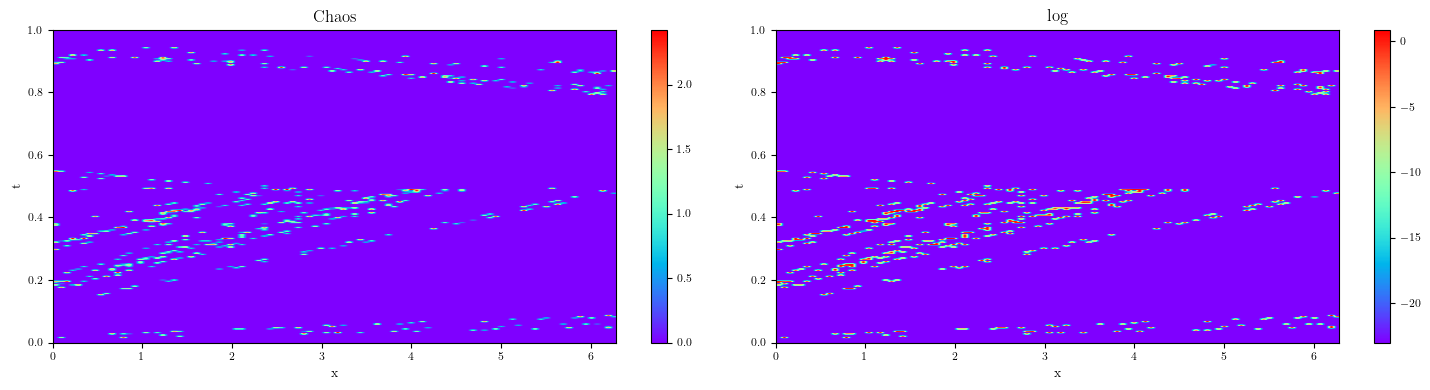

In [21]:

# 创建一个包含三幅子图的图像
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# 绘制第一幅图像
axes[0].imshow(U_chaos.T, extent=[0, np.pi*2, 1, 0], aspect='auto', cmap='rainbow')
axes[0].invert_yaxis()
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('Chaos')
fig.colorbar(axes[0].images[0], ax=axes[0])

# 绘制第二幅图像
axes[1].imshow(U_chaos_log.T, extent=[0,np.pi*2,1,0], aspect='auto', cmap='rainbow') #第一个参数为数据，第二个参数为一个列表，用于设置图像的坐标范围，aspect='auto'表示纵横比自动调整
axes[1].invert_yaxis()
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
axes[1].set_title('log')
fig.colorbar(axes[1].images[0], ax=axes[1])

# 自动调整子图参数，使得子图之间的间距适当
plt.tight_layout()
plt.show()